# Dataset

We are doing our analysis on [Spotify Multi-Genre Playlist Data](https://www.kaggle.com/siropo/spotify-multigenre-playlists-data).
This dataset is a collection of song features taken from Spotify and separated into six broad genres of music. 
Our analysis aims to answer to solve two problems:
1. How do you predict the genre of a song based on its features
2. What song features are more influential to a particular genre. 

It is not a random sampling of songs on Spotify: each song was on a playlist made by the person who collected the dataset. 
However, there is still a wide variety of genres it will work for purposes of our analysis. 
 
The dataset has the following 22 columns:

1. Artist Name
2. Song Name
3. Popularity: value from 1 to 100 that represents the song's popularity (magically determined by Spotify)
4. Genres: a detailed list of the genres for each artist
5. Playlist: the name of the playlist each song came from
6. Danceability
7. Energy
8. Key
9. Loudness
9. Mode
10. Speechiness
11. Acousticness
12. Instrumentalness
13. Liveness
14. Valence
15. Tempo
16. ID
17. URI
18. HRef
19. Analysis_url
19. Duration_Ms
20. Time-Signature

## Loading the dataset

The dataset is broken into 6 files, with each file containing the songs from a single genre of music. 
Here, we load the files into memory and combine them into one dataset. 
We also drop the playlist, ID, URI, HRef, and Analysis_url columns because they are not relevant for our analysis. 
Since we will be combining all of the songs into a single dataset, we also have to add another column containing the genre of each song. 

In [2]:
import pandas as pd

def load_dataset(music_genre):
    # First, we read the genre dataset into memory
    # Then we drop all of the columns we don't need
    # and finally we add the genre column and return it 
    return pd.read_csv(f'{music_genre}_music_data.csv').drop(columns=['Playlist', 'id', 'uri', 'track_href', 'analysis_url']).assign(genre=music_genre)

alternative = load_dataset('alternative')
blues = load_dataset('blues')
hiphop = load_dataset('hiphop')
indie_alt = load_dataset('indie_alt')
metal = load_dataset('metal')
pop = load_dataset('pop')
rock = load_dataset('rock')
    
dataset = pd.concat([alternative, blues, hiphop, indie_alt, metal, pop, rock])

# Analysis

## Logistic Regression

In the last logistic regression analysis, we determined variables are the least significant for identifying each genre. 
In this analysis, we will use forward variable selection to determine which variables are the most significant for distinguishing each genre. 

In [2]:
import statsmodels.api as sm
import math

def make_genre_training_data(genre_name):# collect all of the songs that belong to the given genre (and ignore any columns that aren't song features)
    X_same_genre = dataset[dataset['genre'] == genre_name].loc[:, 'danceability':'duration_ms']
    # Collect the songs that don't belong to the given genre (collect only a random sample to ensure a balanced dataset)
    X_different_genre = dataset[dataset['genre'] != genre_name].loc[:,'danceability':'duration_ms'].sample(n=len(X_same_genre))
    
    X_train = pd.concat([X_same_genre, X_different_genre], ignore_index=True)
    
    # for the Y data, we just need to make a dataframe of all 1s or all 0s with the same length as the X data
    Y_same_genre = pd.DataFrame(index=range(len(X_same_genre)), columns=['genre']).assign(genre=1)
    Y_different_genre = pd.DataFrame(index=range(len(X_same_genre)), columns=['genre']).assign(genre=0)

    Y_train = pd.concat([Y_same_genre,Y_different_genre], ignore_index=True)
    
    return X_train, Y_train

This function finds the most influential variable by building a separate logistic model for each feature and selecting the one with the lowest AIC score.
By default, it just returns the name of the most influential variable.
If you want to find the 2nd, 3rd, 4th, etc most influential variable, you can manually add variables to the logistic regression by using the fixed_vars parameter.
For example, if I want to find the 2nd most influential variable for distinguishing metal music, and I know that the most influential variable is energy, then I would use: `find_best_variable('metal', ['energy'])`
Also, you can change how verbose the function is. 
If the verbosity is set to a value greater than 0, it will also show the AIC score for each feature.

In [3]:
def find_best_variable(genre_name, default_cols=None, verbose=0):
    if default_cols is None:
	    default_cols = []
        
    X_train_all_cols, Y_train = make_genre_training_data(genre_name)
    
    lowest_aic = math.inf
    best_variable = ''
    
    if verbose > 0:
        print(f'{genre_name}:')
    
    # loop through all columns (ignoring the ones that are already added to the logistic model)
    for col in X_train_all_cols.drop(columns=default_cols):
        # Creates list of the cols and the training data we'll be using to train the logistic model
        training_cols = [col]
        training_cols.extend(default_cols)
        X_train = X_train_all_cols.loc[:,training_cols]

        logistic_model = sm.Logit(Y_train, X_train).fit(disp=0)
    
        if logistic_model.aic < lowest_aic:
            lowest_aic = logistic_model.aic
            best_variable = col
        
        if verbose > 0:
            print('  Variable:', col,'\t| aic:', logistic_model.aic)
        
    return best_variable

Here, we find the most influential variable for distinguishing each genre, as determined by forward variable selection.

In [4]:
# Uncomment this to see the AIC score for every metal logistic model
# find_best_variable('metal', verbose=1)
print('Best Variable for Alternative:', find_best_variable('alternative'))
print('Best Variable for Blues:', find_best_variable('blues'))
print('Best Variable for Hip Hop:', find_best_variable('hiphop'))
print('Best Variable for Indie Alt:', find_best_variable('indie_alt'))
print('Best Variable for Metal:', find_best_variable('metal'))
print('Best Variable for Pop:', find_best_variable('pop'))
print('Best Variable for Rock:', find_best_variable('rock'))

Best Variable for Alternative: instrumentalness
Best Variable for Blues: acousticness
Best Variable for Hip Hop: speechiness
Best Variable for Indie Alt: instrumentalness
Best Variable for Metal: acousticness
Best Variable for Pop: instrumentalness
Best Variable for Rock: speechiness


The results are somewhat surprising... [TODO: add analysis]

In this section, we continue our forward variable selection to find the second most influential variable.

In [5]:
find_best_variable('metal', default_cols=['acousticness'], verbose=1)
# TODO: add finish this.

metal:
  Variable: danceability 	| aic: 7433.635302947552
  Variable: energy 	| aic: 7011.268163945824
  Variable: key 	| aic: 7277.971555354989
  Variable: loudness 	| aic: 7263.477533967697
  Variable: mode 	| aic: 7363.368005559951
  Variable: speechiness 	| aic: 7278.813421574714
  Variable: instrumentalness 	| aic: 7080.335145208228
  Variable: liveness 	| aic: 7207.874765929412
  Variable: valence 	| aic: 7462.610087577701
  Variable: tempo 	| aic: 7154.918559173062
  Variable: duration_ms 	| aic: 6963.655467896603


'duration_ms'

## Clustering

In [62]:
## Prepping Data for Clustering
# random sample 2k entries from each of the datasets
sample_size = 50;

alt_rds = alternative.sample(n=sample_size, random_state=1)
blu_rds = blues.sample(n=sample_size, random_state=1)
hip_rds = hiphop.sample(n=sample_size, random_state=1)
ind_rds = indie_alt.sample(n=sample_size, random_state=1)
met_rds = metal.sample(n=sample_size, random_state=1)
pop_rds = pop.sample(n=sample_size, random_state=1)
roc_rds = rock.sample(n=sample_size, random_state=1)
rds = pd.concat([alt_rds, blu_rds, hip_rds, ind_rds, met_rds, pop_rds, roc_rds])
print(rds.shape)

(350, 18)


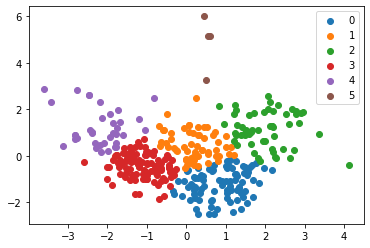

In [85]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

df1 = rds[['Track Name','danceability','energy','speechiness','acousticness','instrumentalness','liveness','valence','tempo']]
clustering_df = df1.loc[:, df1.columns != 'Track Name']
scaler = StandardScaler()
X_std = scaler.fit_transform(clustering_df)

pca = PCA(2)
df = pca.fit_transform(X_std) 
 
kmeans = KMeans(n_clusters= 6)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df)
clustering_df.insert(8, 'Cluster', label, True)

#Getting unique labels
u_labels = np.unique(label)

#plotting the results:
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()

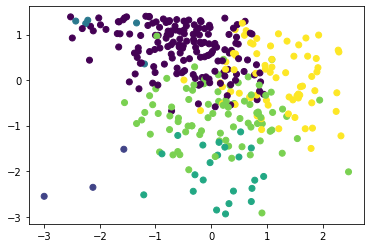

In [86]:
from sklearn.cluster import AffinityPropagation
clustering_df2 = df1.loc[:, df1.columns != 'Track Name']
pca = PCA(2)
df = pca.fit_transform(X_std)
sc = SpectralClustering(n_clusters=6).fit(df)
SpectralClustering(affinity='nearest_neighbors', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver='lobpcg', eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=4, n_components=None,
                   n_init=10, n_jobs=None, n_neighbors=20, random_state=1) 

labels = sc.labels_
clustering_df2.insert(8, 'Cluster', labels, True)
plt.scatter(X_std[:,0], X_std[:,1], c=labels)
plt.show()

In [87]:
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

cluster_mean = clustering_df.groupby(['Cluster']).mean()

x = cluster_mean.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
cluster_mean = pd.DataFrame(x_scaled)

categories = ['danceability','energy','speechiness','acousticness', 'instrumentalness','liveness','valence','tempo']

fig = go.Figure()

for index, row in cluster_mean.iterrows():
    fig.add_trace(go.Scatterpolar(
      r=row,
      theta=categories,
      fill='toself',
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=True
)

fig.show()
#fig.write_image("radar.png")

In [88]:
cluster_mean = clustering_df2.groupby(['Cluster']).mean()

x = cluster_mean.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
cluster_mean = pd.DataFrame(x_scaled)

categories = ['danceability','energy','speechiness','acousticness', 'instrumentalness','liveness','valence','tempo']

fig = go.Figure()

for index, row in cluster_mean.iterrows():
    fig.add_trace(go.Scatterpolar(
      r=row,
      theta=categories,
      fill='toself',
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=True
)

fig.show()

## Decision Tree Classifier

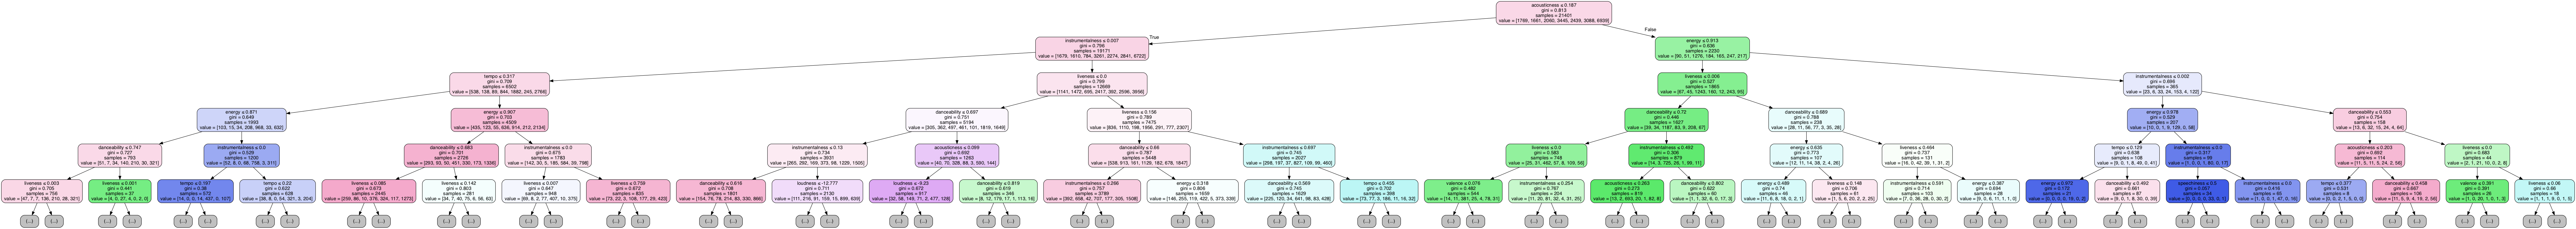

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

feature=['danceability','energy','key','loudness','speechiness','acousticness','instrumentalness','liveness'
                 ,'valence','tempo']


x = dataset.iloc[:,4:14]
y = dataset.iloc[:, 17]

x_train, x_test, y_train, y_test= train_test_split(x,y,test_size=0.2)

clf=DecisionTreeClassifier()

clf=clf.fit(x_train,y_train)

y_pred=clf.predict(x_test)

dot_data=StringIO()
export_graphviz(clf,out_file=dot_data,filled=True,rounded=True,max_depth=5,special_characters=True,
                    feature_names=feature)
graph=pydotplus.graph_from_dot_data(dot_data.getvalue())
#graph.write_png('tree.png')
display(Image(graph.create_png()))

In [27]:
import numpy as np

n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]
while len(stack) > 0:
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    is_split_node = children_left[node_id] != children_right[node_id]
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        display(
            "node={node} is a leaf node.".format(
                 node=i
            )
        )
    else:
        display(
            "node={node} is a split node: "
            "go to node {left} if x[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                #space=node_depth[i] ,
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
            )
        )

The binary tree structure has 14369 nodes:



'node=0 is a split node: go to node 1 if x[:, 5] <= 0.17650000005960464 else to node 13168.'

'node=1 is a split node: go to node 2 if x[:, 6] <= 0.004554999992251396 else to node 3797.'

'node=2 is a split node: go to node 3 if x[:, 9] <= 0.31450000405311584 else to node 1056.'

'node=3 is a split node: go to node 4 if x[:, 1] <= 0.9205000102519989 else to node 645.'

'node=4 is a split node: go to node 5 if x[:, 7] <= 0.022099999710917473 else to node 306.'

'node=5 is a split node: go to node 6 if x[:, 0] <= 0.7299999892711639 else to node 303.'

'node=6 is a split node: go to node 7 if x[:, 1] <= 0.7574999928474426 else to node 108.'

'node=7 is a split node: go to node 8 if x[:, 8] <= 0.048499999567866325 else to node 11.'

'node=8 is a split node: go to node 9 if x[:, 7] <= 4.355000055511482e-05 else to node 10.'

'node=9 is a leaf node.'

'node=10 is a leaf node.'

'node=11 is a split node: go to node 12 if x[:, 6] <= 0.004450000124052167 else to node 105.'

'node=12 is a split node: go to node 13 if x[:, 5] <= 0.03065000008791685 else to node 28.'

'node=13 is a split node: go to node 14 if x[:, 6] <= 0.004350000061094761 else to node 27.'

'node=14 is a split node: go to node 15 if x[:, 8] <= 0.2044999971985817 else to node 20.'

'node=15 is a split node: go to node 16 if x[:, 0] <= 0.484499990940094 else to node 17.'

'node=16 is a leaf node.'

'node=17 is a split node: go to node 18 if x[:, 9] <= 0.2615000084042549 else to node 19.'

'node=18 is a leaf node.'

'node=19 is a leaf node.'

'node=20 is a split node: go to node 21 if x[:, 0] <= 0.4169999957084656 else to node 22.'

'node=21 is a leaf node.'

'node=22 is a split node: go to node 23 if x[:, 9] <= 0.22299999743700027 else to node 24.'

'node=23 is a leaf node.'

'node=24 is a split node: go to node 25 if x[:, 8] <= 0.267999991774559 else to node 26.'

'node=25 is a leaf node.'

'node=26 is a leaf node.'

'node=27 is a leaf node.'

'node=28 is a split node: go to node 29 if x[:, 7] <= 1.4549999832524918e-05 else to node 52.'

'node=29 is a split node: go to node 30 if x[:, 5] <= 0.031250000931322575 else to node 31.'

'node=30 is a leaf node.'

'node=31 is a split node: go to node 32 if x[:, 0] <= 0.5819999873638153 else to node 51.'

'node=32 is a split node: go to node 33 if x[:, 9] <= 0.10500000044703484 else to node 34.'

'node=33 is a leaf node.'

'node=34 is a split node: go to node 35 if x[:, 1] <= 0.6299999952316284 else to node 38.'

'node=35 is a split node: go to node 36 if x[:, 2] <= 6.5 else to node 37.'

'node=36 is a leaf node.'

'node=37 is a leaf node.'

'node=38 is a split node: go to node 39 if x[:, 2] <= 6.5 else to node 40.'

'node=39 is a leaf node.'

'node=40 is a split node: go to node 41 if x[:, 0] <= 0.5480000078678131 else to node 50.'

'node=41 is a split node: go to node 42 if x[:, 6] <= 0.0009144999785348773 else to node 43.'

'node=42 is a leaf node.'

'node=43 is a split node: go to node 44 if x[:, 9] <= 0.15050000324845314 else to node 45.'

'node=44 is a leaf node.'

'node=45 is a split node: go to node 46 if x[:, 3] <= -5.72599983215332 else to node 47.'

'node=46 is a leaf node.'

'node=47 is a split node: go to node 48 if x[:, 7] <= 6.70000008540228e-06 else to node 49.'

'node=48 is a leaf node.'

'node=49 is a leaf node.'

'node=50 is a leaf node.'

'node=51 is a leaf node.'

'node=52 is a split node: go to node 53 if x[:, 7] <= 0.00013250000120024197 else to node 66.'

'node=53 is a split node: go to node 54 if x[:, 9] <= 0.2524999976158142 else to node 65.'

'node=54 is a split node: go to node 55 if x[:, 5] <= 0.03610000014305115 else to node 60.'

'node=55 is a split node: go to node 56 if x[:, 3] <= -5.843999862670898 else to node 57.'

'node=56 is a leaf node.'

'node=57 is a split node: go to node 58 if x[:, 9] <= 0.15255000069737434 else to node 59.'

'node=58 is a leaf node.'

'node=59 is a leaf node.'

'node=60 is a split node: go to node 61 if x[:, 9] <= 0.22450000047683716 else to node 64.'

'node=61 is a split node: go to node 62 if x[:, 6] <= 0.001989999960642308 else to node 63.'

'node=62 is a leaf node.'

'node=63 is a leaf node.'

'node=64 is a leaf node.'

'node=65 is a leaf node.'

'node=66 is a split node: go to node 67 if x[:, 9] <= 0.2810000032186508 else to node 96.'

'node=67 is a split node: go to node 68 if x[:, 5] <= 0.09274999797344208 else to node 95.'

'node=68 is a split node: go to node 69 if x[:, 8] <= 0.08285000175237656 else to node 72.'

'node=69 is a split node: go to node 70 if x[:, 1] <= 0.7135000228881836 else to node 71.'

'node=70 is a leaf node.'

'node=71 is a leaf node.'

'node=72 is a split node: go to node 73 if x[:, 1] <= 0.6835000216960907 else to node 80.'

'node=73 is a split node: go to node 74 if x[:, 9] <= 0.1574999988079071 else to node 75.'

'node=74 is a leaf node.'

'node=75 is a split node: go to node 76 if x[:, 9] <= 0.1875 else to node 79.'

'node=76 is a split node: go to node 77 if x[:, 8] <= 0.18050000071525574 else to node 78.'

'node=77 is a leaf node.'

'node=78 is a leaf node.'

'node=79 is a leaf node.'

'node=80 is a split node: go to node 81 if x[:, 1] <= 0.6890000104904175 else to node 82.'

'node=81 is a leaf node.'

'node=82 is a split node: go to node 83 if x[:, 1] <= 0.7075000107288361 else to node 88.'

'node=83 is a split node: go to node 84 if x[:, 8] <= 0.21850000321865082 else to node 87.'

'node=84 is a split node: go to node 85 if x[:, 8] <= 0.11600000411272049 else to node 86.'

'node=85 is a leaf node.'

'node=86 is a leaf node.'

'node=87 is a leaf node.'

'node=88 is a split node: go to node 89 if x[:, 6] <= 0.0014400000218302011 else to node 92.'

'node=89 is a split node: go to node 90 if x[:, 9] <= 0.07829999923706055 else to node 91.'

'node=90 is a leaf node.'

'node=91 is a leaf node.'

'node=92 is a split node: go to node 93 if x[:, 5] <= 0.040950000286102295 else to node 94.'

'node=93 is a leaf node.'

'node=94 is a leaf node.'

'node=95 is a leaf node.'

'node=96 is a split node: go to node 97 if x[:, 8] <= 0.09805000200867653 else to node 102.'

'node=97 is a split node: go to node 98 if x[:, 9] <= 0.29099999368190765 else to node 99.'

'node=98 is a leaf node.'

'node=99 is a split node: go to node 100 if x[:, 2] <= 6.5 else to node 101.'

'node=100 is a leaf node.'

'node=101 is a leaf node.'

'node=102 is a split node: go to node 103 if x[:, 9] <= 0.2944999933242798 else to node 104.'

'node=103 is a leaf node.'

'node=104 is a leaf node.'

'node=105 is a split node: go to node 106 if x[:, 0] <= 0.5544999837875366 else to node 107.'

'node=106 is a leaf node.'

'node=107 is a leaf node.'

'node=108 is a split node: go to node 109 if x[:, 3] <= -5.625499963760376 else to node 180.'

'node=109 is a split node: go to node 110 if x[:, 7] <= 4.459999945538584e-05 else to node 121.'

'node=110 is a split node: go to node 111 if x[:, 5] <= 0.04040000028908253 else to node 114.'

'node=111 is a split node: go to node 112 if x[:, 5] <= 0.0308499988168478 else to node 113.'

'node=112 is a leaf node.'

'node=113 is a leaf node.'

'node=114 is a split node: go to node 115 if x[:, 6] <= 1.0314999826732674e-05 else to node 116.'

'node=115 is a leaf node.'

'node=116 is a split node: go to node 117 if x[:, 1] <= 0.9155000150203705 else to node 120.'

'node=117 is a split node: go to node 118 if x[:, 1] <= 0.7689999938011169 else to node 119.'

'node=118 is a leaf node.'

'node=119 is a leaf node.'

'node=120 is a leaf node.'

'node=121 is a split node: go to node 122 if x[:, 1] <= 0.9149999916553497 else to node 179.'

'node=122 is a split node: go to node 123 if x[:, 6] <= 3.2899999496294186e-05 else to node 124.'

'node=123 is a leaf node.'

'node=124 is a split node: go to node 125 if x[:, 9] <= 0.2604999989271164 else to node 160.'

'node=125 is a split node: go to node 126 if x[:, 0] <= 0.359499990940094 else to node 145.'

'node=126 is a split node: go to node 127 if x[:, 4] <= 0.5 else to node 132.'

'node=127 is a split node: go to node 128 if x[:, 3] <= -6.9670000076293945 else to node 131.'

'node=128 is a split node: go to node 129 if x[:, 1] <= 0.8994999825954437 else to node 130.'

'node=129 is a leaf node.'

'node=130 is a leaf node.'

'node=131 is a leaf node.'

'node=132 is a split node: go to node 133 if x[:, 2] <= 6.5 else to node 140.'

'node=133 is a split node: go to node 134 if x[:, 2] <= 2.0 else to node 135.'

'node=134 is a leaf node.'

'node=135 is a split node: go to node 136 if x[:, 6] <= 9.7400001322967e-05 else to node 137.'

'node=136 is a leaf node.'

'node=137 is a split node: go to node 138 if x[:, 6] <= 0.0009960000024875626 else to node 139.'

'node=138 is a leaf node.'

'node=139 is a leaf node.'

'node=140 is a split node: go to node 141 if x[:, 2] <= 9.5 else to node 144.'

'node=141 is a split node: go to node 142 if x[:, 8] <= 0.08004999905824661 else to node 143.'

'node=142 is a leaf node.'

'node=143 is a leaf node.'

'node=144 is a leaf node.'

'node=145 is a split node: go to node 146 if x[:, 5] <= 0.09200000017881393 else to node 159.'

'node=146 is a split node: go to node 147 if x[:, 6] <= 0.00011200000153621659 else to node 148.'

'node=147 is a leaf node.'

'node=148 is a split node: go to node 149 if x[:, 7] <= 0.020099999383091927 else to node 158.'

'node=149 is a split node: go to node 150 if x[:, 5] <= 0.042650001123547554 else to node 151.'

'node=150 is a leaf node.'

'node=151 is a split node: go to node 152 if x[:, 5] <= 0.04450000077486038 else to node 153.'

'node=152 is a leaf node.'

'node=153 is a split node: go to node 154 if x[:, 6] <= 0.0003074999985983595 else to node 155.'

'node=154 is a leaf node.'

'node=155 is a split node: go to node 156 if x[:, 7] <= 0.00021799999376526102 else to node 157.'

'node=156 is a leaf node.'

'node=157 is a leaf node.'

'node=158 is a leaf node.'

'node=159 is a leaf node.'

'node=160 is a split node: go to node 161 if x[:, 3] <= -6.196000099182129 else to node 178.'

'node=161 is a split node: go to node 162 if x[:, 7] <= 0.002459999988786876 else to node 171.'

'node=162 is a split node: go to node 163 if x[:, 9] <= 0.30400000512599945 else to node 170.'

'node=163 is a split node: go to node 164 if x[:, 7] <= 0.0015649999841116369 else to node 167.'

'node=164 is a split node: go to node 165 if x[:, 7] <= 0.00015010000061010942 else to node 166.'

'node=165 is a leaf node.'

'node=166 is a leaf node.'

'node=167 is a split node: go to node 168 if x[:, 4] <= 0.5 else to node 169.'

'node=168 is a leaf node.'

'node=169 is a leaf node.'

'node=170 is a leaf node.'

'node=171 is a split node: go to node 172 if x[:, 9] <= 0.2900000065565109 else to node 173.'

'node=172 is a leaf node.'

'node=173 is a split node: go to node 174 if x[:, 6] <= 0.002250000019557774 else to node 177.'

'node=174 is a split node: go to node 175 if x[:, 0] <= 0.32349999994039536 else to node 176.'

'node=175 is a leaf node.'

'node=176 is a leaf node.'

'node=177 is a leaf node.'

'node=178 is a leaf node.'

'node=179 is a leaf node.'

'node=180 is a split node: go to node 181 if x[:, 7] <= 0.0012550000101327896 else to node 266.'

'node=181 is a split node: go to node 182 if x[:, 6] <= 0.002054999931715429 else to node 253.'

'node=182 is a split node: go to node 183 if x[:, 2] <= 10.5 else to node 244.'

'node=183 is a split node: go to node 184 if x[:, 6] <= 0.0019749999628402293 else to node 243.'

'node=184 is a split node: go to node 185 if x[:, 0] <= 0.33250001072883606 else to node 188.'

'node=185 is a split node: go to node 186 if x[:, 9] <= 0.14250000566244125 else to node 187.'

'node=186 is a leaf node.'

'node=187 is a leaf node.'

'node=188 is a split node: go to node 189 if x[:, 0] <= 0.3435000032186508 else to node 192.'

'node=189 is a split node: go to node 190 if x[:, 9] <= 0.25299999862909317 else to node 191.'

'node=190 is a leaf node.'

'node=191 is a leaf node.'

'node=192 is a split node: go to node 193 if x[:, 7] <= 0.00021699999342672527 else to node 234.'

'node=193 is a split node: go to node 194 if x[:, 8] <= 0.1315000019967556 else to node 215.'

'node=194 is a split node: go to node 195 if x[:, 9] <= 0.2709999978542328 else to node 212.'

'node=195 is a split node: go to node 196 if x[:, 1] <= 0.8720000088214874 else to node 203.'

'node=196 is a split node: go to node 197 if x[:, 3] <= -5.335000038146973 else to node 202.'

'node=197 is a split node: go to node 198 if x[:, 9] <= 0.09304999932646751 else to node 199.'

'node=198 is a leaf node.'

'node=199 is a split node: go to node 200 if x[:, 8] <= 0.08799999952316284 else to node 201.'

'node=200 is a leaf node.'

'node=201 is a leaf node.'

'node=202 is a leaf node.'

'node=203 is a split node: go to node 204 if x[:, 6] <= 0.00010840000322787091 else to node 205.'

'node=204 is a leaf node.'

'node=205 is a split node: go to node 206 if x[:, 2] <= 4.5 else to node 209.'

'node=206 is a split node: go to node 207 if x[:, 6] <= 0.001065999997081235 else to node 208.'

'node=207 is a leaf node.'

'node=208 is a leaf node.'

'node=209 is a split node: go to node 210 if x[:, 7] <= 2.2750000425730832e-05 else to node 211.'

'node=210 is a leaf node.'

'node=211 is a leaf node.'

'node=212 is a split node: go to node 213 if x[:, 3] <= -4.365499973297119 else to node 214.'

'node=213 is a leaf node.'

'node=214 is a leaf node.'

'node=215 is a split node: go to node 216 if x[:, 5] <= 0.032999999821186066 else to node 217.'

'node=216 is a leaf node.'

'node=217 is a split node: go to node 218 if x[:, 6] <= 0.0007979999936651438 else to node 223.'

'node=218 is a split node: go to node 219 if x[:, 9] <= 0.17249999940395355 else to node 222.'

'node=219 is a split node: go to node 220 if x[:, 1] <= 0.8425000011920929 else to node 221.'

'node=220 is a leaf node.'

'node=221 is a leaf node.'

'node=222 is a leaf node.'

'node=223 is a split node: go to node 224 if x[:, 5] <= 0.06314999796450138 else to node 231.'

'node=224 is a split node: go to node 225 if x[:, 5] <= 0.04470000043511391 else to node 228.'

'node=225 is a split node: go to node 226 if x[:, 2] <= 2.0 else to node 227.'

'node=226 is a leaf node.'

'node=227 is a leaf node.'

'node=228 is a split node: go to node 229 if x[:, 9] <= 0.20350000262260437 else to node 230.'

'node=229 is a leaf node.'

'node=230 is a leaf node.'

'node=231 is a split node: go to node 232 if x[:, 1] <= 0.9135000109672546 else to node 233.'

'node=232 is a leaf node.'

'node=233 is a leaf node.'

'node=234 is a split node: go to node 235 if x[:, 1] <= 0.8675000071525574 else to node 242.'

'node=235 is a split node: go to node 236 if x[:, 8] <= 0.2874999940395355 else to node 241.'

'node=236 is a split node: go to node 237 if x[:, 8] <= 0.21899999678134918 else to node 240.'

'node=237 is a split node: go to node 238 if x[:, 8] <= 0.16500000655651093 else to node 239.'

'node=238 is a leaf node.'

'node=239 is a leaf node.'

'node=240 is a leaf node.'

'node=241 is a leaf node.'

'node=242 is a leaf node.'

'node=243 is a leaf node.'

'node=244 is a split node: go to node 245 if x[:, 3] <= -5.20799994468689 else to node 248.'

'node=245 is a split node: go to node 246 if x[:, 1] <= 0.8434999883174896 else to node 247.'

'node=246 is a leaf node.'

'node=247 is a leaf node.'

'node=248 is a split node: go to node 249 if x[:, 0] <= 0.3765000104904175 else to node 250.'

'node=249 is a leaf node.'

'node=250 is a split node: go to node 251 if x[:, 9] <= 0.2750000059604645 else to node 252.'

'node=251 is a leaf node.'

'node=252 is a leaf node.'

'node=253 is a split node: go to node 254 if x[:, 1] <= 0.9189999997615814 else to node 265.'

'node=254 is a split node: go to node 255 if x[:, 0] <= 0.5710000097751617 else to node 260.'

'node=255 is a split node: go to node 256 if x[:, 9] <= 0.306999996304512 else to node 259.'

'node=256 is a split node: go to node 257 if x[:, 6] <= 0.0021299999207258224 else to node 258.'

'node=257 is a leaf node.'

'node=258 is a leaf node.'

'node=259 is a leaf node.'

'node=260 is a split node: go to node 261 if x[:, 2] <= 8.5 else to node 262.'

'node=261 is a leaf node.'

'node=262 is a split node: go to node 263 if x[:, 3] <= -4.812999963760376 else to node 264.'

'node=263 is a leaf node.'

'node=264 is a leaf node.'

'node=265 is a leaf node.'

'node=266 is a split node: go to node 267 if x[:, 0] <= 0.20350000262260437 else to node 268.'

'node=267 is a leaf node.'

'node=268 is a split node: go to node 269 if x[:, 0] <= 0.375 else to node 278.'

'node=269 is a split node: go to node 270 if x[:, 8] <= 0.14499999582767487 else to node 277.'

'node=270 is a split node: go to node 271 if x[:, 9] <= 0.12599999830126762 else to node 272.'

'node=271 is a leaf node.'

'node=272 is a split node: go to node 273 if x[:, 8] <= 0.08449999801814556 else to node 274.'

'node=273 is a leaf node.'

'node=274 is a split node: go to node 275 if x[:, 2] <= 3.5 else to node 276.'

'node=275 is a leaf node.'

'node=276 is a leaf node.'

'node=277 is a leaf node.'

'node=278 is a split node: go to node 279 if x[:, 2] <= 8.5 else to node 296.'

'node=279 is a split node: go to node 280 if x[:, 5] <= 0.03464999981224537 else to node 283.'

'node=280 is a split node: go to node 281 if x[:, 1] <= 0.8135000169277191 else to node 282.'

'node=281 is a leaf node.'

'node=282 is a leaf node.'

'node=283 is a split node: go to node 284 if x[:, 3] <= -5.305499792098999 else to node 287.'

'node=284 is a split node: go to node 285 if x[:, 9] <= 0.28850001096725464 else to node 286.'

'node=285 is a leaf node.'

'node=286 is a leaf node.'

'node=287 is a split node: go to node 288 if x[:, 8] <= 0.29250000417232513 else to node 293.'

'node=288 is a split node: go to node 289 if x[:, 5] <= 0.08004999905824661 else to node 292.'

'node=289 is a split node: go to node 290 if x[:, 6] <= 4.115000047022477e-05 else to node 291.'

'node=290 is a leaf node.'

'node=291 is a leaf node.'

'node=292 is a leaf node.'

'node=293 is a split node: go to node 294 if x[:, 5] <= 0.04325000010430813 else to node 295.'

'node=294 is a leaf node.'

'node=295 is a leaf node.'

'node=296 is a split node: go to node 297 if x[:, 5] <= 0.0433999989181757 else to node 298.'

'node=297 is a leaf node.'

'node=298 is a split node: go to node 299 if x[:, 6] <= 0.0005445000060717575 else to node 302.'

'node=299 is a split node: go to node 300 if x[:, 0] <= 0.4424999952316284 else to node 301.'

'node=300 is a leaf node.'

'node=301 is a leaf node.'

'node=302 is a leaf node.'

'node=303 is a split node: go to node 304 if x[:, 3] <= -10.40999984741211 else to node 305.'

'node=304 is a leaf node.'

'node=305 is a leaf node.'

'node=306 is a split node: go to node 307 if x[:, 0] <= 0.5690000057220459 else to node 602.'

'node=307 is a split node: go to node 308 if x[:, 5] <= 0.0786999985575676 else to node 561.'

'node=308 is a split node: go to node 309 if x[:, 3] <= -6.4029998779296875 else to node 454.'

'node=309 is a split node: go to node 310 if x[:, 1] <= 0.4450000077486038 else to node 317.'

'node=310 is a split node: go to node 311 if x[:, 0] <= 0.4555000066757202 else to node 316.'

'node=311 is a split node: go to node 312 if x[:, 7] <= 0.25164999812841415 else to node 313.'

'node=312 is a leaf node.'

'node=313 is a split node: go to node 314 if x[:, 9] <= 0.1860000044107437 else to node 315.'

'node=314 is a leaf node.'

'node=315 is a leaf node.'

'node=316 is a leaf node.'

'node=317 is a split node: go to node 318 if x[:, 7] <= 0.8495000004768372 else to node 423.'

'node=318 is a split node: go to node 319 if x[:, 7] <= 0.7894999980926514 else to node 406.'

'node=319 is a split node: go to node 320 if x[:, 8] <= 0.6130000054836273 else to node 403.'

'node=320 is a split node: go to node 321 if x[:, 6] <= 1.0300000212737359e-05 else to node 322.'

'node=321 is a leaf node.'

'node=322 is a split node: go to node 323 if x[:, 6] <= 1.44999999065476e-05 else to node 324.'

'node=323 is a leaf node.'

'node=324 is a split node: go to node 325 if x[:, 0] <= 0.4699999988079071 else to node 386.'

'node=325 is a split node: go to node 326 if x[:, 7] <= 0.0750500001013279 else to node 341.'

'node=326 is a split node: go to node 327 if x[:, 6] <= 5.824999789183494e-05 else to node 332.'

'node=327 is a split node: go to node 328 if x[:, 4] <= 0.5 else to node 329.'

'node=328 is a leaf node.'

'node=329 is a split node: go to node 330 if x[:, 6] <= 3.124999966530595e-05 else to node 331.'

'node=330 is a leaf node.'

'node=331 is a leaf node.'

'node=332 is a split node: go to node 333 if x[:, 7] <= 0.025100000202655792 else to node 334.'

'node=333 is a leaf node.'

'node=334 is a split node: go to node 335 if x[:, 8] <= 0.09834999963641167 else to node 338.'

'node=335 is a split node: go to node 336 if x[:, 8] <= 0.06619999930262566 else to node 337.'

'node=336 is a leaf node.'

'node=337 is a leaf node.'

'node=338 is a split node: go to node 339 if x[:, 7] <= 0.05274999886751175 else to node 340.'

'node=339 is a leaf node.'

'node=340 is a leaf node.'

'node=341 is a split node: go to node 342 if x[:, 5] <= 0.030849999748170376 else to node 349.'

'node=342 is a split node: go to node 343 if x[:, 3] <= -7.305999994277954 else to node 346.'

'node=343 is a split node: go to node 344 if x[:, 5] <= 0.02925000060349703 else to node 345.'

'node=344 is a leaf node.'

'node=345 is a leaf node.'

'node=346 is a split node: go to node 347 if x[:, 6] <= 0.002287250093104376 else to node 348.'

'node=347 is a leaf node.'

'node=348 is a leaf node.'

'node=349 is a split node: go to node 350 if x[:, 7] <= 0.6854999959468842 else to node 371.'

'node=350 is a split node: go to node 351 if x[:, 5] <= 0.05205000005662441 else to node 362.'

'node=351 is a split node: go to node 352 if x[:, 1] <= 0.5629999935626984 else to node 355.'

'node=352 is a split node: go to node 353 if x[:, 3] <= -7.6670002937316895 else to node 354.'

'node=353 is a leaf node.'

'node=354 is a leaf node.'

'node=355 is a split node: go to node 356 if x[:, 8] <= 0.09434999898076057 else to node 361.'

'node=356 is a split node: go to node 357 if x[:, 9] <= 0.14350000023841858 else to node 358.'

'node=357 is a leaf node.'

'node=358 is a split node: go to node 359 if x[:, 9] <= 0.1550000011920929 else to node 360.'

'node=359 is a leaf node.'

'node=360 is a leaf node.'

'node=361 is a leaf node.'

'node=362 is a split node: go to node 363 if x[:, 9] <= 0.15699999779462814 else to node 364.'

'node=363 is a leaf node.'

'node=364 is a split node: go to node 365 if x[:, 8] <= 0.09120000153779984 else to node 370.'

'node=365 is a split node: go to node 366 if x[:, 1] <= 0.7949999868869781 else to node 367.'

'node=366 is a leaf node.'

'node=367 is a split node: go to node 368 if x[:, 8] <= 0.08060000091791153 else to node 369.'

'node=368 is a leaf node.'

'node=369 is a leaf node.'

'node=370 is a leaf node.'

'node=371 is a split node: go to node 372 if x[:, 6] <= 3.2449999707750976e-05 else to node 373.'

'node=372 is a leaf node.'

'node=373 is a split node: go to node 374 if x[:, 7] <= 0.7504999935626984 else to node 385.'

'node=374 is a split node: go to node 375 if x[:, 1] <= 0.8509999811649323 else to node 382.'

'node=375 is a split node: go to node 376 if x[:, 6] <= 0.0030349999433383346 else to node 381.'

'node=376 is a split node: go to node 377 if x[:, 3] <= -6.960999965667725 else to node 380.'

'node=377 is a split node: go to node 378 if x[:, 5] <= 0.041600000113248825 else to node 379.'

'node=378 is a leaf node.'

'node=379 is a leaf node.'

'node=380 is a leaf node.'

'node=381 is a leaf node.'

'node=382 is a split node: go to node 383 if x[:, 7] <= 0.734499990940094 else to node 384.'

'node=383 is a leaf node.'

'node=384 is a leaf node.'

'node=385 is a leaf node.'

'node=386 is a split node: go to node 387 if x[:, 0] <= 0.5065000057220459 else to node 390.'

'node=387 is a split node: go to node 388 if x[:, 1] <= 0.5555000007152557 else to node 389.'

'node=388 is a leaf node.'

'node=389 is a leaf node.'

'node=390 is a split node: go to node 391 if x[:, 8] <= 0.09960000216960907 else to node 392.'

'node=391 is a leaf node.'

'node=392 is a split node: go to node 393 if x[:, 7] <= 0.12449999898672104 else to node 394.'

'node=393 is a leaf node.'

'node=394 is a split node: go to node 395 if x[:, 0] <= 0.5399999916553497 else to node 400.'

'node=395 is a split node: go to node 396 if x[:, 5] <= 0.046950001269578934 else to node 399.'

'node=396 is a split node: go to node 397 if x[:, 3] <= -7.797999858856201 else to node 398.'

'node=397 is a leaf node.'

'node=398 is a leaf node.'

'node=399 is a leaf node.'

'node=400 is a split node: go to node 401 if x[:, 2] <= 8.0 else to node 402.'

'node=401 is a leaf node.'

'node=402 is a leaf node.'

'node=403 is a split node: go to node 404 if x[:, 6] <= 0.0020749999675899744 else to node 405.'

'node=404 is a leaf node.'

'node=405 is a leaf node.'

'node=406 is a split node: go to node 407 if x[:, 2] <= 1.5 else to node 412.'

'node=407 is a split node: go to node 408 if x[:, 6] <= 2.6849999812839087e-05 else to node 409.'

'node=408 is a leaf node.'

'node=409 is a split node: go to node 410 if x[:, 6] <= 0.0006050000101822661 else to node 411.'

'node=410 is a leaf node.'

'node=411 is a leaf node.'

'node=412 is a split node: go to node 413 if x[:, 8] <= 0.09155000001192093 else to node 418.'

'node=413 is a split node: go to node 414 if x[:, 1] <= 0.7485000193119049 else to node 417.'

'node=414 is a split node: go to node 415 if x[:, 8] <= 0.08865000307559967 else to node 416.'

'node=415 is a leaf node.'

'node=416 is a leaf node.'

'node=417 is a leaf node.'

'node=418 is a split node: go to node 419 if x[:, 0] <= 0.19950000196695328 else to node 422.'

'node=419 is a split node: go to node 420 if x[:, 3] <= -9.33650016784668 else to node 421.'

'node=420 is a leaf node.'

'node=421 is a leaf node.'

'node=422 is a leaf node.'

'node=423 is a split node: go to node 424 if x[:, 1] <= 0.7730000019073486 else to node 447.'

'node=424 is a split node: go to node 425 if x[:, 3] <= -9.86299991607666 else to node 428.'

'node=425 is a split node: go to node 426 if x[:, 3] <= -10.050999641418457 else to node 427.'

'node=426 is a leaf node.'

'node=427 is a leaf node.'

'node=428 is a split node: go to node 429 if x[:, 2] <= 5.5 else to node 438.'

'node=429 is a split node: go to node 430 if x[:, 3] <= -7.930500030517578 else to node 435.'

'node=430 is a split node: go to node 431 if x[:, 3] <= -8.788000106811523 else to node 434.'

'node=431 is a split node: go to node 432 if x[:, 2] <= 3.0 else to node 433.'

'node=432 is a leaf node.'

'node=433 is a leaf node.'

'node=434 is a leaf node.'

'node=435 is a split node: go to node 436 if x[:, 4] <= 0.5 else to node 437.'

'node=436 is a leaf node.'

'node=437 is a leaf node.'

'node=438 is a split node: go to node 439 if x[:, 7] <= 0.9039999842643738 else to node 446.'

'node=439 is a split node: go to node 440 if x[:, 3] <= -7.700499773025513 else to node 445.'

'node=440 is a split node: go to node 441 if x[:, 8] <= 0.09954999759793282 else to node 442.'

'node=441 is a leaf node.'

'node=442 is a split node: go to node 443 if x[:, 3] <= -9.026000022888184 else to node 444.'

'node=443 is a leaf node.'

'node=444 is a leaf node.'

'node=445 is a leaf node.'

'node=446 is a leaf node.'

'node=447 is a split node: go to node 448 if x[:, 9] <= 0.2280000001192093 else to node 449.'

'node=448 is a leaf node.'

'node=449 is a split node: go to node 450 if x[:, 8] <= 0.09975000098347664 else to node 453.'

'node=450 is a split node: go to node 451 if x[:, 8] <= 0.07770000211894512 else to node 452.'

'node=451 is a leaf node.'

'node=452 is a leaf node.'

'node=453 is a leaf node.'

'node=454 is a split node: go to node 455 if x[:, 1] <= 0.6974999904632568 else to node 466.'

'node=455 is a split node: go to node 456 if x[:, 9] <= 0.15199999511241913 else to node 457.'

'node=456 is a leaf node.'

'node=457 is a split node: go to node 458 if x[:, 7] <= 0.057350000366568565 else to node 459.'

'node=458 is a leaf node.'

'node=459 is a split node: go to node 460 if x[:, 7] <= 0.6730000078678131 else to node 461.'

'node=460 is a leaf node.'

'node=461 is a split node: go to node 462 if x[:, 7] <= 0.8300000131130219 else to node 463.'

'node=462 is a leaf node.'

'node=463 is a split node: go to node 464 if x[:, 8] <= 0.08695000037550926 else to node 465.'

'node=464 is a leaf node.'

'node=465 is a leaf node.'

'node=466 is a split node: go to node 467 if x[:, 1] <= 0.9165000021457672 else to node 560.'

'node=467 is a split node: go to node 468 if x[:, 0] <= 0.5130000114440918 else to node 541.'

'node=468 is a split node: go to node 469 if x[:, 7] <= 0.0414000004529953 else to node 470.'

'node=469 is a leaf node.'

'node=470 is a split node: go to node 471 if x[:, 0] <= 0.49949999153614044 else to node 540.'

'node=471 is a split node: go to node 472 if x[:, 6] <= 0.0032600000267848372 else to node 539.'

'node=472 is a split node: go to node 473 if x[:, 9] <= 0.10015000030398369 else to node 476.'

'node=473 is a split node: go to node 474 if x[:, 0] <= 0.4114999920129776 else to node 475.'

'node=474 is a leaf node.'

'node=475 is a leaf node.'

'node=476 is a split node: go to node 477 if x[:, 7] <= 0.8634999990463257 else to node 534.'

'node=477 is a split node: go to node 478 if x[:, 7] <= 0.34550000727176666 else to node 507.'

'node=478 is a split node: go to node 479 if x[:, 6] <= 1.609999981155852e-05 else to node 480.'

'node=479 is a leaf node.'

'node=480 is a split node: go to node 481 if x[:, 9] <= 0.1784999966621399 else to node 484.'

'node=481 is a split node: go to node 482 if x[:, 7] <= 0.04780000075697899 else to node 483.'

'node=482 is a leaf node.'

'node=483 is a leaf node.'

'node=484 is a split node: go to node 485 if x[:, 6] <= 0.00024449999909847975 else to node 492.'

'node=485 is a split node: go to node 486 if x[:, 1] <= 0.8885000050067902 else to node 487.'

'node=486 is a leaf node.'

'node=487 is a split node: go to node 488 if x[:, 9] <= 0.30299998819828033 else to node 491.'

'node=488 is a split node: go to node 489 if x[:, 3] <= -4.721499919891357 else to node 490.'

'node=489 is a leaf node.'

'node=490 is a leaf node.'

'node=491 is a leaf node.'

'node=492 is a split node: go to node 493 if x[:, 5] <= 0.0657999999821186 else to node 506.'

'node=493 is a split node: go to node 494 if x[:, 8] <= 0.32199999690055847 else to node 505.'

'node=494 is a split node: go to node 495 if x[:, 5] <= 0.05034999921917915 else to node 504.'

'node=495 is a split node: go to node 496 if x[:, 9] <= 0.23200000077486038 else to node 501.'

'node=496 is a split node: go to node 497 if x[:, 5] <= 0.038350000977516174 else to node 498.'

'node=497 is a leaf node.'

'node=498 is a split node: go to node 499 if x[:, 9] <= 0.20650000125169754 else to node 500.'

'node=499 is a leaf node.'

'node=500 is a leaf node.'

'node=501 is a split node: go to node 502 if x[:, 3] <= -3.8194998502731323 else to node 503.'

'node=502 is a leaf node.'

'node=503 is a leaf node.'

'node=504 is a leaf node.'

'node=505 is a leaf node.'

'node=506 is a leaf node.'

'node=507 is a split node: go to node 508 if x[:, 0] <= 0.471000000834465 else to node 533.'

'node=508 is a split node: go to node 509 if x[:, 3] <= -5.53849983215332 else to node 516.'

'node=509 is a split node: go to node 510 if x[:, 6] <= 0.0003337499929330079 else to node 511.'

'node=510 is a leaf node.'

'node=511 is a split node: go to node 512 if x[:, 3] <= -6.2804999351501465 else to node 515.'

'node=512 is a split node: go to node 513 if x[:, 2] <= 5.0 else to node 514.'

'node=513 is a leaf node.'

'node=514 is a leaf node.'

'node=515 is a leaf node.'

'node=516 is a split node: go to node 517 if x[:, 1] <= 0.7534999847412109 else to node 518.'

'node=517 is a leaf node.'

'node=518 is a split node: go to node 519 if x[:, 3] <= -4.700999975204468 else to node 520.'

'node=519 is a leaf node.'

'node=520 is a split node: go to node 521 if x[:, 0] <= 0.23099999874830246 else to node 522.'

'node=521 is a leaf node.'

'node=522 is a split node: go to node 523 if x[:, 2] <= 6.5 else to node 530.'

'node=523 is a split node: go to node 524 if x[:, 5] <= 0.066600002348423 else to node 529.'

'node=524 is a split node: go to node 525 if x[:, 3] <= -4.278499960899353 else to node 526.'

'node=525 is a leaf node.'

'node=526 is a split node: go to node 527 if x[:, 8] <= 0.1925000064074993 else to node 528.'

'node=527 is a leaf node.'

'node=528 is a leaf node.'

'node=529 is a leaf node.'

'node=530 is a split node: go to node 531 if x[:, 2] <= 9.5 else to node 532.'

'node=531 is a leaf node.'

'node=532 is a leaf node.'

'node=533 is a leaf node.'

'node=534 is a split node: go to node 535 if x[:, 5] <= 0.03844999894499779 else to node 538.'

'node=535 is a split node: go to node 536 if x[:, 3] <= -5.5904998779296875 else to node 537.'

'node=536 is a leaf node.'

'node=537 is a leaf node.'

'node=538 is a leaf node.'

'node=539 is a leaf node.'

'node=540 is a leaf node.'

'node=541 is a split node: go to node 542 if x[:, 6] <= 0.0013150000013411045 else to node 559.'

'node=542 is a split node: go to node 543 if x[:, 1] <= 0.7744999825954437 else to node 544.'

'node=543 is a leaf node.'

'node=544 is a split node: go to node 545 if x[:, 3] <= -5.055999994277954 else to node 554.'

'node=545 is a split node: go to node 546 if x[:, 9] <= 0.16200000047683716 else to node 547.'

'node=546 is a leaf node.'

'node=547 is a split node: go to node 548 if x[:, 0] <= 0.5225000083446503 else to node 553.'

'node=548 is a split node: go to node 549 if x[:, 2] <= 8.0 else to node 552.'

'node=549 is a split node: go to node 550 if x[:, 9] <= 0.2644999995827675 else to node 551.'

'node=550 is a leaf node.'

'node=551 is a leaf node.'

'node=552 is a leaf node.'

'node=553 is a leaf node.'

'node=554 is a split node: go to node 555 if x[:, 2] <= 2.5 else to node 556.'

'node=555 is a leaf node.'

'node=556 is a split node: go to node 557 if x[:, 8] <= 0.1889999955892563 else to node 558.'

'node=557 is a leaf node.'

'node=558 is a leaf node.'

'node=559 is a leaf node.'

'node=560 is a leaf node.'

'node=561 is a split node: go to node 562 if x[:, 3] <= -9.576499938964844 else to node 575.'

'node=562 is a split node: go to node 563 if x[:, 1] <= 0.796999990940094 else to node 564.'

'node=563 is a leaf node.'

'node=564 is a split node: go to node 565 if x[:, 6] <= 0.0001003500001388602 else to node 568.'

'node=565 is a split node: go to node 566 if x[:, 5] <= 0.08100000023841858 else to node 567.'

'node=566 is a leaf node.'

'node=567 is a leaf node.'

'node=568 is a split node: go to node 569 if x[:, 8] <= 0.29099999368190765 else to node 572.'

'node=569 is a split node: go to node 570 if x[:, 2] <= 4.0 else to node 571.'

'node=570 is a leaf node.'

'node=571 is a leaf node.'

'node=572 is a split node: go to node 573 if x[:, 0] <= 0.2945000007748604 else to node 574.'

'node=573 is a leaf node.'

'node=574 is a leaf node.'

'node=575 is a split node: go to node 576 if x[:, 3] <= -5.065500020980835 else to node 599.'

'node=576 is a split node: go to node 577 if x[:, 7] <= 0.023049999959766865 else to node 578.'

'node=577 is a leaf node.'

'node=578 is a split node: go to node 579 if x[:, 1] <= 0.6135000139474869 else to node 580.'

'node=579 is a leaf node.'

'node=580 is a split node: go to node 581 if x[:, 1] <= 0.9149999916553497 else to node 596.'

'node=581 is a split node: go to node 582 if x[:, 6] <= 0.0017449999577365816 else to node 591.'

'node=582 is a split node: go to node 583 if x[:, 8] <= 0.35249999165534973 else to node 586.'

'node=583 is a split node: go to node 584 if x[:, 0] <= 0.5109999924898148 else to node 585.'

'node=584 is a leaf node.'

'node=585 is a leaf node.'

'node=586 is a split node: go to node 587 if x[:, 6] <= 2.1504999494936783e-05 else to node 588.'

'node=587 is a leaf node.'

'node=588 is a split node: go to node 589 if x[:, 8] <= 0.4255000054836273 else to node 590.'

'node=589 is a leaf node.'

'node=590 is a leaf node.'

'node=591 is a split node: go to node 592 if x[:, 7] <= 0.7985000014305115 else to node 595.'

'node=592 is a split node: go to node 593 if x[:, 4] <= 0.5 else to node 594.'

'node=593 is a leaf node.'

'node=594 is a leaf node.'

'node=595 is a leaf node.'

'node=596 is a split node: go to node 597 if x[:, 8] <= 0.13975000008940697 else to node 598.'

'node=597 is a leaf node.'

'node=598 is a leaf node.'

'node=599 is a split node: go to node 600 if x[:, 0] <= 0.25450000911951065 else to node 601.'

'node=600 is a leaf node.'

'node=601 is a leaf node.'

'node=602 is a split node: go to node 603 if x[:, 0] <= 0.8070000112056732 else to node 642.'

'node=603 is a split node: go to node 604 if x[:, 2] <= 0.5 else to node 605.'

'node=604 is a leaf node.'

'node=605 is a split node: go to node 606 if x[:, 1] <= 0.695499986410141 else to node 617.'

'node=606 is a split node: go to node 607 if x[:, 5] <= 0.08339999988675117 else to node 616.'

'node=607 is a split node: go to node 608 if x[:, 6] <= 0.0022100000642240047 else to node 615.'

'node=608 is a split node: go to node 609 if x[:, 2] <= 6.5 else to node 614.'

'node=609 is a split node: go to node 610 if x[:, 6] <= 0.0007530000002589077 else to node 613.'

'node=610 is a split node: go to node 611 if x[:, 0] <= 0.664000004529953 else to node 612.'

'node=611 is a leaf node.'

'node=612 is a leaf node.'

'node=613 is a leaf node.'

'node=614 is a leaf node.'

'node=615 is a leaf node.'

'node=616 is a leaf node.'

'node=617 is a split node: go to node 618 if x[:, 6] <= 4.2649999159039e-05 else to node 621.'

'node=618 is a split node: go to node 619 if x[:, 1] <= 0.7985000014305115 else to node 620.'

'node=619 is a leaf node.'

'node=620 is a leaf node.'

'node=621 is a split node: go to node 622 if x[:, 9] <= 0.06504999846220016 else to node 627.'

'node=622 is a split node: go to node 623 if x[:, 6] <= 0.00033150000672321767 else to node 624.'

'node=623 is a leaf node.'

'node=624 is a split node: go to node 625 if x[:, 6] <= 0.001108000025851652 else to node 626.'

'node=625 is a leaf node.'

'node=626 is a leaf node.'

'node=627 is a split node: go to node 628 if x[:, 7] <= 0.04714999906718731 else to node 633.'

'node=628 is a split node: go to node 629 if x[:, 5] <= 0.032049999572336674 else to node 630.'

'node=629 is a leaf node.'

'node=630 is a split node: go to node 631 if x[:, 6] <= 0.0016079999622888863 else to node 632.'

'node=631 is a leaf node.'

'node=632 is a leaf node.'

'node=633 is a split node: go to node 634 if x[:, 5] <= 0.045249998569488525 else to node 639.'

'node=634 is a split node: go to node 635 if x[:, 0] <= 0.5755000114440918 else to node 638.'

'node=635 is a split node: go to node 636 if x[:, 8] <= 0.33500000834465027 else to node 637.'

'node=636 is a leaf node.'

'node=637 is a leaf node.'

'node=638 is a leaf node.'

'node=639 is a split node: go to node 640 if x[:, 8] <= 0.3060000091791153 else to node 641.'

'node=640 is a leaf node.'

'node=641 is a leaf node.'

'node=642 is a split node: go to node 643 if x[:, 4] <= 0.5 else to node 644.'

'node=643 is a leaf node.'

'node=644 is a leaf node.'

'node=645 is a split node: go to node 646 if x[:, 6] <= 0.0001024999983201269 else to node 803.'

'node=646 is a split node: go to node 647 if x[:, 9] <= 0.1899999976158142 else to node 710.'

'node=647 is a split node: go to node 648 if x[:, 7] <= 0.00044100001105107367 else to node 671.'

'node=648 is a split node: go to node 649 if x[:, 0] <= 0.3439999967813492 else to node 660.'

'node=649 is a split node: go to node 650 if x[:, 5] <= 0.13650000095367432 else to node 659.'

'node=650 is a split node: go to node 651 if x[:, 5] <= 0.10700000077486038 else to node 652.'

'node=651 is a leaf node.'

'node=652 is a split node: go to node 653 if x[:, 9] <= 0.10979999974370003 else to node 658.'

'node=653 is a split node: go to node 654 if x[:, 7] <= 0.00024700000722077675 else to node 657.'

'node=654 is a split node: go to node 655 if x[:, 8] <= 0.1668500043451786 else to node 656.'

'node=655 is a leaf node.'

'node=656 is a leaf node.'

'node=657 is a leaf node.'

'node=658 is a leaf node.'

'node=659 is a leaf node.'

'node=660 is a split node: go to node 661 if x[:, 6] <= 8.505000005243346e-05 else to node 666.'

'node=661 is a split node: go to node 662 if x[:, 3] <= -3.1859999895095825 else to node 663.'

'node=662 is a leaf node.'

'node=663 is a split node: go to node 664 if x[:, 7] <= 9.57000029302435e-05 else to node 665.'

'node=664 is a leaf node.'

'node=665 is a leaf node.'

'node=666 is a split node: go to node 667 if x[:, 5] <= 0.10999999940395355 else to node 668.'

'node=667 is a leaf node.'

'node=668 is a split node: go to node 669 if x[:, 6] <= 8.734999937587418e-05 else to node 670.'

'node=669 is a leaf node.'

'node=670 is a leaf node.'

'node=671 is a split node: go to node 672 if x[:, 3] <= -2.5054999589920044 else to node 707.'

'node=672 is a split node: go to node 673 if x[:, 9] <= 0.16350000351667404 else to node 690.'

'node=673 is a split node: go to node 674 if x[:, 9] <= 0.1290000006556511 else to node 679.'

'node=674 is a split node: go to node 675 if x[:, 3] <= -3.3554999828338623 else to node 676.'

'node=675 is a leaf node.'

'node=676 is a split node: go to node 677 if x[:, 3] <= -3.2524999380111694 else to node 678.'

'node=677 is a leaf node.'

'node=678 is a leaf node.'

'node=679 is a split node: go to node 680 if x[:, 3] <= -7.621500015258789 else to node 681.'

'node=680 is a leaf node.'

'node=681 is a split node: go to node 682 if x[:, 6] <= 8.105000233626924e-05 else to node 687.'

'node=682 is a split node: go to node 683 if x[:, 6] <= 2.750000021478627e-06 else to node 686.'

'node=683 is a split node: go to node 684 if x[:, 7] <= 0.04790000058710575 else to node 685.'

'node=684 is a leaf node.'

'node=685 is a leaf node.'

'node=686 is a leaf node.'

'node=687 is a split node: go to node 688 if x[:, 3] <= -4.993499994277954 else to node 689.'

'node=688 is a leaf node.'

'node=689 is a leaf node.'

'node=690 is a split node: go to node 691 if x[:, 9] <= 0.17000000178813934 else to node 702.'

'node=691 is a split node: go to node 692 if x[:, 5] <= 0.09200000017881393 else to node 701.'

'node=692 is a split node: go to node 693 if x[:, 7] <= 0.7450000047683716 else to node 698.'

'node=693 is a split node: go to node 694 if x[:, 6] <= 1.98500001715729e-05 else to node 695.'

'node=694 is a leaf node.'

'node=695 is a split node: go to node 696 if x[:, 7] <= 0.38234999030828476 else to node 697.'

'node=696 is a leaf node.'

'node=697 is a leaf node.'

'node=698 is a split node: go to node 699 if x[:, 7] <= 0.7990000247955322 else to node 700.'

'node=699 is a leaf node.'

'node=700 is a leaf node.'

'node=701 is a leaf node.'

'node=702 is a split node: go to node 703 if x[:, 5] <= 0.06065000034868717 else to node 706.'

'node=703 is a split node: go to node 704 if x[:, 1] <= 0.9399999976158142 else to node 705.'

'node=704 is a leaf node.'

'node=705 is a leaf node.'

'node=706 is a leaf node.'

'node=707 is a split node: go to node 708 if x[:, 3] <= -2.4735000133514404 else to node 709.'

'node=708 is a leaf node.'

'node=709 is a leaf node.'

'node=710 is a split node: go to node 711 if x[:, 9] <= 0.20600000023841858 else to node 734.'

'node=711 is a split node: go to node 712 if x[:, 3] <= -5.929500102996826 else to node 713.'

'node=712 is a leaf node.'

'node=713 is a split node: go to node 714 if x[:, 5] <= 0.16200000047683716 else to node 733.'

'node=714 is a split node: go to node 715 if x[:, 2] <= 8.5 else to node 730.'

'node=715 is a split node: go to node 716 if x[:, 8] <= 0.18450000137090683 else to node 721.'

'node=716 is a split node: go to node 717 if x[:, 6] <= 4.450000051292591e-05 else to node 720.'

'node=717 is a split node: go to node 718 if x[:, 3] <= -4.209500074386597 else to node 719.'

'node=718 is a leaf node.'

'node=719 is a leaf node.'

'node=720 is a leaf node.'

'node=721 is a split node: go to node 722 if x[:, 1] <= 0.9569999873638153 else to node 723.'

'node=722 is a leaf node.'

'node=723 is a split node: go to node 724 if x[:, 6] <= 2.9850000942133192e-06 else to node 725.'

'node=724 is a leaf node.'

'node=725 is a split node: go to node 726 if x[:, 7] <= 0.05605750172981061 else to node 729.'

'node=726 is a split node: go to node 727 if x[:, 7] <= 8.520000119460747e-05 else to node 728.'

'node=727 is a leaf node.'

'node=728 is a leaf node.'

'node=729 is a leaf node.'

'node=730 is a split node: go to node 731 if x[:, 0] <= 0.29600000381469727 else to node 732.'

'node=731 is a leaf node.'

'node=732 is a leaf node.'

'node=733 is a leaf node.'

'node=734 is a split node: go to node 735 if x[:, 5] <= 0.04454999975860119 else to node 736.'

'node=735 is a leaf node.'

'node=736 is a split node: go to node 737 if x[:, 3] <= -6.296000003814697 else to node 738.'

'node=737 is a leaf node.'

'node=738 is a split node: go to node 739 if x[:, 6] <= 1.2799999922208372e-06 else to node 742.'

'node=739 is a split node: go to node 740 if x[:, 2] <= 8.0 else to node 741.'

'node=740 is a leaf node.'

'node=741 is a leaf node.'

'node=742 is a split node: go to node 743 if x[:, 1] <= 0.9794999957084656 else to node 786.'

'node=743 is a split node: go to node 744 if x[:, 0] <= 0.3605000078678131 else to node 761.'

'node=744 is a split node: go to node 745 if x[:, 2] <= 4.5 else to node 750.'

'node=745 is a split node: go to node 746 if x[:, 7] <= 0.001066534960386889 else to node 747.'

'node=746 is a leaf node.'

'node=747 is a split node: go to node 748 if x[:, 8] <= 0.4000000059604645 else to node 749.'

'node=748 is a leaf node.'

'node=749 is a leaf node.'

'node=750 is a split node: go to node 751 if x[:, 7] <= 0.00017454999760957435 else to node 752.'

'node=751 is a leaf node.'

'node=752 is a split node: go to node 753 if x[:, 6] <= 2.5200000663971878e-06 else to node 756.'

'node=753 is a split node: go to node 754 if x[:, 4] <= 0.5 else to node 755.'

'node=754 is a leaf node.'

'node=755 is a leaf node.'

'node=756 is a split node: go to node 757 if x[:, 1] <= 0.9265000224113464 else to node 758.'

'node=757 is a leaf node.'

'node=758 is a split node: go to node 759 if x[:, 1] <= 0.9745000004768372 else to node 760.'

'node=759 is a leaf node.'

'node=760 is a leaf node.'

'node=761 is a split node: go to node 762 if x[:, 6] <= 5.725000119127799e-05 else to node 781.'

'node=762 is a split node: go to node 763 if x[:, 7] <= 1.0304999705113005e-05 else to node 768.'

'node=763 is a split node: go to node 764 if x[:, 7] <= 5.494999868460582e-06 else to node 767.'

'node=764 is a split node: go to node 765 if x[:, 3] <= -3.369500160217285 else to node 766.'

'node=765 is a leaf node.'

'node=766 is a leaf node.'

'node=767 is a leaf node.'

'node=768 is a split node: go to node 769 if x[:, 5] <= 0.1510000005364418 else to node 778.'

'node=769 is a split node: go to node 770 if x[:, 8] <= 0.13850000500679016 else to node 777.'

'node=770 is a split node: go to node 771 if x[:, 4] <= 0.5 else to node 776.'

'node=771 is a split node: go to node 772 if x[:, 1] <= 0.9460000097751617 else to node 773.'

'node=772 is a leaf node.'

'node=773 is a split node: go to node 774 if x[:, 9] <= 0.30550000071525574 else to node 775.'

'node=774 is a leaf node.'

'node=775 is a leaf node.'

'node=776 is a leaf node.'

'node=777 is a leaf node.'

'node=778 is a split node: go to node 779 if x[:, 9] <= 0.24050000309944153 else to node 780.'

'node=779 is a leaf node.'

'node=780 is a leaf node.'

'node=781 is a split node: go to node 782 if x[:, 6] <= 7.144999835873023e-05 else to node 785.'

'node=782 is a split node: go to node 783 if x[:, 0] <= 0.4555000066757202 else to node 784.'

'node=783 is a leaf node.'

'node=784 is a leaf node.'

'node=785 is a leaf node.'

'node=786 is a split node: go to node 787 if x[:, 6] <= 4.4350001189741306e-05 else to node 794.'

'node=787 is a split node: go to node 788 if x[:, 1] <= 0.9934999942779541 else to node 789.'

'node=788 is a leaf node.'

'node=789 is a split node: go to node 790 if x[:, 5] <= 0.1290000043809414 else to node 793.'

'node=790 is a split node: go to node 791 if x[:, 3] <= -3.065000057220459 else to node 792.'

'node=791 is a leaf node.'

'node=792 is a leaf node.'

'node=793 is a leaf node.'

'node=794 is a split node: go to node 795 if x[:, 3] <= -4.167999982833862 else to node 796.'

'node=795 is a leaf node.'

'node=796 is a split node: go to node 797 if x[:, 7] <= 0.525500014424324 else to node 802.'

'node=797 is a split node: go to node 798 if x[:, 9] <= 0.2395000010728836 else to node 801.'

'node=798 is a split node: go to node 799 if x[:, 7] <= 1.3599999647340155e-05 else to node 800.'

'node=799 is a leaf node.'

'node=800 is a leaf node.'

'node=801 is a leaf node.'

'node=802 is a leaf node.'

'node=803 is a split node: go to node 804 if x[:, 9] <= 0.23349999636411667 else to node 945.'

'node=804 is a split node: go to node 805 if x[:, 5] <= 0.0868999995291233 else to node 866.'

'node=805 is a split node: go to node 806 if x[:, 7] <= 0.03815000131726265 else to node 827.'

'node=806 is a split node: go to node 807 if x[:, 3] <= -4.358000040054321 else to node 812.'

'node=807 is a split node: go to node 808 if x[:, 5] <= 0.079950001090765 else to node 811.'

'node=808 is a split node: go to node 809 if x[:, 1] <= 0.9884999990463257 else to node 810.'

'node=809 is a leaf node.'

'node=810 is a leaf node.'

'node=811 is a leaf node.'

'node=812 is a split node: go to node 813 if x[:, 5] <= 0.08125000074505806 else to node 826.'

'node=813 is a split node: go to node 814 if x[:, 2] <= 6.5 else to node 823.'

'node=814 is a split node: go to node 815 if x[:, 1] <= 0.9399999976158142 else to node 820.'

'node=815 is a split node: go to node 816 if x[:, 3] <= -3.7355000972747803 else to node 819.'

'node=816 is a split node: go to node 817 if x[:, 9] <= 0.19200000166893005 else to node 818.'

'node=817 is a leaf node.'

'node=818 is a leaf node.'

'node=819 is a leaf node.'

'node=820 is a split node: go to node 821 if x[:, 5] <= 0.049399999901652336 else to node 822.'

'node=821 is a leaf node.'

'node=822 is a leaf node.'

'node=823 is a split node: go to node 824 if x[:, 8] <= 0.3840000033378601 else to node 825.'

'node=824 is a leaf node.'

'node=825 is a leaf node.'

'node=826 is a leaf node.'

'node=827 is a split node: go to node 828 if x[:, 0] <= 0.5785000026226044 else to node 861.'

'node=828 is a split node: go to node 829 if x[:, 7] <= 0.5920000076293945 else to node 854.'

'node=829 is a split node: go to node 830 if x[:, 1] <= 0.9884999990463257 else to node 853.'

'node=830 is a split node: go to node 831 if x[:, 2] <= 5.5 else to node 838.'

'node=831 is a split node: go to node 832 if x[:, 7] <= 0.12150000035762787 else to node 837.'

'node=832 is a split node: go to node 833 if x[:, 3] <= -4.484499931335449 else to node 834.'

'node=833 is a leaf node.'

'node=834 is a split node: go to node 835 if x[:, 1] <= 0.9704999923706055 else to node 836.'

'node=835 is a leaf node.'

'node=836 is a leaf node.'

'node=837 is a leaf node.'

'node=838 is a split node: go to node 839 if x[:, 1] <= 0.9595000147819519 else to node 850.'

'node=839 is a split node: go to node 840 if x[:, 0] <= 0.5244999825954437 else to node 849.'

'node=840 is a split node: go to node 841 if x[:, 2] <= 6.5 else to node 842.'

'node=841 is a leaf node.'

'node=842 is a split node: go to node 843 if x[:, 5] <= 0.06724999845027924 else to node 844.'

'node=843 is a leaf node.'

'node=844 is a split node: go to node 845 if x[:, 3] <= -6.495500087738037 else to node 846.'

'node=845 is a leaf node.'

'node=846 is a split node: go to node 847 if x[:, 0] <= 0.48099999129772186 else to node 848.'

'node=847 is a leaf node.'

'node=848 is a leaf node.'

'node=849 is a leaf node.'

'node=850 is a split node: go to node 851 if x[:, 3] <= -4.494500041007996 else to node 852.'

'node=851 is a leaf node.'

'node=852 is a leaf node.'

'node=853 is a leaf node.'

'node=854 is a split node: go to node 855 if x[:, 1] <= 0.9239999949932098 else to node 856.'

'node=855 is a leaf node.'

'node=856 is a split node: go to node 857 if x[:, 8] <= 0.5294999927282333 else to node 860.'

'node=857 is a split node: go to node 858 if x[:, 2] <= 1.0 else to node 859.'

'node=858 is a leaf node.'

'node=859 is a leaf node.'

'node=860 is a leaf node.'

'node=861 is a split node: go to node 862 if x[:, 5] <= 0.051600001752376556 else to node 863.'

'node=862 is a leaf node.'

'node=863 is a split node: go to node 864 if x[:, 3] <= -8.102500200271606 else to node 865.'

'node=864 is a leaf node.'

'node=865 is a leaf node.'

'node=866 is a split node: go to node 867 if x[:, 9] <= 0.08090000227093697 else to node 872.'

'node=867 is a split node: go to node 868 if x[:, 7] <= 5.2549999054463115e-06 else to node 871.'

'node=868 is a split node: go to node 869 if x[:, 5] <= 0.16750000417232513 else to node 870.'

'node=869 is a leaf node.'

'node=870 is a leaf node.'

'node=871 is a leaf node.'

'node=872 is a split node: go to node 873 if x[:, 9] <= 0.08779999986290932 else to node 878.'

'node=873 is a split node: go to node 874 if x[:, 8] <= 0.27399998903274536 else to node 877.'

'node=874 is a split node: go to node 875 if x[:, 1] <= 0.9690000116825104 else to node 876.'

'node=875 is a leaf node.'

'node=876 is a leaf node.'

'node=877 is a leaf node.'

'node=878 is a split node: go to node 879 if x[:, 8] <= 0.1899999976158142 else to node 896.'

'node=879 is a split node: go to node 880 if x[:, 9] <= 0.09384999796748161 else to node 881.'

'node=880 is a leaf node.'

'node=881 is a split node: go to node 882 if x[:, 3] <= -3.3285000324249268 else to node 891.'

'node=882 is a split node: go to node 883 if x[:, 1] <= 0.9930000007152557 else to node 888.'

'node=883 is a split node: go to node 884 if x[:, 6] <= 0.0014250000240281224 else to node 885.'

'node=884 is a leaf node.'

'node=885 is a split node: go to node 886 if x[:, 6] <= 0.0023450000444427133 else to node 887.'

'node=886 is a leaf node.'

'node=887 is a leaf node.'

'node=888 is a split node: go to node 889 if x[:, 7] <= 0.4730000142008066 else to node 890.'

'node=889 is a leaf node.'

'node=890 is a leaf node.'

'node=891 is a split node: go to node 892 if x[:, 9] <= 0.22599999606609344 else to node 895.'

'node=892 is a split node: go to node 893 if x[:, 3] <= -3.274500012397766 else to node 894.'

'node=893 is a leaf node.'

'node=894 is a leaf node.'

'node=895 is a leaf node.'

'node=896 is a split node: go to node 897 if x[:, 8] <= 0.19950000196695328 else to node 902.'

'node=897 is a split node: go to node 898 if x[:, 1] <= 0.9549999833106995 else to node 901.'

'node=898 is a split node: go to node 899 if x[:, 7] <= 0.0046675000921823084 else to node 900.'

'node=899 is a leaf node.'

'node=900 is a leaf node.'

'node=901 is a leaf node.'

'node=902 is a split node: go to node 903 if x[:, 8] <= 0.2824999988079071 else to node 908.'

'node=903 is a split node: go to node 904 if x[:, 0] <= 0.28300000727176666 else to node 907.'

'node=904 is a split node: go to node 905 if x[:, 1] <= 0.9479999840259552 else to node 906.'

'node=905 is a leaf node.'

'node=906 is a leaf node.'

'node=907 is a leaf node.'

'node=908 is a split node: go to node 909 if x[:, 8] <= 0.30649998784065247 else to node 910.'

'node=909 is a leaf node.'

'node=910 is a split node: go to node 911 if x[:, 3] <= -3.7394999265670776 else to node 926.'

'node=911 is a split node: go to node 912 if x[:, 8] <= 0.8164999783039093 else to node 925.'

'node=912 is a split node: go to node 913 if x[:, 1] <= 0.9934999942779541 else to node 924.'

'node=913 is a split node: go to node 914 if x[:, 2] <= 10.5 else to node 919.'

'node=914 is a split node: go to node 915 if x[:, 8] <= 0.33650000393390656 else to node 918.'

'node=915 is a split node: go to node 916 if x[:, 6] <= 0.0004650000046240166 else to node 917.'

'node=916 is a leaf node.'

'node=917 is a leaf node.'

'node=918 is a leaf node.'

'node=919 is a split node: go to node 920 if x[:, 5] <= 0.12149999663233757 else to node 921.'

'node=920 is a leaf node.'

'node=921 is a split node: go to node 922 if x[:, 8] <= 0.4689999967813492 else to node 923.'

'node=922 is a leaf node.'

'node=923 is a leaf node.'

'node=924 is a leaf node.'

'node=925 is a leaf node.'

'node=926 is a split node: go to node 927 if x[:, 7] <= 0.17099999636411667 else to node 944.'

'node=927 is a split node: go to node 928 if x[:, 9] <= 0.1510000005364418 else to node 929.'

'node=928 is a leaf node.'

'node=929 is a split node: go to node 930 if x[:, 6] <= 0.0023799999617040157 else to node 943.'

'node=930 is a split node: go to node 931 if x[:, 5] <= 0.15049999952316284 else to node 942.'

'node=931 is a split node: go to node 932 if x[:, 5] <= 0.1340000033378601 else to node 941.'

'node=932 is a split node: go to node 933 if x[:, 7] <= 9.845000249697478e-06 else to node 934.'

'node=933 is a leaf node.'

'node=934 is a split node: go to node 935 if x[:, 5] <= 0.11250000074505806 else to node 938.'

'node=935 is a split node: go to node 936 if x[:, 7] <= 0.002242550021946954 else to node 937.'

'node=936 is a leaf node.'

'node=937 is a leaf node.'

'node=938 is a split node: go to node 939 if x[:, 9] <= 0.19750000536441803 else to node 940.'

'node=939 is a leaf node.'

'node=940 is a leaf node.'

'node=941 is a leaf node.'

'node=942 is a leaf node.'

'node=943 is a leaf node.'

'node=944 is a leaf node.'

'node=945 is a split node: go to node 946 if x[:, 3] <= -4.262500047683716 else to node 993.'

'node=946 is a split node: go to node 947 if x[:, 0] <= 0.4619999974966049 else to node 978.'

'node=947 is a split node: go to node 948 if x[:, 6] <= 0.0017499999958090484 else to node 973.'

'node=948 is a split node: go to node 949 if x[:, 5] <= 0.06495000049471855 else to node 950.'

'node=949 is a leaf node.'

'node=950 is a split node: go to node 951 if x[:, 1] <= 0.9510000050067902 else to node 958.'

'node=951 is a split node: go to node 952 if x[:, 4] <= 0.5 else to node 957.'

'node=952 is a split node: go to node 953 if x[:, 8] <= 0.1459999978542328 else to node 956.'

'node=953 is a split node: go to node 954 if x[:, 1] <= 0.9440000057220459 else to node 955.'

'node=954 is a leaf node.'

'node=955 is a leaf node.'

'node=956 is a leaf node.'

'node=957 is a leaf node.'

'node=958 is a split node: go to node 959 if x[:, 3] <= -5.101999998092651 else to node 970.'

'node=959 is a split node: go to node 960 if x[:, 8] <= 0.44849999248981476 else to node 969.'

'node=960 is a split node: go to node 961 if x[:, 7] <= 7.830000140529592e-05 else to node 962.'

'node=961 is a leaf node.'

'node=962 is a split node: go to node 963 if x[:, 1] <= 0.9860000014305115 else to node 968.'

'node=963 is a split node: go to node 964 if x[:, 5] <= 0.15200000256299973 else to node 967.'

'node=964 is a split node: go to node 965 if x[:, 2] <= 6.5 else to node 966.'

'node=965 is a leaf node.'

'node=966 is a leaf node.'

'node=967 is a leaf node.'

'node=968 is a leaf node.'

'node=969 is a leaf node.'

'node=970 is a split node: go to node 971 if x[:, 0] <= 0.3049999997019768 else to node 972.'

'node=971 is a leaf node.'

'node=972 is a leaf node.'

'node=973 is a split node: go to node 974 if x[:, 2] <= 7.5 else to node 975.'

'node=974 is a leaf node.'

'node=975 is a split node: go to node 976 if x[:, 2] <= 9.0 else to node 977.'

'node=976 is a leaf node.'

'node=977 is a leaf node.'

'node=978 is a split node: go to node 979 if x[:, 7] <= 0.08809999749064445 else to node 988.'

'node=979 is a split node: go to node 980 if x[:, 1] <= 0.987500011920929 else to node 987.'

'node=980 is a split node: go to node 981 if x[:, 0] <= 0.5365000069141388 else to node 982.'

'node=981 is a leaf node.'

'node=982 is a split node: go to node 983 if x[:, 8] <= 0.20800000429153442 else to node 984.'

'node=983 is a leaf node.'

'node=984 is a split node: go to node 985 if x[:, 3] <= -5.332499980926514 else to node 986.'

'node=985 is a leaf node.'

'node=986 is a leaf node.'

'node=987 is a leaf node.'

'node=988 is a split node: go to node 989 if x[:, 2] <= 8.5 else to node 992.'

'node=989 is a split node: go to node 990 if x[:, 5] <= 0.054999999701976776 else to node 991.'

'node=990 is a leaf node.'

'node=991 is a leaf node.'

'node=992 is a leaf node.'

'node=993 is a split node: go to node 994 if x[:, 8] <= 0.40450000762939453 else to node 1053.'

'node=994 is a split node: go to node 995 if x[:, 5] <= 0.054899999871850014 else to node 998.'

'node=995 is a split node: go to node 996 if x[:, 1] <= 0.94200000166893 else to node 997.'

'node=996 is a leaf node.'

'node=997 is a leaf node.'

'node=998 is a split node: go to node 999 if x[:, 1] <= 0.9439999759197235 else to node 1004.'

'node=999 is a split node: go to node 1000 if x[:, 9] <= 0.2985000014305115 else to node 1003.'

'node=1000 is a split node: go to node 1001 if x[:, 2] <= 3.5 else to node 1002.'

'node=1001 is a leaf node.'

'node=1002 is a leaf node.'

'node=1003 is a leaf node.'

'node=1004 is a split node: go to node 1005 if x[:, 9] <= 0.26250000298023224 else to node 1030.'

'node=1005 is a split node: go to node 1006 if x[:, 0] <= 0.4505000114440918 else to node 1027.'

'node=1006 is a split node: go to node 1007 if x[:, 9] <= 0.23999999463558197 else to node 1010.'

'node=1007 is a split node: go to node 1008 if x[:, 7] <= 0.0008849999867379665 else to node 1009.'

'node=1008 is a leaf node.'

'node=1009 is a leaf node.'

'node=1010 is a split node: go to node 1011 if x[:, 8] <= 0.11740000173449516 else to node 1014.'

'node=1011 is a split node: go to node 1012 if x[:, 0] <= 0.2670000046491623 else to node 1013.'

'node=1012 is a leaf node.'

'node=1013 is a leaf node.'

'node=1014 is a split node: go to node 1015 if x[:, 4] <= 0.5 else to node 1022.'

'node=1015 is a split node: go to node 1016 if x[:, 8] <= 0.22450000047683716 else to node 1017.'

'node=1016 is a leaf node.'

'node=1017 is a split node: go to node 1018 if x[:, 5] <= 0.08495000004768372 else to node 1019.'

'node=1018 is a leaf node.'

'node=1019 is a split node: go to node 1020 if x[:, 9] <= 0.2529999911785126 else to node 1021.'

'node=1020 is a leaf node.'

'node=1021 is a leaf node.'

'node=1022 is a split node: go to node 1023 if x[:, 8] <= 0.22700000554323196 else to node 1024.'

'node=1023 is a leaf node.'

'node=1024 is a split node: go to node 1025 if x[:, 5] <= 0.10324999690055847 else to node 1026.'

'node=1025 is a leaf node.'

'node=1026 is a leaf node.'

'node=1027 is a split node: go to node 1028 if x[:, 0] <= 0.5300000011920929 else to node 1029.'

'node=1028 is a leaf node.'

'node=1029 is a leaf node.'

'node=1030 is a split node: go to node 1031 if x[:, 8] <= 0.0657500009983778 else to node 1034.'

'node=1031 is a split node: go to node 1032 if x[:, 7] <= 1.4449999980570283e-05 else to node 1033.'

'node=1032 is a leaf node.'

'node=1033 is a leaf node.'

'node=1034 is a split node: go to node 1035 if x[:, 3] <= -2.503000020980835 else to node 1052.'

'node=1035 is a split node: go to node 1036 if x[:, 7] <= 1.5900000107649248e-06 else to node 1039.'

'node=1036 is a split node: go to node 1037 if x[:, 8] <= 0.19449999928474426 else to node 1038.'

'node=1037 is a leaf node.'

'node=1038 is a leaf node.'

'node=1039 is a split node: go to node 1040 if x[:, 4] <= 0.5 else to node 1041.'

'node=1040 is a leaf node.'

'node=1041 is a split node: go to node 1042 if x[:, 5] <= 0.07335000112652779 else to node 1043.'

'node=1042 is a leaf node.'

'node=1043 is a split node: go to node 1044 if x[:, 7] <= 0.3127000033855438 else to node 1051.'

'node=1044 is a split node: go to node 1045 if x[:, 3] <= -3.750999927520752 else to node 1048.'

'node=1045 is a split node: go to node 1046 if x[:, 2] <= 7.5 else to node 1047.'

'node=1046 is a leaf node.'

'node=1047 is a leaf node.'

'node=1048 is a split node: go to node 1049 if x[:, 3] <= -3.2279999256134033 else to node 1050.'

'node=1049 is a leaf node.'

'node=1050 is a leaf node.'

'node=1051 is a leaf node.'

'node=1052 is a leaf node.'

'node=1053 is a split node: go to node 1054 if x[:, 0] <= 0.5064999908208847 else to node 1055.'

'node=1054 is a leaf node.'

'node=1055 is a leaf node.'

'node=1056 is a split node: go to node 1057 if x[:, 1] <= 0.9065000116825104 else to node 2710.'

'node=1057 is a split node: go to node 1058 if x[:, 0] <= 0.6755000054836273 else to node 2537.'

'node=1058 is a split node: go to node 1059 if x[:, 7] <= 0.09150000289082527 else to node 2124.'

'node=1059 is a split node: go to node 1060 if x[:, 3] <= -4.108500003814697 else to node 1977.'

'node=1060 is a split node: go to node 1061 if x[:, 1] <= 0.8185000121593475 else to node 1532.'

'node=1061 is a split node: go to node 1062 if x[:, 8] <= 0.10949999839067459 else to node 1221.'

'node=1062 is a split node: go to node 1063 if x[:, 9] <= 0.34300000965595245 else to node 1078.'

'node=1063 is a split node: go to node 1064 if x[:, 8] <= 0.09569999948143959 else to node 1071.'

'node=1064 is a split node: go to node 1065 if x[:, 9] <= 0.33149999380111694 else to node 1066.'

'node=1065 is a leaf node.'

'node=1066 is a split node: go to node 1067 if x[:, 8] <= 0.08870000019669533 else to node 1070.'

'node=1067 is a split node: go to node 1068 if x[:, 8] <= 0.07445000112056732 else to node 1069.'

'node=1068 is a leaf node.'

'node=1069 is a leaf node.'

'node=1070 is a leaf node.'

'node=1071 is a split node: go to node 1072 if x[:, 8] <= 0.10449999943375587 else to node 1077.'

'node=1072 is a split node: go to node 1073 if x[:, 0] <= 0.5135000050067902 else to node 1076.'

'node=1073 is a split node: go to node 1074 if x[:, 1] <= 0.6180000007152557 else to node 1075.'

'node=1074 is a leaf node.'

'node=1075 is a leaf node.'

'node=1076 is a leaf node.'

'node=1077 is a leaf node.'

'node=1078 is a split node: go to node 1079 if x[:, 5] <= 0.02674999926239252 else to node 1080.'

'node=1079 is a leaf node.'

'node=1080 is a split node: go to node 1081 if x[:, 7] <= 6.54499981465051e-05 else to node 1134.'

'node=1081 is a split node: go to node 1082 if x[:, 0] <= 0.6599999964237213 else to node 1131.'

'node=1082 is a split node: go to node 1083 if x[:, 5] <= 0.03680000081658363 else to node 1098.'

'node=1083 is a split node: go to node 1084 if x[:, 8] <= 0.04059999994933605 else to node 1085.'

'node=1084 is a leaf node.'

'node=1085 is a split node: go to node 1086 if x[:, 2] <= 9.0 else to node 1093.'

'node=1086 is a split node: go to node 1087 if x[:, 9] <= 0.8815000057220459 else to node 1092.'

'node=1087 is a split node: go to node 1088 if x[:, 6] <= 0.0026599999982863665 else to node 1089.'

'node=1088 is a leaf node.'

'node=1089 is a split node: go to node 1090 if x[:, 7] <= 2.0750001112901373e-06 else to node 1091.'

'node=1090 is a leaf node.'

'node=1091 is a leaf node.'

'node=1092 is a leaf node.'

'node=1093 is a split node: go to node 1094 if x[:, 5] <= 0.032600000500679016 else to node 1095.'

'node=1094 is a leaf node.'

'node=1095 is a split node: go to node 1096 if x[:, 8] <= 0.0965999998152256 else to node 1097.'

'node=1096 is a leaf node.'

'node=1097 is a leaf node.'

'node=1098 is a split node: go to node 1099 if x[:, 6] <= 0.003915000008419156 else to node 1126.'

'node=1099 is a split node: go to node 1100 if x[:, 8] <= 0.10114999860525131 else to node 1125.'

'node=1100 is a split node: go to node 1101 if x[:, 3] <= -7.568000078201294 else to node 1106.'

'node=1101 is a split node: go to node 1102 if x[:, 7] <= 9.999999974752427e-07 else to node 1105.'

'node=1102 is a split node: go to node 1103 if x[:, 6] <= 0.0020050000166520476 else to node 1104.'

'node=1103 is a leaf node.'

'node=1104 is a leaf node.'

'node=1105 is a leaf node.'

'node=1106 is a split node: go to node 1107 if x[:, 8] <= 0.06719999760389328 else to node 1112.'

'node=1107 is a split node: go to node 1108 if x[:, 5] <= 0.04859999939799309 else to node 1109.'

'node=1108 is a leaf node.'

'node=1109 is a split node: go to node 1110 if x[:, 4] <= 0.5 else to node 1111.'

'node=1110 is a leaf node.'

'node=1111 is a leaf node.'

'node=1112 is a split node: go to node 1113 if x[:, 6] <= 0.0025600000517442822 else to node 1124.'

'node=1113 is a split node: go to node 1114 if x[:, 9] <= 0.554500013589859 else to node 1117.'

'node=1114 is a split node: go to node 1115 if x[:, 4] <= 0.5 else to node 1116.'

'node=1115 is a leaf node.'

'node=1116 is a leaf node.'

'node=1117 is a split node: go to node 1118 if x[:, 9] <= 0.6385000050067902 else to node 1121.'

'node=1118 is a split node: go to node 1119 if x[:, 1] <= 0.7980000078678131 else to node 1120.'

'node=1119 is a leaf node.'

'node=1120 is a leaf node.'

'node=1121 is a split node: go to node 1122 if x[:, 2] <= 3.0 else to node 1123.'

'node=1122 is a leaf node.'

'node=1123 is a leaf node.'

'node=1124 is a leaf node.'

'node=1125 is a leaf node.'

'node=1126 is a split node: go to node 1127 if x[:, 5] <= 0.04670000076293945 else to node 1128.'

'node=1127 is a leaf node.'

'node=1128 is a split node: go to node 1129 if x[:, 1] <= 0.7205000221729279 else to node 1130.'

'node=1129 is a leaf node.'

'node=1130 is a leaf node.'

'node=1131 is a split node: go to node 1132 if x[:, 5] <= 0.053300000727176666 else to node 1133.'

'node=1132 is a leaf node.'

'node=1133 is a leaf node.'

'node=1134 is a split node: go to node 1135 if x[:, 3] <= -11.32200002670288 else to node 1140.'

'node=1135 is a split node: go to node 1136 if x[:, 0] <= 0.37449999153614044 else to node 1137.'

'node=1136 is a leaf node.'

'node=1137 is a split node: go to node 1138 if x[:, 3] <= -12.633999824523926 else to node 1139.'

'node=1138 is a leaf node.'

'node=1139 is a leaf node.'

'node=1140 is a split node: go to node 1141 if x[:, 0] <= 0.4490000009536743 else to node 1162.'

'node=1141 is a split node: go to node 1142 if x[:, 8] <= 0.08430000022053719 else to node 1159.'

'node=1142 is a split node: go to node 1143 if x[:, 3] <= -7.992999792098999 else to node 1144.'

'node=1143 is a leaf node.'

'node=1144 is a split node: go to node 1145 if x[:, 6] <= 0.0002860000022337772 else to node 1150.'

'node=1145 is a split node: go to node 1146 if x[:, 5] <= 0.038350000977516174 else to node 1147.'

'node=1146 is a leaf node.'

'node=1147 is a split node: go to node 1148 if x[:, 7] <= 0.007839999860152602 else to node 1149.'

'node=1148 is a leaf node.'

'node=1149 is a leaf node.'

'node=1150 is a split node: go to node 1151 if x[:, 5] <= 0.079500000923872 else to node 1154.'

'node=1151 is a split node: go to node 1152 if x[:, 1] <= 0.7939999997615814 else to node 1153.'

'node=1152 is a leaf node.'

'node=1153 is a leaf node.'

'node=1154 is a split node: go to node 1155 if x[:, 5] <= 0.10850000008940697 else to node 1158.'

'node=1155 is a split node: go to node 1156 if x[:, 3] <= -7.243499994277954 else to node 1157.'

'node=1156 is a leaf node.'

'node=1157 is a leaf node.'

'node=1158 is a leaf node.'

'node=1159 is a split node: go to node 1160 if x[:, 9] <= 0.6574999988079071 else to node 1161.'

'node=1160 is a leaf node.'

'node=1161 is a leaf node.'

'node=1162 is a split node: go to node 1163 if x[:, 9] <= 0.431999996304512 else to node 1178.'

'node=1163 is a split node: go to node 1164 if x[:, 9] <= 0.35499998927116394 else to node 1165.'

'node=1164 is a leaf node.'

'node=1165 is a split node: go to node 1166 if x[:, 0] <= 0.6009999811649323 else to node 1177.'

'node=1166 is a split node: go to node 1167 if x[:, 6] <= 0.0018850000342354178 else to node 1176.'

'node=1167 is a split node: go to node 1168 if x[:, 3] <= -6.813999891281128 else to node 1171.'

'node=1168 is a split node: go to node 1169 if x[:, 3] <= -8.750999689102173 else to node 1170.'

'node=1169 is a leaf node.'

'node=1170 is a leaf node.'

'node=1171 is a split node: go to node 1172 if x[:, 2] <= 7.0 else to node 1175.'

'node=1172 is a split node: go to node 1173 if x[:, 0] <= 0.5380000174045563 else to node 1174.'

'node=1173 is a leaf node.'

'node=1174 is a leaf node.'

'node=1175 is a leaf node.'

'node=1176 is a leaf node.'

'node=1177 is a leaf node.'

'node=1178 is a split node: go to node 1179 if x[:, 0] <= 0.48250000178813934 else to node 1180.'

'node=1179 is a leaf node.'

'node=1180 is a split node: go to node 1181 if x[:, 6] <= 0.0005559999844990671 else to node 1190.'

'node=1181 is a split node: go to node 1182 if x[:, 3] <= -7.77049994468689 else to node 1187.'

'node=1182 is a split node: go to node 1183 if x[:, 1] <= 0.6739999949932098 else to node 1184.'

'node=1183 is a leaf node.'

'node=1184 is a split node: go to node 1185 if x[:, 5] <= 0.08005000092089176 else to node 1186.'

'node=1185 is a leaf node.'

'node=1186 is a leaf node.'

'node=1187 is a split node: go to node 1188 if x[:, 7] <= 0.08409999683499336 else to node 1189.'

'node=1188 is a leaf node.'

'node=1189 is a leaf node.'

'node=1190 is a split node: go to node 1191 if x[:, 7] <= 0.00020950000180164352 else to node 1198.'

'node=1191 is a split node: go to node 1192 if x[:, 3] <= -6.116999864578247 else to node 1195.'

'node=1192 is a split node: go to node 1193 if x[:, 6] <= 0.0014424999826587737 else to node 1194.'

'node=1193 is a leaf node.'

'node=1194 is a leaf node.'

'node=1195 is a split node: go to node 1196 if x[:, 9] <= 0.7330000102519989 else to node 1197.'

'node=1196 is a leaf node.'

'node=1197 is a leaf node.'

'node=1198 is a split node: go to node 1199 if x[:, 7] <= 0.029299999587237835 else to node 1220.'

'node=1199 is a split node: go to node 1200 if x[:, 8] <= 0.10700000077486038 else to node 1219.'

'node=1200 is a split node: go to node 1201 if x[:, 3] <= -4.799499988555908 else to node 1214.'

'node=1201 is a split node: go to node 1202 if x[:, 2] <= 5.5 else to node 1203.'

'node=1202 is a leaf node.'

'node=1203 is a split node: go to node 1204 if x[:, 6] <= 0.0010580000234767795 else to node 1205.'

'node=1204 is a leaf node.'

'node=1205 is a split node: go to node 1206 if x[:, 2] <= 7.5 else to node 1209.'

'node=1206 is a split node: go to node 1207 if x[:, 0] <= 0.6199999749660492 else to node 1208.'

'node=1207 is a leaf node.'

'node=1208 is a leaf node.'

'node=1209 is a split node: go to node 1210 if x[:, 0] <= 0.671500027179718 else to node 1213.'

'node=1210 is a split node: go to node 1211 if x[:, 1] <= 0.7190000116825104 else to node 1212.'

'node=1211 is a leaf node.'

'node=1212 is a leaf node.'

'node=1213 is a leaf node.'

'node=1214 is a split node: go to node 1215 if x[:, 8] <= 0.058650001883506775 else to node 1216.'

'node=1215 is a leaf node.'

'node=1216 is a split node: go to node 1217 if x[:, 0] <= 0.49800001084804535 else to node 1218.'

'node=1217 is a leaf node.'

'node=1218 is a leaf node.'

'node=1219 is a leaf node.'

'node=1220 is a leaf node.'

'node=1221 is a split node: go to node 1222 if x[:, 3] <= -6.490499973297119 else to node 1379.'

'node=1222 is a split node: go to node 1223 if x[:, 6] <= 0.0013299999991431832 else to node 1290.'

'node=1223 is a split node: go to node 1224 if x[:, 8] <= 0.574999988079071 else to node 1287.'

'node=1224 is a split node: go to node 1225 if x[:, 8] <= 0.16950000077486038 else to node 1252.'

'node=1225 is a split node: go to node 1226 if x[:, 9] <= 0.47850000858306885 else to node 1227.'

'node=1226 is a leaf node.'

'node=1227 is a split node: go to node 1228 if x[:, 1] <= 0.5760000050067902 else to node 1229.'

'node=1228 is a leaf node.'

'node=1229 is a split node: go to node 1230 if x[:, 2] <= 1.0 else to node 1233.'

'node=1230 is a split node: go to node 1231 if x[:, 6] <= 0.00038299999869195744 else to node 1232.'

'node=1231 is a leaf node.'

'node=1232 is a leaf node.'

'node=1233 is a split node: go to node 1234 if x[:, 0] <= 0.5439999997615814 else to node 1249.'

'node=1234 is a split node: go to node 1235 if x[:, 7] <= 0.05680000223219395 else to node 1248.'

'node=1235 is a split node: go to node 1236 if x[:, 3] <= -10.731500148773193 else to node 1239.'

'node=1236 is a split node: go to node 1237 if x[:, 8] <= 0.1119999997317791 else to node 1238.'

'node=1237 is a leaf node.'

'node=1238 is a leaf node.'

'node=1239 is a split node: go to node 1240 if x[:, 0] <= 0.4909999966621399 else to node 1247.'

'node=1240 is a split node: go to node 1241 if x[:, 9] <= 0.5660000145435333 else to node 1246.'

'node=1241 is a split node: go to node 1242 if x[:, 2] <= 3.0 else to node 1243.'

'node=1242 is a leaf node.'

'node=1243 is a split node: go to node 1244 if x[:, 9] <= 0.5189999938011169 else to node 1245.'

'node=1244 is a leaf node.'

'node=1245 is a leaf node.'

'node=1246 is a leaf node.'

'node=1247 is a leaf node.'

'node=1248 is a leaf node.'

'node=1249 is a split node: go to node 1250 if x[:, 5] <= 0.033399999141693115 else to node 1251.'

'node=1250 is a leaf node.'

'node=1251 is a leaf node.'

'node=1252 is a split node: go to node 1253 if x[:, 6] <= 2.609999955893727e-05 else to node 1256.'

'node=1253 is a split node: go to node 1254 if x[:, 9] <= 0.4545000195503235 else to node 1255.'

'node=1254 is a leaf node.'

'node=1255 is a leaf node.'

'node=1256 is a split node: go to node 1257 if x[:, 0] <= 0.2580000013113022 else to node 1260.'

'node=1257 is a split node: go to node 1258 if x[:, 8] <= 0.2225000038743019 else to node 1259.'

'node=1258 is a leaf node.'

'node=1259 is a leaf node.'

'node=1260 is a split node: go to node 1261 if x[:, 1] <= 0.8104999959468842 else to node 1286.'

'node=1261 is a split node: go to node 1262 if x[:, 6] <= 0.0009340000106021762 else to node 1279.'

'node=1262 is a split node: go to node 1263 if x[:, 6] <= 0.00011490000179037452 else to node 1272.'

'node=1263 is a split node: go to node 1264 if x[:, 9] <= 0.6980000138282776 else to node 1267.'

'node=1264 is a split node: go to node 1265 if x[:, 7] <= 0.0036050000926479697 else to node 1266.'

'node=1265 is a leaf node.'

'node=1266 is a leaf node.'

'node=1267 is a split node: go to node 1268 if x[:, 5] <= 0.0669999998062849 else to node 1271.'

'node=1268 is a split node: go to node 1269 if x[:, 2] <= 8.0 else to node 1270.'

'node=1269 is a leaf node.'

'node=1270 is a leaf node.'

'node=1271 is a leaf node.'

'node=1272 is a split node: go to node 1273 if x[:, 1] <= 0.7550000250339508 else to node 1274.'

'node=1273 is a leaf node.'

'node=1274 is a split node: go to node 1275 if x[:, 2] <= 4.5 else to node 1276.'

'node=1275 is a leaf node.'

'node=1276 is a split node: go to node 1277 if x[:, 6] <= 0.0007440000190399587 else to node 1278.'

'node=1277 is a leaf node.'

'node=1278 is a leaf node.'

'node=1279 is a split node: go to node 1280 if x[:, 3] <= -8.564499855041504 else to node 1285.'

'node=1280 is a split node: go to node 1281 if x[:, 6] <= 0.0010105000110343099 else to node 1282.'

'node=1281 is a leaf node.'

'node=1282 is a split node: go to node 1283 if x[:, 3] <= -12.284500122070312 else to node 1284.'

'node=1283 is a leaf node.'

'node=1284 is a leaf node.'

'node=1285 is a leaf node.'

'node=1286 is a leaf node.'

'node=1287 is a split node: go to node 1288 if x[:, 6] <= 0.0007085000106599182 else to node 1289.'

'node=1288 is a leaf node.'

'node=1289 is a leaf node.'

'node=1290 is a split node: go to node 1291 if x[:, 9] <= 0.35999999940395355 else to node 1302.'

'node=1291 is a split node: go to node 1292 if x[:, 8] <= 0.2045000046491623 else to node 1295.'

'node=1292 is a split node: go to node 1293 if x[:, 0] <= 0.39650000631809235 else to node 1294.'

'node=1293 is a leaf node.'

'node=1294 is a leaf node.'

'node=1295 is a split node: go to node 1296 if x[:, 8] <= 0.27800000458955765 else to node 1299.'

'node=1296 is a split node: go to node 1297 if x[:, 9] <= 0.3270000070333481 else to node 1298.'

'node=1297 is a leaf node.'

'node=1298 is a leaf node.'

'node=1299 is a split node: go to node 1300 if x[:, 1] <= 0.625 else to node 1301.'

'node=1300 is a leaf node.'

'node=1301 is a leaf node.'

'node=1302 is a split node: go to node 1303 if x[:, 7] <= 1.1000000085914508e-05 else to node 1326.'

'node=1303 is a split node: go to node 1304 if x[:, 2] <= 3.5 else to node 1305.'

'node=1304 is a leaf node.'

'node=1305 is a split node: go to node 1306 if x[:, 4] <= 0.5 else to node 1309.'

'node=1306 is a split node: go to node 1307 if x[:, 9] <= 0.5199999958276749 else to node 1308.'

'node=1307 is a leaf node.'

'node=1308 is a leaf node.'

'node=1309 is a split node: go to node 1310 if x[:, 1] <= 0.45400001108646393 else to node 1311.'

'node=1310 is a leaf node.'

'node=1311 is a split node: go to node 1312 if x[:, 8] <= 0.1639999970793724 else to node 1313.'

'node=1312 is a leaf node.'

'node=1313 is a split node: go to node 1314 if x[:, 3] <= -6.701499938964844 else to node 1325.'

'node=1314 is a split node: go to node 1315 if x[:, 9] <= 0.41750000417232513 else to node 1318.'

'node=1315 is a split node: go to node 1316 if x[:, 0] <= 0.5604999959468842 else to node 1317.'

'node=1316 is a leaf node.'

'node=1317 is a leaf node.'

'node=1318 is a split node: go to node 1319 if x[:, 9] <= 0.6534999907016754 else to node 1322.'

'node=1319 is a split node: go to node 1320 if x[:, 2] <= 5.5 else to node 1321.'

'node=1320 is a leaf node.'

'node=1321 is a leaf node.'

'node=1322 is a split node: go to node 1323 if x[:, 5] <= 0.03229999914765358 else to node 1324.'

'node=1323 is a leaf node.'

'node=1324 is a leaf node.'

'node=1325 is a leaf node.'

'node=1326 is a split node: go to node 1327 if x[:, 3] <= -6.792500019073486 else to node 1376.'

'node=1327 is a split node: go to node 1328 if x[:, 0] <= 0.4619999974966049 else to node 1347.'

'node=1328 is a split node: go to node 1329 if x[:, 5] <= 0.05535000003874302 else to node 1346.'

'node=1329 is a split node: go to node 1330 if x[:, 7] <= 0.00021880000349483453 else to node 1333.'

'node=1330 is a split node: go to node 1331 if x[:, 3] <= -8.375 else to node 1332.'

'node=1331 is a leaf node.'

'node=1332 is a leaf node.'

'node=1333 is a split node: go to node 1334 if x[:, 1] <= 0.4570000171661377 else to node 1335.'

'node=1334 is a leaf node.'

'node=1335 is a split node: go to node 1336 if x[:, 5] <= 0.04449999891221523 else to node 1341.'

'node=1336 is a split node: go to node 1337 if x[:, 3] <= -12.27899980545044 else to node 1338.'

'node=1337 is a leaf node.'

'node=1338 is a split node: go to node 1339 if x[:, 7] <= 0.014220000070054084 else to node 1340.'

'node=1339 is a leaf node.'

'node=1340 is a leaf node.'

'node=1341 is a split node: go to node 1342 if x[:, 2] <= 4.5 else to node 1343.'

'node=1342 is a leaf node.'

'node=1343 is a split node: go to node 1344 if x[:, 3] <= -7.907999753952026 else to node 1345.'

'node=1344 is a leaf node.'

'node=1345 is a leaf node.'

'node=1346 is a leaf node.'

'node=1347 is a split node: go to node 1348 if x[:, 9] <= 0.8179999887943268 else to node 1375.'

'node=1348 is a split node: go to node 1349 if x[:, 8] <= 0.640999972820282 else to node 1372.'

'node=1349 is a split node: go to node 1350 if x[:, 8] <= 0.2514999955892563 else to node 1363.'

'node=1350 is a split node: go to node 1351 if x[:, 8] <= 0.18149999529123306 else to node 1356.'

'node=1351 is a split node: go to node 1352 if x[:, 6] <= 0.0027700000209733844 else to node 1353.'

'node=1352 is a leaf node.'

'node=1353 is a split node: go to node 1354 if x[:, 1] <= 0.4675000160932541 else to node 1355.'

'node=1354 is a leaf node.'

'node=1355 is a leaf node.'

'node=1356 is a split node: go to node 1357 if x[:, 5] <= 0.03329999931156635 else to node 1358.'

'node=1357 is a leaf node.'

'node=1358 is a split node: go to node 1359 if x[:, 1] <= 0.7204999923706055 else to node 1362.'

'node=1359 is a split node: go to node 1360 if x[:, 3] <= -9.23199987411499 else to node 1361.'

'node=1360 is a leaf node.'

'node=1361 is a leaf node.'

'node=1362 is a leaf node.'

'node=1363 is a split node: go to node 1364 if x[:, 8] <= 0.3334999978542328 else to node 1367.'

'node=1364 is a split node: go to node 1365 if x[:, 0] <= 0.4814999997615814 else to node 1366.'

'node=1365 is a leaf node.'

'node=1366 is a leaf node.'

'node=1367 is a split node: go to node 1368 if x[:, 8] <= 0.478999987244606 else to node 1371.'

'node=1368 is a split node: go to node 1369 if x[:, 9] <= 0.4975000023841858 else to node 1370.'

'node=1369 is a leaf node.'

'node=1370 is a leaf node.'

'node=1371 is a leaf node.'

'node=1372 is a split node: go to node 1373 if x[:, 2] <= 6.0 else to node 1374.'

'node=1373 is a leaf node.'

'node=1374 is a leaf node.'

'node=1375 is a leaf node.'

'node=1376 is a split node: go to node 1377 if x[:, 1] <= 0.6660000085830688 else to node 1378.'

'node=1377 is a leaf node.'

'node=1378 is a leaf node.'

'node=1379 is a split node: go to node 1380 if x[:, 6] <= 4.985000123269856e-05 else to node 1387.'

'node=1380 is a split node: go to node 1381 if x[:, 3] <= -5.697499990463257 else to node 1386.'

'node=1381 is a split node: go to node 1382 if x[:, 5] <= 0.03344999998807907 else to node 1383.'

'node=1382 is a leaf node.'

'node=1383 is a split node: go to node 1384 if x[:, 3] <= -6.0315001010894775 else to node 1385.'

'node=1384 is a leaf node.'

'node=1385 is a leaf node.'

'node=1386 is a leaf node.'

'node=1387 is a split node: go to node 1388 if x[:, 8] <= 0.11950000002980232 else to node 1403.'

'node=1388 is a split node: go to node 1389 if x[:, 3] <= -6.256500005722046 else to node 1392.'

'node=1389 is a split node: go to node 1390 if x[:, 2] <= 9.0 else to node 1391.'

'node=1390 is a leaf node.'

'node=1391 is a leaf node.'

'node=1392 is a split node: go to node 1393 if x[:, 0] <= 0.49549999833106995 else to node 1400.'

'node=1393 is a split node: go to node 1394 if x[:, 0] <= 0.40149998664855957 else to node 1399.'

'node=1394 is a split node: go to node 1395 if x[:, 1] <= 0.710999995470047 else to node 1398.'

'node=1395 is a split node: go to node 1396 if x[:, 3] <= -5.507499933242798 else to node 1397.'

'node=1396 is a leaf node.'

'node=1397 is a leaf node.'

'node=1398 is a leaf node.'

'node=1399 is a leaf node.'

'node=1400 is a split node: go to node 1401 if x[:, 5] <= 0.05290000140666962 else to node 1402.'

'node=1401 is a leaf node.'

'node=1402 is a leaf node.'

'node=1403 is a split node: go to node 1404 if x[:, 3] <= -4.521999835968018 else to node 1507.'

'node=1404 is a split node: go to node 1405 if x[:, 0] <= 0.6674999892711639 else to node 1504.'

'node=1405 is a split node: go to node 1406 if x[:, 9] <= 0.8060000240802765 else to node 1503.'

'node=1406 is a split node: go to node 1407 if x[:, 5] <= 0.05250000022351742 else to node 1486.'

'node=1407 is a split node: go to node 1408 if x[:, 5] <= 0.05079999938607216 else to node 1483.'

'node=1408 is a split node: go to node 1409 if x[:, 0] <= 0.32249999046325684 else to node 1412.'

'node=1409 is a split node: go to node 1410 if x[:, 8] <= 0.1459999978542328 else to node 1411.'

'node=1410 is a leaf node.'

'node=1411 is a leaf node.'

'node=1412 is a split node: go to node 1413 if x[:, 0] <= 0.39649999141693115 else to node 1420.'

'node=1413 is a split node: go to node 1414 if x[:, 0] <= 0.3779999911785126 else to node 1417.'

'node=1414 is a split node: go to node 1415 if x[:, 6] <= 0.0003330000035930425 else to node 1416.'

'node=1415 is a leaf node.'

'node=1416 is a leaf node.'

'node=1417 is a split node: go to node 1418 if x[:, 7] <= 0.0042550001526251435 else to node 1419.'

'node=1418 is a leaf node.'

'node=1419 is a leaf node.'

'node=1420 is a split node: go to node 1421 if x[:, 9] <= 0.34700000286102295 else to node 1428.'

'node=1421 is a split node: go to node 1422 if x[:, 3] <= -4.665999889373779 else to node 1427.'

'node=1422 is a split node: go to node 1423 if x[:, 1] <= 0.74549999833107 else to node 1426.'

'node=1423 is a split node: go to node 1424 if x[:, 3] <= -5.354999780654907 else to node 1425.'

'node=1424 is a leaf node.'

'node=1425 is a leaf node.'

'node=1426 is a leaf node.'

'node=1427 is a leaf node.'

'node=1428 is a split node: go to node 1429 if x[:, 6] <= 0.002054999931715429 else to node 1470.'

'node=1429 is a split node: go to node 1430 if x[:, 0] <= 0.5874999761581421 else to node 1459.'

'node=1430 is a split node: go to node 1431 if x[:, 5] <= 0.030249999836087227 else to node 1432.'

'node=1431 is a leaf node.'

'node=1432 is a split node: go to node 1433 if x[:, 5] <= 0.0345000009983778 else to node 1442.'

'node=1433 is a split node: go to node 1434 if x[:, 8] <= 0.17800000309944153 else to node 1435.'

'node=1434 is a leaf node.'

'node=1435 is a split node: go to node 1436 if x[:, 9] <= 0.6200000047683716 else to node 1441.'

'node=1436 is a split node: go to node 1437 if x[:, 8] <= 0.2615000084042549 else to node 1440.'

'node=1437 is a split node: go to node 1438 if x[:, 7] <= 9.58300030333703e-05 else to node 1439.'

'node=1438 is a leaf node.'

'node=1439 is a leaf node.'

'node=1440 is a leaf node.'

'node=1441 is a leaf node.'

'node=1442 is a split node: go to node 1443 if x[:, 6] <= 0.0007594999915454537 else to node 1452.'

'node=1443 is a split node: go to node 1444 if x[:, 0] <= 0.4739999920129776 else to node 1451.'

'node=1444 is a split node: go to node 1445 if x[:, 0] <= 0.4560000002384186 else to node 1446.'

'node=1445 is a leaf node.'

'node=1446 is a split node: go to node 1447 if x[:, 8] <= 0.17799999564886093 else to node 1450.'

'node=1447 is a split node: go to node 1448 if x[:, 0] <= 0.4649999886751175 else to node 1449.'

'node=1448 is a leaf node.'

'node=1449 is a leaf node.'

'node=1450 is a leaf node.'

'node=1451 is a leaf node.'

'node=1452 is a split node: go to node 1453 if x[:, 8] <= 0.3165000006556511 else to node 1456.'

'node=1453 is a split node: go to node 1454 if x[:, 5] <= 0.0414000004529953 else to node 1455.'

'node=1454 is a leaf node.'

'node=1455 is a leaf node.'

'node=1456 is a split node: go to node 1457 if x[:, 9] <= 0.5619999766349792 else to node 1458.'

'node=1457 is a leaf node.'

'node=1458 is a leaf node.'

'node=1459 is a split node: go to node 1460 if x[:, 9] <= 0.5559999942779541 else to node 1469.'

'node=1460 is a split node: go to node 1461 if x[:, 9] <= 0.46700000762939453 else to node 1464.'

'node=1461 is a split node: go to node 1462 if x[:, 8] <= 0.28199999779462814 else to node 1463.'

'node=1462 is a leaf node.'

'node=1463 is a leaf node.'

'node=1464 is a split node: go to node 1465 if x[:, 8] <= 0.14500000327825546 else to node 1466.'

'node=1465 is a leaf node.'

'node=1466 is a split node: go to node 1467 if x[:, 5] <= 0.03635000064969063 else to node 1468.'

'node=1467 is a leaf node.'

'node=1468 is a leaf node.'

'node=1469 is a leaf node.'

'node=1470 is a split node: go to node 1471 if x[:, 9] <= 0.390500009059906 else to node 1472.'

'node=1471 is a leaf node.'

'node=1472 is a split node: go to node 1473 if x[:, 5] <= 0.044850001111626625 else to node 1482.'

'node=1473 is a split node: go to node 1474 if x[:, 8] <= 0.13100000470876694 else to node 1477.'

'node=1474 is a split node: go to node 1475 if x[:, 4] <= 0.5 else to node 1476.'

'node=1475 is a leaf node.'

'node=1476 is a leaf node.'

'node=1477 is a split node: go to node 1478 if x[:, 9] <= 0.6780000030994415 else to node 1479.'

'node=1478 is a leaf node.'

'node=1479 is a split node: go to node 1480 if x[:, 2] <= 4.5 else to node 1481.'

'node=1480 is a leaf node.'

'node=1481 is a leaf node.'

'node=1482 is a leaf node.'

'node=1483 is a split node: go to node 1484 if x[:, 5] <= 0.05219999887049198 else to node 1485.'

'node=1484 is a leaf node.'

'node=1485 is a leaf node.'

'node=1486 is a split node: go to node 1487 if x[:, 9] <= 0.3369999974966049 else to node 1488.'

'node=1487 is a leaf node.'

'node=1488 is a split node: go to node 1489 if x[:, 7] <= 0.05129999853670597 else to node 1502.'

'node=1489 is a split node: go to node 1490 if x[:, 0] <= 0.6385000050067902 else to node 1499.'

'node=1490 is a split node: go to node 1491 if x[:, 8] <= 0.34450000524520874 else to node 1492.'

'node=1491 is a leaf node.'

'node=1492 is a split node: go to node 1493 if x[:, 8] <= 0.35500000417232513 else to node 1494.'

'node=1493 is a leaf node.'

'node=1494 is a split node: go to node 1495 if x[:, 1] <= 0.7805000245571136 else to node 1496.'

'node=1495 is a leaf node.'

'node=1496 is a split node: go to node 1497 if x[:, 9] <= 0.5215000063180923 else to node 1498.'

'node=1497 is a leaf node.'

'node=1498 is a leaf node.'

'node=1499 is a split node: go to node 1500 if x[:, 6] <= 0.0006615000165766105 else to node 1501.'

'node=1500 is a leaf node.'

'node=1501 is a leaf node.'

'node=1502 is a leaf node.'

'node=1503 is a leaf node.'

'node=1504 is a split node: go to node 1505 if x[:, 8] <= 0.30900000035762787 else to node 1506.'

'node=1505 is a leaf node.'

'node=1506 is a leaf node.'

'node=1507 is a split node: go to node 1508 if x[:, 6] <= 0.0003615000023273751 else to node 1511.'

'node=1508 is a split node: go to node 1509 if x[:, 0] <= 0.6005000174045563 else to node 1510.'

'node=1509 is a leaf node.'

'node=1510 is a leaf node.'

'node=1511 is a split node: go to node 1512 if x[:, 1] <= 0.7955000102519989 else to node 1527.'

'node=1512 is a split node: go to node 1513 if x[:, 6] <= 0.001820000063162297 else to node 1524.'

'node=1513 is a split node: go to node 1514 if x[:, 9] <= 0.43699999153614044 else to node 1515.'

'node=1514 is a leaf node.'

'node=1515 is a split node: go to node 1516 if x[:, 9] <= 0.6450000107288361 else to node 1521.'

'node=1516 is a split node: go to node 1517 if x[:, 2] <= 4.5 else to node 1518.'

'node=1517 is a leaf node.'

'node=1518 is a split node: go to node 1519 if x[:, 9] <= 0.5009999871253967 else to node 1520.'

'node=1519 is a leaf node.'

'node=1520 is a leaf node.'

'node=1521 is a split node: go to node 1522 if x[:, 9] <= 0.8224999904632568 else to node 1523.'

'node=1522 is a leaf node.'

'node=1523 is a leaf node.'

'node=1524 is a split node: go to node 1525 if x[:, 2] <= 8.5 else to node 1526.'

'node=1525 is a leaf node.'

'node=1526 is a leaf node.'

'node=1527 is a split node: go to node 1528 if x[:, 5] <= 0.04765000008046627 else to node 1529.'

'node=1528 is a leaf node.'

'node=1529 is a split node: go to node 1530 if x[:, 8] <= 0.47700001299381256 else to node 1531.'

'node=1530 is a leaf node.'

'node=1531 is a leaf node.'

'node=1532 is a split node: go to node 1533 if x[:, 3] <= -6.115499973297119 else to node 1696.'

'node=1533 is a split node: go to node 1534 if x[:, 9] <= 0.5355000197887421 else to node 1591.'

'node=1534 is a split node: go to node 1535 if x[:, 5] <= 0.06875000149011612 else to node 1584.'

'node=1535 is a split node: go to node 1536 if x[:, 3] <= -8.28950023651123 else to node 1555.'

'node=1536 is a split node: go to node 1537 if x[:, 3] <= -9.04699993133545 else to node 1544.'

'node=1537 is a split node: go to node 1538 if x[:, 0] <= 0.45649999380111694 else to node 1543.'

'node=1538 is a split node: go to node 1539 if x[:, 5] <= 0.05654999800026417 else to node 1540.'

'node=1539 is a leaf node.'

'node=1540 is a split node: go to node 1541 if x[:, 7] <= 0.0030461999031103915 else to node 1542.'

'node=1541 is a leaf node.'

'node=1542 is a leaf node.'

'node=1543 is a leaf node.'

'node=1544 is a split node: go to node 1545 if x[:, 6] <= 0.0013850000104866922 else to node 1552.'

'node=1545 is a split node: go to node 1546 if x[:, 6] <= 6.648500334449636e-05 else to node 1547.'

'node=1546 is a leaf node.'

'node=1547 is a split node: go to node 1548 if x[:, 1] <= 0.8584999740123749 else to node 1549.'

'node=1548 is a leaf node.'

'node=1549 is a split node: go to node 1550 if x[:, 3] <= -8.418499946594238 else to node 1551.'

'node=1550 is a leaf node.'

'node=1551 is a leaf node.'

'node=1552 is a split node: go to node 1553 if x[:, 9] <= 0.4465000033378601 else to node 1554.'

'node=1553 is a leaf node.'

'node=1554 is a leaf node.'

'node=1555 is a split node: go to node 1556 if x[:, 3] <= -6.702499866485596 else to node 1571.'

'node=1556 is a split node: go to node 1557 if x[:, 0] <= 0.5629999935626984 else to node 1568.'

'node=1557 is a split node: go to node 1558 if x[:, 9] <= 0.4360000044107437 else to node 1563.'

'node=1558 is a split node: go to node 1559 if x[:, 7] <= 0.03355000074952841 else to node 1560.'

'node=1559 is a leaf node.'

'node=1560 is a split node: go to node 1561 if x[:, 4] <= 0.5 else to node 1562.'

'node=1561 is a leaf node.'

'node=1562 is a leaf node.'

'node=1563 is a split node: go to node 1564 if x[:, 9] <= 0.4599999934434891 else to node 1565.'

'node=1564 is a leaf node.'

'node=1565 is a split node: go to node 1566 if x[:, 9] <= 0.5340000092983246 else to node 1567.'

'node=1566 is a leaf node.'

'node=1567 is a leaf node.'

'node=1568 is a split node: go to node 1569 if x[:, 1] <= 0.8474999964237213 else to node 1570.'

'node=1569 is a leaf node.'

'node=1570 is a leaf node.'

'node=1571 is a split node: go to node 1572 if x[:, 5] <= 0.04815000109374523 else to node 1579.'

'node=1572 is a split node: go to node 1573 if x[:, 7] <= 9.14999982342124e-05 else to node 1576.'

'node=1573 is a split node: go to node 1574 if x[:, 5] <= 0.041200000792741776 else to node 1575.'

'node=1574 is a leaf node.'

'node=1575 is a leaf node.'

'node=1576 is a split node: go to node 1577 if x[:, 0] <= 0.5870000123977661 else to node 1578.'

'node=1577 is a leaf node.'

'node=1578 is a leaf node.'

'node=1579 is a split node: go to node 1580 if x[:, 3] <= -6.481499910354614 else to node 1583.'

'node=1580 is a split node: go to node 1581 if x[:, 1] <= 0.8784999847412109 else to node 1582.'

'node=1581 is a leaf node.'

'node=1582 is a leaf node.'

'node=1583 is a leaf node.'

'node=1584 is a split node: go to node 1585 if x[:, 9] <= 0.4074999988079071 else to node 1586.'

'node=1585 is a leaf node.'

'node=1586 is a split node: go to node 1587 if x[:, 0] <= 0.44099999964237213 else to node 1590.'

'node=1587 is a split node: go to node 1588 if x[:, 4] <= 0.5 else to node 1589.'

'node=1588 is a leaf node.'

'node=1589 is a leaf node.'

'node=1590 is a leaf node.'

'node=1591 is a split node: go to node 1592 if x[:, 2] <= 5.5 else to node 1649.'

'node=1592 is a split node: go to node 1593 if x[:, 2] <= 4.5 else to node 1644.'

'node=1593 is a split node: go to node 1594 if x[:, 2] <= 0.5 else to node 1597.'

'node=1594 is a split node: go to node 1595 if x[:, 3] <= -7.9375 else to node 1596.'

'node=1595 is a leaf node.'

'node=1596 is a leaf node.'

'node=1597 is a split node: go to node 1598 if x[:, 8] <= 0.08229999989271164 else to node 1603.'

'node=1598 is a split node: go to node 1599 if x[:, 1] <= 0.8314999938011169 else to node 1600.'

'node=1599 is a leaf node.'

'node=1600 is a split node: go to node 1601 if x[:, 3] <= -6.5954999923706055 else to node 1602.'

'node=1601 is a leaf node.'

'node=1602 is a leaf node.'

'node=1603 is a split node: go to node 1604 if x[:, 0] <= 0.346000000834465 else to node 1605.'

'node=1604 is a leaf node.'

'node=1605 is a split node: go to node 1606 if x[:, 0] <= 0.39650000631809235 else to node 1613.'

'node=1606 is a split node: go to node 1607 if x[:, 3] <= -8.294500350952148 else to node 1608.'

'node=1607 is a leaf node.'

'node=1608 is a split node: go to node 1609 if x[:, 2] <= 3.0 else to node 1612.'

'node=1609 is a split node: go to node 1610 if x[:, 1] <= 0.8879999816417694 else to node 1611.'

'node=1610 is a leaf node.'

'node=1611 is a leaf node.'

'node=1612 is a leaf node.'

'node=1613 is a split node: go to node 1614 if x[:, 7] <= 0.036900000646710396 else to node 1641.'

'node=1614 is a split node: go to node 1615 if x[:, 0] <= 0.6119999885559082 else to node 1640.'

'node=1615 is a split node: go to node 1616 if x[:, 6] <= 0.0035599999828264117 else to node 1639.'

'node=1616 is a split node: go to node 1617 if x[:, 0] <= 0.5660000145435333 else to node 1638.'

'node=1617 is a split node: go to node 1618 if x[:, 0] <= 0.5294999778270721 else to node 1633.'

'node=1618 is a split node: go to node 1619 if x[:, 3] <= -9.072500228881836 else to node 1620.'

'node=1619 is a leaf node.'

'node=1620 is a split node: go to node 1621 if x[:, 9] <= 0.5604999959468842 else to node 1622.'

'node=1621 is a leaf node.'

'node=1622 is a split node: go to node 1623 if x[:, 6] <= 0.0017599999555386603 else to node 1630.'

'node=1623 is a split node: go to node 1624 if x[:, 0] <= 0.48500001430511475 else to node 1629.'

'node=1624 is a split node: go to node 1625 if x[:, 2] <= 3.0 else to node 1628.'

'node=1625 is a split node: go to node 1626 if x[:, 3] <= -7.434000015258789 else to node 1627.'

'node=1626 is a leaf node.'

'node=1627 is a leaf node.'

'node=1628 is a leaf node.'

'node=1629 is a leaf node.'

'node=1630 is a split node: go to node 1631 if x[:, 7] <= 0.003425000002607703 else to node 1632.'

'node=1631 is a leaf node.'

'node=1632 is a leaf node.'

'node=1633 is a split node: go to node 1634 if x[:, 8] <= 0.26100000739097595 else to node 1637.'

'node=1634 is a split node: go to node 1635 if x[:, 2] <= 1.5 else to node 1636.'

'node=1635 is a leaf node.'

'node=1636 is a leaf node.'

'node=1637 is a leaf node.'

'node=1638 is a leaf node.'

'node=1639 is a leaf node.'

'node=1640 is a leaf node.'

'node=1641 is a split node: go to node 1642 if x[:, 3] <= -7.203000068664551 else to node 1643.'

'node=1642 is a leaf node.'

'node=1643 is a leaf node.'

'node=1644 is a split node: go to node 1645 if x[:, 0] <= 0.4724999964237213 else to node 1646.'

'node=1645 is a leaf node.'

'node=1646 is a split node: go to node 1647 if x[:, 8] <= 0.10845000296831131 else to node 1648.'

'node=1647 is a leaf node.'

'node=1648 is a leaf node.'

'node=1649 is a split node: go to node 1650 if x[:, 3] <= -6.742500066757202 else to node 1679.'

'node=1650 is a split node: go to node 1651 if x[:, 0] <= 0.5540000200271606 else to node 1664.'

'node=1651 is a split node: go to node 1652 if x[:, 1] <= 0.823500007390976 else to node 1657.'

'node=1652 is a split node: go to node 1653 if x[:, 2] <= 8.0 else to node 1654.'

'node=1653 is a leaf node.'

'node=1654 is a split node: go to node 1655 if x[:, 3] <= -7.121999979019165 else to node 1656.'

'node=1655 is a leaf node.'

'node=1656 is a leaf node.'

'node=1657 is a split node: go to node 1658 if x[:, 8] <= 0.3034999966621399 else to node 1659.'

'node=1658 is a leaf node.'

'node=1659 is a split node: go to node 1660 if x[:, 8] <= 0.31599999964237213 else to node 1661.'

'node=1660 is a leaf node.'

'node=1661 is a split node: go to node 1662 if x[:, 1] <= 0.8924999833106995 else to node 1663.'

'node=1662 is a leaf node.'

'node=1663 is a leaf node.'

'node=1664 is a split node: go to node 1665 if x[:, 5] <= 0.07275000214576721 else to node 1676.'

'node=1665 is a split node: go to node 1666 if x[:, 3] <= -11.093500137329102 else to node 1667.'

'node=1666 is a leaf node.'

'node=1667 is a split node: go to node 1668 if x[:, 6] <= 0.0023299999302253127 else to node 1675.'

'node=1668 is a split node: go to node 1669 if x[:, 5] <= 0.029299999587237835 else to node 1670.'

'node=1669 is a leaf node.'

'node=1670 is a split node: go to node 1671 if x[:, 5] <= 0.05470000021159649 else to node 1674.'

'node=1671 is a split node: go to node 1672 if x[:, 8] <= 0.20854999870061874 else to node 1673.'

'node=1672 is a leaf node.'

'node=1673 is a leaf node.'

'node=1674 is a leaf node.'

'node=1675 is a leaf node.'

'node=1676 is a split node: go to node 1677 if x[:, 3] <= -7.867999792098999 else to node 1678.'

'node=1677 is a leaf node.'

'node=1678 is a leaf node.'

'node=1679 is a split node: go to node 1680 if x[:, 3] <= -6.58050012588501 else to node 1681.'

'node=1680 is a leaf node.'

'node=1681 is a split node: go to node 1682 if x[:, 4] <= 0.5 else to node 1689.'

'node=1682 is a split node: go to node 1683 if x[:, 0] <= 0.4034999907016754 else to node 1684.'

'node=1683 is a leaf node.'

'node=1684 is a split node: go to node 1685 if x[:, 7] <= 2.0400000721565448e-05 else to node 1686.'

'node=1685 is a leaf node.'

'node=1686 is a split node: go to node 1687 if x[:, 5] <= 0.04399999976158142 else to node 1688.'

'node=1687 is a leaf node.'

'node=1688 is a leaf node.'

'node=1689 is a split node: go to node 1690 if x[:, 5] <= 0.07200000062584877 else to node 1695.'

'node=1690 is a split node: go to node 1691 if x[:, 0] <= 0.5855000019073486 else to node 1694.'

'node=1691 is a split node: go to node 1692 if x[:, 3] <= -6.195499897003174 else to node 1693.'

'node=1692 is a leaf node.'

'node=1693 is a leaf node.'

'node=1694 is a leaf node.'

'node=1695 is a leaf node.'

'node=1696 is a split node: go to node 1697 if x[:, 6] <= 0.0001095000006898772 else to node 1742.'

'node=1697 is a split node: go to node 1698 if x[:, 2] <= 10.5 else to node 1739.'

'node=1698 is a split node: go to node 1699 if x[:, 9] <= 0.49650000035762787 else to node 1718.'

'node=1699 is a split node: go to node 1700 if x[:, 0] <= 0.5254999995231628 else to node 1715.'

'node=1700 is a split node: go to node 1701 if x[:, 5] <= 0.07624999806284904 else to node 1714.'

'node=1701 is a split node: go to node 1702 if x[:, 6] <= 3.0050000532355625e-05 else to node 1707.'

'node=1702 is a split node: go to node 1703 if x[:, 8] <= 0.09274999797344208 else to node 1704.'

'node=1703 is a leaf node.'

'node=1704 is a split node: go to node 1705 if x[:, 1] <= 0.8264999985694885 else to node 1706.'

'node=1705 is a leaf node.'

'node=1706 is a leaf node.'

'node=1707 is a split node: go to node 1708 if x[:, 8] <= 0.15649999678134918 else to node 1709.'

'node=1708 is a leaf node.'

'node=1709 is a split node: go to node 1710 if x[:, 8] <= 0.22699999809265137 else to node 1711.'

'node=1710 is a leaf node.'

'node=1711 is a split node: go to node 1712 if x[:, 0] <= 0.3684999942779541 else to node 1713.'

'node=1712 is a leaf node.'

'node=1713 is a leaf node.'

'node=1714 is a leaf node.'

'node=1715 is a split node: go to node 1716 if x[:, 5] <= 0.07194999977946281 else to node 1717.'

'node=1716 is a leaf node.'

'node=1717 is a leaf node.'

'node=1718 is a split node: go to node 1719 if x[:, 9] <= 0.5139999985694885 else to node 1724.'

'node=1719 is a split node: go to node 1720 if x[:, 7] <= 0.00019099999553873204 else to node 1721.'

'node=1720 is a leaf node.'

'node=1721 is a split node: go to node 1722 if x[:, 8] <= 0.18569999933242798 else to node 1723.'

'node=1722 is a leaf node.'

'node=1723 is a leaf node.'

'node=1724 is a split node: go to node 1725 if x[:, 8] <= 0.49950000643730164 else to node 1738.'

'node=1725 is a split node: go to node 1726 if x[:, 7] <= 0.0025100000202655792 else to node 1731.'

'node=1726 is a split node: go to node 1727 if x[:, 9] <= 0.539000004529953 else to node 1730.'

'node=1727 is a split node: go to node 1728 if x[:, 2] <= 0.5 else to node 1729.'

'node=1728 is a leaf node.'

'node=1729 is a leaf node.'

'node=1730 is a leaf node.'

'node=1731 is a split node: go to node 1732 if x[:, 4] <= 0.5 else to node 1733.'

'node=1732 is a leaf node.'

'node=1733 is a split node: go to node 1734 if x[:, 5] <= 0.05829999968409538 else to node 1737.'

'node=1734 is a split node: go to node 1735 if x[:, 2] <= 6.0 else to node 1736.'

'node=1735 is a leaf node.'

'node=1736 is a leaf node.'

'node=1737 is a leaf node.'

'node=1738 is a leaf node.'

'node=1739 is a split node: go to node 1740 if x[:, 0] <= 0.4580000042915344 else to node 1741.'

'node=1740 is a leaf node.'

'node=1741 is a leaf node.'

'node=1742 is a split node: go to node 1743 if x[:, 6] <= 0.0033149999799206853 else to node 1948.'

'node=1743 is a split node: go to node 1744 if x[:, 8] <= 0.1315000057220459 else to node 1811.'

'node=1744 is a split node: go to node 1745 if x[:, 1] <= 0.8495000004768372 else to node 1760.'

'node=1745 is a split node: go to node 1746 if x[:, 0] <= 0.21900000423192978 else to node 1747.'

'node=1746 is a leaf node.'

'node=1747 is a split node: go to node 1748 if x[:, 3] <= -4.243499994277954 else to node 1759.'

'node=1748 is a split node: go to node 1749 if x[:, 5] <= 0.03215000033378601 else to node 1754.'

'node=1749 is a split node: go to node 1750 if x[:, 9] <= 0.49300001561641693 else to node 1751.'

'node=1750 is a leaf node.'

'node=1751 is a split node: go to node 1752 if x[:, 9] <= 0.777999997138977 else to node 1753.'

'node=1752 is a leaf node.'

'node=1753 is a leaf node.'

'node=1754 is a split node: go to node 1755 if x[:, 8] <= 0.050200000405311584 else to node 1756.'

'node=1755 is a leaf node.'

'node=1756 is a split node: go to node 1757 if x[:, 3] <= -4.424000024795532 else to node 1758.'

'node=1757 is a leaf node.'

'node=1758 is a leaf node.'

'node=1759 is a leaf node.'

'node=1760 is a split node: go to node 1761 if x[:, 1] <= 0.8714999854564667 else to node 1780.'

'node=1761 is a split node: go to node 1762 if x[:, 2] <= 0.5 else to node 1763.'

'node=1762 is a leaf node.'

'node=1763 is a split node: go to node 1764 if x[:, 3] <= -5.365499973297119 else to node 1767.'

'node=1764 is a split node: go to node 1765 if x[:, 7] <= 0.008129999856464565 else to node 1766.'

'node=1765 is a leaf node.'

'node=1766 is a leaf node.'

'node=1767 is a split node: go to node 1768 if x[:, 1] <= 0.8555000126361847 else to node 1773.'

'node=1768 is a split node: go to node 1769 if x[:, 3] <= -4.628499984741211 else to node 1772.'

'node=1769 is a split node: go to node 1770 if x[:, 2] <= 7.0 else to node 1771.'

'node=1770 is a leaf node.'

'node=1771 is a leaf node.'

'node=1772 is a leaf node.'

'node=1773 is a split node: go to node 1774 if x[:, 9] <= 0.43550001084804535 else to node 1777.'

'node=1774 is a split node: go to node 1775 if x[:, 3] <= -5.077500104904175 else to node 1776.'

'node=1775 is a leaf node.'

'node=1776 is a leaf node.'

'node=1777 is a split node: go to node 1778 if x[:, 8] <= 0.08060000091791153 else to node 1779.'

'node=1778 is a leaf node.'

'node=1779 is a leaf node.'

'node=1780 is a split node: go to node 1781 if x[:, 8] <= 0.08335000276565552 else to node 1802.'

'node=1781 is a split node: go to node 1782 if x[:, 5] <= 0.037449998781085014 else to node 1783.'

'node=1782 is a leaf node.'

'node=1783 is a split node: go to node 1784 if x[:, 8] <= 0.07824999839067459 else to node 1795.'

'node=1784 is a split node: go to node 1785 if x[:, 0] <= 0.4934999942779541 else to node 1794.'

'node=1785 is a split node: go to node 1786 if x[:, 9] <= 0.42900000512599945 else to node 1787.'

'node=1786 is a leaf node.'

'node=1787 is a split node: go to node 1788 if x[:, 3] <= -4.693000078201294 else to node 1793.'

'node=1788 is a split node: go to node 1789 if x[:, 3] <= -5.164499998092651 else to node 1792.'

'node=1789 is a split node: go to node 1790 if x[:, 7] <= 7.200000254670158e-05 else to node 1791.'

'node=1790 is a leaf node.'

'node=1791 is a leaf node.'

'node=1792 is a leaf node.'

'node=1793 is a leaf node.'

'node=1794 is a leaf node.'

'node=1795 is a split node: go to node 1796 if x[:, 5] <= 0.07099999859929085 else to node 1801.'

'node=1796 is a split node: go to node 1797 if x[:, 6] <= 0.00036299999555922113 else to node 1798.'

'node=1797 is a leaf node.'

'node=1798 is a split node: go to node 1799 if x[:, 8] <= 0.0807499997317791 else to node 1800.'

'node=1799 is a leaf node.'

'node=1800 is a leaf node.'

'node=1801 is a leaf node.'

'node=1802 is a split node: go to node 1803 if x[:, 3] <= -4.319500207901001 else to node 1806.'

'node=1803 is a split node: go to node 1804 if x[:, 1] <= 0.9040000140666962 else to node 1805.'

'node=1804 is a leaf node.'

'node=1805 is a leaf node.'

'node=1806 is a split node: go to node 1807 if x[:, 0] <= 0.502000018954277 else to node 1810.'

'node=1807 is a split node: go to node 1808 if x[:, 6] <= 0.0016414999990956858 else to node 1809.'

'node=1808 is a leaf node.'

'node=1809 is a leaf node.'

'node=1810 is a leaf node.'

'node=1811 is a split node: go to node 1812 if x[:, 0] <= 0.55799999833107 else to node 1913.'

'node=1812 is a split node: go to node 1813 if x[:, 0] <= 0.5544999837875366 else to node 1906.'

'node=1813 is a split node: go to node 1814 if x[:, 0] <= 0.21299999952316284 else to node 1819.'

'node=1814 is a split node: go to node 1815 if x[:, 3] <= -4.2825000286102295 else to node 1818.'

'node=1815 is a split node: go to node 1816 if x[:, 6] <= 0.00033350000012433156 else to node 1817.'

'node=1816 is a leaf node.'

'node=1817 is a leaf node.'

'node=1818 is a leaf node.'

'node=1819 is a split node: go to node 1820 if x[:, 6] <= 0.003074999898672104 else to node 1905.'

'node=1820 is a split node: go to node 1821 if x[:, 6] <= 0.001884999976027757 else to node 1900.'

'node=1821 is a split node: go to node 1822 if x[:, 6] <= 0.0015300000086426735 else to node 1889.'

'node=1822 is a split node: go to node 1823 if x[:, 0] <= 0.5289999842643738 else to node 1884.'

'node=1823 is a split node: go to node 1824 if x[:, 0] <= 0.2435000017285347 else to node 1825.'

'node=1824 is a leaf node.'

'node=1825 is a split node: go to node 1826 if x[:, 4] <= 0.5 else to node 1845.'

'node=1826 is a split node: go to node 1827 if x[:, 3] <= -5.453500032424927 else to node 1830.'

'node=1827 is a split node: go to node 1828 if x[:, 6] <= 0.00011999999696854502 else to node 1829.'

'node=1828 is a leaf node.'

'node=1829 is a leaf node.'

'node=1830 is a split node: go to node 1831 if x[:, 2] <= 7.0 else to node 1842.'

'node=1831 is a split node: go to node 1832 if x[:, 0] <= 0.4285000115633011 else to node 1841.'

'node=1832 is a split node: go to node 1833 if x[:, 3] <= -4.861500024795532 else to node 1834.'

'node=1833 is a leaf node.'

'node=1834 is a split node: go to node 1835 if x[:, 9] <= 0.6689999997615814 else to node 1838.'

'node=1835 is a split node: go to node 1836 if x[:, 8] <= 0.20149999856948853 else to node 1837.'

'node=1836 is a leaf node.'

'node=1837 is a leaf node.'

'node=1838 is a split node: go to node 1839 if x[:, 8] <= 0.41099999845027924 else to node 1840.'

'node=1839 is a leaf node.'

'node=1840 is a leaf node.'

'node=1841 is a leaf node.'

'node=1842 is a split node: go to node 1843 if x[:, 9] <= 0.43050000071525574 else to node 1844.'

'node=1843 is a leaf node.'

'node=1844 is a leaf node.'

'node=1845 is a split node: go to node 1846 if x[:, 5] <= 0.0815500020980835 else to node 1881.'

'node=1846 is a split node: go to node 1847 if x[:, 8] <= 0.5239999890327454 else to node 1880.'

'node=1847 is a split node: go to node 1848 if x[:, 3] <= -4.1540000438690186 else to node 1877.'

'node=1848 is a split node: go to node 1849 if x[:, 3] <= -4.4084999561309814 else to node 1876.'

'node=1849 is a split node: go to node 1850 if x[:, 3] <= -4.538500070571899 else to node 1873.'

'node=1850 is a split node: go to node 1851 if x[:, 0] <= 0.5135000050067902 else to node 1870.'

'node=1851 is a split node: go to node 1852 if x[:, 7] <= 0.07044999860227108 else to node 1869.'

'node=1852 is a split node: go to node 1853 if x[:, 6] <= 0.0002350000067963265 else to node 1856.'

'node=1853 is a split node: go to node 1854 if x[:, 0] <= 0.4925000071525574 else to node 1855.'

'node=1854 is a leaf node.'

'node=1855 is a leaf node.'

'node=1856 is a split node: go to node 1857 if x[:, 2] <= 9.5 else to node 1868.'

'node=1857 is a split node: go to node 1858 if x[:, 3] <= -5.189500093460083 else to node 1867.'

'node=1858 is a split node: go to node 1859 if x[:, 3] <= -5.35099983215332 else to node 1864.'

'node=1859 is a split node: go to node 1860 if x[:, 8] <= 0.3084999918937683 else to node 1863.'

'node=1860 is a split node: go to node 1861 if x[:, 6] <= 0.0007575000345241278 else to node 1862.'

'node=1861 is a leaf node.'

'node=1862 is a leaf node.'

'node=1863 is a leaf node.'

'node=1864 is a split node: go to node 1865 if x[:, 9] <= 0.521000012755394 else to node 1866.'

'node=1865 is a leaf node.'

'node=1866 is a leaf node.'

'node=1867 is a leaf node.'

'node=1868 is a leaf node.'

'node=1869 is a leaf node.'

'node=1870 is a split node: go to node 1871 if x[:, 7] <= 4.985000123269856e-05 else to node 1872.'

'node=1871 is a leaf node.'

'node=1872 is a leaf node.'

'node=1873 is a split node: go to node 1874 if x[:, 5] <= 0.06055000051856041 else to node 1875.'

'node=1874 is a leaf node.'

'node=1875 is a leaf node.'

'node=1876 is a leaf node.'

'node=1877 is a split node: go to node 1878 if x[:, 1] <= 0.8685000240802765 else to node 1879.'

'node=1878 is a leaf node.'

'node=1879 is a leaf node.'

'node=1880 is a leaf node.'

'node=1881 is a split node: go to node 1882 if x[:, 0] <= 0.4350000023841858 else to node 1883.'

'node=1882 is a leaf node.'

'node=1883 is a leaf node.'

'node=1884 is a split node: go to node 1885 if x[:, 3] <= -4.340000152587891 else to node 1888.'

'node=1885 is a split node: go to node 1886 if x[:, 6] <= 0.00023700000019744039 else to node 1887.'

'node=1886 is a leaf node.'

'node=1887 is a leaf node.'

'node=1888 is a leaf node.'

'node=1889 is a split node: go to node 1890 if x[:, 8] <= 0.215999998152256 else to node 1895.'

'node=1890 is a split node: go to node 1891 if x[:, 6] <= 0.0017499999958090484 else to node 1894.'

'node=1891 is a split node: go to node 1892 if x[:, 8] <= 0.14150000363588333 else to node 1893.'

'node=1892 is a leaf node.'

'node=1893 is a leaf node.'

'node=1894 is a leaf node.'

'node=1895 is a split node: go to node 1896 if x[:, 2] <= 4.5 else to node 1899.'

'node=1896 is a split node: go to node 1897 if x[:, 0] <= 0.45799998939037323 else to node 1898.'

'node=1897 is a leaf node.'

'node=1898 is a leaf node.'

'node=1899 is a leaf node.'

'node=1900 is a split node: go to node 1901 if x[:, 7] <= 0.0008645000052638352 else to node 1902.'

'node=1901 is a leaf node.'

'node=1902 is a split node: go to node 1903 if x[:, 6] <= 0.0021349999587982893 else to node 1904.'

'node=1903 is a leaf node.'

'node=1904 is a leaf node.'

'node=1905 is a leaf node.'

'node=1906 is a split node: go to node 1907 if x[:, 7] <= 1.6249999816864147e-06 else to node 1908.'

'node=1907 is a leaf node.'

'node=1908 is a split node: go to node 1909 if x[:, 5] <= 0.037150001153349876 else to node 1910.'

'node=1909 is a leaf node.'

'node=1910 is a split node: go to node 1911 if x[:, 8] <= 0.1524999961256981 else to node 1912.'

'node=1911 is a leaf node.'

'node=1912 is a leaf node.'

'node=1913 is a split node: go to node 1914 if x[:, 0] <= 0.5604999959468842 else to node 1917.'

'node=1914 is a split node: go to node 1915 if x[:, 6] <= 0.0018050000071525574 else to node 1916.'

'node=1915 is a leaf node.'

'node=1916 is a leaf node.'

'node=1917 is a split node: go to node 1918 if x[:, 3] <= -5.679499864578247 else to node 1919.'

'node=1918 is a leaf node.'

'node=1919 is a split node: go to node 1920 if x[:, 4] <= 0.5 else to node 1935.'

'node=1920 is a split node: go to node 1921 if x[:, 9] <= 0.6049999892711639 else to node 1924.'

'node=1921 is a split node: go to node 1922 if x[:, 8] <= 0.5129999965429306 else to node 1923.'

'node=1922 is a leaf node.'

'node=1923 is a leaf node.'

'node=1924 is a split node: go to node 1925 if x[:, 1] <= 0.8524999916553497 else to node 1928.'

'node=1925 is a split node: go to node 1926 if x[:, 8] <= 0.3464999943971634 else to node 1927.'

'node=1926 is a leaf node.'

'node=1927 is a leaf node.'

'node=1928 is a split node: go to node 1929 if x[:, 2] <= 7.5 else to node 1932.'

'node=1929 is a split node: go to node 1930 if x[:, 8] <= 0.3135000020265579 else to node 1931.'

'node=1930 is a leaf node.'

'node=1931 is a leaf node.'

'node=1932 is a split node: go to node 1933 if x[:, 9] <= 0.6749999821186066 else to node 1934.'

'node=1933 is a leaf node.'

'node=1934 is a leaf node.'

'node=1935 is a split node: go to node 1936 if x[:, 1] <= 0.8895000219345093 else to node 1945.'

'node=1936 is a split node: go to node 1937 if x[:, 0] <= 0.5625 else to node 1940.'

'node=1937 is a split node: go to node 1938 if x[:, 7] <= 0.0004239999907440506 else to node 1939.'

'node=1938 is a leaf node.'

'node=1939 is a leaf node.'

'node=1940 is a split node: go to node 1941 if x[:, 9] <= 0.37150000035762787 else to node 1942.'

'node=1941 is a leaf node.'

'node=1942 is a split node: go to node 1943 if x[:, 5] <= 0.07050000131130219 else to node 1944.'

'node=1943 is a leaf node.'

'node=1944 is a leaf node.'

'node=1945 is a split node: go to node 1946 if x[:, 0] <= 0.5814999938011169 else to node 1947.'

'node=1946 is a leaf node.'

'node=1947 is a leaf node.'

'node=1948 is a split node: go to node 1949 if x[:, 5] <= 0.03999999910593033 else to node 1954.'

'node=1949 is a split node: go to node 1950 if x[:, 3] <= -4.36650013923645 else to node 1953.'

'node=1950 is a split node: go to node 1951 if x[:, 1] <= 0.8264999985694885 else to node 1952.'

'node=1951 is a leaf node.'

'node=1952 is a leaf node.'

'node=1953 is a leaf node.'

'node=1954 is a split node: go to node 1955 if x[:, 2] <= 2.0 else to node 1960.'

'node=1955 is a split node: go to node 1956 if x[:, 9] <= 0.4714999943971634 else to node 1959.'

'node=1956 is a split node: go to node 1957 if x[:, 1] <= 0.859499990940094 else to node 1958.'

'node=1957 is a leaf node.'

'node=1958 is a leaf node.'

'node=1959 is a leaf node.'

'node=1960 is a split node: go to node 1961 if x[:, 0] <= 0.5575000047683716 else to node 1976.'

'node=1961 is a split node: go to node 1962 if x[:, 0] <= 0.43699999153614044 else to node 1973.'

'node=1962 is a split node: go to node 1963 if x[:, 0] <= 0.4124999940395355 else to node 1972.'

'node=1963 is a split node: go to node 1964 if x[:, 1] <= 0.9050000011920929 else to node 1971.'

'node=1964 is a split node: go to node 1965 if x[:, 5] <= 0.04474999941885471 else to node 1966.'

'node=1965 is a leaf node.'

'node=1966 is a split node: go to node 1967 if x[:, 3] <= -4.388500213623047 else to node 1970.'

'node=1967 is a split node: go to node 1968 if x[:, 1] <= 0.8589999973773956 else to node 1969.'

'node=1968 is a leaf node.'

'node=1969 is a leaf node.'

'node=1970 is a leaf node.'

'node=1971 is a leaf node.'

'node=1972 is a leaf node.'

'node=1973 is a split node: go to node 1974 if x[:, 1] <= 0.863999992609024 else to node 1975.'

'node=1974 is a leaf node.'

'node=1975 is a leaf node.'

'node=1976 is a leaf node.'

'node=1977 is a split node: go to node 1978 if x[:, 5] <= 0.1404999941587448 else to node 2123.'

'node=1978 is a split node: go to node 1979 if x[:, 9] <= 0.7094999849796295 else to node 2100.'

'node=1979 is a split node: go to node 1980 if x[:, 3] <= -3.5575000047683716 else to node 2073.'

'node=1980 is a split node: go to node 1981 if x[:, 3] <= -3.5800000429153442 else to node 2068.'

'node=1981 is a split node: go to node 1982 if x[:, 5] <= 0.03055000025779009 else to node 1985.'

'node=1982 is a split node: go to node 1983 if x[:, 7] <= 0.0036450000552576967 else to node 1984.'

'node=1983 is a leaf node.'

'node=1984 is a leaf node.'

'node=1985 is a split node: go to node 1986 if x[:, 2] <= 10.5 else to node 2063.'

'node=1986 is a split node: go to node 1987 if x[:, 3] <= -3.6785000562667847 else to node 2050.'

'node=1987 is a split node: go to node 1988 if x[:, 1] <= 0.9054999947547913 else to node 2049.'

'node=1988 is a split node: go to node 1989 if x[:, 9] <= 0.3725000023841858 else to node 2004.'

'node=1989 is a split node: go to node 1990 if x[:, 8] <= 0.1119999997317791 else to node 1993.'

'node=1990 is a split node: go to node 1991 if x[:, 6] <= 0.0008794999812380411 else to node 1992.'

'node=1991 is a leaf node.'

'node=1992 is a leaf node.'

'node=1993 is a split node: go to node 1994 if x[:, 0] <= 0.5789999961853027 else to node 2003.'

'node=1994 is a split node: go to node 1995 if x[:, 7] <= 0.0002590000003692694 else to node 2000.'

'node=1995 is a split node: go to node 1996 if x[:, 1] <= 0.863999992609024 else to node 1999.'

'node=1996 is a split node: go to node 1997 if x[:, 5] <= 0.047050001099705696 else to node 1998.'

'node=1997 is a leaf node.'

'node=1998 is a leaf node.'

'node=1999 is a leaf node.'

'node=2000 is a split node: go to node 2001 if x[:, 5] <= 0.04399999976158142 else to node 2002.'

'node=2001 is a leaf node.'

'node=2002 is a leaf node.'

'node=2003 is a leaf node.'

'node=2004 is a split node: go to node 2005 if x[:, 3] <= -3.9825000762939453 else to node 2018.'

'node=2005 is a split node: go to node 2006 if x[:, 8] <= 0.39249999821186066 else to node 2017.'

'node=2006 is a split node: go to node 2007 if x[:, 7] <= 0.0007259999983943999 else to node 2008.'

'node=2007 is a leaf node.'

'node=2008 is a split node: go to node 2009 if x[:, 5] <= 0.03845000080764294 else to node 2010.'

'node=2009 is a leaf node.'

'node=2010 is a split node: go to node 2011 if x[:, 4] <= 0.5 else to node 2012.'

'node=2011 is a leaf node.'

'node=2012 is a split node: go to node 2013 if x[:, 8] <= 0.16099999845027924 else to node 2016.'

'node=2013 is a split node: go to node 2014 if x[:, 7] <= 0.032368501531891525 else to node 2015.'

'node=2014 is a leaf node.'

'node=2015 is a leaf node.'

'node=2016 is a leaf node.'

'node=2017 is a leaf node.'

'node=2018 is a split node: go to node 2019 if x[:, 1] <= 0.9039999842643738 else to node 2048.'

'node=2019 is a split node: go to node 2020 if x[:, 3] <= -3.9609999656677246 else to node 2027.'

'node=2020 is a split node: go to node 2021 if x[:, 6] <= 0.0014439999940805137 else to node 2026.'

'node=2021 is a split node: go to node 2022 if x[:, 9] <= 0.5960000157356262 else to node 2023.'

'node=2022 is a leaf node.'

'node=2023 is a split node: go to node 2024 if x[:, 9] <= 0.6420000195503235 else to node 2025.'

'node=2024 is a leaf node.'

'node=2025 is a leaf node.'

'node=2026 is a leaf node.'

'node=2027 is a split node: go to node 2028 if x[:, 1] <= 0.8720000088214874 else to node 2031.'

'node=2028 is a split node: go to node 2029 if x[:, 1] <= 0.625 else to node 2030.'

'node=2029 is a leaf node.'

'node=2030 is a leaf node.'

'node=2031 is a split node: go to node 2032 if x[:, 5] <= 0.05104999989271164 else to node 2035.'

'node=2032 is a split node: go to node 2033 if x[:, 7] <= 0.031050000339746475 else to node 2034.'

'node=2033 is a leaf node.'

'node=2034 is a leaf node.'

'node=2035 is a split node: go to node 2036 if x[:, 4] <= 0.5 else to node 2043.'

'node=2036 is a split node: go to node 2037 if x[:, 6] <= 0.00045249999675434083 else to node 2038.'

'node=2037 is a leaf node.'

'node=2038 is a split node: go to node 2039 if x[:, 9] <= 0.5924999862909317 else to node 2042.'

'node=2039 is a split node: go to node 2040 if x[:, 7] <= 1.774999986992043e-06 else to node 2041.'

'node=2040 is a leaf node.'

'node=2041 is a leaf node.'

'node=2042 is a leaf node.'

'node=2043 is a split node: go to node 2044 if x[:, 0] <= 0.5035000145435333 else to node 2047.'

'node=2044 is a split node: go to node 2045 if x[:, 2] <= 5.5 else to node 2046.'

'node=2045 is a leaf node.'

'node=2046 is a leaf node.'

'node=2047 is a leaf node.'

'node=2048 is a leaf node.'

'node=2049 is a leaf node.'

'node=2050 is a split node: go to node 2051 if x[:, 5] <= 0.0381499994546175 else to node 2058.'

'node=2051 is a split node: go to node 2052 if x[:, 1] <= 0.848499983549118 else to node 2053.'

'node=2052 is a leaf node.'

'node=2053 is a split node: go to node 2054 if x[:, 7] <= 0.001440499967429787 else to node 2055.'

'node=2054 is a leaf node.'

'node=2055 is a split node: go to node 2056 if x[:, 3] <= -3.6369999647140503 else to node 2057.'

'node=2056 is a leaf node.'

'node=2057 is a leaf node.'

'node=2058 is a split node: go to node 2059 if x[:, 2] <= 0.5 else to node 2060.'

'node=2059 is a leaf node.'

'node=2060 is a split node: go to node 2061 if x[:, 3] <= -3.64300000667572 else to node 2062.'

'node=2061 is a leaf node.'

'node=2062 is a leaf node.'

'node=2063 is a split node: go to node 2064 if x[:, 0] <= 0.47599999606609344 else to node 2067.'

'node=2064 is a split node: go to node 2065 if x[:, 1] <= 0.8815000057220459 else to node 2066.'

'node=2065 is a leaf node.'

'node=2066 is a leaf node.'

'node=2067 is a leaf node.'

'node=2068 is a split node: go to node 2069 if x[:, 7] <= 0.0011104999866802245 else to node 2070.'

'node=2069 is a leaf node.'

'node=2070 is a split node: go to node 2071 if x[:, 6] <= 0.00036099999852012843 else to node 2072.'

'node=2071 is a leaf node.'

'node=2072 is a leaf node.'

'node=2073 is a split node: go to node 2074 if x[:, 6] <= 4.0500000068277586e-05 else to node 2079.'

'node=2074 is a split node: go to node 2075 if x[:, 5] <= 0.05134999938309193 else to node 2078.'

'node=2075 is a split node: go to node 2076 if x[:, 2] <= 1.0 else to node 2077.'

'node=2076 is a leaf node.'

'node=2077 is a leaf node.'

'node=2078 is a leaf node.'

'node=2079 is a split node: go to node 2080 if x[:, 0] <= 0.6535000205039978 else to node 2099.'

'node=2080 is a split node: go to node 2081 if x[:, 1] <= 0.8799999952316284 else to node 2082.'

'node=2081 is a leaf node.'

'node=2082 is a split node: go to node 2083 if x[:, 8] <= 0.18299999833106995 else to node 2094.'

'node=2083 is a split node: go to node 2084 if x[:, 6] <= 0.0020450000884011388 else to node 2091.'

'node=2084 is a split node: go to node 2085 if x[:, 1] <= 0.8904999792575836 else to node 2088.'

'node=2085 is a split node: go to node 2086 if x[:, 8] <= 0.1379999965429306 else to node 2087.'

'node=2086 is a leaf node.'

'node=2087 is a leaf node.'

'node=2088 is a split node: go to node 2089 if x[:, 9] <= 0.4520000070333481 else to node 2090.'

'node=2089 is a leaf node.'

'node=2090 is a leaf node.'

'node=2091 is a split node: go to node 2092 if x[:, 3] <= -3.0485000610351562 else to node 2093.'

'node=2092 is a leaf node.'

'node=2093 is a leaf node.'

'node=2094 is a split node: go to node 2095 if x[:, 5] <= 0.06465000100433826 else to node 2096.'

'node=2095 is a leaf node.'

'node=2096 is a split node: go to node 2097 if x[:, 7] <= 2.454999957990367e-06 else to node 2098.'

'node=2097 is a leaf node.'

'node=2098 is a leaf node.'

'node=2099 is a leaf node.'

'node=2100 is a split node: go to node 2101 if x[:, 9] <= 0.7170000076293945 else to node 2102.'

'node=2101 is a leaf node.'

'node=2102 is a split node: go to node 2103 if x[:, 9] <= 0.9629999995231628 else to node 2122.'

'node=2103 is a split node: go to node 2104 if x[:, 4] <= 0.5 else to node 2115.'

'node=2104 is a split node: go to node 2105 if x[:, 9] <= 0.8194999992847443 else to node 2110.'

'node=2105 is a split node: go to node 2106 if x[:, 6] <= 0.0013749999925494194 else to node 2107.'

'node=2106 is a leaf node.'

'node=2107 is a split node: go to node 2108 if x[:, 1] <= 0.8659999966621399 else to node 2109.'

'node=2108 is a leaf node.'

'node=2109 is a leaf node.'

'node=2110 is a split node: go to node 2111 if x[:, 5] <= 0.042650001123547554 else to node 2112.'

'node=2111 is a leaf node.'

'node=2112 is a split node: go to node 2113 if x[:, 0] <= 0.5440000146627426 else to node 2114.'

'node=2113 is a leaf node.'

'node=2114 is a leaf node.'

'node=2115 is a split node: go to node 2116 if x[:, 0] <= 0.4479999989271164 else to node 2117.'

'node=2116 is a leaf node.'

'node=2117 is a split node: go to node 2118 if x[:, 3] <= -2.5770000219345093 else to node 2121.'

'node=2118 is a split node: go to node 2119 if x[:, 1] <= 0.9035000205039978 else to node 2120.'

'node=2119 is a leaf node.'

'node=2120 is a leaf node.'

'node=2121 is a leaf node.'

'node=2122 is a leaf node.'

'node=2123 is a leaf node.'

'node=2124 is a split node: go to node 2125 if x[:, 1] <= 0.7775000035762787 else to node 2296.'

'node=2125 is a split node: go to node 2126 if x[:, 7] <= 0.7125000059604645 else to node 2229.'

'node=2126 is a split node: go to node 2127 if x[:, 3] <= -6.88349986076355 else to node 2196.'

'node=2127 is a split node: go to node 2128 if x[:, 6] <= 0.0014349999837577343 else to node 2169.'

'node=2128 is a split node: go to node 2129 if x[:, 9] <= 0.863999992609024 else to node 2168.'

'node=2129 is a split node: go to node 2130 if x[:, 5] <= 0.03904999978840351 else to node 2153.'

'node=2130 is a split node: go to node 2131 if x[:, 0] <= 0.625 else to node 2150.'

'node=2131 is a split node: go to node 2132 if x[:, 1] <= 0.7685000002384186 else to node 2147.'

'node=2132 is a split node: go to node 2133 if x[:, 1] <= 0.4775000065565109 else to node 2134.'

'node=2133 is a leaf node.'

'node=2134 is a split node: go to node 2135 if x[:, 3] <= -10.268499851226807 else to node 2142.'

'node=2135 is a split node: go to node 2136 if x[:, 2] <= 8.5 else to node 2141.'

'node=2136 is a split node: go to node 2137 if x[:, 5] <= 0.0352999996393919 else to node 2140.'

'node=2137 is a split node: go to node 2138 if x[:, 5] <= 0.030899999663233757 else to node 2139.'

'node=2138 is a leaf node.'

'node=2139 is a leaf node.'

'node=2140 is a leaf node.'

'node=2141 is a leaf node.'

'node=2142 is a split node: go to node 2143 if x[:, 8] <= 0.27300000190734863 else to node 2144.'

'node=2143 is a leaf node.'

'node=2144 is a split node: go to node 2145 if x[:, 8] <= 0.38449999690055847 else to node 2146.'

'node=2145 is a leaf node.'

'node=2146 is a leaf node.'

'node=2147 is a split node: go to node 2148 if x[:, 3] <= -7.397500038146973 else to node 2149.'

'node=2148 is a leaf node.'

'node=2149 is a leaf node.'

'node=2150 is a split node: go to node 2151 if x[:, 7] <= 0.4545000120997429 else to node 2152.'

'node=2151 is a leaf node.'

'node=2152 is a leaf node.'

'node=2153 is a split node: go to node 2154 if x[:, 6] <= 5.590000182564836e-05 else to node 2155.'

'node=2154 is a leaf node.'

'node=2155 is a split node: go to node 2156 if x[:, 4] <= 0.5 else to node 2159.'

'node=2156 is a split node: go to node 2157 if x[:, 3] <= -8.636499881744385 else to node 2158.'

'node=2157 is a leaf node.'

'node=2158 is a leaf node.'

'node=2159 is a split node: go to node 2160 if x[:, 2] <= 3.5 else to node 2161.'

'node=2160 is a leaf node.'

'node=2161 is a split node: go to node 2162 if x[:, 8] <= 0.14400000497698784 else to node 2167.'

'node=2162 is a split node: go to node 2163 if x[:, 6] <= 0.00036550000368151814 else to node 2166.'

'node=2163 is a split node: go to node 2164 if x[:, 1] <= 0.6340000033378601 else to node 2165.'

'node=2164 is a leaf node.'

'node=2165 is a leaf node.'

'node=2166 is a leaf node.'

'node=2167 is a leaf node.'

'node=2168 is a leaf node.'

'node=2169 is a split node: go to node 2170 if x[:, 2] <= 1.5 else to node 2173.'

'node=2170 is a split node: go to node 2171 if x[:, 0] <= 0.30250000208616257 else to node 2172.'

'node=2171 is a leaf node.'

'node=2172 is a leaf node.'

'node=2173 is a split node: go to node 2174 if x[:, 8] <= 0.11600000038743019 else to node 2183.'

'node=2174 is a split node: go to node 2175 if x[:, 2] <= 7.5 else to node 2176.'

'node=2175 is a leaf node.'

'node=2176 is a split node: go to node 2177 if x[:, 3] <= -8.648999691009521 else to node 2180.'

'node=2177 is a split node: go to node 2178 if x[:, 7] <= 0.16049999743700027 else to node 2179.'

'node=2178 is a leaf node.'

'node=2179 is a leaf node.'

'node=2180 is a split node: go to node 2181 if x[:, 2] <= 10.5 else to node 2182.'

'node=2181 is a leaf node.'

'node=2182 is a leaf node.'

'node=2183 is a split node: go to node 2184 if x[:, 5] <= 0.04085000045597553 else to node 2189.'

'node=2184 is a split node: go to node 2185 if x[:, 0] <= 0.5840000212192535 else to node 2186.'

'node=2185 is a leaf node.'

'node=2186 is a split node: go to node 2187 if x[:, 9] <= 0.6169999837875366 else to node 2188.'

'node=2187 is a leaf node.'

'node=2188 is a leaf node.'

'node=2189 is a split node: go to node 2190 if x[:, 0] <= 0.3879999965429306 else to node 2191.'

'node=2190 is a leaf node.'

'node=2191 is a split node: go to node 2192 if x[:, 8] <= 0.4309999942779541 else to node 2195.'

'node=2192 is a split node: go to node 2193 if x[:, 1] <= 0.5959999859333038 else to node 2194.'

'node=2193 is a leaf node.'

'node=2194 is a leaf node.'

'node=2195 is a leaf node.'

'node=2196 is a split node: go to node 2197 if x[:, 3] <= -2.921500086784363 else to node 2226.'

'node=2197 is a split node: go to node 2198 if x[:, 1] <= 0.6630000174045563 else to node 2199.'

'node=2198 is a leaf node.'

'node=2199 is a split node: go to node 2200 if x[:, 2] <= 1.5 else to node 2203.'

'node=2200 is a split node: go to node 2201 if x[:, 3] <= -6.597999811172485 else to node 2202.'

'node=2201 is a leaf node.'

'node=2202 is a leaf node.'

'node=2203 is a split node: go to node 2204 if x[:, 0] <= 0.48499999940395355 else to node 2213.'

'node=2204 is a split node: go to node 2205 if x[:, 8] <= 0.06619999930262566 else to node 2206.'

'node=2205 is a leaf node.'

'node=2206 is a split node: go to node 2207 if x[:, 3] <= -5.46399998664856 else to node 2208.'

'node=2207 is a leaf node.'

'node=2208 is a split node: go to node 2209 if x[:, 1] <= 0.7705000042915344 else to node 2212.'

'node=2209 is a split node: go to node 2210 if x[:, 8] <= 0.23249999433755875 else to node 2211.'

'node=2210 is a leaf node.'

'node=2211 is a leaf node.'

'node=2212 is a leaf node.'

'node=2213 is a split node: go to node 2214 if x[:, 9] <= 0.4245000034570694 else to node 2217.'

'node=2214 is a split node: go to node 2215 if x[:, 1] <= 0.7384999990463257 else to node 2216.'

'node=2215 is a leaf node.'

'node=2216 is a leaf node.'

'node=2217 is a split node: go to node 2218 if x[:, 1] <= 0.7700000107288361 else to node 2225.'

'node=2218 is a split node: go to node 2219 if x[:, 0] <= 0.5170000046491623 else to node 2220.'

'node=2219 is a leaf node.'

'node=2220 is a split node: go to node 2221 if x[:, 4] <= 0.5 else to node 2224.'

'node=2221 is a split node: go to node 2222 if x[:, 9] <= 0.5004999935626984 else to node 2223.'

'node=2222 is a leaf node.'

'node=2223 is a leaf node.'

'node=2224 is a leaf node.'

'node=2225 is a leaf node.'

'node=2226 is a split node: go to node 2227 if x[:, 5] <= 0.03700000047683716 else to node 2228.'

'node=2227 is a leaf node.'

'node=2228 is a leaf node.'

'node=2229 is a split node: go to node 2230 if x[:, 1] <= 0.6675000190734863 else to node 2261.'

'node=2230 is a split node: go to node 2231 if x[:, 9] <= 0.34849999845027924 else to node 2232.'

'node=2231 is a leaf node.'

'node=2232 is a split node: go to node 2233 if x[:, 8] <= 0.2970000058412552 else to node 2258.'

'node=2233 is a split node: go to node 2234 if x[:, 0] <= 0.5220000147819519 else to node 2253.'

'node=2234 is a split node: go to node 2235 if x[:, 3] <= -4.8459999561309814 else to node 2252.'

'node=2235 is a split node: go to node 2236 if x[:, 1] <= 0.5699999928474426 else to node 2241.'

'node=2236 is a split node: go to node 2237 if x[:, 0] <= 0.4090000092983246 else to node 2238.'

'node=2237 is a leaf node.'

'node=2238 is a split node: go to node 2239 if x[:, 2] <= 5.5 else to node 2240.'

'node=2239 is a leaf node.'

'node=2240 is a leaf node.'

'node=2241 is a split node: go to node 2242 if x[:, 0] <= 0.4124999940395355 else to node 2247.'

'node=2242 is a split node: go to node 2243 if x[:, 8] <= 0.08385000005364418 else to node 2244.'

'node=2243 is a leaf node.'

'node=2244 is a split node: go to node 2245 if x[:, 7] <= 0.839000016450882 else to node 2246.'

'node=2245 is a leaf node.'

'node=2246 is a leaf node.'

'node=2247 is a split node: go to node 2248 if x[:, 9] <= 0.6029999852180481 else to node 2251.'

'node=2248 is a split node: go to node 2249 if x[:, 8] <= 0.1254500038921833 else to node 2250.'

'node=2249 is a leaf node.'

'node=2250 is a leaf node.'

'node=2251 is a leaf node.'

'node=2252 is a leaf node.'

'node=2253 is a split node: go to node 2254 if x[:, 0] <= 0.6534999907016754 else to node 2257.'

'node=2254 is a split node: go to node 2255 if x[:, 5] <= 0.028649999760091305 else to node 2256.'

'node=2255 is a leaf node.'

'node=2256 is a leaf node.'

'node=2257 is a leaf node.'

'node=2258 is a split node: go to node 2259 if x[:, 8] <= 0.48350000381469727 else to node 2260.'

'node=2259 is a leaf node.'

'node=2260 is a leaf node.'

'node=2261 is a split node: go to node 2262 if x[:, 7] <= 0.843999981880188 else to node 2279.'

'node=2262 is a split node: go to node 2263 if x[:, 2] <= 0.5 else to node 2264.'

'node=2263 is a leaf node.'

'node=2264 is a split node: go to node 2265 if x[:, 1] <= 0.6965000033378601 else to node 2268.'

'node=2265 is a split node: go to node 2266 if x[:, 5] <= 0.027650000527501106 else to node 2267.'

'node=2266 is a leaf node.'

'node=2267 is a leaf node.'

'node=2268 is a split node: go to node 2269 if x[:, 1] <= 0.7360000014305115 else to node 2274.'

'node=2269 is a split node: go to node 2270 if x[:, 1] <= 0.7275000214576721 else to node 2273.'

'node=2270 is a split node: go to node 2271 if x[:, 7] <= 0.80799999833107 else to node 2272.'

'node=2271 is a leaf node.'

'node=2272 is a leaf node.'

'node=2273 is a leaf node.'

'node=2274 is a split node: go to node 2275 if x[:, 2] <= 8.5 else to node 2278.'

'node=2275 is a split node: go to node 2276 if x[:, 9] <= 0.4490000009536743 else to node 2277.'

'node=2276 is a leaf node.'

'node=2277 is a leaf node.'

'node=2278 is a leaf node.'

'node=2279 is a split node: go to node 2280 if x[:, 3] <= -9.692999839782715 else to node 2283.'

'node=2280 is a split node: go to node 2281 if x[:, 8] <= 0.36900000274181366 else to node 2282.'

'node=2281 is a leaf node.'

'node=2282 is a leaf node.'

'node=2283 is a split node: go to node 2284 if x[:, 7] <= 0.8645000159740448 else to node 2289.'

'node=2284 is a split node: go to node 2285 if x[:, 0] <= 0.6265000104904175 else to node 2288.'

'node=2285 is a split node: go to node 2286 if x[:, 3] <= -7.228499889373779 else to node 2287.'

'node=2286 is a leaf node.'

'node=2287 is a leaf node.'

'node=2288 is a leaf node.'

'node=2289 is a split node: go to node 2290 if x[:, 6] <= 1.1429999858592055e-05 else to node 2291.'

'node=2290 is a leaf node.'

'node=2291 is a split node: go to node 2292 if x[:, 9] <= 0.3789999932050705 else to node 2295.'

'node=2292 is a split node: go to node 2293 if x[:, 0] <= 0.31550000607967377 else to node 2294.'

'node=2293 is a leaf node.'

'node=2294 is a leaf node.'

'node=2295 is a leaf node.'

'node=2296 is a split node: go to node 2297 if x[:, 0] <= 0.5980000197887421 else to node 2516.'

'node=2297 is a split node: go to node 2298 if x[:, 9] <= 0.6049999892711639 else to node 2435.'

'node=2298 is a split node: go to node 2299 if x[:, 6] <= 5.40499991075194e-06 else to node 2304.'

'node=2299 is a split node: go to node 2300 if x[:, 3] <= -4.773000001907349 else to node 2303.'

'node=2300 is a split node: go to node 2301 if x[:, 1] <= 0.8980000019073486 else to node 2302.'

'node=2301 is a leaf node.'

'node=2302 is a leaf node.'

'node=2303 is a leaf node.'

'node=2304 is a split node: go to node 2305 if x[:, 5] <= 0.032999999821186066 else to node 2320.'

'node=2305 is a split node: go to node 2306 if x[:, 0] <= 0.5025000125169754 else to node 2317.'

'node=2306 is a split node: go to node 2307 if x[:, 7] <= 0.2175000011920929 else to node 2310.'

'node=2307 is a split node: go to node 2308 if x[:, 3] <= -5.0924999713897705 else to node 2309.'

'node=2308 is a leaf node.'

'node=2309 is a leaf node.'

'node=2310 is a split node: go to node 2311 if x[:, 6] <= 0.0005555000097956508 else to node 2314.'

'node=2311 is a split node: go to node 2312 if x[:, 8] <= 0.1124000009149313 else to node 2313.'

'node=2312 is a leaf node.'

'node=2313 is a leaf node.'

'node=2314 is a split node: go to node 2315 if x[:, 0] <= 0.3645000010728836 else to node 2316.'

'node=2315 is a leaf node.'

'node=2316 is a leaf node.'

'node=2317 is a split node: go to node 2318 if x[:, 8] <= 0.21899999678134918 else to node 2319.'

'node=2318 is a leaf node.'

'node=2319 is a leaf node.'

'node=2320 is a split node: go to node 2321 if x[:, 3] <= -5.064000129699707 else to node 2394.'

'node=2321 is a split node: go to node 2322 if x[:, 7] <= 0.7854999899864197 else to node 2387.'

'node=2322 is a split node: go to node 2323 if x[:, 7] <= 0.10115000233054161 else to node 2326.'

'node=2323 is a split node: go to node 2324 if x[:, 5] <= 0.075849998742342 else to node 2325.'

'node=2324 is a leaf node.'

'node=2325 is a leaf node.'

'node=2326 is a split node: go to node 2327 if x[:, 3] <= -9.04699993133545 else to node 2338.'

'node=2327 is a split node: go to node 2328 if x[:, 7] <= 0.5374999940395355 else to node 2333.'

'node=2328 is a split node: go to node 2329 if x[:, 7] <= 0.30550000071525574 else to node 2332.'

'node=2329 is a split node: go to node 2330 if x[:, 8] <= 0.21539999172091484 else to node 2331.'

'node=2330 is a leaf node.'

'node=2331 is a leaf node.'

'node=2332 is a leaf node.'

'node=2333 is a split node: go to node 2334 if x[:, 5] <= 0.05595000088214874 else to node 2335.'

'node=2334 is a leaf node.'

'node=2335 is a split node: go to node 2336 if x[:, 5] <= 0.0653500035405159 else to node 2337.'

'node=2336 is a leaf node.'

'node=2337 is a leaf node.'

'node=2338 is a split node: go to node 2339 if x[:, 3] <= -7.055000066757202 else to node 2354.'

'node=2339 is a split node: go to node 2340 if x[:, 8] <= 0.08844999969005585 else to node 2343.'

'node=2340 is a split node: go to node 2341 if x[:, 3] <= -8.036999940872192 else to node 2342.'

'node=2341 is a leaf node.'

'node=2342 is a leaf node.'

'node=2343 is a split node: go to node 2344 if x[:, 0] <= 0.5365000069141388 else to node 2353.'

'node=2344 is a split node: go to node 2345 if x[:, 6] <= 0.001133000012487173 else to node 2346.'

'node=2345 is a leaf node.'

'node=2346 is a split node: go to node 2347 if x[:, 8] <= 0.541499987244606 else to node 2352.'

'node=2347 is a split node: go to node 2348 if x[:, 0] <= 0.42899999022483826 else to node 2351.'

'node=2348 is a split node: go to node 2349 if x[:, 8] <= 0.10965000092983246 else to node 2350.'

'node=2349 is a leaf node.'

'node=2350 is a leaf node.'

'node=2351 is a leaf node.'

'node=2352 is a leaf node.'

'node=2353 is a leaf node.'

'node=2354 is a split node: go to node 2355 if x[:, 5] <= 0.0949999988079071 else to node 2386.'

'node=2355 is a split node: go to node 2356 if x[:, 7] <= 0.49799999594688416 else to node 2379.'

'node=2356 is a split node: go to node 2357 if x[:, 0] <= 0.4325000047683716 else to node 2368.'

'node=2357 is a split node: go to node 2358 if x[:, 6] <= 8.129999878292438e-05 else to node 2361.'

'node=2358 is a split node: go to node 2359 if x[:, 9] <= 0.4364999979734421 else to node 2360.'

'node=2359 is a leaf node.'

'node=2360 is a leaf node.'

'node=2361 is a split node: go to node 2362 if x[:, 9] <= 0.3830000013113022 else to node 2363.'

'node=2362 is a leaf node.'

'node=2363 is a split node: go to node 2364 if x[:, 3] <= -5.829499959945679 else to node 2365.'

'node=2364 is a leaf node.'

'node=2365 is a split node: go to node 2366 if x[:, 5] <= 0.06725000031292439 else to node 2367.'

'node=2366 is a leaf node.'

'node=2367 is a leaf node.'

'node=2368 is a split node: go to node 2369 if x[:, 7] <= 0.3305000066757202 else to node 2378.'

'node=2369 is a split node: go to node 2370 if x[:, 9] <= 0.4750000089406967 else to node 2377.'

'node=2370 is a split node: go to node 2371 if x[:, 6] <= 0.0026600001147016883 else to node 2376.'

'node=2371 is a split node: go to node 2372 if x[:, 8] <= 0.10139999724924564 else to node 2373.'

'node=2372 is a leaf node.'

'node=2373 is a split node: go to node 2374 if x[:, 5] <= 0.05454999953508377 else to node 2375.'

'node=2374 is a leaf node.'

'node=2375 is a leaf node.'

'node=2376 is a leaf node.'

'node=2377 is a leaf node.'

'node=2378 is a leaf node.'

'node=2379 is a split node: go to node 2380 if x[:, 4] <= 0.5 else to node 2383.'

'node=2380 is a split node: go to node 2381 if x[:, 8] <= 0.38849999010562897 else to node 2382.'

'node=2381 is a leaf node.'

'node=2382 is a leaf node.'

'node=2383 is a split node: go to node 2384 if x[:, 9] <= 0.4189999997615814 else to node 2385.'

'node=2384 is a leaf node.'

'node=2385 is a leaf node.'

'node=2386 is a leaf node.'

'node=2387 is a split node: go to node 2388 if x[:, 6] <= 0.0008030000171856955 else to node 2389.'

'node=2388 is a leaf node.'

'node=2389 is a split node: go to node 2390 if x[:, 1] <= 0.7974999845027924 else to node 2391.'

'node=2390 is a leaf node.'

'node=2391 is a split node: go to node 2392 if x[:, 3] <= -6.700999975204468 else to node 2393.'

'node=2392 is a leaf node.'

'node=2393 is a leaf node.'

'node=2394 is a split node: go to node 2395 if x[:, 5] <= 0.050699999555945396 else to node 2420.'

'node=2395 is a split node: go to node 2396 if x[:, 1] <= 0.8034999966621399 else to node 2397.'

'node=2396 is a leaf node.'

'node=2397 is a split node: go to node 2398 if x[:, 9] <= 0.40950000286102295 else to node 2401.'

'node=2398 is a split node: go to node 2399 if x[:, 3] <= -3.359499931335449 else to node 2400.'

'node=2399 is a leaf node.'

'node=2400 is a leaf node.'

'node=2401 is a split node: go to node 2402 if x[:, 7] <= 0.12099999934434891 else to node 2405.'

'node=2402 is a split node: go to node 2403 if x[:, 3] <= -4.039000153541565 else to node 2404.'

'node=2403 is a leaf node.'

'node=2404 is a leaf node.'

'node=2405 is a split node: go to node 2406 if x[:, 9] <= 0.5494999885559082 else to node 2417.'

'node=2406 is a split node: go to node 2407 if x[:, 9] <= 0.4220000058412552 else to node 2408.'

'node=2407 is a leaf node.'

'node=2408 is a split node: go to node 2409 if x[:, 9] <= 0.4450000077486038 else to node 2410.'

'node=2409 is a leaf node.'

'node=2410 is a split node: go to node 2411 if x[:, 5] <= 0.03840000182390213 else to node 2412.'

'node=2411 is a leaf node.'

'node=2412 is a split node: go to node 2413 if x[:, 7] <= 0.40550000220537186 else to node 2414.'

'node=2413 is a leaf node.'

'node=2414 is a split node: go to node 2415 if x[:, 1] <= 0.840499997138977 else to node 2416.'

'node=2415 is a leaf node.'

'node=2416 is a leaf node.'

'node=2417 is a split node: go to node 2418 if x[:, 2] <= 8.5 else to node 2419.'

'node=2418 is a leaf node.'

'node=2419 is a leaf node.'

'node=2420 is a split node: go to node 2421 if x[:, 1] <= 0.8585000038146973 else to node 2422.'

'node=2421 is a leaf node.'

'node=2422 is a split node: go to node 2423 if x[:, 7] <= 0.7285000085830688 else to node 2434.'

'node=2423 is a split node: go to node 2424 if x[:, 5] <= 0.06289999932050705 else to node 2429.'

'node=2424 is a split node: go to node 2425 if x[:, 6] <= 0.0011104999721283093 else to node 2428.'

'node=2425 is a split node: go to node 2426 if x[:, 7] <= 0.4410000145435333 else to node 2427.'

'node=2426 is a leaf node.'

'node=2427 is a leaf node.'

'node=2428 is a leaf node.'

'node=2429 is a split node: go to node 2430 if x[:, 8] <= 0.0588500015437603 else to node 2431.'

'node=2430 is a leaf node.'

'node=2431 is a split node: go to node 2432 if x[:, 2] <= 1.0 else to node 2433.'

'node=2432 is a leaf node.'

'node=2433 is a leaf node.'

'node=2434 is a leaf node.'

'node=2435 is a split node: go to node 2436 if x[:, 5] <= 0.05780000053346157 else to node 2499.'

'node=2436 is a split node: go to node 2437 if x[:, 5] <= 0.044600000604987144 else to node 2486.'

'node=2437 is a split node: go to node 2438 if x[:, 9] <= 0.6555000245571136 else to node 2451.'

'node=2438 is a split node: go to node 2439 if x[:, 2] <= 5.5 else to node 2448.'

'node=2439 is a split node: go to node 2440 if x[:, 5] <= 0.03055000025779009 else to node 2441.'

'node=2440 is a leaf node.'

'node=2441 is a split node: go to node 2442 if x[:, 0] <= 0.5575000047683716 else to node 2447.'

'node=2442 is a split node: go to node 2443 if x[:, 0] <= 0.49949999153614044 else to node 2446.'

'node=2443 is a split node: go to node 2444 if x[:, 2] <= 1.0 else to node 2445.'

'node=2444 is a leaf node.'

'node=2445 is a leaf node.'

'node=2446 is a leaf node.'

'node=2447 is a leaf node.'

'node=2448 is a split node: go to node 2449 if x[:, 8] <= 0.20750000327825546 else to node 2450.'

'node=2449 is a leaf node.'

'node=2450 is a leaf node.'

'node=2451 is a split node: go to node 2452 if x[:, 2] <= 1.5 else to node 2453.'

'node=2452 is a leaf node.'

'node=2453 is a split node: go to node 2454 if x[:, 6] <= 0.002639999962411821 else to node 2485.'

'node=2454 is a split node: go to node 2455 if x[:, 8] <= 0.1290000006556511 else to node 2460.'

'node=2455 is a split node: go to node 2456 if x[:, 1] <= 0.8835000097751617 else to node 2459.'

'node=2456 is a split node: go to node 2457 if x[:, 1] <= 0.7919999957084656 else to node 2458.'

'node=2457 is a leaf node.'

'node=2458 is a leaf node.'

'node=2459 is a leaf node.'

'node=2460 is a split node: go to node 2461 if x[:, 0] <= 0.4514999985694885 else to node 2472.'

'node=2461 is a split node: go to node 2462 if x[:, 0] <= 0.43299999833106995 else to node 2471.'

'node=2462 is a split node: go to node 2463 if x[:, 6] <= 0.00012250000509084202 else to node 2468.'

'node=2463 is a split node: go to node 2464 if x[:, 7] <= 0.8779999911785126 else to node 2467.'

'node=2464 is a split node: go to node 2465 if x[:, 0] <= 0.23399998992681503 else to node 2466.'

'node=2465 is a leaf node.'

'node=2466 is a leaf node.'

'node=2467 is a leaf node.'

'node=2468 is a split node: go to node 2469 if x[:, 1] <= 0.8129999935626984 else to node 2470.'

'node=2469 is a leaf node.'

'node=2470 is a leaf node.'

'node=2471 is a leaf node.'

'node=2472 is a split node: go to node 2473 if x[:, 1] <= 0.8835000097751617 else to node 2480.'

'node=2473 is a split node: go to node 2474 if x[:, 3] <= -9.582000255584717 else to node 2475.'

'node=2474 is a leaf node.'

'node=2475 is a split node: go to node 2476 if x[:, 0] <= 0.5154999941587448 else to node 2477.'

'node=2476 is a leaf node.'

'node=2477 is a split node: go to node 2478 if x[:, 0] <= 0.5639999806880951 else to node 2479.'

'node=2478 is a leaf node.'

'node=2479 is a leaf node.'

'node=2480 is a split node: go to node 2481 if x[:, 9] <= 0.8125 else to node 2482.'

'node=2481 is a leaf node.'

'node=2482 is a split node: go to node 2483 if x[:, 5] <= 0.034050000831484795 else to node 2484.'

'node=2483 is a leaf node.'

'node=2484 is a leaf node.'

'node=2485 is a leaf node.'

'node=2486 is a split node: go to node 2487 if x[:, 2] <= 3.0 else to node 2488.'

'node=2487 is a leaf node.'

'node=2488 is a split node: go to node 2489 if x[:, 7] <= 0.41050000488758087 else to node 2496.'

'node=2489 is a split node: go to node 2490 if x[:, 7] <= 0.210999995470047 else to node 2495.'

'node=2490 is a split node: go to node 2491 if x[:, 9] <= 0.8784999847412109 else to node 2494.'

'node=2491 is a split node: go to node 2492 if x[:, 6] <= 0.0018010000057984143 else to node 2493.'

'node=2492 is a leaf node.'

'node=2493 is a leaf node.'

'node=2494 is a leaf node.'

'node=2495 is a leaf node.'

'node=2496 is a split node: go to node 2497 if x[:, 1] <= 0.8499999940395355 else to node 2498.'

'node=2497 is a leaf node.'

'node=2498 is a leaf node.'

'node=2499 is a split node: go to node 2500 if x[:, 0] <= 0.43950000405311584 else to node 2507.'

'node=2500 is a split node: go to node 2501 if x[:, 2] <= 9.5 else to node 2506.'

'node=2501 is a split node: go to node 2502 if x[:, 9] <= 0.6904999911785126 else to node 2503.'

'node=2502 is a leaf node.'

'node=2503 is a split node: go to node 2504 if x[:, 7] <= 0.648499995470047 else to node 2505.'

'node=2504 is a leaf node.'

'node=2505 is a leaf node.'

'node=2506 is a leaf node.'

'node=2507 is a split node: go to node 2508 if x[:, 6] <= 4.4749998778570443e-05 else to node 2511.'

'node=2508 is a split node: go to node 2509 if x[:, 9] <= 0.6144999861717224 else to node 2510.'

'node=2509 is a leaf node.'

'node=2510 is a leaf node.'

'node=2511 is a split node: go to node 2512 if x[:, 0] <= 0.5604999959468842 else to node 2513.'

'node=2512 is a leaf node.'

'node=2513 is a split node: go to node 2514 if x[:, 4] <= 0.5 else to node 2515.'

'node=2514 is a leaf node.'

'node=2515 is a leaf node.'

'node=2516 is a split node: go to node 2517 if x[:, 6] <= 0.0009525000059511513 else to node 2528.'

'node=2517 is a split node: go to node 2518 if x[:, 7] <= 0.7080000042915344 else to node 2521.'

'node=2518 is a split node: go to node 2519 if x[:, 8] <= 0.3450000062584877 else to node 2520.'

'node=2519 is a leaf node.'

'node=2520 is a leaf node.'

'node=2521 is a split node: go to node 2522 if x[:, 1] <= 0.8989999890327454 else to node 2527.'

'node=2522 is a split node: go to node 2523 if x[:, 9] <= 0.5999999940395355 else to node 2526.'

'node=2523 is a split node: go to node 2524 if x[:, 6] <= 0.00013735000175074674 else to node 2525.'

'node=2524 is a leaf node.'

'node=2525 is a leaf node.'

'node=2526 is a leaf node.'

'node=2527 is a leaf node.'

'node=2528 is a split node: go to node 2529 if x[:, 2] <= 5.0 else to node 2532.'

'node=2529 is a split node: go to node 2530 if x[:, 5] <= 0.03910000063478947 else to node 2531.'

'node=2530 is a leaf node.'

'node=2531 is a leaf node.'

'node=2532 is a split node: go to node 2533 if x[:, 8] <= 0.22550000250339508 else to node 2534.'

'node=2533 is a leaf node.'

'node=2534 is a split node: go to node 2535 if x[:, 9] <= 0.5925000011920929 else to node 2536.'

'node=2535 is a leaf node.'

'node=2536 is a leaf node.'

'node=2537 is a split node: go to node 2538 if x[:, 7] <= 0.05550000071525574 else to node 2637.'

'node=2538 is a split node: go to node 2539 if x[:, 6] <= 0.001289999985601753 else to node 2564.'

'node=2539 is a split node: go to node 2540 if x[:, 5] <= 0.04904999956488609 else to node 2553.'

'node=2540 is a split node: go to node 2541 if x[:, 8] <= 0.3850000128149986 else to node 2552.'

'node=2541 is a split node: go to node 2542 if x[:, 9] <= 0.7129999995231628 else to node 2545.'

'node=2542 is a split node: go to node 2543 if x[:, 0] <= 0.7524999976158142 else to node 2544.'

'node=2543 is a leaf node.'

'node=2544 is a leaf node.'

'node=2545 is a split node: go to node 2546 if x[:, 9] <= 0.9425000250339508 else to node 2551.'

'node=2546 is a split node: go to node 2547 if x[:, 3] <= -7.951000213623047 else to node 2548.'

'node=2547 is a leaf node.'

'node=2548 is a split node: go to node 2549 if x[:, 1] <= 0.5694999992847443 else to node 2550.'

'node=2549 is a leaf node.'

'node=2550 is a leaf node.'

'node=2551 is a leaf node.'

'node=2552 is a leaf node.'

'node=2553 is a split node: go to node 2554 if x[:, 9] <= 0.921999990940094 else to node 2563.'

'node=2554 is a split node: go to node 2555 if x[:, 3] <= -7.196000099182129 else to node 2560.'

'node=2555 is a split node: go to node 2556 if x[:, 3] <= -9.948999881744385 else to node 2559.'

'node=2556 is a split node: go to node 2557 if x[:, 0] <= 0.785999983549118 else to node 2558.'

'node=2557 is a leaf node.'

'node=2558 is a leaf node.'

'node=2559 is a leaf node.'

'node=2560 is a split node: go to node 2561 if x[:, 6] <= 0.0009950000094249845 else to node 2562.'

'node=2561 is a leaf node.'

'node=2562 is a leaf node.'

'node=2563 is a leaf node.'

'node=2564 is a split node: go to node 2565 if x[:, 5] <= 0.03099999949336052 else to node 2574.'

'node=2565 is a split node: go to node 2566 if x[:, 3] <= -8.33400011062622 else to node 2567.'

'node=2566 is a leaf node.'

'node=2567 is a split node: go to node 2568 if x[:, 0] <= 0.7294999957084656 else to node 2573.'

'node=2568 is a split node: go to node 2569 if x[:, 1] <= 0.7159999907016754 else to node 2570.'

'node=2569 is a leaf node.'

'node=2570 is a split node: go to node 2571 if x[:, 1] <= 0.8039999902248383 else to node 2572.'

'node=2571 is a leaf node.'

'node=2572 is a leaf node.'

'node=2573 is a leaf node.'

'node=2574 is a split node: go to node 2575 if x[:, 6] <= 0.004425000166520476 else to node 2636.'

'node=2575 is a split node: go to node 2576 if x[:, 8] <= 0.23200000077486038 else to node 2625.'

'node=2576 is a split node: go to node 2577 if x[:, 3] <= -3.5954999923706055 else to node 2624.'

'node=2577 is a split node: go to node 2578 if x[:, 5] <= 0.0950000025331974 else to node 2617.'

'node=2578 is a split node: go to node 2579 if x[:, 3] <= -6.4095001220703125 else to node 2598.'

'node=2579 is a split node: go to node 2580 if x[:, 3] <= -9.184000015258789 else to node 2581.'

'node=2580 is a leaf node.'

'node=2581 is a split node: go to node 2582 if x[:, 8] <= 0.14899999648332596 else to node 2597.'

'node=2582 is a split node: go to node 2583 if x[:, 0] <= 0.7885000109672546 else to node 2592.'

'node=2583 is a split node: go to node 2584 if x[:, 1] <= 0.6304999887943268 else to node 2587.'

'node=2584 is a split node: go to node 2585 if x[:, 5] <= 0.08515000343322754 else to node 2586.'

'node=2585 is a leaf node.'

'node=2586 is a leaf node.'

'node=2587 is a split node: go to node 2588 if x[:, 2] <= 6.0 else to node 2591.'

'node=2588 is a split node: go to node 2589 if x[:, 1] <= 0.886000007390976 else to node 2590.'

'node=2589 is a leaf node.'

'node=2590 is a leaf node.'

'node=2591 is a leaf node.'

'node=2592 is a split node: go to node 2593 if x[:, 1] <= 0.7209999859333038 else to node 2596.'

'node=2593 is a split node: go to node 2594 if x[:, 0] <= 0.9025000035762787 else to node 2595.'

'node=2594 is a leaf node.'

'node=2595 is a leaf node.'

'node=2596 is a leaf node.'

'node=2597 is a leaf node.'

'node=2598 is a split node: go to node 2599 if x[:, 3] <= -5.097999811172485 else to node 2602.'

'node=2599 is a split node: go to node 2600 if x[:, 5] <= 0.036400001496076584 else to node 2601.'

'node=2600 is a leaf node.'

'node=2601 is a leaf node.'

'node=2602 is a split node: go to node 2603 if x[:, 5] <= 0.04195000045001507 else to node 2608.'

'node=2603 is a split node: go to node 2604 if x[:, 1] <= 0.7264999747276306 else to node 2605.'

'node=2604 is a leaf node.'

'node=2605 is a split node: go to node 2606 if x[:, 6] <= 0.0018549999804235995 else to node 2607.'

'node=2606 is a leaf node.'

'node=2607 is a leaf node.'

'node=2608 is a split node: go to node 2609 if x[:, 2] <= 4.5 else to node 2612.'

'node=2609 is a split node: go to node 2610 if x[:, 9] <= 0.8569999933242798 else to node 2611.'

'node=2610 is a leaf node.'

'node=2611 is a leaf node.'

'node=2612 is a split node: go to node 2613 if x[:, 5] <= 0.07165000028908253 else to node 2616.'

'node=2613 is a split node: go to node 2614 if x[:, 0] <= 0.7049999833106995 else to node 2615.'

'node=2614 is a leaf node.'

'node=2615 is a leaf node.'

'node=2616 is a leaf node.'

'node=2617 is a split node: go to node 2618 if x[:, 0] <= 0.8125 else to node 2619.'

'node=2618 is a leaf node.'

'node=2619 is a split node: go to node 2620 if x[:, 1] <= 0.8114999830722809 else to node 2623.'

'node=2620 is a split node: go to node 2621 if x[:, 9] <= 0.4335000067949295 else to node 2622.'

'node=2621 is a leaf node.'

'node=2622 is a leaf node.'

'node=2623 is a leaf node.'

'node=2624 is a leaf node.'

'node=2625 is a split node: go to node 2626 if x[:, 6] <= 0.00241499999538064 else to node 2629.'

'node=2626 is a split node: go to node 2627 if x[:, 3] <= -3.60099995136261 else to node 2628.'

'node=2627 is a leaf node.'

'node=2628 is a leaf node.'

'node=2629 is a split node: go to node 2630 if x[:, 8] <= 0.39000000059604645 else to node 2635.'

'node=2630 is a split node: go to node 2631 if x[:, 6] <= 0.0036650000838562846 else to node 2632.'

'node=2631 is a leaf node.'

'node=2632 is a split node: go to node 2633 if x[:, 4] <= 0.5 else to node 2634.'

'node=2633 is a leaf node.'

'node=2634 is a leaf node.'

'node=2635 is a leaf node.'

'node=2636 is a leaf node.'

'node=2637 is a split node: go to node 2638 if x[:, 0] <= 0.7985000014305115 else to node 2703.'

'node=2638 is a split node: go to node 2639 if x[:, 9] <= 0.5660000145435333 else to node 2652.'

'node=2639 is a split node: go to node 2640 if x[:, 1] <= 0.6324999928474426 else to node 2641.'

'node=2640 is a leaf node.'

'node=2641 is a split node: go to node 2642 if x[:, 1] <= 0.7635000050067902 else to node 2649.'

'node=2642 is a split node: go to node 2643 if x[:, 6] <= 0.00040049999370239675 else to node 2644.'

'node=2643 is a leaf node.'

'node=2644 is a split node: go to node 2645 if x[:, 2] <= 7.5 else to node 2646.'

'node=2645 is a leaf node.'

'node=2646 is a split node: go to node 2647 if x[:, 2] <= 9.0 else to node 2648.'

'node=2647 is a leaf node.'

'node=2648 is a leaf node.'

'node=2649 is a split node: go to node 2650 if x[:, 8] <= 0.31299999356269836 else to node 2651.'

'node=2650 is a leaf node.'

'node=2651 is a leaf node.'

'node=2652 is a split node: go to node 2653 if x[:, 9] <= 0.6935000121593475 else to node 2666.'

'node=2653 is a split node: go to node 2654 if x[:, 0] <= 0.7930000126361847 else to node 2665.'

'node=2654 is a split node: go to node 2655 if x[:, 0] <= 0.7380000054836273 else to node 2660.'

'node=2655 is a split node: go to node 2656 if x[:, 3] <= -8.876999855041504 else to node 2659.'

'node=2656 is a split node: go to node 2657 if x[:, 3] <= -9.84850025177002 else to node 2658.'

'node=2657 is a leaf node.'

'node=2658 is a leaf node.'

'node=2659 is a leaf node.'

'node=2660 is a split node: go to node 2661 if x[:, 2] <= 5.0 else to node 2662.'

'node=2661 is a leaf node.'

'node=2662 is a split node: go to node 2663 if x[:, 5] <= 0.049799999222159386 else to node 2664.'

'node=2663 is a leaf node.'

'node=2664 is a leaf node.'

'node=2665 is a leaf node.'

'node=2666 is a split node: go to node 2667 if x[:, 7] <= 0.5715000033378601 else to node 2686.'

'node=2667 is a split node: go to node 2668 if x[:, 0] <= 0.7384999990463257 else to node 2679.'

'node=2668 is a split node: go to node 2669 if x[:, 5] <= 0.0705999992787838 else to node 2674.'

'node=2669 is a split node: go to node 2670 if x[:, 9] <= 0.8064999878406525 else to node 2671.'

'node=2670 is a leaf node.'

'node=2671 is a split node: go to node 2672 if x[:, 8] <= 0.10400000214576721 else to node 2673.'

'node=2672 is a leaf node.'

'node=2673 is a leaf node.'

'node=2674 is a split node: go to node 2675 if x[:, 1] <= 0.6414999961853027 else to node 2676.'

'node=2675 is a leaf node.'

'node=2676 is a split node: go to node 2677 if x[:, 7] <= 0.43650001287460327 else to node 2678.'

'node=2677 is a leaf node.'

'node=2678 is a leaf node.'

'node=2679 is a split node: go to node 2680 if x[:, 3] <= -6.301000118255615 else to node 2681.'

'node=2680 is a leaf node.'

'node=2681 is a split node: go to node 2682 if x[:, 9] <= 0.74549999833107 else to node 2683.'

'node=2682 is a leaf node.'

'node=2683 is a split node: go to node 2684 if x[:, 9] <= 0.7989999949932098 else to node 2685.'

'node=2684 is a leaf node.'

'node=2685 is a leaf node.'

'node=2686 is a split node: go to node 2687 if x[:, 7] <= 0.6975000202655792 else to node 2690.'

'node=2687 is a split node: go to node 2688 if x[:, 1] <= 0.8255000114440918 else to node 2689.'

'node=2688 is a leaf node.'

'node=2689 is a leaf node.'

'node=2690 is a split node: go to node 2691 if x[:, 2] <= 1.5 else to node 2694.'

'node=2691 is a split node: go to node 2692 if x[:, 7] <= 0.8680000007152557 else to node 2693.'

'node=2692 is a leaf node.'

'node=2693 is a leaf node.'

'node=2694 is a split node: go to node 2695 if x[:, 0] <= 0.7089999914169312 else to node 2696.'

'node=2695 is a leaf node.'

'node=2696 is a split node: go to node 2697 if x[:, 8] <= 0.09569999948143959 else to node 2698.'

'node=2697 is a leaf node.'

'node=2698 is a split node: go to node 2699 if x[:, 8] <= 0.11899999529123306 else to node 2700.'

'node=2699 is a leaf node.'

'node=2700 is a split node: go to node 2701 if x[:, 6] <= 0.0016765000618761405 else to node 2702.'

'node=2701 is a leaf node.'

'node=2702 is a leaf node.'

'node=2703 is a split node: go to node 2704 if x[:, 5] <= 0.0568000003695488 else to node 2707.'

'node=2704 is a split node: go to node 2705 if x[:, 8] <= 0.16614999622106552 else to node 2706.'

'node=2705 is a leaf node.'

'node=2706 is a leaf node.'

'node=2707 is a split node: go to node 2708 if x[:, 0] <= 0.887499988079071 else to node 2709.'

'node=2708 is a leaf node.'

'node=2709 is a leaf node.'

'node=2710 is a split node: go to node 2711 if x[:, 6] <= 0.00047400000039488077 else to node 3350.'

'node=2711 is a split node: go to node 2712 if x[:, 7] <= 6.649999704677612e-05 else to node 2873.'

'node=2712 is a split node: go to node 2713 if x[:, 9] <= 0.5740000009536743 else to node 2836.'

'node=2713 is a split node: go to node 2714 if x[:, 1] <= 0.9584999978542328 else to node 2783.'

'node=2714 is a split node: go to node 2715 if x[:, 3] <= -6.036999940872192 else to node 2724.'

'node=2715 is a split node: go to node 2716 if x[:, 1] <= 0.9224999845027924 else to node 2719.'

'node=2716 is a split node: go to node 2717 if x[:, 7] <= 2.735000066422799e-06 else to node 2718.'

'node=2717 is a leaf node.'

'node=2718 is a leaf node.'

'node=2719 is a split node: go to node 2720 if x[:, 8] <= 0.08195000141859055 else to node 2721.'

'node=2720 is a leaf node.'

'node=2721 is a split node: go to node 2722 if x[:, 9] <= 0.559499979019165 else to node 2723.'

'node=2722 is a leaf node.'

'node=2723 is a leaf node.'

'node=2724 is a split node: go to node 2725 if x[:, 8] <= 0.221500001847744 else to node 2758.'

'node=2725 is a split node: go to node 2726 if x[:, 9] <= 0.3920000046491623 else to node 2733.'

'node=2726 is a split node: go to node 2727 if x[:, 7] <= 1.9950000023527537e-05 else to node 2732.'

'node=2727 is a split node: go to node 2728 if x[:, 0] <= 0.2264999970793724 else to node 2731.'

'node=2728 is a split node: go to node 2729 if x[:, 3] <= -4.22350001335144 else to node 2730.'

'node=2729 is a leaf node.'

'node=2730 is a leaf node.'

'node=2731 is a leaf node.'

'node=2732 is a leaf node.'

'node=2733 is a split node: go to node 2734 if x[:, 6] <= 2.5400000595254824e-05 else to node 2735.'

'node=2734 is a leaf node.'

'node=2735 is a split node: go to node 2736 if x[:, 2] <= 0.5 else to node 2737.'

'node=2736 is a leaf node.'

'node=2737 is a split node: go to node 2738 if x[:, 7] <= 4.175000140094198e-05 else to node 2757.'

'node=2738 is a split node: go to node 2739 if x[:, 9] <= 0.4684999883174896 else to node 2742.'

'node=2739 is a split node: go to node 2740 if x[:, 8] <= 0.059049999341368675 else to node 2741.'

'node=2740 is a leaf node.'

'node=2741 is a leaf node.'

'node=2742 is a split node: go to node 2743 if x[:, 0] <= 0.41199998557567596 else to node 2744.'

'node=2743 is a leaf node.'

'node=2744 is a split node: go to node 2745 if x[:, 0] <= 0.4440000057220459 else to node 2748.'

'node=2745 is a split node: go to node 2746 if x[:, 3] <= -3.8370001316070557 else to node 2747.'

'node=2746 is a leaf node.'

'node=2747 is a leaf node.'

'node=2748 is a split node: go to node 2749 if x[:, 1] <= 0.921999990940094 else to node 2750.'

'node=2749 is a leaf node.'

'node=2750 is a split node: go to node 2751 if x[:, 0] <= 0.523499995470047 else to node 2756.'

'node=2751 is a split node: go to node 2752 if x[:, 1] <= 0.9424999952316284 else to node 2753.'

'node=2752 is a leaf node.'

'node=2753 is a split node: go to node 2754 if x[:, 1] <= 0.9494999945163727 else to node 2755.'

'node=2754 is a leaf node.'

'node=2755 is a leaf node.'

'node=2756 is a leaf node.'

'node=2757 is a leaf node.'

'node=2758 is a split node: go to node 2759 if x[:, 8] <= 0.37150000035762787 else to node 2776.'

'node=2759 is a split node: go to node 2760 if x[:, 2] <= 5.5 else to node 2761.'

'node=2760 is a leaf node.'

'node=2761 is a split node: go to node 2762 if x[:, 2] <= 6.5 else to node 2765.'

'node=2762 is a split node: go to node 2763 if x[:, 9] <= 0.45350000262260437 else to node 2764.'

'node=2763 is a leaf node.'

'node=2764 is a leaf node.'

'node=2765 is a split node: go to node 2766 if x[:, 3] <= -2.75 else to node 2775.'

'node=2766 is a split node: go to node 2767 if x[:, 5] <= 0.1355000026524067 else to node 2772.'

'node=2767 is a split node: go to node 2768 if x[:, 6] <= 0.0003434999962337315 else to node 2769.'

'node=2768 is a leaf node.'

'node=2769 is a split node: go to node 2770 if x[:, 5] <= 0.07609999924898148 else to node 2771.'

'node=2770 is a leaf node.'

'node=2771 is a leaf node.'

'node=2772 is a split node: go to node 2773 if x[:, 1] <= 0.9365000128746033 else to node 2774.'

'node=2773 is a leaf node.'

'node=2774 is a leaf node.'

'node=2775 is a leaf node.'

'node=2776 is a split node: go to node 2777 if x[:, 7] <= 8.985000022221357e-06 else to node 2782.'

'node=2777 is a split node: go to node 2778 if x[:, 3] <= -4.209000110626221 else to node 2781.'

'node=2778 is a split node: go to node 2779 if x[:, 3] <= -5.13349986076355 else to node 2780.'

'node=2779 is a leaf node.'

'node=2780 is a leaf node.'

'node=2781 is a leaf node.'

'node=2782 is a leaf node.'

'node=2783 is a split node: go to node 2784 if x[:, 7] <= 6.020000182616059e-05 else to node 2835.'

'node=2784 is a split node: go to node 2785 if x[:, 1] <= 0.9960000216960907 else to node 2834.'

'node=2785 is a split node: go to node 2786 if x[:, 0] <= 0.3229999989271164 else to node 2787.'

'node=2786 is a leaf node.'

'node=2787 is a split node: go to node 2788 if x[:, 0] <= 0.39000000059604645 else to node 2795.'

'node=2788 is a split node: go to node 2789 if x[:, 5] <= 0.13049999997019768 else to node 2794.'

'node=2789 is a split node: go to node 2790 if x[:, 0] <= 0.33900000154972076 else to node 2793.'

'node=2790 is a split node: go to node 2791 if x[:, 1] <= 0.9704999923706055 else to node 2792.'

'node=2791 is a leaf node.'

'node=2792 is a leaf node.'

'node=2793 is a leaf node.'

'node=2794 is a leaf node.'

'node=2795 is a split node: go to node 2796 if x[:, 8] <= 0.07954999804496765 else to node 2797.'

'node=2796 is a leaf node.'

'node=2797 is a split node: go to node 2798 if x[:, 3] <= -4.551000118255615 else to node 2805.'

'node=2798 is a split node: go to node 2799 if x[:, 3] <= -4.9709999561309814 else to node 2804.'

'node=2799 is a split node: go to node 2800 if x[:, 9] <= 0.4895000010728836 else to node 2803.'

'node=2800 is a split node: go to node 2801 if x[:, 7] <= 2.2460000650426082e-05 else to node 2802.'

'node=2801 is a leaf node.'

'node=2802 is a leaf node.'

'node=2803 is a leaf node.'

'node=2804 is a leaf node.'

'node=2805 is a split node: go to node 2806 if x[:, 6] <= 8.379999962926377e-05 else to node 2817.'

'node=2806 is a split node: go to node 2807 if x[:, 3] <= -3.3244999647140503 else to node 2816.'

'node=2807 is a split node: go to node 2808 if x[:, 2] <= 3.5 else to node 2811.'

'node=2808 is a split node: go to node 2809 if x[:, 6] <= 1.894999968499178e-05 else to node 2810.'

'node=2809 is a leaf node.'

'node=2810 is a leaf node.'

'node=2811 is a split node: go to node 2812 if x[:, 6] <= 2.184999993914971e-05 else to node 2813.'

'node=2812 is a leaf node.'

'node=2813 is a split node: go to node 2814 if x[:, 9] <= 0.4154999852180481 else to node 2815.'

'node=2814 is a leaf node.'

'node=2815 is a leaf node.'

'node=2816 is a leaf node.'

'node=2817 is a split node: go to node 2818 if x[:, 3] <= -3.9964998960494995 else to node 2821.'

'node=2818 is a split node: go to node 2819 if x[:, 5] <= 0.05389999970793724 else to node 2820.'

'node=2819 is a leaf node.'

'node=2820 is a leaf node.'

'node=2821 is a split node: go to node 2822 if x[:, 6] <= 0.00042749999556690454 else to node 2833.'

'node=2822 is a split node: go to node 2823 if x[:, 1] <= 0.9769999980926514 else to node 2832.'

'node=2823 is a split node: go to node 2824 if x[:, 9] <= 0.3604999929666519 else to node 2825.'

'node=2824 is a leaf node.'

'node=2825 is a split node: go to node 2826 if x[:, 8] <= 0.3100000023841858 else to node 2831.'

'node=2826 is a split node: go to node 2827 if x[:, 3] <= -3.7335000038146973 else to node 2828.'

'node=2827 is a leaf node.'

'node=2828 is a split node: go to node 2829 if x[:, 3] <= -2.9469999074935913 else to node 2830.'

'node=2829 is a leaf node.'

'node=2830 is a leaf node.'

'node=2831 is a leaf node.'

'node=2832 is a leaf node.'

'node=2833 is a leaf node.'

'node=2834 is a leaf node.'

'node=2835 is a leaf node.'

'node=2836 is a split node: go to node 2837 if x[:, 7] <= 5.224999949859921e-05 else to node 2870.'

'node=2837 is a split node: go to node 2838 if x[:, 6] <= 0.00026899999647866935 else to node 2857.'

'node=2838 is a split node: go to node 2839 if x[:, 0] <= 0.27300000190734863 else to node 2840.'

'node=2839 is a leaf node.'

'node=2840 is a split node: go to node 2841 if x[:, 8] <= 0.2874999940395355 else to node 2854.'

'node=2841 is a split node: go to node 2842 if x[:, 5] <= 0.0677499994635582 else to node 2853.'

'node=2842 is a split node: go to node 2843 if x[:, 5] <= 0.05484999902546406 else to node 2846.'

'node=2843 is a split node: go to node 2844 if x[:, 3] <= -5.832499980926514 else to node 2845.'

'node=2844 is a leaf node.'

'node=2845 is a leaf node.'

'node=2846 is a split node: go to node 2847 if x[:, 3] <= -4.996000051498413 else to node 2848.'

'node=2847 is a leaf node.'

'node=2848 is a split node: go to node 2849 if x[:, 1] <= 0.9434999823570251 else to node 2850.'

'node=2849 is a leaf node.'

'node=2850 is a split node: go to node 2851 if x[:, 3] <= -3.8020001649856567 else to node 2852.'

'node=2851 is a leaf node.'

'node=2852 is a leaf node.'

'node=2853 is a leaf node.'

'node=2854 is a split node: go to node 2855 if x[:, 0] <= 0.31949999928474426 else to node 2856.'

'node=2855 is a leaf node.'

'node=2856 is a leaf node.'

'node=2857 is a split node: go to node 2858 if x[:, 3] <= -4.566500186920166 else to node 2865.'

'node=2858 is a split node: go to node 2859 if x[:, 7] <= 4.119999903196003e-05 else to node 2864.'

'node=2859 is a split node: go to node 2860 if x[:, 2] <= 8.5 else to node 2861.'

'node=2860 is a leaf node.'

'node=2861 is a split node: go to node 2862 if x[:, 3] <= -4.796499967575073 else to node 2863.'

'node=2862 is a leaf node.'

'node=2863 is a leaf node.'

'node=2864 is a leaf node.'

'node=2865 is a split node: go to node 2866 if x[:, 0] <= 0.5339999943971634 else to node 2869.'

'node=2866 is a split node: go to node 2867 if x[:, 6] <= 0.000305499997921288 else to node 2868.'

'node=2867 is a leaf node.'

'node=2868 is a leaf node.'

'node=2869 is a leaf node.'

'node=2870 is a split node: go to node 2871 if x[:, 8] <= 0.07050000131130219 else to node 2872.'

'node=2871 is a leaf node.'

'node=2872 is a leaf node.'

'node=2873 is a split node: go to node 2874 if x[:, 9] <= 0.6845000088214874 else to node 3281.'

'node=2874 is a split node: go to node 2875 if x[:, 0] <= 0.5069999992847443 else to node 3196.'

'node=2875 is a split node: go to node 2876 if x[:, 1] <= 0.9625000059604645 else to node 3101.'

'node=2876 is a split node: go to node 2877 if x[:, 8] <= 0.06849999725818634 else to node 2890.'

'node=2877 is a split node: go to node 2878 if x[:, 5] <= 0.06239999830722809 else to node 2889.'

'node=2878 is a split node: go to node 2879 if x[:, 5] <= 0.048100000247359276 else to node 2882.'

'node=2879 is a split node: go to node 2880 if x[:, 5] <= 0.03839999996125698 else to node 2881.'

'node=2880 is a leaf node.'

'node=2881 is a leaf node.'

'node=2882 is a split node: go to node 2883 if x[:, 7] <= 0.31249999813735485 else to node 2888.'

'node=2883 is a split node: go to node 2884 if x[:, 3] <= -4.736000061035156 else to node 2887.'

'node=2884 is a split node: go to node 2885 if x[:, 9] <= 0.5559999942779541 else to node 2886.'

'node=2885 is a leaf node.'

'node=2886 is a leaf node.'

'node=2887 is a leaf node.'

'node=2888 is a leaf node.'

'node=2889 is a leaf node.'

'node=2890 is a split node: go to node 2891 if x[:, 9] <= 0.34849999845027924 else to node 2918.'

'node=2891 is a split node: go to node 2892 if x[:, 5] <= 0.08379999920725822 else to node 2915.'

'node=2892 is a split node: go to node 2893 if x[:, 8] <= 0.29749999940395355 else to node 2910.'

'node=2893 is a split node: go to node 2894 if x[:, 6] <= 0.00012549999883049168 else to node 2907.'

'node=2894 is a split node: go to node 2895 if x[:, 9] <= 0.3360000103712082 else to node 2902.'

'node=2895 is a split node: go to node 2896 if x[:, 3] <= -3.414500117301941 else to node 2899.'

'node=2896 is a split node: go to node 2897 if x[:, 7] <= 0.42169999424368143 else to node 2898.'

'node=2897 is a leaf node.'

'node=2898 is a leaf node.'

'node=2899 is a split node: go to node 2900 if x[:, 1] <= 0.9399999976158142 else to node 2901.'

'node=2900 is a leaf node.'

'node=2901 is a leaf node.'

'node=2902 is a split node: go to node 2903 if x[:, 0] <= 0.34849999845027924 else to node 2906.'

'node=2903 is a split node: go to node 2904 if x[:, 7] <= 0.534500002861023 else to node 2905.'

'node=2904 is a leaf node.'

'node=2905 is a leaf node.'

'node=2906 is a leaf node.'

'node=2907 is a split node: go to node 2908 if x[:, 7] <= 0.03624949877848849 else to node 2909.'

'node=2908 is a leaf node.'

'node=2909 is a leaf node.'

'node=2910 is a split node: go to node 2911 if x[:, 5] <= 0.055549999698996544 else to node 2912.'

'node=2911 is a leaf node.'

'node=2912 is a split node: go to node 2913 if x[:, 1] <= 0.9575000107288361 else to node 2914.'

'node=2913 is a leaf node.'

'node=2914 is a leaf node.'

'node=2915 is a split node: go to node 2916 if x[:, 8] <= 0.35099999606609344 else to node 2917.'

'node=2916 is a leaf node.'

'node=2917 is a leaf node.'

'node=2918 is a split node: go to node 2919 if x[:, 3] <= -3.6330000162124634 else to node 3066.'

'node=2919 is a split node: go to node 2920 if x[:, 8] <= 0.0961499996483326 else to node 2951.'

'node=2920 is a split node: go to node 2921 if x[:, 1] <= 0.9424999952316284 else to node 2944.'

'node=2921 is a split node: go to node 2922 if x[:, 1] <= 0.9334999918937683 else to node 2939.'

'node=2922 is a split node: go to node 2923 if x[:, 8] <= 0.07544999942183495 else to node 2926.'

'node=2923 is a split node: go to node 2924 if x[:, 2] <= 10.0 else to node 2925.'

'node=2924 is a leaf node.'

'node=2925 is a leaf node.'

'node=2926 is a split node: go to node 2927 if x[:, 7] <= 0.013350000139325857 else to node 2930.'

'node=2927 is a split node: go to node 2928 if x[:, 8] <= 0.09404999762773514 else to node 2929.'

'node=2928 is a leaf node.'

'node=2929 is a leaf node.'

'node=2930 is a split node: go to node 2931 if x[:, 6] <= 8.829999933368526e-05 else to node 2936.'

'node=2931 is a split node: go to node 2932 if x[:, 3] <= -5.069000005722046 else to node 2935.'

'node=2932 is a split node: go to node 2933 if x[:, 9] <= 0.35349999368190765 else to node 2934.'

'node=2933 is a leaf node.'

'node=2934 is a leaf node.'

'node=2935 is a leaf node.'

'node=2936 is a split node: go to node 2937 if x[:, 4] <= 0.5 else to node 2938.'

'node=2937 is a leaf node.'

'node=2938 is a leaf node.'

'node=2939 is a split node: go to node 2940 if x[:, 9] <= 0.3879999965429306 else to node 2941.'

'node=2940 is a leaf node.'

'node=2941 is a split node: go to node 2942 if x[:, 6] <= 0.0002029999996011611 else to node 2943.'

'node=2942 is a leaf node.'

'node=2943 is a leaf node.'

'node=2944 is a split node: go to node 2945 if x[:, 0] <= 0.5019999891519547 else to node 2950.'

'node=2945 is a split node: go to node 2946 if x[:, 7] <= 0.1290000006556511 else to node 2947.'

'node=2946 is a leaf node.'

'node=2947 is a split node: go to node 2948 if x[:, 2] <= 3.5 else to node 2949.'

'node=2948 is a leaf node.'

'node=2949 is a leaf node.'

'node=2950 is a leaf node.'

'node=2951 is a split node: go to node 2952 if x[:, 0] <= 0.49950000643730164 else to node 3053.'

'node=2952 is a split node: go to node 2953 if x[:, 9] <= 0.6095000207424164 else to node 3040.'

'node=2953 is a split node: go to node 2954 if x[:, 0] <= 0.460999995470047 else to node 3033.'

'node=2954 is a split node: go to node 2955 if x[:, 3] <= -4.954499959945679 else to node 3010.'

'node=2955 is a split node: go to node 2956 if x[:, 6] <= 0.00018249999993713573 else to node 2999.'

'node=2956 is a split node: go to node 2957 if x[:, 3] <= -6.612500190734863 else to node 2966.'

'node=2957 is a split node: go to node 2958 if x[:, 8] <= 0.17400000244379044 else to node 2963.'

'node=2958 is a split node: go to node 2959 if x[:, 7] <= 0.053726000391179696 else to node 2960.'

'node=2959 is a leaf node.'

'node=2960 is a split node: go to node 2961 if x[:, 9] <= 0.4035000056028366 else to node 2962.'

'node=2961 is a leaf node.'

'node=2962 is a leaf node.'

'node=2963 is a split node: go to node 2964 if x[:, 2] <= 0.5 else to node 2965.'

'node=2964 is a leaf node.'

'node=2965 is a leaf node.'

'node=2966 is a split node: go to node 2967 if x[:, 5] <= 0.07300000265240669 else to node 2980.'

'node=2967 is a split node: go to node 2968 if x[:, 9] <= 0.3660000115633011 else to node 2969.'

'node=2968 is a leaf node.'

'node=2969 is a split node: go to node 2970 if x[:, 7] <= 0.6169999837875366 else to node 2979.'

'node=2970 is a split node: go to node 2971 if x[:, 7] <= 0.04712549992837012 else to node 2974.'

'node=2971 is a split node: go to node 2972 if x[:, 3] <= -5.368499994277954 else to node 2973.'

'node=2972 is a leaf node.'

'node=2973 is a leaf node.'

'node=2974 is a split node: go to node 2975 if x[:, 3] <= -5.43149995803833 else to node 2978.'

'node=2975 is a split node: go to node 2976 if x[:, 5] <= 0.06475000269711018 else to node 2977.'

'node=2976 is a leaf node.'

'node=2977 is a leaf node.'

'node=2978 is a leaf node.'

'node=2979 is a leaf node.'

'node=2980 is a split node: go to node 2981 if x[:, 5] <= 0.08500000089406967 else to node 2986.'

'node=2981 is a split node: go to node 2982 if x[:, 8] <= 0.3930000066757202 else to node 2985.'

'node=2982 is a split node: go to node 2983 if x[:, 2] <= 3.5 else to node 2984.'

'node=2983 is a leaf node.'

'node=2984 is a leaf node.'

'node=2985 is a leaf node.'

'node=2986 is a split node: go to node 2987 if x[:, 7] <= 0.0001674999984970782 else to node 2988.'

'node=2987 is a leaf node.'

'node=2988 is a split node: go to node 2989 if x[:, 9] <= 0.42249999940395355 else to node 2992.'

'node=2989 is a split node: go to node 2990 if x[:, 8] <= 0.1289999969303608 else to node 2991.'

'node=2990 is a leaf node.'

'node=2991 is a leaf node.'

'node=2992 is a split node: go to node 2993 if x[:, 2] <= 7.5 else to node 2998.'

'node=2993 is a split node: go to node 2994 if x[:, 7] <= 0.011385999852791429 else to node 2995.'

'node=2994 is a leaf node.'

'node=2995 is a split node: go to node 2996 if x[:, 3] <= -5.601000070571899 else to node 2997.'

'node=2996 is a leaf node.'

'node=2997 is a leaf node.'

'node=2998 is a leaf node.'

'node=2999 is a split node: go to node 3000 if x[:, 8] <= 0.7285000085830688 else to node 3009.'

'node=3000 is a split node: go to node 3001 if x[:, 3] <= -7.497000217437744 else to node 3004.'

'node=3001 is a split node: go to node 3002 if x[:, 6] <= 0.00033149999217130244 else to node 3003.'

'node=3002 is a leaf node.'

'node=3003 is a leaf node.'

'node=3004 is a split node: go to node 3005 if x[:, 8] <= 0.09910000115633011 else to node 3006.'

'node=3005 is a leaf node.'

'node=3006 is a split node: go to node 3007 if x[:, 0] <= 0.2839999943971634 else to node 3008.'

'node=3007 is a leaf node.'

'node=3008 is a leaf node.'

'node=3009 is a leaf node.'

'node=3010 is a split node: go to node 3011 if x[:, 1] <= 0.9435000121593475 else to node 3030.'

'node=3011 is a split node: go to node 3012 if x[:, 0] <= 0.42000000178813934 else to node 3025.'

'node=3012 is a split node: go to node 3013 if x[:, 6] <= 0.00043500000901985914 else to node 3024.'

'node=3013 is a split node: go to node 3014 if x[:, 6] <= 5.7499999456922524e-05 else to node 3021.'

'node=3014 is a split node: go to node 3015 if x[:, 5] <= 0.05220000073313713 else to node 3016.'

'node=3015 is a leaf node.'

'node=3016 is a split node: go to node 3017 if x[:, 2] <= 5.5 else to node 3020.'

'node=3017 is a split node: go to node 3018 if x[:, 2] <= 1.0 else to node 3019.'

'node=3018 is a leaf node.'

'node=3019 is a leaf node.'

'node=3020 is a leaf node.'

'node=3021 is a split node: go to node 3022 if x[:, 0] <= 0.27300000190734863 else to node 3023.'

'node=3022 is a leaf node.'

'node=3023 is a leaf node.'

'node=3024 is a leaf node.'

'node=3025 is a split node: go to node 3026 if x[:, 4] <= 0.5 else to node 3027.'

'node=3026 is a leaf node.'

'node=3027 is a split node: go to node 3028 if x[:, 7] <= 0.014145000139251351 else to node 3029.'

'node=3028 is a leaf node.'

'node=3029 is a leaf node.'

'node=3030 is a split node: go to node 3031 if x[:, 6] <= 0.00036750000435858965 else to node 3032.'

'node=3031 is a leaf node.'

'node=3032 is a leaf node.'

'node=3033 is a split node: go to node 3034 if x[:, 9] <= 0.5819999873638153 else to node 3035.'

'node=3034 is a leaf node.'

'node=3035 is a split node: go to node 3036 if x[:, 0] <= 0.49300000071525574 else to node 3037.'

'node=3036 is a leaf node.'

'node=3037 is a split node: go to node 3038 if x[:, 8] <= 0.26500000059604645 else to node 3039.'

'node=3038 is a leaf node.'

'node=3039 is a leaf node.'

'node=3040 is a split node: go to node 3041 if x[:, 7] <= 0.21400000154972076 else to node 3044.'

'node=3041 is a split node: go to node 3042 if x[:, 6] <= 0.00043400000140536577 else to node 3043.'

'node=3042 is a leaf node.'

'node=3043 is a leaf node.'

'node=3044 is a split node: go to node 3045 if x[:, 4] <= 0.5 else to node 3052.'

'node=3045 is a split node: go to node 3046 if x[:, 8] <= 0.1965000033378601 else to node 3047.'

'node=3046 is a leaf node.'

'node=3047 is a split node: go to node 3048 if x[:, 7] <= 0.6419999897480011 else to node 3049.'

'node=3048 is a leaf node.'

'node=3049 is a split node: go to node 3050 if x[:, 5] <= 0.03945000097155571 else to node 3051.'

'node=3050 is a leaf node.'

'node=3051 is a leaf node.'

'node=3052 is a leaf node.'

'node=3053 is a split node: go to node 3054 if x[:, 3] <= -6.07699990272522 else to node 3055.'

'node=3054 is a leaf node.'

'node=3055 is a split node: go to node 3056 if x[:, 6] <= 0.00029400000494206324 else to node 3065.'

'node=3056 is a split node: go to node 3057 if x[:, 9] <= 0.5034999996423721 else to node 3058.'

'node=3057 is a leaf node.'

'node=3058 is a split node: go to node 3059 if x[:, 9] <= 0.6114999949932098 else to node 3064.'

'node=3059 is a split node: go to node 3060 if x[:, 3] <= -5.0904998779296875 else to node 3061.'

'node=3060 is a leaf node.'

'node=3061 is a split node: go to node 3062 if x[:, 7] <= 0.1695649977773428 else to node 3063.'

'node=3062 is a leaf node.'

'node=3063 is a leaf node.'

'node=3064 is a leaf node.'

'node=3065 is a leaf node.'

'node=3066 is a split node: go to node 3067 if x[:, 1] <= 0.9149999916553497 else to node 3070.'

'node=3067 is a split node: go to node 3068 if x[:, 9] <= 0.5404999852180481 else to node 3069.'

'node=3068 is a leaf node.'

'node=3069 is a leaf node.'

'node=3070 is a split node: go to node 3071 if x[:, 8] <= 0.29749999940395355 else to node 3080.'

'node=3071 is a split node: go to node 3072 if x[:, 0] <= 0.27949999272823334 else to node 3075.'

'node=3072 is a split node: go to node 3073 if x[:, 7] <= 0.05575000122189522 else to node 3074.'

'node=3073 is a leaf node.'

'node=3074 is a leaf node.'

'node=3075 is a split node: go to node 3076 if x[:, 7] <= 0.00013549999857787043 else to node 3077.'

'node=3076 is a leaf node.'

'node=3077 is a split node: go to node 3078 if x[:, 0] <= 0.4925000071525574 else to node 3079.'

'node=3078 is a leaf node.'

'node=3079 is a leaf node.'

'node=3080 is a split node: go to node 3081 if x[:, 7] <= 0.0017449999577365816 else to node 3086.'

'node=3081 is a split node: go to node 3082 if x[:, 6] <= 0.0001364499967166921 else to node 3083.'

'node=3082 is a leaf node.'

'node=3083 is a split node: go to node 3084 if x[:, 8] <= 0.4060000032186508 else to node 3085.'

'node=3084 is a leaf node.'

'node=3085 is a leaf node.'

'node=3086 is a split node: go to node 3087 if x[:, 5] <= 0.04230000078678131 else to node 3088.'

'node=3087 is a leaf node.'

'node=3088 is a split node: go to node 3089 if x[:, 2] <= 0.5 else to node 3090.'

'node=3089 is a leaf node.'

'node=3090 is a split node: go to node 3091 if x[:, 3] <= -3.315500020980835 else to node 3096.'

'node=3091 is a split node: go to node 3092 if x[:, 7] <= 0.14315000269562006 else to node 3095.'

'node=3092 is a split node: go to node 3093 if x[:, 7] <= 0.003065000055357814 else to node 3094.'

'node=3093 is a leaf node.'

'node=3094 is a leaf node.'

'node=3095 is a leaf node.'

'node=3096 is a split node: go to node 3097 if x[:, 0] <= 0.3935000002384186 else to node 3100.'

'node=3097 is a split node: go to node 3098 if x[:, 4] <= 0.5 else to node 3099.'

'node=3098 is a leaf node.'

'node=3099 is a leaf node.'

'node=3100 is a leaf node.'

'node=3101 is a split node: go to node 3102 if x[:, 3] <= -2.8130000829696655 else to node 3175.'

'node=3102 is a split node: go to node 3103 if x[:, 1] <= 0.9684999883174896 else to node 3110.'

'node=3103 is a split node: go to node 3104 if x[:, 8] <= 0.09569999948143959 else to node 3109.'

'node=3104 is a split node: go to node 3105 if x[:, 5] <= 0.06785000115633011 else to node 3106.'

'node=3105 is a leaf node.'

'node=3106 is a split node: go to node 3107 if x[:, 6] <= 4.0150001041183714e-05 else to node 3108.'

'node=3107 is a leaf node.'

'node=3108 is a leaf node.'

'node=3109 is a leaf node.'

'node=3110 is a split node: go to node 3111 if x[:, 2] <= 7.5 else to node 3154.'

'node=3111 is a split node: go to node 3112 if x[:, 5] <= 0.059699999168515205 else to node 3113.'

'node=3112 is a leaf node.'

'node=3113 is a split node: go to node 3114 if x[:, 9] <= 0.5895000100135803 else to node 3153.'

'node=3114 is a split node: go to node 3115 if x[:, 3] <= -3.4514999389648438 else to node 3150.'

'node=3115 is a split node: go to node 3116 if x[:, 8] <= 0.07874999940395355 else to node 3117.'

'node=3116 is a leaf node.'

'node=3117 is a split node: go to node 3118 if x[:, 0] <= 0.3684999942779541 else to node 3125.'

'node=3118 is a split node: go to node 3119 if x[:, 1] <= 0.9855000078678131 else to node 3122.'

'node=3119 is a split node: go to node 3120 if x[:, 8] <= 0.48399999737739563 else to node 3121.'

'node=3120 is a leaf node.'

'node=3121 is a leaf node.'

'node=3122 is a split node: go to node 3123 if x[:, 3] <= -4.320499897003174 else to node 3124.'

'node=3123 is a leaf node.'

'node=3124 is a leaf node.'

'node=3125 is a split node: go to node 3126 if x[:, 1] <= 0.9845000207424164 else to node 3149.'

'node=3126 is a split node: go to node 3127 if x[:, 8] <= 0.3199999928474426 else to node 3146.'

'node=3127 is a split node: go to node 3128 if x[:, 8] <= 0.1119999997317791 else to node 3131.'

'node=3128 is a split node: go to node 3129 if x[:, 5] <= 0.0953500010073185 else to node 3130.'

'node=3129 is a leaf node.'

'node=3130 is a leaf node.'

'node=3131 is a split node: go to node 3132 if x[:, 3] <= -3.7424999475479126 else to node 3145.'

'node=3132 is a split node: go to node 3133 if x[:, 8] <= 0.31049999594688416 else to node 3144.'

'node=3133 is a split node: go to node 3134 if x[:, 1] <= 0.9825000166893005 else to node 3143.'

'node=3134 is a split node: go to node 3135 if x[:, 2] <= 3.5 else to node 3140.'

'node=3135 is a split node: go to node 3136 if x[:, 8] <= 0.29099999368190765 else to node 3139.'

'node=3136 is a split node: go to node 3137 if x[:, 2] <= 2.0 else to node 3138.'

'node=3137 is a leaf node.'

'node=3138 is a leaf node.'

'node=3139 is a leaf node.'

'node=3140 is a split node: go to node 3141 if x[:, 2] <= 5.5 else to node 3142.'

'node=3141 is a leaf node.'

'node=3142 is a leaf node.'

'node=3143 is a leaf node.'

'node=3144 is a leaf node.'

'node=3145 is a leaf node.'

'node=3146 is a split node: go to node 3147 if x[:, 1] <= 0.9814999997615814 else to node 3148.'

'node=3147 is a leaf node.'

'node=3148 is a leaf node.'

'node=3149 is a leaf node.'

'node=3150 is a split node: go to node 3151 if x[:, 7] <= 0.00034249999589519575 else to node 3152.'

'node=3151 is a leaf node.'

'node=3152 is a leaf node.'

'node=3153 is a leaf node.'

'node=3154 is a split node: go to node 3155 if x[:, 5] <= 0.0434500016272068 else to node 3156.'

'node=3155 is a leaf node.'

'node=3156 is a split node: go to node 3157 if x[:, 8] <= 0.13250000029802322 else to node 3168.'

'node=3157 is a split node: go to node 3158 if x[:, 0] <= 0.40049999952316284 else to node 3159.'

'node=3158 is a leaf node.'

'node=3159 is a split node: go to node 3160 if x[:, 5] <= 0.12699999660253525 else to node 3167.'

'node=3160 is a split node: go to node 3161 if x[:, 8] <= 0.06079999916255474 else to node 3162.'

'node=3161 is a leaf node.'

'node=3162 is a split node: go to node 3163 if x[:, 1] <= 0.9794999957084656 else to node 3164.'

'node=3163 is a leaf node.'

'node=3164 is a split node: go to node 3165 if x[:, 5] <= 0.0556000005453825 else to node 3166.'

'node=3165 is a leaf node.'

'node=3166 is a leaf node.'

'node=3167 is a leaf node.'

'node=3168 is a split node: go to node 3169 if x[:, 1] <= 0.9715000092983246 else to node 3174.'

'node=3169 is a split node: go to node 3170 if x[:, 9] <= 0.5834999978542328 else to node 3173.'

'node=3170 is a split node: go to node 3171 if x[:, 6] <= 0.00010960000145132653 else to node 3172.'

'node=3171 is a leaf node.'

'node=3172 is a leaf node.'

'node=3173 is a leaf node.'

'node=3174 is a leaf node.'

'node=3175 is a split node: go to node 3176 if x[:, 8] <= 0.08294999971985817 else to node 3177.'

'node=3176 is a leaf node.'

'node=3177 is a split node: go to node 3178 if x[:, 0] <= 0.4345000088214874 else to node 3195.'

'node=3178 is a split node: go to node 3179 if x[:, 2] <= 3.0 else to node 3184.'

'node=3179 is a split node: go to node 3180 if x[:, 5] <= 0.10899999737739563 else to node 3183.'

'node=3180 is a split node: go to node 3181 if x[:, 5] <= 0.05870000086724758 else to node 3182.'

'node=3181 is a leaf node.'

'node=3182 is a leaf node.'

'node=3183 is a leaf node.'

'node=3184 is a split node: go to node 3185 if x[:, 7] <= 0.009089999774005264 else to node 3186.'

'node=3185 is a leaf node.'

'node=3186 is a split node: go to node 3187 if x[:, 0] <= 0.34700000286102295 else to node 3190.'

'node=3187 is a split node: go to node 3188 if x[:, 4] <= 0.5 else to node 3189.'

'node=3188 is a leaf node.'

'node=3189 is a leaf node.'

'node=3190 is a split node: go to node 3191 if x[:, 3] <= -2.097000002861023 else to node 3194.'

'node=3191 is a split node: go to node 3192 if x[:, 9] <= 0.4204999953508377 else to node 3193.'

'node=3192 is a leaf node.'

'node=3193 is a leaf node.'

'node=3194 is a leaf node.'

'node=3195 is a leaf node.'

'node=3196 is a split node: go to node 3197 if x[:, 0] <= 0.6884999871253967 else to node 3272.'

'node=3197 is a split node: go to node 3198 if x[:, 6] <= 2.679999943211442e-05 else to node 3207.'

'node=3198 is a split node: go to node 3199 if x[:, 3] <= -6.749000072479248 else to node 3200.'

'node=3199 is a leaf node.'

'node=3200 is a split node: go to node 3201 if x[:, 6] <= 2.6750000188258127e-06 else to node 3202.'

'node=3201 is a leaf node.'

'node=3202 is a split node: go to node 3203 if x[:, 0] <= 0.5785000026226044 else to node 3204.'

'node=3203 is a leaf node.'

'node=3204 is a split node: go to node 3205 if x[:, 0] <= 0.5974999964237213 else to node 3206.'

'node=3205 is a leaf node.'

'node=3206 is a leaf node.'

'node=3207 is a split node: go to node 3208 if x[:, 8] <= 0.036399999633431435 else to node 3209.'

'node=3208 is a leaf node.'

'node=3209 is a split node: go to node 3210 if x[:, 1] <= 0.9884999990463257 else to node 3271.'

'node=3210 is a split node: go to node 3211 if x[:, 5] <= 0.03280000016093254 else to node 3212.'

'node=3211 is a leaf node.'

'node=3212 is a split node: go to node 3213 if x[:, 2] <= 2.5 else to node 3224.'

'node=3213 is a split node: go to node 3214 if x[:, 0] <= 0.5214999914169312 else to node 3215.'

'node=3214 is a leaf node.'

'node=3215 is a split node: go to node 3216 if x[:, 7] <= 0.013009999878704548 else to node 3223.'

'node=3216 is a split node: go to node 3217 if x[:, 7] <= 0.005080000148154795 else to node 3222.'

'node=3217 is a split node: go to node 3218 if x[:, 3] <= -3.005500078201294 else to node 3221.'

'node=3218 is a split node: go to node 3219 if x[:, 8] <= 0.07899999991059303 else to node 3220.'

'node=3219 is a leaf node.'

'node=3220 is a leaf node.'

'node=3221 is a leaf node.'

'node=3222 is a leaf node.'

'node=3223 is a leaf node.'

'node=3224 is a split node: go to node 3225 if x[:, 7] <= 0.695499986410141 else to node 3270.'

'node=3225 is a split node: go to node 3226 if x[:, 0] <= 0.5154999792575836 else to node 3227.'

'node=3226 is a leaf node.'

'node=3227 is a split node: go to node 3228 if x[:, 0] <= 0.523499995470047 else to node 3233.'

'node=3228 is a split node: go to node 3229 if x[:, 6] <= 0.0003949999954784289 else to node 3232.'

'node=3229 is a split node: go to node 3230 if x[:, 6] <= 0.00019535000137693714 else to node 3231.'

'node=3230 is a leaf node.'

'node=3231 is a leaf node.'

'node=3232 is a leaf node.'

'node=3233 is a split node: go to node 3234 if x[:, 3] <= -5.411499977111816 else to node 3247.'

'node=3234 is a split node: go to node 3235 if x[:, 6] <= 0.00012100000094505958 else to node 3236.'

'node=3235 is a leaf node.'

'node=3236 is a split node: go to node 3237 if x[:, 9] <= 0.6180000007152557 else to node 3246.'

'node=3237 is a split node: go to node 3238 if x[:, 0] <= 0.5439999997615814 else to node 3241.'

'node=3238 is a split node: go to node 3239 if x[:, 7] <= 0.0002594500074337702 else to node 3240.'

'node=3239 is a leaf node.'

'node=3240 is a leaf node.'

'node=3241 is a split node: go to node 3242 if x[:, 8] <= 0.05525000020861626 else to node 3243.'

'node=3242 is a leaf node.'

'node=3243 is a split node: go to node 3244 if x[:, 8] <= 0.08024999871850014 else to node 3245.'

'node=3244 is a leaf node.'

'node=3245 is a leaf node.'

'node=3246 is a leaf node.'

'node=3247 is a split node: go to node 3248 if x[:, 8] <= 0.09795000031590462 else to node 3249.'

'node=3248 is a leaf node.'

'node=3249 is a split node: go to node 3250 if x[:, 5] <= 0.06289999932050705 else to node 3259.'

'node=3250 is a split node: go to node 3251 if x[:, 9] <= 0.5104999989271164 else to node 3252.'

'node=3251 is a leaf node.'

'node=3252 is a split node: go to node 3253 if x[:, 9] <= 0.5625 else to node 3254.'

'node=3253 is a leaf node.'

'node=3254 is a split node: go to node 3255 if x[:, 7] <= 0.007040000054985285 else to node 3256.'

'node=3255 is a leaf node.'

'node=3256 is a split node: go to node 3257 if x[:, 1] <= 0.9359999895095825 else to node 3258.'

'node=3257 is a leaf node.'

'node=3258 is a leaf node.'

'node=3259 is a split node: go to node 3260 if x[:, 7] <= 0.000545499991858378 else to node 3267.'

'node=3260 is a split node: go to node 3261 if x[:, 7] <= 0.00013999999646330252 else to node 3262.'

'node=3261 is a leaf node.'

'node=3262 is a split node: go to node 3263 if x[:, 1] <= 0.9510000050067902 else to node 3264.'

'node=3263 is a leaf node.'

'node=3264 is a split node: go to node 3265 if x[:, 0] <= 0.5379999876022339 else to node 3266.'

'node=3265 is a leaf node.'

'node=3266 is a leaf node.'

'node=3267 is a split node: go to node 3268 if x[:, 0] <= 0.5274999737739563 else to node 3269.'

'node=3268 is a leaf node.'

'node=3269 is a leaf node.'

'node=3270 is a leaf node.'

'node=3271 is a leaf node.'

'node=3272 is a split node: go to node 3273 if x[:, 3] <= -5.052999973297119 else to node 3280.'

'node=3273 is a split node: go to node 3274 if x[:, 3] <= -6.764999866485596 else to node 3279.'

'node=3274 is a split node: go to node 3275 if x[:, 7] <= 0.4612299979198724 else to node 3276.'

'node=3275 is a leaf node.'

'node=3276 is a split node: go to node 3277 if x[:, 7] <= 0.921999990940094 else to node 3278.'

'node=3277 is a leaf node.'

'node=3278 is a leaf node.'

'node=3279 is a leaf node.'

'node=3280 is a leaf node.'

'node=3281 is a split node: go to node 3282 if x[:, 3] <= -4.804999828338623 else to node 3319.'

'node=3282 is a split node: go to node 3283 if x[:, 8] <= 0.22550000250339508 else to node 3304.'

'node=3283 is a split node: go to node 3284 if x[:, 8] <= 0.08090000227093697 else to node 3287.'

'node=3284 is a split node: go to node 3285 if x[:, 0] <= 0.7080000042915344 else to node 3286.'

'node=3285 is a leaf node.'

'node=3286 is a leaf node.'

'node=3287 is a split node: go to node 3288 if x[:, 0] <= 0.5819999873638153 else to node 3301.'

'node=3288 is a split node: go to node 3289 if x[:, 2] <= 6.5 else to node 3294.'

'node=3289 is a split node: go to node 3290 if x[:, 2] <= 3.0 else to node 3293.'

'node=3290 is a split node: go to node 3291 if x[:, 0] <= 0.4985000044107437 else to node 3292.'

'node=3291 is a leaf node.'

'node=3292 is a leaf node.'

'node=3293 is a leaf node.'

'node=3294 is a split node: go to node 3295 if x[:, 8] <= 0.09235000237822533 else to node 3298.'

'node=3295 is a split node: go to node 3296 if x[:, 9] <= 0.8125 else to node 3297.'

'node=3296 is a leaf node.'

'node=3297 is a leaf node.'

'node=3298 is a split node: go to node 3299 if x[:, 4] <= 0.5 else to node 3300.'

'node=3299 is a leaf node.'

'node=3300 is a leaf node.'

'node=3301 is a split node: go to node 3302 if x[:, 0] <= 0.6870000064373016 else to node 3303.'

'node=3302 is a leaf node.'

'node=3303 is a leaf node.'

'node=3304 is a split node: go to node 3305 if x[:, 0] <= 0.5679999887943268 else to node 3316.'

'node=3305 is a split node: go to node 3306 if x[:, 1] <= 0.9210000038146973 else to node 3307.'

'node=3306 is a leaf node.'

'node=3307 is a split node: go to node 3308 if x[:, 1] <= 0.9839999973773956 else to node 3315.'

'node=3308 is a split node: go to node 3309 if x[:, 7] <= 0.0027600000612437725 else to node 3310.'

'node=3309 is a leaf node.'

'node=3310 is a split node: go to node 3311 if x[:, 1] <= 0.9639999866485596 else to node 3312.'

'node=3311 is a leaf node.'

'node=3312 is a split node: go to node 3313 if x[:, 3] <= -5.486500024795532 else to node 3314.'

'node=3313 is a leaf node.'

'node=3314 is a leaf node.'

'node=3315 is a leaf node.'

'node=3316 is a split node: go to node 3317 if x[:, 7] <= 0.415850006043911 else to node 3318.'

'node=3317 is a leaf node.'

'node=3318 is a leaf node.'

'node=3319 is a split node: go to node 3320 if x[:, 7] <= 0.00014449999798671342 else to node 3323.'

'node=3320 is a split node: go to node 3321 if x[:, 2] <= 3.5 else to node 3322.'

'node=3321 is a leaf node.'

'node=3322 is a leaf node.'

'node=3323 is a split node: go to node 3324 if x[:, 5] <= 0.06280000135302544 else to node 3341.'

'node=3324 is a split node: go to node 3325 if x[:, 7] <= 0.6930000185966492 else to node 3340.'

'node=3325 is a split node: go to node 3326 if x[:, 5] <= 0.032349999994039536 else to node 3327.'

'node=3326 is a leaf node.'

'node=3327 is a split node: go to node 3328 if x[:, 7] <= 0.0005639999872073531 else to node 3333.'

'node=3328 is a split node: go to node 3329 if x[:, 2] <= 1.5 else to node 3332.'

'node=3329 is a split node: go to node 3330 if x[:, 0] <= 0.5094999969005585 else to node 3331.'

'node=3330 is a leaf node.'

'node=3331 is a leaf node.'

'node=3332 is a leaf node.'

'node=3333 is a split node: go to node 3334 if x[:, 5] <= 0.03555000014603138 else to node 3335.'

'node=3334 is a leaf node.'

'node=3335 is a split node: go to node 3336 if x[:, 0] <= 0.3540000021457672 else to node 3339.'

'node=3336 is a split node: go to node 3337 if x[:, 8] <= 0.15039999410510063 else to node 3338.'

'node=3337 is a leaf node.'

'node=3338 is a leaf node.'

'node=3339 is a leaf node.'

'node=3340 is a leaf node.'

'node=3341 is a split node: go to node 3342 if x[:, 6] <= 1.720000000204891e-05 else to node 3343.'

'node=3342 is a leaf node.'

'node=3343 is a split node: go to node 3344 if x[:, 5] <= 0.09775000065565109 else to node 3349.'

'node=3344 is a split node: go to node 3345 if x[:, 8] <= 0.2188499979674816 else to node 3346.'

'node=3345 is a leaf node.'

'node=3346 is a split node: go to node 3347 if x[:, 3] <= -3.7470000982284546 else to node 3348.'

'node=3347 is a leaf node.'

'node=3348 is a leaf node.'

'node=3349 is a leaf node.'

'node=3350 is a split node: go to node 3351 if x[:, 7] <= 0.7590000033378601 else to node 3766.'

'node=3351 is a split node: go to node 3352 if x[:, 0] <= 0.6885000169277191 else to node 3761.'

'node=3352 is a split node: go to node 3353 if x[:, 1] <= 0.9895000159740448 else to node 3754.'

'node=3353 is a split node: go to node 3354 if x[:, 0] <= 0.33400000631809235 else to node 3407.'

'node=3354 is a split node: go to node 3355 if x[:, 0] <= 0.27400000393390656 else to node 3378.'

'node=3355 is a split node: go to node 3356 if x[:, 1] <= 0.9550000131130219 else to node 3371.'

'node=3356 is a split node: go to node 3357 if x[:, 3] <= -5.060499906539917 else to node 3364.'

'node=3357 is a split node: go to node 3358 if x[:, 9] <= 0.5419999957084656 else to node 3363.'

'node=3358 is a split node: go to node 3359 if x[:, 8] <= 0.10850000381469727 else to node 3362.'

'node=3359 is a split node: go to node 3360 if x[:, 9] <= 0.4010000079870224 else to node 3361.'

'node=3360 is a leaf node.'

'node=3361 is a leaf node.'

'node=3362 is a leaf node.'

'node=3363 is a leaf node.'

'node=3364 is a split node: go to node 3365 if x[:, 6] <= 0.0030949999345466495 else to node 3366.'

'node=3365 is a leaf node.'

'node=3366 is a split node: go to node 3367 if x[:, 3] <= -3.356500029563904 else to node 3368.'

'node=3367 is a leaf node.'

'node=3368 is a split node: go to node 3369 if x[:, 5] <= 0.09254999831318855 else to node 3370.'

'node=3369 is a leaf node.'

'node=3370 is a leaf node.'

'node=3371 is a split node: go to node 3372 if x[:, 1] <= 0.9679999947547913 else to node 3373.'

'node=3372 is a leaf node.'

'node=3373 is a split node: go to node 3374 if x[:, 0] <= 0.2685000002384186 else to node 3377.'

'node=3374 is a split node: go to node 3375 if x[:, 5] <= 0.10034999996423721 else to node 3376.'

'node=3375 is a leaf node.'

'node=3376 is a leaf node.'

'node=3377 is a leaf node.'

'node=3378 is a split node: go to node 3379 if x[:, 3] <= -5.91949987411499 else to node 3384.'

'node=3379 is a split node: go to node 3380 if x[:, 5] <= 0.06199999898672104 else to node 3383.'

'node=3380 is a split node: go to node 3381 if x[:, 5] <= 0.05144999921321869 else to node 3382.'

'node=3381 is a leaf node.'

'node=3382 is a leaf node.'

'node=3383 is a leaf node.'

'node=3384 is a split node: go to node 3385 if x[:, 3] <= -2.9450000524520874 else to node 3406.'

'node=3385 is a split node: go to node 3386 if x[:, 7] <= 0.11125000193715096 else to node 3403.'

'node=3386 is a split node: go to node 3387 if x[:, 0] <= 0.28700000047683716 else to node 3390.'

'node=3387 is a split node: go to node 3388 if x[:, 7] <= 0.0002808500021274085 else to node 3389.'

'node=3388 is a leaf node.'

'node=3389 is a leaf node.'

'node=3390 is a split node: go to node 3391 if x[:, 0] <= 0.32249999046325684 else to node 3400.'

'node=3391 is a split node: go to node 3392 if x[:, 7] <= 4.789999820786761e-06 else to node 3393.'

'node=3392 is a leaf node.'

'node=3393 is a split node: go to node 3394 if x[:, 6] <= 0.0012489999935496598 else to node 3395.'

'node=3394 is a leaf node.'

'node=3395 is a split node: go to node 3396 if x[:, 9] <= 0.5525000095367432 else to node 3397.'

'node=3396 is a leaf node.'

'node=3397 is a split node: go to node 3398 if x[:, 2] <= 8.5 else to node 3399.'

'node=3398 is a leaf node.'

'node=3399 is a leaf node.'

'node=3400 is a split node: go to node 3401 if x[:, 9] <= 0.5135000050067902 else to node 3402.'

'node=3401 is a leaf node.'

'node=3402 is a leaf node.'

'node=3403 is a split node: go to node 3404 if x[:, 9] <= 0.6435000002384186 else to node 3405.'

'node=3404 is a leaf node.'

'node=3405 is a leaf node.'

'node=3406 is a leaf node.'

'node=3407 is a split node: go to node 3408 if x[:, 8] <= 0.04234999977052212 else to node 3417.'

'node=3408 is a split node: go to node 3409 if x[:, 8] <= 0.03490000031888485 else to node 3414.'

'node=3409 is a split node: go to node 3410 if x[:, 2] <= 8.5 else to node 3411.'

'node=3410 is a leaf node.'

'node=3411 is a split node: go to node 3412 if x[:, 9] <= 0.5865000188350677 else to node 3413.'

'node=3412 is a leaf node.'

'node=3413 is a leaf node.'

'node=3414 is a split node: go to node 3415 if x[:, 9] <= 0.5464999973773956 else to node 3416.'

'node=3415 is a leaf node.'

'node=3416 is a leaf node.'

'node=3417 is a split node: go to node 3418 if x[:, 6] <= 0.004285000031813979 else to node 3741.'

'node=3418 is a split node: go to node 3419 if x[:, 6] <= 0.0006334999925456941 else to node 3442.'

'node=3419 is a split node: go to node 3420 if x[:, 1] <= 0.9634999930858612 else to node 3441.'

'node=3420 is a split node: go to node 3421 if x[:, 9] <= 0.3994999974966049 else to node 3424.'

'node=3421 is a split node: go to node 3422 if x[:, 1] <= 0.9584999978542328 else to node 3423.'

'node=3422 is a leaf node.'

'node=3423 is a leaf node.'

'node=3424 is a split node: go to node 3425 if x[:, 1] <= 0.9494999945163727 else to node 3434.'

'node=3425 is a split node: go to node 3426 if x[:, 5] <= 0.06809999793767929 else to node 3427.'

'node=3426 is a leaf node.'

'node=3427 is a split node: go to node 3428 if x[:, 9] <= 0.6884999871253967 else to node 3433.'

'node=3428 is a split node: go to node 3429 if x[:, 7] <= 1.249999968422344e-06 else to node 3430.'

'node=3429 is a leaf node.'

'node=3430 is a split node: go to node 3431 if x[:, 7] <= 0.00015974999905665754 else to node 3432.'

'node=3431 is a leaf node.'

'node=3432 is a leaf node.'

'node=3433 is a leaf node.'

'node=3434 is a split node: go to node 3435 if x[:, 5] <= 0.0681999996304512 else to node 3438.'

'node=3435 is a split node: go to node 3436 if x[:, 8] <= 0.25699999928474426 else to node 3437.'

'node=3436 is a leaf node.'

'node=3437 is a leaf node.'

'node=3438 is a split node: go to node 3439 if x[:, 7] <= 0.12564999982714653 else to node 3440.'

'node=3439 is a leaf node.'

'node=3440 is a leaf node.'

'node=3441 is a leaf node.'

'node=3442 is a split node: go to node 3443 if x[:, 6] <= 0.0006404999876394868 else to node 3444.'

'node=3443 is a leaf node.'

'node=3444 is a split node: go to node 3445 if x[:, 9] <= 0.5850000083446503 else to node 3616.'

'node=3445 is a split node: go to node 3446 if x[:, 5] <= 0.11699999868869781 else to node 3573.'

'node=3446 is a split node: go to node 3447 if x[:, 3] <= -3.493499994277954 else to node 3548.'

'node=3447 is a split node: go to node 3448 if x[:, 2] <= 1.5 else to node 3467.'

'node=3448 is a split node: go to node 3449 if x[:, 0] <= 0.47849999368190765 else to node 3460.'

'node=3449 is a split node: go to node 3450 if x[:, 6] <= 0.0008779999625403434 else to node 3451.'

'node=3450 is a leaf node.'

'node=3451 is a split node: go to node 3452 if x[:, 5] <= 0.07039999961853027 else to node 3453.'

'node=3452 is a leaf node.'

'node=3453 is a split node: go to node 3454 if x[:, 8] <= 0.2175000011920929 else to node 3459.'

'node=3454 is a split node: go to node 3455 if x[:, 5] <= 0.09564999863505363 else to node 3458.'

'node=3455 is a split node: go to node 3456 if x[:, 6] <= 0.002313499979209155 else to node 3457.'

'node=3456 is a leaf node.'

'node=3457 is a leaf node.'

'node=3458 is a leaf node.'

'node=3459 is a leaf node.'

'node=3460 is a split node: go to node 3461 if x[:, 1] <= 0.987500011920929 else to node 3466.'

'node=3461 is a split node: go to node 3462 if x[:, 5] <= 0.04619999974966049 else to node 3465.'

'node=3462 is a split node: go to node 3463 if x[:, 3] <= -4.326499938964844 else to node 3464.'

'node=3463 is a leaf node.'

'node=3464 is a leaf node.'

'node=3465 is a leaf node.'

'node=3466 is a leaf node.'

'node=3467 is a split node: go to node 3468 if x[:, 6] <= 0.0036600000457838178 else to node 3545.'

'node=3468 is a split node: go to node 3469 if x[:, 7] <= 2.4600000188002014e-06 else to node 3484.'

'node=3469 is a split node: go to node 3470 if x[:, 6] <= 0.0011649999651126564 else to node 3471.'

'node=3470 is a leaf node.'

'node=3471 is a split node: go to node 3472 if x[:, 5] <= 0.07990000024437904 else to node 3483.'

'node=3472 is a split node: go to node 3473 if x[:, 6] <= 0.0012049999786540866 else to node 3474.'

'node=3473 is a leaf node.'

'node=3474 is a split node: go to node 3475 if x[:, 7] <= 1.2350000133665162e-06 else to node 3480.'

'node=3475 is a split node: go to node 3476 if x[:, 0] <= 0.56700000166893 else to node 3477.'

'node=3476 is a leaf node.'

'node=3477 is a split node: go to node 3478 if x[:, 5] <= 0.07030000165104866 else to node 3479.'

'node=3478 is a leaf node.'

'node=3479 is a leaf node.'

'node=3480 is a split node: go to node 3481 if x[:, 7] <= 1.42499999356005e-06 else to node 3482.'

'node=3481 is a leaf node.'

'node=3482 is a leaf node.'

'node=3483 is a leaf node.'

'node=3484 is a split node: go to node 3485 if x[:, 3] <= -3.7475000619888306 else to node 3540.'

'node=3485 is a split node: go to node 3486 if x[:, 6] <= 0.0013550000148825347 else to node 3521.'

'node=3486 is a split node: go to node 3487 if x[:, 2] <= 2.5 else to node 3490.'

'node=3487 is a split node: go to node 3488 if x[:, 5] <= 0.06395000219345093 else to node 3489.'

'node=3488 is a leaf node.'

'node=3489 is a leaf node.'

'node=3490 is a split node: go to node 3491 if x[:, 6] <= 0.001235000032465905 else to node 3514.'

'node=3491 is a split node: go to node 3492 if x[:, 7] <= 0.7490000128746033 else to node 3513.'

'node=3492 is a split node: go to node 3493 if x[:, 9] <= 0.3479999899864197 else to node 3496.'

'node=3493 is a split node: go to node 3494 if x[:, 7] <= 0.07311549892619951 else to node 3495.'

'node=3494 is a leaf node.'

'node=3495 is a leaf node.'

'node=3496 is a split node: go to node 3497 if x[:, 5] <= 0.08944999799132347 else to node 3506.'

'node=3497 is a split node: go to node 3498 if x[:, 1] <= 0.9230000078678131 else to node 3499.'

'node=3498 is a leaf node.'

'node=3499 is a split node: go to node 3500 if x[:, 0] <= 0.4749999940395355 else to node 3505.'

'node=3500 is a split node: go to node 3501 if x[:, 3] <= -5.6519999504089355 else to node 3502.'

'node=3501 is a leaf node.'

'node=3502 is a split node: go to node 3503 if x[:, 9] <= 0.41449999809265137 else to node 3504.'

'node=3503 is a leaf node.'

'node=3504 is a leaf node.'

'node=3505 is a leaf node.'

'node=3506 is a split node: go to node 3507 if x[:, 8] <= 0.26600000262260437 else to node 3510.'

'node=3507 is a split node: go to node 3508 if x[:, 3] <= -4.9684998989105225 else to node 3509.'

'node=3508 is a leaf node.'

'node=3509 is a leaf node.'

'node=3510 is a split node: go to node 3511 if x[:, 8] <= 0.2939999997615814 else to node 3512.'

'node=3511 is a leaf node.'

'node=3512 is a leaf node.'

'node=3513 is a leaf node.'

'node=3514 is a split node: go to node 3515 if x[:, 1] <= 0.9404999911785126 else to node 3520.'

'node=3515 is a split node: go to node 3516 if x[:, 0] <= 0.5150000154972076 else to node 3519.'

'node=3516 is a split node: go to node 3517 if x[:, 5] <= 0.05140000022947788 else to node 3518.'

'node=3517 is a leaf node.'

'node=3518 is a leaf node.'

'node=3519 is a leaf node.'

'node=3520 is a leaf node.'

'node=3521 is a split node: go to node 3522 if x[:, 0] <= 0.4685000032186508 else to node 3525.'

'node=3522 is a split node: go to node 3523 if x[:, 5] <= 0.03830000013113022 else to node 3524.'

'node=3523 is a leaf node.'

'node=3524 is a leaf node.'

'node=3525 is a split node: go to node 3526 if x[:, 2] <= 10.0 else to node 3537.'

'node=3526 is a split node: go to node 3527 if x[:, 9] <= 0.3499999940395355 else to node 3528.'

'node=3527 is a leaf node.'

'node=3528 is a split node: go to node 3529 if x[:, 4] <= 0.5 else to node 3532.'

'node=3529 is a split node: go to node 3530 if x[:, 8] <= 0.3760000020265579 else to node 3531.'

'node=3530 is a leaf node.'

'node=3531 is a leaf node.'

'node=3532 is a split node: go to node 3533 if x[:, 9] <= 0.5449999868869781 else to node 3534.'

'node=3533 is a leaf node.'

'node=3534 is a split node: go to node 3535 if x[:, 3] <= -6.0375001430511475 else to node 3536.'

'node=3535 is a leaf node.'

'node=3536 is a leaf node.'

'node=3537 is a split node: go to node 3538 if x[:, 8] <= 0.5544999837875366 else to node 3539.'

'node=3538 is a leaf node.'

'node=3539 is a leaf node.'

'node=3540 is a split node: go to node 3541 if x[:, 7] <= 0.0005386000120779499 else to node 3544.'

'node=3541 is a split node: go to node 3542 if x[:, 1] <= 0.9415000081062317 else to node 3543.'

'node=3542 is a leaf node.'

'node=3543 is a leaf node.'

'node=3544 is a leaf node.'

'node=3545 is a split node: go to node 3546 if x[:, 9] <= 0.4389999955892563 else to node 3547.'

'node=3546 is a leaf node.'

'node=3547 is a leaf node.'

'node=3548 is a split node: go to node 3549 if x[:, 4] <= 0.5 else to node 3562.'

'node=3549 is a split node: go to node 3550 if x[:, 8] <= 0.1210000030696392 else to node 3555.'

'node=3550 is a split node: go to node 3551 if x[:, 9] <= 0.4584999978542328 else to node 3554.'

'node=3551 is a split node: go to node 3552 if x[:, 5] <= 0.04700000025331974 else to node 3553.'

'node=3552 is a leaf node.'

'node=3553 is a leaf node.'

'node=3554 is a leaf node.'

'node=3555 is a split node: go to node 3556 if x[:, 0] <= 0.47450000047683716 else to node 3557.'

'node=3556 is a leaf node.'

'node=3557 is a split node: go to node 3558 if x[:, 0] <= 0.539000004529953 else to node 3559.'

'node=3558 is a leaf node.'

'node=3559 is a split node: go to node 3560 if x[:, 1] <= 0.968500018119812 else to node 3561.'

'node=3560 is a leaf node.'

'node=3561 is a leaf node.'

'node=3562 is a split node: go to node 3563 if x[:, 2] <= 9.5 else to node 3570.'

'node=3563 is a split node: go to node 3564 if x[:, 3] <= -3.3310000896453857 else to node 3569.'

'node=3564 is a split node: go to node 3565 if x[:, 7] <= 0.0003435000035096891 else to node 3568.'

'node=3565 is a split node: go to node 3566 if x[:, 5] <= 0.09289999678730965 else to node 3567.'

'node=3566 is a leaf node.'

'node=3567 is a leaf node.'

'node=3568 is a leaf node.'

'node=3569 is a leaf node.'

'node=3570 is a split node: go to node 3571 if x[:, 7] <= 1.0049999900729745e-05 else to node 3572.'

'node=3571 is a leaf node.'

'node=3572 is a leaf node.'

'node=3573 is a split node: go to node 3574 if x[:, 9] <= 0.5645000040531158 else to node 3613.'

'node=3574 is a split node: go to node 3575 if x[:, 5] <= 0.15949999541044235 else to node 3610.'

'node=3575 is a split node: go to node 3576 if x[:, 9] <= 0.3269999921321869 else to node 3579.'

'node=3576 is a split node: go to node 3577 if x[:, 3] <= -3.5730000734329224 else to node 3578.'

'node=3577 is a leaf node.'

'node=3578 is a leaf node.'

'node=3579 is a split node: go to node 3580 if x[:, 7] <= 3.854999977193074e-05 else to node 3589.'

'node=3580 is a split node: go to node 3581 if x[:, 8] <= 0.5285000056028366 else to node 3588.'

'node=3581 is a split node: go to node 3582 if x[:, 9] <= 0.4385000020265579 else to node 3583.'

'node=3582 is a leaf node.'

'node=3583 is a split node: go to node 3584 if x[:, 0] <= 0.4455000013113022 else to node 3587.'

'node=3584 is a split node: go to node 3585 if x[:, 6] <= 0.0019744999590329826 else to node 3586.'

'node=3585 is a leaf node.'

'node=3586 is a leaf node.'

'node=3587 is a leaf node.'

'node=3588 is a leaf node.'

'node=3589 is a split node: go to node 3590 if x[:, 0] <= 0.36150000989437103 else to node 3591.'

'node=3590 is a leaf node.'

'node=3591 is a split node: go to node 3592 if x[:, 5] <= 0.12150000035762787 else to node 3593.'

'node=3592 is a leaf node.'

'node=3593 is a split node: go to node 3594 if x[:, 0] <= 0.46400000154972076 else to node 3607.'

'node=3594 is a split node: go to node 3595 if x[:, 3] <= -2.243000030517578 else to node 3606.'

'node=3595 is a split node: go to node 3596 if x[:, 9] <= 0.3464999943971634 else to node 3599.'

'node=3596 is a split node: go to node 3597 if x[:, 8] <= 0.3700000047683716 else to node 3598.'

'node=3597 is a leaf node.'

'node=3598 is a leaf node.'

'node=3599 is a split node: go to node 3600 if x[:, 2] <= 3.5 else to node 3603.'

'node=3600 is a split node: go to node 3601 if x[:, 5] <= 0.1354999989271164 else to node 3602.'

'node=3601 is a leaf node.'

'node=3602 is a leaf node.'

'node=3603 is a split node: go to node 3604 if x[:, 2] <= 7.5 else to node 3605.'

'node=3604 is a leaf node.'

'node=3605 is a leaf node.'

'node=3606 is a leaf node.'

'node=3607 is a split node: go to node 3608 if x[:, 1] <= 0.9490000009536743 else to node 3609.'

'node=3608 is a leaf node.'

'node=3609 is a leaf node.'

'node=3610 is a split node: go to node 3611 if x[:, 2] <= 5.5 else to node 3612.'

'node=3611 is a leaf node.'

'node=3612 is a leaf node.'

'node=3613 is a split node: go to node 3614 if x[:, 2] <= 10.5 else to node 3615.'

'node=3614 is a leaf node.'

'node=3615 is a leaf node.'

'node=3616 is a split node: go to node 3617 if x[:, 0] <= 0.6449999809265137 else to node 3734.'

'node=3617 is a split node: go to node 3618 if x[:, 3] <= -4.704499959945679 else to node 3673.'

'node=3618 is a split node: go to node 3619 if x[:, 6] <= 0.0025449999375268817 else to node 3662.'

'node=3619 is a split node: go to node 3620 if x[:, 9] <= 0.8650000095367432 else to node 3657.'

'node=3620 is a split node: go to node 3621 if x[:, 3] <= -10.08050012588501 else to node 3622.'

'node=3621 is a leaf node.'

'node=3622 is a split node: go to node 3623 if x[:, 4] <= 0.5 else to node 3632.'

'node=3623 is a split node: go to node 3624 if x[:, 3] <= -4.7820000648498535 else to node 3631.'

'node=3624 is a split node: go to node 3625 if x[:, 5] <= 0.05134999938309193 else to node 3630.'

'node=3625 is a split node: go to node 3626 if x[:, 2] <= 4.0 else to node 3629.'

'node=3626 is a split node: go to node 3627 if x[:, 1] <= 0.9345000088214874 else to node 3628.'

'node=3627 is a leaf node.'

'node=3628 is a leaf node.'

'node=3629 is a leaf node.'

'node=3630 is a leaf node.'

'node=3631 is a leaf node.'

'node=3632 is a split node: go to node 3633 if x[:, 7] <= 0.0005800000217277557 else to node 3644.'

'node=3633 is a split node: go to node 3634 if x[:, 0] <= 0.4755000025033951 else to node 3639.'

'node=3634 is a split node: go to node 3635 if x[:, 9] <= 0.6570000052452087 else to node 3636.'

'node=3635 is a leaf node.'

'node=3636 is a split node: go to node 3637 if x[:, 6] <= 0.0015199999907054007 else to node 3638.'

'node=3637 is a leaf node.'

'node=3638 is a leaf node.'

'node=3639 is a split node: go to node 3640 if x[:, 5] <= 0.07510000094771385 else to node 3641.'

'node=3640 is a leaf node.'

'node=3641 is a split node: go to node 3642 if x[:, 1] <= 0.9345000088214874 else to node 3643.'

'node=3642 is a leaf node.'

'node=3643 is a leaf node.'

'node=3644 is a split node: go to node 3645 if x[:, 2] <= 2.5 else to node 3646.'

'node=3645 is a leaf node.'

'node=3646 is a split node: go to node 3647 if x[:, 3] <= -5.2804999351501465 else to node 3656.'

'node=3647 is a split node: go to node 3648 if x[:, 0] <= 0.5570000112056732 else to node 3651.'

'node=3648 is a split node: go to node 3649 if x[:, 1] <= 0.9200000166893005 else to node 3650.'

'node=3649 is a leaf node.'

'node=3650 is a leaf node.'

'node=3651 is a split node: go to node 3652 if x[:, 1] <= 0.9269999861717224 else to node 3653.'

'node=3652 is a leaf node.'

'node=3653 is a split node: go to node 3654 if x[:, 8] <= 0.2174999974668026 else to node 3655.'

'node=3654 is a leaf node.'

'node=3655 is a leaf node.'

'node=3656 is a leaf node.'

'node=3657 is a split node: go to node 3658 if x[:, 2] <= 2.5 else to node 3659.'

'node=3658 is a leaf node.'

'node=3659 is a split node: go to node 3660 if x[:, 4] <= 0.5 else to node 3661.'

'node=3660 is a leaf node.'

'node=3661 is a leaf node.'

'node=3662 is a split node: go to node 3663 if x[:, 2] <= 0.5 else to node 3664.'

'node=3663 is a leaf node.'

'node=3664 is a split node: go to node 3665 if x[:, 1] <= 0.909500002861023 else to node 3666.'

'node=3665 is a leaf node.'

'node=3666 is a split node: go to node 3667 if x[:, 0] <= 0.6119999885559082 else to node 3672.'

'node=3667 is a split node: go to node 3668 if x[:, 6] <= 0.0028699999675154686 else to node 3671.'

'node=3668 is a split node: go to node 3669 if x[:, 1] <= 0.9280000030994415 else to node 3670.'

'node=3669 is a leaf node.'

'node=3670 is a leaf node.'

'node=3671 is a leaf node.'

'node=3672 is a leaf node.'

'node=3673 is a split node: go to node 3674 if x[:, 0] <= 0.6235000193119049 else to node 3731.'

'node=3674 is a split node: go to node 3675 if x[:, 7] <= 0.016399999614804983 else to node 3724.'

'node=3675 is a split node: go to node 3676 if x[:, 8] <= 0.07175000011920929 else to node 3685.'

'node=3676 is a split node: go to node 3677 if x[:, 9] <= 0.6700000166893005 else to node 3682.'

'node=3677 is a split node: go to node 3678 if x[:, 8] <= 0.0674000009894371 else to node 3681.'

'node=3678 is a split node: go to node 3679 if x[:, 6] <= 0.0021299999207258224 else to node 3680.'

'node=3679 is a leaf node.'

'node=3680 is a leaf node.'

'node=3681 is a leaf node.'

'node=3682 is a split node: go to node 3683 if x[:, 3] <= -3.8825000524520874 else to node 3684.'

'node=3683 is a leaf node.'

'node=3684 is a leaf node.'

'node=3685 is a split node: go to node 3686 if x[:, 6] <= 0.002049999951850623 else to node 3707.'

'node=3686 is a split node: go to node 3687 if x[:, 3] <= -4.291999816894531 else to node 3696.'

'node=3687 is a split node: go to node 3688 if x[:, 5] <= 0.09144999831914902 else to node 3695.'

'node=3688 is a split node: go to node 3689 if x[:, 8] <= 0.49150000512599945 else to node 3694.'

'node=3689 is a split node: go to node 3690 if x[:, 0] <= 0.49949999153614044 else to node 3693.'

'node=3690 is a split node: go to node 3691 if x[:, 3] <= -4.557499885559082 else to node 3692.'

'node=3691 is a leaf node.'

'node=3692 is a leaf node.'

'node=3693 is a leaf node.'

'node=3694 is a leaf node.'

'node=3695 is a leaf node.'

'node=3696 is a split node: go to node 3697 if x[:, 9] <= 0.7370000183582306 else to node 3698.'

'node=3697 is a leaf node.'

'node=3698 is a split node: go to node 3699 if x[:, 1] <= 0.9414999783039093 else to node 3702.'

'node=3699 is a split node: go to node 3700 if x[:, 5] <= 0.05485000088810921 else to node 3701.'

'node=3700 is a leaf node.'

'node=3701 is a leaf node.'

'node=3702 is a split node: go to node 3703 if x[:, 9] <= 0.7459999918937683 else to node 3706.'

'node=3703 is a split node: go to node 3704 if x[:, 2] <= 5.5 else to node 3705.'

'node=3704 is a leaf node.'

'node=3705 is a leaf node.'

'node=3706 is a leaf node.'

'node=3707 is a split node: go to node 3708 if x[:, 3] <= -2.930500030517578 else to node 3719.'

'node=3708 is a split node: go to node 3709 if x[:, 0] <= 0.40449999272823334 else to node 3712.'

'node=3709 is a split node: go to node 3710 if x[:, 3] <= -3.881999969482422 else to node 3711.'

'node=3710 is a leaf node.'

'node=3711 is a leaf node.'

'node=3712 is a split node: go to node 3713 if x[:, 5] <= 0.04569999873638153 else to node 3716.'

'node=3713 is a split node: go to node 3714 if x[:, 3] <= -4.398000001907349 else to node 3715.'

'node=3714 is a leaf node.'

'node=3715 is a leaf node.'

'node=3716 is a split node: go to node 3717 if x[:, 0] <= 0.6200000047683716 else to node 3718.'

'node=3717 is a leaf node.'

'node=3718 is a leaf node.'

'node=3719 is a split node: go to node 3720 if x[:, 0] <= 0.45000000298023224 else to node 3721.'

'node=3720 is a leaf node.'

'node=3721 is a split node: go to node 3722 if x[:, 6] <= 0.003714999998919666 else to node 3723.'

'node=3722 is a leaf node.'

'node=3723 is a leaf node.'

'node=3724 is a split node: go to node 3725 if x[:, 8] <= 0.11905000172555447 else to node 3726.'

'node=3725 is a leaf node.'

'node=3726 is a split node: go to node 3727 if x[:, 5] <= 0.07279999926686287 else to node 3730.'

'node=3727 is a split node: go to node 3728 if x[:, 0] <= 0.5755000114440918 else to node 3729.'

'node=3728 is a leaf node.'

'node=3729 is a leaf node.'

'node=3730 is a leaf node.'

'node=3731 is a split node: go to node 3732 if x[:, 2] <= 6.0 else to node 3733.'

'node=3732 is a leaf node.'

'node=3733 is a leaf node.'

'node=3734 is a split node: go to node 3735 if x[:, 7] <= 4.325000190874562e-06 else to node 3736.'

'node=3735 is a leaf node.'

'node=3736 is a split node: go to node 3737 if x[:, 1] <= 0.9589999914169312 else to node 3738.'

'node=3737 is a leaf node.'

'node=3738 is a split node: go to node 3739 if x[:, 2] <= 4.5 else to node 3740.'

'node=3739 is a leaf node.'

'node=3740 is a leaf node.'

'node=3741 is a split node: go to node 3742 if x[:, 9] <= 0.6315000057220459 else to node 3753.'

'node=3742 is a split node: go to node 3743 if x[:, 7] <= 0.01834999956190586 else to node 3752.'

'node=3743 is a split node: go to node 3744 if x[:, 3] <= -3.0800000429153442 else to node 3751.'

'node=3744 is a split node: go to node 3745 if x[:, 6] <= 0.00445499992929399 else to node 3750.'

'node=3745 is a split node: go to node 3746 if x[:, 9] <= 0.3815000057220459 else to node 3747.'

'node=3746 is a leaf node.'

'node=3747 is a split node: go to node 3748 if x[:, 6] <= 0.004405000014230609 else to node 3749.'

'node=3748 is a leaf node.'

'node=3749 is a leaf node.'

'node=3750 is a leaf node.'

'node=3751 is a leaf node.'

'node=3752 is a leaf node.'

'node=3753 is a leaf node.'

'node=3754 is a split node: go to node 3755 if x[:, 9] <= 0.4854999929666519 else to node 3756.'

'node=3755 is a leaf node.'

'node=3756 is a split node: go to node 3757 if x[:, 3] <= -3.840000033378601 else to node 3758.'

'node=3757 is a leaf node.'

'node=3758 is a split node: go to node 3759 if x[:, 2] <= 8.0 else to node 3760.'

'node=3759 is a leaf node.'

'node=3760 is a leaf node.'

'node=3761 is a split node: go to node 3762 if x[:, 6] <= 0.001349999976810068 else to node 3765.'

'node=3762 is a split node: go to node 3763 if x[:, 5] <= 0.09375 else to node 3764.'

'node=3763 is a leaf node.'

'node=3764 is a leaf node.'

'node=3765 is a leaf node.'

'node=3766 is a split node: go to node 3767 if x[:, 0] <= 0.42149999737739563 else to node 3770.'

'node=3767 is a split node: go to node 3768 if x[:, 2] <= 5.5 else to node 3769.'

'node=3768 is a leaf node.'

'node=3769 is a leaf node.'

'node=3770 is a split node: go to node 3771 if x[:, 5] <= 0.03460000082850456 else to node 3776.'

'node=3771 is a split node: go to node 3772 if x[:, 9] <= 0.7350000143051147 else to node 3773.'

'node=3772 is a leaf node.'

'node=3773 is a split node: go to node 3774 if x[:, 5] <= 0.033400001004338264 else to node 3775.'

'node=3774 is a leaf node.'

'node=3775 is a leaf node.'

'node=3776 is a split node: go to node 3777 if x[:, 5] <= 0.04430000111460686 else to node 3778.'

'node=3777 is a leaf node.'

'node=3778 is a split node: go to node 3779 if x[:, 8] <= 0.11699999868869781 else to node 3790.'

'node=3779 is a split node: go to node 3780 if x[:, 8] <= 0.04609999991953373 else to node 3781.'

'node=3780 is a leaf node.'

'node=3781 is a split node: go to node 3782 if x[:, 9] <= 0.8585000038146973 else to node 3789.'

'node=3782 is a split node: go to node 3783 if x[:, 6] <= 0.0013550000148825347 else to node 3784.'

'node=3783 is a leaf node.'

'node=3784 is a split node: go to node 3785 if x[:, 9] <= 0.533500000834465 else to node 3786.'

'node=3785 is a leaf node.'

'node=3786 is a split node: go to node 3787 if x[:, 1] <= 0.9404999911785126 else to node 3788.'

'node=3787 is a leaf node.'

'node=3788 is a leaf node.'

'node=3789 is a leaf node.'

'node=3790 is a split node: go to node 3791 if x[:, 1] <= 0.9514999985694885 else to node 3796.'

'node=3791 is a split node: go to node 3792 if x[:, 3] <= -5.419500112533569 else to node 3795.'

'node=3792 is a split node: go to node 3793 if x[:, 5] <= 0.05095000006258488 else to node 3794.'

'node=3793 is a leaf node.'

'node=3794 is a leaf node.'

'node=3795 is a leaf node.'

'node=3796 is a leaf node.'

'node=3797 is a split node: go to node 3798 if x[:, 7] <= 2.919999951700447e-05 else to node 7209.'

'node=3798 is a split node: go to node 3799 if x[:, 0] <= 0.6885000169277191 else to node 6414.'

'node=3799 is a split node: go to node 3800 if x[:, 6] <= 0.13049999624490738 else to node 5075.'

'node=3800 is a split node: go to node 3801 if x[:, 1] <= 0.7279999852180481 else to node 4292.'

'node=3801 is a split node: go to node 3802 if x[:, 5] <= 0.03564999997615814 else to node 4029.'

'node=3802 is a split node: go to node 3803 if x[:, 0] <= 0.6080000102519989 else to node 3966.'

'node=3803 is a split node: go to node 3804 if x[:, 8] <= 0.09490000084042549 else to node 3819.'

'node=3804 is a split node: go to node 3805 if x[:, 6] <= 0.01674999948590994 else to node 3812.'

'node=3805 is a split node: go to node 3806 if x[:, 9] <= 0.30949999392032623 else to node 3807.'

'node=3806 is a leaf node.'

'node=3807 is a split node: go to node 3808 if x[:, 6] <= 0.007969999918714166 else to node 3809.'

'node=3808 is a leaf node.'

'node=3809 is a split node: go to node 3810 if x[:, 5] <= 0.031849998980760574 else to node 3811.'

'node=3810 is a leaf node.'

'node=3811 is a leaf node.'

'node=3812 is a split node: go to node 3813 if x[:, 5] <= 0.026499999687075615 else to node 3818.'

'node=3813 is a split node: go to node 3814 if x[:, 3] <= -5.805500030517578 else to node 3817.'

'node=3814 is a split node: go to node 3815 if x[:, 5] <= 0.025949999690055847 else to node 3816.'

'node=3815 is a leaf node.'

'node=3816 is a leaf node.'

'node=3817 is a leaf node.'

'node=3818 is a leaf node.'

'node=3819 is a split node: go to node 3820 if x[:, 1] <= 0.726500004529953 else to node 3963.'

'node=3820 is a split node: go to node 3821 if x[:, 1] <= 0.4919999986886978 else to node 3860.'

'node=3821 is a split node: go to node 3822 if x[:, 0] <= 0.5049999952316284 else to node 3841.'

'node=3822 is a split node: go to node 3823 if x[:, 5] <= 0.02715000044554472 else to node 3824.'

'node=3823 is a leaf node.'

'node=3824 is a split node: go to node 3825 if x[:, 1] <= 0.4375 else to node 3836.'

'node=3825 is a split node: go to node 3826 if x[:, 1] <= 0.3675000071525574 else to node 3829.'

'node=3826 is a split node: go to node 3827 if x[:, 0] <= 0.29500000178813934 else to node 3828.'

'node=3827 is a leaf node.'

'node=3828 is a leaf node.'

'node=3829 is a split node: go to node 3830 if x[:, 9] <= 0.15650000423192978 else to node 3831.'

'node=3830 is a leaf node.'

'node=3831 is a split node: go to node 3832 if x[:, 1] <= 0.3725000023841858 else to node 3833.'

'node=3832 is a leaf node.'

'node=3833 is a split node: go to node 3834 if x[:, 1] <= 0.40449999272823334 else to node 3835.'

'node=3834 is a leaf node.'

'node=3835 is a leaf node.'

'node=3836 is a split node: go to node 3837 if x[:, 9] <= 0.3540000021457672 else to node 3838.'

'node=3837 is a leaf node.'

'node=3838 is a split node: go to node 3839 if x[:, 6] <= 0.03734999988228083 else to node 3840.'

'node=3839 is a leaf node.'

'node=3840 is a leaf node.'

'node=3841 is a split node: go to node 3842 if x[:, 9] <= 0.32999999821186066 else to node 3853.'

'node=3842 is a split node: go to node 3843 if x[:, 8] <= 0.12850000336766243 else to node 3844.'

'node=3843 is a leaf node.'

'node=3844 is a split node: go to node 3845 if x[:, 3] <= -7.518500089645386 else to node 3848.'

'node=3845 is a split node: go to node 3846 if x[:, 5] <= 0.026800000108778477 else to node 3847.'

'node=3846 is a leaf node.'

'node=3847 is a leaf node.'

'node=3848 is a split node: go to node 3849 if x[:, 9] <= 0.1810000017285347 else to node 3850.'

'node=3849 is a leaf node.'

'node=3850 is a split node: go to node 3851 if x[:, 0] <= 0.573500007390976 else to node 3852.'

'node=3851 is a leaf node.'

'node=3852 is a leaf node.'

'node=3853 is a split node: go to node 3854 if x[:, 7] <= 6.500000040432496e-07 else to node 3855.'

'node=3854 is a leaf node.'

'node=3855 is a split node: go to node 3856 if x[:, 9] <= 0.44050000607967377 else to node 3859.'

'node=3856 is a split node: go to node 3857 if x[:, 2] <= 6.0 else to node 3858.'

'node=3857 is a leaf node.'

'node=3858 is a leaf node.'

'node=3859 is a leaf node.'

'node=3860 is a split node: go to node 3861 if x[:, 6] <= 0.004819999914616346 else to node 3862.'

'node=3861 is a leaf node.'

'node=3862 is a split node: go to node 3863 if x[:, 5] <= 0.028749999590218067 else to node 3906.'

'node=3863 is a split node: go to node 3864 if x[:, 9] <= 0.6200000047683716 else to node 3891.'

'node=3864 is a split node: go to node 3865 if x[:, 7] <= 1.2449999758246122e-05 else to node 3888.'

'node=3865 is a split node: go to node 3866 if x[:, 8] <= 0.09679999947547913 else to node 3867.'

'node=3866 is a leaf node.'

'node=3867 is a split node: go to node 3868 if x[:, 9] <= 0.1719999983906746 else to node 3875.'

'node=3868 is a split node: go to node 3869 if x[:, 9] <= 0.1524999961256981 else to node 3874.'

'node=3869 is a split node: go to node 3870 if x[:, 8] <= 0.1249999962747097 else to node 3871.'

'node=3870 is a leaf node.'

'node=3871 is a split node: go to node 3872 if x[:, 9] <= 0.13599999994039536 else to node 3873.'

'node=3872 is a leaf node.'

'node=3873 is a leaf node.'

'node=3874 is a leaf node.'

'node=3875 is a split node: go to node 3876 if x[:, 3] <= -7.336499929428101 else to node 3885.'

'node=3876 is a split node: go to node 3877 if x[:, 3] <= -7.776000022888184 else to node 3882.'

'node=3877 is a split node: go to node 3878 if x[:, 6] <= 0.12650000303983688 else to node 3881.'

'node=3878 is a split node: go to node 3879 if x[:, 5] <= 0.02850000001490116 else to node 3880.'

'node=3879 is a leaf node.'

'node=3880 is a leaf node.'

'node=3881 is a leaf node.'

'node=3882 is a split node: go to node 3883 if x[:, 1] <= 0.5609999895095825 else to node 3884.'

'node=3883 is a leaf node.'

'node=3884 is a leaf node.'

'node=3885 is a split node: go to node 3886 if x[:, 3] <= -4.000499963760376 else to node 3887.'

'node=3886 is a leaf node.'

'node=3887 is a leaf node.'

'node=3888 is a split node: go to node 3889 if x[:, 0] <= 0.570499986410141 else to node 3890.'

'node=3889 is a leaf node.'

'node=3890 is a leaf node.'

'node=3891 is a split node: go to node 3892 if x[:, 8] <= 0.32899999618530273 else to node 3905.'

'node=3892 is a split node: go to node 3893 if x[:, 2] <= 9.0 else to node 3904.'

'node=3893 is a split node: go to node 3894 if x[:, 3] <= -6.922000169754028 else to node 3897.'

'node=3894 is a split node: go to node 3895 if x[:, 0] <= 0.5354999899864197 else to node 3896.'

'node=3895 is a leaf node.'

'node=3896 is a leaf node.'

'node=3897 is a split node: go to node 3898 if x[:, 9] <= 0.7870000004768372 else to node 3903.'

'node=3898 is a split node: go to node 3899 if x[:, 5] <= 0.025750000029802322 else to node 3900.'

'node=3899 is a leaf node.'

'node=3900 is a split node: go to node 3901 if x[:, 7] <= 4.595000064000487e-06 else to node 3902.'

'node=3901 is a leaf node.'

'node=3902 is a leaf node.'

'node=3903 is a leaf node.'

'node=3904 is a leaf node.'

'node=3905 is a leaf node.'

'node=3906 is a split node: go to node 3907 if x[:, 9] <= 0.39499999582767487 else to node 3940.'

'node=3907 is a split node: go to node 3908 if x[:, 0] <= 0.42749999463558197 else to node 3913.'

'node=3908 is a split node: go to node 3909 if x[:, 1] <= 0.6680000126361847 else to node 3910.'

'node=3909 is a leaf node.'

'node=3910 is a split node: go to node 3911 if x[:, 0] <= 0.4150000065565109 else to node 3912.'

'node=3911 is a leaf node.'

'node=3912 is a leaf node.'

'node=3913 is a split node: go to node 3914 if x[:, 9] <= 0.2094999998807907 else to node 3925.'

'node=3914 is a split node: go to node 3915 if x[:, 2] <= 8.0 else to node 3922.'

'node=3915 is a split node: go to node 3916 if x[:, 8] <= 0.3799999952316284 else to node 3921.'

'node=3916 is a split node: go to node 3917 if x[:, 5] <= 0.029399999417364597 else to node 3918.'

'node=3917 is a leaf node.'

'node=3918 is a split node: go to node 3919 if x[:, 5] <= 0.03239999897778034 else to node 3920.'

'node=3919 is a leaf node.'

'node=3920 is a leaf node.'

'node=3921 is a leaf node.'

'node=3922 is a split node: go to node 3923 if x[:, 8] <= 0.11600000038743019 else to node 3924.'

'node=3923 is a leaf node.'

'node=3924 is a leaf node.'

'node=3925 is a split node: go to node 3926 if x[:, 8] <= 0.1250000037252903 else to node 3931.'

'node=3926 is a split node: go to node 3927 if x[:, 1] <= 0.6089999973773956 else to node 3930.'

'node=3927 is a split node: go to node 3928 if x[:, 0] <= 0.5244999825954437 else to node 3929.'

'node=3928 is a leaf node.'

'node=3929 is a leaf node.'

'node=3930 is a leaf node.'

'node=3931 is a split node: go to node 3932 if x[:, 3] <= -5.4019999504089355 else to node 3939.'

'node=3932 is a split node: go to node 3933 if x[:, 0] <= 0.48499999940395355 else to node 3934.'

'node=3933 is a leaf node.'

'node=3934 is a split node: go to node 3935 if x[:, 5] <= 0.03230000101029873 else to node 3936.'

'node=3935 is a leaf node.'

'node=3936 is a split node: go to node 3937 if x[:, 8] <= 0.2549999952316284 else to node 3938.'

'node=3937 is a leaf node.'

'node=3938 is a leaf node.'

'node=3939 is a leaf node.'

'node=3940 is a split node: go to node 3941 if x[:, 0] <= 0.45250000059604645 else to node 3950.'

'node=3941 is a split node: go to node 3942 if x[:, 1] <= 0.7175000011920929 else to node 3949.'

'node=3942 is a split node: go to node 3943 if x[:, 4] <= 0.5 else to node 3944.'

'node=3943 is a leaf node.'

'node=3944 is a split node: go to node 3945 if x[:, 6] <= 0.03369999956339598 else to node 3946.'

'node=3945 is a leaf node.'

'node=3946 is a split node: go to node 3947 if x[:, 2] <= 5.5 else to node 3948.'

'node=3947 is a leaf node.'

'node=3948 is a leaf node.'

'node=3949 is a leaf node.'

'node=3950 is a split node: go to node 3951 if x[:, 5] <= 0.02925000060349703 else to node 3954.'

'node=3951 is a split node: go to node 3952 if x[:, 5] <= 0.028950000181794167 else to node 3953.'

'node=3952 is a leaf node.'

'node=3953 is a leaf node.'

'node=3954 is a split node: go to node 3955 if x[:, 1] <= 0.6834999918937683 else to node 3956.'

'node=3955 is a leaf node.'

'node=3956 is a split node: go to node 3957 if x[:, 0] <= 0.5595000088214874 else to node 3960.'

'node=3957 is a split node: go to node 3958 if x[:, 0] <= 0.5444999933242798 else to node 3959.'

'node=3958 is a leaf node.'

'node=3959 is a leaf node.'

'node=3960 is a split node: go to node 3961 if x[:, 7] <= 3.150000111418194e-06 else to node 3962.'

'node=3961 is a leaf node.'

'node=3962 is a leaf node.'

'node=3963 is a split node: go to node 3964 if x[:, 5] <= 0.03184999991208315 else to node 3965.'

'node=3964 is a leaf node.'

'node=3965 is a leaf node.'

'node=3966 is a split node: go to node 3967 if x[:, 6] <= 0.01484999991953373 else to node 3978.'

'node=3967 is a split node: go to node 3968 if x[:, 9] <= 0.4204999953508377 else to node 3973.'

'node=3968 is a split node: go to node 3969 if x[:, 6] <= 0.012949999887496233 else to node 3972.'

'node=3969 is a split node: go to node 3970 if x[:, 2] <= 5.5 else to node 3971.'

'node=3970 is a leaf node.'

'node=3971 is a leaf node.'

'node=3972 is a leaf node.'

'node=3973 is a split node: go to node 3974 if x[:, 9] <= 0.49049998819828033 else to node 3977.'

'node=3974 is a split node: go to node 3975 if x[:, 8] <= 0.13200000301003456 else to node 3976.'

'node=3975 is a leaf node.'

'node=3976 is a leaf node.'

'node=3977 is a leaf node.'

'node=3978 is a split node: go to node 3979 if x[:, 4] <= 0.5 else to node 3994.'

'node=3979 is a split node: go to node 3980 if x[:, 1] <= 0.6215000152587891 else to node 3989.'

'node=3980 is a split node: go to node 3981 if x[:, 7] <= 4.839999974137754e-06 else to node 3984.'

'node=3981 is a split node: go to node 3982 if x[:, 6] <= 0.06354999914765358 else to node 3983.'

'node=3982 is a leaf node.'

'node=3983 is a leaf node.'

'node=3984 is a split node: go to node 3985 if x[:, 7] <= 7.775000085530337e-06 else to node 3988.'

'node=3985 is a split node: go to node 3986 if x[:, 8] <= 0.19504999369382858 else to node 3987.'

'node=3986 is a leaf node.'

'node=3987 is a leaf node.'

'node=3988 is a leaf node.'

'node=3989 is a split node: go to node 3990 if x[:, 3] <= -5.054499864578247 else to node 3991.'

'node=3990 is a leaf node.'

'node=3991 is a split node: go to node 3992 if x[:, 3] <= -4.997999906539917 else to node 3993.'

'node=3992 is a leaf node.'

'node=3993 is a leaf node.'

'node=3994 is a split node: go to node 3995 if x[:, 1] <= 0.6389999985694885 else to node 4010.'

'node=3995 is a split node: go to node 3996 if x[:, 9] <= 0.3435000032186508 else to node 3997.'

'node=3996 is a leaf node.'

'node=3997 is a split node: go to node 3998 if x[:, 5] <= 0.031950000673532486 else to node 4005.'

'node=3998 is a split node: go to node 3999 if x[:, 0] <= 0.6410000026226044 else to node 4002.'

'node=3999 is a split node: go to node 4000 if x[:, 0] <= 0.6145000159740448 else to node 4001.'

'node=4000 is a leaf node.'

'node=4001 is a leaf node.'

'node=4002 is a split node: go to node 4003 if x[:, 2] <= 4.5 else to node 4004.'

'node=4003 is a leaf node.'

'node=4004 is a leaf node.'

'node=4005 is a split node: go to node 4006 if x[:, 1] <= 0.5995000004768372 else to node 4009.'

'node=4006 is a split node: go to node 4007 if x[:, 9] <= 0.7039999961853027 else to node 4008.'

'node=4007 is a leaf node.'

'node=4008 is a leaf node.'

'node=4009 is a leaf node.'

'node=4010 is a split node: go to node 4011 if x[:, 0] <= 0.6315000057220459 else to node 4012.'

'node=4011 is a leaf node.'

'node=4012 is a split node: go to node 4013 if x[:, 0] <= 0.6475000083446503 else to node 4022.'

'node=4013 is a split node: go to node 4014 if x[:, 5] <= 0.0328500010073185 else to node 4019.'

'node=4014 is a split node: go to node 4015 if x[:, 7] <= 6.549999852722976e-06 else to node 4018.'

'node=4015 is a split node: go to node 4016 if x[:, 6] <= 0.05105000175535679 else to node 4017.'

'node=4016 is a leaf node.'

'node=4017 is a leaf node.'

'node=4018 is a leaf node.'

'node=4019 is a split node: go to node 4020 if x[:, 3] <= -7.255500078201294 else to node 4021.'

'node=4020 is a leaf node.'

'node=4021 is a leaf node.'

'node=4022 is a split node: go to node 4023 if x[:, 5] <= 0.025099999271333218 else to node 4024.'

'node=4023 is a leaf node.'

'node=4024 is a split node: go to node 4025 if x[:, 6] <= 0.04075000062584877 else to node 4026.'

'node=4025 is a leaf node.'

'node=4026 is a split node: go to node 4027 if x[:, 3] <= -7.943000078201294 else to node 4028.'

'node=4027 is a leaf node.'

'node=4028 is a leaf node.'

'node=4029 is a split node: go to node 4030 if x[:, 6] <= 0.01924999989569187 else to node 4091.'

'node=4030 is a split node: go to node 4031 if x[:, 0] <= 0.6345000267028809 else to node 4074.'

'node=4031 is a split node: go to node 4032 if x[:, 7] <= 5.370000053517288e-06 else to node 4073.'

'node=4032 is a split node: go to node 4033 if x[:, 0] <= 0.36550000309944153 else to node 4040.'

'node=4033 is a split node: go to node 4034 if x[:, 1] <= 0.6879999935626984 else to node 4039.'

'node=4034 is a split node: go to node 4035 if x[:, 6] <= 0.008489999920129776 else to node 4036.'

'node=4035 is a leaf node.'

'node=4036 is a split node: go to node 4037 if x[:, 2] <= 7.5 else to node 4038.'

'node=4037 is a leaf node.'

'node=4038 is a leaf node.'

'node=4039 is a leaf node.'

'node=4040 is a split node: go to node 4041 if x[:, 9] <= 0.62049999833107 else to node 4068.'

'node=4041 is a split node: go to node 4042 if x[:, 1] <= 0.6910000145435333 else to node 4059.'

'node=4042 is a split node: go to node 4043 if x[:, 5] <= 0.06549999862909317 else to node 4050.'

'node=4043 is a split node: go to node 4044 if x[:, 9] <= 0.25449999421834946 else to node 4045.'

'node=4044 is a leaf node.'

'node=4045 is a split node: go to node 4046 if x[:, 0] <= 0.4570000022649765 else to node 4047.'

'node=4046 is a leaf node.'

'node=4047 is a split node: go to node 4048 if x[:, 2] <= 8.5 else to node 4049.'

'node=4048 is a leaf node.'

'node=4049 is a leaf node.'

'node=4050 is a split node: go to node 4051 if x[:, 0] <= 0.5434999763965607 else to node 4054.'

'node=4051 is a split node: go to node 4052 if x[:, 6] <= 0.010479999938979745 else to node 4053.'

'node=4052 is a leaf node.'

'node=4053 is a leaf node.'

'node=4054 is a split node: go to node 4055 if x[:, 2] <= 8.5 else to node 4058.'

'node=4055 is a split node: go to node 4056 if x[:, 1] <= 0.5845000147819519 else to node 4057.'

'node=4056 is a leaf node.'

'node=4057 is a leaf node.'

'node=4058 is a leaf node.'

'node=4059 is a split node: go to node 4060 if x[:, 9] <= 0.5774999856948853 else to node 4067.'

'node=4060 is a split node: go to node 4061 if x[:, 4] <= 0.5 else to node 4066.'

'node=4061 is a split node: go to node 4062 if x[:, 0] <= 0.46400000154972076 else to node 4063.'

'node=4062 is a leaf node.'

'node=4063 is a split node: go to node 4064 if x[:, 7] <= 8.999999749903509e-07 else to node 4065.'

'node=4064 is a leaf node.'

'node=4065 is a leaf node.'

'node=4066 is a leaf node.'

'node=4067 is a leaf node.'

'node=4068 is a split node: go to node 4069 if x[:, 7] <= 3.915000093002163e-06 else to node 4072.'

'node=4069 is a split node: go to node 4070 if x[:, 8] <= 0.5225000083446503 else to node 4071.'

'node=4070 is a leaf node.'

'node=4071 is a leaf node.'

'node=4072 is a leaf node.'

'node=4073 is a leaf node.'

'node=4074 is a split node: go to node 4075 if x[:, 8] <= 0.2509999945759773 else to node 4088.'

'node=4075 is a split node: go to node 4076 if x[:, 1] <= 0.640500009059906 else to node 4077.'

'node=4076 is a leaf node.'

'node=4077 is a split node: go to node 4078 if x[:, 0] <= 0.6439999938011169 else to node 4079.'

'node=4078 is a leaf node.'

'node=4079 is a split node: go to node 4080 if x[:, 0] <= 0.6579999923706055 else to node 4081.'

'node=4080 is a leaf node.'

'node=4081 is a split node: go to node 4082 if x[:, 1] <= 0.6499999761581421 else to node 4085.'

'node=4082 is a split node: go to node 4083 if x[:, 4] <= 0.5 else to node 4084.'

'node=4083 is a leaf node.'

'node=4084 is a leaf node.'

'node=4085 is a split node: go to node 4086 if x[:, 0] <= 0.6794999837875366 else to node 4087.'

'node=4086 is a leaf node.'

'node=4087 is a leaf node.'

'node=4088 is a split node: go to node 4089 if x[:, 2] <= 7.0 else to node 4090.'

'node=4089 is a leaf node.'

'node=4090 is a leaf node.'

'node=4091 is a split node: go to node 4092 if x[:, 5] <= 0.08289999887347221 else to node 4265.'

'node=4092 is a split node: go to node 4093 if x[:, 9] <= 0.4555000066757202 else to node 4156.'

'node=4093 is a split node: go to node 4094 if x[:, 0] <= 0.4375 else to node 4105.'

'node=4094 is a split node: go to node 4095 if x[:, 8] <= 0.11050000041723251 else to node 4102.'

'node=4095 is a split node: go to node 4096 if x[:, 6] <= 0.06520000100135803 else to node 4099.'

'node=4096 is a split node: go to node 4097 if x[:, 1] <= 0.6744999885559082 else to node 4098.'

'node=4097 is a leaf node.'

'node=4098 is a leaf node.'

'node=4099 is a split node: go to node 4100 if x[:, 1] <= 0.6889999806880951 else to node 4101.'

'node=4100 is a leaf node.'

'node=4101 is a leaf node.'

'node=4102 is a split node: go to node 4103 if x[:, 1] <= 0.6189999878406525 else to node 4104.'

'node=4103 is a leaf node.'

'node=4104 is a leaf node.'

'node=4105 is a split node: go to node 4106 if x[:, 3] <= -7.268500089645386 else to node 4127.'

'node=4106 is a split node: go to node 4107 if x[:, 2] <= 1.5 else to node 4112.'

'node=4107 is a split node: go to node 4108 if x[:, 8] <= 0.11349999904632568 else to node 4111.'

'node=4108 is a split node: go to node 4109 if x[:, 1] <= 0.5934999883174896 else to node 4110.'

'node=4109 is a leaf node.'

'node=4110 is a leaf node.'

'node=4111 is a leaf node.'

'node=4112 is a split node: go to node 4113 if x[:, 7] <= 2.0899999981338624e-05 else to node 4126.'

'node=4113 is a split node: go to node 4114 if x[:, 1] <= 0.4859999865293503 else to node 4117.'

'node=4114 is a split node: go to node 4115 if x[:, 2] <= 4.0 else to node 4116.'

'node=4115 is a leaf node.'

'node=4116 is a leaf node.'

'node=4117 is a split node: go to node 4118 if x[:, 9] <= 0.3645000010728836 else to node 4123.'

'node=4118 is a split node: go to node 4119 if x[:, 2] <= 2.5 else to node 4120.'

'node=4119 is a leaf node.'

'node=4120 is a split node: go to node 4121 if x[:, 7] <= 1.2019999530821224e-05 else to node 4122.'

'node=4121 is a leaf node.'

'node=4122 is a leaf node.'

'node=4123 is a split node: go to node 4124 if x[:, 9] <= 0.43150000274181366 else to node 4125.'

'node=4124 is a leaf node.'

'node=4125 is a leaf node.'

'node=4126 is a leaf node.'

'node=4127 is a split node: go to node 4128 if x[:, 6] <= 0.030799999833106995 else to node 4135.'

'node=4128 is a split node: go to node 4129 if x[:, 0] <= 0.5494999885559082 else to node 4132.'

'node=4129 is a split node: go to node 4130 if x[:, 7] <= 4.484999863052508e-06 else to node 4131.'

'node=4130 is a leaf node.'

'node=4131 is a leaf node.'

'node=4132 is a split node: go to node 4133 if x[:, 3] <= -6.243000030517578 else to node 4134.'

'node=4133 is a leaf node.'

'node=4134 is a leaf node.'

'node=4135 is a split node: go to node 4136 if x[:, 5] <= 0.03630000166594982 else to node 4139.'

'node=4136 is a split node: go to node 4137 if x[:, 7] <= 8.750000120016921e-07 else to node 4138.'

'node=4137 is a leaf node.'

'node=4138 is a leaf node.'

'node=4139 is a split node: go to node 4140 if x[:, 7] <= 1.649999967412441e-05 else to node 4155.'

'node=4140 is a split node: go to node 4141 if x[:, 0] <= 0.5534999966621399 else to node 4154.'

'node=4141 is a split node: go to node 4142 if x[:, 2] <= 9.5 else to node 4153.'

'node=4142 is a split node: go to node 4143 if x[:, 8] <= 0.27950000017881393 else to node 4146.'

'node=4143 is a split node: go to node 4144 if x[:, 0] <= 0.5460000038146973 else to node 4145.'

'node=4144 is a leaf node.'

'node=4145 is a leaf node.'

'node=4146 is a split node: go to node 4147 if x[:, 0] <= 0.5230000019073486 else to node 4150.'

'node=4147 is a split node: go to node 4148 if x[:, 6] <= 0.07925000041723251 else to node 4149.'

'node=4148 is a leaf node.'

'node=4149 is a leaf node.'

'node=4150 is a split node: go to node 4151 if x[:, 0] <= 0.5285000205039978 else to node 4152.'

'node=4151 is a leaf node.'

'node=4152 is a leaf node.'

'node=4153 is a leaf node.'

'node=4154 is a leaf node.'

'node=4155 is a leaf node.'

'node=4156 is a split node: go to node 4157 if x[:, 0] <= 0.5744999945163727 else to node 4210.'

'node=4157 is a split node: go to node 4158 if x[:, 9] <= 0.8980000019073486 else to node 4209.'

'node=4158 is a split node: go to node 4159 if x[:, 3] <= -4.478000044822693 else to node 4208.'

'node=4159 is a split node: go to node 4160 if x[:, 4] <= 0.5 else to node 4181.'

'node=4160 is a split node: go to node 4161 if x[:, 1] <= 0.5000000149011612 else to node 4164.'

'node=4161 is a split node: go to node 4162 if x[:, 5] <= 0.060750002041459084 else to node 4163.'

'node=4162 is a leaf node.'

'node=4163 is a leaf node.'

'node=4164 is a split node: go to node 4165 if x[:, 6] <= 0.09159999713301659 else to node 4180.'

'node=4165 is a split node: go to node 4166 if x[:, 1] <= 0.6899999976158142 else to node 4179.'

'node=4166 is a split node: go to node 4167 if x[:, 8] <= 0.3815000057220459 else to node 4178.'

'node=4167 is a split node: go to node 4168 if x[:, 6] <= 0.08304999768733978 else to node 4177.'

'node=4168 is a split node: go to node 4169 if x[:, 6] <= 0.04700000025331974 else to node 4176.'

'node=4169 is a split node: go to node 4170 if x[:, 0] <= 0.48350000381469727 else to node 4171.'

'node=4170 is a leaf node.'

'node=4171 is a split node: go to node 4172 if x[:, 7] <= 7.450000225617259e-07 else to node 4173.'

'node=4172 is a leaf node.'

'node=4173 is a split node: go to node 4174 if x[:, 7] <= 1.970000027995411e-06 else to node 4175.'

'node=4174 is a leaf node.'

'node=4175 is a leaf node.'

'node=4176 is a leaf node.'

'node=4177 is a leaf node.'

'node=4178 is a leaf node.'

'node=4179 is a leaf node.'

'node=4180 is a leaf node.'

'node=4181 is a split node: go to node 4182 if x[:, 9] <= 0.4909999966621399 else to node 4189.'

'node=4182 is a split node: go to node 4183 if x[:, 0] <= 0.5199999809265137 else to node 4188.'

'node=4183 is a split node: go to node 4184 if x[:, 8] <= 0.19300000369548798 else to node 4185.'

'node=4184 is a leaf node.'

'node=4185 is a split node: go to node 4186 if x[:, 1] <= 0.625 else to node 4187.'

'node=4186 is a leaf node.'

'node=4187 is a leaf node.'

'node=4188 is a leaf node.'

'node=4189 is a split node: go to node 4190 if x[:, 2] <= 10.5 else to node 4205.'

'node=4190 is a split node: go to node 4191 if x[:, 3] <= -10.34600019454956 else to node 4192.'

'node=4191 is a leaf node.'

'node=4192 is a split node: go to node 4193 if x[:, 8] <= 0.34849999845027924 else to node 4204.'

'node=4193 is a split node: go to node 4194 if x[:, 3] <= -6.447499990463257 else to node 4203.'

'node=4194 is a split node: go to node 4195 if x[:, 7] <= 9.599999657439184e-07 else to node 4200.'

'node=4195 is a split node: go to node 4196 if x[:, 3] <= -9.248000144958496 else to node 4197.'

'node=4196 is a leaf node.'

'node=4197 is a split node: go to node 4198 if x[:, 6] <= 0.09059999883174896 else to node 4199.'

'node=4198 is a leaf node.'

'node=4199 is a leaf node.'

'node=4200 is a split node: go to node 4201 if x[:, 0] <= 0.4299999922513962 else to node 4202.'

'node=4201 is a leaf node.'

'node=4202 is a leaf node.'

'node=4203 is a leaf node.'

'node=4204 is a leaf node.'

'node=4205 is a split node: go to node 4206 if x[:, 3] <= -7.550999879837036 else to node 4207.'

'node=4206 is a leaf node.'

'node=4207 is a leaf node.'

'node=4208 is a leaf node.'

'node=4209 is a leaf node.'

'node=4210 is a split node: go to node 4211 if x[:, 5] <= 0.062050001695752144 else to node 4258.'

'node=4211 is a split node: go to node 4212 if x[:, 1] <= 0.5315000116825104 else to node 4213.'

'node=4212 is a leaf node.'

'node=4213 is a split node: go to node 4214 if x[:, 6] <= 0.062199998646974564 else to node 4237.'

'node=4214 is a split node: go to node 4215 if x[:, 9] <= 0.7685000002384186 else to node 4232.'

'node=4215 is a split node: go to node 4216 if x[:, 4] <= 0.5 else to node 4225.'

'node=4216 is a split node: go to node 4217 if x[:, 8] <= 0.19349999725818634 else to node 4222.'

'node=4217 is a split node: go to node 4218 if x[:, 8] <= 0.066600002348423 else to node 4219.'

'node=4218 is a leaf node.'

'node=4219 is a split node: go to node 4220 if x[:, 0] <= 0.5849999785423279 else to node 4221.'

'node=4220 is a leaf node.'

'node=4221 is a leaf node.'

'node=4222 is a split node: go to node 4223 if x[:, 8] <= 0.23399998992681503 else to node 4224.'

'node=4223 is a leaf node.'

'node=4224 is a leaf node.'

'node=4225 is a split node: go to node 4226 if x[:, 3] <= -6.97950005531311 else to node 4229.'

'node=4226 is a split node: go to node 4227 if x[:, 6] <= 0.036000000312924385 else to node 4228.'

'node=4227 is a leaf node.'

'node=4228 is a leaf node.'

'node=4229 is a split node: go to node 4230 if x[:, 7] <= 1.6844999663589988e-05 else to node 4231.'

'node=4230 is a leaf node.'

'node=4231 is a leaf node.'

'node=4232 is a split node: go to node 4233 if x[:, 5] <= 0.04859999939799309 else to node 4236.'

'node=4233 is a split node: go to node 4234 if x[:, 3] <= -4.982499957084656 else to node 4235.'

'node=4234 is a leaf node.'

'node=4235 is a leaf node.'

'node=4236 is a leaf node.'

'node=4237 is a split node: go to node 4238 if x[:, 5] <= 0.04414999857544899 else to node 4253.'

'node=4238 is a split node: go to node 4239 if x[:, 5] <= 0.04085000045597553 else to node 4250.'

'node=4239 is a split node: go to node 4240 if x[:, 1] <= 0.546999990940094 else to node 4241.'

'node=4240 is a leaf node.'

'node=4241 is a split node: go to node 4242 if x[:, 3] <= -6.245499849319458 else to node 4249.'

'node=4242 is a split node: go to node 4243 if x[:, 7] <= 1.9514999621605966e-05 else to node 4248.'

'node=4243 is a split node: go to node 4244 if x[:, 8] <= 0.19749999791383743 else to node 4245.'

'node=4244 is a leaf node.'

'node=4245 is a split node: go to node 4246 if x[:, 0] <= 0.6500000059604645 else to node 4247.'

'node=4246 is a leaf node.'

'node=4247 is a leaf node.'

'node=4248 is a leaf node.'

'node=4249 is a leaf node.'

'node=4250 is a split node: go to node 4251 if x[:, 9] <= 0.6605000197887421 else to node 4252.'

'node=4251 is a leaf node.'

'node=4252 is a leaf node.'

'node=4253 is a split node: go to node 4254 if x[:, 6] <= 0.09795000031590462 else to node 4255.'

'node=4254 is a leaf node.'

'node=4255 is a split node: go to node 4256 if x[:, 8] <= 0.12639999762177467 else to node 4257.'

'node=4256 is a leaf node.'

'node=4257 is a leaf node.'

'node=4258 is a split node: go to node 4259 if x[:, 6] <= 0.05510000139474869 else to node 4260.'

'node=4259 is a leaf node.'

'node=4260 is a split node: go to node 4261 if x[:, 0] <= 0.6424999833106995 else to node 4264.'

'node=4261 is a split node: go to node 4262 if x[:, 9] <= 0.6055000126361847 else to node 4263.'

'node=4262 is a leaf node.'

'node=4263 is a leaf node.'

'node=4264 is a leaf node.'

'node=4265 is a split node: go to node 4266 if x[:, 8] <= 0.09379999712109566 else to node 4271.'

'node=4266 is a split node: go to node 4267 if x[:, 9] <= 0.7980000078678131 else to node 4270.'

'node=4267 is a split node: go to node 4268 if x[:, 1] <= 0.5804999768733978 else to node 4269.'

'node=4268 is a leaf node.'

'node=4269 is a leaf node.'

'node=4270 is a leaf node.'

'node=4271 is a split node: go to node 4272 if x[:, 0] <= 0.6464999914169312 else to node 4287.'

'node=4272 is a split node: go to node 4273 if x[:, 6] <= 0.021800000220537186 else to node 4278.'

'node=4273 is a split node: go to node 4274 if x[:, 3] <= -5.692999839782715 else to node 4277.'

'node=4274 is a split node: go to node 4275 if x[:, 3] <= -6.510499954223633 else to node 4276.'

'node=4275 is a leaf node.'

'node=4276 is a leaf node.'

'node=4277 is a leaf node.'

'node=4278 is a split node: go to node 4279 if x[:, 2] <= 8.0 else to node 4286.'

'node=4279 is a split node: go to node 4280 if x[:, 6] <= 0.030500000342726707 else to node 4283.'

'node=4280 is a split node: go to node 4281 if x[:, 7] <= 1.884999960566347e-06 else to node 4282.'

'node=4281 is a leaf node.'

'node=4282 is a leaf node.'

'node=4283 is a split node: go to node 4284 if x[:, 2] <= 6.5 else to node 4285.'

'node=4284 is a leaf node.'

'node=4285 is a leaf node.'

'node=4286 is a leaf node.'

'node=4287 is a split node: go to node 4288 if x[:, 8] <= 0.21449999511241913 else to node 4289.'

'node=4288 is a leaf node.'

'node=4289 is a split node: go to node 4290 if x[:, 9] <= 0.34849999845027924 else to node 4291.'

'node=4290 is a leaf node.'

'node=4291 is a leaf node.'

'node=4292 is a split node: go to node 4293 if x[:, 1] <= 0.8975000083446503 else to node 4844.'

'node=4293 is a split node: go to node 4294 if x[:, 6] <= 0.07645000144839287 else to node 4741.'

'node=4294 is a split node: go to node 4295 if x[:, 7] <= 1.2149999747634865e-05 else to node 4704.'

'node=4295 is a split node: go to node 4296 if x[:, 5] <= 0.027499999850988388 else to node 4303.'

'node=4296 is a split node: go to node 4297 if x[:, 5] <= 0.026850000023841858 else to node 4298.'

'node=4297 is a leaf node.'

'node=4298 is a split node: go to node 4299 if x[:, 2] <= 6.5 else to node 4302.'

'node=4299 is a split node: go to node 4300 if x[:, 4] <= 0.5 else to node 4301.'

'node=4300 is a leaf node.'

'node=4301 is a leaf node.'

'node=4302 is a leaf node.'

'node=4303 is a split node: go to node 4304 if x[:, 8] <= 0.8449999988079071 else to node 4699.'

'node=4304 is a split node: go to node 4305 if x[:, 9] <= 0.4155000001192093 else to node 4388.'

'node=4305 is a split node: go to node 4306 if x[:, 9] <= 0.08915000036358833 else to node 4307.'

'node=4306 is a leaf node.'

'node=4307 is a split node: go to node 4308 if x[:, 0] <= 0.39399999380111694 else to node 4315.'

'node=4308 is a split node: go to node 4309 if x[:, 7] <= 7.914999969216296e-06 else to node 4312.'

'node=4309 is a split node: go to node 4310 if x[:, 6] <= 0.06389999948441982 else to node 4311.'

'node=4310 is a leaf node.'

'node=4311 is a leaf node.'

'node=4312 is a split node: go to node 4313 if x[:, 3] <= -5.212000012397766 else to node 4314.'

'node=4313 is a leaf node.'

'node=4314 is a leaf node.'

'node=4315 is a split node: go to node 4316 if x[:, 0] <= 0.6775000095367432 else to node 4387.'

'node=4316 is a split node: go to node 4317 if x[:, 8] <= 0.052650000900030136 else to node 4318.'

'node=4317 is a leaf node.'

'node=4318 is a split node: go to node 4319 if x[:, 8] <= 0.08620000258088112 else to node 4324.'

'node=4319 is a split node: go to node 4320 if x[:, 5] <= 0.0844000019133091 else to node 4321.'

'node=4320 is a leaf node.'

'node=4321 is a split node: go to node 4322 if x[:, 9] <= 0.3245000019669533 else to node 4323.'

'node=4322 is a leaf node.'

'node=4323 is a leaf node.'

'node=4324 is a split node: go to node 4325 if x[:, 6] <= 0.01580000016838312 else to node 4344.'

'node=4325 is a split node: go to node 4326 if x[:, 3] <= -5.344499826431274 else to node 4331.'

'node=4326 is a split node: go to node 4327 if x[:, 9] <= 0.34700000286102295 else to node 4328.'

'node=4327 is a leaf node.'

'node=4328 is a split node: go to node 4329 if x[:, 1] <= 0.8400000035762787 else to node 4330.'

'node=4329 is a leaf node.'

'node=4330 is a leaf node.'

'node=4331 is a split node: go to node 4332 if x[:, 6] <= 0.012999999802559614 else to node 4339.'

'node=4332 is a split node: go to node 4333 if x[:, 3] <= -4.764500141143799 else to node 4338.'

'node=4333 is a split node: go to node 4334 if x[:, 2] <= 3.5 else to node 4335.'

'node=4334 is a leaf node.'

'node=4335 is a split node: go to node 4336 if x[:, 4] <= 0.5 else to node 4337.'

'node=4336 is a leaf node.'

'node=4337 is a leaf node.'

'node=4338 is a leaf node.'

'node=4339 is a split node: go to node 4340 if x[:, 7] <= 5.549999855247734e-07 else to node 4343.'

'node=4340 is a split node: go to node 4341 if x[:, 6] <= 0.013950000051409006 else to node 4342.'

'node=4341 is a leaf node.'

'node=4342 is a leaf node.'

'node=4343 is a leaf node.'

'node=4344 is a split node: go to node 4345 if x[:, 8] <= 0.3909999877214432 else to node 4384.'

'node=4345 is a split node: go to node 4346 if x[:, 6] <= 0.01759999990463257 else to node 4349.'

'node=4346 is a split node: go to node 4347 if x[:, 5] <= 0.06680000014603138 else to node 4348.'

'node=4347 is a leaf node.'

'node=4348 is a leaf node.'

'node=4349 is a split node: go to node 4350 if x[:, 8] <= 0.25299999862909317 else to node 4379.'

'node=4350 is a split node: go to node 4351 if x[:, 5] <= 0.05794999934732914 else to node 4362.'

'node=4351 is a split node: go to node 4352 if x[:, 4] <= 0.5 else to node 4357.'

'node=4352 is a split node: go to node 4353 if x[:, 3] <= -6.017500162124634 else to node 4356.'

'node=4353 is a split node: go to node 4354 if x[:, 1] <= 0.7905000150203705 else to node 4355.'

'node=4354 is a leaf node.'

'node=4355 is a leaf node.'

'node=4356 is a leaf node.'

'node=4357 is a split node: go to node 4358 if x[:, 2] <= 8.0 else to node 4361.'

'node=4358 is a split node: go to node 4359 if x[:, 6] <= 0.021750000305473804 else to node 4360.'

'node=4359 is a leaf node.'

'node=4360 is a leaf node.'

'node=4361 is a leaf node.'

'node=4362 is a split node: go to node 4363 if x[:, 5] <= 0.12350000068545341 else to node 4376.'

'node=4363 is a split node: go to node 4364 if x[:, 3] <= -3.465499997138977 else to node 4375.'

'node=4364 is a split node: go to node 4365 if x[:, 9] <= 0.3464999943971634 else to node 4366.'

'node=4365 is a leaf node.'

'node=4366 is a split node: go to node 4367 if x[:, 8] <= 0.10984999686479568 else to node 4368.'

'node=4367 is a leaf node.'

'node=4368 is a split node: go to node 4369 if x[:, 9] <= 0.41349999606609344 else to node 4374.'

'node=4369 is a split node: go to node 4370 if x[:, 0] <= 0.4284999966621399 else to node 4371.'

'node=4370 is a leaf node.'

'node=4371 is a split node: go to node 4372 if x[:, 5] <= 0.08909999951720238 else to node 4373.'

'node=4372 is a leaf node.'

'node=4373 is a leaf node.'

'node=4374 is a leaf node.'

'node=4375 is a leaf node.'

'node=4376 is a split node: go to node 4377 if x[:, 8] <= 0.19299999624490738 else to node 4378.'

'node=4377 is a leaf node.'

'node=4378 is a leaf node.'

'node=4379 is a split node: go to node 4380 if x[:, 5] <= 0.03464999981224537 else to node 4383.'

'node=4380 is a split node: go to node 4381 if x[:, 0] <= 0.5154999941587448 else to node 4382.'

'node=4381 is a leaf node.'

'node=4382 is a leaf node.'

'node=4383 is a leaf node.'

'node=4384 is a split node: go to node 4385 if x[:, 3] <= -4.989500045776367 else to node 4386.'

'node=4385 is a leaf node.'

'node=4386 is a leaf node.'

'node=4387 is a leaf node.'

'node=4388 is a split node: go to node 4389 if x[:, 5] <= 0.06565000116825104 else to node 4612.'

'node=4389 is a split node: go to node 4390 if x[:, 3] <= -4.299999952316284 else to node 4549.'

'node=4390 is a split node: go to node 4391 if x[:, 9] <= 0.4179999977350235 else to node 4394.'

'node=4391 is a split node: go to node 4392 if x[:, 9] <= 0.4165000021457672 else to node 4393.'

'node=4392 is a leaf node.'

'node=4393 is a leaf node.'

'node=4394 is a split node: go to node 4395 if x[:, 9] <= 0.6965000033378601 else to node 4498.'

'node=4395 is a split node: go to node 4396 if x[:, 8] <= 0.17400000244379044 else to node 4465.'

'node=4396 is a split node: go to node 4397 if x[:, 6] <= 0.0052900000009685755 else to node 4400.'

'node=4397 is a split node: go to node 4398 if x[:, 1] <= 0.7670000195503235 else to node 4399.'

'node=4398 is a leaf node.'

'node=4399 is a leaf node.'

'node=4400 is a split node: go to node 4401 if x[:, 0] <= 0.5819999873638153 else to node 4448.'

'node=4401 is a split node: go to node 4402 if x[:, 2] <= 6.5 else to node 4427.'

'node=4402 is a split node: go to node 4403 if x[:, 0] <= 0.5305000245571136 else to node 4418.'

'node=4403 is a split node: go to node 4404 if x[:, 8] <= 0.06635000184178352 else to node 4405.'

'node=4404 is a leaf node.'

'node=4405 is a split node: go to node 4406 if x[:, 3] <= -5.927500009536743 else to node 4407.'

'node=4406 is a leaf node.'

'node=4407 is a split node: go to node 4408 if x[:, 4] <= 0.5 else to node 4409.'

'node=4408 is a leaf node.'

'node=4409 is a split node: go to node 4410 if x[:, 8] <= 0.13499999791383743 else to node 4415.'

'node=4410 is a split node: go to node 4411 if x[:, 0] <= 0.4345000088214874 else to node 4412.'

'node=4411 is a leaf node.'

'node=4412 is a split node: go to node 4413 if x[:, 1] <= 0.8380000293254852 else to node 4414.'

'node=4413 is a leaf node.'

'node=4414 is a leaf node.'

'node=4415 is a split node: go to node 4416 if x[:, 1] <= 0.8074999749660492 else to node 4417.'

'node=4416 is a leaf node.'

'node=4417 is a leaf node.'

'node=4418 is a split node: go to node 4419 if x[:, 2] <= 3.5 else to node 4426.'

'node=4419 is a split node: go to node 4420 if x[:, 9] <= 0.5550000071525574 else to node 4423.'

'node=4420 is a split node: go to node 4421 if x[:, 8] <= 0.10099999979138374 else to node 4422.'

'node=4421 is a leaf node.'

'node=4422 is a leaf node.'

'node=4423 is a split node: go to node 4424 if x[:, 9] <= 0.5764999985694885 else to node 4425.'

'node=4424 is a leaf node.'

'node=4425 is a leaf node.'

'node=4426 is a leaf node.'

'node=4427 is a split node: go to node 4428 if x[:, 3] <= -6.507499933242798 else to node 4435.'

'node=4428 is a split node: go to node 4429 if x[:, 1] <= 0.8055000007152557 else to node 4432.'

'node=4429 is a split node: go to node 4430 if x[:, 6] <= 0.029810000443831086 else to node 4431.'

'node=4430 is a leaf node.'

'node=4431 is a leaf node.'

'node=4432 is a split node: go to node 4433 if x[:, 8] <= 0.11149999871850014 else to node 4434.'

'node=4433 is a leaf node.'

'node=4434 is a leaf node.'

'node=4435 is a split node: go to node 4436 if x[:, 1] <= 0.7509999871253967 else to node 4437.'

'node=4436 is a leaf node.'

'node=4437 is a split node: go to node 4438 if x[:, 5] <= 0.05810000002384186 else to node 4445.'

'node=4438 is a split node: go to node 4439 if x[:, 9] <= 0.47450000047683716 else to node 4440.'

'node=4439 is a leaf node.'

'node=4440 is a split node: go to node 4441 if x[:, 5] <= 0.03399999998509884 else to node 4444.'

'node=4441 is a split node: go to node 4442 if x[:, 2] <= 9.5 else to node 4443.'

'node=4442 is a leaf node.'

'node=4443 is a leaf node.'

'node=4444 is a leaf node.'

'node=4445 is a split node: go to node 4446 if x[:, 2] <= 9.0 else to node 4447.'

'node=4446 is a leaf node.'

'node=4447 is a leaf node.'

'node=4448 is a split node: go to node 4449 if x[:, 9] <= 0.4359999895095825 else to node 4452.'

'node=4449 is a split node: go to node 4450 if x[:, 9] <= 0.4204999953508377 else to node 4451.'

'node=4450 is a leaf node.'

'node=4451 is a leaf node.'

'node=4452 is a split node: go to node 4453 if x[:, 8] <= 0.1550000011920929 else to node 4464.'

'node=4453 is a split node: go to node 4454 if x[:, 5] <= 0.034450000151991844 else to node 4461.'

'node=4454 is a split node: go to node 4455 if x[:, 9] <= 0.6509999930858612 else to node 4458.'

'node=4455 is a split node: go to node 4456 if x[:, 6] <= 0.014600000344216824 else to node 4457.'

'node=4456 is a leaf node.'

'node=4457 is a leaf node.'

'node=4458 is a split node: go to node 4459 if x[:, 5] <= 0.03014999907463789 else to node 4460.'

'node=4459 is a leaf node.'

'node=4460 is a leaf node.'

'node=4461 is a split node: go to node 4462 if x[:, 0] <= 0.6870000064373016 else to node 4463.'

'node=4462 is a leaf node.'

'node=4463 is a leaf node.'

'node=4464 is a leaf node.'

'node=4465 is a split node: go to node 4466 if x[:, 6] <= 0.04989999905228615 else to node 4489.'

'node=4466 is a split node: go to node 4467 if x[:, 4] <= 0.5 else to node 4482.'

'node=4467 is a split node: go to node 4468 if x[:, 8] <= 0.34450000524520874 else to node 4477.'

'node=4468 is a split node: go to node 4469 if x[:, 9] <= 0.4884999841451645 else to node 4472.'

'node=4469 is a split node: go to node 4470 if x[:, 6] <= 0.01762499986216426 else to node 4471.'

'node=4470 is a leaf node.'

'node=4471 is a leaf node.'

'node=4472 is a split node: go to node 4473 if x[:, 3] <= -6.773499965667725 else to node 4474.'

'node=4473 is a leaf node.'

'node=4474 is a split node: go to node 4475 if x[:, 0] <= 0.375 else to node 4476.'

'node=4475 is a leaf node.'

'node=4476 is a leaf node.'

'node=4477 is a split node: go to node 4478 if x[:, 0] <= 0.5929999947547913 else to node 4479.'

'node=4478 is a leaf node.'

'node=4479 is a split node: go to node 4480 if x[:, 8] <= 0.4879999905824661 else to node 4481.'

'node=4480 is a leaf node.'

'node=4481 is a leaf node.'

'node=4482 is a split node: go to node 4483 if x[:, 2] <= 10.0 else to node 4486.'

'node=4483 is a split node: go to node 4484 if x[:, 1] <= 0.8920000195503235 else to node 4485.'

'node=4484 is a leaf node.'

'node=4485 is a leaf node.'

'node=4486 is a split node: go to node 4487 if x[:, 9] <= 0.5410000085830688 else to node 4488.'

'node=4487 is a leaf node.'

'node=4488 is a leaf node.'

'node=4489 is a split node: go to node 4490 if x[:, 8] <= 0.34449999034404755 else to node 4495.'

'node=4490 is a split node: go to node 4491 if x[:, 6] <= 0.05365000106394291 else to node 4494.'

'node=4491 is a split node: go to node 4492 if x[:, 6] <= 0.05104999989271164 else to node 4493.'

'node=4492 is a leaf node.'

'node=4493 is a leaf node.'

'node=4494 is a leaf node.'

'node=4495 is a split node: go to node 4496 if x[:, 7] <= 6.500000040432496e-07 else to node 4497.'

'node=4496 is a leaf node.'

'node=4497 is a leaf node.'

'node=4498 is a split node: go to node 4499 if x[:, 9] <= 0.7824999988079071 else to node 4528.'

'node=4499 is a split node: go to node 4500 if x[:, 0] <= 0.6410000026226044 else to node 4523.'

'node=4500 is a split node: go to node 4501 if x[:, 0] <= 0.4150000065565109 else to node 4502.'

'node=4501 is a leaf node.'

'node=4502 is a split node: go to node 4503 if x[:, 1] <= 0.7439999878406525 else to node 4508.'

'node=4503 is a split node: go to node 4504 if x[:, 2] <= 5.5 else to node 4507.'

'node=4504 is a split node: go to node 4505 if x[:, 6] <= 0.023549999110400677 else to node 4506.'

'node=4505 is a leaf node.'

'node=4506 is a leaf node.'

'node=4507 is a leaf node.'

'node=4508 is a split node: go to node 4509 if x[:, 3] <= -8.002500057220459 else to node 4510.'

'node=4509 is a leaf node.'

'node=4510 is a split node: go to node 4511 if x[:, 9] <= 0.746999979019165 else to node 4518.'

'node=4511 is a split node: go to node 4512 if x[:, 0] <= 0.4780000001192093 else to node 4515.'

'node=4512 is a split node: go to node 4513 if x[:, 9] <= 0.715499997138977 else to node 4514.'

'node=4513 is a leaf node.'

'node=4514 is a leaf node.'

'node=4515 is a split node: go to node 4516 if x[:, 5] <= 0.033900000154972076 else to node 4517.'

'node=4516 is a leaf node.'

'node=4517 is a leaf node.'

'node=4518 is a split node: go to node 4519 if x[:, 0] <= 0.5225000083446503 else to node 4520.'

'node=4519 is a leaf node.'

'node=4520 is a split node: go to node 4521 if x[:, 5] <= 0.03790000081062317 else to node 4522.'

'node=4521 is a leaf node.'

'node=4522 is a leaf node.'

'node=4523 is a split node: go to node 4524 if x[:, 6] <= 0.01095999963581562 else to node 4525.'

'node=4524 is a leaf node.'

'node=4525 is a split node: go to node 4526 if x[:, 8] <= 0.1854499988257885 else to node 4527.'

'node=4526 is a leaf node.'

'node=4527 is a leaf node.'

'node=4528 is a split node: go to node 4529 if x[:, 3] <= -4.98550009727478 else to node 4546.'

'node=4529 is a split node: go to node 4530 if x[:, 8] <= 0.27549999952316284 else to node 4537.'

'node=4530 is a split node: go to node 4531 if x[:, 3] <= -5.08050012588501 else to node 4536.'

'node=4531 is a split node: go to node 4532 if x[:, 5] <= 0.05299999937415123 else to node 4533.'

'node=4532 is a leaf node.'

'node=4533 is a split node: go to node 4534 if x[:, 5] <= 0.058799998834729195 else to node 4535.'

'node=4534 is a leaf node.'

'node=4535 is a leaf node.'

'node=4536 is a leaf node.'

'node=4537 is a split node: go to node 4538 if x[:, 0] <= 0.6040000021457672 else to node 4543.'

'node=4538 is a split node: go to node 4539 if x[:, 6] <= 0.04999999888241291 else to node 4542.'

'node=4539 is a split node: go to node 4540 if x[:, 5] <= 0.04385000094771385 else to node 4541.'

'node=4540 is a leaf node.'

'node=4541 is a leaf node.'

'node=4542 is a leaf node.'

'node=4543 is a split node: go to node 4544 if x[:, 8] <= 0.416499987244606 else to node 4545.'

'node=4544 is a leaf node.'

'node=4545 is a leaf node.'

'node=4546 is a split node: go to node 4547 if x[:, 3] <= -4.927500009536743 else to node 4548.'

'node=4547 is a leaf node.'

'node=4548 is a leaf node.'

'node=4549 is a split node: go to node 4550 if x[:, 3] <= -3.628999948501587 else to node 4583.'

'node=4550 is a split node: go to node 4551 if x[:, 7] <= 5.115000021760352e-06 else to node 4582.'

'node=4551 is a split node: go to node 4552 if x[:, 0] <= 0.50450000166893 else to node 4559.'

'node=4552 is a split node: go to node 4553 if x[:, 8] <= 0.1655000001192093 else to node 4558.'

'node=4553 is a split node: go to node 4554 if x[:, 1] <= 0.8850000202655792 else to node 4557.'

'node=4554 is a split node: go to node 4555 if x[:, 8] <= 0.10385000333189964 else to node 4556.'

'node=4555 is a leaf node.'

'node=4556 is a leaf node.'

'node=4557 is a leaf node.'

'node=4558 is a leaf node.'

'node=4559 is a split node: go to node 4560 if x[:, 1] <= 0.87049999833107 else to node 4581.'

'node=4560 is a split node: go to node 4561 if x[:, 0] <= 0.6554999947547913 else to node 4580.'

'node=4561 is a split node: go to node 4562 if x[:, 5] <= 0.05250000022351742 else to node 4577.'

'node=4562 is a split node: go to node 4563 if x[:, 8] <= 0.5605000108480453 else to node 4576.'

'node=4563 is a split node: go to node 4564 if x[:, 9] <= 0.7719999849796295 else to node 4575.'

'node=4564 is a split node: go to node 4565 if x[:, 0] <= 0.5760000050067902 else to node 4570.'

'node=4565 is a split node: go to node 4566 if x[:, 2] <= 7.0 else to node 4567.'

'node=4566 is a leaf node.'

'node=4567 is a split node: go to node 4568 if x[:, 5] <= 0.05095000006258488 else to node 4569.'

'node=4568 is a leaf node.'

'node=4569 is a leaf node.'

'node=4570 is a split node: go to node 4571 if x[:, 3] <= -4.209000110626221 else to node 4572.'

'node=4571 is a leaf node.'

'node=4572 is a split node: go to node 4573 if x[:, 9] <= 0.5205000042915344 else to node 4574.'

'node=4573 is a leaf node.'

'node=4574 is a leaf node.'

'node=4575 is a leaf node.'

'node=4576 is a leaf node.'

'node=4577 is a split node: go to node 4578 if x[:, 6] <= 0.04059999994933605 else to node 4579.'

'node=4578 is a leaf node.'

'node=4579 is a leaf node.'

'node=4580 is a leaf node.'

'node=4581 is a leaf node.'

'node=4582 is a leaf node.'

'node=4583 is a split node: go to node 4584 if x[:, 6] <= 0.009904999751597643 else to node 4591.'

'node=4584 is a split node: go to node 4585 if x[:, 3] <= -3.5019999742507935 else to node 4586.'

'node=4585 is a leaf node.'

'node=4586 is a split node: go to node 4587 if x[:, 2] <= 6.5 else to node 4588.'

'node=4587 is a leaf node.'

'node=4588 is a split node: go to node 4589 if x[:, 7] <= 4.129999979340937e-06 else to node 4590.'

'node=4589 is a leaf node.'

'node=4590 is a leaf node.'

'node=4591 is a split node: go to node 4592 if x[:, 5] <= 0.03044999949634075 else to node 4595.'

'node=4592 is a split node: go to node 4593 if x[:, 6] <= 0.029399999417364597 else to node 4594.'

'node=4593 is a leaf node.'

'node=4594 is a leaf node.'

'node=4595 is a split node: go to node 4596 if x[:, 0] <= 0.5270000100135803 else to node 4597.'

'node=4596 is a leaf node.'

'node=4597 is a split node: go to node 4598 if x[:, 5] <= 0.05979999899864197 else to node 4611.'

'node=4598 is a split node: go to node 4599 if x[:, 7] <= 7.77000013840734e-06 else to node 4610.'

'node=4599 is a split node: go to node 4600 if x[:, 6] <= 0.01889999955892563 else to node 4603.'

'node=4600 is a split node: go to node 4601 if x[:, 2] <= 9.5 else to node 4602.'

'node=4601 is a leaf node.'

'node=4602 is a leaf node.'

'node=4603 is a split node: go to node 4604 if x[:, 6] <= 0.02759999968111515 else to node 4605.'

'node=4604 is a leaf node.'

'node=4605 is a split node: go to node 4606 if x[:, 2] <= 7.5 else to node 4609.'

'node=4606 is a split node: go to node 4607 if x[:, 4] <= 0.5 else to node 4608.'

'node=4607 is a leaf node.'

'node=4608 is a leaf node.'

'node=4609 is a leaf node.'

'node=4610 is a leaf node.'

'node=4611 is a leaf node.'

'node=4612 is a split node: go to node 4613 if x[:, 3] <= -3.1514999866485596 else to node 4694.'

'node=4613 is a split node: go to node 4614 if x[:, 0] <= 0.6195000112056732 else to node 4681.'

'node=4614 is a split node: go to node 4615 if x[:, 7] <= 7.265000022016466e-06 else to node 4680.'

'node=4615 is a split node: go to node 4616 if x[:, 9] <= 0.4300000071525574 else to node 4619.'

'node=4616 is a split node: go to node 4617 if x[:, 0] <= 0.34950000047683716 else to node 4618.'

'node=4617 is a leaf node.'

'node=4618 is a leaf node.'

'node=4619 is a split node: go to node 4620 if x[:, 1] <= 0.8314999938011169 else to node 4643.'

'node=4620 is a split node: go to node 4621 if x[:, 9] <= 0.7399999797344208 else to node 4638.'

'node=4621 is a split node: go to node 4622 if x[:, 2] <= 9.5 else to node 4635.'

'node=4622 is a split node: go to node 4623 if x[:, 9] <= 0.4985000044107437 else to node 4624.'

'node=4623 is a leaf node.'

'node=4624 is a split node: go to node 4625 if x[:, 8] <= 0.12999999895691872 else to node 4628.'

'node=4625 is a split node: go to node 4626 if x[:, 3] <= -3.7074999809265137 else to node 4627.'

'node=4626 is a leaf node.'

'node=4627 is a leaf node.'

'node=4628 is a split node: go to node 4629 if x[:, 6] <= 0.020250000059604645 else to node 4632.'

'node=4629 is a split node: go to node 4630 if x[:, 9] <= 0.6119999885559082 else to node 4631.'

'node=4630 is a leaf node.'

'node=4631 is a leaf node.'

'node=4632 is a split node: go to node 4633 if x[:, 6] <= 0.06790000200271606 else to node 4634.'

'node=4633 is a leaf node.'

'node=4634 is a leaf node.'

'node=4635 is a split node: go to node 4636 if x[:, 5] <= 0.09845000132918358 else to node 4637.'

'node=4636 is a leaf node.'

'node=4637 is a leaf node.'

'node=4638 is a split node: go to node 4639 if x[:, 6] <= 0.034700000658631325 else to node 4642.'

'node=4639 is a split node: go to node 4640 if x[:, 1] <= 0.7899999916553497 else to node 4641.'

'node=4640 is a leaf node.'

'node=4641 is a leaf node.'

'node=4642 is a leaf node.'

'node=4643 is a split node: go to node 4644 if x[:, 6] <= 0.04535000026226044 else to node 4675.'

'node=4644 is a split node: go to node 4645 if x[:, 1] <= 0.8375000059604645 else to node 4648.'

'node=4645 is a split node: go to node 4646 if x[:, 5] <= 0.13450000062584877 else to node 4647.'

'node=4646 is a leaf node.'

'node=4647 is a leaf node.'

'node=4648 is a split node: go to node 4649 if x[:, 5] <= 0.0710499994456768 else to node 4650.'

'node=4649 is a leaf node.'

'node=4650 is a split node: go to node 4651 if x[:, 8] <= 0.03799999970942736 else to node 4652.'

'node=4651 is a leaf node.'

'node=4652 is a split node: go to node 4653 if x[:, 0] <= 0.5464999973773956 else to node 4674.'

'node=4653 is a split node: go to node 4654 if x[:, 5] <= 0.1574999988079071 else to node 4673.'

'node=4654 is a split node: go to node 4655 if x[:, 9] <= 0.4970000088214874 else to node 4664.'

'node=4655 is a split node: go to node 4656 if x[:, 2] <= 8.5 else to node 4663.'

'node=4656 is a split node: go to node 4657 if x[:, 1] <= 0.8564999997615814 else to node 4660.'

'node=4657 is a split node: go to node 4658 if x[:, 6] <= 0.011749999597668648 else to node 4659.'

'node=4658 is a leaf node.'

'node=4659 is a leaf node.'

'node=4660 is a split node: go to node 4661 if x[:, 1] <= 0.875 else to node 4662.'

'node=4661 is a leaf node.'

'node=4662 is a leaf node.'

'node=4663 is a leaf node.'

'node=4664 is a split node: go to node 4665 if x[:, 0] <= 0.5164999961853027 else to node 4672.'

'node=4665 is a split node: go to node 4666 if x[:, 5] <= 0.12450000271201134 else to node 4671.'

'node=4666 is a split node: go to node 4667 if x[:, 1] <= 0.8900000154972076 else to node 4670.'

'node=4667 is a split node: go to node 4668 if x[:, 5] <= 0.09780000150203705 else to node 4669.'

'node=4668 is a leaf node.'

'node=4669 is a leaf node.'

'node=4670 is a leaf node.'

'node=4671 is a leaf node.'

'node=4672 is a leaf node.'

'node=4673 is a leaf node.'

'node=4674 is a leaf node.'

'node=4675 is a split node: go to node 4676 if x[:, 6] <= 0.06069999933242798 else to node 4679.'

'node=4676 is a split node: go to node 4677 if x[:, 5] <= 0.07854999974370003 else to node 4678.'

'node=4677 is a leaf node.'

'node=4678 is a leaf node.'

'node=4679 is a leaf node.'

'node=4680 is a leaf node.'

'node=4681 is a split node: go to node 4682 if x[:, 2] <= 4.5 else to node 4689.'

'node=4682 is a split node: go to node 4683 if x[:, 0] <= 0.6389999985694885 else to node 4686.'

'node=4683 is a split node: go to node 4684 if x[:, 3] <= -4.957500219345093 else to node 4685.'

'node=4684 is a leaf node.'

'node=4685 is a leaf node.'

'node=4686 is a split node: go to node 4687 if x[:, 1] <= 0.7730000019073486 else to node 4688.'

'node=4687 is a leaf node.'

'node=4688 is a leaf node.'

'node=4689 is a split node: go to node 4690 if x[:, 9] <= 0.6805000007152557 else to node 4691.'

'node=4690 is a leaf node.'

'node=4691 is a split node: go to node 4692 if x[:, 8] <= 0.22349999472498894 else to node 4693.'

'node=4692 is a leaf node.'

'node=4693 is a leaf node.'

'node=4694 is a split node: go to node 4695 if x[:, 9] <= 0.5760000050067902 else to node 4698.'

'node=4695 is a split node: go to node 4696 if x[:, 3] <= -2.7839999198913574 else to node 4697.'

'node=4696 is a leaf node.'

'node=4697 is a leaf node.'

'node=4698 is a leaf node.'

'node=4699 is a split node: go to node 4700 if x[:, 8] <= 0.8849999904632568 else to node 4703.'

'node=4700 is a split node: go to node 4701 if x[:, 0] <= 0.6270000040531158 else to node 4702.'

'node=4701 is a leaf node.'

'node=4702 is a leaf node.'

'node=4703 is a leaf node.'

'node=4704 is a split node: go to node 4705 if x[:, 0] <= 0.648499995470047 else to node 4740.'

'node=4705 is a split node: go to node 4706 if x[:, 1] <= 0.7549999952316284 else to node 4707.'

'node=4706 is a leaf node.'

'node=4707 is a split node: go to node 4708 if x[:, 8] <= 0.2800000011920929 else to node 4727.'

'node=4708 is a split node: go to node 4709 if x[:, 5] <= 0.04429999925196171 else to node 4718.'

'node=4709 is a split node: go to node 4710 if x[:, 0] <= 0.5869999825954437 else to node 4713.'

'node=4710 is a split node: go to node 4711 if x[:, 1] <= 0.784500002861023 else to node 4712.'

'node=4711 is a leaf node.'

'node=4712 is a leaf node.'

'node=4713 is a split node: go to node 4714 if x[:, 1] <= 0.8114999830722809 else to node 4715.'

'node=4714 is a leaf node.'

'node=4715 is a split node: go to node 4716 if x[:, 2] <= 6.5 else to node 4717.'

'node=4716 is a leaf node.'

'node=4717 is a leaf node.'

'node=4718 is a split node: go to node 4719 if x[:, 8] <= 0.06104999966919422 else to node 4720.'

'node=4719 is a leaf node.'

'node=4720 is a split node: go to node 4721 if x[:, 0] <= 0.2735000029206276 else to node 4722.'

'node=4721 is a leaf node.'

'node=4722 is a split node: go to node 4723 if x[:, 6] <= 0.00584500003606081 else to node 4724.'

'node=4723 is a leaf node.'

'node=4724 is a split node: go to node 4725 if x[:, 8] <= 0.2395000010728836 else to node 4726.'

'node=4725 is a leaf node.'

'node=4726 is a leaf node.'

'node=4727 is a split node: go to node 4728 if x[:, 7] <= 1.6850000065460335e-05 else to node 4729.'

'node=4728 is a leaf node.'

'node=4729 is a split node: go to node 4730 if x[:, 2] <= 10.0 else to node 4735.'

'node=4730 is a split node: go to node 4731 if x[:, 1] <= 0.7820000052452087 else to node 4732.'

'node=4731 is a leaf node.'

'node=4732 is a split node: go to node 4733 if x[:, 6] <= 0.008224999997764826 else to node 4734.'

'node=4733 is a leaf node.'

'node=4734 is a leaf node.'

'node=4735 is a split node: go to node 4736 if x[:, 8] <= 0.40699999034404755 else to node 4737.'

'node=4736 is a leaf node.'

'node=4737 is a split node: go to node 4738 if x[:, 8] <= 0.48899999260902405 else to node 4739.'

'node=4738 is a leaf node.'

'node=4739 is a leaf node.'

'node=4740 is a leaf node.'

'node=4741 is a split node: go to node 4742 if x[:, 7] <= 8.200000138458563e-06 else to node 4825.'

'node=4742 is a split node: go to node 4743 if x[:, 5] <= 0.10240000113844872 else to node 4820.'

'node=4743 is a split node: go to node 4744 if x[:, 9] <= 0.3610000014305115 else to node 4749.'

'node=4744 is a split node: go to node 4745 if x[:, 2] <= 9.5 else to node 4746.'

'node=4745 is a leaf node.'

'node=4746 is a split node: go to node 4747 if x[:, 0] <= 0.5509999990463257 else to node 4748.'

'node=4747 is a leaf node.'

'node=4748 is a leaf node.'

'node=4749 is a split node: go to node 4750 if x[:, 1] <= 0.7505000233650208 else to node 4753.'

'node=4750 is a split node: go to node 4751 if x[:, 1] <= 0.7440000176429749 else to node 4752.'

'node=4751 is a leaf node.'

'node=4752 is a leaf node.'

'node=4753 is a split node: go to node 4754 if x[:, 9] <= 0.8599999845027924 else to node 4811.'

'node=4754 is a split node: go to node 4755 if x[:, 3] <= -4.549999952316284 else to node 4804.'

'node=4755 is a split node: go to node 4756 if x[:, 6] <= 0.09439999982714653 else to node 4769.'

'node=4756 is a split node: go to node 4757 if x[:, 5] <= 0.053200000897049904 else to node 4758.'

'node=4757 is a leaf node.'

'node=4758 is a split node: go to node 4759 if x[:, 0] <= 0.5959999859333038 else to node 4768.'

'node=4759 is a split node: go to node 4760 if x[:, 7] <= 3.8049999488976027e-06 else to node 4767.'

'node=4760 is a split node: go to node 4761 if x[:, 1] <= 0.8349999785423279 else to node 4764.'

'node=4761 is a split node: go to node 4762 if x[:, 0] <= 0.5659999847412109 else to node 4763.'

'node=4762 is a leaf node.'

'node=4763 is a leaf node.'

'node=4764 is a split node: go to node 4765 if x[:, 1] <= 0.8655000030994415 else to node 4766.'

'node=4765 is a leaf node.'

'node=4766 is a leaf node.'

'node=4767 is a leaf node.'

'node=4768 is a leaf node.'

'node=4769 is a split node: go to node 4770 if x[:, 2] <= 1.5 else to node 4781.'

'node=4770 is a split node: go to node 4771 if x[:, 9] <= 0.46549999713897705 else to node 4772.'

'node=4771 is a leaf node.'

'node=4772 is a split node: go to node 4773 if x[:, 9] <= 0.7550000250339508 else to node 4774.'

'node=4773 is a leaf node.'

'node=4774 is a split node: go to node 4775 if x[:, 1] <= 0.7964999973773956 else to node 4776.'

'node=4775 is a leaf node.'

'node=4776 is a split node: go to node 4777 if x[:, 6] <= 0.10649999976158142 else to node 4778.'

'node=4777 is a leaf node.'

'node=4778 is a split node: go to node 4779 if x[:, 5] <= 0.0438499990850687 else to node 4780.'

'node=4779 is a leaf node.'

'node=4780 is a leaf node.'

'node=4781 is a split node: go to node 4782 if x[:, 1] <= 0.8854999840259552 else to node 4803.'

'node=4782 is a split node: go to node 4783 if x[:, 9] <= 0.4479999989271164 else to node 4784.'

'node=4783 is a leaf node.'

'node=4784 is a split node: go to node 4785 if x[:, 6] <= 0.10900000110268593 else to node 4794.'

'node=4785 is a split node: go to node 4786 if x[:, 1] <= 0.8295000195503235 else to node 4789.'

'node=4786 is a split node: go to node 4787 if x[:, 8] <= 0.3034999966621399 else to node 4788.'

'node=4787 is a leaf node.'

'node=4788 is a leaf node.'

'node=4789 is a split node: go to node 4790 if x[:, 1] <= 0.8429999947547913 else to node 4791.'

'node=4790 is a leaf node.'

'node=4791 is a split node: go to node 4792 if x[:, 0] <= 0.4404999911785126 else to node 4793.'

'node=4792 is a leaf node.'

'node=4793 is a leaf node.'

'node=4794 is a split node: go to node 4795 if x[:, 5] <= 0.07340000197291374 else to node 4802.'

'node=4795 is a split node: go to node 4796 if x[:, 1] <= 0.7885000109672546 else to node 4797.'

'node=4796 is a leaf node.'

'node=4797 is a split node: go to node 4798 if x[:, 1] <= 0.8294999897480011 else to node 4801.'

'node=4798 is a split node: go to node 4799 if x[:, 2] <= 6.5 else to node 4800.'

'node=4799 is a leaf node.'

'node=4800 is a leaf node.'

'node=4801 is a leaf node.'

'node=4802 is a leaf node.'

'node=4803 is a leaf node.'

'node=4804 is a split node: go to node 4805 if x[:, 3] <= -4.047500014305115 else to node 4806.'

'node=4805 is a leaf node.'

'node=4806 is a split node: go to node 4807 if x[:, 9] <= 0.652999997138977 else to node 4810.'

'node=4807 is a split node: go to node 4808 if x[:, 3] <= -3.9110000133514404 else to node 4809.'

'node=4808 is a leaf node.'

'node=4809 is a leaf node.'

'node=4810 is a leaf node.'

'node=4811 is a split node: go to node 4812 if x[:, 0] <= 0.6114999949932098 else to node 4819.'

'node=4812 is a split node: go to node 4813 if x[:, 8] <= 0.1705000028014183 else to node 4816.'

'node=4813 is a split node: go to node 4814 if x[:, 5] <= 0.038599999621510506 else to node 4815.'

'node=4814 is a leaf node.'

'node=4815 is a leaf node.'

'node=4816 is a split node: go to node 4817 if x[:, 5] <= 0.05179999954998493 else to node 4818.'

'node=4817 is a leaf node.'

'node=4818 is a leaf node.'

'node=4819 is a leaf node.'

'node=4820 is a split node: go to node 4821 if x[:, 0] <= 0.5895000100135803 else to node 4824.'

'node=4821 is a split node: go to node 4822 if x[:, 0] <= 0.5575000047683716 else to node 4823.'

'node=4822 is a leaf node.'

'node=4823 is a leaf node.'

'node=4824 is a leaf node.'

'node=4825 is a split node: go to node 4826 if x[:, 7] <= 2.550000044720946e-05 else to node 4843.'

'node=4826 is a split node: go to node 4827 if x[:, 3] <= -6.310499906539917 else to node 4834.'

'node=4827 is a split node: go to node 4828 if x[:, 2] <= 1.0 else to node 4831.'

'node=4828 is a split node: go to node 4829 if x[:, 9] <= 0.9334999918937683 else to node 4830.'

'node=4829 is a leaf node.'

'node=4830 is a leaf node.'

'node=4831 is a split node: go to node 4832 if x[:, 1] <= 0.8630000054836273 else to node 4833.'

'node=4832 is a leaf node.'

'node=4833 is a leaf node.'

'node=4834 is a split node: go to node 4835 if x[:, 9] <= 0.6854999959468842 else to node 4836.'

'node=4835 is a leaf node.'

'node=4836 is a split node: go to node 4837 if x[:, 9] <= 0.7770000100135803 else to node 4838.'

'node=4837 is a leaf node.'

'node=4838 is a split node: go to node 4839 if x[:, 9] <= 0.8955000042915344 else to node 4842.'

'node=4839 is a split node: go to node 4840 if x[:, 8] <= 0.12884999811649323 else to node 4841.'

'node=4840 is a leaf node.'

'node=4841 is a leaf node.'

'node=4842 is a leaf node.'

'node=4843 is a leaf node.'

'node=4844 is a split node: go to node 4845 if x[:, 1] <= 0.9755000174045563 else to node 5056.'

'node=4845 is a split node: go to node 4846 if x[:, 0] <= 0.6044999957084656 else to node 5029.'

'node=4846 is a split node: go to node 4847 if x[:, 0] <= 0.2944999933242798 else to node 4870.'

'node=4847 is a split node: go to node 4848 if x[:, 0] <= 0.278999999165535 else to node 4867.'

'node=4848 is a split node: go to node 4849 if x[:, 2] <= 7.5 else to node 4864.'

'node=4849 is a split node: go to node 4850 if x[:, 6] <= 0.017299999482929707 else to node 4857.'

'node=4850 is a split node: go to node 4851 if x[:, 1] <= 0.9185000061988831 else to node 4852.'

'node=4851 is a leaf node.'

'node=4852 is a split node: go to node 4853 if x[:, 2] <= 5.5 else to node 4854.'

'node=4853 is a leaf node.'

'node=4854 is a split node: go to node 4855 if x[:, 1] <= 0.9384999871253967 else to node 4856.'

'node=4855 is a leaf node.'

'node=4856 is a leaf node.'

'node=4857 is a split node: go to node 4858 if x[:, 5] <= 0.11179999634623528 else to node 4863.'

'node=4858 is a split node: go to node 4859 if x[:, 8] <= 0.18754999339580536 else to node 4862.'

'node=4859 is a split node: go to node 4860 if x[:, 0] <= 0.17350000143051147 else to node 4861.'

'node=4860 is a leaf node.'

'node=4861 is a leaf node.'

'node=4862 is a leaf node.'

'node=4863 is a leaf node.'

'node=4864 is a split node: go to node 4865 if x[:, 3] <= -3.06850004196167 else to node 4866.'

'node=4865 is a leaf node.'

'node=4866 is a leaf node.'

'node=4867 is a split node: go to node 4868 if x[:, 3] <= -5.412499904632568 else to node 4869.'

'node=4868 is a leaf node.'

'node=4869 is a leaf node.'

'node=4870 is a split node: go to node 4871 if x[:, 3] <= -3.1644999980926514 else to node 5010.'

'node=4871 is a split node: go to node 4872 if x[:, 6] <= 0.005379999987781048 else to node 4887.'

'node=4872 is a split node: go to node 4873 if x[:, 1] <= 0.9300000071525574 else to node 4876.'

'node=4873 is a split node: go to node 4874 if x[:, 8] <= 0.22050000727176666 else to node 4875.'

'node=4874 is a leaf node.'

'node=4875 is a leaf node.'

'node=4876 is a split node: go to node 4877 if x[:, 8] <= 0.1002499982714653 else to node 4878.'

'node=4877 is a leaf node.'

'node=4878 is a split node: go to node 4879 if x[:, 1] <= 0.9390000104904175 else to node 4880.'

'node=4879 is a leaf node.'

'node=4880 is a split node: go to node 4881 if x[:, 9] <= 0.4780000150203705 else to node 4884.'

'node=4881 is a split node: go to node 4882 if x[:, 1] <= 0.9474999904632568 else to node 4883.'

'node=4882 is a leaf node.'

'node=4883 is a leaf node.'

'node=4884 is a split node: go to node 4885 if x[:, 0] <= 0.43299999833106995 else to node 4886.'

'node=4885 is a leaf node.'

'node=4886 is a leaf node.'

'node=4887 is a split node: go to node 4888 if x[:, 3] <= -3.1790000200271606 else to node 5009.'

'node=4888 is a split node: go to node 4889 if x[:, 8] <= 0.0653499998152256 else to node 4898.'

'node=4889 is a split node: go to node 4890 if x[:, 8] <= 0.06000000052154064 else to node 4897.'

'node=4890 is a split node: go to node 4891 if x[:, 9] <= 0.902999997138977 else to node 4896.'

'node=4891 is a split node: go to node 4892 if x[:, 4] <= 0.5 else to node 4895.'

'node=4892 is a split node: go to node 4893 if x[:, 9] <= 0.565500020980835 else to node 4894.'

'node=4893 is a leaf node.'

'node=4894 is a leaf node.'

'node=4895 is a leaf node.'

'node=4896 is a leaf node.'

'node=4897 is a leaf node.'

'node=4898 is a split node: go to node 4899 if x[:, 9] <= 0.5374999940395355 else to node 4970.'

'node=4899 is a split node: go to node 4900 if x[:, 7] <= 3.3649999977569678e-06 else to node 4953.'

'node=4900 is a split node: go to node 4901 if x[:, 8] <= 0.6315000057220459 else to node 4950.'

'node=4901 is a split node: go to node 4902 if x[:, 3] <= -5.313499927520752 else to node 4917.'

'node=4902 is a split node: go to node 4903 if x[:, 5] <= 0.04894999973475933 else to node 4906.'

'node=4903 is a split node: go to node 4904 if x[:, 6] <= 0.020985000301152468 else to node 4905.'

'node=4904 is a leaf node.'

'node=4905 is a leaf node.'

'node=4906 is a split node: go to node 4907 if x[:, 3] <= -7.912999868392944 else to node 4908.'

'node=4907 is a leaf node.'

'node=4908 is a split node: go to node 4909 if x[:, 8] <= 0.09634999930858612 else to node 4910.'

'node=4909 is a leaf node.'

'node=4910 is a split node: go to node 4911 if x[:, 5] <= 0.1394999995827675 else to node 4916.'

'node=4911 is a split node: go to node 4912 if x[:, 2] <= 7.0 else to node 4913.'

'node=4912 is a leaf node.'

'node=4913 is a split node: go to node 4914 if x[:, 6] <= 0.011529999785125256 else to node 4915.'

'node=4914 is a leaf node.'

'node=4915 is a leaf node.'

'node=4916 is a leaf node.'

'node=4917 is a split node: go to node 4918 if x[:, 5] <= 0.05505000054836273 else to node 4923.'

'node=4918 is a split node: go to node 4919 if x[:, 6] <= 0.009169999975711107 else to node 4920.'

'node=4919 is a leaf node.'

'node=4920 is a split node: go to node 4921 if x[:, 4] <= 0.5 else to node 4922.'

'node=4921 is a leaf node.'

'node=4922 is a leaf node.'

'node=4923 is a split node: go to node 4924 if x[:, 1] <= 0.9280000030994415 else to node 4935.'

'node=4924 is a split node: go to node 4925 if x[:, 0] <= 0.44349999725818634 else to node 4926.'

'node=4925 is a leaf node.'

'node=4926 is a split node: go to node 4927 if x[:, 8] <= 0.421999990940094 else to node 4934.'

'node=4927 is a split node: go to node 4928 if x[:, 5] <= 0.07144999876618385 else to node 4929.'

'node=4928 is a leaf node.'

'node=4929 is a split node: go to node 4930 if x[:, 7] <= 2.7349999527359614e-06 else to node 4933.'

'node=4930 is a split node: go to node 4931 if x[:, 5] <= 0.12249999865889549 else to node 4932.'

'node=4931 is a leaf node.'

'node=4932 is a leaf node.'

'node=4933 is a leaf node.'

'node=4934 is a leaf node.'

'node=4935 is a split node: go to node 4936 if x[:, 0] <= 0.4555000066757202 else to node 4937.'

'node=4936 is a leaf node.'

'node=4937 is a split node: go to node 4938 if x[:, 9] <= 0.30149999260902405 else to node 4943.'

'node=4938 is a split node: go to node 4939 if x[:, 5] <= 0.10950000211596489 else to node 4940.'

'node=4939 is a leaf node.'

'node=4940 is a split node: go to node 4941 if x[:, 8] <= 0.09699999913573265 else to node 4942.'

'node=4941 is a leaf node.'

'node=4942 is a leaf node.'

'node=4943 is a split node: go to node 4944 if x[:, 9] <= 0.4529999941587448 else to node 4945.'

'node=4944 is a leaf node.'

'node=4945 is a split node: go to node 4946 if x[:, 3] <= -4.888000011444092 else to node 4947.'

'node=4946 is a leaf node.'

'node=4947 is a split node: go to node 4948 if x[:, 1] <= 0.9429999887943268 else to node 4949.'

'node=4948 is a leaf node.'

'node=4949 is a leaf node.'

'node=4950 is a split node: go to node 4951 if x[:, 4] <= 0.5 else to node 4952.'

'node=4951 is a leaf node.'

'node=4952 is a leaf node.'

'node=4953 is a split node: go to node 4954 if x[:, 7] <= 1.1999999969702912e-05 else to node 4965.'

'node=4954 is a split node: go to node 4955 if x[:, 9] <= 0.41099999845027924 else to node 4960.'

'node=4955 is a split node: go to node 4956 if x[:, 3] <= -5.605000019073486 else to node 4957.'

'node=4956 is a leaf node.'

'node=4957 is a split node: go to node 4958 if x[:, 7] <= 5.12999997681618e-06 else to node 4959.'

'node=4958 is a leaf node.'

'node=4959 is a leaf node.'

'node=4960 is a split node: go to node 4961 if x[:, 5] <= 0.06969999894499779 else to node 4962.'

'node=4961 is a leaf node.'

'node=4962 is a split node: go to node 4963 if x[:, 7] <= 1.0624999958963599e-05 else to node 4964.'

'node=4963 is a leaf node.'

'node=4964 is a leaf node.'

'node=4965 is a split node: go to node 4966 if x[:, 1] <= 0.9594999849796295 else to node 4969.'

'node=4966 is a split node: go to node 4967 if x[:, 1] <= 0.9270000159740448 else to node 4968.'

'node=4967 is a leaf node.'

'node=4968 is a leaf node.'

'node=4969 is a leaf node.'

'node=4970 is a split node: go to node 4971 if x[:, 9] <= 0.9350000023841858 else to node 5008.'

'node=4971 is a split node: go to node 4972 if x[:, 0] <= 0.3904999941587448 else to node 4977.'

'node=4972 is a split node: go to node 4973 if x[:, 3] <= -4.198500037193298 else to node 4976.'

'node=4973 is a split node: go to node 4974 if x[:, 5] <= 0.054899998009204865 else to node 4975.'

'node=4974 is a leaf node.'

'node=4975 is a leaf node.'

'node=4976 is a leaf node.'

'node=4977 is a split node: go to node 4978 if x[:, 5] <= 0.09665000066161156 else to node 4999.'

'node=4978 is a split node: go to node 4979 if x[:, 1] <= 0.9144999980926514 else to node 4990.'

'node=4979 is a split node: go to node 4980 if x[:, 8] <= 0.3785000145435333 else to node 4989.'

'node=4980 is a split node: go to node 4981 if x[:, 6] <= 0.08624999970197678 else to node 4988.'

'node=4981 is a split node: go to node 4982 if x[:, 0] <= 0.5755000114440918 else to node 4985.'

'node=4982 is a split node: go to node 4983 if x[:, 4] <= 0.5 else to node 4984.'

'node=4983 is a leaf node.'

'node=4984 is a leaf node.'

'node=4985 is a split node: go to node 4986 if x[:, 1] <= 0.9025000035762787 else to node 4987.'

'node=4986 is a leaf node.'

'node=4987 is a leaf node.'

'node=4988 is a leaf node.'

'node=4989 is a leaf node.'

'node=4990 is a split node: go to node 4991 if x[:, 0] <= 0.5004999935626984 else to node 4996.'

'node=4991 is a split node: go to node 4992 if x[:, 9] <= 0.6725000143051147 else to node 4995.'

'node=4992 is a split node: go to node 4993 if x[:, 9] <= 0.5654999911785126 else to node 4994.'

'node=4993 is a leaf node.'

'node=4994 is a leaf node.'

'node=4995 is a leaf node.'

'node=4996 is a split node: go to node 4997 if x[:, 3] <= -3.287999987602234 else to node 4998.'

'node=4997 is a leaf node.'

'node=4998 is a leaf node.'

'node=4999 is a split node: go to node 5000 if x[:, 1] <= 0.9199999868869781 else to node 5001.'

'node=5000 is a leaf node.'

'node=5001 is a split node: go to node 5002 if x[:, 8] <= 0.17799999564886093 else to node 5003.'

'node=5002 is a leaf node.'

'node=5003 is a split node: go to node 5004 if x[:, 8] <= 0.2645000070333481 else to node 5007.'

'node=5004 is a split node: go to node 5005 if x[:, 6] <= 0.014905000105500221 else to node 5006.'

'node=5005 is a leaf node.'

'node=5006 is a leaf node.'

'node=5007 is a leaf node.'

'node=5008 is a leaf node.'

'node=5009 is a leaf node.'

'node=5010 is a split node: go to node 5011 if x[:, 1] <= 0.973499983549118 else to node 5028.'

'node=5011 is a split node: go to node 5012 if x[:, 5] <= 0.14549999684095383 else to node 5027.'

'node=5012 is a split node: go to node 5013 if x[:, 9] <= 0.2604999914765358 else to node 5014.'

'node=5013 is a leaf node.'

'node=5014 is a split node: go to node 5015 if x[:, 0] <= 0.34800000488758087 else to node 5020.'

'node=5015 is a split node: go to node 5016 if x[:, 8] <= 0.2410000078380108 else to node 5019.'

'node=5016 is a split node: go to node 5017 if x[:, 2] <= 4.0 else to node 5018.'

'node=5017 is a leaf node.'

'node=5018 is a leaf node.'

'node=5019 is a leaf node.'

'node=5020 is a split node: go to node 5021 if x[:, 6] <= 0.007200000109151006 else to node 5026.'

'node=5021 is a split node: go to node 5022 if x[:, 2] <= 0.5 else to node 5023.'

'node=5022 is a leaf node.'

'node=5023 is a split node: go to node 5024 if x[:, 9] <= 0.8215000033378601 else to node 5025.'

'node=5024 is a leaf node.'

'node=5025 is a leaf node.'

'node=5026 is a leaf node.'

'node=5027 is a leaf node.'

'node=5028 is a leaf node.'

'node=5029 is a split node: go to node 5030 if x[:, 9] <= 0.4715000092983246 else to node 5031.'

'node=5030 is a leaf node.'

'node=5031 is a split node: go to node 5032 if x[:, 5] <= 0.06795000098645687 else to node 5051.'

'node=5032 is a split node: go to node 5033 if x[:, 1] <= 0.9399999976158142 else to node 5050.'

'node=5033 is a split node: go to node 5034 if x[:, 5] <= 0.03605000115931034 else to node 5037.'

'node=5034 is a split node: go to node 5035 if x[:, 3] <= -4.026999831199646 else to node 5036.'

'node=5035 is a leaf node.'

'node=5036 is a leaf node.'

'node=5037 is a split node: go to node 5038 if x[:, 8] <= 0.346000000834465 else to node 5047.'

'node=5038 is a split node: go to node 5039 if x[:, 0] <= 0.6675000190734863 else to node 5044.'

'node=5039 is a split node: go to node 5040 if x[:, 3] <= -3.055999994277954 else to node 5041.'

'node=5040 is a leaf node.'

'node=5041 is a split node: go to node 5042 if x[:, 2] <= 0.5 else to node 5043.'

'node=5042 is a leaf node.'

'node=5043 is a leaf node.'

'node=5044 is a split node: go to node 5045 if x[:, 1] <= 0.9274999797344208 else to node 5046.'

'node=5045 is a leaf node.'

'node=5046 is a leaf node.'

'node=5047 is a split node: go to node 5048 if x[:, 0] <= 0.6539999842643738 else to node 5049.'

'node=5048 is a leaf node.'

'node=5049 is a leaf node.'

'node=5050 is a leaf node.'

'node=5051 is a split node: go to node 5052 if x[:, 0] <= 0.6735000014305115 else to node 5055.'

'node=5052 is a split node: go to node 5053 if x[:, 3] <= -5.424999952316284 else to node 5054.'

'node=5053 is a leaf node.'

'node=5054 is a leaf node.'

'node=5055 is a leaf node.'

'node=5056 is a split node: go to node 5057 if x[:, 2] <= 7.5 else to node 5064.'

'node=5057 is a split node: go to node 5058 if x[:, 6] <= 0.053700001910328865 else to node 5063.'

'node=5058 is a split node: go to node 5059 if x[:, 5] <= 0.07300000265240669 else to node 5062.'

'node=5059 is a split node: go to node 5060 if x[:, 8] <= 0.3695000112056732 else to node 5061.'

'node=5060 is a leaf node.'

'node=5061 is a leaf node.'

'node=5062 is a leaf node.'

'node=5063 is a leaf node.'

'node=5064 is a split node: go to node 5065 if x[:, 3] <= -2.005999982357025 else to node 5072.'

'node=5065 is a split node: go to node 5066 if x[:, 4] <= 0.5 else to node 5069.'

'node=5066 is a split node: go to node 5067 if x[:, 5] <= 0.04975000023841858 else to node 5068.'

'node=5067 is a leaf node.'

'node=5068 is a leaf node.'

'node=5069 is a split node: go to node 5070 if x[:, 3] <= -3.275999903678894 else to node 5071.'

'node=5070 is a leaf node.'

'node=5071 is a leaf node.'

'node=5072 is a split node: go to node 5073 if x[:, 2] <= 9.5 else to node 5074.'

'node=5073 is a leaf node.'

'node=5074 is a leaf node.'

'node=5075 is a split node: go to node 5076 if x[:, 3] <= -12.776999950408936 else to node 5185.'

'node=5076 is a split node: go to node 5077 if x[:, 5] <= 0.034450000151991844 else to node 5108.'

'node=5077 is a split node: go to node 5078 if x[:, 3] <= -12.81850004196167 else to node 5107.'

'node=5078 is a split node: go to node 5079 if x[:, 6] <= 0.9500000178813934 else to node 5106.'

'node=5079 is a split node: go to node 5080 if x[:, 2] <= 10.5 else to node 5105.'

'node=5080 is a split node: go to node 5081 if x[:, 7] <= 6.34999992144003e-07 else to node 5086.'

'node=5081 is a split node: go to node 5082 if x[:, 2] <= 1.0 else to node 5085.'

'node=5082 is a split node: go to node 5083 if x[:, 5] <= 0.028350000269711018 else to node 5084.'

'node=5083 is a leaf node.'

'node=5084 is a leaf node.'

'node=5085 is a leaf node.'

'node=5086 is a split node: go to node 5087 if x[:, 9] <= 0.2344999983906746 else to node 5094.'

'node=5087 is a split node: go to node 5088 if x[:, 2] <= 4.5 else to node 5089.'

'node=5088 is a leaf node.'

'node=5089 is a split node: go to node 5090 if x[:, 5] <= 0.030500000342726707 else to node 5093.'

'node=5090 is a split node: go to node 5091 if x[:, 1] <= 0.2785000056028366 else to node 5092.'

'node=5091 is a leaf node.'

'node=5092 is a leaf node.'

'node=5093 is a leaf node.'

'node=5094 is a split node: go to node 5095 if x[:, 7] <= 1.5749999988656782e-06 else to node 5098.'

'node=5095 is a split node: go to node 5096 if x[:, 5] <= 0.02969999983906746 else to node 5097.'

'node=5096 is a leaf node.'

'node=5097 is a leaf node.'

'node=5098 is a split node: go to node 5099 if x[:, 6] <= 0.8059999942779541 else to node 5104.'

'node=5099 is a split node: go to node 5100 if x[:, 8] <= 0.2435000017285347 else to node 5101.'

'node=5100 is a leaf node.'

'node=5101 is a split node: go to node 5102 if x[:, 0] <= 0.5585000067949295 else to node 5103.'

'node=5102 is a leaf node.'

'node=5103 is a leaf node.'

'node=5104 is a leaf node.'

'node=5105 is a leaf node.'

'node=5106 is a leaf node.'

'node=5107 is a leaf node.'

'node=5108 is a split node: go to node 5109 if x[:, 0] <= 0.47050000727176666 else to node 5130.'

'node=5109 is a split node: go to node 5110 if x[:, 6] <= 0.6730000078678131 else to node 5113.'

'node=5110 is a split node: go to node 5111 if x[:, 5] <= 0.03500000014901161 else to node 5112.'

'node=5111 is a leaf node.'

'node=5112 is a leaf node.'

'node=5113 is a split node: go to node 5114 if x[:, 0] <= 0.43449999392032623 else to node 5129.'

'node=5114 is a split node: go to node 5115 if x[:, 5] <= 0.03479999862611294 else to node 5116.'

'node=5115 is a leaf node.'

'node=5116 is a split node: go to node 5117 if x[:, 2] <= 2.5 else to node 5118.'

'node=5117 is a leaf node.'

'node=5118 is a split node: go to node 5119 if x[:, 2] <= 4.5 else to node 5120.'

'node=5119 is a leaf node.'

'node=5120 is a split node: go to node 5121 if x[:, 6] <= 0.910999983549118 else to node 5126.'

'node=5121 is a split node: go to node 5122 if x[:, 5] <= 0.03969999961555004 else to node 5125.'

'node=5122 is a split node: go to node 5123 if x[:, 2] <= 7.5 else to node 5124.'

'node=5123 is a leaf node.'

'node=5124 is a leaf node.'

'node=5125 is a leaf node.'

'node=5126 is a split node: go to node 5127 if x[:, 4] <= 0.5 else to node 5128.'

'node=5127 is a leaf node.'

'node=5128 is a leaf node.'

'node=5129 is a leaf node.'

'node=5130 is a split node: go to node 5131 if x[:, 9] <= 0.5005000084638596 else to node 5164.'

'node=5131 is a split node: go to node 5132 if x[:, 3] <= -16.389999866485596 else to node 5135.'

'node=5132 is a split node: go to node 5133 if x[:, 3] <= -22.47700023651123 else to node 5134.'

'node=5133 is a leaf node.'

'node=5134 is a leaf node.'

'node=5135 is a split node: go to node 5136 if x[:, 9] <= 0.47349999845027924 else to node 5163.'

'node=5136 is a split node: go to node 5137 if x[:, 8] <= 0.09915000200271606 else to node 5142.'

'node=5137 is a split node: go to node 5138 if x[:, 6] <= 0.7355000078678131 else to node 5141.'

'node=5138 is a split node: go to node 5139 if x[:, 1] <= 0.3475000113248825 else to node 5140.'

'node=5139 is a leaf node.'

'node=5140 is a leaf node.'

'node=5141 is a leaf node.'

'node=5142 is a split node: go to node 5143 if x[:, 5] <= 0.034949999302625656 else to node 5144.'

'node=5143 is a leaf node.'

'node=5144 is a split node: go to node 5145 if x[:, 0] <= 0.6334999799728394 else to node 5160.'

'node=5145 is a split node: go to node 5146 if x[:, 6] <= 0.976500004529953 else to node 5159.'

'node=5146 is a split node: go to node 5147 if x[:, 7] <= 2.319999930477934e-05 else to node 5158.'

'node=5147 is a split node: go to node 5148 if x[:, 9] <= 0.18200000375509262 else to node 5149.'

'node=5148 is a leaf node.'

'node=5149 is a split node: go to node 5150 if x[:, 6] <= 0.7585000097751617 else to node 5153.'

'node=5150 is a split node: go to node 5151 if x[:, 0] <= 0.5264999866485596 else to node 5152.'

'node=5151 is a leaf node.'

'node=5152 is a leaf node.'

'node=5153 is a split node: go to node 5154 if x[:, 1] <= 0.10020000115036964 else to node 5157.'

'node=5154 is a split node: go to node 5155 if x[:, 5] <= 0.039650000631809235 else to node 5156.'

'node=5155 is a leaf node.'

'node=5156 is a leaf node.'

'node=5157 is a leaf node.'

'node=5158 is a leaf node.'

'node=5159 is a leaf node.'

'node=5160 is a split node: go to node 5161 if x[:, 5] <= 0.10700000077486038 else to node 5162.'

'node=5161 is a leaf node.'

'node=5162 is a leaf node.'

'node=5163 is a leaf node.'

'node=5164 is a split node: go to node 5165 if x[:, 0] <= 0.6674999892711639 else to node 5180.'

'node=5165 is a split node: go to node 5166 if x[:, 8] <= 0.25699999928474426 else to node 5175.'

'node=5166 is a split node: go to node 5167 if x[:, 6] <= 0.6450000107288361 else to node 5174.'

'node=5167 is a split node: go to node 5168 if x[:, 9] <= 0.5524999797344208 else to node 5169.'

'node=5168 is a leaf node.'

'node=5169 is a split node: go to node 5170 if x[:, 6] <= 0.40700000524520874 else to node 5171.'

'node=5170 is a leaf node.'

'node=5171 is a split node: go to node 5172 if x[:, 8] <= 0.18400000035762787 else to node 5173.'

'node=5172 is a leaf node.'

'node=5173 is a leaf node.'

'node=5174 is a leaf node.'

'node=5175 is a split node: go to node 5176 if x[:, 0] <= 0.5405000150203705 else to node 5177.'

'node=5176 is a leaf node.'

'node=5177 is a split node: go to node 5178 if x[:, 6] <= 0.3645000010728836 else to node 5179.'

'node=5178 is a leaf node.'

'node=5179 is a leaf node.'

'node=5180 is a split node: go to node 5181 if x[:, 9] <= 0.8075000047683716 else to node 5184.'

'node=5181 is a split node: go to node 5182 if x[:, 3] <= -14.38100004196167 else to node 5183.'

'node=5182 is a leaf node.'

'node=5183 is a leaf node.'

'node=5184 is a leaf node.'

'node=5185 is a split node: go to node 5186 if x[:, 9] <= 0.5284999907016754 else to node 5929.'

'node=5186 is a split node: go to node 5187 if x[:, 5] <= 0.029849999584257603 else to node 5356.'

'node=5187 is a split node: go to node 5188 if x[:, 3] <= -8.778500080108643 else to node 5231.'

'node=5188 is a split node: go to node 5189 if x[:, 1] <= 0.2580000013113022 else to node 5192.'

'node=5189 is a split node: go to node 5190 if x[:, 6] <= 0.7950000166893005 else to node 5191.'

'node=5190 is a leaf node.'

'node=5191 is a leaf node.'

'node=5192 is a split node: go to node 5193 if x[:, 1] <= 0.4205000102519989 else to node 5222.'

'node=5193 is a split node: go to node 5194 if x[:, 1] <= 0.41449999809265137 else to node 5221.'

'node=5194 is a split node: go to node 5195 if x[:, 9] <= 0.4490000009536743 else to node 5220.'

'node=5195 is a split node: go to node 5196 if x[:, 2] <= 8.5 else to node 5213.'

'node=5196 is a split node: go to node 5197 if x[:, 7] <= 2.0000000404252205e-05 else to node 5212.'

'node=5197 is a split node: go to node 5198 if x[:, 0] <= 0.3409999907016754 else to node 5201.'

'node=5198 is a split node: go to node 5199 if x[:, 6] <= 0.49950000643730164 else to node 5200.'

'node=5199 is a leaf node.'

'node=5200 is a leaf node.'

'node=5201 is a split node: go to node 5202 if x[:, 6] <= 0.8935000002384186 else to node 5211.'

'node=5202 is a split node: go to node 5203 if x[:, 0] <= 0.45100000500679016 else to node 5208.'

'node=5203 is a split node: go to node 5204 if x[:, 3] <= -9.34000015258789 else to node 5207.'

'node=5204 is a split node: go to node 5205 if x[:, 0] <= 0.4389999955892563 else to node 5206.'

'node=5205 is a leaf node.'

'node=5206 is a leaf node.'

'node=5207 is a leaf node.'

'node=5208 is a split node: go to node 5209 if x[:, 7] <= 1.4000000192027073e-05 else to node 5210.'

'node=5209 is a leaf node.'

'node=5210 is a leaf node.'

'node=5211 is a leaf node.'

'node=5212 is a leaf node.'

'node=5213 is a split node: go to node 5214 if x[:, 1] <= 0.33149999380111694 else to node 5215.'

'node=5214 is a leaf node.'

'node=5215 is a split node: go to node 5216 if x[:, 6] <= 0.38100000470876694 else to node 5217.'

'node=5216 is a leaf node.'

'node=5217 is a split node: go to node 5218 if x[:, 0] <= 0.39249999821186066 else to node 5219.'

'node=5218 is a leaf node.'

'node=5219 is a leaf node.'

'node=5220 is a leaf node.'

'node=5221 is a leaf node.'

'node=5222 is a split node: go to node 5223 if x[:, 0] <= 0.6239999830722809 else to node 5230.'

'node=5223 is a split node: go to node 5224 if x[:, 4] <= 0.5 else to node 5229.'

'node=5224 is a split node: go to node 5225 if x[:, 7] <= 2.269999981763249e-06 else to node 5228.'

'node=5225 is a split node: go to node 5226 if x[:, 2] <= 6.0 else to node 5227.'

'node=5226 is a leaf node.'

'node=5227 is a leaf node.'

'node=5228 is a leaf node.'

'node=5229 is a leaf node.'

'node=5230 is a leaf node.'

'node=5231 is a split node: go to node 5232 if x[:, 4] <= 0.5 else to node 5269.'

'node=5232 is a split node: go to node 5233 if x[:, 1] <= 0.7055000066757202 else to node 5268.'

'node=5233 is a split node: go to node 5234 if x[:, 5] <= 0.025750000029802322 else to node 5237.'

'node=5234 is a split node: go to node 5235 if x[:, 1] <= 0.47699999809265137 else to node 5236.'

'node=5235 is a leaf node.'

'node=5236 is a leaf node.'

'node=5237 is a split node: go to node 5238 if x[:, 5] <= 0.02974999975413084 else to node 5265.'

'node=5238 is a split node: go to node 5239 if x[:, 1] <= 0.5844999849796295 else to node 5256.'

'node=5239 is a split node: go to node 5240 if x[:, 2] <= 4.5 else to node 5243.'

'node=5240 is a split node: go to node 5241 if x[:, 9] <= 0.09310000017285347 else to node 5242.'

'node=5241 is a leaf node.'

'node=5242 is a leaf node.'

'node=5243 is a split node: go to node 5244 if x[:, 1] <= 0.3674999922513962 else to node 5245.'

'node=5244 is a leaf node.'

'node=5245 is a split node: go to node 5246 if x[:, 8] <= 0.2150000035762787 else to node 5253.'

'node=5246 is a split node: go to node 5247 if x[:, 9] <= 0.17650000005960464 else to node 5248.'

'node=5247 is a leaf node.'

'node=5248 is a split node: go to node 5249 if x[:, 1] <= 0.539000004529953 else to node 5250.'

'node=5249 is a leaf node.'

'node=5250 is a split node: go to node 5251 if x[:, 8] <= 0.1314999982714653 else to node 5252.'

'node=5251 is a leaf node.'

'node=5252 is a leaf node.'

'node=5253 is a split node: go to node 5254 if x[:, 9] <= 0.30400000512599945 else to node 5255.'

'node=5254 is a leaf node.'

'node=5255 is a leaf node.'

'node=5256 is a split node: go to node 5257 if x[:, 1] <= 0.6004999876022339 else to node 5258.'

'node=5257 is a leaf node.'

'node=5258 is a split node: go to node 5259 if x[:, 7] <= 9.700000191514846e-06 else to node 5262.'

'node=5259 is a split node: go to node 5260 if x[:, 9] <= 0.42899999022483826 else to node 5261.'

'node=5260 is a leaf node.'

'node=5261 is a leaf node.'

'node=5262 is a split node: go to node 5263 if x[:, 2] <= 3.5 else to node 5264.'

'node=5263 is a leaf node.'

'node=5264 is a leaf node.'

'node=5265 is a split node: go to node 5266 if x[:, 7] <= 5.149999878995004e-06 else to node 5267.'

'node=5266 is a leaf node.'

'node=5267 is a leaf node.'

'node=5268 is a leaf node.'

'node=5269 is a split node: go to node 5270 if x[:, 7] <= 5.649999934576044e-07 else to node 5317.'

'node=5270 is a split node: go to node 5271 if x[:, 5] <= 0.027749999426305294 else to node 5302.'

'node=5271 is a split node: go to node 5272 if x[:, 0] <= 0.3869999945163727 else to node 5273.'

'node=5272 is a leaf node.'

'node=5273 is a split node: go to node 5274 if x[:, 0] <= 0.511000007390976 else to node 5279.'

'node=5274 is a split node: go to node 5275 if x[:, 8] <= 0.07910000160336494 else to node 5276.'

'node=5275 is a leaf node.'

'node=5276 is a split node: go to node 5277 if x[:, 5] <= 0.02625000011175871 else to node 5278.'

'node=5277 is a leaf node.'

'node=5278 is a leaf node.'

'node=5279 is a split node: go to node 5280 if x[:, 1] <= 0.6254999935626984 else to node 5301.'

'node=5280 is a split node: go to node 5281 if x[:, 1] <= 0.4714999943971634 else to node 5292.'

'node=5281 is a split node: go to node 5282 if x[:, 6] <= 0.6184999942779541 else to node 5291.'

'node=5282 is a split node: go to node 5283 if x[:, 0] <= 0.5295000076293945 else to node 5284.'

'node=5283 is a leaf node.'

'node=5284 is a split node: go to node 5285 if x[:, 2] <= 4.0 else to node 5286.'

'node=5285 is a leaf node.'

'node=5286 is a split node: go to node 5287 if x[:, 5] <= 0.02389999944716692 else to node 5288.'

'node=5287 is a leaf node.'

'node=5288 is a split node: go to node 5289 if x[:, 1] <= 0.3310000002384186 else to node 5290.'

'node=5289 is a leaf node.'

'node=5290 is a leaf node.'

'node=5291 is a leaf node.'

'node=5292 is a split node: go to node 5293 if x[:, 5] <= 0.02500000037252903 else to node 5294.'

'node=5293 is a leaf node.'

'node=5294 is a split node: go to node 5295 if x[:, 3] <= -4.613499879837036 else to node 5298.'

'node=5295 is a split node: go to node 5296 if x[:, 9] <= 0.21309999749064445 else to node 5297.'

'node=5296 is a leaf node.'

'node=5297 is a leaf node.'

'node=5298 is a split node: go to node 5299 if x[:, 0] <= 0.6049999892711639 else to node 5300.'

'node=5299 is a leaf node.'

'node=5300 is a leaf node.'

'node=5301 is a leaf node.'

'node=5302 is a split node: go to node 5303 if x[:, 3] <= -5.488499879837036 else to node 5316.'

'node=5303 is a split node: go to node 5304 if x[:, 8] <= 0.10600000247359276 else to node 5309.'

'node=5304 is a split node: go to node 5305 if x[:, 5] <= 0.029649999924004078 else to node 5308.'

'node=5305 is a split node: go to node 5306 if x[:, 9] <= 0.4320000112056732 else to node 5307.'

'node=5306 is a leaf node.'

'node=5307 is a leaf node.'

'node=5308 is a leaf node.'

'node=5309 is a split node: go to node 5310 if x[:, 1] <= 0.5094999819993973 else to node 5315.'

'node=5310 is a split node: go to node 5311 if x[:, 9] <= 0.3945000022649765 else to node 5314.'

'node=5311 is a split node: go to node 5312 if x[:, 5] <= 0.028749999590218067 else to node 5313.'

'node=5312 is a leaf node.'

'node=5313 is a leaf node.'

'node=5314 is a leaf node.'

'node=5315 is a leaf node.'

'node=5316 is a leaf node.'

'node=5317 is a split node: go to node 5318 if x[:, 7] <= 3.4899999263870995e-06 else to node 5327.'

'node=5318 is a split node: go to node 5319 if x[:, 0] <= 0.5294999778270721 else to node 5324.'

'node=5319 is a split node: go to node 5320 if x[:, 2] <= 5.5 else to node 5321.'

'node=5320 is a leaf node.'

'node=5321 is a split node: go to node 5322 if x[:, 9] <= 0.3344999998807907 else to node 5323.'

'node=5322 is a leaf node.'

'node=5323 is a leaf node.'

'node=5324 is a split node: go to node 5325 if x[:, 2] <= 1.0 else to node 5326.'

'node=5325 is a leaf node.'

'node=5326 is a leaf node.'

'node=5327 is a split node: go to node 5328 if x[:, 5] <= 0.02914999984204769 else to node 5353.'

'node=5328 is a split node: go to node 5329 if x[:, 3] <= -7.851500034332275 else to node 5332.'

'node=5329 is a split node: go to node 5330 if x[:, 6] <= 0.3505000025033951 else to node 5331.'

'node=5330 is a leaf node.'

'node=5331 is a leaf node.'

'node=5332 is a split node: go to node 5333 if x[:, 8] <= 0.10349999740719795 else to node 5334.'

'node=5333 is a leaf node.'

'node=5334 is a split node: go to node 5335 if x[:, 9] <= 0.1860000044107437 else to node 5338.'

'node=5335 is a split node: go to node 5336 if x[:, 8] <= 0.1485000029206276 else to node 5337.'

'node=5336 is a leaf node.'

'node=5337 is a leaf node.'

'node=5338 is a split node: go to node 5339 if x[:, 1] <= 0.39249999821186066 else to node 5340.'

'node=5339 is a leaf node.'

'node=5340 is a split node: go to node 5341 if x[:, 6] <= 0.22600000351667404 else to node 5346.'

'node=5341 is a split node: go to node 5342 if x[:, 7] <= 8.27500002742454e-06 else to node 5343.'

'node=5342 is a leaf node.'

'node=5343 is a split node: go to node 5344 if x[:, 3] <= -6.649500131607056 else to node 5345.'

'node=5344 is a leaf node.'

'node=5345 is a leaf node.'

'node=5346 is a split node: go to node 5347 if x[:, 3] <= -4.704999923706055 else to node 5352.'

'node=5347 is a split node: go to node 5348 if x[:, 8] <= 0.13349999859929085 else to node 5351.'

'node=5348 is a split node: go to node 5349 if x[:, 2] <= 3.5 else to node 5350.'

'node=5349 is a leaf node.'

'node=5350 is a leaf node.'

'node=5351 is a leaf node.'

'node=5352 is a leaf node.'

'node=5353 is a split node: go to node 5354 if x[:, 8] <= 0.0868000015616417 else to node 5355.'

'node=5354 is a leaf node.'

'node=5355 is a leaf node.'

'node=5356 is a split node: go to node 5357 if x[:, 6] <= 0.3955000042915344 else to node 5572.'

'node=5357 is a split node: go to node 5358 if x[:, 0] <= 0.5244999825954437 else to node 5459.'

'node=5358 is a split node: go to node 5359 if x[:, 1] <= 0.7414999902248383 else to node 5440.'

'node=5359 is a split node: go to node 5360 if x[:, 3] <= -7.046999931335449 else to node 5403.'

'node=5360 is a split node: go to node 5361 if x[:, 5] <= 0.05405000038444996 else to node 5394.'

'node=5361 is a split node: go to node 5362 if x[:, 1] <= 0.33900000154972076 else to node 5365.'

'node=5362 is a split node: go to node 5363 if x[:, 0] <= 0.3865000009536743 else to node 5364.'

'node=5363 is a leaf node.'

'node=5364 is a leaf node.'

'node=5365 is a split node: go to node 5366 if x[:, 0] <= 0.2915000021457672 else to node 5371.'

'node=5366 is a split node: go to node 5367 if x[:, 0] <= 0.265500009059906 else to node 5370.'

'node=5367 is a split node: go to node 5368 if x[:, 9] <= 0.43400001525878906 else to node 5369.'

'node=5368 is a leaf node.'

'node=5369 is a leaf node.'

'node=5370 is a leaf node.'

'node=5371 is a split node: go to node 5372 if x[:, 1] <= 0.6550000011920929 else to node 5391.'

'node=5372 is a split node: go to node 5373 if x[:, 0] <= 0.46950000524520874 else to node 5384.'

'node=5373 is a split node: go to node 5374 if x[:, 0] <= 0.3199999928474426 else to node 5379.'

'node=5374 is a split node: go to node 5375 if x[:, 0] <= 0.2994999885559082 else to node 5376.'

'node=5375 is a leaf node.'

'node=5376 is a split node: go to node 5377 if x[:, 6] <= 0.273499995470047 else to node 5378.'

'node=5377 is a leaf node.'

'node=5378 is a leaf node.'

'node=5379 is a split node: go to node 5380 if x[:, 5] <= 0.030799999833106995 else to node 5383.'

'node=5380 is a split node: go to node 5381 if x[:, 2] <= 9.5 else to node 5382.'

'node=5381 is a leaf node.'

'node=5382 is a leaf node.'

'node=5383 is a leaf node.'

'node=5384 is a split node: go to node 5385 if x[:, 1] <= 0.5055000185966492 else to node 5390.'

'node=5385 is a split node: go to node 5386 if x[:, 0] <= 0.5035000145435333 else to node 5389.'

'node=5386 is a split node: go to node 5387 if x[:, 4] <= 0.5 else to node 5388.'

'node=5387 is a leaf node.'

'node=5388 is a leaf node.'

'node=5389 is a leaf node.'

'node=5390 is a leaf node.'

'node=5391 is a split node: go to node 5392 if x[:, 2] <= 3.0 else to node 5393.'

'node=5392 is a leaf node.'

'node=5393 is a leaf node.'

'node=5394 is a split node: go to node 5395 if x[:, 6] <= 0.3044999986886978 else to node 5402.'

'node=5395 is a split node: go to node 5396 if x[:, 5] <= 0.0843999981880188 else to node 5397.'

'node=5396 is a leaf node.'

'node=5397 is a split node: go to node 5398 if x[:, 8] <= 0.17999999970197678 else to node 5401.'

'node=5398 is a split node: go to node 5399 if x[:, 8] <= 0.1329999975860119 else to node 5400.'

'node=5399 is a leaf node.'

'node=5400 is a leaf node.'

'node=5401 is a leaf node.'

'node=5402 is a leaf node.'

'node=5403 is a split node: go to node 5404 if x[:, 7] <= 1.4400000054592965e-06 else to node 5423.'

'node=5404 is a split node: go to node 5405 if x[:, 8] <= 0.18900000303983688 else to node 5416.'

'node=5405 is a split node: go to node 5406 if x[:, 3] <= -3.6365000009536743 else to node 5415.'

'node=5406 is a split node: go to node 5407 if x[:, 6] <= 0.14000000059604645 else to node 5410.'

'node=5407 is a split node: go to node 5408 if x[:, 3] <= -5.6549999713897705 else to node 5409.'

'node=5408 is a leaf node.'

'node=5409 is a leaf node.'

'node=5410 is a split node: go to node 5411 if x[:, 1] <= 0.48900000751018524 else to node 5414.'

'node=5411 is a split node: go to node 5412 if x[:, 0] <= 0.4594999998807907 else to node 5413.'

'node=5412 is a leaf node.'

'node=5413 is a leaf node.'

'node=5414 is a leaf node.'

'node=5415 is a leaf node.'

'node=5416 is a split node: go to node 5417 if x[:, 5] <= 0.03464999981224537 else to node 5418.'

'node=5417 is a leaf node.'

'node=5418 is a split node: go to node 5419 if x[:, 6] <= 0.20800000429153442 else to node 5420.'

'node=5419 is a leaf node.'

'node=5420 is a split node: go to node 5421 if x[:, 1] <= 0.6694999933242798 else to node 5422.'

'node=5421 is a leaf node.'

'node=5422 is a leaf node.'

'node=5423 is a split node: go to node 5424 if x[:, 5] <= 0.06435000151395798 else to node 5439.'

'node=5424 is a split node: go to node 5425 if x[:, 9] <= 0.1875 else to node 5428.'

'node=5425 is a split node: go to node 5426 if x[:, 9] <= 0.1405000016093254 else to node 5427.'

'node=5426 is a leaf node.'

'node=5427 is a leaf node.'

'node=5428 is a split node: go to node 5429 if x[:, 3] <= -5.894999980926514 else to node 5434.'

'node=5429 is a split node: go to node 5430 if x[:, 4] <= 0.5 else to node 5431.'

'node=5430 is a leaf node.'

'node=5431 is a split node: go to node 5432 if x[:, 1] <= 0.5879999995231628 else to node 5433.'

'node=5432 is a leaf node.'

'node=5433 is a leaf node.'

'node=5434 is a split node: go to node 5435 if x[:, 1] <= 0.7180000245571136 else to node 5436.'

'node=5435 is a leaf node.'

'node=5436 is a split node: go to node 5437 if x[:, 0] <= 0.4675000011920929 else to node 5438.'

'node=5437 is a leaf node.'

'node=5438 is a leaf node.'

'node=5439 is a leaf node.'

'node=5440 is a split node: go to node 5441 if x[:, 6] <= 0.14800000190734863 else to node 5442.'

'node=5441 is a leaf node.'

'node=5442 is a split node: go to node 5443 if x[:, 2] <= 7.5 else to node 5450.'

'node=5443 is a split node: go to node 5444 if x[:, 0] <= 0.4155000001192093 else to node 5447.'

'node=5444 is a split node: go to node 5445 if x[:, 5] <= 0.043950000777840614 else to node 5446.'

'node=5445 is a leaf node.'

'node=5446 is a leaf node.'

'node=5447 is a split node: go to node 5448 if x[:, 6] <= 0.35350000858306885 else to node 5449.'

'node=5448 is a leaf node.'

'node=5449 is a leaf node.'

'node=5450 is a split node: go to node 5451 if x[:, 6] <= 0.3294999897480011 else to node 5458.'

'node=5451 is a split node: go to node 5452 if x[:, 5] <= 0.07009999826550484 else to node 5453.'

'node=5452 is a leaf node.'

'node=5453 is a split node: go to node 5454 if x[:, 5] <= 0.08410000056028366 else to node 5455.'

'node=5454 is a leaf node.'

'node=5455 is a split node: go to node 5456 if x[:, 6] <= 0.21649999916553497 else to node 5457.'

'node=5456 is a leaf node.'

'node=5457 is a leaf node.'

'node=5458 is a leaf node.'

'node=5459 is a split node: go to node 5460 if x[:, 5] <= 0.1599999964237213 else to node 5571.'

'node=5460 is a split node: go to node 5461 if x[:, 5] <= 0.03545000031590462 else to node 5496.'

'node=5461 is a split node: go to node 5462 if x[:, 9] <= 0.38749998807907104 else to node 5483.'

'node=5462 is a split node: go to node 5463 if x[:, 1] <= 0.5509999990463257 else to node 5474.'

'node=5463 is a split node: go to node 5464 if x[:, 2] <= 4.5 else to node 5469.'

'node=5464 is a split node: go to node 5465 if x[:, 0] <= 0.6134999990463257 else to node 5466.'

'node=5465 is a leaf node.'

'node=5466 is a split node: go to node 5467 if x[:, 9] <= 0.16350000351667404 else to node 5468.'

'node=5467 is a leaf node.'

'node=5468 is a leaf node.'

'node=5469 is a split node: go to node 5470 if x[:, 9] <= 0.36649999022483826 else to node 5473.'

'node=5470 is a split node: go to node 5471 if x[:, 7] <= 4.235000005792244e-06 else to node 5472.'

'node=5471 is a leaf node.'

'node=5472 is a leaf node.'

'node=5473 is a leaf node.'

'node=5474 is a split node: go to node 5475 if x[:, 0] <= 0.6554999947547913 else to node 5480.'

'node=5475 is a split node: go to node 5476 if x[:, 9] <= 0.17599999904632568 else to node 5477.'

'node=5476 is a leaf node.'

'node=5477 is a split node: go to node 5478 if x[:, 3] <= -4.771499991416931 else to node 5479.'

'node=5478 is a leaf node.'

'node=5479 is a leaf node.'

'node=5480 is a split node: go to node 5481 if x[:, 4] <= 0.5 else to node 5482.'

'node=5481 is a leaf node.'

'node=5482 is a leaf node.'

'node=5483 is a split node: go to node 5484 if x[:, 5] <= 0.03474999964237213 else to node 5489.'

'node=5484 is a split node: go to node 5485 if x[:, 8] <= 0.3075000047683716 else to node 5488.'

'node=5485 is a split node: go to node 5486 if x[:, 2] <= 10.0 else to node 5487.'

'node=5486 is a leaf node.'

'node=5487 is a leaf node.'

'node=5488 is a leaf node.'

'node=5489 is a split node: go to node 5490 if x[:, 7] <= 5.499999815583578e-07 else to node 5491.'

'node=5490 is a leaf node.'

'node=5491 is a split node: go to node 5492 if x[:, 9] <= 0.5004999935626984 else to node 5495.'

'node=5492 is a split node: go to node 5493 if x[:, 6] <= 0.2345000058412552 else to node 5494.'

'node=5493 is a leaf node.'

'node=5494 is a leaf node.'

'node=5495 is a leaf node.'

'node=5496 is a split node: go to node 5497 if x[:, 3] <= -8.486999988555908 else to node 5518.'

'node=5497 is a split node: go to node 5498 if x[:, 5] <= 0.06479999981820583 else to node 5513.'

'node=5498 is a split node: go to node 5499 if x[:, 8] <= 0.10700000077486038 else to node 5502.'

'node=5499 is a split node: go to node 5500 if x[:, 9] <= 0.3685000091791153 else to node 5501.'

'node=5500 is a leaf node.'

'node=5501 is a leaf node.'

'node=5502 is a split node: go to node 5503 if x[:, 1] <= 0.3700000047683716 else to node 5504.'

'node=5503 is a leaf node.'

'node=5504 is a split node: go to node 5505 if x[:, 6] <= 0.3269999921321869 else to node 5510.'

'node=5505 is a split node: go to node 5506 if x[:, 5] <= 0.0385500006377697 else to node 5507.'

'node=5506 is a leaf node.'

'node=5507 is a split node: go to node 5508 if x[:, 1] <= 0.4064999967813492 else to node 5509.'

'node=5508 is a leaf node.'

'node=5509 is a leaf node.'

'node=5510 is a split node: go to node 5511 if x[:, 9] <= 0.41750000417232513 else to node 5512.'

'node=5511 is a leaf node.'

'node=5512 is a leaf node.'

'node=5513 is a split node: go to node 5514 if x[:, 8] <= 0.11650000140070915 else to node 5517.'

'node=5514 is a split node: go to node 5515 if x[:, 8] <= 0.10050000250339508 else to node 5516.'

'node=5515 is a leaf node.'

'node=5516 is a leaf node.'

'node=5517 is a leaf node.'

'node=5518 is a split node: go to node 5519 if x[:, 1] <= 0.789000004529953 else to node 5562.'

'node=5519 is a split node: go to node 5520 if x[:, 6] <= 0.3725000023841858 else to node 5553.'

'node=5520 is a split node: go to node 5521 if x[:, 0] <= 0.5294999778270721 else to node 5522.'

'node=5521 is a leaf node.'

'node=5522 is a split node: go to node 5523 if x[:, 7] <= 2.8450000172597356e-05 else to node 5552.'

'node=5523 is a split node: go to node 5524 if x[:, 1] <= 0.4439999908208847 else to node 5525.'

'node=5524 is a leaf node.'

'node=5525 is a split node: go to node 5526 if x[:, 8] <= 0.8364999890327454 else to node 5551.'

'node=5526 is a split node: go to node 5527 if x[:, 0] <= 0.6834999918937683 else to node 5548.'

'node=5527 is a split node: go to node 5528 if x[:, 8] <= 0.12799999862909317 else to node 5529.'

'node=5528 is a leaf node.'

'node=5529 is a split node: go to node 5530 if x[:, 8] <= 0.12999999523162842 else to node 5531.'

'node=5530 is a leaf node.'

'node=5531 is a split node: go to node 5532 if x[:, 8] <= 0.15549999475479126 else to node 5537.'

'node=5532 is a split node: go to node 5533 if x[:, 2] <= 3.5 else to node 5536.'

'node=5533 is a split node: go to node 5534 if x[:, 3] <= -5.2795000076293945 else to node 5535.'

'node=5534 is a leaf node.'

'node=5535 is a leaf node.'

'node=5536 is a leaf node.'

'node=5537 is a split node: go to node 5538 if x[:, 0] <= 0.5905000269412994 else to node 5545.'

'node=5538 is a split node: go to node 5539 if x[:, 0] <= 0.5674999952316284 else to node 5540.'

'node=5539 is a leaf node.'

'node=5540 is a split node: go to node 5541 if x[:, 1] <= 0.6315000057220459 else to node 5542.'

'node=5541 is a leaf node.'

'node=5542 is a split node: go to node 5543 if x[:, 3] <= -5.515999794006348 else to node 5544.'

'node=5543 is a leaf node.'

'node=5544 is a leaf node.'

'node=5545 is a split node: go to node 5546 if x[:, 7] <= 2.3950000468175858e-05 else to node 5547.'

'node=5546 is a leaf node.'

'node=5547 is a leaf node.'

'node=5548 is a split node: go to node 5549 if x[:, 5] <= 0.047450000420212746 else to node 5550.'

'node=5549 is a leaf node.'

'node=5550 is a leaf node.'

'node=5551 is a leaf node.'

'node=5552 is a leaf node.'

'node=5553 is a split node: go to node 5554 if x[:, 6] <= 0.38199999928474426 else to node 5559.'

'node=5554 is a split node: go to node 5555 if x[:, 0] <= 0.559499979019165 else to node 5556.'

'node=5555 is a leaf node.'

'node=5556 is a split node: go to node 5557 if x[:, 0] <= 0.617499977350235 else to node 5558.'

'node=5557 is a leaf node.'

'node=5558 is a leaf node.'

'node=5559 is a split node: go to node 5560 if x[:, 1] <= 0.48900000751018524 else to node 5561.'

'node=5560 is a leaf node.'

'node=5561 is a leaf node.'

'node=5562 is a split node: go to node 5563 if x[:, 1] <= 0.8440000116825104 else to node 5570.'

'node=5563 is a split node: go to node 5564 if x[:, 8] <= 0.08699999749660492 else to node 5565.'

'node=5564 is a leaf node.'

'node=5565 is a split node: go to node 5566 if x[:, 2] <= 9.5 else to node 5569.'

'node=5566 is a split node: go to node 5567 if x[:, 4] <= 0.5 else to node 5568.'

'node=5567 is a leaf node.'

'node=5568 is a leaf node.'

'node=5569 is a leaf node.'

'node=5570 is a leaf node.'

'node=5571 is a leaf node.'

'node=5572 is a split node: go to node 5573 if x[:, 8] <= 0.45250000059604645 else to node 5906.'

'node=5573 is a split node: go to node 5574 if x[:, 7] <= 2.3700000610915595e-06 else to node 5811.'

'node=5574 is a split node: go to node 5575 if x[:, 3] <= -9.761000156402588 else to node 5644.'

'node=5575 is a split node: go to node 5576 if x[:, 1] <= 0.4514999985694885 else to node 5639.'

'node=5576 is a split node: go to node 5577 if x[:, 1] <= 0.1339999996125698 else to node 5584.'

'node=5577 is a split node: go to node 5578 if x[:, 9] <= 0.3264999985694885 else to node 5583.'

'node=5578 is a split node: go to node 5579 if x[:, 3] <= -11.403000354766846 else to node 5582.'

'node=5579 is a split node: go to node 5580 if x[:, 0] <= 0.5039999932050705 else to node 5581.'

'node=5580 is a leaf node.'

'node=5581 is a leaf node.'

'node=5582 is a leaf node.'

'node=5583 is a leaf node.'

'node=5584 is a split node: go to node 5585 if x[:, 2] <= 0.5 else to node 5590.'

'node=5585 is a split node: go to node 5586 if x[:, 5] <= 0.03920000046491623 else to node 5587.'

'node=5586 is a leaf node.'

'node=5587 is a split node: go to node 5588 if x[:, 1] <= 0.22299999743700027 else to node 5589.'

'node=5588 is a leaf node.'

'node=5589 is a leaf node.'

'node=5590 is a split node: go to node 5591 if x[:, 5] <= 0.0328999999910593 else to node 5604.'

'node=5591 is a split node: go to node 5592 if x[:, 5] <= 0.03194999881088734 else to node 5603.'

'node=5592 is a split node: go to node 5593 if x[:, 6] <= 0.9004999995231628 else to node 5600.'

'node=5593 is a split node: go to node 5594 if x[:, 1] <= 0.2669999897480011 else to node 5595.'

'node=5594 is a leaf node.'

'node=5595 is a split node: go to node 5596 if x[:, 3] <= -11.02750015258789 else to node 5597.'

'node=5596 is a leaf node.'

'node=5597 is a split node: go to node 5598 if x[:, 0] <= 0.679500013589859 else to node 5599.'

'node=5598 is a leaf node.'

'node=5599 is a leaf node.'

'node=5600 is a split node: go to node 5601 if x[:, 1] <= 0.1745000034570694 else to node 5602.'

'node=5601 is a leaf node.'

'node=5602 is a leaf node.'

'node=5603 is a leaf node.'

'node=5604 is a split node: go to node 5605 if x[:, 8] <= 0.27949999272823334 else to node 5636.'

'node=5605 is a split node: go to node 5606 if x[:, 3] <= -9.804999828338623 else to node 5635.'

'node=5606 is a split node: go to node 5607 if x[:, 9] <= 0.12355000153183937 else to node 5608.'

'node=5607 is a leaf node.'

'node=5608 is a split node: go to node 5609 if x[:, 9] <= 0.1785000041127205 else to node 5614.'

'node=5609 is a split node: go to node 5610 if x[:, 0] <= 0.5324999988079071 else to node 5611.'

'node=5610 is a leaf node.'

'node=5611 is a split node: go to node 5612 if x[:, 2] <= 6.0 else to node 5613.'

'node=5612 is a leaf node.'

'node=5613 is a leaf node.'

'node=5614 is a split node: go to node 5615 if x[:, 8] <= 0.09465000033378601 else to node 5620.'

'node=5615 is a split node: go to node 5616 if x[:, 8] <= 0.08794999867677689 else to node 5617.'

'node=5616 is a leaf node.'

'node=5617 is a split node: go to node 5618 if x[:, 6] <= 0.6880000233650208 else to node 5619.'

'node=5618 is a leaf node.'

'node=5619 is a leaf node.'

'node=5620 is a split node: go to node 5621 if x[:, 5] <= 0.039650000631809235 else to node 5634.'

'node=5621 is a split node: go to node 5622 if x[:, 5] <= 0.03849999979138374 else to node 5633.'

'node=5622 is a split node: go to node 5623 if x[:, 6] <= 0.796999990940094 else to node 5628.'

'node=5623 is a split node: go to node 5624 if x[:, 0] <= 0.4089999943971634 else to node 5625.'

'node=5624 is a leaf node.'

'node=5625 is a split node: go to node 5626 if x[:, 1] <= 0.37049999833106995 else to node 5627.'

'node=5626 is a leaf node.'

'node=5627 is a leaf node.'

'node=5628 is a split node: go to node 5629 if x[:, 9] <= 0.21950000524520874 else to node 5632.'

'node=5629 is a split node: go to node 5630 if x[:, 6] <= 0.859499990940094 else to node 5631.'

'node=5630 is a leaf node.'

'node=5631 is a leaf node.'

'node=5632 is a leaf node.'

'node=5633 is a leaf node.'

'node=5634 is a leaf node.'

'node=5635 is a leaf node.'

'node=5636 is a split node: go to node 5637 if x[:, 5] <= 0.03564999997615814 else to node 5638.'

'node=5637 is a leaf node.'

'node=5638 is a leaf node.'

'node=5639 is a split node: go to node 5640 if x[:, 1] <= 0.539000004529953 else to node 5643.'

'node=5640 is a split node: go to node 5641 if x[:, 5] <= 0.03684999980032444 else to node 5642.'

'node=5641 is a leaf node.'

'node=5642 is a leaf node.'

'node=5643 is a leaf node.'

'node=5644 is a split node: go to node 5645 if x[:, 6] <= 0.7695000171661377 else to node 5778.'

'node=5645 is a split node: go to node 5646 if x[:, 3] <= -7.441499948501587 else to node 5713.'

'node=5646 is a split node: go to node 5647 if x[:, 3] <= -7.7784998416900635 else to node 5698.'

'node=5647 is a split node: go to node 5648 if x[:, 1] <= 0.2750000059604645 else to node 5653.'

'node=5648 is a split node: go to node 5649 if x[:, 2] <= 5.0 else to node 5650.'

'node=5649 is a leaf node.'

'node=5650 is a split node: go to node 5651 if x[:, 3] <= -8.775499820709229 else to node 5652.'

'node=5651 is a leaf node.'

'node=5652 is a leaf node.'

'node=5653 is a split node: go to node 5654 if x[:, 3] <= -8.221500396728516 else to node 5687.'

'node=5654 is a split node: go to node 5655 if x[:, 9] <= 0.4189999997615814 else to node 5682.'

'node=5655 is a split node: go to node 5656 if x[:, 1] <= 0.5215000212192535 else to node 5677.'

'node=5656 is a split node: go to node 5657 if x[:, 1] <= 0.3544999957084656 else to node 5662.'

'node=5657 is a split node: go to node 5658 if x[:, 5] <= 0.03590000048279762 else to node 5659.'

'node=5658 is a leaf node.'

'node=5659 is a split node: go to node 5660 if x[:, 0] <= 0.5015000104904175 else to node 5661.'

'node=5660 is a leaf node.'

'node=5661 is a leaf node.'

'node=5662 is a split node: go to node 5663 if x[:, 2] <= 0.5 else to node 5664.'

'node=5663 is a leaf node.'

'node=5664 is a split node: go to node 5665 if x[:, 6] <= 0.6334999799728394 else to node 5666.'

'node=5665 is a leaf node.'

'node=5666 is a split node: go to node 5667 if x[:, 6] <= 0.6480000019073486 else to node 5672.'

'node=5667 is a split node: go to node 5668 if x[:, 2] <= 6.0 else to node 5671.'

'node=5668 is a split node: go to node 5669 if x[:, 8] <= 0.09765000268816948 else to node 5670.'

'node=5669 is a leaf node.'

'node=5670 is a leaf node.'

'node=5671 is a leaf node.'

'node=5672 is a split node: go to node 5673 if x[:, 1] <= 0.41099999845027924 else to node 5674.'

'node=5673 is a leaf node.'

'node=5674 is a split node: go to node 5675 if x[:, 9] <= 0.31349998712539673 else to node 5676.'

'node=5675 is a leaf node.'

'node=5676 is a leaf node.'

'node=5677 is a split node: go to node 5678 if x[:, 9] <= 0.25200000405311584 else to node 5679.'

'node=5678 is a leaf node.'

'node=5679 is a split node: go to node 5680 if x[:, 0] <= 0.3334999978542328 else to node 5681.'

'node=5680 is a leaf node.'

'node=5681 is a leaf node.'

'node=5682 is a split node: go to node 5683 if x[:, 9] <= 0.4884999990463257 else to node 5684.'

'node=5683 is a leaf node.'

'node=5684 is a split node: go to node 5685 if x[:, 1] <= 0.5645000040531158 else to node 5686.'

'node=5685 is a leaf node.'

'node=5686 is a leaf node.'

'node=5687 is a split node: go to node 5688 if x[:, 6] <= 0.7580000162124634 else to node 5697.'

'node=5688 is a split node: go to node 5689 if x[:, 8] <= 0.07239999994635582 else to node 5690.'

'node=5689 is a leaf node.'

'node=5690 is a split node: go to node 5691 if x[:, 6] <= 0.4189999997615814 else to node 5692.'

'node=5691 is a leaf node.'

'node=5692 is a split node: go to node 5693 if x[:, 9] <= 0.2214999943971634 else to node 5696.'

'node=5693 is a split node: go to node 5694 if x[:, 5] <= 0.040699999779462814 else to node 5695.'

'node=5694 is a leaf node.'

'node=5695 is a leaf node.'

'node=5696 is a leaf node.'

'node=5697 is a leaf node.'

'node=5698 is a split node: go to node 5699 if x[:, 3] <= -7.626000165939331 else to node 5702.'

'node=5699 is a split node: go to node 5700 if x[:, 9] <= 0.23199999332427979 else to node 5701.'

'node=5700 is a leaf node.'

'node=5701 is a leaf node.'

'node=5702 is a split node: go to node 5703 if x[:, 5] <= 0.044200001284480095 else to node 5706.'

'node=5703 is a split node: go to node 5704 if x[:, 8] <= 0.0904500000178814 else to node 5705.'

'node=5704 is a leaf node.'

'node=5705 is a leaf node.'

'node=5706 is a split node: go to node 5707 if x[:, 9] <= 0.27400000393390656 else to node 5708.'

'node=5707 is a leaf node.'

'node=5708 is a split node: go to node 5709 if x[:, 1] <= 0.47599998116493225 else to node 5710.'

'node=5709 is a leaf node.'

'node=5710 is a split node: go to node 5711 if x[:, 1] <= 0.5844999849796295 else to node 5712.'

'node=5711 is a leaf node.'

'node=5712 is a leaf node.'

'node=5713 is a split node: go to node 5714 if x[:, 0] <= 0.4790000021457672 else to node 5737.'

'node=5714 is a split node: go to node 5715 if x[:, 0] <= 0.4189999997615814 else to node 5724.'

'node=5715 is a split node: go to node 5716 if x[:, 0] <= 0.28449998795986176 else to node 5719.'

'node=5716 is a split node: go to node 5717 if x[:, 3] <= -6.7195000648498535 else to node 5718.'

'node=5717 is a leaf node.'

'node=5718 is a leaf node.'

'node=5719 is a split node: go to node 5720 if x[:, 8] <= 0.08844999969005585 else to node 5721.'

'node=5720 is a leaf node.'

'node=5721 is a split node: go to node 5722 if x[:, 8] <= 0.3474999964237213 else to node 5723.'

'node=5722 is a leaf node.'

'node=5723 is a leaf node.'

'node=5724 is a split node: go to node 5725 if x[:, 9] <= 0.38449999690055847 else to node 5732.'

'node=5725 is a split node: go to node 5726 if x[:, 8] <= 0.08320000022649765 else to node 5727.'

'node=5726 is a leaf node.'

'node=5727 is a split node: go to node 5728 if x[:, 3] <= -6.810999870300293 else to node 5731.'

'node=5728 is a split node: go to node 5729 if x[:, 6] <= 0.6979999840259552 else to node 5730.'

'node=5729 is a leaf node.'

'node=5730 is a leaf node.'

'node=5731 is a leaf node.'

'node=5732 is a split node: go to node 5733 if x[:, 4] <= 0.5 else to node 5736.'

'node=5733 is a split node: go to node 5734 if x[:, 3] <= -6.828999996185303 else to node 5735.'

'node=5734 is a leaf node.'

'node=5735 is a leaf node.'

'node=5736 is a leaf node.'

'node=5737 is a split node: go to node 5738 if x[:, 5] <= 0.11749999970197678 else to node 5775.'

'node=5738 is a split node: go to node 5739 if x[:, 6] <= 0.7584999799728394 else to node 5772.'

'node=5739 is a split node: go to node 5740 if x[:, 9] <= 0.5239999890327454 else to node 5769.'

'node=5740 is a split node: go to node 5741 if x[:, 6] <= 0.6124999821186066 else to node 5768.'

'node=5741 is a split node: go to node 5742 if x[:, 7] <= 7.849999974496313e-07 else to node 5767.'

'node=5742 is a split node: go to node 5743 if x[:, 6] <= 0.6114999949932098 else to node 5766.'

'node=5743 is a split node: go to node 5744 if x[:, 8] <= 0.15699999779462814 else to node 5765.'

'node=5744 is a split node: go to node 5745 if x[:, 8] <= 0.15299999713897705 else to node 5764.'

'node=5745 is a split node: go to node 5746 if x[:, 2] <= 0.5 else to node 5747.'

'node=5746 is a leaf node.'

'node=5747 is a split node: go to node 5748 if x[:, 1] <= 0.460999995470047 else to node 5753.'

'node=5748 is a split node: go to node 5749 if x[:, 2] <= 6.0 else to node 5750.'

'node=5749 is a leaf node.'

'node=5750 is a split node: go to node 5751 if x[:, 1] <= 0.44599999487400055 else to node 5752.'

'node=5751 is a leaf node.'

'node=5752 is a leaf node.'

'node=5753 is a split node: go to node 5754 if x[:, 9] <= 0.13500000163912773 else to node 5757.'

'node=5754 is a split node: go to node 5755 if x[:, 2] <= 2.5 else to node 5756.'

'node=5755 is a leaf node.'

'node=5756 is a leaf node.'

'node=5757 is a split node: go to node 5758 if x[:, 1] <= 0.5294999778270721 else to node 5763.'

'node=5758 is a split node: go to node 5759 if x[:, 8] <= 0.125 else to node 5762.'

'node=5759 is a split node: go to node 5760 if x[:, 6] <= 0.4334999918937683 else to node 5761.'

'node=5760 is a leaf node.'

'node=5761 is a leaf node.'

'node=5762 is a leaf node.'

'node=5763 is a leaf node.'

'node=5764 is a leaf node.'

'node=5765 is a leaf node.'

'node=5766 is a leaf node.'

'node=5767 is a leaf node.'

'node=5768 is a leaf node.'

'node=5769 is a split node: go to node 5770 if x[:, 8] <= 0.2575000002980232 else to node 5771.'

'node=5770 is a leaf node.'

'node=5771 is a leaf node.'

'node=5772 is a split node: go to node 5773 if x[:, 2] <= 8.5 else to node 5774.'

'node=5773 is a leaf node.'

'node=5774 is a leaf node.'

'node=5775 is a split node: go to node 5776 if x[:, 3] <= -6.754500150680542 else to node 5777.'

'node=5776 is a leaf node.'

'node=5777 is a leaf node.'

'node=5778 is a split node: go to node 5779 if x[:, 2] <= 10.5 else to node 5806.'

'node=5779 is a split node: go to node 5780 if x[:, 6] <= 0.9874999821186066 else to node 5805.'

'node=5780 is a split node: go to node 5781 if x[:, 1] <= 0.46700000762939453 else to node 5802.'

'node=5781 is a split node: go to node 5782 if x[:, 7] <= 1.9999999949504854e-06 else to node 5799.'

'node=5782 is a split node: go to node 5783 if x[:, 5] <= 0.1119999997317791 else to node 5796.'

'node=5783 is a split node: go to node 5784 if x[:, 3] <= -9.668499946594238 else to node 5787.'

'node=5784 is a split node: go to node 5785 if x[:, 3] <= -9.685500144958496 else to node 5786.'

'node=5785 is a leaf node.'

'node=5786 is a leaf node.'

'node=5787 is a split node: go to node 5788 if x[:, 2] <= 9.5 else to node 5793.'

'node=5788 is a split node: go to node 5789 if x[:, 6] <= 0.7865000069141388 else to node 5792.'

'node=5789 is a split node: go to node 5790 if x[:, 1] <= 0.306999996304512 else to node 5791.'

'node=5790 is a leaf node.'

'node=5791 is a leaf node.'

'node=5792 is a leaf node.'

'node=5793 is a split node: go to node 5794 if x[:, 0] <= 0.5430000126361847 else to node 5795.'

'node=5794 is a leaf node.'

'node=5795 is a leaf node.'

'node=5796 is a split node: go to node 5797 if x[:, 4] <= 0.5 else to node 5798.'

'node=5797 is a leaf node.'

'node=5798 is a leaf node.'

'node=5799 is a split node: go to node 5800 if x[:, 2] <= 6.0 else to node 5801.'

'node=5800 is a leaf node.'

'node=5801 is a leaf node.'

'node=5802 is a split node: go to node 5803 if x[:, 9] <= 0.29649999737739563 else to node 5804.'

'node=5803 is a leaf node.'

'node=5804 is a leaf node.'

'node=5805 is a leaf node.'

'node=5806 is a split node: go to node 5807 if x[:, 8] <= 0.11449999734759331 else to node 5808.'

'node=5807 is a leaf node.'

'node=5808 is a split node: go to node 5809 if x[:, 1] <= 0.22749999910593033 else to node 5810.'

'node=5809 is a leaf node.'

'node=5810 is a leaf node.'

'node=5811 is a split node: go to node 5812 if x[:, 9] <= 0.4325000047683716 else to node 5893.'

'node=5812 is a split node: go to node 5813 if x[:, 5] <= 0.03605000115931034 else to node 5844.'

'node=5813 is a split node: go to node 5814 if x[:, 8] <= 0.11350000277161598 else to node 5831.'

'node=5814 is a split node: go to node 5815 if x[:, 5] <= 0.03370000049471855 else to node 5824.'

'node=5815 is a split node: go to node 5816 if x[:, 1] <= 0.3825000077486038 else to node 5823.'

'node=5816 is a split node: go to node 5817 if x[:, 1] <= 0.28550000488758087 else to node 5822.'

'node=5817 is a split node: go to node 5818 if x[:, 9] <= 0.19950000196695328 else to node 5821.'

'node=5818 is a split node: go to node 5819 if x[:, 0] <= 0.4469999819993973 else to node 5820.'

'node=5819 is a leaf node.'

'node=5820 is a leaf node.'

'node=5821 is a leaf node.'

'node=5822 is a leaf node.'

'node=5823 is a leaf node.'

'node=5824 is a split node: go to node 5825 if x[:, 1] <= 0.5054999887943268 else to node 5830.'

'node=5825 is a split node: go to node 5826 if x[:, 7] <= 9.514999874227215e-06 else to node 5827.'

'node=5826 is a leaf node.'

'node=5827 is a split node: go to node 5828 if x[:, 9] <= 0.39900000393390656 else to node 5829.'

'node=5828 is a leaf node.'

'node=5829 is a leaf node.'

'node=5830 is a leaf node.'

'node=5831 is a split node: go to node 5832 if x[:, 8] <= 0.15300000458955765 else to node 5839.'

'node=5832 is a split node: go to node 5833 if x[:, 3] <= -6.114500045776367 else to node 5836.'

'node=5833 is a split node: go to node 5834 if x[:, 6] <= 0.9490000009536743 else to node 5835.'

'node=5834 is a leaf node.'

'node=5835 is a leaf node.'

'node=5836 is a split node: go to node 5837 if x[:, 5] <= 0.03344999998807907 else to node 5838.'

'node=5837 is a leaf node.'

'node=5838 is a leaf node.'

'node=5839 is a split node: go to node 5840 if x[:, 5] <= 0.03200000151991844 else to node 5843.'

'node=5840 is a split node: go to node 5841 if x[:, 1] <= 0.539000004529953 else to node 5842.'

'node=5841 is a leaf node.'

'node=5842 is a leaf node.'

'node=5843 is a leaf node.'

'node=5844 is a split node: go to node 5845 if x[:, 3] <= -11.774500370025635 else to node 5854.'

'node=5845 is a split node: go to node 5846 if x[:, 8] <= 0.12950000166893005 else to node 5851.'

'node=5846 is a split node: go to node 5847 if x[:, 9] <= 0.18249999731779099 else to node 5848.'

'node=5847 is a leaf node.'

'node=5848 is a split node: go to node 5849 if x[:, 1] <= 0.17250000312924385 else to node 5850.'

'node=5849 is a leaf node.'

'node=5850 is a leaf node.'

'node=5851 is a split node: go to node 5852 if x[:, 9] <= 0.13760000094771385 else to node 5853.'

'node=5852 is a leaf node.'

'node=5853 is a leaf node.'

'node=5854 is a split node: go to node 5855 if x[:, 6] <= 0.5295000076293945 else to node 5864.'

'node=5855 is a split node: go to node 5856 if x[:, 2] <= 4.5 else to node 5863.'

'node=5856 is a split node: go to node 5857 if x[:, 7] <= 6.989999974393868e-06 else to node 5862.'

'node=5857 is a split node: go to node 5858 if x[:, 6] <= 0.5139999985694885 else to node 5861.'

'node=5858 is a split node: go to node 5859 if x[:, 8] <= 0.11299999803304672 else to node 5860.'

'node=5859 is a leaf node.'

'node=5860 is a leaf node.'

'node=5861 is a leaf node.'

'node=5862 is a leaf node.'

'node=5863 is a leaf node.'

'node=5864 is a split node: go to node 5865 if x[:, 2] <= 1.5 else to node 5870.'

'node=5865 is a split node: go to node 5866 if x[:, 5] <= 0.06924999877810478 else to node 5869.'

'node=5866 is a split node: go to node 5867 if x[:, 7] <= 4.595000064000487e-06 else to node 5868.'

'node=5867 is a leaf node.'

'node=5868 is a leaf node.'

'node=5869 is a leaf node.'

'node=5870 is a split node: go to node 5871 if x[:, 5] <= 0.16099999845027924 else to node 5892.'

'node=5871 is a split node: go to node 5872 if x[:, 0] <= 0.29250000417232513 else to node 5873.'

'node=5872 is a leaf node.'

'node=5873 is a split node: go to node 5874 if x[:, 8] <= 0.07969999685883522 else to node 5875.'

'node=5874 is a leaf node.'

'node=5875 is a split node: go to node 5876 if x[:, 9] <= 0.10864999890327454 else to node 5879.'

'node=5876 is a split node: go to node 5877 if x[:, 8] <= 0.10749999806284904 else to node 5878.'

'node=5877 is a leaf node.'

'node=5878 is a leaf node.'

'node=5879 is a split node: go to node 5880 if x[:, 3] <= -6.480999946594238 else to node 5889.'

'node=5880 is a split node: go to node 5881 if x[:, 8] <= 0.09174999967217445 else to node 5884.'

'node=5881 is a split node: go to node 5882 if x[:, 7] <= 7.534999895142391e-06 else to node 5883.'

'node=5882 is a leaf node.'

'node=5883 is a leaf node.'

'node=5884 is a split node: go to node 5885 if x[:, 0] <= 0.4350000023841858 else to node 5888.'

'node=5885 is a split node: go to node 5886 if x[:, 0] <= 0.4259999990463257 else to node 5887.'

'node=5886 is a leaf node.'

'node=5887 is a leaf node.'

'node=5888 is a leaf node.'

'node=5889 is a split node: go to node 5890 if x[:, 8] <= 0.1405000016093254 else to node 5891.'

'node=5890 is a leaf node.'

'node=5891 is a leaf node.'

'node=5892 is a leaf node.'

'node=5893 is a split node: go to node 5894 if x[:, 9] <= 0.48499999940395355 else to node 5899.'

'node=5894 is a split node: go to node 5895 if x[:, 8] <= 0.09349999949336052 else to node 5896.'

'node=5895 is a leaf node.'

'node=5896 is a split node: go to node 5897 if x[:, 8] <= 0.2880000025033951 else to node 5898.'

'node=5897 is a leaf node.'

'node=5898 is a leaf node.'

'node=5899 is a split node: go to node 5900 if x[:, 9] <= 0.5209999978542328 else to node 5905.'

'node=5900 is a split node: go to node 5901 if x[:, 1] <= 0.5925000011920929 else to node 5904.'

'node=5901 is a split node: go to node 5902 if x[:, 5] <= 0.05704999901354313 else to node 5903.'

'node=5902 is a leaf node.'

'node=5903 is a leaf node.'

'node=5904 is a leaf node.'

'node=5905 is a leaf node.'

'node=5906 is a split node: go to node 5907 if x[:, 6] <= 0.5900000035762787 else to node 5918.'

'node=5907 is a split node: go to node 5908 if x[:, 5] <= 0.06714999862015247 else to node 5913.'

'node=5908 is a split node: go to node 5909 if x[:, 7] <= 4.0499999158782884e-06 else to node 5910.'

'node=5909 is a leaf node.'

'node=5910 is a split node: go to node 5911 if x[:, 8] <= 0.792000025510788 else to node 5912.'

'node=5911 is a leaf node.'

'node=5912 is a leaf node.'

'node=5913 is a split node: go to node 5914 if x[:, 6] <= 0.4685000032186508 else to node 5915.'

'node=5914 is a leaf node.'

'node=5915 is a split node: go to node 5916 if x[:, 3] <= -10.938999652862549 else to node 5917.'

'node=5916 is a leaf node.'

'node=5917 is a leaf node.'

'node=5918 is a split node: go to node 5919 if x[:, 5] <= 0.0986500009894371 else to node 5928.'

'node=5919 is a split node: go to node 5920 if x[:, 8] <= 0.4660000056028366 else to node 5921.'

'node=5920 is a leaf node.'

'node=5921 is a split node: go to node 5922 if x[:, 2] <= 10.5 else to node 5927.'

'node=5922 is a split node: go to node 5923 if x[:, 8] <= 0.5929999947547913 else to node 5926.'

'node=5923 is a split node: go to node 5924 if x[:, 9] <= 0.31850001215934753 else to node 5925.'

'node=5924 is a leaf node.'

'node=5925 is a leaf node.'

'node=5926 is a leaf node.'

'node=5927 is a leaf node.'

'node=5928 is a leaf node.'

'node=5929 is a split node: go to node 5930 if x[:, 0] <= 0.5744999945163727 else to node 6155.'

'node=5930 is a split node: go to node 5931 if x[:, 1] <= 0.5775000154972076 else to node 6008.'

'node=5931 is a split node: go to node 5932 if x[:, 6] <= 0.46549999713897705 else to node 5953.'

'node=5932 is a split node: go to node 5933 if x[:, 8] <= 0.15450000017881393 else to node 5944.'

'node=5933 is a split node: go to node 5934 if x[:, 8] <= 0.11950000002980232 else to node 5943.'

'node=5934 is a split node: go to node 5935 if x[:, 7] <= 4.335000085120555e-06 else to node 5940.'

'node=5935 is a split node: go to node 5936 if x[:, 4] <= 0.5 else to node 5939.'

'node=5936 is a split node: go to node 5937 if x[:, 9] <= 0.6190000176429749 else to node 5938.'

'node=5937 is a leaf node.'

'node=5938 is a leaf node.'

'node=5939 is a leaf node.'

'node=5940 is a split node: go to node 5941 if x[:, 6] <= 0.32500000298023224 else to node 5942.'

'node=5941 is a leaf node.'

'node=5942 is a leaf node.'

'node=5943 is a leaf node.'

'node=5944 is a split node: go to node 5945 if x[:, 6] <= 0.18249999731779099 else to node 5946.'

'node=5945 is a leaf node.'

'node=5946 is a split node: go to node 5947 if x[:, 2] <= 9.5 else to node 5950.'

'node=5947 is a split node: go to node 5948 if x[:, 6] <= 0.24300000071525574 else to node 5949.'

'node=5948 is a leaf node.'

'node=5949 is a leaf node.'

'node=5950 is a split node: go to node 5951 if x[:, 2] <= 10.5 else to node 5952.'

'node=5951 is a leaf node.'

'node=5952 is a leaf node.'

'node=5953 is a split node: go to node 5954 if x[:, 8] <= 0.08750000223517418 else to node 5955.'

'node=5954 is a leaf node.'

'node=5955 is a split node: go to node 5956 if x[:, 9] <= 0.9070000052452087 else to node 6007.'

'node=5956 is a split node: go to node 5957 if x[:, 9] <= 0.6279999911785126 else to node 5980.'

'node=5957 is a split node: go to node 5958 if x[:, 7] <= 1.610000026630587e-06 else to node 5971.'

'node=5958 is a split node: go to node 5959 if x[:, 0] <= 0.3425000011920929 else to node 5960.'

'node=5959 is a leaf node.'

'node=5960 is a split node: go to node 5961 if x[:, 1] <= 0.21249999850988388 else to node 5962.'

'node=5961 is a leaf node.'

'node=5962 is a split node: go to node 5963 if x[:, 5] <= 0.09325000271201134 else to node 5968.'

'node=5963 is a split node: go to node 5964 if x[:, 9] <= 0.5399999916553497 else to node 5967.'

'node=5964 is a split node: go to node 5965 if x[:, 1] <= 0.4060000032186508 else to node 5966.'

'node=5965 is a leaf node.'

'node=5966 is a leaf node.'

'node=5967 is a leaf node.'

'node=5968 is a split node: go to node 5969 if x[:, 5] <= 0.11649999767541885 else to node 5970.'

'node=5969 is a leaf node.'

'node=5970 is a leaf node.'

'node=5971 is a split node: go to node 5972 if x[:, 8] <= 0.09930000081658363 else to node 5973.'

'node=5972 is a leaf node.'

'node=5973 is a split node: go to node 5974 if x[:, 6] <= 0.5254999995231628 else to node 5975.'

'node=5974 is a leaf node.'

'node=5975 is a split node: go to node 5976 if x[:, 8] <= 0.2004999965429306 else to node 5977.'

'node=5976 is a leaf node.'

'node=5977 is a split node: go to node 5978 if x[:, 0] <= 0.5005000084638596 else to node 5979.'

'node=5978 is a leaf node.'

'node=5979 is a leaf node.'

'node=5980 is a split node: go to node 5981 if x[:, 8] <= 0.093299999833107 else to node 5982.'

'node=5981 is a leaf node.'

'node=5982 is a split node: go to node 5983 if x[:, 3] <= -10.107999801635742 else to node 5988.'

'node=5983 is a split node: go to node 5984 if x[:, 2] <= 1.0 else to node 5985.'

'node=5984 is a leaf node.'

'node=5985 is a split node: go to node 5986 if x[:, 9] <= 0.710999995470047 else to node 5987.'

'node=5986 is a leaf node.'

'node=5987 is a leaf node.'

'node=5988 is a split node: go to node 5989 if x[:, 1] <= 0.554500013589859 else to node 6006.'

'node=5989 is a split node: go to node 5990 if x[:, 3] <= -8.201499938964844 else to node 5999.'

'node=5990 is a split node: go to node 5991 if x[:, 6] <= 0.6839999854564667 else to node 5994.'

'node=5991 is a split node: go to node 5992 if x[:, 5] <= 0.03724999912083149 else to node 5993.'

'node=5992 is a leaf node.'

'node=5993 is a leaf node.'

'node=5994 is a split node: go to node 5995 if x[:, 3] <= -9.27899980545044 else to node 5998.'

'node=5995 is a split node: go to node 5996 if x[:, 6] <= 0.8395000100135803 else to node 5997.'

'node=5996 is a leaf node.'

'node=5997 is a leaf node.'

'node=5998 is a leaf node.'

'node=5999 is a split node: go to node 6000 if x[:, 2] <= 1.5 else to node 6005.'

'node=6000 is a split node: go to node 6001 if x[:, 9] <= 0.6509999930858612 else to node 6002.'

'node=6001 is a leaf node.'

'node=6002 is a split node: go to node 6003 if x[:, 6] <= 0.7885000109672546 else to node 6004.'

'node=6003 is a leaf node.'

'node=6004 is a leaf node.'

'node=6005 is a leaf node.'

'node=6006 is a leaf node.'

'node=6007 is a leaf node.'

'node=6008 is a split node: go to node 6009 if x[:, 5] <= 0.04325000010430813 else to node 6046.'

'node=6009 is a split node: go to node 6010 if x[:, 2] <= 6.5 else to node 6029.'

'node=6010 is a split node: go to node 6011 if x[:, 7] <= 1.6399999935856613e-06 else to node 6020.'

'node=6011 is a split node: go to node 6012 if x[:, 5] <= 0.027149999514222145 else to node 6013.'

'node=6012 is a leaf node.'

'node=6013 is a split node: go to node 6014 if x[:, 9] <= 0.535999983549118 else to node 6015.'

'node=6014 is a leaf node.'

'node=6015 is a split node: go to node 6016 if x[:, 6] <= 0.21400000154972076 else to node 6019.'

'node=6016 is a split node: go to node 6017 if x[:, 9] <= 0.7789999842643738 else to node 6018.'

'node=6017 is a leaf node.'

'node=6018 is a leaf node.'

'node=6019 is a leaf node.'

'node=6020 is a split node: go to node 6021 if x[:, 9] <= 0.7294999957084656 else to node 6026.'

'node=6021 is a split node: go to node 6022 if x[:, 5] <= 0.034650000743567944 else to node 6025.'

'node=6022 is a split node: go to node 6023 if x[:, 6] <= 0.3279999941587448 else to node 6024.'

'node=6023 is a leaf node.'

'node=6024 is a leaf node.'

'node=6025 is a leaf node.'

'node=6026 is a split node: go to node 6027 if x[:, 3] <= -4.924000024795532 else to node 6028.'

'node=6027 is a leaf node.'

'node=6028 is a leaf node.'

'node=6029 is a split node: go to node 6030 if x[:, 1] <= 0.6800000071525574 else to node 6035.'

'node=6030 is a split node: go to node 6031 if x[:, 3] <= -6.321000099182129 else to node 6032.'

'node=6031 is a leaf node.'

'node=6032 is a split node: go to node 6033 if x[:, 8] <= 0.2150000035762787 else to node 6034.'

'node=6033 is a leaf node.'

'node=6034 is a leaf node.'

'node=6035 is a split node: go to node 6036 if x[:, 9] <= 0.8989999890327454 else to node 6045.'

'node=6036 is a split node: go to node 6037 if x[:, 8] <= 0.21399999409914017 else to node 6042.'

'node=6037 is a split node: go to node 6038 if x[:, 3] <= -5.350500106811523 else to node 6041.'

'node=6038 is a split node: go to node 6039 if x[:, 1] <= 0.7114999890327454 else to node 6040.'

'node=6039 is a leaf node.'

'node=6040 is a leaf node.'

'node=6041 is a leaf node.'

'node=6042 is a split node: go to node 6043 if x[:, 5] <= 0.03310000151395798 else to node 6044.'

'node=6043 is a leaf node.'

'node=6044 is a leaf node.'

'node=6045 is a leaf node.'

'node=6046 is a split node: go to node 6047 if x[:, 1] <= 0.8019999861717224 else to node 6116.'

'node=6047 is a split node: go to node 6048 if x[:, 6] <= 0.6904999911785126 else to node 6109.'

'node=6048 is a split node: go to node 6049 if x[:, 9] <= 0.539000004529953 else to node 6050.'

'node=6049 is a leaf node.'

'node=6050 is a split node: go to node 6051 if x[:, 8] <= 0.18400000035762787 else to node 6088.'

'node=6051 is a split node: go to node 6052 if x[:, 8] <= 0.11499999836087227 else to node 6067.'

'node=6052 is a split node: go to node 6053 if x[:, 7] <= 3.85000009828218e-06 else to node 6062.'

'node=6053 is a split node: go to node 6054 if x[:, 9] <= 0.5625 else to node 6055.'

'node=6054 is a leaf node.'

'node=6055 is a split node: go to node 6056 if x[:, 3] <= -8.202499866485596 else to node 6057.'

'node=6056 is a leaf node.'

'node=6057 is a split node: go to node 6058 if x[:, 0] <= 0.5715000033378601 else to node 6061.'

'node=6058 is a split node: go to node 6059 if x[:, 5] <= 0.048649998381733894 else to node 6060.'

'node=6059 is a leaf node.'

'node=6060 is a leaf node.'

'node=6061 is a leaf node.'

'node=6062 is a split node: go to node 6063 if x[:, 2] <= 3.5 else to node 6066.'

'node=6063 is a split node: go to node 6064 if x[:, 6] <= 0.3140000030398369 else to node 6065.'

'node=6064 is a leaf node.'

'node=6065 is a leaf node.'

'node=6066 is a leaf node.'

'node=6067 is a split node: go to node 6068 if x[:, 0] <= 0.48250000178813934 else to node 6075.'

'node=6068 is a split node: go to node 6069 if x[:, 1] <= 0.7560000121593475 else to node 6074.'

'node=6069 is a split node: go to node 6070 if x[:, 5] <= 0.10895000025629997 else to node 6073.'

'node=6070 is a split node: go to node 6071 if x[:, 9] <= 0.636000007390976 else to node 6072.'

'node=6071 is a leaf node.'

'node=6072 is a leaf node.'

'node=6073 is a leaf node.'

'node=6074 is a leaf node.'

'node=6075 is a split node: go to node 6076 if x[:, 1] <= 0.726500004529953 else to node 6087.'

'node=6076 is a split node: go to node 6077 if x[:, 9] <= 0.789000004529953 else to node 6084.'

'node=6077 is a split node: go to node 6078 if x[:, 9] <= 0.6615000069141388 else to node 6081.'

'node=6078 is a split node: go to node 6079 if x[:, 9] <= 0.5475000143051147 else to node 6080.'

'node=6079 is a leaf node.'

'node=6080 is a leaf node.'

'node=6081 is a split node: go to node 6082 if x[:, 8] <= 0.15299999713897705 else to node 6083.'

'node=6082 is a leaf node.'

'node=6083 is a leaf node.'

'node=6084 is a split node: go to node 6085 if x[:, 9] <= 0.8649999797344208 else to node 6086.'

'node=6085 is a leaf node.'

'node=6086 is a leaf node.'

'node=6087 is a leaf node.'

'node=6088 is a split node: go to node 6089 if x[:, 0] <= 0.5504999756813049 else to node 6104.'

'node=6089 is a split node: go to node 6090 if x[:, 0] <= 0.3959999978542328 else to node 6091.'

'node=6090 is a leaf node.'

'node=6091 is a split node: go to node 6092 if x[:, 6] <= 0.6414999961853027 else to node 6103.'

'node=6092 is a split node: go to node 6093 if x[:, 5] <= 0.10850000008940697 else to node 6100.'

'node=6093 is a split node: go to node 6094 if x[:, 9] <= 0.8605000078678131 else to node 6099.'

'node=6094 is a split node: go to node 6095 if x[:, 7] <= 3.4549999554656097e-06 else to node 6096.'

'node=6095 is a leaf node.'

'node=6096 is a split node: go to node 6097 if x[:, 9] <= 0.7084999978542328 else to node 6098.'

'node=6097 is a leaf node.'

'node=6098 is a leaf node.'

'node=6099 is a leaf node.'

'node=6100 is a split node: go to node 6101 if x[:, 8] <= 0.31949999928474426 else to node 6102.'

'node=6101 is a leaf node.'

'node=6102 is a leaf node.'

'node=6103 is a leaf node.'

'node=6104 is a split node: go to node 6105 if x[:, 7] <= 1.2450000212993473e-06 else to node 6108.'

'node=6105 is a split node: go to node 6106 if x[:, 9] <= 0.8260000050067902 else to node 6107.'

'node=6106 is a leaf node.'

'node=6107 is a leaf node.'

'node=6108 is a leaf node.'

'node=6109 is a split node: go to node 6110 if x[:, 6] <= 0.8120000064373016 else to node 6113.'

'node=6110 is a split node: go to node 6111 if x[:, 5] <= 0.045750001445412636 else to node 6112.'

'node=6111 is a leaf node.'

'node=6112 is a leaf node.'

'node=6113 is a split node: go to node 6114 if x[:, 6] <= 0.8334999978542328 else to node 6115.'

'node=6114 is a leaf node.'

'node=6115 is a leaf node.'

'node=6116 is a split node: go to node 6117 if x[:, 8] <= 0.12350000068545341 else to node 6144.'

'node=6117 is a split node: go to node 6118 if x[:, 9] <= 0.5629999935626984 else to node 6119.'

'node=6118 is a leaf node.'

'node=6119 is a split node: go to node 6120 if x[:, 2] <= 1.0 else to node 6123.'

'node=6120 is a split node: go to node 6121 if x[:, 5] <= 0.0989999994635582 else to node 6122.'

'node=6121 is a leaf node.'

'node=6122 is a leaf node.'

'node=6123 is a split node: go to node 6124 if x[:, 0] <= 0.5245000123977661 else to node 6137.'

'node=6124 is a split node: go to node 6125 if x[:, 8] <= 0.09260000288486481 else to node 6130.'

'node=6125 is a split node: go to node 6126 if x[:, 9] <= 0.7569999992847443 else to node 6127.'

'node=6126 is a leaf node.'

'node=6127 is a split node: go to node 6128 if x[:, 9] <= 0.8465000092983246 else to node 6129.'

'node=6128 is a leaf node.'

'node=6129 is a leaf node.'

'node=6130 is a split node: go to node 6131 if x[:, 2] <= 9.5 else to node 6136.'

'node=6131 is a split node: go to node 6132 if x[:, 2] <= 5.5 else to node 6133.'

'node=6132 is a leaf node.'

'node=6133 is a split node: go to node 6134 if x[:, 0] <= 0.37049999833106995 else to node 6135.'

'node=6134 is a leaf node.'

'node=6135 is a leaf node.'

'node=6136 is a leaf node.'

'node=6137 is a split node: go to node 6138 if x[:, 5] <= 0.08614999800920486 else to node 6141.'

'node=6138 is a split node: go to node 6139 if x[:, 6] <= 0.2995000034570694 else to node 6140.'

'node=6139 is a leaf node.'

'node=6140 is a leaf node.'

'node=6141 is a split node: go to node 6142 if x[:, 8] <= 0.10050000250339508 else to node 6143.'

'node=6142 is a leaf node.'

'node=6143 is a leaf node.'

'node=6144 is a split node: go to node 6145 if x[:, 0] <= 0.5600000023841858 else to node 6152.'

'node=6145 is a split node: go to node 6146 if x[:, 5] <= 0.04749999940395355 else to node 6149.'

'node=6146 is a split node: go to node 6147 if x[:, 1] <= 0.8580000102519989 else to node 6148.'

'node=6147 is a leaf node.'

'node=6148 is a leaf node.'

'node=6149 is a split node: go to node 6150 if x[:, 6] <= 0.13350000232458115 else to node 6151.'

'node=6150 is a leaf node.'

'node=6151 is a leaf node.'

'node=6152 is a split node: go to node 6153 if x[:, 7] <= 1.3500000477506546e-06 else to node 6154.'

'node=6153 is a leaf node.'

'node=6154 is a leaf node.'

'node=6155 is a split node: go to node 6156 if x[:, 3] <= -9.27899980545044 else to node 6211.'

'node=6156 is a split node: go to node 6157 if x[:, 3] <= -10.331999778747559 else to node 6182.'

'node=6157 is a split node: go to node 6158 if x[:, 5] <= 0.05034999921917915 else to node 6177.'

'node=6158 is a split node: go to node 6159 if x[:, 5] <= 0.029199999757111073 else to node 6160.'

'node=6159 is a leaf node.'

'node=6160 is a split node: go to node 6161 if x[:, 0] <= 0.6400000154972076 else to node 6170.'

'node=6161 is a split node: go to node 6162 if x[:, 0] <= 0.5879999995231628 else to node 6163.'

'node=6162 is a leaf node.'

'node=6163 is a split node: go to node 6164 if x[:, 8] <= 0.08740000054240227 else to node 6167.'

'node=6164 is a split node: go to node 6165 if x[:, 8] <= 0.06680000200867653 else to node 6166.'

'node=6165 is a leaf node.'

'node=6166 is a leaf node.'

'node=6167 is a split node: go to node 6168 if x[:, 8] <= 0.6490000039339066 else to node 6169.'

'node=6168 is a leaf node.'

'node=6169 is a leaf node.'

'node=6170 is a split node: go to node 6171 if x[:, 1] <= 0.3804999887943268 else to node 6174.'

'node=6171 is a split node: go to node 6172 if x[:, 8] <= 0.5034999847412109 else to node 6173.'

'node=6172 is a leaf node.'

'node=6173 is a leaf node.'

'node=6174 is a split node: go to node 6175 if x[:, 6] <= 0.26099999994039536 else to node 6176.'

'node=6175 is a leaf node.'

'node=6176 is a leaf node.'

'node=6177 is a split node: go to node 6178 if x[:, 2] <= 9.5 else to node 6181.'

'node=6178 is a split node: go to node 6179 if x[:, 9] <= 0.6559999883174896 else to node 6180.'

'node=6179 is a leaf node.'

'node=6180 is a leaf node.'

'node=6181 is a leaf node.'

'node=6182 is a split node: go to node 6183 if x[:, 7] <= 2.2149999949760968e-06 else to node 6206.'

'node=6183 is a split node: go to node 6184 if x[:, 2] <= 9.5 else to node 6203.'

'node=6184 is a split node: go to node 6185 if x[:, 3] <= -9.992000102996826 else to node 6186.'

'node=6185 is a leaf node.'

'node=6186 is a split node: go to node 6187 if x[:, 3] <= -9.48449993133545 else to node 6202.'

'node=6187 is a split node: go to node 6188 if x[:, 6] <= 0.1965000033378601 else to node 6191.'

'node=6188 is a split node: go to node 6189 if x[:, 8] <= 0.1899999938905239 else to node 6190.'

'node=6189 is a leaf node.'

'node=6190 is a leaf node.'

'node=6191 is a split node: go to node 6192 if x[:, 0] <= 0.593500018119812 else to node 6193.'

'node=6192 is a leaf node.'

'node=6193 is a split node: go to node 6194 if x[:, 7] <= 1.8850000174097659e-06 else to node 6201.'

'node=6194 is a split node: go to node 6195 if x[:, 3] <= -9.799999713897705 else to node 6196.'

'node=6195 is a leaf node.'

'node=6196 is a split node: go to node 6197 if x[:, 5] <= 0.03519999980926514 else to node 6198.'

'node=6197 is a leaf node.'

'node=6198 is a split node: go to node 6199 if x[:, 6] <= 0.46950000524520874 else to node 6200.'

'node=6199 is a leaf node.'

'node=6200 is a leaf node.'

'node=6201 is a leaf node.'

'node=6202 is a leaf node.'

'node=6203 is a split node: go to node 6204 if x[:, 0] <= 0.6520000100135803 else to node 6205.'

'node=6204 is a leaf node.'

'node=6205 is a leaf node.'

'node=6206 is a split node: go to node 6207 if x[:, 3] <= -9.470000267028809 else to node 6208.'

'node=6207 is a leaf node.'

'node=6208 is a split node: go to node 6209 if x[:, 5] <= 0.04144999943673611 else to node 6210.'

'node=6209 is a leaf node.'

'node=6210 is a leaf node.'

'node=6211 is a split node: go to node 6212 if x[:, 7] <= 1.4849999843136175e-06 else to node 6349.'

'node=6212 is a split node: go to node 6213 if x[:, 9] <= 0.7364999949932098 else to node 6286.'

'node=6213 is a split node: go to node 6214 if x[:, 5] <= 0.027699999511241913 else to node 6217.'

'node=6214 is a split node: go to node 6215 if x[:, 1] <= 0.6520000100135803 else to node 6216.'

'node=6215 is a leaf node.'

'node=6216 is a leaf node.'

'node=6217 is a split node: go to node 6218 if x[:, 5] <= 0.06435000151395798 else to node 6255.'

'node=6218 is a split node: go to node 6219 if x[:, 2] <= 2.5 else to node 6236.'

'node=6219 is a split node: go to node 6220 if x[:, 6] <= 0.7374999821186066 else to node 6233.'

'node=6220 is a split node: go to node 6221 if x[:, 3] <= -5.78849983215332 else to node 6228.'

'node=6221 is a split node: go to node 6222 if x[:, 3] <= -6.634999990463257 else to node 6225.'

'node=6222 is a split node: go to node 6223 if x[:, 0] <= 0.6340000033378601 else to node 6224.'

'node=6223 is a leaf node.'

'node=6224 is a leaf node.'

'node=6225 is a split node: go to node 6226 if x[:, 9] <= 0.5960000157356262 else to node 6227.'

'node=6226 is a leaf node.'

'node=6227 is a leaf node.'

'node=6228 is a split node: go to node 6229 if x[:, 8] <= 0.06545000150799751 else to node 6230.'

'node=6229 is a leaf node.'

'node=6230 is a split node: go to node 6231 if x[:, 3] <= -5.554999828338623 else to node 6232.'

'node=6231 is a leaf node.'

'node=6232 is a leaf node.'

'node=6233 is a split node: go to node 6234 if x[:, 0] <= 0.609499990940094 else to node 6235.'

'node=6234 is a leaf node.'

'node=6235 is a leaf node.'

'node=6236 is a split node: go to node 6237 if x[:, 0] <= 0.6850000023841858 else to node 6254.'

'node=6237 is a split node: go to node 6238 if x[:, 0] <= 0.6105000078678131 else to node 6249.'

'node=6238 is a split node: go to node 6239 if x[:, 0] <= 0.6044999957084656 else to node 6246.'

'node=6239 is a split node: go to node 6240 if x[:, 6] <= 0.17549999803304672 else to node 6241.'

'node=6240 is a leaf node.'

'node=6241 is a split node: go to node 6242 if x[:, 8] <= 0.09159999713301659 else to node 6245.'

'node=6242 is a split node: go to node 6243 if x[:, 6] <= 0.20650000125169754 else to node 6244.'

'node=6243 is a leaf node.'

'node=6244 is a leaf node.'

'node=6245 is a leaf node.'

'node=6246 is a split node: go to node 6247 if x[:, 0] <= 0.6089999973773956 else to node 6248.'

'node=6247 is a leaf node.'

'node=6248 is a leaf node.'

'node=6249 is a split node: go to node 6250 if x[:, 8] <= 0.08109999820590019 else to node 6253.'

'node=6250 is a split node: go to node 6251 if x[:, 5] <= 0.039249999448657036 else to node 6252.'

'node=6251 is a leaf node.'

'node=6252 is a leaf node.'

'node=6253 is a leaf node.'

'node=6254 is a leaf node.'

'node=6255 is a split node: go to node 6256 if x[:, 2] <= 3.5 else to node 6261.'

'node=6256 is a split node: go to node 6257 if x[:, 0] <= 0.6539999842643738 else to node 6260.'

'node=6257 is a split node: go to node 6258 if x[:, 5] <= 0.06864999979734421 else to node 6259.'

'node=6258 is a leaf node.'

'node=6259 is a leaf node.'

'node=6260 is a leaf node.'

'node=6261 is a split node: go to node 6262 if x[:, 5] <= 0.07509999722242355 else to node 6267.'

'node=6262 is a split node: go to node 6263 if x[:, 3] <= -5.085500001907349 else to node 6266.'

'node=6263 is a split node: go to node 6264 if x[:, 2] <= 7.5 else to node 6265.'

'node=6264 is a leaf node.'

'node=6265 is a leaf node.'

'node=6266 is a leaf node.'

'node=6267 is a split node: go to node 6268 if x[:, 6] <= 0.32199999690055847 else to node 6273.'

'node=6268 is a split node: go to node 6269 if x[:, 1] <= 0.8384999930858612 else to node 6272.'

'node=6269 is a split node: go to node 6270 if x[:, 8] <= 0.13349999487400055 else to node 6271.'

'node=6270 is a leaf node.'

'node=6271 is a leaf node.'

'node=6272 is a leaf node.'

'node=6273 is a split node: go to node 6274 if x[:, 2] <= 4.5 else to node 6277.'

'node=6274 is a split node: go to node 6275 if x[:, 6] <= 0.4619999974966049 else to node 6276.'

'node=6275 is a leaf node.'

'node=6276 is a leaf node.'

'node=6277 is a split node: go to node 6278 if x[:, 4] <= 0.5 else to node 6281.'

'node=6278 is a split node: go to node 6279 if x[:, 3] <= -6.109500169754028 else to node 6280.'

'node=6279 is a leaf node.'

'node=6280 is a leaf node.'

'node=6281 is a split node: go to node 6282 if x[:, 8] <= 0.08874999918043613 else to node 6283.'

'node=6282 is a leaf node.'

'node=6283 is a split node: go to node 6284 if x[:, 8] <= 0.3084999993443489 else to node 6285.'

'node=6284 is a leaf node.'

'node=6285 is a leaf node.'

'node=6286 is a split node: go to node 6287 if x[:, 5] <= 0.10125000029802322 else to node 6340.'

'node=6287 is a split node: go to node 6288 if x[:, 6] <= 0.5945000052452087 else to node 6333.'

'node=6288 is a split node: go to node 6289 if x[:, 3] <= -4.504499912261963 else to node 6322.'

'node=6289 is a split node: go to node 6290 if x[:, 6] <= 0.17999999970197678 else to node 6293.'

'node=6290 is a split node: go to node 6291 if x[:, 6] <= 0.13750000298023224 else to node 6292.'

'node=6291 is a leaf node.'

'node=6292 is a leaf node.'

'node=6293 is a split node: go to node 6294 if x[:, 5] <= 0.03254999965429306 else to node 6301.'

'node=6294 is a split node: go to node 6295 if x[:, 4] <= 0.5 else to node 6298.'

'node=6295 is a split node: go to node 6296 if x[:, 0] <= 0.6255000233650208 else to node 6297.'

'node=6296 is a leaf node.'

'node=6297 is a leaf node.'

'node=6298 is a split node: go to node 6299 if x[:, 3] <= -6.728000164031982 else to node 6300.'

'node=6299 is a leaf node.'

'node=6300 is a leaf node.'

'node=6301 is a split node: go to node 6302 if x[:, 6] <= 0.18249999731779099 else to node 6303.'

'node=6302 is a leaf node.'

'node=6303 is a split node: go to node 6304 if x[:, 1] <= 0.5825000107288361 else to node 6309.'

'node=6304 is a split node: go to node 6305 if x[:, 4] <= 0.5 else to node 6306.'

'node=6305 is a leaf node.'

'node=6306 is a split node: go to node 6307 if x[:, 8] <= 0.43299998342990875 else to node 6308.'

'node=6307 is a leaf node.'

'node=6308 is a leaf node.'

'node=6309 is a split node: go to node 6310 if x[:, 8] <= 0.33149999380111694 else to node 6321.'

'node=6310 is a split node: go to node 6311 if x[:, 5] <= 0.0551999993622303 else to node 6320.'

'node=6311 is a split node: go to node 6312 if x[:, 0] <= 0.6579999923706055 else to node 6315.'

'node=6312 is a split node: go to node 6313 if x[:, 8] <= 0.10599999874830246 else to node 6314.'

'node=6313 is a leaf node.'

'node=6314 is a leaf node.'

'node=6315 is a split node: go to node 6316 if x[:, 1] <= 0.6615000069141388 else to node 6317.'

'node=6316 is a leaf node.'

'node=6317 is a split node: go to node 6318 if x[:, 3] <= -5.569499969482422 else to node 6319.'

'node=6318 is a leaf node.'

'node=6319 is a leaf node.'

'node=6320 is a leaf node.'

'node=6321 is a leaf node.'

'node=6322 is a split node: go to node 6323 if x[:, 0] <= 0.6610000133514404 else to node 6332.'

'node=6323 is a split node: go to node 6324 if x[:, 9] <= 0.8065000176429749 else to node 6325.'

'node=6324 is a leaf node.'

'node=6325 is a split node: go to node 6326 if x[:, 0] <= 0.609499990940094 else to node 6327.'

'node=6326 is a leaf node.'

'node=6327 is a split node: go to node 6328 if x[:, 5] <= 0.06564999930560589 else to node 6331.'

'node=6328 is a split node: go to node 6329 if x[:, 9] <= 0.8474999964237213 else to node 6330.'

'node=6329 is a leaf node.'

'node=6330 is a leaf node.'

'node=6331 is a leaf node.'

'node=6332 is a leaf node.'

'node=6333 is a split node: go to node 6334 if x[:, 5] <= 0.03865000046789646 else to node 6337.'

'node=6334 is a split node: go to node 6335 if x[:, 6] <= 0.6550000011920929 else to node 6336.'

'node=6335 is a leaf node.'

'node=6336 is a leaf node.'

'node=6337 is a split node: go to node 6338 if x[:, 4] <= 0.5 else to node 6339.'

'node=6338 is a leaf node.'

'node=6339 is a leaf node.'

'node=6340 is a split node: go to node 6341 if x[:, 0] <= 0.6554999947547913 else to node 6344.'

'node=6341 is a split node: go to node 6342 if x[:, 5] <= 0.14899999648332596 else to node 6343.'

'node=6342 is a leaf node.'

'node=6343 is a leaf node.'

'node=6344 is a split node: go to node 6345 if x[:, 3] <= -5.901000022888184 else to node 6348.'

'node=6345 is a split node: go to node 6346 if x[:, 2] <= 5.0 else to node 6347.'

'node=6346 is a leaf node.'

'node=6347 is a leaf node.'

'node=6348 is a leaf node.'

'node=6349 is a split node: go to node 6350 if x[:, 6] <= 0.46549999713897705 else to node 6395.'

'node=6350 is a split node: go to node 6351 if x[:, 1] <= 0.7715000212192535 else to node 6376.'

'node=6351 is a split node: go to node 6352 if x[:, 8] <= 0.24249999970197678 else to node 6371.'

'node=6352 is a split node: go to node 6353 if x[:, 7] <= 1.5250000160449417e-05 else to node 6370.'

'node=6353 is a split node: go to node 6354 if x[:, 6] <= 0.2639999985694885 else to node 6361.'

'node=6354 is a split node: go to node 6355 if x[:, 9] <= 0.6705000102519989 else to node 6356.'

'node=6355 is a leaf node.'

'node=6356 is a split node: go to node 6357 if x[:, 9] <= 0.757999986410141 else to node 6360.'

'node=6357 is a split node: go to node 6358 if x[:, 1] <= 0.7090000212192535 else to node 6359.'

'node=6358 is a leaf node.'

'node=6359 is a leaf node.'

'node=6360 is a leaf node.'

'node=6361 is a split node: go to node 6362 if x[:, 9] <= 0.7069999873638153 else to node 6369.'

'node=6362 is a split node: go to node 6363 if x[:, 7] <= 3.0300000162242213e-06 else to node 6366.'

'node=6363 is a split node: go to node 6364 if x[:, 7] <= 2.3049999526847387e-06 else to node 6365.'

'node=6364 is a leaf node.'

'node=6365 is a leaf node.'

'node=6366 is a split node: go to node 6367 if x[:, 2] <= 7.0 else to node 6368.'

'node=6367 is a leaf node.'

'node=6368 is a leaf node.'

'node=6369 is a leaf node.'

'node=6370 is a leaf node.'

'node=6371 is a split node: go to node 6372 if x[:, 0] <= 0.6730000078678131 else to node 6375.'

'node=6372 is a split node: go to node 6373 if x[:, 3] <= -4.273999929428101 else to node 6374.'

'node=6373 is a leaf node.'

'node=6374 is a leaf node.'

'node=6375 is a leaf node.'

'node=6376 is a split node: go to node 6377 if x[:, 8] <= 0.22100000083446503 else to node 6390.'

'node=6377 is a split node: go to node 6378 if x[:, 6] <= 0.16250000149011612 else to node 6381.'

'node=6378 is a split node: go to node 6379 if x[:, 9] <= 0.8414999842643738 else to node 6380.'

'node=6379 is a leaf node.'

'node=6380 is a leaf node.'

'node=6381 is a split node: go to node 6382 if x[:, 8] <= 0.17350000143051147 else to node 6389.'

'node=6382 is a split node: go to node 6383 if x[:, 3] <= -8.036999702453613 else to node 6384.'

'node=6383 is a leaf node.'

'node=6384 is a split node: go to node 6385 if x[:, 6] <= 0.3879999965429306 else to node 6388.'

'node=6385 is a split node: go to node 6386 if x[:, 8] <= 0.06104999966919422 else to node 6387.'

'node=6386 is a leaf node.'

'node=6387 is a leaf node.'

'node=6388 is a leaf node.'

'node=6389 is a leaf node.'

'node=6390 is a split node: go to node 6391 if x[:, 6] <= 0.15150000154972076 else to node 6392.'

'node=6391 is a leaf node.'

'node=6392 is a split node: go to node 6393 if x[:, 1] <= 0.8020000159740448 else to node 6394.'

'node=6393 is a leaf node.'

'node=6394 is a leaf node.'

'node=6395 is a split node: go to node 6396 if x[:, 2] <= 5.5 else to node 6401.'

'node=6396 is a split node: go to node 6397 if x[:, 9] <= 0.7899999916553497 else to node 6400.'

'node=6397 is a split node: go to node 6398 if x[:, 6] <= 0.8344999849796295 else to node 6399.'

'node=6398 is a leaf node.'

'node=6399 is a leaf node.'

'node=6400 is a leaf node.'

'node=6401 is a split node: go to node 6402 if x[:, 6] <= 0.6319999992847443 else to node 6409.'

'node=6402 is a split node: go to node 6403 if x[:, 3] <= -6.811999797821045 else to node 6406.'

'node=6403 is a split node: go to node 6404 if x[:, 7] <= 2.55499992363184e-06 else to node 6405.'

'node=6404 is a leaf node.'

'node=6405 is a leaf node.'

'node=6406 is a split node: go to node 6407 if x[:, 4] <= 0.5 else to node 6408.'

'node=6407 is a leaf node.'

'node=6408 is a leaf node.'

'node=6409 is a split node: go to node 6410 if x[:, 0] <= 0.5850000083446503 else to node 6411.'

'node=6410 is a leaf node.'

'node=6411 is a split node: go to node 6412 if x[:, 5] <= 0.089649997651577 else to node 6413.'

'node=6412 is a leaf node.'

'node=6413 is a leaf node.'

'node=6414 is a split node: go to node 6415 if x[:, 5] <= 0.09670000150799751 else to node 7020.'

'node=6415 is a split node: go to node 6416 if x[:, 9] <= 0.8085000216960907 else to node 6847.'

'node=6416 is a split node: go to node 6417 if x[:, 0] <= 0.8445000052452087 else to node 6812.'

'node=6417 is a split node: go to node 6418 if x[:, 3] <= -8.495500087738037 else to node 6507.'

'node=6418 is a split node: go to node 6419 if x[:, 6] <= 0.656499981880188 else to node 6482.'

'node=6419 is a split node: go to node 6420 if x[:, 8] <= 0.0705999992787838 else to node 6421.'

'node=6420 is a leaf node.'

'node=6421 is a split node: go to node 6422 if x[:, 5] <= 0.08730000257492065 else to node 6477.'

'node=6422 is a split node: go to node 6423 if x[:, 7] <= 6.41999986328301e-06 else to node 6468.'

'node=6423 is a split node: go to node 6424 if x[:, 9] <= 0.4895000010728836 else to node 6437.'

'node=6424 is a split node: go to node 6425 if x[:, 9] <= 0.21000000089406967 else to node 6428.'

'node=6425 is a split node: go to node 6426 if x[:, 9] <= 0.19049999862909317 else to node 6427.'

'node=6426 is a leaf node.'

'node=6427 is a leaf node.'

'node=6428 is a split node: go to node 6429 if x[:, 0] <= 0.8260000050067902 else to node 6434.'

'node=6429 is a split node: go to node 6430 if x[:, 8] <= 0.26999999582767487 else to node 6433.'

'node=6430 is a split node: go to node 6431 if x[:, 6] <= 0.6040000021457672 else to node 6432.'

'node=6431 is a leaf node.'

'node=6432 is a leaf node.'

'node=6433 is a leaf node.'

'node=6434 is a split node: go to node 6435 if x[:, 1] <= 0.27800000458955765 else to node 6436.'

'node=6435 is a leaf node.'

'node=6436 is a leaf node.'

'node=6437 is a split node: go to node 6438 if x[:, 8] <= 0.0888499990105629 else to node 6441.'

'node=6438 is a split node: go to node 6439 if x[:, 2] <= 2.5 else to node 6440.'

'node=6439 is a leaf node.'

'node=6440 is a leaf node.'

'node=6441 is a split node: go to node 6442 if x[:, 1] <= 0.6704999804496765 else to node 6465.'

'node=6442 is a split node: go to node 6443 if x[:, 3] <= -11.463000297546387 else to node 6444.'

'node=6443 is a leaf node.'

'node=6444 is a split node: go to node 6445 if x[:, 3] <= -8.930000305175781 else to node 6462.'

'node=6445 is a split node: go to node 6446 if x[:, 0] <= 0.761000007390976 else to node 6461.'

'node=6446 is a split node: go to node 6447 if x[:, 1] <= 0.40700000524520874 else to node 6450.'

'node=6447 is a split node: go to node 6448 if x[:, 2] <= 5.0 else to node 6449.'

'node=6448 is a leaf node.'

'node=6449 is a leaf node.'

'node=6450 is a split node: go to node 6451 if x[:, 8] <= 0.10170000046491623 else to node 6452.'

'node=6451 is a leaf node.'

'node=6452 is a split node: go to node 6453 if x[:, 3] <= -9.814500331878662 else to node 6456.'

'node=6453 is a split node: go to node 6454 if x[:, 3] <= -10.817999839782715 else to node 6455.'

'node=6454 is a leaf node.'

'node=6455 is a leaf node.'

'node=6456 is a split node: go to node 6457 if x[:, 2] <= 5.5 else to node 6458.'

'node=6457 is a leaf node.'

'node=6458 is a split node: go to node 6459 if x[:, 6] <= 0.3443999867886305 else to node 6460.'

'node=6459 is a leaf node.'

'node=6460 is a leaf node.'

'node=6461 is a leaf node.'

'node=6462 is a split node: go to node 6463 if x[:, 0] <= 0.762499988079071 else to node 6464.'

'node=6463 is a leaf node.'

'node=6464 is a leaf node.'

'node=6465 is a split node: go to node 6466 if x[:, 8] <= 0.2590000033378601 else to node 6467.'

'node=6466 is a leaf node.'

'node=6467 is a leaf node.'

'node=6468 is a split node: go to node 6469 if x[:, 9] <= 0.4234999865293503 else to node 6472.'

'node=6469 is a split node: go to node 6470 if x[:, 1] <= 0.5174999833106995 else to node 6471.'

'node=6470 is a leaf node.'

'node=6471 is a leaf node.'

'node=6472 is a split node: go to node 6473 if x[:, 5] <= 0.08110000193119049 else to node 6476.'

'node=6473 is a split node: go to node 6474 if x[:, 9] <= 0.7705000042915344 else to node 6475.'

'node=6474 is a leaf node.'

'node=6475 is a leaf node.'

'node=6476 is a leaf node.'

'node=6477 is a split node: go to node 6478 if x[:, 5] <= 0.09510000050067902 else to node 6481.'

'node=6478 is a split node: go to node 6479 if x[:, 3] <= -8.616000175476074 else to node 6480.'

'node=6479 is a leaf node.'

'node=6480 is a leaf node.'

'node=6481 is a leaf node.'

'node=6482 is a split node: go to node 6483 if x[:, 0] <= 0.7035000026226044 else to node 6490.'

'node=6483 is a split node: go to node 6484 if x[:, 0] <= 0.6924999952316284 else to node 6485.'

'node=6484 is a leaf node.'

'node=6485 is a split node: go to node 6486 if x[:, 2] <= 5.0 else to node 6489.'

'node=6486 is a split node: go to node 6487 if x[:, 1] <= 0.15599999949336052 else to node 6488.'

'node=6487 is a leaf node.'

'node=6488 is a leaf node.'

'node=6489 is a leaf node.'

'node=6490 is a split node: go to node 6491 if x[:, 7] <= 1.6349999441445107e-05 else to node 6506.'

'node=6491 is a split node: go to node 6492 if x[:, 8] <= 0.3095000088214874 else to node 6505.'

'node=6492 is a split node: go to node 6493 if x[:, 8] <= 0.09304999932646751 else to node 6500.'

'node=6493 is a split node: go to node 6494 if x[:, 8] <= 0.08224999904632568 else to node 6495.'

'node=6494 is a leaf node.'

'node=6495 is a split node: go to node 6496 if x[:, 2] <= 5.5 else to node 6497.'

'node=6496 is a leaf node.'

'node=6497 is a split node: go to node 6498 if x[:, 4] <= 0.5 else to node 6499.'

'node=6498 is a leaf node.'

'node=6499 is a leaf node.'

'node=6500 is a split node: go to node 6501 if x[:, 3] <= -8.535999774932861 else to node 6504.'

'node=6501 is a split node: go to node 6502 if x[:, 6] <= 0.9230000078678131 else to node 6503.'

'node=6502 is a leaf node.'

'node=6503 is a leaf node.'

'node=6504 is a leaf node.'

'node=6505 is a leaf node.'

'node=6506 is a leaf node.'

'node=6507 is a split node: go to node 6508 if x[:, 9] <= 0.22500000149011612 else to node 6515.'

'node=6508 is a split node: go to node 6509 if x[:, 6] <= 0.15449999645352364 else to node 6512.'

'node=6509 is a split node: go to node 6510 if x[:, 3] <= -5.062999963760376 else to node 6511.'

'node=6510 is a leaf node.'

'node=6511 is a leaf node.'

'node=6512 is a split node: go to node 6513 if x[:, 5] <= 0.06359999999403954 else to node 6514.'

'node=6513 is a leaf node.'

'node=6514 is a leaf node.'

'node=6515 is a split node: go to node 6516 if x[:, 6] <= 0.04999999888241291 else to node 6601.'

'node=6516 is a split node: go to node 6517 if x[:, 1] <= 0.6069999933242798 else to node 6542.'

'node=6517 is a split node: go to node 6518 if x[:, 9] <= 0.5900000035762787 else to node 6537.'

'node=6518 is a split node: go to node 6519 if x[:, 8] <= 0.09745000302791595 else to node 6528.'

'node=6519 is a split node: go to node 6520 if x[:, 3] <= -6.148999929428101 else to node 6523.'

'node=6520 is a split node: go to node 6521 if x[:, 8] <= 0.06915000081062317 else to node 6522.'

'node=6521 is a leaf node.'

'node=6522 is a leaf node.'

'node=6523 is a split node: go to node 6524 if x[:, 2] <= 1.5 else to node 6525.'

'node=6524 is a leaf node.'

'node=6525 is a split node: go to node 6526 if x[:, 1] <= 0.55799999833107 else to node 6527.'

'node=6526 is a leaf node.'

'node=6527 is a leaf node.'

'node=6528 is a split node: go to node 6529 if x[:, 2] <= 8.0 else to node 6536.'

'node=6529 is a split node: go to node 6530 if x[:, 2] <= 3.0 else to node 6533.'

'node=6530 is a split node: go to node 6531 if x[:, 9] <= 0.45100000500679016 else to node 6532.'

'node=6531 is a leaf node.'

'node=6532 is a leaf node.'

'node=6533 is a split node: go to node 6534 if x[:, 2] <= 5.5 else to node 6535.'

'node=6534 is a leaf node.'

'node=6535 is a leaf node.'

'node=6536 is a leaf node.'

'node=6537 is a split node: go to node 6538 if x[:, 0] <= 0.7874999940395355 else to node 6541.'

'node=6538 is a split node: go to node 6539 if x[:, 5] <= 0.047450000420212746 else to node 6540.'

'node=6539 is a leaf node.'

'node=6540 is a leaf node.'

'node=6541 is a leaf node.'

'node=6542 is a split node: go to node 6543 if x[:, 2] <= 1.5 else to node 6558.'

'node=6543 is a split node: go to node 6544 if x[:, 1] <= 0.695000022649765 else to node 6547.'

'node=6544 is a split node: go to node 6545 if x[:, 5] <= 0.056050000712275505 else to node 6546.'

'node=6545 is a leaf node.'

'node=6546 is a leaf node.'

'node=6547 is a split node: go to node 6548 if x[:, 5] <= 0.08289999887347221 else to node 6557.'

'node=6548 is a split node: go to node 6549 if x[:, 5] <= 0.04924999922513962 else to node 6550.'

'node=6549 is a leaf node.'

'node=6550 is a split node: go to node 6551 if x[:, 0] <= 0.6929999887943268 else to node 6552.'

'node=6551 is a leaf node.'

'node=6552 is a split node: go to node 6553 if x[:, 6] <= 0.025400000624358654 else to node 6554.'

'node=6553 is a leaf node.'

'node=6554 is a split node: go to node 6555 if x[:, 8] <= 0.2685000002384186 else to node 6556.'

'node=6555 is a leaf node.'

'node=6556 is a leaf node.'

'node=6557 is a leaf node.'

'node=6558 is a split node: go to node 6559 if x[:, 9] <= 0.2814999967813492 else to node 6560.'

'node=6559 is a leaf node.'

'node=6560 is a split node: go to node 6561 if x[:, 8] <= 0.06320000067353249 else to node 6566.'

'node=6561 is a split node: go to node 6562 if x[:, 7] <= 1.8350000345890294e-06 else to node 6565.'

'node=6562 is a split node: go to node 6563 if x[:, 3] <= -4.355000019073486 else to node 6564.'

'node=6563 is a leaf node.'

'node=6564 is a leaf node.'

'node=6565 is a leaf node.'

'node=6566 is a split node: go to node 6567 if x[:, 8] <= 0.443000003695488 else to node 6598.'

'node=6567 is a split node: go to node 6568 if x[:, 3] <= -6.126000165939331 else to node 6581.'

'node=6568 is a split node: go to node 6569 if x[:, 3] <= -6.828999996185303 else to node 6572.'

'node=6569 is a split node: go to node 6570 if x[:, 0] <= 0.7939999997615814 else to node 6571.'

'node=6570 is a leaf node.'

'node=6571 is a leaf node.'

'node=6572 is a split node: go to node 6573 if x[:, 5] <= 0.052550001069903374 else to node 6578.'

'node=6573 is a split node: go to node 6574 if x[:, 9] <= 0.6310000121593475 else to node 6577.'

'node=6574 is a split node: go to node 6575 if x[:, 0] <= 0.7089999914169312 else to node 6576.'

'node=6575 is a leaf node.'

'node=6576 is a leaf node.'

'node=6577 is a leaf node.'

'node=6578 is a split node: go to node 6579 if x[:, 5] <= 0.0739000029861927 else to node 6580.'

'node=6579 is a leaf node.'

'node=6580 is a leaf node.'

'node=6581 is a split node: go to node 6582 if x[:, 2] <= 2.5 else to node 6589.'

'node=6582 is a split node: go to node 6583 if x[:, 0] <= 0.7235000133514404 else to node 6586.'

'node=6583 is a split node: go to node 6584 if x[:, 6] <= 0.01860000006854534 else to node 6585.'

'node=6584 is a leaf node.'

'node=6585 is a leaf node.'

'node=6586 is a split node: go to node 6587 if x[:, 6] <= 0.00796000030823052 else to node 6588.'

'node=6587 is a leaf node.'

'node=6588 is a leaf node.'

'node=6589 is a split node: go to node 6590 if x[:, 6] <= 0.0385500006377697 else to node 6593.'

'node=6590 is a split node: go to node 6591 if x[:, 9] <= 0.3100000023841858 else to node 6592.'

'node=6591 is a leaf node.'

'node=6592 is a leaf node.'

'node=6593 is a split node: go to node 6594 if x[:, 3] <= -5.209500074386597 else to node 6595.'

'node=6594 is a leaf node.'

'node=6595 is a split node: go to node 6596 if x[:, 8] <= 0.11795000359416008 else to node 6597.'

'node=6596 is a leaf node.'

'node=6597 is a leaf node.'

'node=6598 is a split node: go to node 6599 if x[:, 1] <= 0.8364999890327454 else to node 6600.'

'node=6599 is a leaf node.'

'node=6600 is a leaf node.'

'node=6601 is a split node: go to node 6602 if x[:, 7] <= 1.160000010713702e-06 else to node 6741.'

'node=6602 is a split node: go to node 6603 if x[:, 9] <= 0.7025000154972076 else to node 6684.'

'node=6603 is a split node: go to node 6604 if x[:, 9] <= 0.45649999380111694 else to node 6625.'

'node=6604 is a split node: go to node 6605 if x[:, 0] <= 0.7685000002384186 else to node 6616.'

'node=6605 is a split node: go to node 6606 if x[:, 3] <= -2.990000009536743 else to node 6615.'

'node=6606 is a split node: go to node 6607 if x[:, 5] <= 0.050599999725818634 else to node 6610.'

'node=6607 is a split node: go to node 6608 if x[:, 9] <= 0.25299999862909317 else to node 6609.'

'node=6608 is a leaf node.'

'node=6609 is a leaf node.'

'node=6610 is a split node: go to node 6611 if x[:, 4] <= 0.5 else to node 6614.'

'node=6611 is a split node: go to node 6612 if x[:, 9] <= 0.3200000077486038 else to node 6613.'

'node=6612 is a leaf node.'

'node=6613 is a leaf node.'

'node=6614 is a leaf node.'

'node=6615 is a leaf node.'

'node=6616 is a split node: go to node 6617 if x[:, 6] <= 0.5705000013113022 else to node 6624.'

'node=6617 is a split node: go to node 6618 if x[:, 1] <= 0.6695000231266022 else to node 6619.'

'node=6618 is a leaf node.'

'node=6619 is a split node: go to node 6620 if x[:, 3] <= -4.164999961853027 else to node 6623.'

'node=6620 is a split node: go to node 6621 if x[:, 1] <= 0.7129999995231628 else to node 6622.'

'node=6621 is a leaf node.'

'node=6622 is a leaf node.'

'node=6623 is a leaf node.'

'node=6624 is a leaf node.'

'node=6625 is a split node: go to node 6626 if x[:, 3] <= -7.762500047683716 else to node 6639.'

'node=6626 is a split node: go to node 6627 if x[:, 9] <= 0.534500002861023 else to node 6628.'

'node=6627 is a leaf node.'

'node=6628 is a split node: go to node 6629 if x[:, 5] <= 0.04105000011622906 else to node 6632.'

'node=6629 is a split node: go to node 6630 if x[:, 3] <= -8.229499816894531 else to node 6631.'

'node=6630 is a leaf node.'

'node=6631 is a leaf node.'

'node=6632 is a split node: go to node 6633 if x[:, 1] <= 0.5399999916553497 else to node 6634.'

'node=6633 is a leaf node.'

'node=6634 is a split node: go to node 6635 if x[:, 0] <= 0.7629999816417694 else to node 6638.'

'node=6635 is a split node: go to node 6636 if x[:, 5] <= 0.07840000092983246 else to node 6637.'

'node=6636 is a leaf node.'

'node=6637 is a leaf node.'

'node=6638 is a leaf node.'

'node=6639 is a split node: go to node 6640 if x[:, 5] <= 0.02850000001490116 else to node 6643.'

'node=6640 is a split node: go to node 6641 if x[:, 1] <= 0.671999990940094 else to node 6642.'

'node=6641 is a leaf node.'

'node=6642 is a leaf node.'

'node=6643 is a split node: go to node 6644 if x[:, 1] <= 0.9290000200271606 else to node 6683.'

'node=6644 is a split node: go to node 6645 if x[:, 8] <= 0.7084999978542328 else to node 6682.'

'node=6645 is a split node: go to node 6646 if x[:, 5] <= 0.08020000159740448 else to node 6673.'

'node=6646 is a split node: go to node 6647 if x[:, 1] <= 0.8015000224113464 else to node 6666.'

'node=6647 is a split node: go to node 6648 if x[:, 3] <= -4.040999889373779 else to node 6665.'

'node=6648 is a split node: go to node 6649 if x[:, 6] <= 0.4895000010728836 else to node 6654.'

'node=6649 is a split node: go to node 6650 if x[:, 3] <= -7.451500177383423 else to node 6653.'

'node=6650 is a split node: go to node 6651 if x[:, 9] <= 0.6599999964237213 else to node 6652.'

'node=6651 is a leaf node.'

'node=6652 is a leaf node.'

'node=6653 is a leaf node.'

'node=6654 is a split node: go to node 6655 if x[:, 6] <= 0.5060000121593475 else to node 6656.'

'node=6655 is a leaf node.'

'node=6656 is a split node: go to node 6657 if x[:, 2] <= 0.5 else to node 6660.'

'node=6657 is a split node: go to node 6658 if x[:, 5] <= 0.04130000062286854 else to node 6659.'

'node=6658 is a leaf node.'

'node=6659 is a leaf node.'

'node=6660 is a split node: go to node 6661 if x[:, 3] <= -6.825999975204468 else to node 6662.'

'node=6661 is a leaf node.'

'node=6662 is a split node: go to node 6663 if x[:, 1] <= 0.37849999964237213 else to node 6664.'

'node=6663 is a leaf node.'

'node=6664 is a leaf node.'

'node=6665 is a leaf node.'

'node=6666 is a split node: go to node 6667 if x[:, 5] <= 0.041099999099969864 else to node 6670.'

'node=6667 is a split node: go to node 6668 if x[:, 8] <= 0.21254999563097954 else to node 6669.'

'node=6668 is a leaf node.'

'node=6669 is a leaf node.'

'node=6670 is a split node: go to node 6671 if x[:, 1] <= 0.8154999911785126 else to node 6672.'

'node=6671 is a leaf node.'

'node=6672 is a leaf node.'

'node=6673 is a split node: go to node 6674 if x[:, 6] <= 0.5139999836683273 else to node 6679.'

'node=6674 is a split node: go to node 6675 if x[:, 3] <= -4.745500087738037 else to node 6676.'

'node=6675 is a leaf node.'

'node=6676 is a split node: go to node 6677 if x[:, 8] <= 0.10524999722838402 else to node 6678.'

'node=6677 is a leaf node.'

'node=6678 is a leaf node.'

'node=6679 is a split node: go to node 6680 if x[:, 2] <= 4.0 else to node 6681.'

'node=6680 is a leaf node.'

'node=6681 is a leaf node.'

'node=6682 is a leaf node.'

'node=6683 is a leaf node.'

'node=6684 is a split node: go to node 6685 if x[:, 8] <= 0.0811999998986721 else to node 6692.'

'node=6685 is a split node: go to node 6686 if x[:, 1] <= 0.6244999766349792 else to node 6687.'

'node=6686 is a leaf node.'

'node=6687 is a split node: go to node 6688 if x[:, 6] <= 0.1655000001192093 else to node 6691.'

'node=6688 is a split node: go to node 6689 if x[:, 1] <= 0.7004999816417694 else to node 6690.'

'node=6689 is a leaf node.'

'node=6690 is a leaf node.'

'node=6691 is a leaf node.'

'node=6692 is a split node: go to node 6693 if x[:, 3] <= -8.283999919891357 else to node 6696.'

'node=6693 is a split node: go to node 6694 if x[:, 3] <= -8.381499767303467 else to node 6695.'

'node=6694 is a leaf node.'

'node=6695 is a leaf node.'

'node=6696 is a split node: go to node 6697 if x[:, 0] <= 0.7784999907016754 else to node 6736.'

'node=6697 is a split node: go to node 6698 if x[:, 1] <= 0.6974999904632568 else to node 6717.'

'node=6698 is a split node: go to node 6699 if x[:, 3] <= -6.432000160217285 else to node 6710.'

'node=6699 is a split node: go to node 6700 if x[:, 6] <= 0.2175000086426735 else to node 6705.'

'node=6700 is a split node: go to node 6701 if x[:, 0] <= 0.7445000112056732 else to node 6702.'

'node=6701 is a leaf node.'

'node=6702 is a split node: go to node 6703 if x[:, 3] <= -7.358000040054321 else to node 6704.'

'node=6703 is a leaf node.'

'node=6704 is a leaf node.'

'node=6705 is a split node: go to node 6706 if x[:, 4] <= 0.5 else to node 6709.'

'node=6706 is a split node: go to node 6707 if x[:, 3] <= -7.523000001907349 else to node 6708.'

'node=6707 is a leaf node.'

'node=6708 is a leaf node.'

'node=6709 is a leaf node.'

'node=6710 is a split node: go to node 6711 if x[:, 1] <= 0.6365000009536743 else to node 6714.'

'node=6711 is a split node: go to node 6712 if x[:, 1] <= 0.5620000064373016 else to node 6713.'

'node=6712 is a leaf node.'

'node=6713 is a leaf node.'

'node=6714 is a split node: go to node 6715 if x[:, 1] <= 0.6759999990463257 else to node 6716.'

'node=6715 is a leaf node.'

'node=6716 is a leaf node.'

'node=6717 is a split node: go to node 6718 if x[:, 2] <= 5.5 else to node 6735.'

'node=6718 is a split node: go to node 6719 if x[:, 6] <= 0.3344999998807907 else to node 6734.'

'node=6719 is a split node: go to node 6720 if x[:, 5] <= 0.04449999891221523 else to node 6725.'

'node=6720 is a split node: go to node 6721 if x[:, 5] <= 0.02870000060647726 else to node 6722.'

'node=6721 is a leaf node.'

'node=6722 is a split node: go to node 6723 if x[:, 6] <= 0.08139999955892563 else to node 6724.'

'node=6723 is a leaf node.'

'node=6724 is a leaf node.'

'node=6725 is a split node: go to node 6726 if x[:, 3] <= -3.5394999980926514 else to node 6731.'

'node=6726 is a split node: go to node 6727 if x[:, 1] <= 0.8930000066757202 else to node 6730.'

'node=6727 is a split node: go to node 6728 if x[:, 1] <= 0.8350000083446503 else to node 6729.'

'node=6728 is a leaf node.'

'node=6729 is a leaf node.'

'node=6730 is a leaf node.'

'node=6731 is a split node: go to node 6732 if x[:, 6] <= 0.14949999749660492 else to node 6733.'

'node=6732 is a leaf node.'

'node=6733 is a leaf node.'

'node=6734 is a leaf node.'

'node=6735 is a leaf node.'

'node=6736 is a split node: go to node 6737 if x[:, 6] <= 0.10850000008940697 else to node 6740.'

'node=6737 is a split node: go to node 6738 if x[:, 6] <= 0.10350000113248825 else to node 6739.'

'node=6738 is a leaf node.'

'node=6739 is a leaf node.'

'node=6740 is a leaf node.'

'node=6741 is a split node: go to node 6742 if x[:, 5] <= 0.03129999991506338 else to node 6749.'

'node=6742 is a split node: go to node 6743 if x[:, 9] <= 0.48649999499320984 else to node 6746.'

'node=6743 is a split node: go to node 6744 if x[:, 2] <= 6.5 else to node 6745.'

'node=6744 is a leaf node.'

'node=6745 is a leaf node.'

'node=6746 is a split node: go to node 6747 if x[:, 9] <= 0.7509999871253967 else to node 6748.'

'node=6747 is a leaf node.'

'node=6748 is a leaf node.'

'node=6749 is a split node: go to node 6750 if x[:, 3] <= -4.478499889373779 else to node 6809.'

'node=6750 is a split node: go to node 6751 if x[:, 0] <= 0.7024999856948853 else to node 6756.'

'node=6751 is a split node: go to node 6752 if x[:, 6] <= 0.1915000006556511 else to node 6755.'

'node=6752 is a split node: go to node 6753 if x[:, 6] <= 0.10125000216066837 else to node 6754.'

'node=6753 is a leaf node.'

'node=6754 is a leaf node.'

'node=6755 is a leaf node.'

'node=6756 is a split node: go to node 6757 if x[:, 1] <= 0.5054999887943268 else to node 6764.'

'node=6757 is a split node: go to node 6758 if x[:, 1] <= 0.4635000079870224 else to node 6761.'

'node=6758 is a split node: go to node 6759 if x[:, 8] <= 0.2710000053048134 else to node 6760.'

'node=6759 is a leaf node.'

'node=6760 is a leaf node.'

'node=6761 is a split node: go to node 6762 if x[:, 5] <= 0.07649999856948853 else to node 6763.'

'node=6762 is a leaf node.'

'node=6763 is a leaf node.'

'node=6764 is a split node: go to node 6765 if x[:, 9] <= 0.5304999947547913 else to node 6774.'

'node=6765 is a split node: go to node 6766 if x[:, 0] <= 0.7224999964237213 else to node 6767.'

'node=6766 is a leaf node.'

'node=6767 is a split node: go to node 6768 if x[:, 9] <= 0.2985000014305115 else to node 6769.'

'node=6768 is a leaf node.'

'node=6769 is a split node: go to node 6770 if x[:, 6] <= 0.12069999799132347 else to node 6773.'

'node=6770 is a split node: go to node 6771 if x[:, 4] <= 0.5 else to node 6772.'

'node=6771 is a leaf node.'

'node=6772 is a leaf node.'

'node=6773 is a leaf node.'

'node=6774 is a split node: go to node 6775 if x[:, 8] <= 0.19900000095367432 else to node 6798.'

'node=6775 is a split node: go to node 6776 if x[:, 9] <= 0.718500018119812 else to node 6789.'

'node=6776 is a split node: go to node 6777 if x[:, 3] <= -7.737499952316284 else to node 6778.'

'node=6777 is a leaf node.'

'node=6778 is a split node: go to node 6779 if x[:, 1] <= 0.6500000059604645 else to node 6786.'

'node=6779 is a split node: go to node 6780 if x[:, 8] <= 0.11400000005960464 else to node 6785.'

'node=6780 is a split node: go to node 6781 if x[:, 1] <= 0.6100000143051147 else to node 6784.'

'node=6781 is a split node: go to node 6782 if x[:, 2] <= 5.5 else to node 6783.'

'node=6782 is a leaf node.'

'node=6783 is a leaf node.'

'node=6784 is a leaf node.'

'node=6785 is a leaf node.'

'node=6786 is a split node: go to node 6787 if x[:, 1] <= 0.7639999985694885 else to node 6788.'

'node=6787 is a leaf node.'

'node=6788 is a leaf node.'

'node=6789 is a split node: go to node 6790 if x[:, 2] <= 7.5 else to node 6795.'

'node=6790 is a split node: go to node 6791 if x[:, 7] <= 3.209999931641505e-06 else to node 6794.'

'node=6791 is a split node: go to node 6792 if x[:, 2] <= 4.0 else to node 6793.'

'node=6792 is a leaf node.'

'node=6793 is a leaf node.'

'node=6794 is a leaf node.'

'node=6795 is a split node: go to node 6796 if x[:, 4] <= 0.5 else to node 6797.'

'node=6796 is a leaf node.'

'node=6797 is a leaf node.'

'node=6798 is a split node: go to node 6799 if x[:, 0] <= 0.7520000040531158 else to node 6800.'

'node=6799 is a leaf node.'

'node=6800 is a split node: go to node 6801 if x[:, 7] <= 1.9650000808724144e-06 else to node 6802.'

'node=6801 is a leaf node.'

'node=6802 is a split node: go to node 6803 if x[:, 3] <= -7.023499965667725 else to node 6808.'

'node=6803 is a split node: go to node 6804 if x[:, 6] <= 0.460999995470047 else to node 6807.'

'node=6804 is a split node: go to node 6805 if x[:, 3] <= -7.887999773025513 else to node 6806.'

'node=6805 is a leaf node.'

'node=6806 is a leaf node.'

'node=6807 is a leaf node.'

'node=6808 is a leaf node.'

'node=6809 is a split node: go to node 6810 if x[:, 9] <= 0.4169999957084656 else to node 6811.'

'node=6810 is a leaf node.'

'node=6811 is a leaf node.'

'node=6812 is a split node: go to node 6813 if x[:, 9] <= 0.62950000166893 else to node 6834.'

'node=6813 is a split node: go to node 6814 if x[:, 7] <= 4.550000085146166e-06 else to node 6829.'

'node=6814 is a split node: go to node 6815 if x[:, 5] <= 0.05309999920427799 else to node 6818.'

'node=6815 is a split node: go to node 6816 if x[:, 3] <= -7.327500104904175 else to node 6817.'

'node=6816 is a leaf node.'

'node=6817 is a leaf node.'

'node=6818 is a split node: go to node 6819 if x[:, 6] <= 0.6735000163316727 else to node 6828.'

'node=6819 is a split node: go to node 6820 if x[:, 0] <= 0.8504999876022339 else to node 6823.'

'node=6820 is a split node: go to node 6821 if x[:, 9] <= 0.5149999856948853 else to node 6822.'

'node=6821 is a leaf node.'

'node=6822 is a leaf node.'

'node=6823 is a split node: go to node 6824 if x[:, 5] <= 0.08969999849796295 else to node 6825.'

'node=6824 is a leaf node.'

'node=6825 is a split node: go to node 6826 if x[:, 3] <= -6.460500001907349 else to node 6827.'

'node=6826 is a leaf node.'

'node=6827 is a leaf node.'

'node=6828 is a leaf node.'

'node=6829 is a split node: go to node 6830 if x[:, 1] <= 0.55799999833107 else to node 6833.'

'node=6830 is a split node: go to node 6831 if x[:, 8] <= 0.08365000039339066 else to node 6832.'

'node=6831 is a leaf node.'

'node=6832 is a leaf node.'

'node=6833 is a leaf node.'

'node=6834 is a split node: go to node 6835 if x[:, 7] <= 7.460000006176415e-06 else to node 6844.'

'node=6835 is a split node: go to node 6836 if x[:, 3] <= -8.00249981880188 else to node 6837.'

'node=6836 is a leaf node.'

'node=6837 is a split node: go to node 6838 if x[:, 5] <= 0.06959999725222588 else to node 6839.'

'node=6838 is a leaf node.'

'node=6839 is a split node: go to node 6840 if x[:, 3] <= -5.691999912261963 else to node 6841.'

'node=6840 is a leaf node.'

'node=6841 is a split node: go to node 6842 if x[:, 3] <= -3.915000081062317 else to node 6843.'

'node=6842 is a leaf node.'

'node=6843 is a leaf node.'

'node=6844 is a split node: go to node 6845 if x[:, 1] <= 0.6814999878406525 else to node 6846.'

'node=6845 is a leaf node.'

'node=6846 is a leaf node.'

'node=6847 is a split node: go to node 6848 if x[:, 6] <= 0.3699999898672104 else to node 6981.'

'node=6848 is a split node: go to node 6849 if x[:, 1] <= 0.8770000040531158 else to node 6980.'

'node=6849 is a split node: go to node 6850 if x[:, 8] <= 0.125 else to node 6917.'

'node=6850 is a split node: go to node 6851 if x[:, 5] <= 0.053950000554323196 else to node 6904.'

'node=6851 is a split node: go to node 6852 if x[:, 9] <= 0.8524999916553497 else to node 6863.'

'node=6852 is a split node: go to node 6853 if x[:, 2] <= 1.5 else to node 6856.'

'node=6853 is a split node: go to node 6854 if x[:, 9] <= 0.8289999961853027 else to node 6855.'

'node=6854 is a leaf node.'

'node=6855 is a leaf node.'

'node=6856 is a split node: go to node 6857 if x[:, 2] <= 7.5 else to node 6860.'

'node=6857 is a split node: go to node 6858 if x[:, 9] <= 0.8225000202655792 else to node 6859.'

'node=6858 is a leaf node.'

'node=6859 is a leaf node.'

'node=6860 is a split node: go to node 6861 if x[:, 6] <= 0.05438500107266009 else to node 6862.'

'node=6861 is a leaf node.'

'node=6862 is a leaf node.'

'node=6863 is a split node: go to node 6864 if x[:, 8] <= 0.08559999987483025 else to node 6893.'

'node=6864 is a split node: go to node 6865 if x[:, 9] <= 0.9074999988079071 else to node 6878.'

'node=6865 is a split node: go to node 6866 if x[:, 6] <= 0.13499999791383743 else to node 6875.'

'node=6866 is a split node: go to node 6867 if x[:, 5] <= 0.036500001326203346 else to node 6870.'

'node=6867 is a split node: go to node 6868 if x[:, 3] <= -6.2829999923706055 else to node 6869.'

'node=6868 is a leaf node.'

'node=6869 is a leaf node.'

'node=6870 is a split node: go to node 6871 if x[:, 5] <= 0.0430000014603138 else to node 6872.'

'node=6871 is a leaf node.'

'node=6872 is a split node: go to node 6873 if x[:, 8] <= 0.08249999955296516 else to node 6874.'

'node=6873 is a leaf node.'

'node=6874 is a leaf node.'

'node=6875 is a split node: go to node 6876 if x[:, 9] <= 0.8699999749660492 else to node 6877.'

'node=6876 is a leaf node.'

'node=6877 is a leaf node.'

'node=6878 is a split node: go to node 6879 if x[:, 6] <= 0.01140000019222498 else to node 6882.'

'node=6879 is a split node: go to node 6880 if x[:, 0] <= 0.7364999949932098 else to node 6881.'

'node=6880 is a leaf node.'

'node=6881 is a leaf node.'

'node=6882 is a split node: go to node 6883 if x[:, 1] <= 0.5850000083446503 else to node 6890.'

'node=6883 is a split node: go to node 6884 if x[:, 5] <= 0.029500000178813934 else to node 6885.'

'node=6884 is a leaf node.'

'node=6885 is a split node: go to node 6886 if x[:, 2] <= 3.5 else to node 6887.'

'node=6886 is a leaf node.'

'node=6887 is a split node: go to node 6888 if x[:, 0] <= 0.7390000224113464 else to node 6889.'

'node=6888 is a leaf node.'

'node=6889 is a leaf node.'

'node=6890 is a split node: go to node 6891 if x[:, 2] <= 6.5 else to node 6892.'

'node=6891 is a leaf node.'

'node=6892 is a leaf node.'

'node=6893 is a split node: go to node 6894 if x[:, 9] <= 0.8574999868869781 else to node 6895.'

'node=6894 is a leaf node.'

'node=6895 is a split node: go to node 6896 if x[:, 5] <= 0.026399999856948853 else to node 6897.'

'node=6896 is a leaf node.'

'node=6897 is a split node: go to node 6898 if x[:, 0] <= 0.7380000054836273 else to node 6903.'

'node=6898 is a split node: go to node 6899 if x[:, 1] <= 0.6145000159740448 else to node 6900.'

'node=6899 is a leaf node.'

'node=6900 is a split node: go to node 6901 if x[:, 9] <= 0.8955000042915344 else to node 6902.'

'node=6901 is a leaf node.'

'node=6902 is a leaf node.'

'node=6903 is a leaf node.'

'node=6904 is a split node: go to node 6905 if x[:, 5] <= 0.06644999980926514 else to node 6906.'

'node=6905 is a leaf node.'

'node=6906 is a split node: go to node 6907 if x[:, 3] <= -7.145999908447266 else to node 6908.'

'node=6907 is a leaf node.'

'node=6908 is a split node: go to node 6909 if x[:, 1] <= 0.7095000147819519 else to node 6912.'

'node=6909 is a split node: go to node 6910 if x[:, 5] <= 0.06965000182390213 else to node 6911.'

'node=6910 is a leaf node.'

'node=6911 is a leaf node.'

'node=6912 is a split node: go to node 6913 if x[:, 9] <= 0.8564999997615814 else to node 6914.'

'node=6913 is a leaf node.'

'node=6914 is a split node: go to node 6915 if x[:, 0] <= 0.726500004529953 else to node 6916.'

'node=6915 is a leaf node.'

'node=6916 is a leaf node.'

'node=6917 is a split node: go to node 6918 if x[:, 6] <= 0.013300000224262476 else to node 6925.'

'node=6918 is a split node: go to node 6919 if x[:, 9] <= 0.8959999978542328 else to node 6922.'

'node=6919 is a split node: go to node 6920 if x[:, 1] <= 0.7330000102519989 else to node 6921.'

'node=6920 is a leaf node.'

'node=6921 is a leaf node.'

'node=6922 is a split node: go to node 6923 if x[:, 2] <= 2.5 else to node 6924.'

'node=6923 is a leaf node.'

'node=6924 is a leaf node.'

'node=6925 is a split node: go to node 6926 if x[:, 5] <= 0.08704999834299088 else to node 6977.'

'node=6926 is a split node: go to node 6927 if x[:, 9] <= 0.8675000071525574 else to node 6952.'

'node=6927 is a split node: go to node 6928 if x[:, 5] <= 0.037449998781085014 else to node 6933.'

'node=6928 is a split node: go to node 6929 if x[:, 2] <= 8.0 else to node 6930.'

'node=6929 is a leaf node.'

'node=6930 is a split node: go to node 6931 if x[:, 0] <= 0.785999983549118 else to node 6932.'

'node=6931 is a leaf node.'

'node=6932 is a leaf node.'

'node=6933 is a split node: go to node 6934 if x[:, 5] <= 0.06984999775886536 else to node 6947.'

'node=6934 is a split node: go to node 6935 if x[:, 0] <= 0.7565000057220459 else to node 6938.'

'node=6935 is a split node: go to node 6936 if x[:, 3] <= -5.165500164031982 else to node 6937.'

'node=6936 is a leaf node.'

'node=6937 is a leaf node.'

'node=6938 is a split node: go to node 6939 if x[:, 8] <= 0.1599999964237213 else to node 6940.'

'node=6939 is a leaf node.'

'node=6940 is a split node: go to node 6941 if x[:, 8] <= 0.3330000042915344 else to node 6946.'

'node=6941 is a split node: go to node 6942 if x[:, 5] <= 0.06220000050961971 else to node 6945.'

'node=6942 is a split node: go to node 6943 if x[:, 1] <= 0.7884999811649323 else to node 6944.'

'node=6943 is a leaf node.'

'node=6944 is a leaf node.'

'node=6945 is a leaf node.'

'node=6946 is a leaf node.'

'node=6947 is a split node: go to node 6948 if x[:, 3] <= -5.733000040054321 else to node 6951.'

'node=6948 is a split node: go to node 6949 if x[:, 5] <= 0.07649999856948853 else to node 6950.'

'node=6949 is a leaf node.'

'node=6950 is a leaf node.'

'node=6951 is a leaf node.'

'node=6952 is a split node: go to node 6953 if x[:, 9] <= 0.926499992609024 else to node 6966.'

'node=6953 is a split node: go to node 6954 if x[:, 6] <= 0.25699999928474426 else to node 6963.'

'node=6954 is a split node: go to node 6955 if x[:, 0] <= 0.8684999942779541 else to node 6962.'

'node=6955 is a split node: go to node 6956 if x[:, 3] <= -5.460999965667725 else to node 6957.'

'node=6956 is a leaf node.'

'node=6957 is a split node: go to node 6958 if x[:, 6] <= 0.11549999937415123 else to node 6959.'

'node=6958 is a leaf node.'

'node=6959 is a split node: go to node 6960 if x[:, 6] <= 0.1979999989271164 else to node 6961.'

'node=6960 is a leaf node.'

'node=6961 is a leaf node.'

'node=6962 is a leaf node.'

'node=6963 is a split node: go to node 6964 if x[:, 2] <= 5.0 else to node 6965.'

'node=6964 is a leaf node.'

'node=6965 is a leaf node.'

'node=6966 is a split node: go to node 6967 if x[:, 0] <= 0.7150000035762787 else to node 6972.'

'node=6967 is a split node: go to node 6968 if x[:, 0] <= 0.7070000171661377 else to node 6969.'

'node=6968 is a leaf node.'

'node=6969 is a split node: go to node 6970 if x[:, 5] <= 0.02930000051856041 else to node 6971.'

'node=6970 is a leaf node.'

'node=6971 is a leaf node.'

'node=6972 is a split node: go to node 6973 if x[:, 9] <= 0.9390000104904175 else to node 6974.'

'node=6973 is a leaf node.'

'node=6974 is a split node: go to node 6975 if x[:, 0] <= 0.7599999904632568 else to node 6976.'

'node=6975 is a leaf node.'

'node=6976 is a leaf node.'

'node=6977 is a split node: go to node 6978 if x[:, 2] <= 5.5 else to node 6979.'

'node=6978 is a leaf node.'

'node=6979 is a leaf node.'

'node=6980 is a leaf node.'

'node=6981 is a split node: go to node 6982 if x[:, 9] <= 0.9740000069141388 else to node 7019.'

'node=6982 is a split node: go to node 6983 if x[:, 7] <= 1.5949999578879215e-06 else to node 7010.'

'node=6983 is a split node: go to node 6984 if x[:, 2] <= 7.5 else to node 7001.'

'node=6984 is a split node: go to node 6985 if x[:, 3] <= -13.704999923706055 else to node 6986.'

'node=6985 is a leaf node.'

'node=6986 is a split node: go to node 6987 if x[:, 8] <= 0.14500000327825546 else to node 6994.'

'node=6987 is a split node: go to node 6988 if x[:, 4] <= 0.5 else to node 6993.'

'node=6988 is a split node: go to node 6989 if x[:, 2] <= 2.5 else to node 6990.'

'node=6989 is a leaf node.'

'node=6990 is a split node: go to node 6991 if x[:, 0] <= 0.7169999778270721 else to node 6992.'

'node=6991 is a leaf node.'

'node=6992 is a leaf node.'

'node=6993 is a leaf node.'

'node=6994 is a split node: go to node 6995 if x[:, 3] <= -6.583499908447266 else to node 7000.'

'node=6995 is a split node: go to node 6996 if x[:, 2] <= 3.5 else to node 6999.'

'node=6996 is a split node: go to node 6997 if x[:, 9] <= 0.906499981880188 else to node 6998.'

'node=6997 is a leaf node.'

'node=6998 is a leaf node.'

'node=6999 is a leaf node.'

'node=7000 is a leaf node.'

'node=7001 is a split node: go to node 7002 if x[:, 3] <= -10.445500373840332 else to node 7005.'

'node=7002 is a split node: go to node 7003 if x[:, 1] <= 0.6435000002384186 else to node 7004.'

'node=7003 is a leaf node.'

'node=7004 is a leaf node.'

'node=7005 is a split node: go to node 7006 if x[:, 8] <= 0.10700000077486038 else to node 7007.'

'node=7006 is a leaf node.'

'node=7007 is a split node: go to node 7008 if x[:, 3] <= -8.880000114440918 else to node 7009.'

'node=7008 is a leaf node.'

'node=7009 is a leaf node.'

'node=7010 is a split node: go to node 7011 if x[:, 1] <= 0.8379999995231628 else to node 7016.'

'node=7011 is a split node: go to node 7012 if x[:, 6] <= 0.38099999725818634 else to node 7013.'

'node=7012 is a leaf node.'

'node=7013 is a split node: go to node 7014 if x[:, 5] <= 0.08540000021457672 else to node 7015.'

'node=7014 is a leaf node.'

'node=7015 is a leaf node.'

'node=7016 is a split node: go to node 7017 if x[:, 2] <= 1.0 else to node 7018.'

'node=7017 is a leaf node.'

'node=7018 is a leaf node.'

'node=7019 is a leaf node.'

'node=7020 is a split node: go to node 7021 if x[:, 0] <= 0.8285000026226044 else to node 7156.'

'node=7021 is a split node: go to node 7022 if x[:, 6] <= 0.8199999928474426 else to node 7155.'

'node=7022 is a split node: go to node 7023 if x[:, 9] <= 0.8179999887943268 else to node 7124.'

'node=7023 is a split node: go to node 7024 if x[:, 5] <= 0.14950000494718552 else to node 7097.'

'node=7024 is a split node: go to node 7025 if x[:, 3] <= -6.5970001220703125 else to node 7064.'

'node=7025 is a split node: go to node 7026 if x[:, 0] <= 0.6939999759197235 else to node 7027.'

'node=7026 is a leaf node.'

'node=7027 is a split node: go to node 7028 if x[:, 8] <= 0.08839999884366989 else to node 7031.'

'node=7028 is a split node: go to node 7029 if x[:, 7] <= 3.4699999105214374e-06 else to node 7030.'

'node=7029 is a leaf node.'

'node=7030 is a leaf node.'

'node=7031 is a split node: go to node 7032 if x[:, 5] <= 0.11499999836087227 else to node 7043.'

'node=7032 is a split node: go to node 7033 if x[:, 6] <= 0.006550000049173832 else to node 7034.'

'node=7033 is a leaf node.'

'node=7034 is a split node: go to node 7035 if x[:, 9] <= 0.3865000009536743 else to node 7036.'

'node=7035 is a leaf node.'

'node=7036 is a split node: go to node 7037 if x[:, 0] <= 0.7125000059604645 else to node 7042.'

'node=7037 is a split node: go to node 7038 if x[:, 9] <= 0.48499999940395355 else to node 7041.'

'node=7038 is a split node: go to node 7039 if x[:, 5] <= 0.10700000077486038 else to node 7040.'

'node=7039 is a leaf node.'

'node=7040 is a leaf node.'

'node=7041 is a leaf node.'

'node=7042 is a leaf node.'

'node=7043 is a split node: go to node 7044 if x[:, 6] <= 0.05574999935925007 else to node 7045.'

'node=7044 is a leaf node.'

'node=7045 is a split node: go to node 7046 if x[:, 8] <= 0.2509999945759773 else to node 7059.'

'node=7046 is a split node: go to node 7047 if x[:, 5] <= 0.1420000046491623 else to node 7056.'

'node=7047 is a split node: go to node 7048 if x[:, 2] <= 4.0 else to node 7055.'

'node=7048 is a split node: go to node 7049 if x[:, 1] <= 0.6585000157356262 else to node 7054.'

'node=7049 is a split node: go to node 7050 if x[:, 8] <= 0.11260000243782997 else to node 7051.'

'node=7050 is a leaf node.'

'node=7051 is a split node: go to node 7052 if x[:, 6] <= 0.12840000167489052 else to node 7053.'

'node=7052 is a leaf node.'

'node=7053 is a leaf node.'

'node=7054 is a leaf node.'

'node=7055 is a leaf node.'

'node=7056 is a split node: go to node 7057 if x[:, 1] <= 0.6215000152587891 else to node 7058.'

'node=7057 is a leaf node.'

'node=7058 is a leaf node.'

'node=7059 is a split node: go to node 7060 if x[:, 8] <= 0.6665000021457672 else to node 7063.'

'node=7060 is a split node: go to node 7061 if x[:, 3] <= -10.10949993133545 else to node 7062.'

'node=7061 is a leaf node.'

'node=7062 is a leaf node.'

'node=7063 is a leaf node.'

'node=7064 is a split node: go to node 7065 if x[:, 8] <= 0.1525000035762787 else to node 7082.'

'node=7065 is a split node: go to node 7066 if x[:, 1] <= 0.6130000054836273 else to node 7073.'

'node=7066 is a split node: go to node 7067 if x[:, 3] <= -6.174999952316284 else to node 7070.'

'node=7067 is a split node: go to node 7068 if x[:, 6] <= 0.44349999725818634 else to node 7069.'

'node=7068 is a leaf node.'

'node=7069 is a leaf node.'

'node=7070 is a split node: go to node 7071 if x[:, 0] <= 0.7414999902248383 else to node 7072.'

'node=7071 is a leaf node.'

'node=7072 is a leaf node.'

'node=7073 is a split node: go to node 7074 if x[:, 9] <= 0.3059999942779541 else to node 7077.'

'node=7074 is a split node: go to node 7075 if x[:, 5] <= 0.14100000262260437 else to node 7076.'

'node=7075 is a leaf node.'

'node=7076 is a leaf node.'

'node=7077 is a split node: go to node 7078 if x[:, 1] <= 0.8700000047683716 else to node 7079.'

'node=7078 is a leaf node.'

'node=7079 is a split node: go to node 7080 if x[:, 1] <= 0.8939999938011169 else to node 7081.'

'node=7080 is a leaf node.'

'node=7081 is a leaf node.'

'node=7082 is a split node: go to node 7083 if x[:, 9] <= 0.48900000751018524 else to node 7090.'

'node=7083 is a split node: go to node 7084 if x[:, 5] <= 0.11050000041723251 else to node 7089.'

'node=7084 is a split node: go to node 7085 if x[:, 8] <= 0.21399999409914017 else to node 7086.'

'node=7085 is a leaf node.'

'node=7086 is a split node: go to node 7087 if x[:, 8] <= 0.24799999594688416 else to node 7088.'

'node=7087 is a leaf node.'

'node=7088 is a leaf node.'

'node=7089 is a leaf node.'

'node=7090 is a split node: go to node 7091 if x[:, 5] <= 0.13050000369548798 else to node 7092.'

'node=7091 is a leaf node.'

'node=7092 is a split node: go to node 7093 if x[:, 3] <= -4.989500045776367 else to node 7094.'

'node=7093 is a leaf node.'

'node=7094 is a split node: go to node 7095 if x[:, 9] <= 0.6959999799728394 else to node 7096.'

'node=7095 is a leaf node.'

'node=7096 is a leaf node.'

'node=7097 is a split node: go to node 7098 if x[:, 5] <= 0.17249999940395355 else to node 7119.'

'node=7098 is a split node: go to node 7099 if x[:, 0] <= 0.6989999711513519 else to node 7100.'

'node=7099 is a leaf node.'

'node=7100 is a split node: go to node 7101 if x[:, 7] <= 1.5099999927770114e-05 else to node 7118.'

'node=7101 is a split node: go to node 7102 if x[:, 1] <= 0.9429999887943268 else to node 7117.'

'node=7102 is a split node: go to node 7103 if x[:, 3] <= -4.627500057220459 else to node 7112.'

'node=7103 is a split node: go to node 7104 if x[:, 9] <= 0.5039999932050705 else to node 7111.'

'node=7104 is a split node: go to node 7105 if x[:, 9] <= 0.4479999989271164 else to node 7108.'

'node=7105 is a split node: go to node 7106 if x[:, 1] <= 0.4625000059604645 else to node 7107.'

'node=7106 is a leaf node.'

'node=7107 is a leaf node.'

'node=7108 is a split node: go to node 7109 if x[:, 0] <= 0.7430000007152557 else to node 7110.'

'node=7109 is a leaf node.'

'node=7110 is a leaf node.'

'node=7111 is a leaf node.'

'node=7112 is a split node: go to node 7113 if x[:, 0] <= 0.7380000054836273 else to node 7114.'

'node=7113 is a leaf node.'

'node=7114 is a split node: go to node 7115 if x[:, 5] <= 0.1680000051856041 else to node 7116.'

'node=7115 is a leaf node.'

'node=7116 is a leaf node.'

'node=7117 is a leaf node.'

'node=7118 is a leaf node.'

'node=7119 is a split node: go to node 7120 if x[:, 6] <= 0.2785000056028366 else to node 7123.'

'node=7120 is a split node: go to node 7121 if x[:, 5] <= 0.17399999499320984 else to node 7122.'

'node=7121 is a leaf node.'

'node=7122 is a leaf node.'

'node=7123 is a leaf node.'

'node=7124 is a split node: go to node 7125 if x[:, 1] <= 0.7269999980926514 else to node 7146.'

'node=7125 is a split node: go to node 7126 if x[:, 6] <= 0.34550000727176666 else to node 7145.'

'node=7126 is a split node: go to node 7127 if x[:, 1] <= 0.5239999890327454 else to node 7130.'

'node=7127 is a split node: go to node 7128 if x[:, 1] <= 0.4594999849796295 else to node 7129.'

'node=7128 is a leaf node.'

'node=7129 is a leaf node.'

'node=7130 is a split node: go to node 7131 if x[:, 7] <= 3.6650000083682244e-06 else to node 7140.'

'node=7131 is a split node: go to node 7132 if x[:, 3] <= -5.608999967575073 else to node 7139.'

'node=7132 is a split node: go to node 7133 if x[:, 9] <= 0.8854999840259552 else to node 7134.'

'node=7133 is a leaf node.'

'node=7134 is a split node: go to node 7135 if x[:, 0] <= 0.8145000040531158 else to node 7138.'

'node=7135 is a split node: go to node 7136 if x[:, 4] <= 0.5 else to node 7137.'

'node=7136 is a leaf node.'

'node=7137 is a leaf node.'

'node=7138 is a leaf node.'

'node=7139 is a leaf node.'

'node=7140 is a split node: go to node 7141 if x[:, 9] <= 0.8564999997615814 else to node 7142.'

'node=7141 is a leaf node.'

'node=7142 is a split node: go to node 7143 if x[:, 8] <= 0.23749999701976776 else to node 7144.'

'node=7143 is a leaf node.'

'node=7144 is a leaf node.'

'node=7145 is a leaf node.'

'node=7146 is a split node: go to node 7147 if x[:, 9] <= 0.8774999976158142 else to node 7150.'

'node=7147 is a split node: go to node 7148 if x[:, 5] <= 0.13499999791383743 else to node 7149.'

'node=7148 is a leaf node.'

'node=7149 is a leaf node.'

'node=7150 is a split node: go to node 7151 if x[:, 1] <= 0.898499995470047 else to node 7152.'

'node=7151 is a leaf node.'

'node=7152 is a split node: go to node 7153 if x[:, 2] <= 7.5 else to node 7154.'

'node=7153 is a leaf node.'

'node=7154 is a leaf node.'

'node=7155 is a leaf node.'

'node=7156 is a split node: go to node 7157 if x[:, 6] <= 0.21700000017881393 else to node 7186.'

'node=7157 is a split node: go to node 7158 if x[:, 3] <= -5.630500078201294 else to node 7175.'

'node=7158 is a split node: go to node 7159 if x[:, 8] <= 0.30149999260902405 else to node 7168.'

'node=7159 is a split node: go to node 7160 if x[:, 6] <= 0.11699999868869781 else to node 7163.'

'node=7160 is a split node: go to node 7161 if x[:, 3] <= -5.960000038146973 else to node 7162.'

'node=7161 is a leaf node.'

'node=7162 is a leaf node.'

'node=7163 is a split node: go to node 7164 if x[:, 6] <= 0.14249999821186066 else to node 7167.'

'node=7164 is a split node: go to node 7165 if x[:, 8] <= 0.11150000244379044 else to node 7166.'

'node=7165 is a leaf node.'

'node=7166 is a leaf node.'

'node=7167 is a leaf node.'

'node=7168 is a split node: go to node 7169 if x[:, 9] <= 0.5755000114440918 else to node 7174.'

'node=7169 is a split node: go to node 7170 if x[:, 1] <= 0.6254999935626984 else to node 7173.'

'node=7170 is a split node: go to node 7171 if x[:, 0] <= 0.8559999763965607 else to node 7172.'

'node=7171 is a leaf node.'

'node=7172 is a leaf node.'

'node=7173 is a leaf node.'

'node=7174 is a leaf node.'

'node=7175 is a split node: go to node 7176 if x[:, 0] <= 0.8894999921321869 else to node 7183.'

'node=7176 is a split node: go to node 7177 if x[:, 3] <= -5.502000093460083 else to node 7178.'

'node=7177 is a leaf node.'

'node=7178 is a split node: go to node 7179 if x[:, 6] <= 0.005385000025853515 else to node 7182.'

'node=7179 is a split node: go to node 7180 if x[:, 4] <= 0.5 else to node 7181.'

'node=7180 is a leaf node.'

'node=7181 is a leaf node.'

'node=7182 is a leaf node.'

'node=7183 is a split node: go to node 7184 if x[:, 3] <= -3.9255000352859497 else to node 7185.'

'node=7184 is a leaf node.'

'node=7185 is a leaf node.'

'node=7186 is a split node: go to node 7187 if x[:, 6] <= 0.2409999966621399 else to node 7188.'

'node=7187 is a leaf node.'

'node=7188 is a split node: go to node 7189 if x[:, 1] <= 0.5479999780654907 else to node 7200.'

'node=7189 is a split node: go to node 7190 if x[:, 3] <= -8.353000164031982 else to node 7193.'

'node=7190 is a split node: go to node 7191 if x[:, 6] <= 0.28550000488758087 else to node 7192.'

'node=7191 is a leaf node.'

'node=7192 is a leaf node.'

'node=7193 is a split node: go to node 7194 if x[:, 5] <= 0.12699999660253525 else to node 7199.'

'node=7194 is a split node: go to node 7195 if x[:, 1] <= 0.4685000032186508 else to node 7196.'

'node=7195 is a leaf node.'

'node=7196 is a split node: go to node 7197 if x[:, 9] <= 0.47200000286102295 else to node 7198.'

'node=7197 is a leaf node.'

'node=7198 is a leaf node.'

'node=7199 is a leaf node.'

'node=7200 is a split node: go to node 7201 if x[:, 8] <= 0.061400000005960464 else to node 7202.'

'node=7201 is a leaf node.'

'node=7202 is a split node: go to node 7203 if x[:, 3] <= -8.992499828338623 else to node 7204.'

'node=7203 is a leaf node.'

'node=7204 is a split node: go to node 7205 if x[:, 0] <= 0.9174999892711639 else to node 7208.'

'node=7205 is a split node: go to node 7206 if x[:, 0] <= 0.8354999721050262 else to node 7207.'

'node=7206 is a leaf node.'

'node=7207 is a leaf node.'

'node=7208 is a leaf node.'

'node=7209 is a split node: go to node 7210 if x[:, 7] <= 0.153499998152256 else to node 11519.'

'node=7210 is a split node: go to node 7211 if x[:, 0] <= 0.659500002861023 else to node 10208.'

'node=7211 is a split node: go to node 7212 if x[:, 6] <= 0.2355000004172325 else to node 9023.'

'node=7212 is a split node: go to node 7213 if x[:, 9] <= 0.6254999935626984 else to node 8420.'

'node=7213 is a split node: go to node 7214 if x[:, 0] <= 0.5294999778270721 else to node 7943.'

'node=7214 is a split node: go to node 7215 if x[:, 6] <= 0.00736499996855855 else to node 7316.'

'node=7215 is a split node: go to node 7216 if x[:, 9] <= 0.4514999985694885 else to node 7281.'

'node=7216 is a split node: go to node 7217 if x[:, 8] <= 0.12249999865889549 else to node 7248.'

'node=7217 is a split node: go to node 7218 if x[:, 5] <= 0.04439999908208847 else to node 7225.'

'node=7218 is a split node: go to node 7219 if x[:, 3] <= -6.634000062942505 else to node 7222.'

'node=7219 is a split node: go to node 7220 if x[:, 5] <= 0.035599999129772186 else to node 7221.'

'node=7220 is a leaf node.'

'node=7221 is a leaf node.'

'node=7222 is a split node: go to node 7223 if x[:, 3] <= -5.439000129699707 else to node 7224.'

'node=7223 is a leaf node.'

'node=7224 is a leaf node.'

'node=7225 is a split node: go to node 7226 if x[:, 9] <= 0.3474999964237213 else to node 7235.'

'node=7226 is a split node: go to node 7227 if x[:, 9] <= 0.12049999833106995 else to node 7230.'

'node=7227 is a split node: go to node 7228 if x[:, 5] <= 0.10759999975562096 else to node 7229.'

'node=7228 is a leaf node.'

'node=7229 is a leaf node.'

'node=7230 is a split node: go to node 7231 if x[:, 1] <= 0.7134999930858612 else to node 7234.'

'node=7231 is a split node: go to node 7232 if x[:, 6] <= 0.006324999965727329 else to node 7233.'

'node=7232 is a leaf node.'

'node=7233 is a leaf node.'

'node=7234 is a leaf node.'

'node=7235 is a split node: go to node 7236 if x[:, 1] <= 0.9300000071525574 else to node 7247.'

'node=7236 is a split node: go to node 7237 if x[:, 9] <= 0.4114999920129776 else to node 7246.'

'node=7237 is a split node: go to node 7238 if x[:, 9] <= 0.40450000762939453 else to node 7245.'

'node=7238 is a split node: go to node 7239 if x[:, 3] <= -6.434499979019165 else to node 7240.'

'node=7239 is a leaf node.'

'node=7240 is a split node: go to node 7241 if x[:, 7] <= 0.0324750006548129 else to node 7244.'

'node=7241 is a split node: go to node 7242 if x[:, 7] <= 0.0005577999800152611 else to node 7243.'

'node=7242 is a leaf node.'

'node=7243 is a leaf node.'

'node=7244 is a leaf node.'

'node=7245 is a leaf node.'

'node=7246 is a leaf node.'

'node=7247 is a leaf node.'

'node=7248 is a split node: go to node 7249 if x[:, 4] <= 0.5 else to node 7266.'

'node=7249 is a split node: go to node 7250 if x[:, 9] <= 0.3499999940395355 else to node 7263.'

'node=7250 is a split node: go to node 7251 if x[:, 3] <= -7.67300009727478 else to node 7260.'

'node=7251 is a split node: go to node 7252 if x[:, 5] <= 0.028950000181794167 else to node 7253.'

'node=7252 is a leaf node.'

'node=7253 is a split node: go to node 7254 if x[:, 7] <= 0.02204999979585409 else to node 7257.'

'node=7254 is a split node: go to node 7255 if x[:, 1] <= 0.7590000033378601 else to node 7256.'

'node=7255 is a leaf node.'

'node=7256 is a leaf node.'

'node=7257 is a split node: go to node 7258 if x[:, 7] <= 0.08234999887645245 else to node 7259.'

'node=7258 is a leaf node.'

'node=7259 is a leaf node.'

'node=7260 is a split node: go to node 7261 if x[:, 7] <= 0.08509999886155128 else to node 7262.'

'node=7261 is a leaf node.'

'node=7262 is a leaf node.'

'node=7263 is a split node: go to node 7264 if x[:, 3] <= -6.009999990463257 else to node 7265.'

'node=7264 is a leaf node.'

'node=7265 is a leaf node.'

'node=7266 is a split node: go to node 7267 if x[:, 8] <= 0.68299999833107 else to node 7280.'

'node=7267 is a split node: go to node 7268 if x[:, 1] <= 0.9444999992847443 else to node 7279.'

'node=7268 is a split node: go to node 7269 if x[:, 2] <= 10.0 else to node 7278.'

'node=7269 is a split node: go to node 7270 if x[:, 6] <= 0.005034999921917915 else to node 7273.'

'node=7270 is a split node: go to node 7271 if x[:, 9] <= 0.3114999979734421 else to node 7272.'

'node=7271 is a leaf node.'

'node=7272 is a leaf node.'

'node=7273 is a split node: go to node 7274 if x[:, 9] <= 0.39800000190734863 else to node 7275.'

'node=7274 is a leaf node.'

'node=7275 is a split node: go to node 7276 if x[:, 2] <= 7.5 else to node 7277.'

'node=7276 is a leaf node.'

'node=7277 is a leaf node.'

'node=7278 is a leaf node.'

'node=7279 is a leaf node.'

'node=7280 is a leaf node.'

'node=7281 is a split node: go to node 7282 if x[:, 5] <= 0.03869999945163727 else to node 7291.'

'node=7282 is a split node: go to node 7283 if x[:, 5] <= 0.03155000042170286 else to node 7286.'

'node=7283 is a split node: go to node 7284 if x[:, 6] <= 0.005890000145882368 else to node 7285.'

'node=7284 is a leaf node.'

'node=7285 is a leaf node.'

'node=7286 is a split node: go to node 7287 if x[:, 5] <= 0.03545000031590462 else to node 7288.'

'node=7287 is a leaf node.'

'node=7288 is a split node: go to node 7289 if x[:, 3] <= -9.994999885559082 else to node 7290.'

'node=7289 is a leaf node.'

'node=7290 is a leaf node.'

'node=7291 is a split node: go to node 7292 if x[:, 9] <= 0.5460000038146973 else to node 7313.'

'node=7292 is a split node: go to node 7293 if x[:, 6] <= 0.005025000078603625 else to node 7298.'

'node=7293 is a split node: go to node 7294 if x[:, 2] <= 8.0 else to node 7297.'

'node=7294 is a split node: go to node 7295 if x[:, 1] <= 0.8474999964237213 else to node 7296.'

'node=7295 is a leaf node.'

'node=7296 is a leaf node.'

'node=7297 is a leaf node.'

'node=7298 is a split node: go to node 7299 if x[:, 1] <= 0.7560000121593475 else to node 7306.'

'node=7299 is a split node: go to node 7300 if x[:, 9] <= 0.5145000070333481 else to node 7305.'

'node=7300 is a split node: go to node 7301 if x[:, 6] <= 0.006825000047683716 else to node 7304.'

'node=7301 is a split node: go to node 7302 if x[:, 2] <= 9.0 else to node 7303.'

'node=7302 is a leaf node.'

'node=7303 is a leaf node.'

'node=7304 is a leaf node.'

'node=7305 is a leaf node.'

'node=7306 is a split node: go to node 7307 if x[:, 5] <= 0.08060000091791153 else to node 7312.'

'node=7307 is a split node: go to node 7308 if x[:, 9] <= 0.48499999940395355 else to node 7311.'

'node=7308 is a split node: go to node 7309 if x[:, 1] <= 0.9429999887943268 else to node 7310.'

'node=7309 is a leaf node.'

'node=7310 is a leaf node.'

'node=7311 is a leaf node.'

'node=7312 is a leaf node.'

'node=7313 is a split node: go to node 7314 if x[:, 7] <= 0.02184999966993928 else to node 7315.'

'node=7314 is a leaf node.'

'node=7315 is a leaf node.'

'node=7316 is a split node: go to node 7317 if x[:, 8] <= 0.05130000039935112 else to node 7318.'

'node=7317 is a leaf node.'

'node=7318 is a split node: go to node 7319 if x[:, 8] <= 0.5810000002384186 else to node 7900.'

'node=7319 is a split node: go to node 7320 if x[:, 5] <= 0.05454999953508377 else to node 7707.'

'node=7320 is a split node: go to node 7321 if x[:, 5] <= 0.02974999975413084 else to node 7382.'

'node=7321 is a split node: go to node 7322 if x[:, 1] <= 0.7165000140666962 else to node 7375.'

'node=7322 is a split node: go to node 7323 if x[:, 7] <= 0.0005085000011604279 else to node 7348.'

'node=7323 is a split node: go to node 7324 if x[:, 8] <= 0.08530000224709511 else to node 7325.'

'node=7324 is a leaf node.'

'node=7325 is a split node: go to node 7326 if x[:, 6] <= 0.06745000183582306 else to node 7343.'

'node=7326 is a split node: go to node 7327 if x[:, 9] <= 0.3840000033378601 else to node 7340.'

'node=7327 is a split node: go to node 7328 if x[:, 1] <= 0.3879999965429306 else to node 7329.'

'node=7328 is a leaf node.'

'node=7329 is a split node: go to node 7330 if x[:, 6] <= 0.06495000049471855 else to node 7339.'

'node=7330 is a split node: go to node 7331 if x[:, 3] <= -8.081500053405762 else to node 7336.'

'node=7331 is a split node: go to node 7332 if x[:, 6] <= 0.05049999989569187 else to node 7333.'

'node=7332 is a leaf node.'

'node=7333 is a split node: go to node 7334 if x[:, 2] <= 4.5 else to node 7335.'

'node=7334 is a leaf node.'

'node=7335 is a leaf node.'

'node=7336 is a split node: go to node 7337 if x[:, 9] <= 0.12554999813437462 else to node 7338.'

'node=7337 is a leaf node.'

'node=7338 is a leaf node.'

'node=7339 is a leaf node.'

'node=7340 is a split node: go to node 7341 if x[:, 9] <= 0.48350001871585846 else to node 7342.'

'node=7341 is a leaf node.'

'node=7342 is a leaf node.'

'node=7343 is a split node: go to node 7344 if x[:, 1] <= 0.2799999862909317 else to node 7345.'

'node=7344 is a leaf node.'

'node=7345 is a split node: go to node 7346 if x[:, 7] <= 5.360000068321824e-05 else to node 7347.'

'node=7346 is a leaf node.'

'node=7347 is a leaf node.'

'node=7348 is a split node: go to node 7349 if x[:, 6] <= 0.22599999606609344 else to node 7374.'

'node=7349 is a split node: go to node 7350 if x[:, 3] <= -15.588500022888184 else to node 7351.'

'node=7350 is a leaf node.'

'node=7351 is a split node: go to node 7352 if x[:, 2] <= 0.5 else to node 7359.'

'node=7352 is a split node: go to node 7353 if x[:, 7] <= 0.001664999930653721 else to node 7354.'

'node=7353 is a leaf node.'

'node=7354 is a split node: go to node 7355 if x[:, 3] <= -10.422999858856201 else to node 7356.'

'node=7355 is a leaf node.'

'node=7356 is a split node: go to node 7357 if x[:, 8] <= 0.09064999967813492 else to node 7358.'

'node=7357 is a leaf node.'

'node=7358 is a leaf node.'

'node=7359 is a split node: go to node 7360 if x[:, 8] <= 0.0999000035226345 else to node 7369.'

'node=7360 is a split node: go to node 7361 if x[:, 6] <= 0.19699999690055847 else to node 7368.'

'node=7361 is a split node: go to node 7362 if x[:, 7] <= 0.0079950001090765 else to node 7363.'

'node=7362 is a leaf node.'

'node=7363 is a split node: go to node 7364 if x[:, 5] <= 0.028649999760091305 else to node 7367.'

'node=7364 is a split node: go to node 7365 if x[:, 9] <= 0.3189999908208847 else to node 7366.'

'node=7365 is a leaf node.'

'node=7366 is a leaf node.'

'node=7367 is a leaf node.'

'node=7368 is a leaf node.'

'node=7369 is a split node: go to node 7370 if x[:, 4] <= 0.5 else to node 7373.'

'node=7370 is a split node: go to node 7371 if x[:, 3] <= -11.479000091552734 else to node 7372.'

'node=7371 is a leaf node.'

'node=7372 is a leaf node.'

'node=7373 is a leaf node.'

'node=7374 is a leaf node.'

'node=7375 is a split node: go to node 7376 if x[:, 8] <= 0.2370000034570694 else to node 7381.'

'node=7376 is a split node: go to node 7377 if x[:, 5] <= 0.025799999944865704 else to node 7378.'

'node=7377 is a leaf node.'

'node=7378 is a split node: go to node 7379 if x[:, 1] <= 0.8300000131130219 else to node 7380.'

'node=7379 is a leaf node.'

'node=7380 is a leaf node.'

'node=7381 is a leaf node.'

'node=7382 is a split node: go to node 7383 if x[:, 3] <= -6.099999904632568 else to node 7618.'

'node=7383 is a split node: go to node 7384 if x[:, 1] <= 0.8914999961853027 else to node 7617.'

'node=7384 is a split node: go to node 7385 if x[:, 6] <= 0.07690000161528587 else to node 7536.'

'node=7385 is a split node: go to node 7386 if x[:, 8] <= 0.07155000045895576 else to node 7387.'

'node=7386 is a leaf node.'

'node=7387 is a split node: go to node 7388 if x[:, 5] <= 0.05324999988079071 else to node 7529.'

'node=7388 is a split node: go to node 7389 if x[:, 9] <= 0.2239999994635582 else to node 7426.'

'node=7389 is a split node: go to node 7390 if x[:, 0] <= 0.28949999809265137 else to node 7393.'

'node=7390 is a split node: go to node 7391 if x[:, 0] <= 0.19350000470876694 else to node 7392.'

'node=7391 is a leaf node.'

'node=7392 is a leaf node.'

'node=7393 is a split node: go to node 7394 if x[:, 2] <= 5.5 else to node 7407.'

'node=7394 is a split node: go to node 7395 if x[:, 7] <= 0.023049999959766865 else to node 7404.'

'node=7395 is a split node: go to node 7396 if x[:, 9] <= 0.13449999690055847 else to node 7399.'

'node=7396 is a split node: go to node 7397 if x[:, 1] <= 0.3580000102519989 else to node 7398.'

'node=7397 is a leaf node.'

'node=7398 is a leaf node.'

'node=7399 is a split node: go to node 7400 if x[:, 1] <= 0.5849999785423279 else to node 7403.'

'node=7400 is a split node: go to node 7401 if x[:, 6] <= 0.0409600012935698 else to node 7402.'

'node=7401 is a leaf node.'

'node=7402 is a leaf node.'

'node=7403 is a leaf node.'

'node=7404 is a split node: go to node 7405 if x[:, 4] <= 0.5 else to node 7406.'

'node=7405 is a leaf node.'

'node=7406 is a leaf node.'

'node=7407 is a split node: go to node 7408 if x[:, 6] <= 0.030050000175833702 else to node 7417.'

'node=7408 is a split node: go to node 7409 if x[:, 5] <= 0.03540000133216381 else to node 7414.'

'node=7409 is a split node: go to node 7410 if x[:, 0] <= 0.4360000044107437 else to node 7413.'

'node=7410 is a split node: go to node 7411 if x[:, 5] <= 0.033900000154972076 else to node 7412.'

'node=7411 is a leaf node.'

'node=7412 is a leaf node.'

'node=7413 is a leaf node.'

'node=7414 is a split node: go to node 7415 if x[:, 3] <= -8.782500267028809 else to node 7416.'

'node=7415 is a leaf node.'

'node=7416 is a leaf node.'

'node=7417 is a split node: go to node 7418 if x[:, 7] <= 0.012674999888986349 else to node 7423.'

'node=7418 is a split node: go to node 7419 if x[:, 5] <= 0.040699999779462814 else to node 7422.'

'node=7419 is a split node: go to node 7420 if x[:, 3] <= -6.618000030517578 else to node 7421.'

'node=7420 is a leaf node.'

'node=7421 is a leaf node.'

'node=7422 is a leaf node.'

'node=7423 is a split node: go to node 7424 if x[:, 8] <= 0.11314999684691429 else to node 7425.'

'node=7424 is a leaf node.'

'node=7425 is a leaf node.'

'node=7426 is a split node: go to node 7427 if x[:, 0] <= 0.3085000067949295 else to node 7436.'

'node=7427 is a split node: go to node 7428 if x[:, 1] <= 0.8379999995231628 else to node 7435.'

'node=7428 is a split node: go to node 7429 if x[:, 4] <= 0.5 else to node 7434.'

'node=7429 is a split node: go to node 7430 if x[:, 7] <= 0.0029849999118596315 else to node 7431.'

'node=7430 is a leaf node.'

'node=7431 is a split node: go to node 7432 if x[:, 8] <= 0.13484999909996986 else to node 7433.'

'node=7432 is a leaf node.'

'node=7433 is a leaf node.'

'node=7434 is a leaf node.'

'node=7435 is a leaf node.'

'node=7436 is a split node: go to node 7437 if x[:, 3] <= -6.856499910354614 else to node 7516.'

'node=7437 is a split node: go to node 7438 if x[:, 2] <= 4.5 else to node 7475.'

'node=7438 is a split node: go to node 7439 if x[:, 3] <= -8.620500087738037 else to node 7454.'

'node=7439 is a split node: go to node 7440 if x[:, 3] <= -11.669999599456787 else to node 7447.'

'node=7440 is a split node: go to node 7441 if x[:, 5] <= 0.03759999945759773 else to node 7446.'

'node=7441 is a split node: go to node 7442 if x[:, 3] <= -12.969499588012695 else to node 7445.'

'node=7442 is a split node: go to node 7443 if x[:, 0] <= 0.41449999809265137 else to node 7444.'

'node=7443 is a leaf node.'

'node=7444 is a leaf node.'

'node=7445 is a leaf node.'

'node=7446 is a leaf node.'

'node=7447 is a split node: go to node 7448 if x[:, 2] <= 3.0 else to node 7451.'

'node=7448 is a split node: go to node 7449 if x[:, 1] <= 0.47050000727176666 else to node 7450.'

'node=7449 is a leaf node.'

'node=7450 is a leaf node.'

'node=7451 is a split node: go to node 7452 if x[:, 4] <= 0.5 else to node 7453.'

'node=7452 is a leaf node.'

'node=7453 is a leaf node.'

'node=7454 is a split node: go to node 7455 if x[:, 7] <= 6.075000055716373e-05 else to node 7458.'

'node=7455 is a split node: go to node 7456 if x[:, 0] <= 0.42100000381469727 else to node 7457.'

'node=7456 is a leaf node.'

'node=7457 is a leaf node.'

'node=7458 is a split node: go to node 7459 if x[:, 6] <= 0.04310000129044056 else to node 7474.'

'node=7459 is a split node: go to node 7460 if x[:, 5] <= 0.030849999748170376 else to node 7461.'

'node=7460 is a leaf node.'

'node=7461 is a split node: go to node 7462 if x[:, 6] <= 0.019700000062584877 else to node 7465.'

'node=7462 is a split node: go to node 7463 if x[:, 0] <= 0.46549998223781586 else to node 7464.'

'node=7463 is a leaf node.'

'node=7464 is a leaf node.'

'node=7465 is a split node: go to node 7466 if x[:, 1] <= 0.8090000152587891 else to node 7473.'

'node=7466 is a split node: go to node 7467 if x[:, 9] <= 0.5679999887943268 else to node 7472.'

'node=7467 is a split node: go to node 7468 if x[:, 5] <= 0.033250000327825546 else to node 7469.'

'node=7468 is a leaf node.'

'node=7469 is a split node: go to node 7470 if x[:, 1] <= 0.656000018119812 else to node 7471.'

'node=7470 is a leaf node.'

'node=7471 is a leaf node.'

'node=7472 is a leaf node.'

'node=7473 is a leaf node.'

'node=7474 is a leaf node.'

'node=7475 is a split node: go to node 7476 if x[:, 6] <= 0.015300000552088022 else to node 7487.'

'node=7476 is a split node: go to node 7477 if x[:, 0] <= 0.46800000965595245 else to node 7484.'

'node=7477 is a split node: go to node 7478 if x[:, 9] <= 0.40450000762939453 else to node 7481.'

'node=7478 is a split node: go to node 7479 if x[:, 0] <= 0.4155000001192093 else to node 7480.'

'node=7479 is a leaf node.'

'node=7480 is a leaf node.'

'node=7481 is a split node: go to node 7482 if x[:, 9] <= 0.5435000061988831 else to node 7483.'

'node=7482 is a leaf node.'

'node=7483 is a leaf node.'

'node=7484 is a split node: go to node 7485 if x[:, 5] <= 0.03830000013113022 else to node 7486.'

'node=7485 is a leaf node.'

'node=7486 is a leaf node.'

'node=7487 is a split node: go to node 7488 if x[:, 5] <= 0.040200000628829 else to node 7505.'

'node=7488 is a split node: go to node 7489 if x[:, 6] <= 0.019349999725818634 else to node 7492.'

'node=7489 is a split node: go to node 7490 if x[:, 3] <= -7.36050009727478 else to node 7491.'

'node=7490 is a leaf node.'

'node=7491 is a leaf node.'

'node=7492 is a split node: go to node 7493 if x[:, 6] <= 0.043049998581409454 else to node 7500.'

'node=7493 is a split node: go to node 7494 if x[:, 8] <= 0.29499999433755875 else to node 7495.'

'node=7494 is a leaf node.'

'node=7495 is a split node: go to node 7496 if x[:, 3] <= -7.0959999561309814 else to node 7499.'

'node=7496 is a split node: go to node 7497 if x[:, 5] <= 0.03374999947845936 else to node 7498.'

'node=7497 is a leaf node.'

'node=7498 is a leaf node.'

'node=7499 is a leaf node.'

'node=7500 is a split node: go to node 7501 if x[:, 3] <= -9.660499572753906 else to node 7502.'

'node=7501 is a leaf node.'

'node=7502 is a split node: go to node 7503 if x[:, 1] <= 0.7754999995231628 else to node 7504.'

'node=7503 is a leaf node.'

'node=7504 is a leaf node.'

'node=7505 is a split node: go to node 7506 if x[:, 2] <= 7.5 else to node 7509.'

'node=7506 is a split node: go to node 7507 if x[:, 5] <= 0.048100000247359276 else to node 7508.'

'node=7507 is a leaf node.'

'node=7508 is a leaf node.'

'node=7509 is a split node: go to node 7510 if x[:, 6] <= 0.041349999606609344 else to node 7511.'

'node=7510 is a leaf node.'

'node=7511 is a split node: go to node 7512 if x[:, 7] <= 0.03733100165845826 else to node 7515.'

'node=7512 is a split node: go to node 7513 if x[:, 5] <= 0.04365000128746033 else to node 7514.'

'node=7513 is a leaf node.'

'node=7514 is a leaf node.'

'node=7515 is a leaf node.'

'node=7516 is a split node: go to node 7517 if x[:, 3] <= -6.2144999504089355 else to node 7526.'

'node=7517 is a split node: go to node 7518 if x[:, 9] <= 0.28449998795986176 else to node 7521.'

'node=7518 is a split node: go to node 7519 if x[:, 8] <= 0.2655000053346157 else to node 7520.'

'node=7519 is a leaf node.'

'node=7520 is a leaf node.'

'node=7521 is a split node: go to node 7522 if x[:, 7] <= 0.0001624000069568865 else to node 7525.'

'node=7522 is a split node: go to node 7523 if x[:, 2] <= 1.0 else to node 7524.'

'node=7523 is a leaf node.'

'node=7524 is a leaf node.'

'node=7525 is a leaf node.'

'node=7526 is a split node: go to node 7527 if x[:, 3] <= -6.136499881744385 else to node 7528.'

'node=7527 is a leaf node.'

'node=7528 is a leaf node.'

'node=7529 is a split node: go to node 7530 if x[:, 1] <= 0.5740000009536743 else to node 7531.'

'node=7530 is a leaf node.'

'node=7531 is a split node: go to node 7532 if x[:, 9] <= 0.30650000274181366 else to node 7535.'

'node=7532 is a split node: go to node 7533 if x[:, 5] <= 0.054250000044703484 else to node 7534.'

'node=7533 is a leaf node.'

'node=7534 is a leaf node.'

'node=7535 is a leaf node.'

'node=7536 is a split node: go to node 7537 if x[:, 3] <= -11.911499977111816 else to node 7548.'

'node=7537 is a split node: go to node 7538 if x[:, 9] <= 0.5119999796152115 else to node 7547.'

'node=7538 is a split node: go to node 7539 if x[:, 1] <= 0.16849999874830246 else to node 7540.'

'node=7539 is a leaf node.'

'node=7540 is a split node: go to node 7541 if x[:, 9] <= 0.07245000079274178 else to node 7542.'

'node=7541 is a leaf node.'

'node=7542 is a split node: go to node 7543 if x[:, 2] <= 0.5 else to node 7546.'

'node=7543 is a split node: go to node 7544 if x[:, 3] <= -14.964000225067139 else to node 7545.'

'node=7544 is a leaf node.'

'node=7545 is a leaf node.'

'node=7546 is a leaf node.'

'node=7547 is a leaf node.'

'node=7548 is a split node: go to node 7549 if x[:, 9] <= 0.5169999897480011 else to node 7610.'

'node=7549 is a split node: go to node 7550 if x[:, 8] <= 0.3385000079870224 else to node 7605.'

'node=7550 is a split node: go to node 7551 if x[:, 9] <= 0.039400000125169754 else to node 7552.'

'node=7551 is a leaf node.'

'node=7552 is a split node: go to node 7553 if x[:, 1] <= 0.6285000145435333 else to node 7588.'

'node=7553 is a split node: go to node 7554 if x[:, 9] <= 0.28199999034404755 else to node 7577.'

'node=7554 is a split node: go to node 7555 if x[:, 9] <= 0.23849999904632568 else to node 7576.'

'node=7555 is a split node: go to node 7556 if x[:, 9] <= 0.23399999737739563 else to node 7575.'

'node=7556 is a split node: go to node 7557 if x[:, 7] <= 0.0022299999836832285 else to node 7566.'

'node=7557 is a split node: go to node 7558 if x[:, 9] <= 0.16100000590085983 else to node 7565.'

'node=7558 is a split node: go to node 7559 if x[:, 0] <= 0.23150000721216202 else to node 7560.'

'node=7559 is a leaf node.'

'node=7560 is a split node: go to node 7561 if x[:, 6] <= 0.11374999955296516 else to node 7562.'

'node=7561 is a leaf node.'

'node=7562 is a split node: go to node 7563 if x[:, 9] <= 0.11340000480413437 else to node 7564.'

'node=7563 is a leaf node.'

'node=7564 is a leaf node.'

'node=7565 is a leaf node.'

'node=7566 is a split node: go to node 7567 if x[:, 5] <= 0.04144999943673611 else to node 7568.'

'node=7567 is a leaf node.'

'node=7568 is a split node: go to node 7569 if x[:, 6] <= 0.14399999752640724 else to node 7574.'

'node=7569 is a split node: go to node 7570 if x[:, 9] <= 0.15950000286102295 else to node 7571.'

'node=7570 is a leaf node.'

'node=7571 is a split node: go to node 7572 if x[:, 3] <= -8.309499740600586 else to node 7573.'

'node=7572 is a leaf node.'

'node=7573 is a leaf node.'

'node=7574 is a leaf node.'

'node=7575 is a leaf node.'

'node=7576 is a leaf node.'

'node=7577 is a split node: go to node 7578 if x[:, 1] <= 0.5334999859333038 else to node 7579.'

'node=7578 is a leaf node.'

'node=7579 is a split node: go to node 7580 if x[:, 9] <= 0.3699999898672104 else to node 7581.'

'node=7580 is a leaf node.'

'node=7581 is a split node: go to node 7582 if x[:, 0] <= 0.3425000011920929 else to node 7583.'

'node=7582 is a leaf node.'

'node=7583 is a split node: go to node 7584 if x[:, 8] <= 0.13749999552965164 else to node 7587.'

'node=7584 is a split node: go to node 7585 if x[:, 5] <= 0.033000001683831215 else to node 7586.'

'node=7585 is a leaf node.'

'node=7586 is a leaf node.'

'node=7587 is a leaf node.'

'node=7588 is a split node: go to node 7589 if x[:, 3] <= -8.159500122070312 else to node 7592.'

'node=7589 is a split node: go to node 7590 if x[:, 3] <= -10.02750015258789 else to node 7591.'

'node=7590 is a leaf node.'

'node=7591 is a leaf node.'

'node=7592 is a split node: go to node 7593 if x[:, 9] <= 0.42800000309944153 else to node 7604.'

'node=7593 is a split node: go to node 7594 if x[:, 7] <= 0.03164999932050705 else to node 7603.'

'node=7594 is a split node: go to node 7595 if x[:, 5] <= 0.03515000082552433 else to node 7600.'

'node=7595 is a split node: go to node 7596 if x[:, 8] <= 0.11780000105500221 else to node 7597.'

'node=7596 is a leaf node.'

'node=7597 is a split node: go to node 7598 if x[:, 1] <= 0.6554999947547913 else to node 7599.'

'node=7598 is a leaf node.'

'node=7599 is a leaf node.'

'node=7600 is a split node: go to node 7601 if x[:, 1] <= 0.7580000162124634 else to node 7602.'

'node=7601 is a leaf node.'

'node=7602 is a leaf node.'

'node=7603 is a leaf node.'

'node=7604 is a leaf node.'

'node=7605 is a split node: go to node 7606 if x[:, 0] <= 0.3889999985694885 else to node 7607.'

'node=7606 is a leaf node.'

'node=7607 is a split node: go to node 7608 if x[:, 9] <= 0.32899999618530273 else to node 7609.'

'node=7608 is a leaf node.'

'node=7609 is a leaf node.'

'node=7610 is a split node: go to node 7611 if x[:, 9] <= 0.565500020980835 else to node 7612.'

'node=7611 is a leaf node.'

'node=7612 is a split node: go to node 7613 if x[:, 6] <= 0.15600000321865082 else to node 7616.'

'node=7613 is a split node: go to node 7614 if x[:, 3] <= -7.115499973297119 else to node 7615.'

'node=7614 is a leaf node.'

'node=7615 is a leaf node.'

'node=7616 is a leaf node.'

'node=7617 is a leaf node.'

'node=7618 is a split node: go to node 7619 if x[:, 1] <= 0.9235000014305115 else to node 7698.'

'node=7619 is a split node: go to node 7620 if x[:, 5] <= 0.031149999238550663 else to node 7627.'

'node=7620 is a split node: go to node 7621 if x[:, 2] <= 10.0 else to node 7626.'

'node=7621 is a split node: go to node 7622 if x[:, 5] <= 0.030749999918043613 else to node 7625.'

'node=7622 is a split node: go to node 7623 if x[:, 1] <= 0.742000013589859 else to node 7624.'

'node=7623 is a leaf node.'

'node=7624 is a leaf node.'

'node=7625 is a leaf node.'

'node=7626 is a leaf node.'

'node=7627 is a split node: go to node 7628 if x[:, 1] <= 0.7975000143051147 else to node 7665.'

'node=7628 is a split node: go to node 7629 if x[:, 9] <= 0.10560000315308571 else to node 7632.'

'node=7629 is a split node: go to node 7630 if x[:, 6] <= 0.044850001111626625 else to node 7631.'

'node=7630 is a leaf node.'

'node=7631 is a leaf node.'

'node=7632 is a split node: go to node 7633 if x[:, 8] <= 0.3344999998807907 else to node 7658.'

'node=7633 is a split node: go to node 7634 if x[:, 6] <= 0.20650000125169754 else to node 7657.'

'node=7634 is a split node: go to node 7635 if x[:, 8] <= 0.055800000205636024 else to node 7636.'

'node=7635 is a leaf node.'

'node=7636 is a split node: go to node 7637 if x[:, 2] <= 10.5 else to node 7654.'

'node=7637 is a split node: go to node 7638 if x[:, 5] <= 0.043700000271201134 else to node 7643.'

'node=7638 is a split node: go to node 7639 if x[:, 1] <= 0.6044999957084656 else to node 7642.'

'node=7639 is a split node: go to node 7640 if x[:, 4] <= 0.5 else to node 7641.'

'node=7640 is a leaf node.'

'node=7641 is a leaf node.'

'node=7642 is a leaf node.'

'node=7643 is a split node: go to node 7644 if x[:, 9] <= 0.46699999272823334 else to node 7651.'

'node=7644 is a split node: go to node 7645 if x[:, 6] <= 0.05505000054836273 else to node 7650.'

'node=7645 is a split node: go to node 7646 if x[:, 3] <= -5.6545000076293945 else to node 7647.'

'node=7646 is a leaf node.'

'node=7647 is a split node: go to node 7648 if x[:, 6] <= 0.028550000861287117 else to node 7649.'

'node=7648 is a leaf node.'

'node=7649 is a leaf node.'

'node=7650 is a leaf node.'

'node=7651 is a split node: go to node 7652 if x[:, 7] <= 9.450000106880907e-05 else to node 7653.'

'node=7652 is a leaf node.'

'node=7653 is a leaf node.'

'node=7654 is a split node: go to node 7655 if x[:, 5] <= 0.042899999767541885 else to node 7656.'

'node=7655 is a leaf node.'

'node=7656 is a leaf node.'

'node=7657 is a leaf node.'

'node=7658 is a split node: go to node 7659 if x[:, 1] <= 0.7769999802112579 else to node 7662.'

'node=7659 is a split node: go to node 7660 if x[:, 3] <= -5.143999814987183 else to node 7661.'

'node=7660 is a leaf node.'

'node=7661 is a leaf node.'

'node=7662 is a split node: go to node 7663 if x[:, 8] <= 0.4000000059604645 else to node 7664.'

'node=7663 is a leaf node.'

'node=7664 is a leaf node.'

'node=7665 is a split node: go to node 7666 if x[:, 9] <= 0.346000000834465 else to node 7677.'

'node=7666 is a split node: go to node 7667 if x[:, 6] <= 0.1249999962747097 else to node 7676.'

'node=7667 is a split node: go to node 7668 if x[:, 6] <= 0.02319999970495701 else to node 7673.'

'node=7668 is a split node: go to node 7669 if x[:, 1] <= 0.8959999978542328 else to node 7672.'

'node=7669 is a split node: go to node 7670 if x[:, 6] <= 0.011439999798312783 else to node 7671.'

'node=7670 is a leaf node.'

'node=7671 is a leaf node.'

'node=7672 is a leaf node.'

'node=7673 is a split node: go to node 7674 if x[:, 3] <= -4.50849986076355 else to node 7675.'

'node=7674 is a leaf node.'

'node=7675 is a leaf node.'

'node=7676 is a leaf node.'

'node=7677 is a split node: go to node 7678 if x[:, 0] <= 0.49400000274181366 else to node 7691.'

'node=7678 is a split node: go to node 7679 if x[:, 6] <= 0.06625000014901161 else to node 7688.'

'node=7679 is a split node: go to node 7680 if x[:, 3] <= -5.483999967575073 else to node 7687.'

'node=7680 is a split node: go to node 7681 if x[:, 1] <= 0.8219999969005585 else to node 7682.'

'node=7681 is a leaf node.'

'node=7682 is a split node: go to node 7683 if x[:, 7] <= 0.08105000108480453 else to node 7686.'

'node=7683 is a split node: go to node 7684 if x[:, 3] <= -6.012999773025513 else to node 7685.'

'node=7684 is a leaf node.'

'node=7685 is a leaf node.'

'node=7686 is a leaf node.'

'node=7687 is a leaf node.'

'node=7688 is a split node: go to node 7689 if x[:, 0] <= 0.40299999713897705 else to node 7690.'

'node=7689 is a leaf node.'

'node=7690 is a leaf node.'

'node=7691 is a split node: go to node 7692 if x[:, 8] <= 0.15699999779462814 else to node 7697.'

'node=7692 is a split node: go to node 7693 if x[:, 9] <= 0.43800000846385956 else to node 7694.'

'node=7693 is a leaf node.'

'node=7694 is a split node: go to node 7695 if x[:, 9] <= 0.5430000126361847 else to node 7696.'

'node=7695 is a leaf node.'

'node=7696 is a leaf node.'

'node=7697 is a leaf node.'

'node=7698 is a split node: go to node 7699 if x[:, 6] <= 0.15449999645352364 else to node 7706.'

'node=7699 is a split node: go to node 7700 if x[:, 2] <= 3.0 else to node 7703.'

'node=7700 is a split node: go to node 7701 if x[:, 6] <= 0.0376499998383224 else to node 7702.'

'node=7701 is a leaf node.'

'node=7702 is a leaf node.'

'node=7703 is a split node: go to node 7704 if x[:, 7] <= 0.02001000032760203 else to node 7705.'

'node=7704 is a leaf node.'

'node=7705 is a leaf node.'

'node=7706 is a leaf node.'

'node=7707 is a split node: go to node 7708 if x[:, 5] <= 0.12350000068545341 else to node 7871.'

'node=7708 is a split node: go to node 7709 if x[:, 3] <= -11.059999942779541 else to node 7722.'

'node=7709 is a split node: go to node 7710 if x[:, 8] <= 0.15650000423192978 else to node 7711.'

'node=7710 is a leaf node.'

'node=7711 is a split node: go to node 7712 if x[:, 8] <= 0.2679999992251396 else to node 7715.'

'node=7712 is a split node: go to node 7713 if x[:, 1] <= 0.5109999924898148 else to node 7714.'

'node=7713 is a leaf node.'

'node=7714 is a leaf node.'

'node=7715 is a split node: go to node 7716 if x[:, 0] <= 0.30550000071525574 else to node 7717.'

'node=7716 is a leaf node.'

'node=7717 is a split node: go to node 7718 if x[:, 5] <= 0.08655000105500221 else to node 7721.'

'node=7718 is a split node: go to node 7719 if x[:, 4] <= 0.5 else to node 7720.'

'node=7719 is a leaf node.'

'node=7720 is a leaf node.'

'node=7721 is a leaf node.'

'node=7722 is a split node: go to node 7723 if x[:, 3] <= -7.659499883651733 else to node 7752.'

'node=7723 is a split node: go to node 7724 if x[:, 9] <= 0.6149999797344208 else to node 7749.'

'node=7724 is a split node: go to node 7725 if x[:, 9] <= 0.13099999725818634 else to node 7728.'

'node=7725 is a split node: go to node 7726 if x[:, 5] <= 0.10094999894499779 else to node 7727.'

'node=7726 is a leaf node.'

'node=7727 is a leaf node.'

'node=7728 is a split node: go to node 7729 if x[:, 1] <= 0.41599999368190765 else to node 7730.'

'node=7729 is a leaf node.'

'node=7730 is a split node: go to node 7731 if x[:, 6] <= 0.009349999949336052 else to node 7732.'

'node=7731 is a leaf node.'

'node=7732 is a split node: go to node 7733 if x[:, 0] <= 0.22550000250339508 else to node 7736.'

'node=7733 is a split node: go to node 7734 if x[:, 6] <= 0.01580000016838312 else to node 7735.'

'node=7734 is a leaf node.'

'node=7735 is a leaf node.'

'node=7736 is a split node: go to node 7737 if x[:, 5] <= 0.09950000047683716 else to node 7746.'

'node=7737 is a split node: go to node 7738 if x[:, 7] <= 7.115000153135043e-05 else to node 7739.'

'node=7738 is a leaf node.'

'node=7739 is a split node: go to node 7740 if x[:, 3] <= -9.69849967956543 else to node 7745.'

'node=7740 is a split node: go to node 7741 if x[:, 6] <= 0.02259999979287386 else to node 7742.'

'node=7741 is a leaf node.'

'node=7742 is a split node: go to node 7743 if x[:, 8] <= 0.09099999815225601 else to node 7744.'

'node=7743 is a leaf node.'

'node=7744 is a leaf node.'

'node=7745 is a leaf node.'

'node=7746 is a split node: go to node 7747 if x[:, 9] <= 0.5329999923706055 else to node 7748.'

'node=7747 is a leaf node.'

'node=7748 is a leaf node.'

'node=7749 is a split node: go to node 7750 if x[:, 3] <= -8.815999984741211 else to node 7751.'

'node=7750 is a leaf node.'

'node=7751 is a leaf node.'

'node=7752 is a split node: go to node 7753 if x[:, 1] <= 0.6574999988079071 else to node 7764.'

'node=7753 is a split node: go to node 7754 if x[:, 8] <= 0.16450000181794167 else to node 7761.'

'node=7754 is a split node: go to node 7755 if x[:, 7] <= 0.005954999942332506 else to node 7758.'

'node=7755 is a split node: go to node 7756 if x[:, 7] <= 0.0015894999960437417 else to node 7757.'

'node=7756 is a leaf node.'

'node=7757 is a leaf node.'

'node=7758 is a split node: go to node 7759 if x[:, 9] <= 0.4389999955892563 else to node 7760.'

'node=7759 is a leaf node.'

'node=7760 is a leaf node.'

'node=7761 is a split node: go to node 7762 if x[:, 1] <= 0.6350000202655792 else to node 7763.'

'node=7762 is a leaf node.'

'node=7763 is a leaf node.'

'node=7764 is a split node: go to node 7765 if x[:, 7] <= 0.09424999728798866 else to node 7866.'

'node=7765 is a split node: go to node 7766 if x[:, 7] <= 0.0002810000005410984 else to node 7809.'

'node=7766 is a split node: go to node 7767 if x[:, 1] <= 0.699999988079071 else to node 7768.'

'node=7767 is a leaf node.'

'node=7768 is a split node: go to node 7769 if x[:, 7] <= 0.0001520000005257316 else to node 7794.'

'node=7769 is a split node: go to node 7770 if x[:, 5] <= 0.06324999779462814 else to node 7777.'

'node=7770 is a split node: go to node 7771 if x[:, 7] <= 6.834999840066303e-05 else to node 7772.'

'node=7771 is a leaf node.'

'node=7772 is a split node: go to node 7773 if x[:, 0] <= 0.5164999961853027 else to node 7776.'

'node=7773 is a split node: go to node 7774 if x[:, 3] <= -4.508500099182129 else to node 7775.'

'node=7774 is a leaf node.'

'node=7775 is a leaf node.'

'node=7776 is a leaf node.'

'node=7777 is a split node: go to node 7778 if x[:, 1] <= 0.7254999876022339 else to node 7779.'

'node=7778 is a leaf node.'

'node=7779 is a split node: go to node 7780 if x[:, 3] <= -3.567499876022339 else to node 7791.'

'node=7780 is a split node: go to node 7781 if x[:, 4] <= 0.5 else to node 7786.'

'node=7781 is a split node: go to node 7782 if x[:, 3] <= -4.947000026702881 else to node 7783.'

'node=7782 is a leaf node.'

'node=7783 is a split node: go to node 7784 if x[:, 2] <= 4.5 else to node 7785.'

'node=7784 is a leaf node.'

'node=7785 is a leaf node.'

'node=7786 is a split node: go to node 7787 if x[:, 5] <= 0.1185000017285347 else to node 7790.'

'node=7787 is a split node: go to node 7788 if x[:, 8] <= 0.333500012755394 else to node 7789.'

'node=7788 is a leaf node.'

'node=7789 is a leaf node.'

'node=7790 is a leaf node.'

'node=7791 is a split node: go to node 7792 if x[:, 5] <= 0.08210000023245811 else to node 7793.'

'node=7792 is a leaf node.'

'node=7793 is a leaf node.'

'node=7794 is a split node: go to node 7795 if x[:, 7] <= 0.00021249999554129317 else to node 7798.'

'node=7795 is a split node: go to node 7796 if x[:, 3] <= -3.410999894142151 else to node 7797.'

'node=7796 is a leaf node.'

'node=7797 is a leaf node.'

'node=7798 is a split node: go to node 7799 if x[:, 6] <= 0.016700000036507845 else to node 7800.'

'node=7799 is a leaf node.'

'node=7800 is a split node: go to node 7801 if x[:, 9] <= 0.4375 else to node 7808.'

'node=7801 is a split node: go to node 7802 if x[:, 5] <= 0.08289999887347221 else to node 7805.'

'node=7802 is a split node: go to node 7803 if x[:, 8] <= 0.10529999993741512 else to node 7804.'

'node=7803 is a leaf node.'

'node=7804 is a leaf node.'

'node=7805 is a split node: go to node 7806 if x[:, 2] <= 4.5 else to node 7807.'

'node=7806 is a leaf node.'

'node=7807 is a leaf node.'

'node=7808 is a leaf node.'

'node=7809 is a split node: go to node 7810 if x[:, 8] <= 0.1915000006556511 else to node 7833.'

'node=7810 is a split node: go to node 7811 if x[:, 3] <= -4.261500120162964 else to node 7826.'

'node=7811 is a split node: go to node 7812 if x[:, 7] <= 0.026449999772012234 else to node 7819.'

'node=7812 is a split node: go to node 7813 if x[:, 0] <= 0.4880000054836273 else to node 7814.'

'node=7813 is a leaf node.'

'node=7814 is a split node: go to node 7815 if x[:, 0] <= 0.5020000040531158 else to node 7818.'

'node=7815 is a split node: go to node 7816 if x[:, 3] <= -5.91949987411499 else to node 7817.'

'node=7816 is a leaf node.'

'node=7817 is a leaf node.'

'node=7818 is a leaf node.'

'node=7819 is a split node: go to node 7820 if x[:, 9] <= 0.49299998581409454 else to node 7825.'

'node=7820 is a split node: go to node 7821 if x[:, 7] <= 0.04299999959766865 else to node 7822.'

'node=7821 is a leaf node.'

'node=7822 is a split node: go to node 7823 if x[:, 0] <= 0.3540000021457672 else to node 7824.'

'node=7823 is a leaf node.'

'node=7824 is a leaf node.'

'node=7825 is a leaf node.'

'node=7826 is a split node: go to node 7827 if x[:, 7] <= 0.0008715000003576279 else to node 7830.'

'node=7827 is a split node: go to node 7828 if x[:, 2] <= 6.5 else to node 7829.'

'node=7828 is a leaf node.'

'node=7829 is a leaf node.'

'node=7830 is a split node: go to node 7831 if x[:, 0] <= 0.4559999853372574 else to node 7832.'

'node=7831 is a leaf node.'

'node=7832 is a leaf node.'

'node=7833 is a split node: go to node 7834 if x[:, 3] <= -4.979499816894531 else to node 7857.'

'node=7834 is a split node: go to node 7835 if x[:, 9] <= 0.4324999898672104 else to node 7850.'

'node=7835 is a split node: go to node 7836 if x[:, 8] <= 0.35999999940395355 else to node 7845.'

'node=7836 is a split node: go to node 7837 if x[:, 5] <= 0.08085000142455101 else to node 7840.'

'node=7837 is a split node: go to node 7838 if x[:, 7] <= 0.0011684999626595527 else to node 7839.'

'node=7838 is a leaf node.'

'node=7839 is a leaf node.'

'node=7840 is a split node: go to node 7841 if x[:, 3] <= -6.536999940872192 else to node 7844.'

'node=7841 is a split node: go to node 7842 if x[:, 2] <= 4.5 else to node 7843.'

'node=7842 is a leaf node.'

'node=7843 is a leaf node.'

'node=7844 is a leaf node.'

'node=7845 is a split node: go to node 7846 if x[:, 0] <= 0.3305000066757202 else to node 7849.'

'node=7846 is a split node: go to node 7847 if x[:, 5] <= 0.0885000005364418 else to node 7848.'

'node=7847 is a leaf node.'

'node=7848 is a leaf node.'

'node=7849 is a leaf node.'

'node=7850 is a split node: go to node 7851 if x[:, 1] <= 0.9200000166893005 else to node 7852.'

'node=7851 is a leaf node.'

'node=7852 is a split node: go to node 7853 if x[:, 3] <= -6.885999917984009 else to node 7856.'

'node=7853 is a split node: go to node 7854 if x[:, 1] <= 0.9274999797344208 else to node 7855.'

'node=7854 is a leaf node.'

'node=7855 is a leaf node.'

'node=7856 is a leaf node.'

'node=7857 is a split node: go to node 7858 if x[:, 8] <= 0.22749999910593033 else to node 7859.'

'node=7858 is a leaf node.'

'node=7859 is a split node: go to node 7860 if x[:, 3] <= -3.843000054359436 else to node 7861.'

'node=7860 is a leaf node.'

'node=7861 is a split node: go to node 7862 if x[:, 0] <= 0.4689999967813492 else to node 7863.'

'node=7862 is a leaf node.'

'node=7863 is a split node: go to node 7864 if x[:, 5] <= 0.06725000031292439 else to node 7865.'

'node=7864 is a leaf node.'

'node=7865 is a leaf node.'

'node=7866 is a split node: go to node 7867 if x[:, 1] <= 0.7754999995231628 else to node 7868.'

'node=7867 is a leaf node.'

'node=7868 is a split node: go to node 7869 if x[:, 1] <= 0.7880000174045563 else to node 7870.'

'node=7869 is a leaf node.'

'node=7870 is a leaf node.'

'node=7871 is a split node: go to node 7872 if x[:, 6] <= 0.013599999714642763 else to node 7877.'

'node=7872 is a split node: go to node 7873 if x[:, 7] <= 0.0015175000007729977 else to node 7874.'

'node=7873 is a leaf node.'

'node=7874 is a split node: go to node 7875 if x[:, 1] <= 0.9379999935626984 else to node 7876.'

'node=7875 is a leaf node.'

'node=7876 is a leaf node.'

'node=7877 is a split node: go to node 7878 if x[:, 8] <= 0.3020000010728836 else to node 7899.'

'node=7878 is a split node: go to node 7879 if x[:, 0] <= 0.5024999976158142 else to node 7896.'

'node=7879 is a split node: go to node 7880 if x[:, 3] <= -5.732500076293945 else to node 7895.'

'node=7880 is a split node: go to node 7881 if x[:, 6] <= 0.06879999861121178 else to node 7894.'

'node=7881 is a split node: go to node 7882 if x[:, 5] <= 0.1510000005364418 else to node 7891.'

'node=7882 is a split node: go to node 7883 if x[:, 9] <= 0.5290000140666962 else to node 7890.'

'node=7883 is a split node: go to node 7884 if x[:, 3] <= -6.805000066757202 else to node 7887.'

'node=7884 is a split node: go to node 7885 if x[:, 1] <= 0.6990000009536743 else to node 7886.'

'node=7885 is a leaf node.'

'node=7886 is a leaf node.'

'node=7887 is a split node: go to node 7888 if x[:, 8] <= 0.10810000076889992 else to node 7889.'

'node=7888 is a leaf node.'

'node=7889 is a leaf node.'

'node=7890 is a leaf node.'

'node=7891 is a split node: go to node 7892 if x[:, 4] <= 0.5 else to node 7893.'

'node=7892 is a leaf node.'

'node=7893 is a leaf node.'

'node=7894 is a leaf node.'

'node=7895 is a leaf node.'

'node=7896 is a split node: go to node 7897 if x[:, 1] <= 0.5309999883174896 else to node 7898.'

'node=7897 is a leaf node.'

'node=7898 is a leaf node.'

'node=7899 is a leaf node.'

'node=7900 is a split node: go to node 7901 if x[:, 3] <= -10.541500091552734 else to node 7904.'

'node=7901 is a split node: go to node 7902 if x[:, 3] <= -12.524499893188477 else to node 7903.'

'node=7902 is a leaf node.'

'node=7903 is a leaf node.'

'node=7904 is a split node: go to node 7905 if x[:, 8] <= 0.8400000035762787 else to node 7932.'

'node=7905 is a split node: go to node 7906 if x[:, 1] <= 0.9469999969005585 else to node 7931.'

'node=7906 is a split node: go to node 7907 if x[:, 8] <= 0.7449999749660492 else to node 7930.'

'node=7907 is a split node: go to node 7908 if x[:, 8] <= 0.6979999840259552 else to node 7925.'

'node=7908 is a split node: go to node 7909 if x[:, 0] <= 0.527999997138977 else to node 7924.'

'node=7909 is a split node: go to node 7910 if x[:, 3] <= -2.5810000896453857 else to node 7923.'

'node=7910 is a split node: go to node 7911 if x[:, 6] <= 0.19599999487400055 else to node 7922.'

'node=7911 is a split node: go to node 7912 if x[:, 8] <= 0.6134999990463257 else to node 7917.'

'node=7912 is a split node: go to node 7913 if x[:, 2] <= 5.5 else to node 7914.'

'node=7913 is a leaf node.'

'node=7914 is a split node: go to node 7915 if x[:, 0] <= 0.48000000417232513 else to node 7916.'

'node=7915 is a leaf node.'

'node=7916 is a leaf node.'

'node=7917 is a split node: go to node 7918 if x[:, 0] <= 0.45000000298023224 else to node 7921.'

'node=7918 is a split node: go to node 7919 if x[:, 7] <= 0.09849999845027924 else to node 7920.'

'node=7919 is a leaf node.'

'node=7920 is a leaf node.'

'node=7921 is a leaf node.'

'node=7922 is a leaf node.'

'node=7923 is a leaf node.'

'node=7924 is a leaf node.'

'node=7925 is a split node: go to node 7926 if x[:, 7] <= 0.0001624000033189077 else to node 7927.'

'node=7926 is a leaf node.'

'node=7927 is a split node: go to node 7928 if x[:, 3] <= -9.185500144958496 else to node 7929.'

'node=7928 is a leaf node.'

'node=7929 is a leaf node.'

'node=7930 is a leaf node.'

'node=7931 is a leaf node.'

'node=7932 is a split node: go to node 7933 if x[:, 6] <= 0.07324999943375587 else to node 7940.'

'node=7933 is a split node: go to node 7934 if x[:, 9] <= 0.20799999684095383 else to node 7935.'

'node=7934 is a leaf node.'

'node=7935 is a split node: go to node 7936 if x[:, 6] <= 0.036449999548494816 else to node 7937.'

'node=7936 is a leaf node.'

'node=7937 is a split node: go to node 7938 if x[:, 6] <= 0.05729999952018261 else to node 7939.'

'node=7938 is a leaf node.'

'node=7939 is a leaf node.'

'node=7940 is a split node: go to node 7941 if x[:, 8] <= 0.9839999973773956 else to node 7942.'

'node=7941 is a leaf node.'

'node=7942 is a leaf node.'

'node=7943 is a split node: go to node 7944 if x[:, 1] <= 0.8994999825954437 else to node 8369.'

'node=7944 is a split node: go to node 7945 if x[:, 7] <= 0.01764999981969595 else to node 8256.'

'node=7945 is a split node: go to node 7946 if x[:, 3] <= -13.162000179290771 else to node 7947.'

'node=7946 is a leaf node.'

'node=7947 is a split node: go to node 7948 if x[:, 6] <= 0.03590000048279762 else to node 8083.'

'node=7948 is a split node: go to node 7949 if x[:, 0] <= 0.5329999923706055 else to node 7950.'

'node=7949 is a leaf node.'

'node=7950 is a split node: go to node 7951 if x[:, 7] <= 0.0004659999976865947 else to node 8022.'

'node=7951 is a split node: go to node 7952 if x[:, 7] <= 0.00019100000645266846 else to node 8003.'

'node=7952 is a split node: go to node 7953 if x[:, 5] <= 0.02754999976605177 else to node 7956.'

'node=7953 is a split node: go to node 7954 if x[:, 7] <= 0.00012100000458303839 else to node 7955.'

'node=7954 is a leaf node.'

'node=7955 is a leaf node.'

'node=7956 is a split node: go to node 7957 if x[:, 6] <= 0.013900000136345625 else to node 7986.'

'node=7957 is a split node: go to node 7958 if x[:, 0] <= 0.5995000004768372 else to node 7981.'

'node=7958 is a split node: go to node 7959 if x[:, 7] <= 8.410000009462237e-05 else to node 7976.'

'node=7959 is a split node: go to node 7960 if x[:, 9] <= 0.10685000009834766 else to node 7961.'

'node=7960 is a leaf node.'

'node=7961 is a split node: go to node 7962 if x[:, 3] <= -6.425000190734863 else to node 7967.'

'node=7962 is a split node: go to node 7963 if x[:, 9] <= 0.6050000190734863 else to node 7966.'

'node=7963 is a split node: go to node 7964 if x[:, 8] <= 0.08140000328421593 else to node 7965.'

'node=7964 is a leaf node.'

'node=7965 is a leaf node.'

'node=7966 is a leaf node.'

'node=7967 is a split node: go to node 7968 if x[:, 7] <= 5.549999877985101e-05 else to node 7973.'

'node=7968 is a split node: go to node 7969 if x[:, 9] <= 0.47600001096725464 else to node 7972.'

'node=7969 is a split node: go to node 7970 if x[:, 2] <= 10.0 else to node 7971.'

'node=7970 is a leaf node.'

'node=7971 is a leaf node.'

'node=7972 is a leaf node.'

'node=7973 is a split node: go to node 7974 if x[:, 9] <= 0.40549999475479126 else to node 7975.'

'node=7974 is a leaf node.'

'node=7975 is a leaf node.'

'node=7976 is a split node: go to node 7977 if x[:, 0] <= 0.5654999911785126 else to node 7978.'

'node=7977 is a leaf node.'

'node=7978 is a split node: go to node 7979 if x[:, 7] <= 0.00013100000433041714 else to node 7980.'

'node=7979 is a leaf node.'

'node=7980 is a leaf node.'

'node=7981 is a split node: go to node 7982 if x[:, 1] <= 0.7730000019073486 else to node 7985.'

'node=7982 is a split node: go to node 7983 if x[:, 8] <= 0.17435000464320183 else to node 7984.'

'node=7983 is a leaf node.'

'node=7984 is a leaf node.'

'node=7985 is a leaf node.'

'node=7986 is a split node: go to node 7987 if x[:, 2] <= 2.5 else to node 7992.'

'node=7987 is a split node: go to node 7988 if x[:, 1] <= 0.5640000104904175 else to node 7989.'

'node=7988 is a leaf node.'

'node=7989 is a split node: go to node 7990 if x[:, 3] <= -7.022500038146973 else to node 7991.'

'node=7990 is a leaf node.'

'node=7991 is a leaf node.'

'node=7992 is a split node: go to node 7993 if x[:, 5] <= 0.09524999931454659 else to node 8002.'

'node=7993 is a split node: go to node 7994 if x[:, 1] <= 0.4204999953508377 else to node 7995.'

'node=7994 is a leaf node.'

'node=7995 is a split node: go to node 7996 if x[:, 7] <= 5.140000030223746e-05 else to node 8001.'

'node=7996 is a split node: go to node 7997 if x[:, 5] <= 0.029949999414384365 else to node 7998.'

'node=7997 is a leaf node.'

'node=7998 is a split node: go to node 7999 if x[:, 5] <= 0.06364999897778034 else to node 8000.'

'node=7999 is a leaf node.'

'node=8000 is a leaf node.'

'node=8001 is a leaf node.'

'node=8002 is a leaf node.'

'node=8003 is a split node: go to node 8004 if x[:, 0] <= 0.5844999849796295 else to node 8015.'

'node=8004 is a split node: go to node 8005 if x[:, 0] <= 0.542000025510788 else to node 8008.'

'node=8005 is a split node: go to node 8006 if x[:, 7] <= 0.00029299999005161226 else to node 8007.'

'node=8006 is a leaf node.'

'node=8007 is a leaf node.'

'node=8008 is a split node: go to node 8009 if x[:, 0] <= 0.5799999833106995 else to node 8014.'

'node=8009 is a split node: go to node 8010 if x[:, 5] <= 0.02655000053346157 else to node 8011.'

'node=8010 is a leaf node.'

'node=8011 is a split node: go to node 8012 if x[:, 8] <= 0.25449999421834946 else to node 8013.'

'node=8012 is a leaf node.'

'node=8013 is a leaf node.'

'node=8014 is a leaf node.'

'node=8015 is a split node: go to node 8016 if x[:, 2] <= 3.5 else to node 8017.'

'node=8016 is a leaf node.'

'node=8017 is a split node: go to node 8018 if x[:, 7] <= 0.00023099999816622585 else to node 8019.'

'node=8018 is a leaf node.'

'node=8019 is a split node: go to node 8020 if x[:, 1] <= 0.6910000145435333 else to node 8021.'

'node=8020 is a leaf node.'

'node=8021 is a leaf node.'

'node=8022 is a split node: go to node 8023 if x[:, 7] <= 0.0010350000229664147 else to node 8028.'

'node=8023 is a split node: go to node 8024 if x[:, 1] <= 0.4919999986886978 else to node 8025.'

'node=8024 is a leaf node.'

'node=8025 is a split node: go to node 8026 if x[:, 7] <= 0.0009600000339560211 else to node 8027.'

'node=8026 is a leaf node.'

'node=8027 is a leaf node.'

'node=8028 is a split node: go to node 8029 if x[:, 7] <= 0.0014850000152364373 else to node 8036.'

'node=8029 is a split node: go to node 8030 if x[:, 4] <= 0.5 else to node 8033.'

'node=8030 is a split node: go to node 8031 if x[:, 5] <= 0.04234999977052212 else to node 8032.'

'node=8031 is a leaf node.'

'node=8032 is a leaf node.'

'node=8033 is a split node: go to node 8034 if x[:, 0] <= 0.6214999854564667 else to node 8035.'

'node=8034 is a leaf node.'

'node=8035 is a leaf node.'

'node=8036 is a split node: go to node 8037 if x[:, 9] <= 0.32200001180171967 else to node 8050.'

'node=8037 is a split node: go to node 8038 if x[:, 9] <= 0.255500003695488 else to node 8049.'

'node=8038 is a split node: go to node 8039 if x[:, 5] <= 0.03804999962449074 else to node 8048.'

'node=8039 is a split node: go to node 8040 if x[:, 5] <= 0.028649999760091305 else to node 8041.'

'node=8040 is a leaf node.'

'node=8041 is a split node: go to node 8042 if x[:, 4] <= 0.5 else to node 8043.'

'node=8042 is a leaf node.'

'node=8043 is a split node: go to node 8044 if x[:, 9] <= 0.14099999517202377 else to node 8045.'

'node=8044 is a leaf node.'

'node=8045 is a split node: go to node 8046 if x[:, 2] <= 4.5 else to node 8047.'

'node=8046 is a leaf node.'

'node=8047 is a leaf node.'

'node=8048 is a leaf node.'

'node=8049 is a leaf node.'

'node=8050 is a split node: go to node 8051 if x[:, 7] <= 0.015449999831616879 else to node 8080.'

'node=8051 is a split node: go to node 8052 if x[:, 8] <= 0.6965000033378601 else to node 8079.'

'node=8052 is a split node: go to node 8053 if x[:, 3] <= -4.705000162124634 else to node 8074.'

'node=8053 is a split node: go to node 8054 if x[:, 6] <= 0.010749999899417162 else to node 8073.'

'node=8054 is a split node: go to node 8055 if x[:, 8] <= 0.09084999933838844 else to node 8058.'

'node=8055 is a split node: go to node 8056 if x[:, 8] <= 0.07909999787807465 else to node 8057.'

'node=8056 is a leaf node.'

'node=8057 is a leaf node.'

'node=8058 is a split node: go to node 8059 if x[:, 7] <= 0.002259999979287386 else to node 8060.'

'node=8059 is a leaf node.'

'node=8060 is a split node: go to node 8061 if x[:, 6] <= 0.00898500019684434 else to node 8070.'

'node=8061 is a split node: go to node 8062 if x[:, 8] <= 0.23749999701976776 else to node 8063.'

'node=8062 is a leaf node.'

'node=8063 is a split node: go to node 8064 if x[:, 1] <= 0.7999999821186066 else to node 8067.'

'node=8064 is a split node: go to node 8065 if x[:, 4] <= 0.5 else to node 8066.'

'node=8065 is a leaf node.'

'node=8066 is a leaf node.'

'node=8067 is a split node: go to node 8068 if x[:, 6] <= 0.007905000122264028 else to node 8069.'

'node=8068 is a leaf node.'

'node=8069 is a leaf node.'

'node=8070 is a split node: go to node 8071 if x[:, 1] <= 0.6644999980926514 else to node 8072.'

'node=8071 is a leaf node.'

'node=8072 is a leaf node.'

'node=8073 is a leaf node.'

'node=8074 is a split node: go to node 8075 if x[:, 7] <= 0.010460000019520521 else to node 8078.'

'node=8075 is a split node: go to node 8076 if x[:, 2] <= 7.0 else to node 8077.'

'node=8076 is a leaf node.'

'node=8077 is a leaf node.'

'node=8078 is a leaf node.'

'node=8079 is a leaf node.'

'node=8080 is a split node: go to node 8081 if x[:, 6] <= 0.005690000019967556 else to node 8082.'

'node=8081 is a leaf node.'

'node=8082 is a leaf node.'

'node=8083 is a split node: go to node 8084 if x[:, 5] <= 0.0373500008136034 else to node 8161.'

'node=8084 is a split node: go to node 8085 if x[:, 8] <= 0.11250000074505806 else to node 8108.'

'node=8085 is a split node: go to node 8086 if x[:, 1] <= 0.6324999928474426 else to node 8103.'

'node=8086 is a split node: go to node 8087 if x[:, 1] <= 0.5474999845027924 else to node 8092.'

'node=8087 is a split node: go to node 8088 if x[:, 1] <= 0.4504999965429306 else to node 8091.'

'node=8088 is a split node: go to node 8089 if x[:, 9] <= 0.24500000476837158 else to node 8090.'

'node=8089 is a leaf node.'

'node=8090 is a leaf node.'

'node=8091 is a leaf node.'

'node=8092 is a split node: go to node 8093 if x[:, 9] <= 0.4320000112056732 else to node 8098.'

'node=8093 is a split node: go to node 8094 if x[:, 3] <= -6.673999786376953 else to node 8095.'

'node=8094 is a leaf node.'

'node=8095 is a split node: go to node 8096 if x[:, 2] <= 1.5 else to node 8097.'

'node=8096 is a leaf node.'

'node=8097 is a leaf node.'

'node=8098 is a split node: go to node 8099 if x[:, 1] <= 0.5900000035762787 else to node 8102.'

'node=8099 is a split node: go to node 8100 if x[:, 1] <= 0.5805000066757202 else to node 8101.'

'node=8100 is a leaf node.'

'node=8101 is a leaf node.'

'node=8102 is a leaf node.'

'node=8103 is a split node: go to node 8104 if x[:, 5] <= 0.02630000002682209 else to node 8105.'

'node=8104 is a leaf node.'

'node=8105 is a split node: go to node 8106 if x[:, 2] <= 9.5 else to node 8107.'

'node=8106 is a leaf node.'

'node=8107 is a leaf node.'

'node=8108 is a split node: go to node 8109 if x[:, 7] <= 0.0002119999990100041 else to node 8122.'

'node=8109 is a split node: go to node 8110 if x[:, 3] <= -5.113500118255615 else to node 8117.'

'node=8110 is a split node: go to node 8111 if x[:, 9] <= 0.35450001060962677 else to node 8112.'

'node=8111 is a leaf node.'

'node=8112 is a split node: go to node 8113 if x[:, 5] <= 0.03065000008791685 else to node 8114.'

'node=8113 is a leaf node.'

'node=8114 is a split node: go to node 8115 if x[:, 9] <= 0.589000016450882 else to node 8116.'

'node=8115 is a leaf node.'

'node=8116 is a leaf node.'

'node=8117 is a split node: go to node 8118 if x[:, 2] <= 2.5 else to node 8119.'

'node=8118 is a leaf node.'

'node=8119 is a split node: go to node 8120 if x[:, 5] <= 0.030450000427663326 else to node 8121.'

'node=8120 is a leaf node.'

'node=8121 is a leaf node.'

'node=8122 is a split node: go to node 8123 if x[:, 7] <= 0.0011599999852478504 else to node 8144.'

'node=8123 is a split node: go to node 8124 if x[:, 6] <= 0.16449999809265137 else to node 8137.'

'node=8124 is a split node: go to node 8125 if x[:, 8] <= 0.2900000065565109 else to node 8130.'

'node=8125 is a split node: go to node 8126 if x[:, 9] <= 0.30149999260902405 else to node 8129.'

'node=8126 is a split node: go to node 8127 if x[:, 9] <= 0.2694999873638153 else to node 8128.'

'node=8127 is a leaf node.'

'node=8128 is a leaf node.'

'node=8129 is a leaf node.'

'node=8130 is a split node: go to node 8131 if x[:, 0] <= 0.5384999811649323 else to node 8132.'

'node=8131 is a leaf node.'

'node=8132 is a split node: go to node 8133 if x[:, 7] <= 0.0006235000037122518 else to node 8136.'

'node=8133 is a split node: go to node 8134 if x[:, 0] <= 0.5489999949932098 else to node 8135.'

'node=8134 is a leaf node.'

'node=8135 is a leaf node.'

'node=8136 is a leaf node.'

'node=8137 is a split node: go to node 8138 if x[:, 6] <= 0.18850000202655792 else to node 8141.'

'node=8138 is a split node: go to node 8139 if x[:, 1] <= 0.5475000143051147 else to node 8140.'

'node=8139 is a leaf node.'

'node=8140 is a leaf node.'

'node=8141 is a split node: go to node 8142 if x[:, 7] <= 0.0004985000123269856 else to node 8143.'

'node=8142 is a leaf node.'

'node=8143 is a leaf node.'

'node=8144 is a split node: go to node 8145 if x[:, 8] <= 0.153499998152256 else to node 8150.'

'node=8145 is a split node: go to node 8146 if x[:, 8] <= 0.1329999975860119 else to node 8149.'

'node=8146 is a split node: go to node 8147 if x[:, 2] <= 4.5 else to node 8148.'

'node=8147 is a leaf node.'

'node=8148 is a leaf node.'

'node=8149 is a leaf node.'

'node=8150 is a split node: go to node 8151 if x[:, 9] <= 0.6010000109672546 else to node 8160.'

'node=8151 is a split node: go to node 8152 if x[:, 2] <= 7.5 else to node 8153.'

'node=8152 is a leaf node.'

'node=8153 is a split node: go to node 8154 if x[:, 4] <= 0.5 else to node 8155.'

'node=8154 is a leaf node.'

'node=8155 is a split node: go to node 8156 if x[:, 6] <= 0.08030000142753124 else to node 8157.'

'node=8156 is a leaf node.'

'node=8157 is a split node: go to node 8158 if x[:, 0] <= 0.593999981880188 else to node 8159.'

'node=8158 is a leaf node.'

'node=8159 is a leaf node.'

'node=8160 is a leaf node.'

'node=8161 is a split node: go to node 8162 if x[:, 1] <= 0.7240000069141388 else to node 8205.'

'node=8162 is a split node: go to node 8163 if x[:, 7] <= 0.004484999924898148 else to node 8200.'

'node=8163 is a split node: go to node 8164 if x[:, 6] <= 0.05455000139772892 else to node 8167.'

'node=8164 is a split node: go to node 8165 if x[:, 8] <= 0.1813499927520752 else to node 8166.'

'node=8165 is a leaf node.'

'node=8166 is a leaf node.'

'node=8167 is a split node: go to node 8168 if x[:, 6] <= 0.16200000047683716 else to node 8189.'

'node=8168 is a split node: go to node 8169 if x[:, 7] <= 8.890000026440248e-05 else to node 8178.'

'node=8169 is a split node: go to node 8170 if x[:, 0] <= 0.6330000162124634 else to node 8175.'

'node=8170 is a split node: go to node 8171 if x[:, 7] <= 4.660000013245735e-05 else to node 8172.'

'node=8171 is a leaf node.'

'node=8172 is a split node: go to node 8173 if x[:, 9] <= 0.3344999998807907 else to node 8174.'

'node=8173 is a leaf node.'

'node=8174 is a leaf node.'

'node=8175 is a split node: go to node 8176 if x[:, 8] <= 0.08595000207424164 else to node 8177.'

'node=8176 is a leaf node.'

'node=8177 is a leaf node.'

'node=8178 is a split node: go to node 8179 if x[:, 3] <= -4.134000062942505 else to node 8188.'

'node=8179 is a split node: go to node 8180 if x[:, 8] <= 0.12549999728798866 else to node 8187.'

'node=8180 is a split node: go to node 8181 if x[:, 1] <= 0.5195000022649765 else to node 8182.'

'node=8181 is a leaf node.'

'node=8182 is a split node: go to node 8183 if x[:, 5] <= 0.11214999854564667 else to node 8186.'

'node=8183 is a split node: go to node 8184 if x[:, 1] <= 0.6500000059604645 else to node 8185.'

'node=8184 is a leaf node.'

'node=8185 is a leaf node.'

'node=8186 is a leaf node.'

'node=8187 is a leaf node.'

'node=8188 is a leaf node.'

'node=8189 is a split node: go to node 8190 if x[:, 9] <= 0.44349999725818634 else to node 8199.'

'node=8190 is a split node: go to node 8191 if x[:, 8] <= 0.10269999876618385 else to node 8194.'

'node=8191 is a split node: go to node 8192 if x[:, 9] <= 0.2994999960064888 else to node 8193.'

'node=8192 is a leaf node.'

'node=8193 is a leaf node.'

'node=8194 is a split node: go to node 8195 if x[:, 7] <= 0.0026000000070780516 else to node 8198.'

'node=8195 is a split node: go to node 8196 if x[:, 5] <= 0.13650000095367432 else to node 8197.'

'node=8196 is a leaf node.'

'node=8197 is a leaf node.'

'node=8198 is a leaf node.'

'node=8199 is a leaf node.'

'node=8200 is a split node: go to node 8201 if x[:, 0] <= 0.6304999887943268 else to node 8204.'

'node=8201 is a split node: go to node 8202 if x[:, 2] <= 1.5 else to node 8203.'

'node=8202 is a leaf node.'

'node=8203 is a leaf node.'

'node=8204 is a leaf node.'

'node=8205 is a split node: go to node 8206 if x[:, 8] <= 0.5914999842643738 else to node 8251.'

'node=8206 is a split node: go to node 8207 if x[:, 5] <= 0.09620000049471855 else to node 8248.'

'node=8207 is a split node: go to node 8208 if x[:, 3] <= -7.522000074386597 else to node 8213.'

'node=8208 is a split node: go to node 8209 if x[:, 6] <= 0.18050000071525574 else to node 8210.'

'node=8209 is a leaf node.'

'node=8210 is a split node: go to node 8211 if x[:, 3] <= -9.11899995803833 else to node 8212.'

'node=8211 is a leaf node.'

'node=8212 is a leaf node.'

'node=8213 is a split node: go to node 8214 if x[:, 4] <= 0.5 else to node 8225.'

'node=8214 is a split node: go to node 8215 if x[:, 9] <= 0.42100000381469727 else to node 8216.'

'node=8215 is a leaf node.'

'node=8216 is a split node: go to node 8217 if x[:, 3] <= -4.878999948501587 else to node 8220.'

'node=8217 is a split node: go to node 8218 if x[:, 3] <= -6.569999933242798 else to node 8219.'

'node=8218 is a leaf node.'

'node=8219 is a leaf node.'

'node=8220 is a split node: go to node 8221 if x[:, 8] <= 0.08709999918937683 else to node 8224.'

'node=8221 is a split node: go to node 8222 if x[:, 8] <= 0.06864999979734421 else to node 8223.'

'node=8222 is a leaf node.'

'node=8223 is a leaf node.'

'node=8224 is a leaf node.'

'node=8225 is a split node: go to node 8226 if x[:, 0] <= 0.5410000085830688 else to node 8227.'

'node=8226 is a leaf node.'

'node=8227 is a split node: go to node 8228 if x[:, 0] <= 0.5609999895095825 else to node 8233.'

'node=8228 is a split node: go to node 8229 if x[:, 6] <= 0.1413000039756298 else to node 8232.'

'node=8229 is a split node: go to node 8230 if x[:, 1] <= 0.8849999904632568 else to node 8231.'

'node=8230 is a leaf node.'

'node=8231 is a leaf node.'

'node=8232 is a leaf node.'

'node=8233 is a split node: go to node 8234 if x[:, 3] <= -6.372999906539917 else to node 8237.'

'node=8234 is a split node: go to node 8235 if x[:, 9] <= 0.41999998688697815 else to node 8236.'

'node=8235 is a leaf node.'

'node=8236 is a leaf node.'

'node=8237 is a split node: go to node 8238 if x[:, 3] <= -5.703999996185303 else to node 8243.'

'node=8238 is a split node: go to node 8239 if x[:, 7] <= 0.0077359999595500994 else to node 8242.'

'node=8239 is a split node: go to node 8240 if x[:, 2] <= 8.5 else to node 8241.'

'node=8240 is a leaf node.'

'node=8241 is a leaf node.'

'node=8242 is a leaf node.'

'node=8243 is a split node: go to node 8244 if x[:, 9] <= 0.3149999976158142 else to node 8245.'

'node=8244 is a leaf node.'

'node=8245 is a split node: go to node 8246 if x[:, 2] <= 6.5 else to node 8247.'

'node=8246 is a leaf node.'

'node=8247 is a leaf node.'

'node=8248 is a split node: go to node 8249 if x[:, 0] <= 0.5769999921321869 else to node 8250.'

'node=8249 is a leaf node.'

'node=8250 is a leaf node.'

'node=8251 is a split node: go to node 8252 if x[:, 9] <= 0.38199999928474426 else to node 8253.'

'node=8252 is a leaf node.'

'node=8253 is a split node: go to node 8254 if x[:, 1] <= 0.7939999997615814 else to node 8255.'

'node=8254 is a leaf node.'

'node=8255 is a leaf node.'

'node=8256 is a split node: go to node 8257 if x[:, 6] <= 0.006000000052154064 else to node 8260.'

'node=8257 is a split node: go to node 8258 if x[:, 0] <= 0.5584999918937683 else to node 8259.'

'node=8258 is a leaf node.'

'node=8259 is a leaf node.'

'node=8260 is a split node: go to node 8261 if x[:, 3] <= -3.2279999256134033 else to node 8368.'

'node=8261 is a split node: go to node 8262 if x[:, 8] <= 0.16899999976158142 else to node 8333.'

'node=8262 is a split node: go to node 8263 if x[:, 9] <= 0.18199999630451202 else to node 8268.'

'node=8263 is a split node: go to node 8264 if x[:, 0] <= 0.5674999952316284 else to node 8265.'

'node=8264 is a leaf node.'

'node=8265 is a split node: go to node 8266 if x[:, 3] <= -11.210500240325928 else to node 8267.'

'node=8266 is a leaf node.'

'node=8267 is a leaf node.'

'node=8268 is a split node: go to node 8269 if x[:, 7] <= 0.0239499993622303 else to node 8284.'

'node=8269 is a split node: go to node 8270 if x[:, 5] <= 0.0454500000923872 else to node 8283.'

'node=8270 is a split node: go to node 8271 if x[:, 8] <= 0.09630000218749046 else to node 8276.'

'node=8271 is a split node: go to node 8272 if x[:, 9] <= 0.49000000953674316 else to node 8273.'

'node=8272 is a leaf node.'

'node=8273 is a split node: go to node 8274 if x[:, 3] <= -8.157999992370605 else to node 8275.'

'node=8274 is a leaf node.'

'node=8275 is a leaf node.'

'node=8276 is a split node: go to node 8277 if x[:, 6] <= 0.1241999976336956 else to node 8282.'

'node=8277 is a split node: go to node 8278 if x[:, 9] <= 0.3684999942779541 else to node 8279.'

'node=8278 is a leaf node.'

'node=8279 is a split node: go to node 8280 if x[:, 8] <= 0.12099999561905861 else to node 8281.'

'node=8280 is a leaf node.'

'node=8281 is a leaf node.'

'node=8282 is a leaf node.'

'node=8283 is a leaf node.'

'node=8284 is a split node: go to node 8285 if x[:, 7] <= 0.038750000298023224 else to node 8288.'

'node=8285 is a split node: go to node 8286 if x[:, 6] <= 0.07599999941885471 else to node 8287.'

'node=8286 is a leaf node.'

'node=8287 is a leaf node.'

'node=8288 is a split node: go to node 8289 if x[:, 1] <= 0.6805000007152557 else to node 8324.'

'node=8289 is a split node: go to node 8290 if x[:, 7] <= 0.0632999986410141 else to node 8303.'

'node=8290 is a split node: go to node 8291 if x[:, 2] <= 1.0 else to node 8292.'

'node=8291 is a leaf node.'

'node=8292 is a split node: go to node 8293 if x[:, 3] <= -12.03849983215332 else to node 8294.'

'node=8293 is a leaf node.'

'node=8294 is a split node: go to node 8295 if x[:, 0] <= 0.6149999797344208 else to node 8302.'

'node=8295 is a split node: go to node 8296 if x[:, 2] <= 9.0 else to node 8301.'

'node=8296 is a split node: go to node 8297 if x[:, 0] <= 0.5584999918937683 else to node 8298.'

'node=8297 is a leaf node.'

'node=8298 is a split node: go to node 8299 if x[:, 1] <= 0.5459999889135361 else to node 8300.'

'node=8299 is a leaf node.'

'node=8300 is a leaf node.'

'node=8301 is a leaf node.'

'node=8302 is a leaf node.'

'node=8303 is a split node: go to node 8304 if x[:, 7] <= 0.11649999767541885 else to node 8315.'

'node=8304 is a split node: go to node 8305 if x[:, 1] <= 0.49799999594688416 else to node 8312.'

'node=8305 is a split node: go to node 8306 if x[:, 4] <= 0.5 else to node 8309.'

'node=8306 is a split node: go to node 8307 if x[:, 8] <= 0.0945499986410141 else to node 8308.'

'node=8307 is a leaf node.'

'node=8308 is a leaf node.'

'node=8309 is a split node: go to node 8310 if x[:, 5] <= 0.043300000950694084 else to node 8311.'

'node=8310 is a leaf node.'

'node=8311 is a leaf node.'

'node=8312 is a split node: go to node 8313 if x[:, 6] <= 0.0313900001347065 else to node 8314.'

'node=8313 is a leaf node.'

'node=8314 is a leaf node.'

'node=8315 is a split node: go to node 8316 if x[:, 9] <= 0.32750000059604645 else to node 8317.'

'node=8316 is a leaf node.'

'node=8317 is a split node: go to node 8318 if x[:, 7] <= 0.12049999833106995 else to node 8319.'

'node=8318 is a leaf node.'

'node=8319 is a split node: go to node 8320 if x[:, 7] <= 0.12799999862909317 else to node 8323.'

'node=8320 is a split node: go to node 8321 if x[:, 5] <= 0.045500000938773155 else to node 8322.'

'node=8321 is a leaf node.'

'node=8322 is a leaf node.'

'node=8323 is a leaf node.'

'node=8324 is a split node: go to node 8325 if x[:, 9] <= 0.2929999977350235 else to node 8328.'

'node=8325 is a split node: go to node 8326 if x[:, 3] <= -5.491000175476074 else to node 8327.'

'node=8326 is a leaf node.'

'node=8327 is a leaf node.'

'node=8328 is a split node: go to node 8329 if x[:, 8] <= 0.10999999940395355 else to node 8330.'

'node=8329 is a leaf node.'

'node=8330 is a split node: go to node 8331 if x[:, 4] <= 0.5 else to node 8332.'

'node=8331 is a leaf node.'

'node=8332 is a leaf node.'

'node=8333 is a split node: go to node 8334 if x[:, 6] <= 0.010345000308007002 else to node 8343.'

'node=8334 is a split node: go to node 8335 if x[:, 8] <= 0.3135000020265579 else to node 8342.'

'node=8335 is a split node: go to node 8336 if x[:, 0] <= 0.6155000030994415 else to node 8339.'

'node=8336 is a split node: go to node 8337 if x[:, 1] <= 0.7924999892711639 else to node 8338.'

'node=8337 is a leaf node.'

'node=8338 is a leaf node.'

'node=8339 is a split node: go to node 8340 if x[:, 5] <= 0.08385000377893448 else to node 8341.'

'node=8340 is a leaf node.'

'node=8341 is a leaf node.'

'node=8342 is a leaf node.'

'node=8343 is a split node: go to node 8344 if x[:, 9] <= 0.15600000321865082 else to node 8345.'

'node=8344 is a leaf node.'

'node=8345 is a split node: go to node 8346 if x[:, 9] <= 0.4229999929666519 else to node 8353.'

'node=8346 is a split node: go to node 8347 if x[:, 5] <= 0.07669999822974205 else to node 8352.'

'node=8347 is a split node: go to node 8348 if x[:, 5] <= 0.05745000019669533 else to node 8349.'

'node=8348 is a leaf node.'

'node=8349 is a split node: go to node 8350 if x[:, 1] <= 0.7484999895095825 else to node 8351.'

'node=8350 is a leaf node.'

'node=8351 is a leaf node.'

'node=8352 is a leaf node.'

'node=8353 is a split node: go to node 8354 if x[:, 3] <= -8.441499710083008 else to node 8361.'

'node=8354 is a split node: go to node 8355 if x[:, 0] <= 0.5754999816417694 else to node 8358.'

'node=8355 is a split node: go to node 8356 if x[:, 7] <= 0.06735000014305115 else to node 8357.'

'node=8356 is a leaf node.'

'node=8357 is a leaf node.'

'node=8358 is a split node: go to node 8359 if x[:, 1] <= 0.45250000059604645 else to node 8360.'

'node=8359 is a leaf node.'

'node=8360 is a leaf node.'

'node=8361 is a split node: go to node 8362 if x[:, 6] <= 0.07050000131130219 else to node 8367.'

'node=8362 is a split node: go to node 8363 if x[:, 0] <= 0.573500007390976 else to node 8366.'

'node=8363 is a split node: go to node 8364 if x[:, 6] <= 0.0560000017285347 else to node 8365.'

'node=8364 is a leaf node.'

'node=8365 is a leaf node.'

'node=8366 is a leaf node.'

'node=8367 is a leaf node.'

'node=8368 is a leaf node.'

'node=8369 is a split node: go to node 8370 if x[:, 9] <= 0.5965000092983246 else to node 8409.'

'node=8370 is a split node: go to node 8371 if x[:, 0] <= 0.6355000138282776 else to node 8406.'

'node=8371 is a split node: go to node 8372 if x[:, 7] <= 0.009465000126510859 else to node 8403.'

'node=8372 is a split node: go to node 8373 if x[:, 6] <= 0.012849999591708183 else to node 8384.'

'node=8373 is a split node: go to node 8374 if x[:, 9] <= 0.2659999951720238 else to node 8377.'

'node=8374 is a split node: go to node 8375 if x[:, 0] <= 0.5815000236034393 else to node 8376.'

'node=8375 is a leaf node.'

'node=8376 is a leaf node.'

'node=8377 is a split node: go to node 8378 if x[:, 9] <= 0.5404999852180481 else to node 8383.'

'node=8378 is a split node: go to node 8379 if x[:, 1] <= 0.9080000221729279 else to node 8380.'

'node=8379 is a leaf node.'

'node=8380 is a split node: go to node 8381 if x[:, 1] <= 0.9225000143051147 else to node 8382.'

'node=8381 is a leaf node.'

'node=8382 is a leaf node.'

'node=8383 is a leaf node.'

'node=8384 is a split node: go to node 8385 if x[:, 5] <= 0.06020000018179417 else to node 8386.'

'node=8385 is a leaf node.'

'node=8386 is a split node: go to node 8387 if x[:, 9] <= 0.515500009059906 else to node 8396.'

'node=8387 is a split node: go to node 8388 if x[:, 9] <= 0.4284999966621399 else to node 8393.'

'node=8388 is a split node: go to node 8389 if x[:, 8] <= 0.1550000011920929 else to node 8390.'

'node=8389 is a leaf node.'

'node=8390 is a split node: go to node 8391 if x[:, 8] <= 0.19350000470876694 else to node 8392.'

'node=8391 is a leaf node.'

'node=8392 is a leaf node.'

'node=8393 is a split node: go to node 8394 if x[:, 2] <= 1.0 else to node 8395.'

'node=8394 is a leaf node.'

'node=8395 is a leaf node.'

'node=8396 is a split node: go to node 8397 if x[:, 1] <= 0.9390000104904175 else to node 8400.'

'node=8397 is a split node: go to node 8398 if x[:, 8] <= 0.224349994212389 else to node 8399.'

'node=8398 is a leaf node.'

'node=8399 is a leaf node.'

'node=8400 is a split node: go to node 8401 if x[:, 8] <= 0.1509000025689602 else to node 8402.'

'node=8401 is a leaf node.'

'node=8402 is a leaf node.'

'node=8403 is a split node: go to node 8404 if x[:, 6] <= 0.19849999994039536 else to node 8405.'

'node=8404 is a leaf node.'

'node=8405 is a leaf node.'

'node=8406 is a split node: go to node 8407 if x[:, 0] <= 0.640500009059906 else to node 8408.'

'node=8407 is a leaf node.'

'node=8408 is a leaf node.'

'node=8409 is a split node: go to node 8410 if x[:, 3] <= -5.745500087738037 else to node 8411.'

'node=8410 is a leaf node.'

'node=8411 is a split node: go to node 8412 if x[:, 7] <= 0.0005270000110613182 else to node 8417.'

'node=8412 is a split node: go to node 8413 if x[:, 1] <= 0.9760000109672546 else to node 8416.'

'node=8413 is a split node: go to node 8414 if x[:, 3] <= -3.281999945640564 else to node 8415.'

'node=8414 is a leaf node.'

'node=8415 is a leaf node.'

'node=8416 is a leaf node.'

'node=8417 is a split node: go to node 8418 if x[:, 7] <= 0.10539999976754189 else to node 8419.'

'node=8418 is a leaf node.'

'node=8419 is a leaf node.'

'node=8420 is a split node: go to node 8421 if x[:, 3] <= -10.641499996185303 else to node 8462.'

'node=8421 is a split node: go to node 8422 if x[:, 5] <= 0.03629999980330467 else to node 8433.'

'node=8422 is a split node: go to node 8423 if x[:, 8] <= 0.08354999870061874 else to node 8426.'

'node=8423 is a split node: go to node 8424 if x[:, 9] <= 0.8605000078678131 else to node 8425.'

'node=8424 is a leaf node.'

'node=8425 is a leaf node.'

'node=8426 is a split node: go to node 8427 if x[:, 8] <= 0.9629999995231628 else to node 8432.'

'node=8427 is a split node: go to node 8428 if x[:, 2] <= 3.0 else to node 8431.'

'node=8428 is a split node: go to node 8429 if x[:, 8] <= 0.13965000212192535 else to node 8430.'

'node=8429 is a leaf node.'

'node=8430 is a leaf node.'

'node=8431 is a leaf node.'

'node=8432 is a leaf node.'

'node=8433 is a split node: go to node 8434 if x[:, 9] <= 0.6550000011920929 else to node 8435.'

'node=8434 is a leaf node.'

'node=8435 is a split node: go to node 8436 if x[:, 9] <= 0.742499977350235 else to node 8441.'

'node=8436 is a split node: go to node 8437 if x[:, 0] <= 0.5879999995231628 else to node 8438.'

'node=8437 is a leaf node.'

'node=8438 is a split node: go to node 8439 if x[:, 3] <= -13.05299997329712 else to node 8440.'

'node=8439 is a leaf node.'

'node=8440 is a leaf node.'

'node=8441 is a split node: go to node 8442 if x[:, 0] <= 0.5149999856948853 else to node 8457.'

'node=8442 is a split node: go to node 8443 if x[:, 5] <= 0.07990000024437904 else to node 8454.'

'node=8443 is a split node: go to node 8444 if x[:, 0] <= 0.4884999990463257 else to node 8453.'

'node=8444 is a split node: go to node 8445 if x[:, 8] <= 0.06564999930560589 else to node 8446.'

'node=8445 is a leaf node.'

'node=8446 is a split node: go to node 8447 if x[:, 1] <= 0.6004999876022339 else to node 8448.'

'node=8447 is a leaf node.'

'node=8448 is a split node: go to node 8449 if x[:, 7] <= 0.005619999952614307 else to node 8452.'

'node=8449 is a split node: go to node 8450 if x[:, 8] <= 0.18849999830126762 else to node 8451.'

'node=8450 is a leaf node.'

'node=8451 is a leaf node.'

'node=8452 is a leaf node.'

'node=8453 is a leaf node.'

'node=8454 is a split node: go to node 8455 if x[:, 6] <= 0.03220000024884939 else to node 8456.'

'node=8455 is a leaf node.'

'node=8456 is a leaf node.'

'node=8457 is a split node: go to node 8458 if x[:, 5] <= 0.037700001150369644 else to node 8459.'

'node=8458 is a leaf node.'

'node=8459 is a split node: go to node 8460 if x[:, 0] <= 0.6414999961853027 else to node 8461.'

'node=8460 is a leaf node.'

'node=8461 is a leaf node.'

'node=8462 is a split node: go to node 8463 if x[:, 9] <= 0.7374999821186066 else to node 8706.'

'node=8463 is a split node: go to node 8464 if x[:, 0] <= 0.6145000159740448 else to node 8653.'

'node=8464 is a split node: go to node 8465 if x[:, 1] <= 0.8725000023841858 else to node 8600.'

'node=8465 is a split node: go to node 8466 if x[:, 3] <= -9.163500308990479 else to node 8481.'

'node=8466 is a split node: go to node 8467 if x[:, 9] <= 0.6649999916553497 else to node 8476.'

'node=8467 is a split node: go to node 8468 if x[:, 5] <= 0.030849999748170376 else to node 8469.'

'node=8468 is a leaf node.'

'node=8469 is a split node: go to node 8470 if x[:, 8] <= 0.773499995470047 else to node 8475.'

'node=8470 is a split node: go to node 8471 if x[:, 9] <= 0.6544999778270721 else to node 8474.'

'node=8471 is a split node: go to node 8472 if x[:, 4] <= 0.5 else to node 8473.'

'node=8472 is a leaf node.'

'node=8473 is a leaf node.'

'node=8474 is a leaf node.'

'node=8475 is a leaf node.'

'node=8476 is a split node: go to node 8477 if x[:, 1] <= 0.5429999828338623 else to node 8478.'

'node=8477 is a leaf node.'

'node=8478 is a split node: go to node 8479 if x[:, 6] <= 0.23200000077486038 else to node 8480.'

'node=8479 is a leaf node.'

'node=8480 is a leaf node.'

'node=8481 is a split node: go to node 8482 if x[:, 7] <= 0.04325000010430813 else to node 8589.'

'node=8482 is a split node: go to node 8483 if x[:, 6] <= 0.011500000022351742 else to node 8504.'

'node=8483 is a split node: go to node 8484 if x[:, 0] <= 0.45500001311302185 else to node 8487.'

'node=8484 is a split node: go to node 8485 if x[:, 6] <= 0.008829999715089798 else to node 8486.'

'node=8485 is a leaf node.'

'node=8486 is a leaf node.'

'node=8487 is a split node: go to node 8488 if x[:, 7] <= 0.0003549999964889139 else to node 8491.'

'node=8488 is a split node: go to node 8489 if x[:, 5] <= 0.04215000011026859 else to node 8490.'

'node=8489 is a leaf node.'

'node=8490 is a leaf node.'

'node=8491 is a split node: go to node 8492 if x[:, 8] <= 0.06634999997913837 else to node 8493.'

'node=8492 is a leaf node.'

'node=8493 is a split node: go to node 8494 if x[:, 6] <= 0.006309999851509929 else to node 8499.'

'node=8494 is a split node: go to node 8495 if x[:, 3] <= -7.50249981880188 else to node 8496.'

'node=8495 is a leaf node.'

'node=8496 is a split node: go to node 8497 if x[:, 9] <= 0.6814999878406525 else to node 8498.'

'node=8497 is a leaf node.'

'node=8498 is a leaf node.'

'node=8499 is a split node: go to node 8500 if x[:, 2] <= 6.0 else to node 8501.'

'node=8500 is a leaf node.'

'node=8501 is a split node: go to node 8502 if x[:, 8] <= 0.09674999862909317 else to node 8503.'

'node=8502 is a leaf node.'

'node=8503 is a leaf node.'

'node=8504 is a split node: go to node 8505 if x[:, 1] <= 0.5714999735355377 else to node 8508.'

'node=8505 is a split node: go to node 8506 if x[:, 5] <= 0.027250000275671482 else to node 8507.'

'node=8506 is a leaf node.'

'node=8507 is a leaf node.'

'node=8508 is a split node: go to node 8509 if x[:, 3] <= -8.645500183105469 else to node 8510.'

'node=8509 is a leaf node.'

'node=8510 is a split node: go to node 8511 if x[:, 2] <= 1.5 else to node 8526.'

'node=8511 is a split node: go to node 8512 if x[:, 7] <= 5.5399998018401675e-05 else to node 8513.'

'node=8512 is a leaf node.'

'node=8513 is a split node: go to node 8514 if x[:, 5] <= 0.03305000066757202 else to node 8517.'

'node=8514 is a split node: go to node 8515 if x[:, 3] <= -6.009499788284302 else to node 8516.'

'node=8515 is a leaf node.'

'node=8516 is a leaf node.'

'node=8517 is a split node: go to node 8518 if x[:, 3] <= -7.853999853134155 else to node 8519.'

'node=8518 is a leaf node.'

'node=8519 is a split node: go to node 8520 if x[:, 5] <= 0.05529999919235706 else to node 8521.'

'node=8520 is a leaf node.'

'node=8521 is a split node: go to node 8522 if x[:, 2] <= 0.5 else to node 8525.'

'node=8522 is a split node: go to node 8523 if x[:, 1] <= 0.7014999985694885 else to node 8524.'

'node=8523 is a leaf node.'

'node=8524 is a leaf node.'

'node=8525 is a leaf node.'

'node=8526 is a split node: go to node 8527 if x[:, 3] <= -4.082499980926514 else to node 8580.'

'node=8527 is a split node: go to node 8528 if x[:, 6] <= 0.15049999952316284 else to node 8569.'

'node=8528 is a split node: go to node 8529 if x[:, 2] <= 5.5 else to node 8538.'

'node=8529 is a split node: go to node 8530 if x[:, 0] <= 0.593500018119812 else to node 8535.'

'node=8530 is a split node: go to node 8531 if x[:, 0] <= 0.476500004529953 else to node 8534.'

'node=8531 is a split node: go to node 8532 if x[:, 6] <= 0.013649999629706144 else to node 8533.'

'node=8532 is a leaf node.'

'node=8533 is a leaf node.'

'node=8534 is a leaf node.'

'node=8535 is a split node: go to node 8536 if x[:, 6] <= 0.017800000496208668 else to node 8537.'

'node=8536 is a leaf node.'

'node=8537 is a leaf node.'

'node=8538 is a split node: go to node 8539 if x[:, 0] <= 0.5685000121593475 else to node 8562.'

'node=8539 is a split node: go to node 8540 if x[:, 4] <= 0.5 else to node 8551.'

'node=8540 is a split node: go to node 8541 if x[:, 0] <= 0.4970000088214874 else to node 8546.'

'node=8541 is a split node: go to node 8542 if x[:, 8] <= 0.2240000069141388 else to node 8543.'

'node=8542 is a leaf node.'

'node=8543 is a split node: go to node 8544 if x[:, 0] <= 0.4545000046491623 else to node 8545.'

'node=8544 is a leaf node.'

'node=8545 is a leaf node.'

'node=8546 is a split node: go to node 8547 if x[:, 3] <= -7.074000120162964 else to node 8548.'

'node=8547 is a leaf node.'

'node=8548 is a split node: go to node 8549 if x[:, 9] <= 0.6935000121593475 else to node 8550.'

'node=8549 is a leaf node.'

'node=8550 is a leaf node.'

'node=8551 is a split node: go to node 8552 if x[:, 5] <= 0.09450000151991844 else to node 8559.'

'node=8552 is a split node: go to node 8553 if x[:, 5] <= 0.02990000043064356 else to node 8554.'

'node=8553 is a leaf node.'

'node=8554 is a split node: go to node 8555 if x[:, 6] <= 0.0815500020980835 else to node 8558.'

'node=8555 is a split node: go to node 8556 if x[:, 5] <= 0.03220000118017197 else to node 8557.'

'node=8556 is a leaf node.'

'node=8557 is a leaf node.'

'node=8558 is a leaf node.'

'node=8559 is a split node: go to node 8560 if x[:, 5] <= 0.13749999925494194 else to node 8561.'

'node=8560 is a leaf node.'

'node=8561 is a leaf node.'

'node=8562 is a split node: go to node 8563 if x[:, 3] <= -4.444499969482422 else to node 8568.'

'node=8563 is a split node: go to node 8564 if x[:, 3] <= -6.053500175476074 else to node 8567.'

'node=8564 is a split node: go to node 8565 if x[:, 0] <= 0.5995000004768372 else to node 8566.'

'node=8565 is a leaf node.'

'node=8566 is a leaf node.'

'node=8567 is a leaf node.'

'node=8568 is a leaf node.'

'node=8569 is a split node: go to node 8570 if x[:, 9] <= 0.7129999995231628 else to node 8579.'

'node=8570 is a split node: go to node 8571 if x[:, 8] <= 0.18599999696016312 else to node 8576.'

'node=8571 is a split node: go to node 8572 if x[:, 7] <= 0.01975500036496669 else to node 8575.'

'node=8572 is a split node: go to node 8573 if x[:, 3] <= -5.7230000495910645 else to node 8574.'

'node=8573 is a leaf node.'

'node=8574 is a leaf node.'

'node=8575 is a leaf node.'

'node=8576 is a split node: go to node 8577 if x[:, 5] <= 0.08855000138282776 else to node 8578.'

'node=8577 is a leaf node.'

'node=8578 is a leaf node.'

'node=8579 is a leaf node.'

'node=8580 is a split node: go to node 8581 if x[:, 5] <= 0.06895000115036964 else to node 8588.'

'node=8581 is a split node: go to node 8582 if x[:, 8] <= 0.10599999874830246 else to node 8585.'

'node=8582 is a split node: go to node 8583 if x[:, 3] <= -3.5164999961853027 else to node 8584.'

'node=8583 is a leaf node.'

'node=8584 is a leaf node.'

'node=8585 is a split node: go to node 8586 if x[:, 9] <= 0.7215000092983246 else to node 8587.'

'node=8586 is a leaf node.'

'node=8587 is a leaf node.'

'node=8588 is a leaf node.'

'node=8589 is a split node: go to node 8590 if x[:, 0] <= 0.5269999951124191 else to node 8591.'

'node=8590 is a leaf node.'

'node=8591 is a split node: go to node 8592 if x[:, 1] <= 0.7555000185966492 else to node 8597.'

'node=8592 is a split node: go to node 8593 if x[:, 2] <= 3.0 else to node 8594.'

'node=8593 is a leaf node.'

'node=8594 is a split node: go to node 8595 if x[:, 7] <= 0.11549999937415123 else to node 8596.'

'node=8595 is a leaf node.'

'node=8596 is a leaf node.'

'node=8597 is a split node: go to node 8598 if x[:, 5] <= 0.03499999921768904 else to node 8599.'

'node=8598 is a leaf node.'

'node=8599 is a leaf node.'

'node=8600 is a split node: go to node 8601 if x[:, 6] <= 0.0052999998442828655 else to node 8604.'

'node=8601 is a split node: go to node 8602 if x[:, 5] <= 0.06619999930262566 else to node 8603.'

'node=8602 is a leaf node.'

'node=8603 is a leaf node.'

'node=8604 is a split node: go to node 8605 if x[:, 5] <= 0.033800000324845314 else to node 8608.'

'node=8605 is a split node: go to node 8606 if x[:, 8] <= 0.3240000009536743 else to node 8607.'

'node=8606 is a leaf node.'

'node=8607 is a leaf node.'

'node=8608 is a split node: go to node 8609 if x[:, 3] <= -9.241499900817871 else to node 8612.'

'node=8609 is a split node: go to node 8610 if x[:, 6] <= 0.02604999952018261 else to node 8611.'

'node=8610 is a leaf node.'

'node=8611 is a leaf node.'

'node=8612 is a split node: go to node 8613 if x[:, 8] <= 0.027650000993162394 else to node 8614.'

'node=8613 is a leaf node.'

'node=8614 is a split node: go to node 8615 if x[:, 5] <= 0.04464999958872795 else to node 8624.'

'node=8615 is a split node: go to node 8616 if x[:, 5] <= 0.04129999876022339 else to node 8619.'

'node=8616 is a split node: go to node 8617 if x[:, 7] <= 5.0999999075429514e-05 else to node 8618.'

'node=8617 is a leaf node.'

'node=8618 is a leaf node.'

'node=8619 is a split node: go to node 8620 if x[:, 9] <= 0.6759999990463257 else to node 8621.'

'node=8620 is a leaf node.'

'node=8621 is a split node: go to node 8622 if x[:, 5] <= 0.04240000061690807 else to node 8623.'

'node=8622 is a leaf node.'

'node=8623 is a leaf node.'

'node=8624 is a split node: go to node 8625 if x[:, 3] <= -3.8285000324249268 else to node 8646.'

'node=8625 is a split node: go to node 8626 if x[:, 3] <= -5.148499965667725 else to node 8633.'

'node=8626 is a split node: go to node 8627 if x[:, 8] <= 0.929500013589859 else to node 8632.'

'node=8627 is a split node: go to node 8628 if x[:, 9] <= 0.7084999978542328 else to node 8631.'

'node=8628 is a split node: go to node 8629 if x[:, 6] <= 0.006559999892488122 else to node 8630.'

'node=8629 is a leaf node.'

'node=8630 is a leaf node.'

'node=8631 is a leaf node.'

'node=8632 is a leaf node.'

'node=8633 is a split node: go to node 8634 if x[:, 1] <= 0.9025000035762787 else to node 8637.'

'node=8634 is a split node: go to node 8635 if x[:, 4] <= 0.5 else to node 8636.'

'node=8635 is a leaf node.'

'node=8636 is a leaf node.'

'node=8637 is a split node: go to node 8638 if x[:, 9] <= 0.7224999964237213 else to node 8645.'

'node=8638 is a split node: go to node 8639 if x[:, 9] <= 0.6915000081062317 else to node 8642.'

'node=8639 is a split node: go to node 8640 if x[:, 8] <= 0.07884999923408031 else to node 8641.'

'node=8640 is a leaf node.'

'node=8641 is a leaf node.'

'node=8642 is a split node: go to node 8643 if x[:, 5] <= 0.06409999914467335 else to node 8644.'

'node=8643 is a leaf node.'

'node=8644 is a leaf node.'

'node=8645 is a leaf node.'

'node=8646 is a split node: go to node 8647 if x[:, 6] <= 0.007160000037401915 else to node 8652.'

'node=8647 is a split node: go to node 8648 if x[:, 8] <= 0.23349999636411667 else to node 8651.'

'node=8648 is a split node: go to node 8649 if x[:, 4] <= 0.5 else to node 8650.'

'node=8649 is a leaf node.'

'node=8650 is a leaf node.'

'node=8651 is a leaf node.'

'node=8652 is a leaf node.'

'node=8653 is a split node: go to node 8654 if x[:, 9] <= 0.6539999842643738 else to node 8669.'

'node=8654 is a split node: go to node 8655 if x[:, 7] <= 0.0003845000028377399 else to node 8664.'

'node=8655 is a split node: go to node 8656 if x[:, 9] <= 0.6314999759197235 else to node 8657.'

'node=8656 is a leaf node.'

'node=8657 is a split node: go to node 8658 if x[:, 6] <= 0.05470000021159649 else to node 8663.'

'node=8658 is a split node: go to node 8659 if x[:, 7] <= 5.309999869496096e-05 else to node 8660.'

'node=8659 is a leaf node.'

'node=8660 is a split node: go to node 8661 if x[:, 8] <= 0.18465000577270985 else to node 8662.'

'node=8661 is a leaf node.'

'node=8662 is a leaf node.'

'node=8663 is a leaf node.'

'node=8664 is a split node: go to node 8665 if x[:, 3] <= -4.378999948501587 else to node 8666.'

'node=8665 is a leaf node.'

'node=8666 is a split node: go to node 8667 if x[:, 5] <= 0.09484999906271696 else to node 8668.'

'node=8667 is a leaf node.'

'node=8668 is a leaf node.'

'node=8669 is a split node: go to node 8670 if x[:, 7] <= 4.3849999201484025e-05 else to node 8673.'

'node=8670 is a split node: go to node 8671 if x[:, 5] <= 0.05185000039637089 else to node 8672.'

'node=8671 is a leaf node.'

'node=8672 is a leaf node.'

'node=8673 is a split node: go to node 8674 if x[:, 3] <= -9.908499717712402 else to node 8675.'

'node=8674 is a leaf node.'

'node=8675 is a split node: go to node 8676 if x[:, 7] <= 0.012899999972432852 else to node 8701.'

'node=8676 is a split node: go to node 8677 if x[:, 3] <= -7.427999973297119 else to node 8690.'

'node=8677 is a split node: go to node 8678 if x[:, 8] <= 0.3985000103712082 else to node 8689.'

'node=8678 is a split node: go to node 8679 if x[:, 3] <= -9.246500015258789 else to node 8680.'

'node=8679 is a leaf node.'

'node=8680 is a split node: go to node 8681 if x[:, 3] <= -9.000999927520752 else to node 8682.'

'node=8681 is a leaf node.'

'node=8682 is a split node: go to node 8683 if x[:, 6] <= 0.08989999815821648 else to node 8684.'

'node=8683 is a leaf node.'

'node=8684 is a split node: go to node 8685 if x[:, 7] <= 0.0048099999548867345 else to node 8688.'

'node=8685 is a split node: go to node 8686 if x[:, 3] <= -8.51200008392334 else to node 8687.'

'node=8686 is a leaf node.'

'node=8687 is a leaf node.'

'node=8688 is a leaf node.'

'node=8689 is a leaf node.'

'node=8690 is a split node: go to node 8691 if x[:, 3] <= -4.446000099182129 else to node 8698.'

'node=8691 is a split node: go to node 8692 if x[:, 0] <= 0.6544999778270721 else to node 8693.'

'node=8692 is a leaf node.'

'node=8693 is a split node: go to node 8694 if x[:, 0] <= 0.6554999947547913 else to node 8695.'

'node=8694 is a leaf node.'

'node=8695 is a split node: go to node 8696 if x[:, 2] <= 0.5 else to node 8697.'

'node=8696 is a leaf node.'

'node=8697 is a leaf node.'

'node=8698 is a split node: go to node 8699 if x[:, 0] <= 0.6235000193119049 else to node 8700.'

'node=8699 is a leaf node.'

'node=8700 is a leaf node.'

'node=8701 is a split node: go to node 8702 if x[:, 9] <= 0.6894999742507935 else to node 8705.'

'node=8702 is a split node: go to node 8703 if x[:, 2] <= 6.0 else to node 8704.'

'node=8703 is a leaf node.'

'node=8704 is a leaf node.'

'node=8705 is a leaf node.'

'node=8706 is a split node: go to node 8707 if x[:, 7] <= 5.0349999582977034e-05 else to node 8724.'

'node=8707 is a split node: go to node 8708 if x[:, 6] <= 0.12800000235438347 else to node 8723.'

'node=8708 is a split node: go to node 8709 if x[:, 0] <= 0.5985000133514404 else to node 8716.'

'node=8709 is a split node: go to node 8710 if x[:, 0] <= 0.5220000147819519 else to node 8713.'

'node=8710 is a split node: go to node 8711 if x[:, 1] <= 0.7880000174045563 else to node 8712.'

'node=8711 is a leaf node.'

'node=8712 is a leaf node.'

'node=8713 is a split node: go to node 8714 if x[:, 3] <= -7.616499900817871 else to node 8715.'

'node=8714 is a leaf node.'

'node=8715 is a leaf node.'

'node=8716 is a split node: go to node 8717 if x[:, 5] <= 0.035350000485777855 else to node 8722.'

'node=8717 is a split node: go to node 8718 if x[:, 0] <= 0.6254999935626984 else to node 8719.'

'node=8718 is a leaf node.'

'node=8719 is a split node: go to node 8720 if x[:, 1] <= 0.8824999928474426 else to node 8721.'

'node=8720 is a leaf node.'

'node=8721 is a leaf node.'

'node=8722 is a leaf node.'

'node=8723 is a leaf node.'

'node=8724 is a split node: go to node 8725 if x[:, 6] <= 0.08899999782443047 else to node 8928.'

'node=8725 is a split node: go to node 8726 if x[:, 0] <= 0.3645000010728836 else to node 8739.'

'node=8726 is a split node: go to node 8727 if x[:, 7] <= 0.000594000011915341 else to node 8728.'

'node=8727 is a leaf node.'

'node=8728 is a split node: go to node 8729 if x[:, 9] <= 0.7550000250339508 else to node 8730.'

'node=8729 is a leaf node.'

'node=8730 is a split node: go to node 8731 if x[:, 0] <= 0.306999996304512 else to node 8732.'

'node=8731 is a leaf node.'

'node=8732 is a split node: go to node 8733 if x[:, 6] <= 0.030899999663233757 else to node 8738.'

'node=8733 is a split node: go to node 8734 if x[:, 7] <= 0.006915000267326832 else to node 8735.'

'node=8734 is a leaf node.'

'node=8735 is a split node: go to node 8736 if x[:, 6] <= 0.01484999991953373 else to node 8737.'

'node=8736 is a leaf node.'

'node=8737 is a leaf node.'

'node=8738 is a leaf node.'

'node=8739 is a split node: go to node 8740 if x[:, 0] <= 0.6514999866485596 else to node 8923.'

'node=8740 is a split node: go to node 8741 if x[:, 7] <= 0.0003124999930150807 else to node 8784.'

'node=8741 is a split node: go to node 8742 if x[:, 7] <= 7.270000060088933e-05 else to node 8753.'

'node=8742 is a split node: go to node 8743 if x[:, 8] <= 0.26749999821186066 else to node 8752.'

'node=8743 is a split node: go to node 8744 if x[:, 4] <= 0.5 else to node 8745.'

'node=8744 is a leaf node.'

'node=8745 is a split node: go to node 8746 if x[:, 2] <= 1.0 else to node 8747.'

'node=8746 is a leaf node.'

'node=8747 is a split node: go to node 8748 if x[:, 3] <= -5.225499868392944 else to node 8751.'

'node=8748 is a split node: go to node 8749 if x[:, 9] <= 0.8285000026226044 else to node 8750.'

'node=8749 is a leaf node.'

'node=8750 is a leaf node.'

'node=8751 is a leaf node.'

'node=8752 is a leaf node.'

'node=8753 is a split node: go to node 8754 if x[:, 0] <= 0.6105000078678131 else to node 8767.'

'node=8754 is a split node: go to node 8755 if x[:, 0] <= 0.41600000858306885 else to node 8756.'

'node=8755 is a leaf node.'

'node=8756 is a split node: go to node 8757 if x[:, 5] <= 0.09640000015497208 else to node 8764.'

'node=8757 is a split node: go to node 8758 if x[:, 6] <= 0.007420000154525042 else to node 8761.'

'node=8758 is a split node: go to node 8759 if x[:, 3] <= -8.886500358581543 else to node 8760.'

'node=8759 is a leaf node.'

'node=8760 is a leaf node.'

'node=8761 is a split node: go to node 8762 if x[:, 7] <= 0.00023800000053597614 else to node 8763.'

'node=8762 is a leaf node.'

'node=8763 is a leaf node.'

'node=8764 is a split node: go to node 8765 if x[:, 3] <= -4.062999963760376 else to node 8766.'

'node=8765 is a leaf node.'

'node=8766 is a leaf node.'

'node=8767 is a split node: go to node 8768 if x[:, 7] <= 0.00010850000398932025 else to node 8769.'

'node=8768 is a leaf node.'

'node=8769 is a split node: go to node 8770 if x[:, 4] <= 0.5 else to node 8777.'

'node=8770 is a split node: go to node 8771 if x[:, 9] <= 0.929500013589859 else to node 8776.'

'node=8771 is a split node: go to node 8772 if x[:, 2] <= 7.0 else to node 8773.'

'node=8772 is a leaf node.'

'node=8773 is a split node: go to node 8774 if x[:, 7] <= 0.00015949999942677096 else to node 8775.'

'node=8774 is a leaf node.'

'node=8775 is a leaf node.'

'node=8776 is a leaf node.'

'node=8777 is a split node: go to node 8778 if x[:, 9] <= 0.7685000002384186 else to node 8781.'

'node=8778 is a split node: go to node 8779 if x[:, 6] <= 0.017114999936893582 else to node 8780.'

'node=8779 is a leaf node.'

'node=8780 is a leaf node.'

'node=8781 is a split node: go to node 8782 if x[:, 8] <= 0.3499999977648258 else to node 8783.'

'node=8782 is a leaf node.'

'node=8783 is a leaf node.'

'node=8784 is a split node: go to node 8785 if x[:, 6] <= 0.022549999877810478 else to node 8838.'

'node=8785 is a split node: go to node 8786 if x[:, 7] <= 0.007590000052005053 else to node 8819.'

'node=8786 is a split node: go to node 8787 if x[:, 3] <= -4.503000020980835 else to node 8812.'

'node=8787 is a split node: go to node 8788 if x[:, 9] <= 0.9154999852180481 else to node 8809.'

'node=8788 is a split node: go to node 8789 if x[:, 5] <= 0.050200000405311584 else to node 8806.'

'node=8789 is a split node: go to node 8790 if x[:, 6] <= 0.01269999984651804 else to node 8803.'

'node=8790 is a split node: go to node 8791 if x[:, 0] <= 0.6210000216960907 else to node 8802.'

'node=8791 is a split node: go to node 8792 if x[:, 9] <= 0.8849999904632568 else to node 8801.'

'node=8792 is a split node: go to node 8793 if x[:, 9] <= 0.8495000004768372 else to node 8800.'

'node=8793 is a split node: go to node 8794 if x[:, 4] <= 0.5 else to node 8797.'

'node=8794 is a split node: go to node 8795 if x[:, 5] <= 0.035599999129772186 else to node 8796.'

'node=8795 is a leaf node.'

'node=8796 is a leaf node.'

'node=8797 is a split node: go to node 8798 if x[:, 9] <= 0.8135000169277191 else to node 8799.'

'node=8798 is a leaf node.'

'node=8799 is a leaf node.'

'node=8800 is a leaf node.'

'node=8801 is a leaf node.'

'node=8802 is a leaf node.'

'node=8803 is a split node: go to node 8804 if x[:, 8] <= 0.24799999594688416 else to node 8805.'

'node=8804 is a leaf node.'

'node=8805 is a leaf node.'

'node=8806 is a split node: go to node 8807 if x[:, 8] <= 0.1639000065624714 else to node 8808.'

'node=8807 is a leaf node.'

'node=8808 is a leaf node.'

'node=8809 is a split node: go to node 8810 if x[:, 0] <= 0.5184999853372574 else to node 8811.'

'node=8810 is a leaf node.'

'node=8811 is a leaf node.'

'node=8812 is a split node: go to node 8813 if x[:, 2] <= 2.0 else to node 8814.'

'node=8813 is a leaf node.'

'node=8814 is a split node: go to node 8815 if x[:, 8] <= 0.13599999621510506 else to node 8816.'

'node=8815 is a leaf node.'

'node=8816 is a split node: go to node 8817 if x[:, 9] <= 0.8634999990463257 else to node 8818.'

'node=8817 is a leaf node.'

'node=8818 is a leaf node.'

'node=8819 is a split node: go to node 8820 if x[:, 8] <= 0.16449999809265137 else to node 8837.'

'node=8820 is a split node: go to node 8821 if x[:, 8] <= 0.1055000014603138 else to node 8826.'

'node=8821 is a split node: go to node 8822 if x[:, 6] <= 0.005249999929219484 else to node 8823.'

'node=8822 is a leaf node.'

'node=8823 is a split node: go to node 8824 if x[:, 5] <= 0.02630000002682209 else to node 8825.'

'node=8824 is a leaf node.'

'node=8825 is a leaf node.'

'node=8826 is a split node: go to node 8827 if x[:, 1] <= 0.7705000042915344 else to node 8830.'

'node=8827 is a split node: go to node 8828 if x[:, 0] <= 0.5534999966621399 else to node 8829.'

'node=8828 is a leaf node.'

'node=8829 is a leaf node.'

'node=8830 is a split node: go to node 8831 if x[:, 1] <= 0.8645000159740448 else to node 8832.'

'node=8831 is a leaf node.'

'node=8832 is a split node: go to node 8833 if x[:, 9] <= 0.8285000026226044 else to node 8836.'

'node=8833 is a split node: go to node 8834 if x[:, 8] <= 0.11000000312924385 else to node 8835.'

'node=8834 is a leaf node.'

'node=8835 is a leaf node.'

'node=8836 is a leaf node.'

'node=8837 is a leaf node.'

'node=8838 is a split node: go to node 8839 if x[:, 2] <= 9.5 else to node 8918.'

'node=8839 is a split node: go to node 8840 if x[:, 2] <= 0.5 else to node 8859.'

'node=8840 is a split node: go to node 8841 if x[:, 6] <= 0.046299999579787254 else to node 8846.'

'node=8841 is a split node: go to node 8842 if x[:, 3] <= -8.501000165939331 else to node 8843.'

'node=8842 is a leaf node.'

'node=8843 is a split node: go to node 8844 if x[:, 4] <= 0.5 else to node 8845.'

'node=8844 is a leaf node.'

'node=8845 is a leaf node.'

'node=8846 is a split node: go to node 8847 if x[:, 7] <= 0.0009664999670349061 else to node 8854.'

'node=8847 is a split node: go to node 8848 if x[:, 7] <= 0.0004425000079208985 else to node 8849.'

'node=8848 is a leaf node.'

'node=8849 is a split node: go to node 8850 if x[:, 3] <= -5.613500118255615 else to node 8851.'

'node=8850 is a leaf node.'

'node=8851 is a split node: go to node 8852 if x[:, 0] <= 0.5094999969005585 else to node 8853.'

'node=8852 is a leaf node.'

'node=8853 is a leaf node.'

'node=8854 is a split node: go to node 8855 if x[:, 7] <= 0.0011499999673105776 else to node 8856.'

'node=8855 is a leaf node.'

'node=8856 is a split node: go to node 8857 if x[:, 0] <= 0.5775000154972076 else to node 8858.'

'node=8857 is a leaf node.'

'node=8858 is a leaf node.'

'node=8859 is a split node: go to node 8860 if x[:, 5] <= 0.09914999827742577 else to node 8917.'

'node=8860 is a split node: go to node 8861 if x[:, 8] <= 0.1889999955892563 else to node 8898.'

'node=8861 is a split node: go to node 8862 if x[:, 6] <= 0.02590000070631504 else to node 8863.'

'node=8862 is a leaf node.'

'node=8863 is a split node: go to node 8864 if x[:, 6] <= 0.04529999941587448 else to node 8875.'

'node=8864 is a split node: go to node 8865 if x[:, 0] <= 0.637499988079071 else to node 8874.'

'node=8865 is a split node: go to node 8866 if x[:, 0] <= 0.45100000500679016 else to node 8867.'

'node=8866 is a leaf node.'

'node=8867 is a split node: go to node 8868 if x[:, 3] <= -8.981500148773193 else to node 8869.'

'node=8868 is a leaf node.'

'node=8869 is a split node: go to node 8870 if x[:, 6] <= 0.028099999763071537 else to node 8871.'

'node=8870 is a leaf node.'

'node=8871 is a split node: go to node 8872 if x[:, 9] <= 0.7600000202655792 else to node 8873.'

'node=8872 is a leaf node.'

'node=8873 is a leaf node.'

'node=8874 is a leaf node.'

'node=8875 is a split node: go to node 8876 if x[:, 6] <= 0.052549999207258224 else to node 8879.'

'node=8876 is a split node: go to node 8877 if x[:, 1] <= 0.7989999949932098 else to node 8878.'

'node=8877 is a leaf node.'

'node=8878 is a leaf node.'

'node=8879 is a split node: go to node 8880 if x[:, 5] <= 0.07854999974370003 else to node 8897.'

'node=8880 is a split node: go to node 8881 if x[:, 9] <= 0.9120000004768372 else to node 8892.'

'node=8881 is a split node: go to node 8882 if x[:, 6] <= 0.06554999947547913 else to node 8887.'

'node=8882 is a split node: go to node 8883 if x[:, 7] <= 0.020164999645203352 else to node 8886.'

'node=8883 is a split node: go to node 8884 if x[:, 1] <= 0.7039999961853027 else to node 8885.'

'node=8884 is a leaf node.'

'node=8885 is a leaf node.'

'node=8886 is a leaf node.'

'node=8887 is a split node: go to node 8888 if x[:, 8] <= 0.0662000011652708 else to node 8889.'

'node=8888 is a leaf node.'

'node=8889 is a split node: go to node 8890 if x[:, 0] <= 0.5769999921321869 else to node 8891.'

'node=8890 is a leaf node.'

'node=8891 is a leaf node.'

'node=8892 is a split node: go to node 8893 if x[:, 7] <= 0.026885000872425735 else to node 8894.'

'node=8893 is a leaf node.'

'node=8894 is a split node: go to node 8895 if x[:, 1] <= 0.7990000247955322 else to node 8896.'

'node=8895 is a leaf node.'

'node=8896 is a leaf node.'

'node=8897 is a leaf node.'

'node=8898 is a split node: go to node 8899 if x[:, 7] <= 0.0005370000144466758 else to node 8900.'

'node=8899 is a leaf node.'

'node=8900 is a split node: go to node 8901 if x[:, 5] <= 0.03160000033676624 else to node 8904.'

'node=8901 is a split node: go to node 8902 if x[:, 0] <= 0.6155000030994415 else to node 8903.'

'node=8902 is a leaf node.'

'node=8903 is a leaf node.'

'node=8904 is a split node: go to node 8905 if x[:, 8] <= 0.6480000019073486 else to node 8914.'

'node=8905 is a split node: go to node 8906 if x[:, 7] <= 0.06845000013709068 else to node 8913.'

'node=8906 is a split node: go to node 8907 if x[:, 0] <= 0.4685000032186508 else to node 8908.'

'node=8907 is a leaf node.'

'node=8908 is a split node: go to node 8909 if x[:, 6] <= 0.028299999423325062 else to node 8912.'

'node=8909 is a split node: go to node 8910 if x[:, 2] <= 6.5 else to node 8911.'

'node=8910 is a leaf node.'

'node=8911 is a leaf node.'

'node=8912 is a leaf node.'

'node=8913 is a leaf node.'

'node=8914 is a split node: go to node 8915 if x[:, 1] <= 0.6395000219345093 else to node 8916.'

'node=8915 is a leaf node.'

'node=8916 is a leaf node.'

'node=8917 is a leaf node.'

'node=8918 is a split node: go to node 8919 if x[:, 3] <= -5.676000118255615 else to node 8922.'

'node=8919 is a split node: go to node 8920 if x[:, 6] <= 0.08489999920129776 else to node 8921.'

'node=8920 is a leaf node.'

'node=8921 is a leaf node.'

'node=8922 is a leaf node.'

'node=8923 is a split node: go to node 8924 if x[:, 2] <= 2.5 else to node 8927.'

'node=8924 is a split node: go to node 8925 if x[:, 7] <= 0.024614999420009553 else to node 8926.'

'node=8925 is a leaf node.'

'node=8926 is a leaf node.'

'node=8927 is a leaf node.'

'node=8928 is a split node: go to node 8929 if x[:, 9] <= 0.9009999930858612 else to node 9002.'

'node=8929 is a split node: go to node 8930 if x[:, 2] <= 10.5 else to node 8993.'

'node=8930 is a split node: go to node 8931 if x[:, 3] <= -5.672499895095825 else to node 8974.'

'node=8931 is a split node: go to node 8932 if x[:, 8] <= 0.25950000435113907 else to node 8955.'

'node=8932 is a split node: go to node 8933 if x[:, 5] <= 0.031000000424683094 else to node 8948.'

'node=8933 is a split node: go to node 8934 if x[:, 8] <= 0.13249999657273293 else to node 8943.'

'node=8934 is a split node: go to node 8935 if x[:, 9] <= 0.7964999973773956 else to node 8942.'

'node=8935 is a split node: go to node 8936 if x[:, 6] <= 0.14999999850988388 else to node 8937.'

'node=8936 is a leaf node.'

'node=8937 is a split node: go to node 8938 if x[:, 4] <= 0.5 else to node 8939.'

'node=8938 is a leaf node.'

'node=8939 is a split node: go to node 8940 if x[:, 8] <= 0.10179999843239784 else to node 8941.'

'node=8940 is a leaf node.'

'node=8941 is a leaf node.'

'node=8942 is a leaf node.'

'node=8943 is a split node: go to node 8944 if x[:, 9] <= 0.8790000081062317 else to node 8947.'

'node=8944 is a split node: go to node 8945 if x[:, 0] <= 0.5365000069141388 else to node 8946.'

'node=8945 is a leaf node.'

'node=8946 is a leaf node.'

'node=8947 is a leaf node.'

'node=8948 is a split node: go to node 8949 if x[:, 1] <= 0.6724999845027924 else to node 8950.'

'node=8949 is a leaf node.'

'node=8950 is a split node: go to node 8951 if x[:, 7] <= 0.00014899999951012433 else to node 8952.'

'node=8951 is a leaf node.'

'node=8952 is a split node: go to node 8953 if x[:, 5] <= 0.032600000500679016 else to node 8954.'

'node=8953 is a leaf node.'

'node=8954 is a leaf node.'

'node=8955 is a split node: go to node 8956 if x[:, 4] <= 0.5 else to node 8957.'

'node=8956 is a leaf node.'

'node=8957 is a split node: go to node 8958 if x[:, 5] <= 0.03255000151693821 else to node 8959.'

'node=8958 is a leaf node.'

'node=8959 is a split node: go to node 8960 if x[:, 0] <= 0.5715000033378601 else to node 8969.'

'node=8960 is a split node: go to node 8961 if x[:, 6] <= 0.09459999948740005 else to node 8962.'

'node=8961 is a leaf node.'

'node=8962 is a split node: go to node 8963 if x[:, 8] <= 0.29999999701976776 else to node 8964.'

'node=8963 is a leaf node.'

'node=8964 is a split node: go to node 8965 if x[:, 8] <= 0.3499999940395355 else to node 8966.'

'node=8965 is a leaf node.'

'node=8966 is a split node: go to node 8967 if x[:, 3] <= -6.649500131607056 else to node 8968.'

'node=8967 is a leaf node.'

'node=8968 is a leaf node.'

'node=8969 is a split node: go to node 8970 if x[:, 6] <= 0.1444999985396862 else to node 8971.'

'node=8970 is a leaf node.'

'node=8971 is a split node: go to node 8972 if x[:, 9] <= 0.8294999897480011 else to node 8973.'

'node=8972 is a leaf node.'

'node=8973 is a leaf node.'

'node=8974 is a split node: go to node 8975 if x[:, 6] <= 0.15850000083446503 else to node 8990.'

'node=8975 is a split node: go to node 8976 if x[:, 6] <= 0.11550000309944153 else to node 8981.'

'node=8976 is a split node: go to node 8977 if x[:, 7] <= 0.0005064999859314412 else to node 8978.'

'node=8977 is a leaf node.'

'node=8978 is a split node: go to node 8979 if x[:, 8] <= 0.14350000023841858 else to node 8980.'

'node=8979 is a leaf node.'

'node=8980 is a leaf node.'

'node=8981 is a split node: go to node 8982 if x[:, 8] <= 0.30300000309944153 else to node 8987.'

'node=8982 is a split node: go to node 8983 if x[:, 8] <= 0.16049999743700027 else to node 8986.'

'node=8983 is a split node: go to node 8984 if x[:, 3] <= -4.01200008392334 else to node 8985.'

'node=8984 is a leaf node.'

'node=8985 is a leaf node.'

'node=8986 is a leaf node.'

'node=8987 is a split node: go to node 8988 if x[:, 9] <= 0.7870000004768372 else to node 8989.'

'node=8988 is a leaf node.'

'node=8989 is a leaf node.'

'node=8990 is a split node: go to node 8991 if x[:, 2] <= 7.5 else to node 8992.'

'node=8991 is a leaf node.'

'node=8992 is a leaf node.'

'node=8993 is a split node: go to node 8994 if x[:, 7] <= 0.0002125000028172508 else to node 8995.'

'node=8994 is a leaf node.'

'node=8995 is a split node: go to node 8996 if x[:, 8] <= 0.18149999529123306 else to node 8999.'

'node=8996 is a split node: go to node 8997 if x[:, 9] <= 0.7585000097751617 else to node 8998.'

'node=8997 is a leaf node.'

'node=8998 is a leaf node.'

'node=8999 is a split node: go to node 9000 if x[:, 6] <= 0.14300000667572021 else to node 9001.'

'node=9000 is a leaf node.'

'node=9001 is a leaf node.'

'node=9002 is a split node: go to node 9003 if x[:, 0] <= 0.6180000007152557 else to node 9014.'

'node=9003 is a split node: go to node 9004 if x[:, 8] <= 0.5170000195503235 else to node 9011.'

'node=9004 is a split node: go to node 9005 if x[:, 3] <= -4.0325000286102295 else to node 9010.'

'node=9005 is a split node: go to node 9006 if x[:, 7] <= 0.0008610000077169389 else to node 9009.'

'node=9006 is a split node: go to node 9007 if x[:, 6] <= 0.1250000037252903 else to node 9008.'

'node=9007 is a leaf node.'

'node=9008 is a leaf node.'

'node=9009 is a leaf node.'

'node=9010 is a leaf node.'

'node=9011 is a split node: go to node 9012 if x[:, 7] <= 0.007336000009672716 else to node 9013.'

'node=9012 is a leaf node.'

'node=9013 is a leaf node.'

'node=9014 is a split node: go to node 9015 if x[:, 5] <= 0.04035000130534172 else to node 9020.'

'node=9015 is a split node: go to node 9016 if x[:, 0] <= 0.6389999985694885 else to node 9017.'

'node=9016 is a leaf node.'

'node=9017 is a split node: go to node 9018 if x[:, 0] <= 0.6489999890327454 else to node 9019.'

'node=9018 is a leaf node.'

'node=9019 is a leaf node.'

'node=9020 is a split node: go to node 9021 if x[:, 0] <= 0.6494999825954437 else to node 9022.'

'node=9021 is a leaf node.'

'node=9022 is a leaf node.'

'node=9023 is a split node: go to node 9024 if x[:, 9] <= 0.39750000834465027 else to node 9645.'

'node=9024 is a split node: go to node 9025 if x[:, 9] <= 0.23900000005960464 else to node 9326.'

'node=9025 is a split node: go to node 9026 if x[:, 0] <= 0.62950000166893 else to node 9319.'

'node=9026 is a split node: go to node 9027 if x[:, 6] <= 0.2539999932050705 else to node 9028.'

'node=9027 is a leaf node.'

'node=9028 is a split node: go to node 9029 if x[:, 6] <= 0.7144999802112579 else to node 9202.'

'node=9029 is a split node: go to node 9030 if x[:, 0] <= 0.45000000298023224 else to node 9105.'

'node=9030 is a split node: go to node 9031 if x[:, 9] <= 0.15450000017881393 else to node 9074.'

'node=9031 is a split node: go to node 9032 if x[:, 6] <= 0.5830000042915344 else to node 9055.'

'node=9032 is a split node: go to node 9033 if x[:, 5] <= 0.034199999645352364 else to node 9040.'

'node=9033 is a split node: go to node 9034 if x[:, 0] <= 0.2654999941587448 else to node 9039.'

'node=9034 is a split node: go to node 9035 if x[:, 5] <= 0.030550001189112663 else to node 9036.'

'node=9035 is a leaf node.'

'node=9036 is a split node: go to node 9037 if x[:, 2] <= 5.5 else to node 9038.'

'node=9037 is a leaf node.'

'node=9038 is a leaf node.'

'node=9039 is a leaf node.'

'node=9040 is a split node: go to node 9041 if x[:, 2] <= 7.5 else to node 9052.'

'node=9041 is a split node: go to node 9042 if x[:, 7] <= 0.03775000013411045 else to node 9051.'

'node=9042 is a split node: go to node 9043 if x[:, 6] <= 0.39750000834465027 else to node 9046.'

'node=9043 is a split node: go to node 9044 if x[:, 4] <= 0.5 else to node 9045.'

'node=9044 is a leaf node.'

'node=9045 is a leaf node.'

'node=9046 is a split node: go to node 9047 if x[:, 8] <= 0.23800000548362732 else to node 9050.'

'node=9047 is a split node: go to node 9048 if x[:, 8] <= 0.09919999912381172 else to node 9049.'

'node=9048 is a leaf node.'

'node=9049 is a leaf node.'

'node=9050 is a leaf node.'

'node=9051 is a leaf node.'

'node=9052 is a split node: go to node 9053 if x[:, 9] <= 0.07224999740719795 else to node 9054.'

'node=9053 is a leaf node.'

'node=9054 is a leaf node.'

'node=9055 is a split node: go to node 9056 if x[:, 6] <= 0.6270000040531158 else to node 9059.'

'node=9056 is a split node: go to node 9057 if x[:, 8] <= 0.27300000190734863 else to node 9058.'

'node=9057 is a leaf node.'

'node=9058 is a leaf node.'

'node=9059 is a split node: go to node 9060 if x[:, 6] <= 0.6994999945163727 else to node 9073.'

'node=9060 is a split node: go to node 9061 if x[:, 5] <= 0.031250000931322575 else to node 9062.'

'node=9061 is a leaf node.'

'node=9062 is a split node: go to node 9063 if x[:, 1] <= 0.42900000512599945 else to node 9070.'

'node=9063 is a split node: go to node 9064 if x[:, 7] <= 0.0009474999969825149 else to node 9069.'

'node=9064 is a split node: go to node 9065 if x[:, 2] <= 5.5 else to node 9066.'

'node=9065 is a leaf node.'

'node=9066 is a split node: go to node 9067 if x[:, 2] <= 9.0 else to node 9068.'

'node=9067 is a leaf node.'

'node=9068 is a leaf node.'

'node=9069 is a leaf node.'

'node=9070 is a split node: go to node 9071 if x[:, 5] <= 0.03595000132918358 else to node 9072.'

'node=9071 is a leaf node.'

'node=9072 is a leaf node.'

'node=9073 is a leaf node.'

'node=9074 is a split node: go to node 9075 if x[:, 2] <= 0.5 else to node 9078.'

'node=9075 is a split node: go to node 9076 if x[:, 6] <= 0.5129999965429306 else to node 9077.'

'node=9076 is a leaf node.'

'node=9077 is a leaf node.'

'node=9078 is a split node: go to node 9079 if x[:, 1] <= 0.20149999856948853 else to node 9080.'

'node=9079 is a leaf node.'

'node=9080 is a split node: go to node 9081 if x[:, 7] <= 3.3850001273094676e-05 else to node 9082.'

'node=9081 is a leaf node.'

'node=9082 is a split node: go to node 9083 if x[:, 3] <= -10.83549976348877 else to node 9084.'

'node=9083 is a leaf node.'

'node=9084 is a split node: go to node 9085 if x[:, 0] <= 0.4270000010728836 else to node 9104.'

'node=9085 is a split node: go to node 9086 if x[:, 9] <= 0.16200000047683716 else to node 9087.'

'node=9086 is a leaf node.'

'node=9087 is a split node: go to node 9088 if x[:, 1] <= 0.42499999701976776 else to node 9093.'

'node=9088 is a split node: go to node 9089 if x[:, 3] <= -9.792500019073486 else to node 9090.'

'node=9089 is a leaf node.'

'node=9090 is a split node: go to node 9091 if x[:, 5] <= 0.026850000023841858 else to node 9092.'

'node=9091 is a leaf node.'

'node=9092 is a leaf node.'

'node=9093 is a split node: go to node 9094 if x[:, 3] <= -7.705999851226807 else to node 9097.'

'node=9094 is a split node: go to node 9095 if x[:, 9] <= 0.22350000590085983 else to node 9096.'

'node=9095 is a leaf node.'

'node=9096 is a leaf node.'

'node=9097 is a split node: go to node 9098 if x[:, 1] <= 0.6099999845027924 else to node 9099.'

'node=9098 is a leaf node.'

'node=9099 is a split node: go to node 9100 if x[:, 7] <= 0.04222000011941418 else to node 9103.'

'node=9100 is a split node: go to node 9101 if x[:, 3] <= -7.634999990463257 else to node 9102.'

'node=9101 is a leaf node.'

'node=9102 is a leaf node.'

'node=9103 is a leaf node.'

'node=9104 is a leaf node.'

'node=9105 is a split node: go to node 9106 if x[:, 6] <= 0.3684999942779541 else to node 9135.'

'node=9106 is a split node: go to node 9107 if x[:, 0] <= 0.4775000065565109 else to node 9108.'

'node=9107 is a leaf node.'

'node=9108 is a split node: go to node 9109 if x[:, 5] <= 0.03125 else to node 9122.'

'node=9109 is a split node: go to node 9110 if x[:, 2] <= 9.0 else to node 9121.'

'node=9110 is a split node: go to node 9111 if x[:, 8] <= 0.10850000008940697 else to node 9116.'

'node=9111 is a split node: go to node 9112 if x[:, 7] <= 0.0005560000136028975 else to node 9113.'

'node=9112 is a leaf node.'

'node=9113 is a split node: go to node 9114 if x[:, 6] <= 0.306999996304512 else to node 9115.'

'node=9114 is a leaf node.'

'node=9115 is a leaf node.'

'node=9116 is a split node: go to node 9117 if x[:, 0] <= 0.5920000076293945 else to node 9118.'

'node=9117 is a leaf node.'

'node=9118 is a split node: go to node 9119 if x[:, 2] <= 4.5 else to node 9120.'

'node=9119 is a leaf node.'

'node=9120 is a leaf node.'

'node=9121 is a leaf node.'

'node=9122 is a split node: go to node 9123 if x[:, 8] <= 0.36549998819828033 else to node 9132.'

'node=9123 is a split node: go to node 9124 if x[:, 8] <= 0.10005000233650208 else to node 9127.'

'node=9124 is a split node: go to node 9125 if x[:, 2] <= 1.0 else to node 9126.'

'node=9125 is a leaf node.'

'node=9126 is a leaf node.'

'node=9127 is a split node: go to node 9128 if x[:, 3] <= -7.4775002002716064 else to node 9129.'

'node=9128 is a leaf node.'

'node=9129 is a split node: go to node 9130 if x[:, 5] <= 0.036650000140070915 else to node 9131.'

'node=9130 is a leaf node.'

'node=9131 is a leaf node.'

'node=9132 is a split node: go to node 9133 if x[:, 1] <= 0.5789999961853027 else to node 9134.'

'node=9133 is a leaf node.'

'node=9134 is a leaf node.'

'node=9135 is a split node: go to node 9136 if x[:, 5] <= 0.05269999988377094 else to node 9195.'

'node=9136 is a split node: go to node 9137 if x[:, 7] <= 0.02319999970495701 else to node 9184.'

'node=9137 is a split node: go to node 9138 if x[:, 5] <= 0.03134999983012676 else to node 9165.'

'node=9138 is a split node: go to node 9139 if x[:, 1] <= 0.2995000034570694 else to node 9142.'

'node=9139 is a split node: go to node 9140 if x[:, 1] <= 0.23100000619888306 else to node 9141.'

'node=9140 is a leaf node.'

'node=9141 is a leaf node.'

'node=9142 is a split node: go to node 9143 if x[:, 5] <= 0.028699999675154686 else to node 9162.'

'node=9143 is a split node: go to node 9144 if x[:, 0] <= 0.5384999811649323 else to node 9149.'

'node=9144 is a split node: go to node 9145 if x[:, 2] <= 5.5 else to node 9148.'

'node=9145 is a split node: go to node 9146 if x[:, 8] <= 0.12030000239610672 else to node 9147.'

'node=9146 is a leaf node.'

'node=9147 is a leaf node.'

'node=9148 is a leaf node.'

'node=9149 is a split node: go to node 9150 if x[:, 1] <= 0.4335000067949295 else to node 9157.'

'node=9150 is a split node: go to node 9151 if x[:, 7] <= 4.164999882050324e-05 else to node 9152.'

'node=9151 is a leaf node.'

'node=9152 is a split node: go to node 9153 if x[:, 8] <= 0.09225000068545341 else to node 9154.'

'node=9153 is a leaf node.'

'node=9154 is a split node: go to node 9155 if x[:, 0] <= 0.5740000009536743 else to node 9156.'

'node=9155 is a leaf node.'

'node=9156 is a leaf node.'

'node=9157 is a split node: go to node 9158 if x[:, 7] <= 0.0005618499999400228 else to node 9159.'

'node=9158 is a leaf node.'

'node=9159 is a split node: go to node 9160 if x[:, 7] <= 0.011734999599866569 else to node 9161.'

'node=9160 is a leaf node.'

'node=9161 is a leaf node.'

'node=9162 is a split node: go to node 9163 if x[:, 9] <= 0.17599999904632568 else to node 9164.'

'node=9163 is a leaf node.'

'node=9164 is a leaf node.'

'node=9165 is a split node: go to node 9166 if x[:, 0] <= 0.4560000002384186 else to node 9167.'

'node=9166 is a leaf node.'

'node=9167 is a split node: go to node 9168 if x[:, 9] <= 0.11250000074505806 else to node 9169.'

'node=9168 is a leaf node.'

'node=9169 is a split node: go to node 9170 if x[:, 0] <= 0.49050000309944153 else to node 9173.'

'node=9170 is a split node: go to node 9171 if x[:, 8] <= 0.16499999910593033 else to node 9172.'

'node=9171 is a leaf node.'

'node=9172 is a leaf node.'

'node=9173 is a split node: go to node 9174 if x[:, 8] <= 0.0921499989926815 else to node 9177.'

'node=9174 is a split node: go to node 9175 if x[:, 3] <= -10.757999897003174 else to node 9176.'

'node=9175 is a leaf node.'

'node=9176 is a leaf node.'

'node=9177 is a split node: go to node 9178 if x[:, 9] <= 0.21399999409914017 else to node 9183.'

'node=9178 is a split node: go to node 9179 if x[:, 0] <= 0.6155000030994415 else to node 9182.'

'node=9179 is a split node: go to node 9180 if x[:, 6] <= 0.5844999849796295 else to node 9181.'

'node=9180 is a leaf node.'

'node=9181 is a leaf node.'

'node=9182 is a leaf node.'

'node=9183 is a leaf node.'

'node=9184 is a split node: go to node 9185 if x[:, 6] <= 0.6159999966621399 else to node 9190.'

'node=9185 is a split node: go to node 9186 if x[:, 7] <= 0.09804999828338623 else to node 9187.'

'node=9186 is a leaf node.'

'node=9187 is a split node: go to node 9188 if x[:, 6] <= 0.4974999874830246 else to node 9189.'

'node=9188 is a leaf node.'

'node=9189 is a leaf node.'

'node=9190 is a split node: go to node 9191 if x[:, 8] <= 0.10155000165104866 else to node 9194.'

'node=9191 is a split node: go to node 9192 if x[:, 6] <= 0.6704999804496765 else to node 9193.'

'node=9192 is a leaf node.'

'node=9193 is a leaf node.'

'node=9194 is a leaf node.'

'node=9195 is a split node: go to node 9196 if x[:, 5] <= 0.07494999840855598 else to node 9197.'

'node=9196 is a leaf node.'

'node=9197 is a split node: go to node 9198 if x[:, 0] <= 0.570000022649765 else to node 9201.'

'node=9198 is a split node: go to node 9199 if x[:, 5] <= 0.11044999584555626 else to node 9200.'

'node=9199 is a leaf node.'

'node=9200 is a leaf node.'

'node=9201 is a leaf node.'

'node=9202 is a split node: go to node 9203 if x[:, 7] <= 0.0035099999513477087 else to node 9272.'

'node=9203 is a split node: go to node 9204 if x[:, 7] <= 3.66000003850786e-05 else to node 9205.'

'node=9204 is a leaf node.'

'node=9205 is a split node: go to node 9206 if x[:, 7] <= 0.00015050000365590677 else to node 9227.'

'node=9206 is a split node: go to node 9207 if x[:, 3] <= -13.119500160217285 else to node 9214.'

'node=9207 is a split node: go to node 9208 if x[:, 7] <= 8.660000094096176e-05 else to node 9211.'

'node=9208 is a split node: go to node 9209 if x[:, 3] <= -13.631499767303467 else to node 9210.'

'node=9209 is a leaf node.'

'node=9210 is a leaf node.'

'node=9211 is a split node: go to node 9212 if x[:, 5] <= 0.04605000093579292 else to node 9213.'

'node=9212 is a leaf node.'

'node=9213 is a leaf node.'

'node=9214 is a split node: go to node 9215 if x[:, 1] <= 0.4284999966621399 else to node 9224.'

'node=9215 is a split node: go to node 9216 if x[:, 5] <= 0.10095000267028809 else to node 9223.'

'node=9216 is a split node: go to node 9217 if x[:, 9] <= 0.221500001847744 else to node 9222.'

'node=9217 is a split node: go to node 9218 if x[:, 2] <= 10.0 else to node 9219.'

'node=9218 is a leaf node.'

'node=9219 is a split node: go to node 9220 if x[:, 6] <= 0.80799999833107 else to node 9221.'

'node=9220 is a leaf node.'

'node=9221 is a leaf node.'

'node=9222 is a leaf node.'

'node=9223 is a leaf node.'

'node=9224 is a split node: go to node 9225 if x[:, 2] <= 10.0 else to node 9226.'

'node=9225 is a leaf node.'

'node=9226 is a leaf node.'

'node=9227 is a split node: go to node 9228 if x[:, 0] <= 0.25950000435113907 else to node 9229.'

'node=9228 is a leaf node.'

'node=9229 is a split node: go to node 9230 if x[:, 0] <= 0.590499997138977 else to node 9271.'

'node=9230 is a split node: go to node 9231 if x[:, 2] <= 8.5 else to node 9264.'

'node=9231 is a split node: go to node 9232 if x[:, 9] <= 0.15699999779462814 else to node 9245.'

'node=9232 is a split node: go to node 9233 if x[:, 6] <= 0.9000000059604645 else to node 9244.'

'node=9233 is a split node: go to node 9234 if x[:, 1] <= 0.3789999932050705 else to node 9243.'

'node=9234 is a split node: go to node 9235 if x[:, 9] <= 0.11600000038743019 else to node 9238.'

'node=9235 is a split node: go to node 9236 if x[:, 5] <= 0.02689999993890524 else to node 9237.'

'node=9236 is a leaf node.'

'node=9237 is a leaf node.'

'node=9238 is a split node: go to node 9239 if x[:, 8] <= 0.10700000077486038 else to node 9240.'

'node=9239 is a leaf node.'

'node=9240 is a split node: go to node 9241 if x[:, 8] <= 0.11500000208616257 else to node 9242.'

'node=9241 is a leaf node.'

'node=9242 is a leaf node.'

'node=9243 is a leaf node.'

'node=9244 is a leaf node.'

'node=9245 is a split node: go to node 9246 if x[:, 8] <= 0.3174999952316284 else to node 9263.'

'node=9246 is a split node: go to node 9247 if x[:, 2] <= 2.5 else to node 9254.'

'node=9247 is a split node: go to node 9248 if x[:, 2] <= 0.5 else to node 9253.'

'node=9248 is a split node: go to node 9249 if x[:, 0] <= 0.5244999974966049 else to node 9252.'

'node=9249 is a split node: go to node 9250 if x[:, 8] <= 0.1550000011920929 else to node 9251.'

'node=9250 is a leaf node.'

'node=9251 is a leaf node.'

'node=9252 is a leaf node.'

'node=9253 is a leaf node.'

'node=9254 is a split node: go to node 9255 if x[:, 7] <= 0.001560000004246831 else to node 9262.'

'node=9255 is a split node: go to node 9256 if x[:, 7] <= 0.0008659999875817448 else to node 9257.'

'node=9256 is a leaf node.'

'node=9257 is a split node: go to node 9258 if x[:, 5] <= 0.036799998953938484 else to node 9261.'

'node=9258 is a split node: go to node 9259 if x[:, 6] <= 0.9180000126361847 else to node 9260.'

'node=9259 is a leaf node.'

'node=9260 is a leaf node.'

'node=9261 is a leaf node.'

'node=9262 is a leaf node.'

'node=9263 is a leaf node.'

'node=9264 is a split node: go to node 9265 if x[:, 1] <= 0.26900000870227814 else to node 9270.'

'node=9265 is a split node: go to node 9266 if x[:, 3] <= -10.883999824523926 else to node 9269.'

'node=9266 is a split node: go to node 9267 if x[:, 5] <= 0.034450000151991844 else to node 9268.'

'node=9267 is a leaf node.'

'node=9268 is a leaf node.'

'node=9269 is a leaf node.'

'node=9270 is a leaf node.'

'node=9271 is a leaf node.'

'node=9272 is a split node: go to node 9273 if x[:, 9] <= 0.23200000077486038 else to node 9318.'

'node=9273 is a split node: go to node 9274 if x[:, 3] <= -18.656999588012695 else to node 9283.'

'node=9274 is a split node: go to node 9275 if x[:, 3] <= -20.8125 else to node 9282.'

'node=9275 is a split node: go to node 9276 if x[:, 4] <= 0.5 else to node 9277.'

'node=9276 is a leaf node.'

'node=9277 is a split node: go to node 9278 if x[:, 2] <= 3.5 else to node 9279.'

'node=9278 is a leaf node.'

'node=9279 is a split node: go to node 9280 if x[:, 6] <= 0.9785000085830688 else to node 9281.'

'node=9280 is a leaf node.'

'node=9281 is a leaf node.'

'node=9282 is a leaf node.'

'node=9283 is a split node: go to node 9284 if x[:, 8] <= 0.0742500014603138 else to node 9285.'

'node=9284 is a leaf node.'

'node=9285 is a split node: go to node 9286 if x[:, 0] <= 0.1850000023841858 else to node 9289.'

'node=9286 is a split node: go to node 9287 if x[:, 2] <= 5.0 else to node 9288.'

'node=9287 is a leaf node.'

'node=9288 is a leaf node.'

'node=9289 is a split node: go to node 9290 if x[:, 0] <= 0.39900000393390656 else to node 9297.'

'node=9290 is a split node: go to node 9291 if x[:, 3] <= -13.335999965667725 else to node 9296.'

'node=9291 is a split node: go to node 9292 if x[:, 6] <= 0.9074999988079071 else to node 9295.'

'node=9292 is a split node: go to node 9293 if x[:, 4] <= 0.5 else to node 9294.'

'node=9293 is a leaf node.'

'node=9294 is a leaf node.'

'node=9295 is a leaf node.'

'node=9296 is a leaf node.'

'node=9297 is a split node: go to node 9298 if x[:, 9] <= 0.19049999862909317 else to node 9309.'

'node=9298 is a split node: go to node 9299 if x[:, 6] <= 0.7930000126361847 else to node 9306.'

'node=9299 is a split node: go to node 9300 if x[:, 5] <= 0.03199999965727329 else to node 9301.'

'node=9300 is a leaf node.'

'node=9301 is a split node: go to node 9302 if x[:, 9] <= 0.07865000143647194 else to node 9303.'

'node=9302 is a leaf node.'

'node=9303 is a split node: go to node 9304 if x[:, 7] <= 0.03311999933794141 else to node 9305.'

'node=9304 is a leaf node.'

'node=9305 is a leaf node.'

'node=9306 is a split node: go to node 9307 if x[:, 0] <= 0.4414999932050705 else to node 9308.'

'node=9307 is a leaf node.'

'node=9308 is a leaf node.'

'node=9309 is a split node: go to node 9310 if x[:, 7] <= 0.08414999954402447 else to node 9317.'

'node=9310 is a split node: go to node 9311 if x[:, 6] <= 0.8725000023841858 else to node 9314.'

'node=9311 is a split node: go to node 9312 if x[:, 6] <= 0.8699999749660492 else to node 9313.'

'node=9312 is a leaf node.'

'node=9313 is a leaf node.'

'node=9314 is a split node: go to node 9315 if x[:, 7] <= 0.01919499970972538 else to node 9316.'

'node=9315 is a leaf node.'

'node=9316 is a leaf node.'

'node=9317 is a leaf node.'

'node=9318 is a leaf node.'

'node=9319 is a split node: go to node 9320 if x[:, 7] <= 0.01355000026524067 else to node 9323.'

'node=9320 is a split node: go to node 9321 if x[:, 0] <= 0.656499981880188 else to node 9322.'

'node=9321 is a leaf node.'

'node=9322 is a leaf node.'

'node=9323 is a split node: go to node 9324 if x[:, 4] <= 0.5 else to node 9325.'

'node=9324 is a leaf node.'

'node=9325 is a leaf node.'

'node=9326 is a split node: go to node 9327 if x[:, 5] <= 0.030949999578297138 else to node 9406.'

'node=9327 is a split node: go to node 9328 if x[:, 0] <= 0.5614999830722809 else to node 9369.'

'node=9328 is a split node: go to node 9329 if x[:, 6] <= 0.93299999833107 else to node 9364.'

'node=9329 is a split node: go to node 9330 if x[:, 7] <= 0.008969999849796295 else to node 9353.'

'node=9330 is a split node: go to node 9331 if x[:, 8] <= 0.1054999977350235 else to node 9340.'

'node=9331 is a split node: go to node 9332 if x[:, 5] <= 0.028049999848008156 else to node 9337.'

'node=9332 is a split node: go to node 9333 if x[:, 1] <= 0.44349999725818634 else to node 9336.'

'node=9333 is a split node: go to node 9334 if x[:, 7] <= 0.00046349999320227653 else to node 9335.'

'node=9334 is a leaf node.'

'node=9335 is a leaf node.'

'node=9336 is a leaf node.'

'node=9337 is a split node: go to node 9338 if x[:, 4] <= 0.5 else to node 9339.'

'node=9338 is a leaf node.'

'node=9339 is a leaf node.'

'node=9340 is a split node: go to node 9341 if x[:, 7] <= 5.884999882255215e-05 else to node 9344.'

'node=9341 is a split node: go to node 9342 if x[:, 3] <= -11.650499820709229 else to node 9343.'

'node=9342 is a leaf node.'

'node=9343 is a leaf node.'

'node=9344 is a split node: go to node 9345 if x[:, 2] <= 1.5 else to node 9352.'

'node=9345 is a split node: go to node 9346 if x[:, 5] <= 0.027149999514222145 else to node 9349.'

'node=9346 is a split node: go to node 9347 if x[:, 0] <= 0.44050000607967377 else to node 9348.'

'node=9347 is a leaf node.'

'node=9348 is a leaf node.'

'node=9349 is a split node: go to node 9350 if x[:, 5] <= 0.028349999338388443 else to node 9351.'

'node=9350 is a leaf node.'

'node=9351 is a leaf node.'

'node=9352 is a leaf node.'

'node=9353 is a split node: go to node 9354 if x[:, 7] <= 0.016950000077486038 else to node 9355.'

'node=9354 is a leaf node.'

'node=9355 is a split node: go to node 9356 if x[:, 0] <= 0.4685000032186508 else to node 9361.'

'node=9356 is a split node: go to node 9357 if x[:, 8] <= 0.14950000494718552 else to node 9360.'

'node=9357 is a split node: go to node 9358 if x[:, 3] <= -7.985499858856201 else to node 9359.'

'node=9358 is a leaf node.'

'node=9359 is a leaf node.'

'node=9360 is a leaf node.'

'node=9361 is a split node: go to node 9362 if x[:, 7] <= 0.020899999886751175 else to node 9363.'

'node=9362 is a leaf node.'

'node=9363 is a leaf node.'

'node=9364 is a split node: go to node 9365 if x[:, 0] <= 0.4075000137090683 else to node 9368.'

'node=9365 is a split node: go to node 9366 if x[:, 0] <= 0.39149999618530273 else to node 9367.'

'node=9366 is a leaf node.'

'node=9367 is a leaf node.'

'node=9368 is a leaf node.'

'node=9369 is a split node: go to node 9370 if x[:, 7] <= 0.011249999981373549 else to node 9397.'

'node=9370 is a split node: go to node 9371 if x[:, 0] <= 0.636000007390976 else to node 9396.'

'node=9371 is a split node: go to node 9372 if x[:, 8] <= 0.2224999964237213 else to node 9395.'

'node=9372 is a split node: go to node 9373 if x[:, 1] <= 0.5889999866485596 else to node 9392.'

'node=9373 is a split node: go to node 9374 if x[:, 3] <= -7.025000095367432 else to node 9389.'

'node=9374 is a split node: go to node 9375 if x[:, 9] <= 0.3739999979734421 else to node 9388.'

'node=9375 is a split node: go to node 9376 if x[:, 5] <= 0.027300000190734863 else to node 9387.'

'node=9376 is a split node: go to node 9377 if x[:, 2] <= 1.0 else to node 9378.'

'node=9377 is a leaf node.'

'node=9378 is a split node: go to node 9379 if x[:, 0] <= 0.5779999792575836 else to node 9380.'

'node=9379 is a leaf node.'

'node=9380 is a split node: go to node 9381 if x[:, 6] <= 0.3205000013113022 else to node 9382.'

'node=9381 is a leaf node.'

'node=9382 is a split node: go to node 9383 if x[:, 8] <= 0.11000000312924385 else to node 9386.'

'node=9383 is a split node: go to node 9384 if x[:, 3] <= -8.8989999294281 else to node 9385.'

'node=9384 is a leaf node.'

'node=9385 is a leaf node.'

'node=9386 is a leaf node.'

'node=9387 is a leaf node.'

'node=9388 is a leaf node.'

'node=9389 is a split node: go to node 9390 if x[:, 1] <= 0.5304999947547913 else to node 9391.'

'node=9390 is a leaf node.'

'node=9391 is a leaf node.'

'node=9392 is a split node: go to node 9393 if x[:, 7] <= 0.002905750043282751 else to node 9394.'

'node=9393 is a leaf node.'

'node=9394 is a leaf node.'

'node=9395 is a leaf node.'

'node=9396 is a leaf node.'

'node=9397 is a split node: go to node 9398 if x[:, 7] <= 0.06109999865293503 else to node 9403.'

'node=9398 is a split node: go to node 9399 if x[:, 9] <= 0.37849999964237213 else to node 9400.'

'node=9399 is a leaf node.'

'node=9400 is a split node: go to node 9401 if x[:, 2] <= 7.5 else to node 9402.'

'node=9401 is a leaf node.'

'node=9402 is a leaf node.'

'node=9403 is a split node: go to node 9404 if x[:, 3] <= -8.718500137329102 else to node 9405.'

'node=9404 is a leaf node.'

'node=9405 is a leaf node.'

'node=9406 is a split node: go to node 9407 if x[:, 1] <= 0.19900000095367432 else to node 9430.'

'node=9407 is a split node: go to node 9408 if x[:, 0] <= 0.4960000067949295 else to node 9417.'

'node=9408 is a split node: go to node 9409 if x[:, 5] <= 0.04089999943971634 else to node 9414.'

'node=9409 is a split node: go to node 9410 if x[:, 9] <= 0.3114999979734421 else to node 9411.'

'node=9410 is a leaf node.'

'node=9411 is a split node: go to node 9412 if x[:, 6] <= 0.8525000214576721 else to node 9413.'

'node=9412 is a leaf node.'

'node=9413 is a leaf node.'

'node=9414 is a split node: go to node 9415 if x[:, 2] <= 9.5 else to node 9416.'

'node=9415 is a leaf node.'

'node=9416 is a leaf node.'

'node=9417 is a split node: go to node 9418 if x[:, 3] <= -13.045499801635742 else to node 9425.'

'node=9418 is a split node: go to node 9419 if x[:, 3] <= -22.215999603271484 else to node 9420.'

'node=9419 is a leaf node.'

'node=9420 is a split node: go to node 9421 if x[:, 5] <= 0.0333000011742115 else to node 9424.'

'node=9421 is a split node: go to node 9422 if x[:, 0] <= 0.5460000038146973 else to node 9423.'

'node=9422 is a leaf node.'

'node=9423 is a leaf node.'

'node=9424 is a leaf node.'

'node=9425 is a split node: go to node 9426 if x[:, 7] <= 0.0007439999735652236 else to node 9427.'

'node=9426 is a leaf node.'

'node=9427 is a split node: go to node 9428 if x[:, 1] <= 0.14899999648332596 else to node 9429.'

'node=9428 is a leaf node.'

'node=9429 is a leaf node.'

'node=9430 is a split node: go to node 9431 if x[:, 7] <= 0.0019200000679120421 else to node 9526.'

'node=9431 is a split node: go to node 9432 if x[:, 6] <= 0.707999974489212 else to node 9491.'

'node=9432 is a split node: go to node 9433 if x[:, 5] <= 0.0381499994546175 else to node 9462.'

'node=9433 is a split node: go to node 9434 if x[:, 5] <= 0.033649999648332596 else to node 9449.'

'node=9434 is a split node: go to node 9435 if x[:, 5] <= 0.03150000050663948 else to node 9436.'

'node=9435 is a leaf node.'

'node=9436 is a split node: go to node 9437 if x[:, 2] <= 2.5 else to node 9440.'

'node=9437 is a split node: go to node 9438 if x[:, 9] <= 0.29250000417232513 else to node 9439.'

'node=9438 is a leaf node.'

'node=9439 is a leaf node.'

'node=9440 is a split node: go to node 9441 if x[:, 6] <= 0.3425000011920929 else to node 9444.'

'node=9441 is a split node: go to node 9442 if x[:, 5] <= 0.032350001856684685 else to node 9443.'

'node=9442 is a leaf node.'

'node=9443 is a leaf node.'

'node=9444 is a split node: go to node 9445 if x[:, 1] <= 0.6165000200271606 else to node 9448.'

'node=9445 is a split node: go to node 9446 if x[:, 0] <= 0.5439999997615814 else to node 9447.'

'node=9446 is a leaf node.'

'node=9447 is a leaf node.'

'node=9448 is a leaf node.'

'node=9449 is a split node: go to node 9450 if x[:, 2] <= 10.5 else to node 9459.'

'node=9450 is a split node: go to node 9451 if x[:, 7] <= 0.001289999985601753 else to node 9458.'

'node=9451 is a split node: go to node 9452 if x[:, 6] <= 0.6689999997615814 else to node 9457.'

'node=9452 is a split node: go to node 9453 if x[:, 0] <= 0.28700000047683716 else to node 9456.'

'node=9453 is a split node: go to node 9454 if x[:, 0] <= 0.2355000004172325 else to node 9455.'

'node=9454 is a leaf node.'

'node=9455 is a leaf node.'

'node=9456 is a leaf node.'

'node=9457 is a leaf node.'

'node=9458 is a leaf node.'

'node=9459 is a split node: go to node 9460 if x[:, 0] <= 0.5485000014305115 else to node 9461.'

'node=9460 is a leaf node.'

'node=9461 is a leaf node.'

'node=9462 is a split node: go to node 9463 if x[:, 9] <= 0.32899999618530273 else to node 9472.'

'node=9463 is a split node: go to node 9464 if x[:, 5] <= 0.05785000137984753 else to node 9471.'

'node=9464 is a split node: go to node 9465 if x[:, 5] <= 0.055650001391768456 else to node 9470.'

'node=9465 is a split node: go to node 9466 if x[:, 2] <= 6.5 else to node 9469.'

'node=9466 is a split node: go to node 9467 if x[:, 7] <= 0.00015935000374156516 else to node 9468.'

'node=9467 is a leaf node.'

'node=9468 is a leaf node.'

'node=9469 is a leaf node.'

'node=9470 is a leaf node.'

'node=9471 is a leaf node.'

'node=9472 is a split node: go to node 9473 if x[:, 7] <= 0.0004440000047907233 else to node 9486.'

'node=9473 is a split node: go to node 9474 if x[:, 6] <= 0.675000011920929 else to node 9483.'

'node=9474 is a split node: go to node 9475 if x[:, 1] <= 0.6759999990463257 else to node 9482.'

'node=9475 is a split node: go to node 9476 if x[:, 3] <= -8.53350019454956 else to node 9481.'

'node=9476 is a split node: go to node 9477 if x[:, 3] <= -9.653500080108643 else to node 9478.'

'node=9477 is a leaf node.'

'node=9478 is a split node: go to node 9479 if x[:, 1] <= 0.6310000121593475 else to node 9480.'

'node=9479 is a leaf node.'

'node=9480 is a leaf node.'

'node=9481 is a leaf node.'

'node=9482 is a leaf node.'

'node=9483 is a split node: go to node 9484 if x[:, 7] <= 0.00013064999802736565 else to node 9485.'

'node=9484 is a leaf node.'

'node=9485 is a leaf node.'

'node=9486 is a split node: go to node 9487 if x[:, 7] <= 0.0012499999720603228 else to node 9490.'

'node=9487 is a split node: go to node 9488 if x[:, 6] <= 0.48999999463558197 else to node 9489.'

'node=9488 is a leaf node.'

'node=9489 is a leaf node.'

'node=9490 is a leaf node.'

'node=9491 is a split node: go to node 9492 if x[:, 3] <= -12.618000030517578 else to node 9497.'

'node=9492 is a split node: go to node 9493 if x[:, 2] <= 8.0 else to node 9496.'

'node=9493 is a split node: go to node 9494 if x[:, 5] <= 0.0324499998241663 else to node 9495.'

'node=9494 is a leaf node.'

'node=9495 is a leaf node.'

'node=9496 is a leaf node.'

'node=9497 is a split node: go to node 9498 if x[:, 0] <= 0.5374999940395355 else to node 9515.'

'node=9498 is a split node: go to node 9499 if x[:, 3] <= -8.462499618530273 else to node 9510.'

'node=9499 is a split node: go to node 9500 if x[:, 9] <= 0.3879999965429306 else to node 9509.'

'node=9500 is a split node: go to node 9501 if x[:, 5] <= 0.03179999999701977 else to node 9502.'

'node=9501 is a leaf node.'

'node=9502 is a split node: go to node 9503 if x[:, 8] <= 0.107999999076128 else to node 9508.'

'node=9503 is a split node: go to node 9504 if x[:, 3] <= -10.333000183105469 else to node 9507.'

'node=9504 is a split node: go to node 9505 if x[:, 5] <= 0.03870000131428242 else to node 9506.'

'node=9505 is a leaf node.'

'node=9506 is a leaf node.'

'node=9507 is a leaf node.'

'node=9508 is a leaf node.'

'node=9509 is a leaf node.'

'node=9510 is a split node: go to node 9511 if x[:, 9] <= 0.2814999967813492 else to node 9514.'

'node=9511 is a split node: go to node 9512 if x[:, 4] <= 0.5 else to node 9513.'

'node=9512 is a leaf node.'

'node=9513 is a leaf node.'

'node=9514 is a leaf node.'

'node=9515 is a split node: go to node 9516 if x[:, 2] <= 2.0 else to node 9519.'

'node=9516 is a split node: go to node 9517 if x[:, 8] <= 0.12200000137090683 else to node 9518.'

'node=9517 is a leaf node.'

'node=9518 is a leaf node.'

'node=9519 is a split node: go to node 9520 if x[:, 0] <= 0.5980000197887421 else to node 9521.'

'node=9520 is a leaf node.'

'node=9521 is a split node: go to node 9522 if x[:, 6] <= 0.7590000033378601 else to node 9523.'

'node=9522 is a leaf node.'

'node=9523 is a split node: go to node 9524 if x[:, 7] <= 0.00017260000640817452 else to node 9525.'

'node=9524 is a leaf node.'

'node=9525 is a leaf node.'

'node=9526 is a split node: go to node 9527 if x[:, 0] <= 0.62049999833107 else to node 9634.'

'node=9527 is a split node: go to node 9528 if x[:, 1] <= 0.2670000046491623 else to node 9537.'

'node=9528 is a split node: go to node 9529 if x[:, 2] <= 3.0 else to node 9534.'

'node=9529 is a split node: go to node 9530 if x[:, 9] <= 0.3349999934434891 else to node 9531.'

'node=9530 is a leaf node.'

'node=9531 is a split node: go to node 9532 if x[:, 0] <= 0.4449999928474426 else to node 9533.'

'node=9532 is a leaf node.'

'node=9533 is a leaf node.'

'node=9534 is a split node: go to node 9535 if x[:, 7] <= 0.0031299999682232738 else to node 9536.'

'node=9535 is a leaf node.'

'node=9536 is a leaf node.'

'node=9537 is a split node: go to node 9538 if x[:, 1] <= 0.3279999941587448 else to node 9547.'

'node=9538 is a split node: go to node 9539 if x[:, 1] <= 0.278999999165535 else to node 9546.'

'node=9539 is a split node: go to node 9540 if x[:, 1] <= 0.26900000870227814 else to node 9541.'

'node=9540 is a leaf node.'

'node=9541 is a split node: go to node 9542 if x[:, 7] <= 0.00861999997869134 else to node 9543.'

'node=9542 is a leaf node.'

'node=9543 is a split node: go to node 9544 if x[:, 5] <= 0.0364999994635582 else to node 9545.'

'node=9544 is a leaf node.'

'node=9545 is a leaf node.'

'node=9546 is a leaf node.'

'node=9547 is a split node: go to node 9548 if x[:, 6] <= 0.4060000032186508 else to node 9581.'

'node=9548 is a split node: go to node 9549 if x[:, 3] <= -7.045000076293945 else to node 9570.'

'node=9549 is a split node: go to node 9550 if x[:, 2] <= 2.5 else to node 9557.'

'node=9550 is a split node: go to node 9551 if x[:, 2] <= 1.5 else to node 9556.'

'node=9551 is a split node: go to node 9552 if x[:, 0] <= 0.47699999809265137 else to node 9553.'

'node=9552 is a leaf node.'

'node=9553 is a split node: go to node 9554 if x[:, 0] <= 0.5544999986886978 else to node 9555.'

'node=9554 is a leaf node.'

'node=9555 is a leaf node.'

'node=9556 is a leaf node.'

'node=9557 is a split node: go to node 9558 if x[:, 7] <= 0.10120000317692757 else to node 9569.'

'node=9558 is a split node: go to node 9559 if x[:, 3] <= -7.424000024795532 else to node 9566.'

'node=9559 is a split node: go to node 9560 if x[:, 3] <= -10.973999977111816 else to node 9561.'

'node=9560 is a leaf node.'

'node=9561 is a split node: go to node 9562 if x[:, 6] <= 0.29500000178813934 else to node 9565.'

'node=9562 is a split node: go to node 9563 if x[:, 9] <= 0.3684999942779541 else to node 9564.'

'node=9563 is a leaf node.'

'node=9564 is a leaf node.'

'node=9565 is a leaf node.'

'node=9566 is a split node: go to node 9567 if x[:, 1] <= 0.6819999814033508 else to node 9568.'

'node=9567 is a leaf node.'

'node=9568 is a leaf node.'

'node=9569 is a leaf node.'

'node=9570 is a split node: go to node 9571 if x[:, 5] <= 0.041349999606609344 else to node 9576.'

'node=9571 is a split node: go to node 9572 if x[:, 8] <= 0.1860000044107437 else to node 9575.'

'node=9572 is a split node: go to node 9573 if x[:, 8] <= 0.10444999858736992 else to node 9574.'

'node=9573 is a leaf node.'

'node=9574 is a leaf node.'

'node=9575 is a leaf node.'

'node=9576 is a split node: go to node 9577 if x[:, 0] <= 0.2864999920129776 else to node 9580.'

'node=9577 is a split node: go to node 9578 if x[:, 2] <= 4.5 else to node 9579.'

'node=9578 is a leaf node.'

'node=9579 is a leaf node.'

'node=9580 is a leaf node.'

'node=9581 is a split node: go to node 9582 if x[:, 6] <= 0.6540000140666962 else to node 9617.'

'node=9582 is a split node: go to node 9583 if x[:, 8] <= 0.14000000059604645 else to node 9602.'

'node=9583 is a split node: go to node 9584 if x[:, 3] <= -6.930000066757202 else to node 9601.'

'node=9584 is a split node: go to node 9585 if x[:, 9] <= 0.29099999368190765 else to node 9586.'

'node=9585 is a leaf node.'

'node=9586 is a split node: go to node 9587 if x[:, 2] <= 10.5 else to node 9600.'

'node=9587 is a split node: go to node 9588 if x[:, 3] <= -14.940000534057617 else to node 9589.'

'node=9588 is a leaf node.'

'node=9589 is a split node: go to node 9590 if x[:, 6] <= 0.625 else to node 9599.'

'node=9590 is a split node: go to node 9591 if x[:, 9] <= 0.33250001072883606 else to node 9594.'

'node=9591 is a split node: go to node 9592 if x[:, 4] <= 0.5 else to node 9593.'

'node=9592 is a leaf node.'

'node=9593 is a leaf node.'

'node=9594 is a split node: go to node 9595 if x[:, 1] <= 0.5555000007152557 else to node 9598.'

'node=9595 is a split node: go to node 9596 if x[:, 6] <= 0.49650000035762787 else to node 9597.'

'node=9596 is a leaf node.'

'node=9597 is a leaf node.'

'node=9598 is a leaf node.'

'node=9599 is a leaf node.'

'node=9600 is a leaf node.'

'node=9601 is a leaf node.'

'node=9602 is a split node: go to node 9603 if x[:, 6] <= 0.5945000052452087 else to node 9614.'

'node=9603 is a split node: go to node 9604 if x[:, 2] <= 2.5 else to node 9607.'

'node=9604 is a split node: go to node 9605 if x[:, 0] <= 0.31549999862909317 else to node 9606.'

'node=9605 is a leaf node.'

'node=9606 is a leaf node.'

'node=9607 is a split node: go to node 9608 if x[:, 8] <= 0.4860000014305115 else to node 9613.'

'node=9608 is a split node: go to node 9609 if x[:, 2] <= 6.0 else to node 9612.'

'node=9609 is a split node: go to node 9610 if x[:, 9] <= 0.2889999896287918 else to node 9611.'

'node=9610 is a leaf node.'

'node=9611 is a leaf node.'

'node=9612 is a leaf node.'

'node=9613 is a leaf node.'

'node=9614 is a split node: go to node 9615 if x[:, 5] <= 0.03785000182688236 else to node 9616.'

'node=9615 is a leaf node.'

'node=9616 is a leaf node.'

'node=9617 is a split node: go to node 9618 if x[:, 9] <= 0.2695000022649765 else to node 9619.'

'node=9618 is a leaf node.'

'node=9619 is a split node: go to node 9620 if x[:, 1] <= 0.5609999895095825 else to node 9631.'

'node=9620 is a split node: go to node 9621 if x[:, 6] <= 0.9560000002384186 else to node 9630.'

'node=9621 is a split node: go to node 9622 if x[:, 3] <= -7.690500259399414 else to node 9629.'

'node=9622 is a split node: go to node 9623 if x[:, 2] <= 0.5 else to node 9624.'

'node=9623 is a leaf node.'

'node=9624 is a split node: go to node 9625 if x[:, 9] <= 0.28849999606609344 else to node 9628.'

'node=9625 is a split node: go to node 9626 if x[:, 0] <= 0.39150001108646393 else to node 9627.'

'node=9626 is a leaf node.'

'node=9627 is a leaf node.'

'node=9628 is a leaf node.'

'node=9629 is a leaf node.'

'node=9630 is a leaf node.'

'node=9631 is a split node: go to node 9632 if x[:, 7] <= 0.026920000556856394 else to node 9633.'

'node=9632 is a leaf node.'

'node=9633 is a leaf node.'

'node=9634 is a split node: go to node 9635 if x[:, 7] <= 0.005529999965801835 else to node 9642.'

'node=9635 is a split node: go to node 9636 if x[:, 3] <= -7.809500217437744 else to node 9641.'

'node=9636 is a split node: go to node 9637 if x[:, 8] <= 0.2509999945759773 else to node 9640.'

'node=9637 is a split node: go to node 9638 if x[:, 6] <= 0.656499981880188 else to node 9639.'

'node=9638 is a leaf node.'

'node=9639 is a leaf node.'

'node=9640 is a leaf node.'

'node=9641 is a leaf node.'

'node=9642 is a split node: go to node 9643 if x[:, 5] <= 0.032750001177191734 else to node 9644.'

'node=9643 is a leaf node.'

'node=9644 is a leaf node.'

'node=9645 is a split node: go to node 9646 if x[:, 6] <= 0.8129999935626984 else to node 10131.'

'node=9646 is a split node: go to node 9647 if x[:, 5] <= 0.035350000485777855 else to node 9840.'

'node=9647 is a split node: go to node 9648 if x[:, 6] <= 0.534500002861023 else to node 9781.'

'node=9648 is a split node: go to node 9649 if x[:, 7] <= 0.04340000078082085 else to node 9760.'

'node=9649 is a split node: go to node 9650 if x[:, 0] <= 0.47599999606609344 else to node 9673.'

'node=9650 is a split node: go to node 9651 if x[:, 4] <= 0.5 else to node 9654.'

'node=9651 is a split node: go to node 9652 if x[:, 9] <= 0.8774999976158142 else to node 9653.'

'node=9652 is a leaf node.'

'node=9653 is a leaf node.'

'node=9654 is a split node: go to node 9655 if x[:, 3] <= -10.438000202178955 else to node 9658.'

'node=9655 is a split node: go to node 9656 if x[:, 9] <= 0.6510000228881836 else to node 9657.'

'node=9656 is a leaf node.'

'node=9657 is a leaf node.'

'node=9658 is a split node: go to node 9659 if x[:, 7] <= 0.019000000320374966 else to node 9672.'

'node=9659 is a split node: go to node 9660 if x[:, 7] <= 0.006939999992027879 else to node 9669.'

'node=9660 is a split node: go to node 9661 if x[:, 3] <= -8.710999965667725 else to node 9664.'

'node=9661 is a split node: go to node 9662 if x[:, 2] <= 3.0 else to node 9663.'

'node=9662 is a leaf node.'

'node=9663 is a leaf node.'

'node=9664 is a split node: go to node 9665 if x[:, 0] <= 0.3150000050663948 else to node 9666.'

'node=9665 is a leaf node.'

'node=9666 is a split node: go to node 9667 if x[:, 5] <= 0.027049999684095383 else to node 9668.'

'node=9667 is a leaf node.'

'node=9668 is a leaf node.'

'node=9669 is a split node: go to node 9670 if x[:, 7] <= 0.010339999804273248 else to node 9671.'

'node=9670 is a leaf node.'

'node=9671 is a leaf node.'

'node=9672 is a leaf node.'

'node=9673 is a split node: go to node 9674 if x[:, 7] <= 0.0001250000059371814 else to node 9699.'

'node=9674 is a split node: go to node 9675 if x[:, 9] <= 0.5435000061988831 else to node 9680.'

'node=9675 is a split node: go to node 9676 if x[:, 0] <= 0.5894999802112579 else to node 9677.'

'node=9676 is a leaf node.'

'node=9677 is a split node: go to node 9678 if x[:, 0] <= 0.6234999895095825 else to node 9679.'

'node=9678 is a leaf node.'

'node=9679 is a leaf node.'

'node=9680 is a split node: go to node 9681 if x[:, 8] <= 0.16899999976158142 else to node 9692.'

'node=9681 is a split node: go to node 9682 if x[:, 5] <= 0.026650000363588333 else to node 9685.'

'node=9682 is a split node: go to node 9683 if x[:, 7] <= 5.6150000091292895e-05 else to node 9684.'

'node=9683 is a leaf node.'

'node=9684 is a leaf node.'

'node=9685 is a split node: go to node 9686 if x[:, 8] <= 0.15600000321865082 else to node 9691.'

'node=9686 is a split node: go to node 9687 if x[:, 7] <= 5.405000047176145e-05 else to node 9688.'

'node=9687 is a leaf node.'

'node=9688 is a split node: go to node 9689 if x[:, 0] <= 0.5709999799728394 else to node 9690.'

'node=9689 is a leaf node.'

'node=9690 is a leaf node.'

'node=9691 is a leaf node.'

'node=9692 is a split node: go to node 9693 if x[:, 8] <= 0.1784999966621399 else to node 9694.'

'node=9693 is a leaf node.'

'node=9694 is a split node: go to node 9695 if x[:, 9] <= 0.5940000116825104 else to node 9698.'

'node=9695 is a split node: go to node 9696 if x[:, 5] <= 0.03170000109821558 else to node 9697.'

'node=9696 is a leaf node.'

'node=9697 is a leaf node.'

'node=9698 is a leaf node.'

'node=9699 is a split node: go to node 9700 if x[:, 0] <= 0.573500007390976 else to node 9717.'

'node=9700 is a split node: go to node 9701 if x[:, 1] <= 0.5185000002384186 else to node 9708.'

'node=9701 is a split node: go to node 9702 if x[:, 1] <= 0.4285000115633011 else to node 9703.'

'node=9702 is a leaf node.'

'node=9703 is a split node: go to node 9704 if x[:, 1] <= 0.48249998688697815 else to node 9705.'

'node=9704 is a leaf node.'

'node=9705 is a split node: go to node 9706 if x[:, 7] <= 0.005333500186679885 else to node 9707.'

'node=9706 is a leaf node.'

'node=9707 is a leaf node.'

'node=9708 is a split node: go to node 9709 if x[:, 7] <= 0.007440000073984265 else to node 9714.'

'node=9709 is a split node: go to node 9710 if x[:, 6] <= 0.3004999905824661 else to node 9711.'

'node=9710 is a leaf node.'

'node=9711 is a split node: go to node 9712 if x[:, 8] <= 0.5374999940395355 else to node 9713.'

'node=9712 is a leaf node.'

'node=9713 is a leaf node.'

'node=9714 is a split node: go to node 9715 if x[:, 8] <= 0.11250000074505806 else to node 9716.'

'node=9715 is a leaf node.'

'node=9716 is a leaf node.'

'node=9717 is a split node: go to node 9718 if x[:, 1] <= 0.6865000128746033 else to node 9747.'

'node=9718 is a split node: go to node 9719 if x[:, 0] <= 0.6060000061988831 else to node 9730.'

'node=9719 is a split node: go to node 9720 if x[:, 0] <= 0.5934999883174896 else to node 9725.'

'node=9720 is a split node: go to node 9721 if x[:, 6] <= 0.3499999940395355 else to node 9722.'

'node=9721 is a leaf node.'

'node=9722 is a split node: go to node 9723 if x[:, 5] <= 0.02979999966919422 else to node 9724.'

'node=9723 is a leaf node.'

'node=9724 is a leaf node.'

'node=9725 is a split node: go to node 9726 if x[:, 9] <= 0.676499992609024 else to node 9727.'

'node=9726 is a leaf node.'

'node=9727 is a split node: go to node 9728 if x[:, 5] <= 0.03189999982714653 else to node 9729.'

'node=9728 is a leaf node.'

'node=9729 is a leaf node.'

'node=9730 is a split node: go to node 9731 if x[:, 8] <= 0.41099999845027924 else to node 9746.'

'node=9731 is a split node: go to node 9732 if x[:, 2] <= 9.5 else to node 9745.'

'node=9732 is a split node: go to node 9733 if x[:, 2] <= 0.5 else to node 9734.'

'node=9733 is a leaf node.'

'node=9734 is a split node: go to node 9735 if x[:, 5] <= 0.023649999871850014 else to node 9736.'

'node=9735 is a leaf node.'

'node=9736 is a split node: go to node 9737 if x[:, 7] <= 0.005104999989271164 else to node 9738.'

'node=9737 is a leaf node.'

'node=9738 is a split node: go to node 9739 if x[:, 1] <= 0.5649999976158142 else to node 9740.'

'node=9739 is a leaf node.'

'node=9740 is a split node: go to node 9741 if x[:, 4] <= 0.5 else to node 9742.'

'node=9741 is a leaf node.'

'node=9742 is a split node: go to node 9743 if x[:, 1] <= 0.6694999933242798 else to node 9744.'

'node=9743 is a leaf node.'

'node=9744 is a leaf node.'

'node=9745 is a leaf node.'

'node=9746 is a leaf node.'

'node=9747 is a split node: go to node 9748 if x[:, 8] <= 0.11749999970197678 else to node 9753.'

'node=9748 is a split node: go to node 9749 if x[:, 0] <= 0.6350000202655792 else to node 9750.'

'node=9749 is a leaf node.'

'node=9750 is a split node: go to node 9751 if x[:, 3] <= -5.490500211715698 else to node 9752.'

'node=9751 is a leaf node.'

'node=9752 is a leaf node.'

'node=9753 is a split node: go to node 9754 if x[:, 3] <= -3.6799999475479126 else to node 9759.'

'node=9754 is a split node: go to node 9755 if x[:, 0] <= 0.6159999966621399 else to node 9758.'

'node=9755 is a split node: go to node 9756 if x[:, 6] <= 0.30949999392032623 else to node 9757.'

'node=9756 is a leaf node.'

'node=9757 is a leaf node.'

'node=9758 is a leaf node.'

'node=9759 is a leaf node.'

'node=9760 is a split node: go to node 9761 if x[:, 0] <= 0.5059999823570251 else to node 9764.'

'node=9761 is a split node: go to node 9762 if x[:, 1] <= 0.4399999976158142 else to node 9763.'

'node=9762 is a leaf node.'

'node=9763 is a leaf node.'

'node=9764 is a split node: go to node 9765 if x[:, 2] <= 9.5 else to node 9780.'

'node=9765 is a split node: go to node 9766 if x[:, 9] <= 0.698500007390976 else to node 9775.'

'node=9766 is a split node: go to node 9767 if x[:, 2] <= 2.5 else to node 9768.'

'node=9767 is a leaf node.'

'node=9768 is a split node: go to node 9769 if x[:, 5] <= 0.02995000034570694 else to node 9774.'

'node=9769 is a split node: go to node 9770 if x[:, 3] <= -7.8480002880096436 else to node 9771.'

'node=9770 is a leaf node.'

'node=9771 is a split node: go to node 9772 if x[:, 5] <= 0.026999999769032 else to node 9773.'

'node=9772 is a leaf node.'

'node=9773 is a leaf node.'

'node=9774 is a leaf node.'

'node=9775 is a split node: go to node 9776 if x[:, 6] <= 0.38349999487400055 else to node 9779.'

'node=9776 is a split node: go to node 9777 if x[:, 6] <= 0.28850000351667404 else to node 9778.'

'node=9777 is a leaf node.'

'node=9778 is a leaf node.'

'node=9779 is a leaf node.'

'node=9780 is a leaf node.'

'node=9781 is a split node: go to node 9782 if x[:, 5] <= 0.03264999948441982 else to node 9823.'

'node=9782 is a split node: go to node 9783 if x[:, 9] <= 0.87049999833107 else to node 9820.'

'node=9783 is a split node: go to node 9784 if x[:, 8] <= 0.31949999928474426 else to node 9815.'

'node=9784 is a split node: go to node 9785 if x[:, 3] <= -15.862000465393066 else to node 9790.'

'node=9785 is a split node: go to node 9786 if x[:, 8] <= 0.20099999755620956 else to node 9789.'

'node=9786 is a split node: go to node 9787 if x[:, 6] <= 0.7269999980926514 else to node 9788.'

'node=9787 is a leaf node.'

'node=9788 is a leaf node.'

'node=9789 is a leaf node.'

'node=9790 is a split node: go to node 9791 if x[:, 3] <= -11.641499996185303 else to node 9792.'

'node=9791 is a leaf node.'

'node=9792 is a split node: go to node 9793 if x[:, 6] <= 0.6089999973773956 else to node 9798.'

'node=9793 is a split node: go to node 9794 if x[:, 8] <= 0.11400000005960464 else to node 9795.'

'node=9794 is a leaf node.'

'node=9795 is a split node: go to node 9796 if x[:, 5] <= 0.029400000348687172 else to node 9797.'

'node=9796 is a leaf node.'

'node=9797 is a leaf node.'

'node=9798 is a split node: go to node 9799 if x[:, 7] <= 0.013525000307708979 else to node 9812.'

'node=9799 is a split node: go to node 9800 if x[:, 9] <= 0.7949999868869781 else to node 9811.'

'node=9800 is a split node: go to node 9801 if x[:, 3] <= -11.198000431060791 else to node 9802.'

'node=9801 is a leaf node.'

'node=9802 is a split node: go to node 9803 if x[:, 5] <= 0.03194999881088734 else to node 9810.'

'node=9803 is a split node: go to node 9804 if x[:, 3] <= -9.051499843597412 else to node 9809.'

'node=9804 is a split node: go to node 9805 if x[:, 3] <= -9.208499908447266 else to node 9808.'

'node=9805 is a split node: go to node 9806 if x[:, 8] <= 0.19999999552965164 else to node 9807.'

'node=9806 is a leaf node.'

'node=9807 is a leaf node.'

'node=9808 is a leaf node.'

'node=9809 is a leaf node.'

'node=9810 is a leaf node.'

'node=9811 is a leaf node.'

'node=9812 is a split node: go to node 9813 if x[:, 9] <= 0.6689999997615814 else to node 9814.'

'node=9813 is a leaf node.'

'node=9814 is a leaf node.'

'node=9815 is a split node: go to node 9816 if x[:, 7] <= 0.0006350000185193494 else to node 9819.'

'node=9816 is a split node: go to node 9817 if x[:, 2] <= 8.0 else to node 9818.'

'node=9817 is a leaf node.'

'node=9818 is a leaf node.'

'node=9819 is a leaf node.'

'node=9820 is a split node: go to node 9821 if x[:, 3] <= -7.301499843597412 else to node 9822.'

'node=9821 is a leaf node.'

'node=9822 is a leaf node.'

'node=9823 is a split node: go to node 9824 if x[:, 2] <= 10.5 else to node 9839.'

'node=9824 is a split node: go to node 9825 if x[:, 4] <= 0.5 else to node 9830.'

'node=9825 is a split node: go to node 9826 if x[:, 2] <= 0.5 else to node 9829.'

'node=9826 is a split node: go to node 9827 if x[:, 7] <= 0.0020193000564177055 else to node 9828.'

'node=9827 is a leaf node.'

'node=9828 is a leaf node.'

'node=9829 is a leaf node.'

'node=9830 is a split node: go to node 9831 if x[:, 8] <= 0.10200000181794167 else to node 9832.'

'node=9831 is a leaf node.'

'node=9832 is a split node: go to node 9833 if x[:, 3] <= -7.056999921798706 else to node 9836.'

'node=9833 is a split node: go to node 9834 if x[:, 7] <= 5.795000106445514e-05 else to node 9835.'

'node=9834 is a leaf node.'

'node=9835 is a leaf node.'

'node=9836 is a split node: go to node 9837 if x[:, 9] <= 0.6480000019073486 else to node 9838.'

'node=9837 is a leaf node.'

'node=9838 is a leaf node.'

'node=9839 is a leaf node.'

'node=9840 is a split node: go to node 9841 if x[:, 1] <= 0.7400000095367432 else to node 10042.'

'node=9841 is a split node: go to node 9842 if x[:, 1] <= 0.4560000002384186 else to node 9889.'

'node=9842 is a split node: go to node 9843 if x[:, 7] <= 0.0014999999548308551 else to node 9866.'

'node=9843 is a split node: go to node 9844 if x[:, 3] <= -12.917999744415283 else to node 9849.'

'node=9844 is a split node: go to node 9845 if x[:, 6] <= 0.48250000178813934 else to node 9846.'

'node=9845 is a leaf node.'

'node=9846 is a split node: go to node 9847 if x[:, 5] <= 0.04540000110864639 else to node 9848.'

'node=9847 is a leaf node.'

'node=9848 is a leaf node.'

'node=9849 is a split node: go to node 9850 if x[:, 7] <= 3.995000042777974e-05 else to node 9853.'

'node=9850 is a split node: go to node 9851 if x[:, 7] <= 3.764999928534962e-05 else to node 9852.'

'node=9851 is a leaf node.'

'node=9852 is a leaf node.'

'node=9853 is a split node: go to node 9854 if x[:, 1] <= 0.40150000154972076 else to node 9865.'

'node=9854 is a split node: go to node 9855 if x[:, 6] <= 0.6260000169277191 else to node 9860.'

'node=9855 is a split node: go to node 9856 if x[:, 7] <= 0.0005429999910120387 else to node 9857.'

'node=9856 is a leaf node.'

'node=9857 is a split node: go to node 9858 if x[:, 6] <= 0.502499982714653 else to node 9859.'

'node=9858 is a leaf node.'

'node=9859 is a leaf node.'

'node=9860 is a split node: go to node 9861 if x[:, 5] <= 0.05620000138878822 else to node 9862.'

'node=9861 is a leaf node.'

'node=9862 is a split node: go to node 9863 if x[:, 5] <= 0.07395000010728836 else to node 9864.'

'node=9863 is a leaf node.'

'node=9864 is a leaf node.'

'node=9865 is a leaf node.'

'node=9866 is a split node: go to node 9867 if x[:, 7] <= 0.11350000277161598 else to node 9888.'

'node=9867 is a split node: go to node 9868 if x[:, 9] <= 0.4050000011920929 else to node 9869.'

'node=9868 is a leaf node.'

'node=9869 is a split node: go to node 9870 if x[:, 6] <= 0.7950000166893005 else to node 9887.'

'node=9870 is a split node: go to node 9871 if x[:, 6] <= 0.29349999129772186 else to node 9872.'

'node=9871 is a leaf node.'

'node=9872 is a split node: go to node 9873 if x[:, 0] <= 0.6319999992847443 else to node 9882.'

'node=9873 is a split node: go to node 9874 if x[:, 2] <= 10.5 else to node 9879.'

'node=9874 is a split node: go to node 9875 if x[:, 1] <= 0.4364999979734421 else to node 9876.'

'node=9875 is a leaf node.'

'node=9876 is a split node: go to node 9877 if x[:, 0] <= 0.5230000168085098 else to node 9878.'

'node=9877 is a leaf node.'

'node=9878 is a leaf node.'

'node=9879 is a split node: go to node 9880 if x[:, 9] <= 0.617000013589859 else to node 9881.'

'node=9880 is a leaf node.'

'node=9881 is a leaf node.'

'node=9882 is a split node: go to node 9883 if x[:, 7] <= 0.014400000218302011 else to node 9884.'

'node=9883 is a leaf node.'

'node=9884 is a split node: go to node 9885 if x[:, 5] <= 0.08720000088214874 else to node 9886.'

'node=9885 is a leaf node.'

'node=9886 is a leaf node.'

'node=9887 is a leaf node.'

'node=9888 is a leaf node.'

'node=9889 is a split node: go to node 9890 if x[:, 9] <= 0.6074999868869781 else to node 9969.'

'node=9890 is a split node: go to node 9891 if x[:, 8] <= 0.0998000018298626 else to node 9906.'

'node=9891 is a split node: go to node 9892 if x[:, 5] <= 0.10330000147223473 else to node 9903.'

'node=9892 is a split node: go to node 9893 if x[:, 3] <= -5.4105000495910645 else to node 9902.'

'node=9893 is a split node: go to node 9894 if x[:, 6] <= 0.283500000834465 else to node 9897.'

'node=9894 is a split node: go to node 9895 if x[:, 7] <= 0.002433499932521954 else to node 9896.'

'node=9895 is a leaf node.'

'node=9896 is a leaf node.'

'node=9897 is a split node: go to node 9898 if x[:, 1] <= 0.5614999830722809 else to node 9901.'

'node=9898 is a split node: go to node 9899 if x[:, 2] <= 8.0 else to node 9900.'

'node=9899 is a leaf node.'

'node=9900 is a leaf node.'

'node=9901 is a leaf node.'

'node=9902 is a leaf node.'

'node=9903 is a split node: go to node 9904 if x[:, 0] <= 0.523499995470047 else to node 9905.'

'node=9904 is a leaf node.'

'node=9905 is a leaf node.'

'node=9906 is a split node: go to node 9907 if x[:, 0] <= 0.466499999165535 else to node 9926.'

'node=9907 is a split node: go to node 9908 if x[:, 3] <= -9.510499954223633 else to node 9913.'

'node=9908 is a split node: go to node 9909 if x[:, 0] <= 0.3800000101327896 else to node 9912.'

'node=9909 is a split node: go to node 9910 if x[:, 1] <= 0.5285000205039978 else to node 9911.'

'node=9910 is a leaf node.'

'node=9911 is a leaf node.'

'node=9912 is a leaf node.'

'node=9913 is a split node: go to node 9914 if x[:, 5] <= 0.037299999967217445 else to node 9915.'

'node=9914 is a leaf node.'

'node=9915 is a split node: go to node 9916 if x[:, 6] <= 0.738999992609024 else to node 9925.'

'node=9916 is a split node: go to node 9917 if x[:, 9] <= 0.5810000002384186 else to node 9924.'

'node=9917 is a split node: go to node 9918 if x[:, 5] <= 0.03999999910593033 else to node 9919.'

'node=9918 is a leaf node.'

'node=9919 is a split node: go to node 9920 if x[:, 5] <= 0.04729999974370003 else to node 9923.'

'node=9920 is a split node: go to node 9921 if x[:, 9] <= 0.5225000083446503 else to node 9922.'

'node=9921 is a leaf node.'

'node=9922 is a leaf node.'

'node=9923 is a leaf node.'

'node=9924 is a leaf node.'

'node=9925 is a leaf node.'

'node=9926 is a split node: go to node 9927 if x[:, 7] <= 0.0009729999874252826 else to node 9944.'

'node=9927 is a split node: go to node 9928 if x[:, 1] <= 0.5994999706745148 else to node 9943.'

'node=9928 is a split node: go to node 9929 if x[:, 7] <= 0.00012399999832268804 else to node 9940.'

'node=9929 is a split node: go to node 9930 if x[:, 3] <= -8.940000057220459 else to node 9933.'

'node=9930 is a split node: go to node 9931 if x[:, 7] <= 5.500000042957254e-05 else to node 9932.'

'node=9931 is a leaf node.'

'node=9932 is a leaf node.'

'node=9933 is a split node: go to node 9934 if x[:, 1] <= 0.5185000002384186 else to node 9935.'

'node=9934 is a leaf node.'

'node=9935 is a split node: go to node 9936 if x[:, 1] <= 0.5559999942779541 else to node 9939.'

'node=9936 is a split node: go to node 9937 if x[:, 2] <= 10.0 else to node 9938.'

'node=9937 is a leaf node.'

'node=9938 is a leaf node.'

'node=9939 is a leaf node.'

'node=9940 is a split node: go to node 9941 if x[:, 3] <= -8.332000255584717 else to node 9942.'

'node=9941 is a leaf node.'

'node=9942 is a leaf node.'

'node=9943 is a leaf node.'

'node=9944 is a split node: go to node 9945 if x[:, 2] <= 3.0 else to node 9952.'

'node=9945 is a split node: go to node 9946 if x[:, 9] <= 0.5225000083446503 else to node 9947.'

'node=9946 is a leaf node.'

'node=9947 is a split node: go to node 9948 if x[:, 0] <= 0.5820000171661377 else to node 9951.'

'node=9948 is a split node: go to node 9949 if x[:, 5] <= 0.07390000112354755 else to node 9950.'

'node=9949 is a leaf node.'

'node=9950 is a leaf node.'

'node=9951 is a leaf node.'

'node=9952 is a split node: go to node 9953 if x[:, 0] <= 0.5895000100135803 else to node 9956.'

'node=9953 is a split node: go to node 9954 if x[:, 7] <= 0.029049999080598354 else to node 9955.'

'node=9954 is a leaf node.'

'node=9955 is a leaf node.'

'node=9956 is a split node: go to node 9957 if x[:, 7] <= 0.00710999988950789 else to node 9958.'

'node=9957 is a leaf node.'

'node=9958 is a split node: go to node 9959 if x[:, 9] <= 0.4169999957084656 else to node 9964.'

'node=9959 is a split node: go to node 9960 if x[:, 0] <= 0.6319999992847443 else to node 9963.'

'node=9960 is a split node: go to node 9961 if x[:, 2] <= 7.5 else to node 9962.'

'node=9961 is a leaf node.'

'node=9962 is a leaf node.'

'node=9963 is a leaf node.'

'node=9964 is a split node: go to node 9965 if x[:, 6] <= 0.39000000059604645 else to node 9968.'

'node=9965 is a split node: go to node 9966 if x[:, 5] <= 0.0869000032544136 else to node 9967.'

'node=9966 is a leaf node.'

'node=9967 is a leaf node.'

'node=9968 is a leaf node.'

'node=9969 is a split node: go to node 9970 if x[:, 5] <= 0.05599999986588955 else to node 10021.'

'node=9970 is a split node: go to node 9971 if x[:, 3] <= -10.95550012588501 else to node 9982.'

'node=9971 is a split node: go to node 9972 if x[:, 7] <= 0.000644500003545545 else to node 9977.'

'node=9972 is a split node: go to node 9973 if x[:, 3] <= -11.416500091552734 else to node 9976.'

'node=9973 is a split node: go to node 9974 if x[:, 6] <= 0.7099999785423279 else to node 9975.'

'node=9974 is a leaf node.'

'node=9975 is a leaf node.'

'node=9976 is a leaf node.'

'node=9977 is a split node: go to node 9978 if x[:, 7] <= 0.02199999988079071 else to node 9979.'

'node=9978 is a leaf node.'

'node=9979 is a split node: go to node 9980 if x[:, 6] <= 0.6259999871253967 else to node 9981.'

'node=9980 is a leaf node.'

'node=9981 is a leaf node.'

'node=9982 is a split node: go to node 9983 if x[:, 0] <= 0.6344999969005585 else to node 10008.'

'node=9983 is a split node: go to node 9984 if x[:, 5] <= 0.04364999942481518 else to node 9993.'

'node=9984 is a split node: go to node 9985 if x[:, 5] <= 0.037699999287724495 else to node 9990.'

'node=9985 is a split node: go to node 9986 if x[:, 7] <= 0.04944999888539314 else to node 9987.'

'node=9986 is a leaf node.'

'node=9987 is a split node: go to node 9988 if x[:, 6] <= 0.613999992609024 else to node 9989.'

'node=9988 is a leaf node.'

'node=9989 is a leaf node.'

'node=9990 is a split node: go to node 9991 if x[:, 6] <= 0.29899999499320984 else to node 9992.'

'node=9991 is a leaf node.'

'node=9992 is a leaf node.'

'node=9993 is a split node: go to node 9994 if x[:, 1] <= 0.6254999935626984 else to node 9999.'

'node=9994 is a split node: go to node 9995 if x[:, 7] <= 0.0021240000205580145 else to node 9998.'

'node=9995 is a split node: go to node 9996 if x[:, 1] <= 0.578000009059906 else to node 9997.'

'node=9996 is a leaf node.'

'node=9997 is a leaf node.'

'node=9998 is a leaf node.'

'node=9999 is a split node: go to node 10000 if x[:, 5] <= 0.05144999921321869 else to node 10003.'

'node=10000 is a split node: go to node 10001 if x[:, 5] <= 0.045099999755620956 else to node 10002.'

'node=10001 is a leaf node.'

'node=10002 is a leaf node.'

'node=10003 is a split node: go to node 10004 if x[:, 3] <= -7.507500171661377 else to node 10005.'

'node=10004 is a leaf node.'

'node=10005 is a split node: go to node 10006 if x[:, 2] <= 10.0 else to node 10007.'

'node=10006 is a leaf node.'

'node=10007 is a leaf node.'

'node=10008 is a split node: go to node 10009 if x[:, 4] <= 0.5 else to node 10010.'

'node=10009 is a leaf node.'

'node=10010 is a split node: go to node 10011 if x[:, 5] <= 0.037949999794363976 else to node 10012.'

'node=10011 is a leaf node.'

'node=10012 is a split node: go to node 10013 if x[:, 5] <= 0.05350000038743019 else to node 10020.'

'node=10013 is a split node: go to node 10014 if x[:, 7] <= 0.020999999716877937 else to node 10019.'

'node=10014 is a split node: go to node 10015 if x[:, 9] <= 0.8530000150203705 else to node 10018.'

'node=10015 is a split node: go to node 10016 if x[:, 5] <= 0.05075000040233135 else to node 10017.'

'node=10016 is a leaf node.'

'node=10017 is a leaf node.'

'node=10018 is a leaf node.'

'node=10019 is a leaf node.'

'node=10020 is a leaf node.'

'node=10021 is a split node: go to node 10022 if x[:, 3] <= -5.378499984741211 else to node 10037.'

'node=10022 is a split node: go to node 10023 if x[:, 0] <= 0.648499995470047 else to node 10036.'

'node=10023 is a split node: go to node 10024 if x[:, 2] <= 6.5 else to node 10035.'

'node=10024 is a split node: go to node 10025 if x[:, 0] <= 0.4884999990463257 else to node 10028.'

'node=10025 is a split node: go to node 10026 if x[:, 8] <= 0.2304999902844429 else to node 10027.'

'node=10026 is a leaf node.'

'node=10027 is a leaf node.'

'node=10028 is a split node: go to node 10029 if x[:, 2] <= 5.5 else to node 10032.'

'node=10029 is a split node: go to node 10030 if x[:, 6] <= 0.7680000066757202 else to node 10031.'

'node=10030 is a leaf node.'

'node=10031 is a leaf node.'

'node=10032 is a split node: go to node 10033 if x[:, 6] <= 0.3215000033378601 else to node 10034.'

'node=10033 is a leaf node.'

'node=10034 is a leaf node.'

'node=10035 is a leaf node.'

'node=10036 is a leaf node.'

'node=10037 is a split node: go to node 10038 if x[:, 7] <= 0.0006104999847593717 else to node 10039.'

'node=10038 is a leaf node.'

'node=10039 is a split node: go to node 10040 if x[:, 8] <= 0.10999999940395355 else to node 10041.'

'node=10040 is a leaf node.'

'node=10041 is a leaf node.'

'node=10042 is a split node: go to node 10043 if x[:, 6] <= 0.318000003695488 else to node 10076.'

'node=10043 is a split node: go to node 10044 if x[:, 1] <= 0.902999997138977 else to node 10069.'

'node=10044 is a split node: go to node 10045 if x[:, 9] <= 0.4739999920129776 else to node 10050.'

'node=10045 is a split node: go to node 10046 if x[:, 7] <= 0.028253999844309874 else to node 10049.'

'node=10046 is a split node: go to node 10047 if x[:, 2] <= 8.0 else to node 10048.'

'node=10047 is a leaf node.'

'node=10048 is a leaf node.'

'node=10049 is a leaf node.'

'node=10050 is a split node: go to node 10051 if x[:, 0] <= 0.5719999969005585 else to node 10060.'

'node=10051 is a split node: go to node 10052 if x[:, 8] <= 0.0775500014424324 else to node 10053.'

'node=10052 is a leaf node.'

'node=10053 is a split node: go to node 10054 if x[:, 1] <= 0.7540000081062317 else to node 10055.'

'node=10054 is a leaf node.'

'node=10055 is a split node: go to node 10056 if x[:, 5] <= 0.03970000147819519 else to node 10059.'

'node=10056 is a split node: go to node 10057 if x[:, 3] <= -4.754500031471252 else to node 10058.'

'node=10057 is a leaf node.'

'node=10058 is a leaf node.'

'node=10059 is a leaf node.'

'node=10060 is a split node: go to node 10061 if x[:, 0] <= 0.6215000152587891 else to node 10066.'

'node=10061 is a split node: go to node 10062 if x[:, 8] <= 0.09400000050663948 else to node 10065.'

'node=10062 is a split node: go to node 10063 if x[:, 3] <= -7.884500026702881 else to node 10064.'

'node=10063 is a leaf node.'

'node=10064 is a leaf node.'

'node=10065 is a leaf node.'

'node=10066 is a split node: go to node 10067 if x[:, 6] <= 0.2775000035762787 else to node 10068.'

'node=10067 is a leaf node.'

'node=10068 is a leaf node.'

'node=10069 is a split node: go to node 10070 if x[:, 1] <= 0.9424999952316284 else to node 10071.'

'node=10070 is a leaf node.'

'node=10071 is a split node: go to node 10072 if x[:, 1] <= 0.960999995470047 else to node 10075.'

'node=10072 is a split node: go to node 10073 if x[:, 7] <= 0.0014369999698828906 else to node 10074.'

'node=10073 is a leaf node.'

'node=10074 is a leaf node.'

'node=10075 is a leaf node.'

'node=10076 is a split node: go to node 10077 if x[:, 7] <= 0.0001765000051818788 else to node 10080.'

'node=10077 is a split node: go to node 10078 if x[:, 3] <= -9.04800033569336 else to node 10079.'

'node=10078 is a leaf node.'

'node=10079 is a leaf node.'

'node=10080 is a split node: go to node 10081 if x[:, 9] <= 0.7515000104904175 else to node 10108.'

'node=10081 is a split node: go to node 10082 if x[:, 3] <= -6.870500087738037 else to node 10087.'

'node=10082 is a split node: go to node 10083 if x[:, 1] <= 0.7495000064373016 else to node 10084.'

'node=10083 is a leaf node.'

'node=10084 is a split node: go to node 10085 if x[:, 9] <= 0.408500000834465 else to node 10086.'

'node=10085 is a leaf node.'

'node=10086 is a leaf node.'

'node=10087 is a split node: go to node 10088 if x[:, 9] <= 0.453000009059906 else to node 10089.'

'node=10088 is a leaf node.'

'node=10089 is a split node: go to node 10090 if x[:, 8] <= 0.2344999983906746 else to node 10105.'

'node=10090 is a split node: go to node 10091 if x[:, 6] <= 0.3709999918937683 else to node 10096.'

'node=10091 is a split node: go to node 10092 if x[:, 3] <= -3.895500063896179 else to node 10095.'

'node=10092 is a split node: go to node 10093 if x[:, 9] <= 0.6820000112056732 else to node 10094.'

'node=10093 is a leaf node.'

'node=10094 is a leaf node.'

'node=10095 is a leaf node.'

'node=10096 is a split node: go to node 10097 if x[:, 5] <= 0.06069999933242798 else to node 10102.'

'node=10097 is a split node: go to node 10098 if x[:, 5] <= 0.04320000112056732 else to node 10101.'

'node=10098 is a split node: go to node 10099 if x[:, 3] <= -4.712000131607056 else to node 10100.'

'node=10099 is a leaf node.'

'node=10100 is a leaf node.'

'node=10101 is a leaf node.'

'node=10102 is a split node: go to node 10103 if x[:, 1] <= 0.9050000011920929 else to node 10104.'

'node=10103 is a leaf node.'

'node=10104 is a leaf node.'

'node=10105 is a split node: go to node 10106 if x[:, 7] <= 0.002265499919303693 else to node 10107.'

'node=10106 is a leaf node.'

'node=10107 is a leaf node.'

'node=10108 is a split node: go to node 10109 if x[:, 9] <= 0.871999979019165 else to node 10128.'

'node=10109 is a split node: go to node 10110 if x[:, 9] <= 0.7865000069141388 else to node 10113.'

'node=10110 is a split node: go to node 10111 if x[:, 8] <= 0.20899999886751175 else to node 10112.'

'node=10111 is a leaf node.'

'node=10112 is a leaf node.'

'node=10113 is a split node: go to node 10114 if x[:, 3] <= -8.546500205993652 else to node 10117.'

'node=10114 is a split node: go to node 10115 if x[:, 7] <= 0.040950000286102295 else to node 10116.'

'node=10115 is a leaf node.'

'node=10116 is a leaf node.'

'node=10117 is a split node: go to node 10118 if x[:, 2] <= 10.0 else to node 10127.'

'node=10118 is a split node: go to node 10119 if x[:, 7] <= 0.0009295000054407865 else to node 10120.'

'node=10119 is a leaf node.'

'node=10120 is a split node: go to node 10121 if x[:, 5] <= 0.047700000926852226 else to node 10122.'

'node=10121 is a leaf node.'

'node=10122 is a split node: go to node 10123 if x[:, 7] <= 0.013649999629706144 else to node 10126.'

'node=10123 is a split node: go to node 10124 if x[:, 3] <= -8.23550033569336 else to node 10125.'

'node=10124 is a leaf node.'

'node=10125 is a leaf node.'

'node=10126 is a leaf node.'

'node=10127 is a leaf node.'

'node=10128 is a split node: go to node 10129 if x[:, 5] <= 0.09425000101327896 else to node 10130.'

'node=10129 is a leaf node.'

'node=10130 is a leaf node.'

'node=10131 is a split node: go to node 10132 if x[:, 5] <= 0.03504999913275242 else to node 10163.'

'node=10132 is a split node: go to node 10133 if x[:, 3] <= -11.885499954223633 else to node 10148.'

'node=10133 is a split node: go to node 10134 if x[:, 3] <= -15.448500156402588 else to node 10139.'

'node=10134 is a split node: go to node 10135 if x[:, 0] <= 0.5139999985694885 else to node 10136.'

'node=10135 is a leaf node.'

'node=10136 is a split node: go to node 10137 if x[:, 6] <= 0.901500016450882 else to node 10138.'

'node=10137 is a leaf node.'

'node=10138 is a leaf node.'

'node=10139 is a split node: go to node 10140 if x[:, 8] <= 0.0877000018954277 else to node 10141.'

'node=10140 is a leaf node.'

'node=10141 is a split node: go to node 10142 if x[:, 7] <= 5.750000127591193e-05 else to node 10143.'

'node=10142 is a leaf node.'

'node=10143 is a split node: go to node 10144 if x[:, 2] <= 9.5 else to node 10145.'

'node=10144 is a leaf node.'

'node=10145 is a split node: go to node 10146 if x[:, 3] <= -14.194499969482422 else to node 10147.'

'node=10146 is a leaf node.'

'node=10147 is a leaf node.'

'node=10148 is a split node: go to node 10149 if x[:, 1] <= 0.3425000011920929 else to node 10154.'

'node=10149 is a split node: go to node 10150 if x[:, 7] <= 0.002204999967943877 else to node 10151.'

'node=10150 is a leaf node.'

'node=10151 is a split node: go to node 10152 if x[:, 9] <= 0.5319999903440475 else to node 10153.'

'node=10152 is a leaf node.'

'node=10153 is a leaf node.'

'node=10154 is a split node: go to node 10155 if x[:, 8] <= 0.1600000038743019 else to node 10160.'

'node=10155 is a split node: go to node 10156 if x[:, 8] <= 0.12350000068545341 else to node 10157.'

'node=10156 is a leaf node.'

'node=10157 is a split node: go to node 10158 if x[:, 2] <= 5.0 else to node 10159.'

'node=10158 is a leaf node.'

'node=10159 is a leaf node.'

'node=10160 is a split node: go to node 10161 if x[:, 7] <= 0.0027799999224953353 else to node 10162.'

'node=10161 is a leaf node.'

'node=10162 is a leaf node.'

'node=10163 is a split node: go to node 10164 if x[:, 5] <= 0.15450000017881393 else to node 10207.'

'node=10164 is a split node: go to node 10165 if x[:, 8] <= 0.36800000071525574 else to node 10204.'

'node=10165 is a split node: go to node 10166 if x[:, 9] <= 0.5049999952316284 else to node 10189.'

'node=10166 is a split node: go to node 10167 if x[:, 3] <= -16.274999618530273 else to node 10172.'

'node=10167 is a split node: go to node 10168 if x[:, 9] <= 0.4455000013113022 else to node 10171.'

'node=10168 is a split node: go to node 10169 if x[:, 6] <= 0.940500020980835 else to node 10170.'

'node=10169 is a leaf node.'

'node=10170 is a leaf node.'

'node=10171 is a leaf node.'

'node=10172 is a split node: go to node 10173 if x[:, 9] <= 0.49549999833106995 else to node 10186.'

'node=10173 is a split node: go to node 10174 if x[:, 6] <= 0.8939999938011169 else to node 10179.'

'node=10174 is a split node: go to node 10175 if x[:, 0] <= 0.5150000005960464 else to node 10178.'

'node=10175 is a split node: go to node 10176 if x[:, 6] <= 0.851500004529953 else to node 10177.'

'node=10176 is a leaf node.'

'node=10177 is a leaf node.'

'node=10178 is a leaf node.'

'node=10179 is a split node: go to node 10180 if x[:, 8] <= 0.19099999964237213 else to node 10185.'

'node=10180 is a split node: go to node 10181 if x[:, 8] <= 0.15850000083446503 else to node 10182.'

'node=10181 is a leaf node.'

'node=10182 is a split node: go to node 10183 if x[:, 1] <= 0.2044999971985817 else to node 10184.'

'node=10183 is a leaf node.'

'node=10184 is a leaf node.'

'node=10185 is a leaf node.'

'node=10186 is a split node: go to node 10187 if x[:, 2] <= 10.0 else to node 10188.'

'node=10187 is a leaf node.'

'node=10188 is a leaf node.'

'node=10189 is a split node: go to node 10190 if x[:, 9] <= 0.8744999766349792 else to node 10201.'

'node=10190 is a split node: go to node 10191 if x[:, 3] <= -6.6570000648498535 else to node 10198.'

'node=10191 is a split node: go to node 10192 if x[:, 7] <= 5.314999907568563e-05 else to node 10193.'

'node=10192 is a leaf node.'

'node=10193 is a split node: go to node 10194 if x[:, 5] <= 0.12949999421834946 else to node 10197.'

'node=10194 is a split node: go to node 10195 if x[:, 0] <= 0.330499991774559 else to node 10196.'

'node=10195 is a leaf node.'

'node=10196 is a leaf node.'

'node=10197 is a leaf node.'

'node=10198 is a split node: go to node 10199 if x[:, 3] <= -4.721999883651733 else to node 10200.'

'node=10199 is a leaf node.'

'node=10200 is a leaf node.'

'node=10201 is a split node: go to node 10202 if x[:, 8] <= 0.1354999989271164 else to node 10203.'

'node=10202 is a leaf node.'

'node=10203 is a leaf node.'

'node=10204 is a split node: go to node 10205 if x[:, 6] <= 0.8995000123977661 else to node 10206.'

'node=10205 is a leaf node.'

'node=10206 is a leaf node.'

'node=10207 is a leaf node.'

'node=10208 is a split node: go to node 10209 if x[:, 1] <= 0.31849999725818634 else to node 10270.'

'node=10209 is a split node: go to node 10210 if x[:, 9] <= 0.3789999932050705 else to node 10235.'

'node=10210 is a split node: go to node 10211 if x[:, 3] <= -12.17300033569336 else to node 10228.'

'node=10211 is a split node: go to node 10212 if x[:, 2] <= 8.5 else to node 10221.'

'node=10212 is a split node: go to node 10213 if x[:, 6] <= 0.9535000026226044 else to node 10220.'

'node=10213 is a split node: go to node 10214 if x[:, 2] <= 0.5 else to node 10215.'

'node=10214 is a leaf node.'

'node=10215 is a split node: go to node 10216 if x[:, 9] <= 0.1614999994635582 else to node 10217.'

'node=10216 is a leaf node.'

'node=10217 is a split node: go to node 10218 if x[:, 1] <= 0.3050000071525574 else to node 10219.'

'node=10218 is a leaf node.'

'node=10219 is a leaf node.'

'node=10220 is a leaf node.'

'node=10221 is a split node: go to node 10222 if x[:, 3] <= -17.46399974822998 else to node 10223.'

'node=10222 is a leaf node.'

'node=10223 is a split node: go to node 10224 if x[:, 0] <= 0.7355000078678131 else to node 10225.'

'node=10224 is a leaf node.'

'node=10225 is a split node: go to node 10226 if x[:, 3] <= -13.88450002670288 else to node 10227.'

'node=10226 is a leaf node.'

'node=10227 is a leaf node.'

'node=10228 is a split node: go to node 10229 if x[:, 7] <= 0.0004040999847347848 else to node 10232.'

'node=10229 is a split node: go to node 10230 if x[:, 7] <= 6.529999882332049e-05 else to node 10231.'

'node=10230 is a leaf node.'

'node=10231 is a leaf node.'

'node=10232 is a split node: go to node 10233 if x[:, 8] <= 0.07800000160932541 else to node 10234.'

'node=10233 is a leaf node.'

'node=10234 is a leaf node.'

'node=10235 is a split node: go to node 10236 if x[:, 0] <= 0.8755000233650208 else to node 10267.'

'node=10236 is a split node: go to node 10237 if x[:, 6] <= 0.7510000169277191 else to node 10258.'

'node=10237 is a split node: go to node 10238 if x[:, 9] <= 0.6350000202655792 else to node 10253.'

'node=10238 is a split node: go to node 10239 if x[:, 7] <= 0.00010244999793940224 else to node 10246.'

'node=10239 is a split node: go to node 10240 if x[:, 3] <= -11.44950008392334 else to node 10241.'

'node=10240 is a leaf node.'

'node=10241 is a split node: go to node 10242 if x[:, 2] <= 2.5 else to node 10245.'

'node=10242 is a split node: go to node 10243 if x[:, 1] <= 0.26649999618530273 else to node 10244.'

'node=10243 is a leaf node.'

'node=10244 is a leaf node.'

'node=10245 is a leaf node.'

'node=10246 is a split node: go to node 10247 if x[:, 1] <= 0.1522500030696392 else to node 10248.'

'node=10247 is a leaf node.'

'node=10248 is a split node: go to node 10249 if x[:, 7] <= 0.07964999973773956 else to node 10250.'

'node=10249 is a leaf node.'

'node=10250 is a split node: go to node 10251 if x[:, 4] <= 0.5 else to node 10252.'

'node=10251 is a leaf node.'

'node=10252 is a leaf node.'

'node=10253 is a split node: go to node 10254 if x[:, 6] <= 0.714000016450882 else to node 10257.'

'node=10254 is a split node: go to node 10255 if x[:, 6] <= 0.6070000231266022 else to node 10256.'

'node=10255 is a leaf node.'

'node=10256 is a leaf node.'

'node=10257 is a leaf node.'

'node=10258 is a split node: go to node 10259 if x[:, 3] <= -9.41349983215332 else to node 10264.'

'node=10259 is a split node: go to node 10260 if x[:, 8] <= 0.09834999963641167 else to node 10263.'

'node=10260 is a split node: go to node 10261 if x[:, 8] <= 0.0957999974489212 else to node 10262.'

'node=10261 is a leaf node.'

'node=10262 is a leaf node.'

'node=10263 is a leaf node.'

'node=10264 is a split node: go to node 10265 if x[:, 4] <= 0.5 else to node 10266.'

'node=10265 is a leaf node.'

'node=10266 is a leaf node.'

'node=10267 is a split node: go to node 10268 if x[:, 0] <= 0.9150000214576721 else to node 10269.'

'node=10268 is a leaf node.'

'node=10269 is a leaf node.'

'node=10270 is a split node: go to node 10271 if x[:, 5] <= 0.06610000133514404 else to node 11192.'

'node=10271 is a split node: go to node 10272 if x[:, 7] <= 0.000440500007243827 else to node 10563.'

'node=10272 is a split node: go to node 10273 if x[:, 3] <= -6.940500020980835 else to node 10434.'

'node=10273 is a split node: go to node 10274 if x[:, 9] <= 0.9155000150203705 else to node 10425.'

'node=10274 is a split node: go to node 10275 if x[:, 9] <= 0.45350000262260437 else to node 10308.'

'node=10275 is a split node: go to node 10276 if x[:, 8] <= 0.09544999897480011 else to node 10291.'

'node=10276 is a split node: go to node 10277 if x[:, 9] <= 0.3320000022649765 else to node 10280.'

'node=10277 is a split node: go to node 10278 if x[:, 0] <= 0.7215000092983246 else to node 10279.'

'node=10278 is a leaf node.'

'node=10279 is a leaf node.'

'node=10280 is a split node: go to node 10281 if x[:, 8] <= 0.09144999831914902 else to node 10290.'

'node=10281 is a split node: go to node 10282 if x[:, 6] <= 0.4389999955892563 else to node 10287.'

'node=10282 is a split node: go to node 10283 if x[:, 2] <= 6.0 else to node 10286.'

'node=10283 is a split node: go to node 10284 if x[:, 8] <= 0.07135000079870224 else to node 10285.'

'node=10284 is a leaf node.'

'node=10285 is a leaf node.'

'node=10286 is a leaf node.'

'node=10287 is a split node: go to node 10288 if x[:, 6] <= 0.5805000066757202 else to node 10289.'

'node=10288 is a leaf node.'

'node=10289 is a leaf node.'

'node=10290 is a leaf node.'

'node=10291 is a split node: go to node 10292 if x[:, 0] <= 0.7145000100135803 else to node 10299.'

'node=10292 is a split node: go to node 10293 if x[:, 1] <= 0.6085000038146973 else to node 10294.'

'node=10293 is a leaf node.'

'node=10294 is a split node: go to node 10295 if x[:, 7] <= 0.0001745000026858179 else to node 10296.'

'node=10295 is a leaf node.'

'node=10296 is a split node: go to node 10297 if x[:, 0] <= 0.6845000088214874 else to node 10298.'

'node=10297 is a leaf node.'

'node=10298 is a leaf node.'

'node=10299 is a split node: go to node 10300 if x[:, 6] <= 0.31599999964237213 else to node 10301.'

'node=10300 is a leaf node.'

'node=10301 is a split node: go to node 10302 if x[:, 8] <= 0.1340000033378601 else to node 10307.'

'node=10302 is a split node: go to node 10303 if x[:, 5] <= 0.046400001272559166 else to node 10306.'

'node=10303 is a split node: go to node 10304 if x[:, 8] <= 0.11349999904632568 else to node 10305.'

'node=10304 is a leaf node.'

'node=10305 is a leaf node.'

'node=10306 is a leaf node.'

'node=10307 is a leaf node.'

'node=10308 is a split node: go to node 10309 if x[:, 8] <= 0.17999999970197678 else to node 10406.'

'node=10309 is a split node: go to node 10310 if x[:, 3] <= -11.089000225067139 else to node 10321.'

'node=10310 is a split node: go to node 10311 if x[:, 0] <= 0.7769999802112579 else to node 10320.'

'node=10311 is a split node: go to node 10312 if x[:, 9] <= 0.5900000035762787 else to node 10313.'

'node=10312 is a leaf node.'

'node=10313 is a split node: go to node 10314 if x[:, 6] <= 0.02290000021457672 else to node 10315.'

'node=10314 is a leaf node.'

'node=10315 is a split node: go to node 10316 if x[:, 2] <= 3.0 else to node 10317.'

'node=10316 is a leaf node.'

'node=10317 is a split node: go to node 10318 if x[:, 2] <= 10.0 else to node 10319.'

'node=10318 is a leaf node.'

'node=10319 is a leaf node.'

'node=10320 is a leaf node.'

'node=10321 is a split node: go to node 10322 if x[:, 0] <= 0.6870000064373016 else to node 10345.'

'node=10322 is a split node: go to node 10323 if x[:, 7] <= 0.0003615000023273751 else to node 10344.'

'node=10323 is a split node: go to node 10324 if x[:, 9] <= 0.8434999883174896 else to node 10341.'

'node=10324 is a split node: go to node 10325 if x[:, 7] <= 0.00011800000356743112 else to node 10326.'

'node=10325 is a leaf node.'

'node=10326 is a split node: go to node 10327 if x[:, 5] <= 0.030249999836087227 else to node 10330.'

'node=10327 is a split node: go to node 10328 if x[:, 5] <= 0.028399999253451824 else to node 10329.'

'node=10328 is a leaf node.'

'node=10329 is a leaf node.'

'node=10330 is a split node: go to node 10331 if x[:, 6] <= 0.013375000329688191 else to node 10332.'

'node=10331 is a leaf node.'

'node=10332 is a split node: go to node 10333 if x[:, 2] <= 8.5 else to node 10340.'

'node=10333 is a split node: go to node 10334 if x[:, 8] <= 0.12734999880194664 else to node 10339.'

'node=10334 is a split node: go to node 10335 if x[:, 9] <= 0.753000020980835 else to node 10336.'

'node=10335 is a leaf node.'

'node=10336 is a split node: go to node 10337 if x[:, 5] <= 0.05460000038146973 else to node 10338.'

'node=10337 is a leaf node.'

'node=10338 is a leaf node.'

'node=10339 is a leaf node.'

'node=10340 is a leaf node.'

'node=10341 is a split node: go to node 10342 if x[:, 9] <= 0.8824999928474426 else to node 10343.'

'node=10342 is a leaf node.'

'node=10343 is a leaf node.'

'node=10344 is a leaf node.'

'node=10345 is a split node: go to node 10346 if x[:, 0] <= 0.8694999814033508 else to node 10397.'

'node=10346 is a split node: go to node 10347 if x[:, 0] <= 0.7644999921321869 else to node 10376.'

'node=10347 is a split node: go to node 10348 if x[:, 7] <= 4.0699998862692155e-05 else to node 10349.'

'node=10348 is a leaf node.'

'node=10349 is a split node: go to node 10350 if x[:, 5] <= 0.03700000047683716 else to node 10357.'

'node=10350 is a split node: go to node 10351 if x[:, 5] <= 0.032999999821186066 else to node 10352.'

'node=10351 is a leaf node.'

'node=10352 is a split node: go to node 10353 if x[:, 3] <= -9.259000301361084 else to node 10354.'

'node=10353 is a leaf node.'

'node=10354 is a split node: go to node 10355 if x[:, 2] <= 10.0 else to node 10356.'

'node=10355 is a leaf node.'

'node=10356 is a leaf node.'

'node=10357 is a split node: go to node 10358 if x[:, 7] <= 0.00026450000586919487 else to node 10371.'

'node=10358 is a split node: go to node 10359 if x[:, 2] <= 3.0 else to node 10364.'

'node=10359 is a split node: go to node 10360 if x[:, 3] <= -9.165000438690186 else to node 10361.'

'node=10360 is a leaf node.'

'node=10361 is a split node: go to node 10362 if x[:, 9] <= 0.6695000231266022 else to node 10363.'

'node=10362 is a leaf node.'

'node=10363 is a leaf node.'

'node=10364 is a split node: go to node 10365 if x[:, 9] <= 0.5290000140666962 else to node 10368.'

'node=10365 is a split node: go to node 10366 if x[:, 1] <= 0.5595000088214874 else to node 10367.'

'node=10366 is a leaf node.'

'node=10367 is a leaf node.'

'node=10368 is a split node: go to node 10369 if x[:, 2] <= 5.0 else to node 10370.'

'node=10369 is a leaf node.'

'node=10370 is a leaf node.'

'node=10371 is a split node: go to node 10372 if x[:, 3] <= -11.04800033569336 else to node 10373.'

'node=10372 is a leaf node.'

'node=10373 is a split node: go to node 10374 if x[:, 4] <= 0.5 else to node 10375.'

'node=10374 is a leaf node.'

'node=10375 is a leaf node.'

'node=10376 is a split node: go to node 10377 if x[:, 7] <= 0.00019700000120792538 else to node 10388.'

'node=10377 is a split node: go to node 10378 if x[:, 2] <= 4.5 else to node 10383.'

'node=10378 is a split node: go to node 10379 if x[:, 1] <= 0.5769999921321869 else to node 10380.'

'node=10379 is a leaf node.'

'node=10380 is a split node: go to node 10381 if x[:, 3] <= -8.575500011444092 else to node 10382.'

'node=10381 is a leaf node.'

'node=10382 is a leaf node.'

'node=10383 is a split node: go to node 10384 if x[:, 3] <= -8.073500156402588 else to node 10385.'

'node=10384 is a leaf node.'

'node=10385 is a split node: go to node 10386 if x[:, 0] <= 0.8475000262260437 else to node 10387.'

'node=10386 is a leaf node.'

'node=10387 is a leaf node.'

'node=10388 is a split node: go to node 10389 if x[:, 7] <= 0.0003240000078221783 else to node 10390.'

'node=10389 is a leaf node.'

'node=10390 is a split node: go to node 10391 if x[:, 6] <= 0.6175000071525574 else to node 10396.'

'node=10391 is a split node: go to node 10392 if x[:, 4] <= 0.5 else to node 10395.'

'node=10392 is a split node: go to node 10393 if x[:, 7] <= 0.0003480000013951212 else to node 10394.'

'node=10393 is a leaf node.'

'node=10394 is a leaf node.'

'node=10395 is a leaf node.'

'node=10396 is a leaf node.'

'node=10397 is a split node: go to node 10398 if x[:, 1] <= 0.5634999871253967 else to node 10405.'

'node=10398 is a split node: go to node 10399 if x[:, 3] <= -10.154000282287598 else to node 10400.'

'node=10399 is a leaf node.'

'node=10400 is a split node: go to node 10401 if x[:, 0] <= 0.8759999871253967 else to node 10402.'

'node=10401 is a leaf node.'

'node=10402 is a split node: go to node 10403 if x[:, 1] <= 0.4884999990463257 else to node 10404.'

'node=10403 is a leaf node.'

'node=10404 is a leaf node.'

'node=10405 is a leaf node.'

'node=10406 is a split node: go to node 10407 if x[:, 0] <= 0.8479999899864197 else to node 10424.'

'node=10407 is a split node: go to node 10408 if x[:, 8] <= 0.20500000566244125 else to node 10409.'

'node=10408 is a leaf node.'

'node=10409 is a split node: go to node 10410 if x[:, 6] <= 0.37150000035762787 else to node 10421.'

'node=10410 is a split node: go to node 10411 if x[:, 8] <= 0.42100000381469727 else to node 10420.'

'node=10411 is a split node: go to node 10412 if x[:, 2] <= 6.5 else to node 10415.'

'node=10412 is a split node: go to node 10413 if x[:, 6] <= 0.306999996304512 else to node 10414.'

'node=10413 is a leaf node.'

'node=10414 is a leaf node.'

'node=10415 is a split node: go to node 10416 if x[:, 8] <= 0.3215000033378601 else to node 10419.'

'node=10416 is a split node: go to node 10417 if x[:, 4] <= 0.5 else to node 10418.'

'node=10417 is a leaf node.'

'node=10418 is a leaf node.'

'node=10419 is a leaf node.'

'node=10420 is a leaf node.'

'node=10421 is a split node: go to node 10422 if x[:, 7] <= 0.0003080000024056062 else to node 10423.'

'node=10422 is a leaf node.'

'node=10423 is a leaf node.'

'node=10424 is a leaf node.'

'node=10425 is a split node: go to node 10426 if x[:, 3] <= -7.447499990463257 else to node 10433.'

'node=10426 is a split node: go to node 10427 if x[:, 9] <= 0.9650000035762787 else to node 10430.'

'node=10427 is a split node: go to node 10428 if x[:, 6] <= 0.03674999997019768 else to node 10429.'

'node=10428 is a leaf node.'

'node=10429 is a leaf node.'

'node=10430 is a split node: go to node 10431 if x[:, 2] <= 5.5 else to node 10432.'

'node=10431 is a leaf node.'

'node=10432 is a leaf node.'

'node=10433 is a leaf node.'

'node=10434 is a split node: go to node 10435 if x[:, 9] <= 0.9025000035762787 else to node 10536.'

'node=10435 is a split node: go to node 10436 if x[:, 0] <= 0.7585000097751617 else to node 10503.'

'node=10436 is a split node: go to node 10437 if x[:, 6] <= 0.04650000110268593 else to node 10458.'

'node=10437 is a split node: go to node 10438 if x[:, 6] <= 0.008589999750256538 else to node 10445.'

'node=10438 is a split node: go to node 10439 if x[:, 6] <= 0.006709999870508909 else to node 10442.'

'node=10439 is a split node: go to node 10440 if x[:, 5] <= 0.033800000324845314 else to node 10441.'

'node=10440 is a leaf node.'

'node=10441 is a leaf node.'

'node=10442 is a split node: go to node 10443 if x[:, 2] <= 8.5 else to node 10444.'

'node=10443 is a leaf node.'

'node=10444 is a leaf node.'

'node=10445 is a split node: go to node 10446 if x[:, 7] <= 5.3050000133225694e-05 else to node 10449.'

'node=10446 is a split node: go to node 10447 if x[:, 1] <= 0.6500000059604645 else to node 10448.'

'node=10447 is a leaf node.'

'node=10448 is a leaf node.'

'node=10449 is a split node: go to node 10450 if x[:, 9] <= 0.6209999918937683 else to node 10457.'

'node=10450 is a split node: go to node 10451 if x[:, 7] <= 0.00013250000483822078 else to node 10454.'

'node=10451 is a split node: go to node 10452 if x[:, 3] <= -6.31850004196167 else to node 10453.'

'node=10452 is a leaf node.'

'node=10453 is a leaf node.'

'node=10454 is a split node: go to node 10455 if x[:, 0] <= 0.7459999918937683 else to node 10456.'

'node=10455 is a leaf node.'

'node=10456 is a leaf node.'

'node=10457 is a leaf node.'

'node=10458 is a split node: go to node 10459 if x[:, 9] <= 0.5569999814033508 else to node 10472.'

'node=10459 is a split node: go to node 10460 if x[:, 9] <= 0.4074999988079071 else to node 10469.'

'node=10460 is a split node: go to node 10461 if x[:, 2] <= 6.0 else to node 10462.'

'node=10461 is a leaf node.'

'node=10462 is a split node: go to node 10463 if x[:, 3] <= -4.677999973297119 else to node 10468.'

'node=10463 is a split node: go to node 10464 if x[:, 1] <= 0.5990000069141388 else to node 10465.'

'node=10464 is a leaf node.'

'node=10465 is a split node: go to node 10466 if x[:, 9] <= 0.2854999974370003 else to node 10467.'

'node=10466 is a leaf node.'

'node=10467 is a leaf node.'

'node=10468 is a leaf node.'

'node=10469 is a split node: go to node 10470 if x[:, 5] <= 0.05960000120103359 else to node 10471.'

'node=10470 is a leaf node.'

'node=10471 is a leaf node.'

'node=10472 is a split node: go to node 10473 if x[:, 2] <= 8.5 else to node 10498.'

'node=10473 is a split node: go to node 10474 if x[:, 1] <= 0.7400000095367432 else to node 10491.'

'node=10474 is a split node: go to node 10475 if x[:, 0] <= 0.6789999902248383 else to node 10478.'

'node=10475 is a split node: go to node 10476 if x[:, 6] <= 0.6480000019073486 else to node 10477.'

'node=10476 is a leaf node.'

'node=10477 is a leaf node.'

'node=10478 is a split node: go to node 10479 if x[:, 7] <= 0.00011249999806750566 else to node 10482.'

'node=10479 is a split node: go to node 10480 if x[:, 1] <= 0.7260000109672546 else to node 10481.'

'node=10480 is a leaf node.'

'node=10481 is a leaf node.'

'node=10482 is a split node: go to node 10483 if x[:, 3] <= -6.690500020980835 else to node 10488.'

'node=10483 is a split node: go to node 10484 if x[:, 5] <= 0.032800001092255116 else to node 10485.'

'node=10484 is a leaf node.'

'node=10485 is a split node: go to node 10486 if x[:, 9] <= 0.762499988079071 else to node 10487.'

'node=10486 is a leaf node.'

'node=10487 is a leaf node.'

'node=10488 is a split node: go to node 10489 if x[:, 9] <= 0.7510000169277191 else to node 10490.'

'node=10489 is a leaf node.'

'node=10490 is a leaf node.'

'node=10491 is a split node: go to node 10492 if x[:, 6] <= 0.08505000174045563 else to node 10497.'

'node=10492 is a split node: go to node 10493 if x[:, 3] <= -5.815000057220459 else to node 10494.'

'node=10493 is a leaf node.'

'node=10494 is a split node: go to node 10495 if x[:, 3] <= -5.045500040054321 else to node 10496.'

'node=10495 is a leaf node.'

'node=10496 is a leaf node.'

'node=10497 is a leaf node.'

'node=10498 is a split node: go to node 10499 if x[:, 9] <= 0.8019999861717224 else to node 10502.'

'node=10499 is a split node: go to node 10500 if x[:, 6] <= 0.10724999755620956 else to node 10501.'

'node=10500 is a leaf node.'

'node=10501 is a leaf node.'

'node=10502 is a leaf node.'

'node=10503 is a split node: go to node 10504 if x[:, 3] <= -6.357000112533569 else to node 10509.'

'node=10504 is a split node: go to node 10505 if x[:, 9] <= 0.7585000097751617 else to node 10506.'

'node=10505 is a leaf node.'

'node=10506 is a split node: go to node 10507 if x[:, 5] <= 0.052799999713897705 else to node 10508.'

'node=10507 is a leaf node.'

'node=10508 is a leaf node.'

'node=10509 is a split node: go to node 10510 if x[:, 9] <= 0.6334999799728394 else to node 10517.'

'node=10510 is a split node: go to node 10511 if x[:, 0] <= 0.7870000004768372 else to node 10514.'

'node=10511 is a split node: go to node 10512 if x[:, 0] <= 0.7720000147819519 else to node 10513.'

'node=10512 is a leaf node.'

'node=10513 is a leaf node.'

'node=10514 is a split node: go to node 10515 if x[:, 9] <= 0.5759999752044678 else to node 10516.'

'node=10515 is a leaf node.'

'node=10516 is a leaf node.'

'node=10517 is a split node: go to node 10518 if x[:, 9] <= 0.8959999978542328 else to node 10535.'

'node=10518 is a split node: go to node 10519 if x[:, 0] <= 0.8649999797344208 else to node 10532.'

'node=10519 is a split node: go to node 10520 if x[:, 0] <= 0.7705000042915344 else to node 10525.'

'node=10520 is a split node: go to node 10521 if x[:, 9] <= 0.8499999940395355 else to node 10524.'

'node=10521 is a split node: go to node 10522 if x[:, 3] <= -4.2804999351501465 else to node 10523.'

'node=10522 is a leaf node.'

'node=10523 is a leaf node.'

'node=10524 is a leaf node.'

'node=10525 is a split node: go to node 10526 if x[:, 2] <= 2.0 else to node 10529.'

'node=10526 is a split node: go to node 10527 if x[:, 0] <= 0.8140000104904175 else to node 10528.'

'node=10527 is a leaf node.'

'node=10528 is a leaf node.'

'node=10529 is a split node: go to node 10530 if x[:, 1] <= 0.49949999153614044 else to node 10531.'

'node=10530 is a leaf node.'

'node=10531 is a leaf node.'

'node=10532 is a split node: go to node 10533 if x[:, 8] <= 0.13700000010430813 else to node 10534.'

'node=10533 is a leaf node.'

'node=10534 is a leaf node.'

'node=10535 is a leaf node.'

'node=10536 is a split node: go to node 10537 if x[:, 5] <= 0.05024999938905239 else to node 10560.'

'node=10537 is a split node: go to node 10538 if x[:, 5] <= 0.027499999850988388 else to node 10541.'

'node=10538 is a split node: go to node 10539 if x[:, 5] <= 0.02634999994188547 else to node 10540.'

'node=10539 is a leaf node.'

'node=10540 is a leaf node.'

'node=10541 is a split node: go to node 10542 if x[:, 2] <= 1.5 else to node 10543.'

'node=10542 is a leaf node.'

'node=10543 is a split node: go to node 10544 if x[:, 6] <= 0.32850000262260437 else to node 10557.'

'node=10544 is a split node: go to node 10545 if x[:, 9] <= 0.9629999995231628 else to node 10550.'

'node=10545 is a split node: go to node 10546 if x[:, 3] <= -2.7475000619888306 else to node 10549.'

'node=10546 is a split node: go to node 10547 if x[:, 8] <= 0.5900000035762787 else to node 10548.'

'node=10547 is a leaf node.'

'node=10548 is a leaf node.'

'node=10549 is a leaf node.'

'node=10550 is a split node: go to node 10551 if x[:, 9] <= 0.9714999794960022 else to node 10554.'

'node=10551 is a split node: go to node 10552 if x[:, 9] <= 0.9669999778270721 else to node 10553.'

'node=10552 is a leaf node.'

'node=10553 is a leaf node.'

'node=10554 is a split node: go to node 10555 if x[:, 5] <= 0.046299999579787254 else to node 10556.'

'node=10555 is a leaf node.'

'node=10556 is a leaf node.'

'node=10557 is a split node: go to node 10558 if x[:, 6] <= 0.44050000607967377 else to node 10559.'

'node=10558 is a leaf node.'

'node=10559 is a leaf node.'

'node=10560 is a split node: go to node 10561 if x[:, 5] <= 0.061799997463822365 else to node 10562.'

'node=10561 is a leaf node.'

'node=10562 is a leaf node.'

'node=10563 is a split node: go to node 10564 if x[:, 9] <= 0.7105000019073486 else to node 10899.'

'node=10564 is a split node: go to node 10565 if x[:, 7] <= 0.03395000100135803 else to node 10820.'

'node=10565 is a split node: go to node 10566 if x[:, 0] <= 0.7950000166893005 else to node 10797.'

'node=10566 is a split node: go to node 10567 if x[:, 1] <= 0.5080000162124634 else to node 10630.'

'node=10567 is a split node: go to node 10568 if x[:, 9] <= 0.6655000150203705 else to node 10627.'

'node=10568 is a split node: go to node 10569 if x[:, 5] <= 0.06094999983906746 else to node 10624.'

'node=10569 is a split node: go to node 10570 if x[:, 9] <= 0.6324999928474426 else to node 10623.'

'node=10570 is a split node: go to node 10571 if x[:, 6] <= 0.44750000536441803 else to node 10596.'

'node=10571 is a split node: go to node 10572 if x[:, 0] <= 0.6975000202655792 else to node 10579.'

'node=10572 is a split node: go to node 10573 if x[:, 5] <= 0.028950000181794167 else to node 10576.'

'node=10573 is a split node: go to node 10574 if x[:, 5] <= 0.026800000108778477 else to node 10575.'

'node=10574 is a leaf node.'

'node=10575 is a leaf node.'

'node=10576 is a split node: go to node 10577 if x[:, 5] <= 0.05179999954998493 else to node 10578.'

'node=10577 is a leaf node.'

'node=10578 is a leaf node.'

'node=10579 is a split node: go to node 10580 if x[:, 7] <= 0.01194999972358346 else to node 10591.'

'node=10580 is a split node: go to node 10581 if x[:, 5] <= 0.048499999567866325 else to node 10590.'

'node=10581 is a split node: go to node 10582 if x[:, 2] <= 8.0 else to node 10589.'

'node=10582 is a split node: go to node 10583 if x[:, 5] <= 0.03674999997019768 else to node 10586.'

'node=10583 is a split node: go to node 10584 if x[:, 0] <= 0.7195000052452087 else to node 10585.'

'node=10584 is a leaf node.'

'node=10585 is a leaf node.'

'node=10586 is a split node: go to node 10587 if x[:, 9] <= 0.468500018119812 else to node 10588.'

'node=10587 is a leaf node.'

'node=10588 is a leaf node.'

'node=10589 is a leaf node.'

'node=10590 is a leaf node.'

'node=10591 is a split node: go to node 10592 if x[:, 2] <= 8.5 else to node 10595.'

'node=10592 is a split node: go to node 10593 if x[:, 1] <= 0.49300000071525574 else to node 10594.'

'node=10593 is a leaf node.'

'node=10594 is a leaf node.'

'node=10595 is a leaf node.'

'node=10596 is a split node: go to node 10597 if x[:, 9] <= 0.3764999955892563 else to node 10608.'

'node=10597 is a split node: go to node 10598 if x[:, 8] <= 0.5135000050067902 else to node 10607.'

'node=10598 is a split node: go to node 10599 if x[:, 3] <= -7.0934998989105225 else to node 10606.'

'node=10599 is a split node: go to node 10600 if x[:, 8] <= 0.07979999855160713 else to node 10601.'

'node=10600 is a leaf node.'

'node=10601 is a split node: go to node 10602 if x[:, 4] <= 0.5 else to node 10605.'

'node=10602 is a split node: go to node 10603 if x[:, 9] <= 0.23999999463558197 else to node 10604.'

'node=10603 is a leaf node.'

'node=10604 is a leaf node.'

'node=10605 is a leaf node.'

'node=10606 is a leaf node.'

'node=10607 is a leaf node.'

'node=10608 is a split node: go to node 10609 if x[:, 3] <= -10.79449987411499 else to node 10614.'

'node=10609 is a split node: go to node 10610 if x[:, 3] <= -11.905499935150146 else to node 10611.'

'node=10610 is a leaf node.'

'node=10611 is a split node: go to node 10612 if x[:, 5] <= 0.037299999967217445 else to node 10613.'

'node=10612 is a leaf node.'

'node=10613 is a leaf node.'

'node=10614 is a split node: go to node 10615 if x[:, 2] <= 5.0 else to node 10622.'

'node=10615 is a split node: go to node 10616 if x[:, 7] <= 0.010385000496171415 else to node 10621.'

'node=10616 is a split node: go to node 10617 if x[:, 5] <= 0.027499999850988388 else to node 10618.'

'node=10617 is a leaf node.'

'node=10618 is a split node: go to node 10619 if x[:, 2] <= 3.5 else to node 10620.'

'node=10619 is a leaf node.'

'node=10620 is a leaf node.'

'node=10621 is a leaf node.'

'node=10622 is a leaf node.'

'node=10623 is a leaf node.'

'node=10624 is a split node: go to node 10625 if x[:, 5] <= 0.06330000050365925 else to node 10626.'

'node=10625 is a leaf node.'

'node=10626 is a leaf node.'

'node=10627 is a split node: go to node 10628 if x[:, 6] <= 0.06405000016093254 else to node 10629.'

'node=10628 is a leaf node.'

'node=10629 is a leaf node.'

'node=10630 is a split node: go to node 10631 if x[:, 3] <= -8.954999923706055 else to node 10654.'

'node=10631 is a split node: go to node 10632 if x[:, 7] <= 0.003269999986514449 else to node 10641.'

'node=10632 is a split node: go to node 10633 if x[:, 8] <= 0.5244999974966049 else to node 10638.'

'node=10633 is a split node: go to node 10634 if x[:, 9] <= 0.28299999237060547 else to node 10635.'

'node=10634 is a leaf node.'

'node=10635 is a split node: go to node 10636 if x[:, 5] <= 0.05700000002980232 else to node 10637.'

'node=10636 is a leaf node.'

'node=10637 is a leaf node.'

'node=10638 is a split node: go to node 10639 if x[:, 3] <= -10.276500225067139 else to node 10640.'

'node=10639 is a leaf node.'

'node=10640 is a leaf node.'

'node=10641 is a split node: go to node 10642 if x[:, 0] <= 0.715499997138977 else to node 10653.'

'node=10642 is a split node: go to node 10643 if x[:, 3] <= -9.486999988555908 else to node 10648.'

'node=10643 is a split node: go to node 10644 if x[:, 3] <= -10.249499797821045 else to node 10647.'

'node=10644 is a split node: go to node 10645 if x[:, 5] <= 0.04295000061392784 else to node 10646.'

'node=10645 is a leaf node.'

'node=10646 is a leaf node.'

'node=10647 is a leaf node.'

'node=10648 is a split node: go to node 10649 if x[:, 8] <= 0.0843999981880188 else to node 10650.'

'node=10649 is a leaf node.'

'node=10650 is a split node: go to node 10651 if x[:, 5] <= 0.029700000770390034 else to node 10652.'

'node=10651 is a leaf node.'

'node=10652 is a leaf node.'

'node=10653 is a leaf node.'

'node=10654 is a split node: go to node 10655 if x[:, 6] <= 0.020200000144541264 else to node 10686.'

'node=10655 is a split node: go to node 10656 if x[:, 7] <= 0.009510000236332417 else to node 10685.'

'node=10656 is a split node: go to node 10657 if x[:, 6] <= 0.011399999726563692 else to node 10666.'

'node=10657 is a split node: go to node 10658 if x[:, 4] <= 0.5 else to node 10659.'

'node=10658 is a leaf node.'

'node=10659 is a split node: go to node 10660 if x[:, 8] <= 0.23599999397993088 else to node 10665.'

'node=10660 is a split node: go to node 10661 if x[:, 8] <= 0.09075000137090683 else to node 10662.'

'node=10661 is a leaf node.'

'node=10662 is a split node: go to node 10663 if x[:, 3] <= -5.86899995803833 else to node 10664.'

'node=10663 is a leaf node.'

'node=10664 is a leaf node.'

'node=10665 is a leaf node.'

'node=10666 is a split node: go to node 10667 if x[:, 3] <= -5.013999938964844 else to node 10680.'

'node=10667 is a split node: go to node 10668 if x[:, 9] <= 0.3400000035762787 else to node 10669.'

'node=10668 is a leaf node.'

'node=10669 is a split node: go to node 10670 if x[:, 5] <= 0.039650000631809235 else to node 10673.'

'node=10670 is a split node: go to node 10671 if x[:, 1] <= 0.7049999833106995 else to node 10672.'

'node=10671 is a leaf node.'

'node=10672 is a leaf node.'

'node=10673 is a split node: go to node 10674 if x[:, 8] <= 0.13135000318288803 else to node 10679.'

'node=10674 is a split node: go to node 10675 if x[:, 7] <= 0.001979999942705035 else to node 10678.'

'node=10675 is a split node: go to node 10676 if x[:, 1] <= 0.7170000076293945 else to node 10677.'

'node=10676 is a leaf node.'

'node=10677 is a leaf node.'

'node=10678 is a leaf node.'

'node=10679 is a leaf node.'

'node=10680 is a split node: go to node 10681 if x[:, 6] <= 0.01355000026524067 else to node 10682.'

'node=10681 is a leaf node.'

'node=10682 is a split node: go to node 10683 if x[:, 1] <= 0.7039999961853027 else to node 10684.'

'node=10683 is a leaf node.'

'node=10684 is a leaf node.'

'node=10685 is a leaf node.'

'node=10686 is a split node: go to node 10687 if x[:, 8] <= 0.08704999834299088 else to node 10710.'

'node=10687 is a split node: go to node 10688 if x[:, 6] <= 0.38750000298023224 else to node 10709.'

'node=10688 is a split node: go to node 10689 if x[:, 6] <= 0.159000001847744 else to node 10708.'

'node=10689 is a split node: go to node 10690 if x[:, 4] <= 0.5 else to node 10697.'

'node=10690 is a split node: go to node 10691 if x[:, 0] <= 0.7285000085830688 else to node 10692.'

'node=10691 is a leaf node.'

'node=10692 is a split node: go to node 10693 if x[:, 6] <= 0.07744999788701534 else to node 10696.'

'node=10693 is a split node: go to node 10694 if x[:, 1] <= 0.6665000021457672 else to node 10695.'

'node=10694 is a leaf node.'

'node=10695 is a leaf node.'

'node=10696 is a leaf node.'

'node=10697 is a split node: go to node 10698 if x[:, 7] <= 0.03009999915957451 else to node 10707.'

'node=10698 is a split node: go to node 10699 if x[:, 8] <= 0.08174999803304672 else to node 10706.'

'node=10699 is a split node: go to node 10700 if x[:, 6] <= 0.03815000131726265 else to node 10705.'

'node=10700 is a split node: go to node 10701 if x[:, 8] <= 0.07474999874830246 else to node 10704.'

'node=10701 is a split node: go to node 10702 if x[:, 8] <= 0.05484999902546406 else to node 10703.'

'node=10702 is a leaf node.'

'node=10703 is a leaf node.'

'node=10704 is a leaf node.'

'node=10705 is a leaf node.'

'node=10706 is a leaf node.'

'node=10707 is a leaf node.'

'node=10708 is a leaf node.'

'node=10709 is a leaf node.'

'node=10710 is a split node: go to node 10711 if x[:, 3] <= -8.580499649047852 else to node 10716.'

'node=10711 is a split node: go to node 10712 if x[:, 1] <= 0.5690000057220459 else to node 10713.'

'node=10712 is a leaf node.'

'node=10713 is a split node: go to node 10714 if x[:, 2] <= 7.0 else to node 10715.'

'node=10714 is a leaf node.'

'node=10715 is a leaf node.'

'node=10716 is a split node: go to node 10717 if x[:, 8] <= 0.0904500000178814 else to node 10720.'

'node=10717 is a split node: go to node 10718 if x[:, 7] <= 0.003484999993816018 else to node 10719.'

'node=10718 is a leaf node.'

'node=10719 is a leaf node.'

'node=10720 is a split node: go to node 10721 if x[:, 8] <= 0.23900000005960464 else to node 10778.'

'node=10721 is a split node: go to node 10722 if x[:, 2] <= 10.5 else to node 10775.'

'node=10722 is a split node: go to node 10723 if x[:, 6] <= 0.19999999552965164 else to node 10756.'

'node=10723 is a split node: go to node 10724 if x[:, 5] <= 0.05894999951124191 else to node 10753.'

'node=10724 is a split node: go to node 10725 if x[:, 5] <= 0.028750000521540642 else to node 10728.'

'node=10725 is a split node: go to node 10726 if x[:, 0] <= 0.7055000066757202 else to node 10727.'

'node=10726 is a leaf node.'

'node=10727 is a leaf node.'

'node=10728 is a split node: go to node 10729 if x[:, 3] <= -4.613999843597412 else to node 10746.'

'node=10729 is a split node: go to node 10730 if x[:, 5] <= 0.04124999977648258 else to node 10743.'

'node=10730 is a split node: go to node 10731 if x[:, 3] <= -6.630500078201294 else to node 10734.'

'node=10731 is a split node: go to node 10732 if x[:, 8] <= 0.11799999698996544 else to node 10733.'

'node=10732 is a leaf node.'

'node=10733 is a leaf node.'

'node=10734 is a split node: go to node 10735 if x[:, 2] <= 3.5 else to node 10736.'

'node=10735 is a leaf node.'

'node=10736 is a split node: go to node 10737 if x[:, 8] <= 0.10240000113844872 else to node 10738.'

'node=10737 is a leaf node.'

'node=10738 is a split node: go to node 10739 if x[:, 6] <= 0.03330000024288893 else to node 10740.'

'node=10739 is a leaf node.'

'node=10740 is a split node: go to node 10741 if x[:, 1] <= 0.81700000166893 else to node 10742.'

'node=10741 is a leaf node.'

'node=10742 is a leaf node.'

'node=10743 is a split node: go to node 10744 if x[:, 5] <= 0.041600000113248825 else to node 10745.'

'node=10744 is a leaf node.'

'node=10745 is a leaf node.'

'node=10746 is a split node: go to node 10747 if x[:, 3] <= -4.097000002861023 else to node 10750.'

'node=10747 is a split node: go to node 10748 if x[:, 2] <= 6.0 else to node 10749.'

'node=10748 is a leaf node.'

'node=10749 is a leaf node.'

'node=10750 is a split node: go to node 10751 if x[:, 1] <= 0.8055000007152557 else to node 10752.'

'node=10751 is a leaf node.'

'node=10752 is a leaf node.'

'node=10753 is a split node: go to node 10754 if x[:, 4] <= 0.5 else to node 10755.'

'node=10754 is a leaf node.'

'node=10755 is a leaf node.'

'node=10756 is a split node: go to node 10757 if x[:, 0] <= 0.69200000166893 else to node 10764.'

'node=10757 is a split node: go to node 10758 if x[:, 9] <= 0.6184999942779541 else to node 10761.'

'node=10758 is a split node: go to node 10759 if x[:, 7] <= 0.03229999914765358 else to node 10760.'

'node=10759 is a leaf node.'

'node=10760 is a leaf node.'

'node=10761 is a split node: go to node 10762 if x[:, 5] <= 0.027700000442564487 else to node 10763.'

'node=10762 is a leaf node.'

'node=10763 is a leaf node.'

'node=10764 is a split node: go to node 10765 if x[:, 2] <= 8.5 else to node 10774.'

'node=10765 is a split node: go to node 10766 if x[:, 2] <= 0.5 else to node 10767.'

'node=10766 is a leaf node.'

'node=10767 is a split node: go to node 10768 if x[:, 2] <= 7.5 else to node 10773.'

'node=10768 is a split node: go to node 10769 if x[:, 2] <= 4.5 else to node 10772.'

'node=10769 is a split node: go to node 10770 if x[:, 9] <= 0.4675000011920929 else to node 10771.'

'node=10770 is a leaf node.'

'node=10771 is a leaf node.'

'node=10772 is a leaf node.'

'node=10773 is a leaf node.'

'node=10774 is a leaf node.'

'node=10775 is a split node: go to node 10776 if x[:, 0] <= 0.6775000095367432 else to node 10777.'

'node=10776 is a leaf node.'

'node=10777 is a leaf node.'

'node=10778 is a split node: go to node 10779 if x[:, 8] <= 0.28049999475479126 else to node 10782.'

'node=10779 is a split node: go to node 10780 if x[:, 0] <= 0.6655000150203705 else to node 10781.'

'node=10780 is a leaf node.'

'node=10781 is a leaf node.'

'node=10782 is a split node: go to node 10783 if x[:, 5] <= 0.041850000619888306 else to node 10784.'

'node=10783 is a leaf node.'

'node=10784 is a split node: go to node 10785 if x[:, 0] <= 0.7049999833106995 else to node 10788.'

'node=10785 is a split node: go to node 10786 if x[:, 1] <= 0.8100000023841858 else to node 10787.'

'node=10786 is a leaf node.'

'node=10787 is a leaf node.'

'node=10788 is a split node: go to node 10789 if x[:, 6] <= 0.12255000323057175 else to node 10794.'

'node=10789 is a split node: go to node 10790 if x[:, 0] <= 0.762499988079071 else to node 10793.'

'node=10790 is a split node: go to node 10791 if x[:, 7] <= 0.012274999869987369 else to node 10792.'

'node=10791 is a leaf node.'

'node=10792 is a leaf node.'

'node=10793 is a leaf node.'

'node=10794 is a split node: go to node 10795 if x[:, 9] <= 0.3870000094175339 else to node 10796.'

'node=10795 is a leaf node.'

'node=10796 is a leaf node.'

'node=10797 is a split node: go to node 10798 if x[:, 6] <= 0.12999999523162842 else to node 10811.'

'node=10798 is a split node: go to node 10799 if x[:, 2] <= 3.0 else to node 10802.'

'node=10799 is a split node: go to node 10800 if x[:, 9] <= 0.5980000048875809 else to node 10801.'

'node=10800 is a leaf node.'

'node=10801 is a leaf node.'

'node=10802 is a split node: go to node 10803 if x[:, 0] <= 0.8455000221729279 else to node 10810.'

'node=10803 is a split node: go to node 10804 if x[:, 9] <= 0.5505000054836273 else to node 10807.'

'node=10804 is a split node: go to node 10805 if x[:, 1] <= 0.6455000042915344 else to node 10806.'

'node=10805 is a leaf node.'

'node=10806 is a leaf node.'

'node=10807 is a split node: go to node 10808 if x[:, 6] <= 0.05744999833405018 else to node 10809.'

'node=10808 is a leaf node.'

'node=10809 is a leaf node.'

'node=10810 is a leaf node.'

'node=10811 is a split node: go to node 10812 if x[:, 8] <= 0.09724999964237213 else to node 10813.'

'node=10812 is a leaf node.'

'node=10813 is a split node: go to node 10814 if x[:, 3] <= -6.773999929428101 else to node 10819.'

'node=10814 is a split node: go to node 10815 if x[:, 7] <= 0.0018099999870173633 else to node 10818.'

'node=10815 is a split node: go to node 10816 if x[:, 9] <= 0.5974999964237213 else to node 10817.'

'node=10816 is a leaf node.'

'node=10817 is a leaf node.'

'node=10818 is a leaf node.'

'node=10819 is a leaf node.'

'node=10820 is a split node: go to node 10821 if x[:, 5] <= 0.06039999984204769 else to node 10892.'

'node=10821 is a split node: go to node 10822 if x[:, 0] <= 0.8344999849796295 else to node 10885.'

'node=10822 is a split node: go to node 10823 if x[:, 5] <= 0.027849999256432056 else to node 10832.'

'node=10823 is a split node: go to node 10824 if x[:, 2] <= 4.5 else to node 10827.'

'node=10824 is a split node: go to node 10825 if x[:, 3] <= -7.115999937057495 else to node 10826.'

'node=10825 is a leaf node.'

'node=10826 is a leaf node.'

'node=10827 is a split node: go to node 10828 if x[:, 1] <= 0.4439999908208847 else to node 10829.'

'node=10828 is a leaf node.'

'node=10829 is a split node: go to node 10830 if x[:, 2] <= 6.5 else to node 10831.'

'node=10830 is a leaf node.'

'node=10831 is a leaf node.'

'node=10832 is a split node: go to node 10833 if x[:, 6] <= 0.0053250000346452 else to node 10834.'

'node=10833 is a leaf node.'

'node=10834 is a split node: go to node 10835 if x[:, 9] <= 0.31700000166893005 else to node 10836.'

'node=10835 is a leaf node.'

'node=10836 is a split node: go to node 10837 if x[:, 9] <= 0.4775000065565109 else to node 10856.'

'node=10837 is a split node: go to node 10838 if x[:, 7] <= 0.049149999395012856 else to node 10839.'

'node=10838 is a leaf node.'

'node=10839 is a split node: go to node 10840 if x[:, 8] <= 0.07244999706745148 else to node 10845.'

'node=10840 is a split node: go to node 10841 if x[:, 6] <= 0.1745000034570694 else to node 10844.'

'node=10841 is a split node: go to node 10842 if x[:, 3] <= -8.700500011444092 else to node 10843.'

'node=10842 is a leaf node.'

'node=10843 is a leaf node.'

'node=10844 is a leaf node.'

'node=10845 is a split node: go to node 10846 if x[:, 0] <= 0.6974999904632568 else to node 10849.'

'node=10846 is a split node: go to node 10847 if x[:, 7] <= 0.09280000254511833 else to node 10848.'

'node=10847 is a leaf node.'

'node=10848 is a leaf node.'

'node=10849 is a split node: go to node 10850 if x[:, 2] <= 0.5 else to node 10851.'

'node=10850 is a leaf node.'

'node=10851 is a split node: go to node 10852 if x[:, 5] <= 0.03435000032186508 else to node 10855.'

'node=10852 is a split node: go to node 10853 if x[:, 3] <= -8.705999851226807 else to node 10854.'

'node=10853 is a leaf node.'

'node=10854 is a leaf node.'

'node=10855 is a leaf node.'

'node=10856 is a split node: go to node 10857 if x[:, 8] <= 0.3525000065565109 else to node 10884.'

'node=10857 is a split node: go to node 10858 if x[:, 3] <= -8.04450011253357 else to node 10875.'

'node=10858 is a split node: go to node 10859 if x[:, 0] <= 0.7179999947547913 else to node 10866.'

'node=10859 is a split node: go to node 10860 if x[:, 6] <= 0.46950000524520874 else to node 10865.'

'node=10860 is a split node: go to node 10861 if x[:, 8] <= 0.1354999989271164 else to node 10864.'

'node=10861 is a split node: go to node 10862 if x[:, 0] <= 0.6720000207424164 else to node 10863.'

'node=10862 is a leaf node.'

'node=10863 is a leaf node.'

'node=10864 is a leaf node.'

'node=10865 is a leaf node.'

'node=10866 is a split node: go to node 10867 if x[:, 6] <= 0.25299999862909317 else to node 10868.'

'node=10867 is a leaf node.'

'node=10868 is a split node: go to node 10869 if x[:, 6] <= 0.5555000007152557 else to node 10874.'

'node=10869 is a split node: go to node 10870 if x[:, 2] <= 5.5 else to node 10873.'

'node=10870 is a split node: go to node 10871 if x[:, 5] <= 0.0482999999076128 else to node 10872.'

'node=10871 is a leaf node.'

'node=10872 is a leaf node.'

'node=10873 is a leaf node.'

'node=10874 is a leaf node.'

'node=10875 is a split node: go to node 10876 if x[:, 8] <= 0.08334999904036522 else to node 10877.'

'node=10876 is a leaf node.'

'node=10877 is a split node: go to node 10878 if x[:, 9] <= 0.699999988079071 else to node 10883.'

'node=10878 is a split node: go to node 10879 if x[:, 2] <= 8.5 else to node 10880.'

'node=10879 is a leaf node.'

'node=10880 is a split node: go to node 10881 if x[:, 1] <= 0.6814999878406525 else to node 10882.'

'node=10881 is a leaf node.'

'node=10882 is a leaf node.'

'node=10883 is a leaf node.'

'node=10884 is a leaf node.'

'node=10885 is a split node: go to node 10886 if x[:, 3] <= -10.702500343322754 else to node 10887.'

'node=10886 is a leaf node.'

'node=10887 is a split node: go to node 10888 if x[:, 0] <= 0.8504999876022339 else to node 10891.'

'node=10888 is a split node: go to node 10889 if x[:, 3] <= -8.53950023651123 else to node 10890.'

'node=10889 is a leaf node.'

'node=10890 is a leaf node.'

'node=10891 is a leaf node.'

'node=10892 is a split node: go to node 10893 if x[:, 8] <= 0.10200000181794167 else to node 10894.'

'node=10893 is a leaf node.'

'node=10894 is a split node: go to node 10895 if x[:, 0] <= 0.8009999990463257 else to node 10896.'

'node=10895 is a leaf node.'

'node=10896 is a split node: go to node 10897 if x[:, 9] <= 0.6504999995231628 else to node 10898.'

'node=10897 is a leaf node.'

'node=10898 is a leaf node.'

'node=10899 is a split node: go to node 10900 if x[:, 3] <= -9.315000057220459 else to node 10959.'

'node=10900 is a split node: go to node 10901 if x[:, 7] <= 0.011799999978393316 else to node 10926.'

'node=10901 is a split node: go to node 10902 if x[:, 5] <= 0.03179999906569719 else to node 10903.'

'node=10902 is a leaf node.'

'node=10903 is a split node: go to node 10904 if x[:, 3] <= -10.797499656677246 else to node 10921.'

'node=10904 is a split node: go to node 10905 if x[:, 3] <= -12.790499687194824 else to node 10916.'

'node=10905 is a split node: go to node 10906 if x[:, 6] <= 0.054750001057982445 else to node 10907.'

'node=10906 is a leaf node.'

'node=10907 is a split node: go to node 10908 if x[:, 6] <= 0.15700000524520874 else to node 10909.'

'node=10908 is a leaf node.'

'node=10909 is a split node: go to node 10910 if x[:, 0] <= 0.8330000042915344 else to node 10915.'

'node=10910 is a split node: go to node 10911 if x[:, 1] <= 0.45399999618530273 else to node 10914.'

'node=10911 is a split node: go to node 10912 if x[:, 8] <= 0.210999995470047 else to node 10913.'

'node=10912 is a leaf node.'

'node=10913 is a leaf node.'

'node=10914 is a leaf node.'

'node=10915 is a leaf node.'

'node=10916 is a split node: go to node 10917 if x[:, 0] <= 0.7409999966621399 else to node 10920.'

'node=10917 is a split node: go to node 10918 if x[:, 6] <= 0.46620000153779984 else to node 10919.'

'node=10918 is a leaf node.'

'node=10919 is a leaf node.'

'node=10920 is a leaf node.'

'node=10921 is a split node: go to node 10922 if x[:, 4] <= 0.5 else to node 10925.'

'node=10922 is a split node: go to node 10923 if x[:, 6] <= 0.07894999906420708 else to node 10924.'

'node=10923 is a leaf node.'

'node=10924 is a leaf node.'

'node=10925 is a leaf node.'

'node=10926 is a split node: go to node 10927 if x[:, 7] <= 0.021649999544024467 else to node 10932.'

'node=10927 is a split node: go to node 10928 if x[:, 0] <= 0.8044999837875366 else to node 10929.'

'node=10928 is a leaf node.'

'node=10929 is a split node: go to node 10930 if x[:, 3] <= -11.483500003814697 else to node 10931.'

'node=10930 is a leaf node.'

'node=10931 is a leaf node.'

'node=10932 is a split node: go to node 10933 if x[:, 6] <= 0.0872500017285347 else to node 10938.'

'node=10933 is a split node: go to node 10934 if x[:, 5] <= 0.04040000028908253 else to node 10937.'

'node=10934 is a split node: go to node 10935 if x[:, 1] <= 0.7945000231266022 else to node 10936.'

'node=10935 is a leaf node.'

'node=10936 is a leaf node.'

'node=10937 is a leaf node.'

'node=10938 is a split node: go to node 10939 if x[:, 6] <= 0.4449999928474426 else to node 10952.'

'node=10939 is a split node: go to node 10940 if x[:, 3] <= -12.179999828338623 else to node 10943.'

'node=10940 is a split node: go to node 10941 if x[:, 5] <= 0.02990000043064356 else to node 10942.'

'node=10941 is a leaf node.'

'node=10942 is a leaf node.'

'node=10943 is a split node: go to node 10944 if x[:, 8] <= 0.13749999925494194 else to node 10949.'

'node=10944 is a split node: go to node 10945 if x[:, 0] <= 0.7069999873638153 else to node 10946.'

'node=10945 is a leaf node.'

'node=10946 is a split node: go to node 10947 if x[:, 8] <= 0.11549999937415123 else to node 10948.'

'node=10947 is a leaf node.'

'node=10948 is a leaf node.'

'node=10949 is a split node: go to node 10950 if x[:, 3] <= -10.59499979019165 else to node 10951.'

'node=10950 is a leaf node.'

'node=10951 is a leaf node.'

'node=10952 is a split node: go to node 10953 if x[:, 8] <= 0.08974999934434891 else to node 10956.'

'node=10953 is a split node: go to node 10954 if x[:, 9] <= 0.7620000243186951 else to node 10955.'

'node=10954 is a leaf node.'

'node=10955 is a leaf node.'

'node=10956 is a split node: go to node 10957 if x[:, 5] <= 0.060350000858306885 else to node 10958.'

'node=10957 is a leaf node.'

'node=10958 is a leaf node.'

'node=10959 is a split node: go to node 10960 if x[:, 6] <= 0.4675000011920929 else to node 11173.'

'node=10960 is a split node: go to node 10961 if x[:, 1] <= 0.8765000104904175 else to node 11142.'

'node=10961 is a split node: go to node 10962 if x[:, 7] <= 0.08469999954104424 else to node 11129.'

'node=10962 is a split node: go to node 10963 if x[:, 1] <= 0.8700000047683716 else to node 11124.'

'node=10963 is a split node: go to node 10964 if x[:, 1] <= 0.785999983549118 else to node 11097.'

'node=10964 is a split node: go to node 10965 if x[:, 7] <= 0.007865000050514936 else to node 11048.'

'node=10965 is a split node: go to node 10966 if x[:, 3] <= -6.1549999713897705 else to node 11017.'

'node=10966 is a split node: go to node 10967 if x[:, 3] <= -6.4665000438690186 else to node 11012.'

'node=10967 is a split node: go to node 10968 if x[:, 6] <= 0.07110000029206276 else to node 10985.'

'node=10968 is a split node: go to node 10969 if x[:, 9] <= 0.8935000002384186 else to node 10976.'

'node=10969 is a split node: go to node 10970 if x[:, 8] <= 0.09245000034570694 else to node 10971.'

'node=10970 is a leaf node.'

'node=10971 is a split node: go to node 10972 if x[:, 7] <= 0.0024400000693276525 else to node 10973.'

'node=10972 is a leaf node.'

'node=10973 is a split node: go to node 10974 if x[:, 2] <= 5.5 else to node 10975.'

'node=10974 is a leaf node.'

'node=10975 is a leaf node.'

'node=10976 is a split node: go to node 10977 if x[:, 8] <= 0.06955000013113022 else to node 10978.'

'node=10977 is a leaf node.'

'node=10978 is a split node: go to node 10979 if x[:, 0] <= 0.7224999964237213 else to node 10984.'

'node=10979 is a split node: go to node 10980 if x[:, 3] <= -8.713500022888184 else to node 10981.'

'node=10980 is a leaf node.'

'node=10981 is a split node: go to node 10982 if x[:, 9] <= 0.9204999804496765 else to node 10983.'

'node=10982 is a leaf node.'

'node=10983 is a leaf node.'

'node=10984 is a leaf node.'

'node=10985 is a split node: go to node 10986 if x[:, 9] <= 0.8400000035762787 else to node 10997.'

'node=10986 is a split node: go to node 10987 if x[:, 0] <= 0.7619999945163727 else to node 10992.'

'node=10987 is a split node: go to node 10988 if x[:, 8] <= 0.21400000154972076 else to node 10989.'

'node=10988 is a leaf node.'

'node=10989 is a split node: go to node 10990 if x[:, 3] <= -7.1579999923706055 else to node 10991.'

'node=10990 is a leaf node.'

'node=10991 is a leaf node.'

'node=10992 is a split node: go to node 10993 if x[:, 2] <= 2.5 else to node 10996.'

'node=10993 is a split node: go to node 10994 if x[:, 6] <= 0.2224999964237213 else to node 10995.'

'node=10994 is a leaf node.'

'node=10995 is a leaf node.'

'node=10996 is a leaf node.'

'node=10997 is a split node: go to node 10998 if x[:, 1] <= 0.6344999969005585 else to node 11003.'

'node=10998 is a split node: go to node 10999 if x[:, 0] <= 0.8429999947547913 else to node 11000.'

'node=10999 is a leaf node.'

'node=11000 is a split node: go to node 11001 if x[:, 3] <= -7.834499835968018 else to node 11002.'

'node=11001 is a leaf node.'

'node=11002 is a leaf node.'

'node=11003 is a split node: go to node 11004 if x[:, 3] <= -6.652500152587891 else to node 11009.'

'node=11004 is a split node: go to node 11005 if x[:, 8] <= 0.43800000846385956 else to node 11006.'

'node=11005 is a leaf node.'

'node=11006 is a split node: go to node 11007 if x[:, 8] <= 0.5360000133514404 else to node 11008.'

'node=11007 is a leaf node.'

'node=11008 is a leaf node.'

'node=11009 is a split node: go to node 11010 if x[:, 7] <= 0.0012300000234972686 else to node 11011.'

'node=11010 is a leaf node.'

'node=11011 is a leaf node.'

'node=11012 is a split node: go to node 11013 if x[:, 7] <= 0.003325000056065619 else to node 11014.'

'node=11013 is a leaf node.'

'node=11014 is a split node: go to node 11015 if x[:, 8] <= 0.09025000035762787 else to node 11016.'

'node=11015 is a leaf node.'

'node=11016 is a leaf node.'

'node=11017 is a split node: go to node 11018 if x[:, 0] <= 0.7520000040531158 else to node 11037.'

'node=11018 is a split node: go to node 11019 if x[:, 1] <= 0.7165000140666962 else to node 11028.'

'node=11019 is a split node: go to node 11020 if x[:, 1] <= 0.6805000007152557 else to node 11023.'

'node=11020 is a split node: go to node 11021 if x[:, 8] <= 0.10074999928474426 else to node 11022.'

'node=11021 is a leaf node.'

'node=11022 is a leaf node.'

'node=11023 is a split node: go to node 11024 if x[:, 2] <= 6.0 else to node 11025.'

'node=11024 is a leaf node.'

'node=11025 is a split node: go to node 11026 if x[:, 8] <= 0.20250000059604645 else to node 11027.'

'node=11026 is a leaf node.'

'node=11027 is a leaf node.'

'node=11028 is a split node: go to node 11029 if x[:, 6] <= 0.01152500044554472 else to node 11030.'

'node=11029 is a leaf node.'

'node=11030 is a split node: go to node 11031 if x[:, 5] <= 0.05140000022947788 else to node 11036.'

'node=11031 is a split node: go to node 11032 if x[:, 0] <= 0.6864999830722809 else to node 11035.'

'node=11032 is a split node: go to node 11033 if x[:, 6] <= 0.09594999812543392 else to node 11034.'

'node=11033 is a leaf node.'

'node=11034 is a leaf node.'

'node=11035 is a leaf node.'

'node=11036 is a leaf node.'

'node=11037 is a split node: go to node 11038 if x[:, 1] <= 0.6695000231266022 else to node 11045.'

'node=11038 is a split node: go to node 11039 if x[:, 3] <= -5.807500123977661 else to node 11040.'

'node=11039 is a leaf node.'

'node=11040 is a split node: go to node 11041 if x[:, 2] <= 5.5 else to node 11042.'

'node=11041 is a leaf node.'

'node=11042 is a split node: go to node 11043 if x[:, 9] <= 0.9379999935626984 else to node 11044.'

'node=11043 is a leaf node.'

'node=11044 is a leaf node.'

'node=11045 is a split node: go to node 11046 if x[:, 0] <= 0.8634999990463257 else to node 11047.'

'node=11046 is a leaf node.'

'node=11047 is a leaf node.'

'node=11048 is a split node: go to node 11049 if x[:, 7] <= 0.03440000116825104 else to node 11074.'

'node=11049 is a split node: go to node 11050 if x[:, 9] <= 0.9615000188350677 else to node 11073.'

'node=11050 is a split node: go to node 11051 if x[:, 3] <= -5.060999870300293 else to node 11070.'

'node=11051 is a split node: go to node 11052 if x[:, 8] <= 0.17149999737739563 else to node 11069.'

'node=11052 is a split node: go to node 11053 if x[:, 0] <= 0.7240000069141388 else to node 11062.'

'node=11053 is a split node: go to node 11054 if x[:, 7] <= 0.011050000321120024 else to node 11059.'

'node=11054 is a split node: go to node 11055 if x[:, 9] <= 0.9160000085830688 else to node 11058.'

'node=11055 is a split node: go to node 11056 if x[:, 7] <= 0.009719999972730875 else to node 11057.'

'node=11056 is a leaf node.'

'node=11057 is a leaf node.'

'node=11058 is a leaf node.'

'node=11059 is a split node: go to node 11060 if x[:, 9] <= 0.9120000004768372 else to node 11061.'

'node=11060 is a leaf node.'

'node=11061 is a leaf node.'

'node=11062 is a split node: go to node 11063 if x[:, 9] <= 0.8725000023841858 else to node 11064.'

'node=11063 is a leaf node.'

'node=11064 is a split node: go to node 11065 if x[:, 0] <= 0.7650000154972076 else to node 11066.'

'node=11065 is a leaf node.'

'node=11066 is a split node: go to node 11067 if x[:, 0] <= 0.8059999942779541 else to node 11068.'

'node=11067 is a leaf node.'

'node=11068 is a leaf node.'

'node=11069 is a leaf node.'

'node=11070 is a split node: go to node 11071 if x[:, 5] <= 0.039000000804662704 else to node 11072.'

'node=11071 is a leaf node.'

'node=11072 is a leaf node.'

'node=11073 is a leaf node.'

'node=11074 is a split node: go to node 11075 if x[:, 2] <= 3.5 else to node 11076.'

'node=11075 is a leaf node.'

'node=11076 is a split node: go to node 11077 if x[:, 9] <= 0.7719999849796295 else to node 11078.'

'node=11077 is a leaf node.'

'node=11078 is a split node: go to node 11079 if x[:, 1] <= 0.6974999904632568 else to node 11090.'

'node=11079 is a split node: go to node 11080 if x[:, 1] <= 0.6850000023841858 else to node 11089.'

'node=11080 is a split node: go to node 11081 if x[:, 7] <= 0.05975000001490116 else to node 11086.'

'node=11081 is a split node: go to node 11082 if x[:, 7] <= 0.048249999061226845 else to node 11083.'

'node=11082 is a leaf node.'

'node=11083 is a split node: go to node 11084 if x[:, 0] <= 0.7885000109672546 else to node 11085.'

'node=11084 is a leaf node.'

'node=11085 is a leaf node.'

'node=11086 is a split node: go to node 11087 if x[:, 4] <= 0.5 else to node 11088.'

'node=11087 is a leaf node.'

'node=11088 is a leaf node.'

'node=11089 is a leaf node.'

'node=11090 is a split node: go to node 11091 if x[:, 1] <= 0.7209999859333038 else to node 11094.'

'node=11091 is a split node: go to node 11092 if x[:, 5] <= 0.04480000026524067 else to node 11093.'

'node=11092 is a leaf node.'

'node=11093 is a leaf node.'

'node=11094 is a split node: go to node 11095 if x[:, 7] <= 0.06160000152885914 else to node 11096.'

'node=11095 is a leaf node.'

'node=11096 is a leaf node.'

'node=11097 is a split node: go to node 11098 if x[:, 8] <= 0.15799999982118607 else to node 11117.'

'node=11098 is a split node: go to node 11099 if x[:, 5] <= 0.05419999919831753 else to node 11114.'

'node=11099 is a split node: go to node 11100 if x[:, 7] <= 0.005265000043436885 else to node 11107.'

'node=11100 is a split node: go to node 11101 if x[:, 3] <= -6.8480000495910645 else to node 11102.'

'node=11101 is a leaf node.'

'node=11102 is a split node: go to node 11103 if x[:, 8] <= 0.11915000155568123 else to node 11106.'

'node=11103 is a split node: go to node 11104 if x[:, 0] <= 0.7384999990463257 else to node 11105.'

'node=11104 is a leaf node.'

'node=11105 is a leaf node.'

'node=11106 is a leaf node.'

'node=11107 is a split node: go to node 11108 if x[:, 3] <= -5.07699990272522 else to node 11113.'

'node=11108 is a split node: go to node 11109 if x[:, 6] <= 0.03039999958127737 else to node 11112.'

'node=11109 is a split node: go to node 11110 if x[:, 0] <= 0.6875 else to node 11111.'

'node=11110 is a leaf node.'

'node=11111 is a leaf node.'

'node=11112 is a leaf node.'

'node=11113 is a leaf node.'

'node=11114 is a split node: go to node 11115 if x[:, 3] <= -7.2230000495910645 else to node 11116.'

'node=11115 is a leaf node.'

'node=11116 is a leaf node.'

'node=11117 is a split node: go to node 11118 if x[:, 9] <= 0.9729999899864197 else to node 11123.'

'node=11118 is a split node: go to node 11119 if x[:, 9] <= 0.8869999945163727 else to node 11120.'

'node=11119 is a leaf node.'

'node=11120 is a split node: go to node 11121 if x[:, 4] <= 0.5 else to node 11122.'

'node=11121 is a leaf node.'

'node=11122 is a leaf node.'

'node=11123 is a leaf node.'

'node=11124 is a split node: go to node 11125 if x[:, 9] <= 0.7840000092983246 else to node 11126.'

'node=11125 is a leaf node.'

'node=11126 is a split node: go to node 11127 if x[:, 3] <= -4.832000017166138 else to node 11128.'

'node=11127 is a leaf node.'

'node=11128 is a leaf node.'

'node=11129 is a split node: go to node 11130 if x[:, 6] <= 0.23149999976158142 else to node 11141.'

'node=11130 is a split node: go to node 11131 if x[:, 7] <= 0.09670000150799751 else to node 11134.'

'node=11131 is a split node: go to node 11132 if x[:, 8] <= 0.18850000202655792 else to node 11133.'

'node=11132 is a leaf node.'

'node=11133 is a leaf node.'

'node=11134 is a split node: go to node 11135 if x[:, 3] <= -6.978499889373779 else to node 11136.'

'node=11135 is a leaf node.'

'node=11136 is a split node: go to node 11137 if x[:, 3] <= -3.915000081062317 else to node 11140.'

'node=11137 is a split node: go to node 11138 if x[:, 9] <= 0.9549999833106995 else to node 11139.'

'node=11138 is a leaf node.'

'node=11139 is a leaf node.'

'node=11140 is a leaf node.'

'node=11141 is a leaf node.'

'node=11142 is a split node: go to node 11143 if x[:, 8] <= 0.09325000271201134 else to node 11154.'

'node=11143 is a split node: go to node 11144 if x[:, 6] <= 0.021199999377131462 else to node 11147.'

'node=11144 is a split node: go to node 11145 if x[:, 6] <= 0.014349999837577343 else to node 11146.'

'node=11145 is a leaf node.'

'node=11146 is a leaf node.'

'node=11147 is a split node: go to node 11148 if x[:, 7] <= 0.0006885000038892031 else to node 11149.'

'node=11148 is a leaf node.'

'node=11149 is a split node: go to node 11150 if x[:, 0] <= 0.8215000033378601 else to node 11153.'

'node=11150 is a split node: go to node 11151 if x[:, 8] <= 0.08555000275373459 else to node 11152.'

'node=11151 is a leaf node.'

'node=11152 is a leaf node.'

'node=11153 is a leaf node.'

'node=11154 is a split node: go to node 11155 if x[:, 9] <= 0.7184999883174896 else to node 11156.'

'node=11155 is a leaf node.'

'node=11156 is a split node: go to node 11157 if x[:, 2] <= 3.5 else to node 11160.'

'node=11157 is a split node: go to node 11158 if x[:, 6] <= 0.021850000135600567 else to node 11159.'

'node=11158 is a leaf node.'

'node=11159 is a leaf node.'

'node=11160 is a split node: go to node 11161 if x[:, 6] <= 0.12700000405311584 else to node 11168.'

'node=11161 is a split node: go to node 11162 if x[:, 3] <= -6.929999828338623 else to node 11163.'

'node=11162 is a leaf node.'

'node=11163 is a split node: go to node 11164 if x[:, 5] <= 0.03659999929368496 else to node 11167.'

'node=11164 is a split node: go to node 11165 if x[:, 8] <= 0.15799999609589577 else to node 11166.'

'node=11165 is a leaf node.'

'node=11166 is a leaf node.'

'node=11167 is a leaf node.'

'node=11168 is a split node: go to node 11169 if x[:, 1] <= 0.8995000123977661 else to node 11170.'

'node=11169 is a leaf node.'

'node=11170 is a split node: go to node 11171 if x[:, 7] <= 0.001445000001695007 else to node 11172.'

'node=11171 is a leaf node.'

'node=11172 is a leaf node.'

'node=11173 is a split node: go to node 11174 if x[:, 7] <= 0.029149998910725117 else to node 11185.'

'node=11174 is a split node: go to node 11175 if x[:, 5] <= 0.06069999933242798 else to node 11184.'

'node=11175 is a split node: go to node 11176 if x[:, 3] <= -8.669000148773193 else to node 11177.'

'node=11176 is a leaf node.'

'node=11177 is a split node: go to node 11178 if x[:, 1] <= 0.7434999942779541 else to node 11179.'

'node=11178 is a leaf node.'

'node=11179 is a split node: go to node 11180 if x[:, 7] <= 0.005044999881647527 else to node 11181.'

'node=11180 is a leaf node.'

'node=11181 is a split node: go to node 11182 if x[:, 4] <= 0.5 else to node 11183.'

'node=11182 is a leaf node.'

'node=11183 is a leaf node.'

'node=11184 is a leaf node.'

'node=11185 is a split node: go to node 11186 if x[:, 3] <= -6.6584999561309814 else to node 11189.'

'node=11186 is a split node: go to node 11187 if x[:, 7] <= 0.04490000009536743 else to node 11188.'

'node=11187 is a leaf node.'

'node=11188 is a leaf node.'

'node=11189 is a split node: go to node 11190 if x[:, 5] <= 0.044199999421834946 else to node 11191.'

'node=11190 is a leaf node.'

'node=11191 is a leaf node.'

'node=11192 is a split node: go to node 11193 if x[:, 0] <= 0.8145000040531158 else to node 11430.'

'node=11193 is a split node: go to node 11194 if x[:, 3] <= -4.55049991607666 else to node 11405.'

'node=11194 is a split node: go to node 11195 if x[:, 6] <= 0.26749999821186066 else to node 11342.'

'node=11195 is a split node: go to node 11196 if x[:, 5] <= 0.09915000200271606 else to node 11283.'

'node=11196 is a split node: go to node 11197 if x[:, 8] <= 0.35499998927116394 else to node 11270.'

'node=11197 is a split node: go to node 11198 if x[:, 5] <= 0.08294999971985817 else to node 11239.'

'node=11198 is a split node: go to node 11199 if x[:, 0] <= 0.7204999923706055 else to node 11220.'

'node=11199 is a split node: go to node 11200 if x[:, 6] <= 0.10700000077486038 else to node 11213.'

'node=11200 is a split node: go to node 11201 if x[:, 3] <= -5.638000011444092 else to node 11210.'

'node=11201 is a split node: go to node 11202 if x[:, 0] <= 0.7124999761581421 else to node 11209.'

'node=11202 is a split node: go to node 11203 if x[:, 8] <= 0.1575000062584877 else to node 11204.'

'node=11203 is a leaf node.'

'node=11204 is a split node: go to node 11205 if x[:, 0] <= 0.6759999990463257 else to node 11208.'

'node=11205 is a split node: go to node 11206 if x[:, 8] <= 0.26099999994039536 else to node 11207.'

'node=11206 is a leaf node.'

'node=11207 is a leaf node.'

'node=11208 is a leaf node.'

'node=11209 is a leaf node.'

'node=11210 is a split node: go to node 11211 if x[:, 9] <= 0.6040000021457672 else to node 11212.'

'node=11211 is a leaf node.'

'node=11212 is a leaf node.'

'node=11213 is a split node: go to node 11214 if x[:, 2] <= 0.5 else to node 11217.'

'node=11214 is a split node: go to node 11215 if x[:, 5] <= 0.0807499997317791 else to node 11216.'

'node=11215 is a leaf node.'

'node=11216 is a leaf node.'

'node=11217 is a split node: go to node 11218 if x[:, 9] <= 0.43549999594688416 else to node 11219.'

'node=11218 is a leaf node.'

'node=11219 is a leaf node.'

'node=11220 is a split node: go to node 11221 if x[:, 2] <= 3.5 else to node 11228.'

'node=11221 is a split node: go to node 11222 if x[:, 5] <= 0.07745000347495079 else to node 11227.'

'node=11222 is a split node: go to node 11223 if x[:, 0] <= 0.7685000002384186 else to node 11224.'

'node=11223 is a leaf node.'

'node=11224 is a split node: go to node 11225 if x[:, 6] <= 0.019100000150501728 else to node 11226.'

'node=11225 is a leaf node.'

'node=11226 is a leaf node.'

'node=11227 is a leaf node.'

'node=11228 is a split node: go to node 11229 if x[:, 9] <= 0.7299999892711639 else to node 11230.'

'node=11229 is a leaf node.'

'node=11230 is a split node: go to node 11231 if x[:, 3] <= -5.7230000495910645 else to node 11238.'

'node=11231 is a split node: go to node 11232 if x[:, 9] <= 0.840499997138977 else to node 11237.'

'node=11232 is a split node: go to node 11233 if x[:, 2] <= 8.0 else to node 11234.'

'node=11233 is a leaf node.'

'node=11234 is a split node: go to node 11235 if x[:, 0] <= 0.7760000228881836 else to node 11236.'

'node=11235 is a leaf node.'

'node=11236 is a leaf node.'

'node=11237 is a leaf node.'

'node=11238 is a leaf node.'

'node=11239 is a split node: go to node 11240 if x[:, 2] <= 5.5 else to node 11257.'

'node=11240 is a split node: go to node 11241 if x[:, 3] <= -11.266000270843506 else to node 11242.'

'node=11241 is a leaf node.'

'node=11242 is a split node: go to node 11243 if x[:, 7] <= 0.01222999976016581 else to node 11254.'

'node=11243 is a split node: go to node 11244 if x[:, 0] <= 0.7505000233650208 else to node 11251.'

'node=11244 is a split node: go to node 11245 if x[:, 8] <= 0.23399999737739563 else to node 11248.'

'node=11245 is a split node: go to node 11246 if x[:, 9] <= 0.8025000095367432 else to node 11247.'

'node=11246 is a leaf node.'

'node=11247 is a leaf node.'

'node=11248 is a split node: go to node 11249 if x[:, 6] <= 0.03516499977558851 else to node 11250.'

'node=11249 is a leaf node.'

'node=11250 is a leaf node.'

'node=11251 is a split node: go to node 11252 if x[:, 1] <= 0.43800000846385956 else to node 11253.'

'node=11252 is a leaf node.'

'node=11253 is a leaf node.'

'node=11254 is a split node: go to node 11255 if x[:, 7] <= 0.026449999772012234 else to node 11256.'

'node=11255 is a leaf node.'

'node=11256 is a leaf node.'

'node=11257 is a split node: go to node 11258 if x[:, 1] <= 0.6165000200271606 else to node 11261.'

'node=11258 is a split node: go to node 11259 if x[:, 6] <= 0.12270000204443932 else to node 11260.'

'node=11259 is a leaf node.'

'node=11260 is a leaf node.'

'node=11261 is a split node: go to node 11262 if x[:, 1] <= 0.9235000014305115 else to node 11267.'

'node=11262 is a split node: go to node 11263 if x[:, 1] <= 0.8734999895095825 else to node 11266.'

'node=11263 is a split node: go to node 11264 if x[:, 9] <= 0.4235000014305115 else to node 11265.'

'node=11264 is a leaf node.'

'node=11265 is a leaf node.'

'node=11266 is a leaf node.'

'node=11267 is a split node: go to node 11268 if x[:, 0] <= 0.7709999978542328 else to node 11269.'

'node=11268 is a leaf node.'

'node=11269 is a leaf node.'

'node=11270 is a split node: go to node 11271 if x[:, 0] <= 0.7019999921321869 else to node 11274.'

'node=11271 is a split node: go to node 11272 if x[:, 8] <= 0.6044999957084656 else to node 11273.'

'node=11272 is a leaf node.'

'node=11273 is a leaf node.'

'node=11274 is a split node: go to node 11275 if x[:, 9] <= 0.5719999969005585 else to node 11278.'

'node=11275 is a split node: go to node 11276 if x[:, 9] <= 0.48399999737739563 else to node 11277.'

'node=11276 is a leaf node.'

'node=11277 is a leaf node.'

'node=11278 is a split node: go to node 11279 if x[:, 8] <= 0.47349999845027924 else to node 11282.'

'node=11279 is a split node: go to node 11280 if x[:, 3] <= -8.687999725341797 else to node 11281.'

'node=11280 is a leaf node.'

'node=11281 is a leaf node.'

'node=11282 is a leaf node.'

'node=11283 is a split node: go to node 11284 if x[:, 9] <= 0.20850000530481339 else to node 11285.'

'node=11284 is a leaf node.'

'node=11285 is a split node: go to node 11286 if x[:, 1] <= 0.863999992609024 else to node 11335.'

'node=11286 is a split node: go to node 11287 if x[:, 9] <= 0.7075000107288361 else to node 11318.'

'node=11287 is a split node: go to node 11288 if x[:, 3] <= -8.325999736785889 else to node 11299.'

'node=11288 is a split node: go to node 11289 if x[:, 6] <= 0.16600000113248825 else to node 11294.'

'node=11289 is a split node: go to node 11290 if x[:, 7] <= 3.5799999750452116e-05 else to node 11291.'

'node=11290 is a leaf node.'

'node=11291 is a split node: go to node 11292 if x[:, 5] <= 0.1054999977350235 else to node 11293.'

'node=11292 is a leaf node.'

'node=11293 is a leaf node.'

'node=11294 is a split node: go to node 11295 if x[:, 9] <= 0.5775000154972076 else to node 11298.'

'node=11295 is a split node: go to node 11296 if x[:, 2] <= 0.5 else to node 11297.'

'node=11296 is a leaf node.'

'node=11297 is a leaf node.'

'node=11298 is a leaf node.'

'node=11299 is a split node: go to node 11300 if x[:, 7] <= 0.009994999971240759 else to node 11307.'

'node=11300 is a split node: go to node 11301 if x[:, 8] <= 0.35750000178813934 else to node 11306.'

'node=11301 is a split node: go to node 11302 if x[:, 6] <= 0.016155000310391188 else to node 11303.'

'node=11302 is a leaf node.'

'node=11303 is a split node: go to node 11304 if x[:, 7] <= 0.00010494999878574163 else to node 11305.'

'node=11304 is a leaf node.'

'node=11305 is a leaf node.'

'node=11306 is a leaf node.'

'node=11307 is a split node: go to node 11308 if x[:, 9] <= 0.24249999970197678 else to node 11309.'

'node=11308 is a leaf node.'

'node=11309 is a split node: go to node 11310 if x[:, 0] <= 0.7860000133514404 else to node 11317.'

'node=11310 is a split node: go to node 11311 if x[:, 5] <= 0.1405000016093254 else to node 11314.'

'node=11311 is a split node: go to node 11312 if x[:, 4] <= 0.5 else to node 11313.'

'node=11312 is a leaf node.'

'node=11313 is a leaf node.'

'node=11314 is a split node: go to node 11315 if x[:, 2] <= 3.5 else to node 11316.'

'node=11315 is a leaf node.'

'node=11316 is a leaf node.'

'node=11317 is a leaf node.'

'node=11318 is a split node: go to node 11319 if x[:, 7] <= 0.02775000035762787 else to node 11334.'

'node=11319 is a split node: go to node 11320 if x[:, 9] <= 0.8569999933242798 else to node 11325.'

'node=11320 is a split node: go to node 11321 if x[:, 5] <= 0.11149999871850014 else to node 11322.'

'node=11321 is a leaf node.'

'node=11322 is a split node: go to node 11323 if x[:, 2] <= 8.0 else to node 11324.'

'node=11323 is a leaf node.'

'node=11324 is a leaf node.'

'node=11325 is a split node: go to node 11326 if x[:, 5] <= 0.14100000262260437 else to node 11329.'

'node=11326 is a split node: go to node 11327 if x[:, 2] <= 8.5 else to node 11328.'

'node=11327 is a leaf node.'

'node=11328 is a leaf node.'

'node=11329 is a split node: go to node 11330 if x[:, 2] <= 4.0 else to node 11333.'

'node=11330 is a split node: go to node 11331 if x[:, 7] <= 0.0021995000352035277 else to node 11332.'

'node=11331 is a leaf node.'

'node=11332 is a leaf node.'

'node=11333 is a leaf node.'

'node=11334 is a leaf node.'

'node=11335 is a split node: go to node 11336 if x[:, 7] <= 0.0014860000228509307 else to node 11341.'

'node=11336 is a split node: go to node 11337 if x[:, 7] <= 0.00032550000469200313 else to node 11340.'

'node=11337 is a split node: go to node 11338 if x[:, 4] <= 0.5 else to node 11339.'

'node=11338 is a leaf node.'

'node=11339 is a leaf node.'

'node=11340 is a leaf node.'

'node=11341 is a leaf node.'

'node=11342 is a split node: go to node 11343 if x[:, 0] <= 0.6889999806880951 else to node 11356.'

'node=11343 is a split node: go to node 11344 if x[:, 9] <= 0.80799999833107 else to node 11355.'

'node=11344 is a split node: go to node 11345 if x[:, 5] <= 0.125 else to node 11352.'

'node=11345 is a split node: go to node 11346 if x[:, 6] <= 0.37950000166893005 else to node 11351.'

'node=11346 is a split node: go to node 11347 if x[:, 2] <= 8.5 else to node 11350.'

'node=11347 is a split node: go to node 11348 if x[:, 7] <= 0.029912999671068974 else to node 11349.'

'node=11348 is a leaf node.'

'node=11349 is a leaf node.'

'node=11350 is a leaf node.'

'node=11351 is a leaf node.'

'node=11352 is a split node: go to node 11353 if x[:, 9] <= 0.2775000035762787 else to node 11354.'

'node=11353 is a leaf node.'

'node=11354 is a leaf node.'

'node=11355 is a leaf node.'

'node=11356 is a split node: go to node 11357 if x[:, 9] <= 0.6195000112056732 else to node 11382.'

'node=11357 is a split node: go to node 11358 if x[:, 5] <= 0.07115000113844872 else to node 11361.'

'node=11358 is a split node: go to node 11359 if x[:, 7] <= 0.09130000323057175 else to node 11360.'

'node=11359 is a leaf node.'

'node=11360 is a leaf node.'

'node=11361 is a split node: go to node 11362 if x[:, 9] <= 0.3214999884366989 else to node 11363.'

'node=11362 is a leaf node.'

'node=11363 is a split node: go to node 11364 if x[:, 8] <= 0.107999999076128 else to node 11367.'

'node=11364 is a split node: go to node 11365 if x[:, 5] <= 0.10320000350475311 else to node 11366.'

'node=11365 is a leaf node.'

'node=11366 is a leaf node.'

'node=11367 is a split node: go to node 11368 if x[:, 5] <= 0.08864999935030937 else to node 11369.'

'node=11368 is a leaf node.'

'node=11369 is a split node: go to node 11370 if x[:, 8] <= 0.2135000005364418 else to node 11379.'

'node=11370 is a split node: go to node 11371 if x[:, 0] <= 0.7245000004768372 else to node 11378.'

'node=11371 is a split node: go to node 11372 if x[:, 6] <= 0.4740000069141388 else to node 11373.'

'node=11372 is a leaf node.'

'node=11373 is a split node: go to node 11374 if x[:, 5] <= 0.10410000011324883 else to node 11377.'

'node=11374 is a split node: go to node 11375 if x[:, 1] <= 0.431999996304512 else to node 11376.'

'node=11375 is a leaf node.'

'node=11376 is a leaf node.'

'node=11377 is a leaf node.'

'node=11378 is a leaf node.'

'node=11379 is a split node: go to node 11380 if x[:, 9] <= 0.6105000078678131 else to node 11381.'

'node=11380 is a leaf node.'

'node=11381 is a leaf node.'

'node=11382 is a split node: go to node 11383 if x[:, 6] <= 0.8095000088214874 else to node 11404.'

'node=11383 is a split node: go to node 11384 if x[:, 8] <= 0.17549999803304672 else to node 11399.'

'node=11384 is a split node: go to node 11385 if x[:, 3] <= -6.752500057220459 else to node 11398.'

'node=11385 is a split node: go to node 11386 if x[:, 4] <= 0.5 else to node 11387.'

'node=11386 is a leaf node.'

'node=11387 is a split node: go to node 11388 if x[:, 2] <= 1.5 else to node 11393.'

'node=11388 is a split node: go to node 11389 if x[:, 7] <= 0.03437999961897731 else to node 11392.'

'node=11389 is a split node: go to node 11390 if x[:, 1] <= 0.7360000014305115 else to node 11391.'

'node=11390 is a leaf node.'

'node=11391 is a leaf node.'

'node=11392 is a leaf node.'

'node=11393 is a split node: go to node 11394 if x[:, 6] <= 0.3695000112056732 else to node 11395.'

'node=11394 is a leaf node.'

'node=11395 is a split node: go to node 11396 if x[:, 3] <= -10.690999984741211 else to node 11397.'

'node=11396 is a leaf node.'

'node=11397 is a leaf node.'

'node=11398 is a leaf node.'

'node=11399 is a split node: go to node 11400 if x[:, 0] <= 0.7240000069141388 else to node 11403.'

'node=11400 is a split node: go to node 11401 if x[:, 1] <= 0.7069999873638153 else to node 11402.'

'node=11401 is a leaf node.'

'node=11402 is a leaf node.'

'node=11403 is a leaf node.'

'node=11404 is a leaf node.'

'node=11405 is a split node: go to node 11406 if x[:, 1] <= 0.9089999794960022 else to node 11419.'

'node=11406 is a split node: go to node 11407 if x[:, 8] <= 0.07654999941587448 else to node 11416.'

'node=11407 is a split node: go to node 11408 if x[:, 0] <= 0.765500009059906 else to node 11415.'

'node=11408 is a split node: go to node 11409 if x[:, 2] <= 8.5 else to node 11412.'

'node=11409 is a split node: go to node 11410 if x[:, 2] <= 4.5 else to node 11411.'

'node=11410 is a leaf node.'

'node=11411 is a leaf node.'

'node=11412 is a split node: go to node 11413 if x[:, 0] <= 0.7380000054836273 else to node 11414.'

'node=11413 is a leaf node.'

'node=11414 is a leaf node.'

'node=11415 is a leaf node.'

'node=11416 is a split node: go to node 11417 if x[:, 1] <= 0.5460000038146973 else to node 11418.'

'node=11417 is a leaf node.'

'node=11418 is a leaf node.'

'node=11419 is a split node: go to node 11420 if x[:, 1] <= 0.9455000162124634 else to node 11423.'

'node=11420 is a split node: go to node 11421 if x[:, 5] <= 0.09245000034570694 else to node 11422.'

'node=11421 is a leaf node.'

'node=11422 is a leaf node.'

'node=11423 is a split node: go to node 11424 if x[:, 0] <= 0.6974999904632568 else to node 11427.'

'node=11424 is a split node: go to node 11425 if x[:, 9] <= 0.75450000166893 else to node 11426.'

'node=11425 is a leaf node.'

'node=11426 is a leaf node.'

'node=11427 is a split node: go to node 11428 if x[:, 8] <= 0.12449999898672104 else to node 11429.'

'node=11428 is a leaf node.'

'node=11429 is a leaf node.'

'node=11430 is a split node: go to node 11431 if x[:, 9] <= 0.4960000067949295 else to node 11446.'

'node=11431 is a split node: go to node 11432 if x[:, 1] <= 0.6689999997615814 else to node 11445.'

'node=11432 is a split node: go to node 11433 if x[:, 8] <= 0.7139999866485596 else to node 11444.'

'node=11433 is a split node: go to node 11434 if x[:, 6] <= 0.5130000114440918 else to node 11441.'

'node=11434 is a split node: go to node 11435 if x[:, 0] <= 0.8440000116825104 else to node 11440.'

'node=11435 is a split node: go to node 11436 if x[:, 5] <= 0.11649999767541885 else to node 11439.'

'node=11436 is a split node: go to node 11437 if x[:, 9] <= 0.3674999922513962 else to node 11438.'

'node=11437 is a leaf node.'

'node=11438 is a leaf node.'

'node=11439 is a leaf node.'

'node=11440 is a leaf node.'

'node=11441 is a split node: go to node 11442 if x[:, 5] <= 0.15950000286102295 else to node 11443.'

'node=11442 is a leaf node.'

'node=11443 is a leaf node.'

'node=11444 is a leaf node.'

'node=11445 is a leaf node.'

'node=11446 is a split node: go to node 11447 if x[:, 3] <= -3.7519999742507935 else to node 11514.'

'node=11447 is a split node: go to node 11448 if x[:, 4] <= 0.5 else to node 11481.'

'node=11448 is a split node: go to node 11449 if x[:, 7] <= 0.02484999969601631 else to node 11476.'

'node=11449 is a split node: go to node 11450 if x[:, 8] <= 0.07589999958872795 else to node 11451.'

'node=11450 is a leaf node.'

'node=11451 is a split node: go to node 11452 if x[:, 0] <= 0.8710000216960907 else to node 11467.'

'node=11452 is a split node: go to node 11453 if x[:, 1] <= 0.5010000169277191 else to node 11454.'

'node=11453 is a leaf node.'

'node=11454 is a split node: go to node 11455 if x[:, 5] <= 0.07984999939799309 else to node 11462.'

'node=11455 is a split node: go to node 11456 if x[:, 1] <= 0.6730000078678131 else to node 11459.'

'node=11456 is a split node: go to node 11457 if x[:, 9] <= 0.8720000088214874 else to node 11458.'

'node=11457 is a leaf node.'

'node=11458 is a leaf node.'

'node=11459 is a split node: go to node 11460 if x[:, 7] <= 0.00032360000841435976 else to node 11461.'

'node=11460 is a leaf node.'

'node=11461 is a leaf node.'

'node=11462 is a split node: go to node 11463 if x[:, 7] <= 0.0017300000181421638 else to node 11464.'

'node=11463 is a leaf node.'

'node=11464 is a split node: go to node 11465 if x[:, 3] <= -6.271000146865845 else to node 11466.'

'node=11465 is a leaf node.'

'node=11466 is a leaf node.'

'node=11467 is a split node: go to node 11468 if x[:, 8] <= 0.18850000202655792 else to node 11475.'

'node=11468 is a split node: go to node 11469 if x[:, 9] <= 0.6270000040531158 else to node 11470.'

'node=11469 is a leaf node.'

'node=11470 is a split node: go to node 11471 if x[:, 3] <= -10.485499858856201 else to node 11474.'

'node=11471 is a split node: go to node 11472 if x[:, 5] <= 0.08585000038146973 else to node 11473.'

'node=11472 is a leaf node.'

'node=11473 is a leaf node.'

'node=11474 is a leaf node.'

'node=11475 is a leaf node.'

'node=11476 is a split node: go to node 11477 if x[:, 9] <= 0.5869999825954437 else to node 11478.'

'node=11477 is a leaf node.'

'node=11478 is a split node: go to node 11479 if x[:, 8] <= 0.05780000053346157 else to node 11480.'

'node=11479 is a leaf node.'

'node=11480 is a leaf node.'

'node=11481 is a split node: go to node 11482 if x[:, 7] <= 0.0006344999856082723 else to node 11495.'

'node=11482 is a split node: go to node 11483 if x[:, 6] <= 0.08945000171661377 else to node 11486.'

'node=11483 is a split node: go to node 11484 if x[:, 1] <= 0.5010000020265579 else to node 11485.'

'node=11484 is a leaf node.'

'node=11485 is a leaf node.'

'node=11486 is a split node: go to node 11487 if x[:, 5] <= 0.12000000104308128 else to node 11492.'

'node=11487 is a split node: go to node 11488 if x[:, 0] <= 0.859499990940094 else to node 11489.'

'node=11488 is a leaf node.'

'node=11489 is a split node: go to node 11490 if x[:, 8] <= 0.11339999735355377 else to node 11491.'

'node=11490 is a leaf node.'

'node=11491 is a leaf node.'

'node=11492 is a split node: go to node 11493 if x[:, 3] <= -4.546999931335449 else to node 11494.'

'node=11493 is a leaf node.'

'node=11494 is a leaf node.'

'node=11495 is a split node: go to node 11496 if x[:, 2] <= 7.5 else to node 11511.'

'node=11496 is a split node: go to node 11497 if x[:, 7] <= 0.005924999946728349 else to node 11500.'

'node=11497 is a split node: go to node 11498 if x[:, 1] <= 0.6000000238418579 else to node 11499.'

'node=11498 is a leaf node.'

'node=11499 is a leaf node.'

'node=11500 is a split node: go to node 11501 if x[:, 5] <= 0.12950000166893005 else to node 11510.'

'node=11501 is a split node: go to node 11502 if x[:, 2] <= 4.5 else to node 11507.'

'node=11502 is a split node: go to node 11503 if x[:, 3] <= -6.254000186920166 else to node 11506.'

'node=11503 is a split node: go to node 11504 if x[:, 1] <= 0.6704999804496765 else to node 11505.'

'node=11504 is a leaf node.'

'node=11505 is a leaf node.'

'node=11506 is a leaf node.'

'node=11507 is a split node: go to node 11508 if x[:, 3] <= -6.433499813079834 else to node 11509.'

'node=11508 is a leaf node.'

'node=11509 is a leaf node.'

'node=11510 is a leaf node.'

'node=11511 is a split node: go to node 11512 if x[:, 9] <= 0.8935000002384186 else to node 11513.'

'node=11512 is a leaf node.'

'node=11513 is a leaf node.'

'node=11514 is a split node: go to node 11515 if x[:, 6] <= 0.007260000100359321 else to node 11516.'

'node=11515 is a leaf node.'

'node=11516 is a split node: go to node 11517 if x[:, 5] <= 0.07224999740719795 else to node 11518.'

'node=11517 is a leaf node.'

'node=11518 is a leaf node.'

'node=11519 is a split node: go to node 11520 if x[:, 6] <= 0.46950000524520874 else to node 12717.'

'node=11520 is a split node: go to node 11521 if x[:, 0] <= 0.5645000040531158 else to node 12116.'

'node=11521 is a split node: go to node 11522 if x[:, 7] <= 0.69200000166893 else to node 11885.'

'node=11522 is a split node: go to node 11523 if x[:, 3] <= -9.271999835968018 else to node 11636.'

'node=11523 is a split node: go to node 11524 if x[:, 9] <= 0.6195000112056732 else to node 11619.'

'node=11524 is a split node: go to node 11525 if x[:, 9] <= 0.11950000002980232 else to node 11542.'

'node=11525 is a split node: go to node 11526 if x[:, 1] <= 0.41050000488758087 else to node 11533.'

'node=11526 is a split node: go to node 11527 if x[:, 8] <= 0.10020000115036964 else to node 11528.'

'node=11527 is a leaf node.'

'node=11528 is a split node: go to node 11529 if x[:, 3] <= -16.02150011062622 else to node 11532.'

'node=11529 is a split node: go to node 11530 if x[:, 1] <= 0.34800000488758087 else to node 11531.'

'node=11530 is a leaf node.'

'node=11531 is a leaf node.'

'node=11532 is a leaf node.'

'node=11533 is a split node: go to node 11534 if x[:, 4] <= 0.5 else to node 11539.'

'node=11534 is a split node: go to node 11535 if x[:, 9] <= 0.10999999940395355 else to node 11536.'

'node=11535 is a leaf node.'

'node=11536 is a split node: go to node 11537 if x[:, 8] <= 0.4244999960064888 else to node 11538.'

'node=11537 is a leaf node.'

'node=11538 is a leaf node.'

'node=11539 is a split node: go to node 11540 if x[:, 0] <= 0.4895000010728836 else to node 11541.'

'node=11540 is a leaf node.'

'node=11541 is a leaf node.'

'node=11542 is a split node: go to node 11543 if x[:, 1] <= 0.6495000123977661 else to node 11588.'

'node=11543 is a split node: go to node 11544 if x[:, 7] <= 0.4194999933242798 else to node 11557.'

'node=11544 is a split node: go to node 11545 if x[:, 6] <= 0.0050650001503527164 else to node 11546.'

'node=11545 is a leaf node.'

'node=11546 is a split node: go to node 11547 if x[:, 8] <= 0.06670000031590462 else to node 11548.'

'node=11547 is a leaf node.'

'node=11548 is a split node: go to node 11549 if x[:, 6] <= 0.4155000001192093 else to node 11556.'

'node=11549 is a split node: go to node 11550 if x[:, 9] <= 0.20650000125169754 else to node 11555.'

'node=11550 is a split node: go to node 11551 if x[:, 3] <= -9.703499794006348 else to node 11554.'

'node=11551 is a split node: go to node 11552 if x[:, 1] <= 0.29099999368190765 else to node 11553.'

'node=11552 is a leaf node.'

'node=11553 is a leaf node.'

'node=11554 is a leaf node.'

'node=11555 is a leaf node.'

'node=11556 is a leaf node.'

'node=11557 is a split node: go to node 11558 if x[:, 7] <= 0.4490000009536743 else to node 11563.'

'node=11558 is a split node: go to node 11559 if x[:, 1] <= 0.4010000079870224 else to node 11560.'

'node=11559 is a leaf node.'

'node=11560 is a split node: go to node 11561 if x[:, 6] <= 0.11994999647140503 else to node 11562.'

'node=11561 is a leaf node.'

'node=11562 is a leaf node.'

'node=11563 is a split node: go to node 11564 if x[:, 8] <= 0.5684999972581863 else to node 11587.'

'node=11564 is a split node: go to node 11565 if x[:, 8] <= 0.056599998846650124 else to node 11566.'

'node=11565 is a leaf node.'

'node=11566 is a split node: go to node 11567 if x[:, 5] <= 0.07499999925494194 else to node 11586.'

'node=11567 is a split node: go to node 11568 if x[:, 6] <= 0.45900000631809235 else to node 11585.'

'node=11568 is a split node: go to node 11569 if x[:, 8] <= 0.24650000035762787 else to node 11582.'

'node=11569 is a split node: go to node 11570 if x[:, 2] <= 0.5 else to node 11571.'

'node=11570 is a leaf node.'

'node=11571 is a split node: go to node 11572 if x[:, 3] <= -11.051000118255615 else to node 11573.'

'node=11572 is a leaf node.'

'node=11573 is a split node: go to node 11574 if x[:, 0] <= 0.42749999463558197 else to node 11575.'

'node=11574 is a leaf node.'

'node=11575 is a split node: go to node 11576 if x[:, 9] <= 0.3935000002384186 else to node 11577.'

'node=11576 is a leaf node.'

'node=11577 is a split node: go to node 11578 if x[:, 2] <= 4.0 else to node 11579.'

'node=11578 is a leaf node.'

'node=11579 is a split node: go to node 11580 if x[:, 9] <= 0.4845000058412552 else to node 11581.'

'node=11580 is a leaf node.'

'node=11581 is a leaf node.'

'node=11582 is a split node: go to node 11583 if x[:, 2] <= 3.5 else to node 11584.'

'node=11583 is a leaf node.'

'node=11584 is a leaf node.'

'node=11585 is a leaf node.'

'node=11586 is a leaf node.'

'node=11587 is a leaf node.'

'node=11588 is a split node: go to node 11589 if x[:, 3] <= -9.388999938964844 else to node 11618.'

'node=11589 is a split node: go to node 11590 if x[:, 9] <= 0.3700000047683716 else to node 11605.'

'node=11590 is a split node: go to node 11591 if x[:, 7] <= 0.5415000021457672 else to node 11602.'

'node=11591 is a split node: go to node 11592 if x[:, 4] <= 0.5 else to node 11593.'

'node=11592 is a leaf node.'

'node=11593 is a split node: go to node 11594 if x[:, 2] <= 1.5 else to node 11595.'

'node=11594 is a leaf node.'

'node=11595 is a split node: go to node 11596 if x[:, 0] <= 0.5120000094175339 else to node 11601.'

'node=11596 is a split node: go to node 11597 if x[:, 2] <= 6.5 else to node 11600.'

'node=11597 is a split node: go to node 11598 if x[:, 6] <= 0.050699999555945396 else to node 11599.'

'node=11598 is a leaf node.'

'node=11599 is a leaf node.'

'node=11600 is a leaf node.'

'node=11601 is a leaf node.'

'node=11602 is a split node: go to node 11603 if x[:, 8] <= 0.13449999690055847 else to node 11604.'

'node=11603 is a leaf node.'

'node=11604 is a leaf node.'

'node=11605 is a split node: go to node 11606 if x[:, 6] <= 0.27699999511241913 else to node 11615.'

'node=11606 is a split node: go to node 11607 if x[:, 7] <= 0.3474999964237213 else to node 11614.'

'node=11607 is a split node: go to node 11608 if x[:, 6] <= 0.041349999606609344 else to node 11613.'

'node=11608 is a split node: go to node 11609 if x[:, 1] <= 0.6755000054836273 else to node 11610.'

'node=11609 is a leaf node.'

'node=11610 is a split node: go to node 11611 if x[:, 8] <= 0.2330000028014183 else to node 11612.'

'node=11611 is a leaf node.'

'node=11612 is a leaf node.'

'node=11613 is a leaf node.'

'node=11614 is a leaf node.'

'node=11615 is a split node: go to node 11616 if x[:, 3] <= -10.71750020980835 else to node 11617.'

'node=11616 is a leaf node.'

'node=11617 is a leaf node.'

'node=11618 is a leaf node.'

'node=11619 is a split node: go to node 11620 if x[:, 6] <= 0.1939999982714653 else to node 11633.'

'node=11620 is a split node: go to node 11621 if x[:, 6] <= 0.008614999940618873 else to node 11624.'

'node=11621 is a split node: go to node 11622 if x[:, 5] <= 0.06399999931454659 else to node 11623.'

'node=11622 is a leaf node.'

'node=11623 is a leaf node.'

'node=11624 is a split node: go to node 11625 if x[:, 8] <= 0.12399999797344208 else to node 11628.'

'node=11625 is a split node: go to node 11626 if x[:, 9] <= 0.8734999895095825 else to node 11627.'

'node=11626 is a leaf node.'

'node=11627 is a leaf node.'

'node=11628 is a split node: go to node 11629 if x[:, 7] <= 0.19749999791383743 else to node 11632.'

'node=11629 is a split node: go to node 11630 if x[:, 0] <= 0.38099999725818634 else to node 11631.'

'node=11630 is a leaf node.'

'node=11631 is a leaf node.'

'node=11632 is a leaf node.'

'node=11633 is a split node: go to node 11634 if x[:, 9] <= 0.7919999957084656 else to node 11635.'

'node=11634 is a leaf node.'

'node=11635 is a leaf node.'

'node=11636 is a split node: go to node 11637 if x[:, 5] <= 0.029899999499320984 else to node 11674.'

'node=11637 is a split node: go to node 11638 if x[:, 5] <= 0.026200000196695328 else to node 11639.'

'node=11638 is a leaf node.'

'node=11639 is a split node: go to node 11640 if x[:, 7] <= 0.16949999332427979 else to node 11641.'

'node=11640 is a leaf node.'

'node=11641 is a split node: go to node 11642 if x[:, 6] <= 0.11400000005960464 else to node 11661.'

'node=11642 is a split node: go to node 11643 if x[:, 9] <= 0.12699999660253525 else to node 11644.'

'node=11643 is a leaf node.'

'node=11644 is a split node: go to node 11645 if x[:, 8] <= 0.1784999966621399 else to node 11652.'

'node=11645 is a split node: go to node 11646 if x[:, 3] <= -7.2769999504089355 else to node 11647.'

'node=11646 is a leaf node.'

'node=11647 is a split node: go to node 11648 if x[:, 0] <= 0.5225000083446503 else to node 11651.'

'node=11648 is a split node: go to node 11649 if x[:, 2] <= 1.5 else to node 11650.'

'node=11649 is a leaf node.'

'node=11650 is a leaf node.'

'node=11651 is a leaf node.'

'node=11652 is a split node: go to node 11653 if x[:, 7] <= 0.3255000114440918 else to node 11660.'

'node=11653 is a split node: go to node 11654 if x[:, 1] <= 0.5835000276565552 else to node 11655.'

'node=11654 is a leaf node.'

'node=11655 is a split node: go to node 11656 if x[:, 9] <= 0.513499990105629 else to node 11657.'

'node=11656 is a leaf node.'

'node=11657 is a split node: go to node 11658 if x[:, 0] <= 0.471000000834465 else to node 11659.'

'node=11658 is a leaf node.'

'node=11659 is a leaf node.'

'node=11660 is a leaf node.'

'node=11661 is a split node: go to node 11662 if x[:, 6] <= 0.18449999392032623 else to node 11665.'

'node=11662 is a split node: go to node 11663 if x[:, 9] <= 0.4179999977350235 else to node 11664.'

'node=11663 is a leaf node.'

'node=11664 is a leaf node.'

'node=11665 is a split node: go to node 11666 if x[:, 9] <= 0.38500000536441803 else to node 11667.'

'node=11666 is a leaf node.'

'node=11667 is a split node: go to node 11668 if x[:, 3] <= -7.080499887466431 else to node 11669.'

'node=11668 is a leaf node.'

'node=11669 is a split node: go to node 11670 if x[:, 9] <= 0.5200000107288361 else to node 11671.'

'node=11670 is a leaf node.'

'node=11671 is a split node: go to node 11672 if x[:, 2] <= 8.5 else to node 11673.'

'node=11672 is a leaf node.'

'node=11673 is a leaf node.'

'node=11674 is a split node: go to node 11675 if x[:, 8] <= 0.16749999672174454 else to node 11792.'

'node=11675 is a split node: go to node 11676 if x[:, 5] <= 0.15799999982118607 else to node 11791.'

'node=11676 is a split node: go to node 11677 if x[:, 0] <= 0.4854999929666519 else to node 11752.'

'node=11677 is a split node: go to node 11678 if x[:, 1] <= 0.6229999959468842 else to node 11695.'

'node=11678 is a split node: go to node 11679 if x[:, 1] <= 0.6089999973773956 else to node 11694.'

'node=11679 is a split node: go to node 11680 if x[:, 8] <= 0.08459999784827232 else to node 11681.'

'node=11680 is a leaf node.'

'node=11681 is a split node: go to node 11682 if x[:, 9] <= 0.39150001108646393 else to node 11693.'

'node=11682 is a split node: go to node 11683 if x[:, 6] <= 0.06134999915957451 else to node 11688.'

'node=11683 is a split node: go to node 11684 if x[:, 3] <= -8.442499876022339 else to node 11685.'

'node=11684 is a leaf node.'

'node=11685 is a split node: go to node 11686 if x[:, 3] <= -7.60450005531311 else to node 11687.'

'node=11686 is a leaf node.'

'node=11687 is a leaf node.'

'node=11688 is a split node: go to node 11689 if x[:, 9] <= 0.1614999994635582 else to node 11690.'

'node=11689 is a leaf node.'

'node=11690 is a split node: go to node 11691 if x[:, 6] <= 0.14760000258684158 else to node 11692.'

'node=11691 is a leaf node.'

'node=11692 is a leaf node.'

'node=11693 is a leaf node.'

'node=11694 is a leaf node.'

'node=11695 is a split node: go to node 11696 if x[:, 9] <= 0.7260000109672546 else to node 11747.'

'node=11696 is a split node: go to node 11697 if x[:, 9] <= 0.47850000858306885 else to node 11734.'

'node=11697 is a split node: go to node 11698 if x[:, 8] <= 0.14750000089406967 else to node 11729.'

'node=11698 is a split node: go to node 11699 if x[:, 1] <= 0.8585000038146973 else to node 11722.'

'node=11699 is a split node: go to node 11700 if x[:, 3] <= -3.893999934196472 else to node 11721.'

'node=11700 is a split node: go to node 11701 if x[:, 9] <= 0.11150000244379044 else to node 11702.'

'node=11701 is a leaf node.'

'node=11702 is a split node: go to node 11703 if x[:, 6] <= 0.1730000004172325 else to node 11720.'

'node=11703 is a split node: go to node 11704 if x[:, 5] <= 0.033900000154972076 else to node 11707.'

'node=11704 is a split node: go to node 11705 if x[:, 6] <= 0.026600001379847527 else to node 11706.'

'node=11705 is a leaf node.'

'node=11706 is a leaf node.'

'node=11707 is a split node: go to node 11708 if x[:, 7] <= 0.37299999594688416 else to node 11713.'

'node=11708 is a split node: go to node 11709 if x[:, 3] <= -7.633000135421753 else to node 11710.'

'node=11709 is a leaf node.'

'node=11710 is a split node: go to node 11711 if x[:, 6] <= 0.009955000132322311 else to node 11712.'

'node=11711 is a leaf node.'

'node=11712 is a leaf node.'

'node=11713 is a split node: go to node 11714 if x[:, 7] <= 0.6464999914169312 else to node 11719.'

'node=11714 is a split node: go to node 11715 if x[:, 7] <= 0.49150002002716064 else to node 11716.'

'node=11715 is a leaf node.'

'node=11716 is a split node: go to node 11717 if x[:, 8] <= 0.1035500019788742 else to node 11718.'

'node=11717 is a leaf node.'

'node=11718 is a leaf node.'

'node=11719 is a leaf node.'

'node=11720 is a leaf node.'

'node=11721 is a leaf node.'

'node=11722 is a split node: go to node 11723 if x[:, 7] <= 0.5384999811649323 else to node 11726.'

'node=11723 is a split node: go to node 11724 if x[:, 8] <= 0.12950000539422035 else to node 11725.'

'node=11724 is a leaf node.'

'node=11725 is a leaf node.'

'node=11726 is a split node: go to node 11727 if x[:, 0] <= 0.41750000417232513 else to node 11728.'

'node=11727 is a leaf node.'

'node=11728 is a leaf node.'

'node=11729 is a split node: go to node 11730 if x[:, 6] <= 0.21549999713897705 else to node 11733.'

'node=11730 is a split node: go to node 11731 if x[:, 5] <= 0.04124999977648258 else to node 11732.'

'node=11731 is a leaf node.'

'node=11732 is a leaf node.'

'node=11733 is a leaf node.'

'node=11734 is a split node: go to node 11735 if x[:, 7] <= 0.6254999935626984 else to node 11746.'

'node=11735 is a split node: go to node 11736 if x[:, 3] <= -4.305999994277954 else to node 11745.'

'node=11736 is a split node: go to node 11737 if x[:, 9] <= 0.6839999854564667 else to node 11742.'

'node=11737 is a split node: go to node 11738 if x[:, 1] <= 0.8395000100135803 else to node 11739.'

'node=11738 is a leaf node.'

'node=11739 is a split node: go to node 11740 if x[:, 1] <= 0.8619999885559082 else to node 11741.'

'node=11740 is a leaf node.'

'node=11741 is a leaf node.'

'node=11742 is a split node: go to node 11743 if x[:, 8] <= 0.11300000175833702 else to node 11744.'

'node=11743 is a leaf node.'

'node=11744 is a leaf node.'

'node=11745 is a leaf node.'

'node=11746 is a leaf node.'

'node=11747 is a split node: go to node 11748 if x[:, 1] <= 0.8579999804496765 else to node 11751.'

'node=11748 is a split node: go to node 11749 if x[:, 3] <= -8.038999795913696 else to node 11750.'

'node=11749 is a leaf node.'

'node=11750 is a leaf node.'

'node=11751 is a leaf node.'

'node=11752 is a split node: go to node 11753 if x[:, 9] <= 0.4364999979734421 else to node 11774.'

'node=11753 is a split node: go to node 11754 if x[:, 9] <= 0.21849999576807022 else to node 11763.'

'node=11754 is a split node: go to node 11755 if x[:, 5] <= 0.03739999979734421 else to node 11758.'

'node=11755 is a split node: go to node 11756 if x[:, 0] <= 0.5055000185966492 else to node 11757.'

'node=11756 is a leaf node.'

'node=11757 is a leaf node.'

'node=11758 is a split node: go to node 11759 if x[:, 0] <= 0.5094999969005585 else to node 11760.'

'node=11759 is a leaf node.'

'node=11760 is a split node: go to node 11761 if x[:, 6] <= 0.26000000536441803 else to node 11762.'

'node=11761 is a leaf node.'

'node=11762 is a leaf node.'

'node=11763 is a split node: go to node 11764 if x[:, 8] <= 0.08239999786019325 else to node 11767.'

'node=11764 is a split node: go to node 11765 if x[:, 5] <= 0.044200001284480095 else to node 11766.'

'node=11765 is a leaf node.'

'node=11766 is a leaf node.'

'node=11767 is a split node: go to node 11768 if x[:, 6] <= 0.013870000140741467 else to node 11769.'

'node=11768 is a leaf node.'

'node=11769 is a split node: go to node 11770 if x[:, 6] <= 0.35350000858306885 else to node 11773.'

'node=11770 is a split node: go to node 11771 if x[:, 6] <= 0.023699999786913395 else to node 11772.'

'node=11771 is a leaf node.'

'node=11772 is a leaf node.'

'node=11773 is a leaf node.'

'node=11774 is a split node: go to node 11775 if x[:, 3] <= -5.39549994468689 else to node 11788.'

'node=11775 is a split node: go to node 11776 if x[:, 0] <= 0.5524999797344208 else to node 11787.'

'node=11776 is a split node: go to node 11777 if x[:, 3] <= -6.5940001010894775 else to node 11786.'

'node=11777 is a split node: go to node 11778 if x[:, 6] <= 0.08259999752044678 else to node 11781.'

'node=11778 is a split node: go to node 11779 if x[:, 2] <= 4.5 else to node 11780.'

'node=11779 is a leaf node.'

'node=11780 is a leaf node.'

'node=11781 is a split node: go to node 11782 if x[:, 2] <= 1.0 else to node 11783.'

'node=11782 is a leaf node.'

'node=11783 is a split node: go to node 11784 if x[:, 3] <= -7.774499893188477 else to node 11785.'

'node=11784 is a leaf node.'

'node=11785 is a leaf node.'

'node=11786 is a leaf node.'

'node=11787 is a leaf node.'

'node=11788 is a split node: go to node 11789 if x[:, 0] <= 0.5510000288486481 else to node 11790.'

'node=11789 is a leaf node.'

'node=11790 is a leaf node.'

'node=11791 is a leaf node.'

'node=11792 is a split node: go to node 11793 if x[:, 1] <= 0.9755000174045563 else to node 11884.'

'node=11793 is a split node: go to node 11794 if x[:, 8] <= 0.9759999811649323 else to node 11883.'

'node=11794 is a split node: go to node 11795 if x[:, 6] <= 0.00712500000372529 else to node 11808.'

'node=11795 is a split node: go to node 11796 if x[:, 6] <= 0.005099999951198697 else to node 11799.'

'node=11796 is a split node: go to node 11797 if x[:, 7] <= 0.34849999845027924 else to node 11798.'

'node=11797 is a leaf node.'

'node=11798 is a leaf node.'

'node=11799 is a split node: go to node 11800 if x[:, 7] <= 0.23399999737739563 else to node 11801.'

'node=11800 is a leaf node.'

'node=11801 is a split node: go to node 11802 if x[:, 8] <= 0.37199999392032623 else to node 11803.'

'node=11802 is a leaf node.'

'node=11803 is a split node: go to node 11804 if x[:, 9] <= 0.12649999931454659 else to node 11805.'

'node=11804 is a leaf node.'

'node=11805 is a split node: go to node 11806 if x[:, 1] <= 0.8655000030994415 else to node 11807.'

'node=11806 is a leaf node.'

'node=11807 is a leaf node.'

'node=11808 is a split node: go to node 11809 if x[:, 1] <= 0.9350000023841858 else to node 11876.'

'node=11809 is a split node: go to node 11810 if x[:, 0] <= 0.5480000078678131 else to node 11873.'

'node=11810 is a split node: go to node 11811 if x[:, 6] <= 0.2709999978542328 else to node 11870.'

'node=11811 is a split node: go to node 11812 if x[:, 1] <= 0.9024999737739563 else to node 11865.'

'node=11812 is a split node: go to node 11813 if x[:, 2] <= 8.5 else to node 11856.'

'node=11813 is a split node: go to node 11814 if x[:, 9] <= 0.278999999165535 else to node 11833.'

'node=11814 is a split node: go to node 11815 if x[:, 4] <= 0.5 else to node 11820.'

'node=11815 is a split node: go to node 11816 if x[:, 3] <= -7.320500135421753 else to node 11817.'

'node=11816 is a leaf node.'

'node=11817 is a split node: go to node 11818 if x[:, 3] <= -6.583000183105469 else to node 11819.'

'node=11818 is a leaf node.'

'node=11819 is a leaf node.'

'node=11820 is a split node: go to node 11821 if x[:, 0] <= 0.23649999499320984 else to node 11822.'

'node=11821 is a leaf node.'

'node=11822 is a split node: go to node 11823 if x[:, 7] <= 0.20099999755620956 else to node 11826.'

'node=11823 is a split node: go to node 11824 if x[:, 9] <= 0.0916999988257885 else to node 11825.'

'node=11824 is a leaf node.'

'node=11825 is a leaf node.'

'node=11826 is a split node: go to node 11827 if x[:, 8] <= 0.25050000846385956 else to node 11828.'

'node=11827 is a leaf node.'

'node=11828 is a split node: go to node 11829 if x[:, 7] <= 0.5005000084638596 else to node 11830.'

'node=11829 is a leaf node.'

'node=11830 is a split node: go to node 11831 if x[:, 6] <= 0.008384999819099903 else to node 11832.'

'node=11831 is a leaf node.'

'node=11832 is a leaf node.'

'node=11833 is a split node: go to node 11834 if x[:, 0] <= 0.34299999475479126 else to node 11841.'

'node=11834 is a split node: go to node 11835 if x[:, 7] <= 0.4089999943971634 else to node 11838.'

'node=11835 is a split node: go to node 11836 if x[:, 9] <= 0.41099999845027924 else to node 11837.'

'node=11836 is a leaf node.'

'node=11837 is a leaf node.'

'node=11838 is a split node: go to node 11839 if x[:, 5] <= 0.048750000074505806 else to node 11840.'

'node=11839 is a leaf node.'

'node=11840 is a leaf node.'

'node=11841 is a split node: go to node 11842 if x[:, 0] <= 0.4660000056028366 else to node 11853.'

'node=11842 is a split node: go to node 11843 if x[:, 1] <= 0.8564999997615814 else to node 11850.'

'node=11843 is a split node: go to node 11844 if x[:, 8] <= 0.3060000091791153 else to node 11849.'

'node=11844 is a split node: go to node 11845 if x[:, 8] <= 0.19200000166893005 else to node 11846.'

'node=11845 is a leaf node.'

'node=11846 is a split node: go to node 11847 if x[:, 7] <= 0.5395000129938126 else to node 11848.'

'node=11847 is a leaf node.'

'node=11848 is a leaf node.'

'node=11849 is a leaf node.'

'node=11850 is a split node: go to node 11851 if x[:, 7] <= 0.429500013589859 else to node 11852.'

'node=11851 is a leaf node.'

'node=11852 is a leaf node.'

'node=11853 is a split node: go to node 11854 if x[:, 9] <= 0.648499995470047 else to node 11855.'

'node=11854 is a leaf node.'

'node=11855 is a leaf node.'

'node=11856 is a split node: go to node 11857 if x[:, 8] <= 0.19199999421834946 else to node 11860.'

'node=11857 is a split node: go to node 11858 if x[:, 9] <= 0.2720000073313713 else to node 11859.'

'node=11858 is a leaf node.'

'node=11859 is a leaf node.'

'node=11860 is a split node: go to node 11861 if x[:, 0] <= 0.5024999976158142 else to node 11862.'

'node=11861 is a leaf node.'

'node=11862 is a split node: go to node 11863 if x[:, 0] <= 0.534500002861023 else to node 11864.'

'node=11863 is a leaf node.'

'node=11864 is a leaf node.'

'node=11865 is a split node: go to node 11866 if x[:, 7] <= 0.21949999779462814 else to node 11867.'

'node=11866 is a leaf node.'

'node=11867 is a split node: go to node 11868 if x[:, 9] <= 0.4660000130534172 else to node 11869.'

'node=11868 is a leaf node.'

'node=11869 is a leaf node.'

'node=11870 is a split node: go to node 11871 if x[:, 1] <= 0.6495000123977661 else to node 11872.'

'node=11871 is a leaf node.'

'node=11872 is a leaf node.'

'node=11873 is a split node: go to node 11874 if x[:, 7] <= 0.23000000417232513 else to node 11875.'

'node=11874 is a leaf node.'

'node=11875 is a leaf node.'

'node=11876 is a split node: go to node 11877 if x[:, 3] <= -6.088500022888184 else to node 11882.'

'node=11877 is a split node: go to node 11878 if x[:, 0] <= 0.45399999618530273 else to node 11881.'

'node=11878 is a split node: go to node 11879 if x[:, 8] <= 0.41349999606609344 else to node 11880.'

'node=11879 is a leaf node.'

'node=11880 is a leaf node.'

'node=11881 is a leaf node.'

'node=11882 is a leaf node.'

'node=11883 is a leaf node.'

'node=11884 is a leaf node.'

'node=11885 is a split node: go to node 11886 if x[:, 7] <= 0.9284999966621399 else to node 12101.'

'node=11886 is a split node: go to node 11887 if x[:, 1] <= 0.38349999487400055 else to node 11902.'

'node=11887 is a split node: go to node 11888 if x[:, 1] <= 0.3264999985694885 else to node 11901.'

'node=11888 is a split node: go to node 11889 if x[:, 7] <= 0.8655000030994415 else to node 11898.'

'node=11889 is a split node: go to node 11890 if x[:, 9] <= 0.05934999883174896 else to node 11893.'

'node=11890 is a split node: go to node 11891 if x[:, 0] <= 0.3779999911785126 else to node 11892.'

'node=11891 is a leaf node.'

'node=11892 is a leaf node.'

'node=11893 is a split node: go to node 11894 if x[:, 2] <= 1.0 else to node 11895.'

'node=11894 is a leaf node.'

'node=11895 is a split node: go to node 11896 if x[:, 0] <= 0.49150000512599945 else to node 11897.'

'node=11896 is a leaf node.'

'node=11897 is a leaf node.'

'node=11898 is a split node: go to node 11899 if x[:, 1] <= 0.1459999978542328 else to node 11900.'

'node=11899 is a leaf node.'

'node=11900 is a leaf node.'

'node=11901 is a leaf node.'

'node=11902 is a split node: go to node 11903 if x[:, 7] <= 0.7010000050067902 else to node 11904.'

'node=11903 is a leaf node.'

'node=11904 is a split node: go to node 11905 if x[:, 9] <= 0.6659999787807465 else to node 12048.'

'node=11905 is a split node: go to node 11906 if x[:, 8] <= 0.11600000038743019 else to node 11983.'

'node=11906 is a split node: go to node 11907 if x[:, 8] <= 0.10649999976158142 else to node 11958.'

'node=11907 is a split node: go to node 11908 if x[:, 1] <= 0.6110000014305115 else to node 11919.'

'node=11908 is a split node: go to node 11909 if x[:, 9] <= 0.2554999887943268 else to node 11918.'

'node=11909 is a split node: go to node 11910 if x[:, 5] <= 0.08004999905824661 else to node 11915.'

'node=11910 is a split node: go to node 11911 if x[:, 0] <= 0.21249999850988388 else to node 11912.'

'node=11911 is a leaf node.'

'node=11912 is a split node: go to node 11913 if x[:, 2] <= 1.5 else to node 11914.'

'node=11913 is a leaf node.'

'node=11914 is a leaf node.'

'node=11915 is a split node: go to node 11916 if x[:, 0] <= 0.31949999928474426 else to node 11917.'

'node=11916 is a leaf node.'

'node=11917 is a leaf node.'

'node=11918 is a leaf node.'

'node=11919 is a split node: go to node 11920 if x[:, 1] <= 0.8869999945163727 else to node 11949.'

'node=11920 is a split node: go to node 11921 if x[:, 0] <= 0.27650000154972076 else to node 11930.'

'node=11921 is a split node: go to node 11922 if x[:, 5] <= 0.0645500011742115 else to node 11929.'

'node=11922 is a split node: go to node 11923 if x[:, 7] <= 0.8260000050067902 else to node 11928.'

'node=11923 is a split node: go to node 11924 if x[:, 3] <= -8.325000286102295 else to node 11927.'

'node=11924 is a split node: go to node 11925 if x[:, 0] <= 0.2345000058412552 else to node 11926.'

'node=11925 is a leaf node.'

'node=11926 is a leaf node.'

'node=11927 is a leaf node.'

'node=11928 is a leaf node.'

'node=11929 is a leaf node.'

'node=11930 is a split node: go to node 11931 if x[:, 9] <= 0.25999999046325684 else to node 11936.'

'node=11931 is a split node: go to node 11932 if x[:, 0] <= 0.306999996304512 else to node 11935.'

'node=11932 is a split node: go to node 11933 if x[:, 5] <= 0.04520000144839287 else to node 11934.'

'node=11933 is a leaf node.'

'node=11934 is a leaf node.'

'node=11935 is a leaf node.'

'node=11936 is a split node: go to node 11937 if x[:, 7] <= 0.8324999809265137 else to node 11940.'

'node=11937 is a split node: go to node 11938 if x[:, 8] <= 0.08374999836087227 else to node 11939.'

'node=11938 is a leaf node.'

'node=11939 is a leaf node.'

'node=11940 is a split node: go to node 11941 if x[:, 4] <= 0.5 else to node 11942.'

'node=11941 is a leaf node.'

'node=11942 is a split node: go to node 11943 if x[:, 2] <= 3.0 else to node 11946.'

'node=11943 is a split node: go to node 11944 if x[:, 5] <= 0.04774999991059303 else to node 11945.'

'node=11944 is a leaf node.'

'node=11945 is a leaf node.'

'node=11946 is a split node: go to node 11947 if x[:, 2] <= 6.0 else to node 11948.'

'node=11947 is a leaf node.'

'node=11948 is a leaf node.'

'node=11949 is a split node: go to node 11950 if x[:, 6] <= 0.09389999695122242 else to node 11951.'

'node=11950 is a leaf node.'

'node=11951 is a split node: go to node 11952 if x[:, 8] <= 0.08545000106096268 else to node 11955.'

'node=11952 is a split node: go to node 11953 if x[:, 7] <= 0.7485000193119049 else to node 11954.'

'node=11953 is a leaf node.'

'node=11954 is a leaf node.'

'node=11955 is a split node: go to node 11956 if x[:, 3] <= -7.063500165939331 else to node 11957.'

'node=11956 is a leaf node.'

'node=11957 is a leaf node.'

'node=11958 is a split node: go to node 11959 if x[:, 6] <= 0.2580000087618828 else to node 11982.'

'node=11959 is a split node: go to node 11960 if x[:, 9] <= 0.25949999690055847 else to node 11967.'

'node=11960 is a split node: go to node 11961 if x[:, 1] <= 0.5664999783039093 else to node 11966.'

'node=11961 is a split node: go to node 11962 if x[:, 9] <= 0.15950000286102295 else to node 11965.'

'node=11962 is a split node: go to node 11963 if x[:, 4] <= 0.5 else to node 11964.'

'node=11963 is a leaf node.'

'node=11964 is a leaf node.'

'node=11965 is a leaf node.'

'node=11966 is a leaf node.'

'node=11967 is a split node: go to node 11968 if x[:, 9] <= 0.31599999964237213 else to node 11969.'

'node=11968 is a leaf node.'

'node=11969 is a split node: go to node 11970 if x[:, 3] <= -13.393499851226807 else to node 11971.'

'node=11970 is a leaf node.'

'node=11971 is a split node: go to node 11972 if x[:, 0] <= 0.3114999979734421 else to node 11973.'

'node=11972 is a leaf node.'

'node=11973 is a split node: go to node 11974 if x[:, 9] <= 0.43799999356269836 else to node 11981.'

'node=11974 is a split node: go to node 11975 if x[:, 0] <= 0.4685000032186508 else to node 11978.'

'node=11975 is a split node: go to node 11976 if x[:, 1] <= 0.7004999965429306 else to node 11977.'

'node=11976 is a leaf node.'

'node=11977 is a leaf node.'

'node=11978 is a split node: go to node 11979 if x[:, 3] <= -10.448000192642212 else to node 11980.'

'node=11979 is a leaf node.'

'node=11980 is a leaf node.'

'node=11981 is a leaf node.'

'node=11982 is a leaf node.'

'node=11983 is a split node: go to node 11984 if x[:, 8] <= 0.20349999517202377 else to node 12013.'

'node=11984 is a split node: go to node 11985 if x[:, 0] <= 0.5135000050067902 else to node 12012.'

'node=11985 is a split node: go to node 11986 if x[:, 0] <= 0.4610000103712082 else to node 12007.'

'node=11986 is a split node: go to node 11987 if x[:, 7] <= 0.8739999830722809 else to node 12006.'

'node=11987 is a split node: go to node 11988 if x[:, 7] <= 0.840499997138977 else to node 12003.'

'node=11988 is a split node: go to node 11989 if x[:, 9] <= 0.14249999821186066 else to node 11990.'

'node=11989 is a leaf node.'

'node=11990 is a split node: go to node 11991 if x[:, 3] <= -6.995499849319458 else to node 12000.'

'node=11991 is a split node: go to node 11992 if x[:, 3] <= -11.349499702453613 else to node 11993.'

'node=11992 is a leaf node.'

'node=11993 is a split node: go to node 11994 if x[:, 8] <= 0.13700000196695328 else to node 11997.'

'node=11994 is a split node: go to node 11995 if x[:, 0] <= 0.33249999582767487 else to node 11996.'

'node=11995 is a leaf node.'

'node=11996 is a leaf node.'

'node=11997 is a split node: go to node 11998 if x[:, 9] <= 0.1745000034570694 else to node 11999.'

'node=11998 is a leaf node.'

'node=11999 is a leaf node.'

'node=12000 is a split node: go to node 12001 if x[:, 9] <= 0.49549999833106995 else to node 12002.'

'node=12001 is a leaf node.'

'node=12002 is a leaf node.'

'node=12003 is a split node: go to node 12004 if x[:, 5] <= 0.03995000012218952 else to node 12005.'

'node=12004 is a leaf node.'

'node=12005 is a leaf node.'

'node=12006 is a leaf node.'

'node=12007 is a split node: go to node 12008 if x[:, 2] <= 4.5 else to node 12009.'

'node=12008 is a leaf node.'

'node=12009 is a split node: go to node 12010 if x[:, 9] <= 0.16899999976158142 else to node 12011.'

'node=12010 is a leaf node.'

'node=12011 is a leaf node.'

'node=12012 is a leaf node.'

'node=12013 is a split node: go to node 12014 if x[:, 9] <= 0.4294999986886978 else to node 12037.'

'node=12014 is a split node: go to node 12015 if x[:, 7] <= 0.8585000038146973 else to node 12032.'

'node=12015 is a split node: go to node 12016 if x[:, 5] <= 0.03085000067949295 else to node 12021.'

'node=12016 is a split node: go to node 12017 if x[:, 8] <= 0.4124999940395355 else to node 12020.'

'node=12017 is a split node: go to node 12018 if x[:, 1] <= 0.5575000047683716 else to node 12019.'

'node=12018 is a leaf node.'

'node=12019 is a leaf node.'

'node=12020 is a leaf node.'

'node=12021 is a split node: go to node 12022 if x[:, 5] <= 0.03849999979138374 else to node 12023.'

'node=12022 is a leaf node.'

'node=12023 is a split node: go to node 12024 if x[:, 7] <= 0.8189999759197235 else to node 12029.'

'node=12024 is a split node: go to node 12025 if x[:, 7] <= 0.7485000193119049 else to node 12026.'

'node=12025 is a leaf node.'

'node=12026 is a split node: go to node 12027 if x[:, 8] <= 0.3199999928474426 else to node 12028.'

'node=12027 is a leaf node.'

'node=12028 is a leaf node.'

'node=12029 is a split node: go to node 12030 if x[:, 3] <= -4.822000026702881 else to node 12031.'

'node=12030 is a leaf node.'

'node=12031 is a leaf node.'

'node=12032 is a split node: go to node 12033 if x[:, 6] <= 0.04464999958872795 else to node 12036.'

'node=12033 is a split node: go to node 12034 if x[:, 6] <= 0.01575000025331974 else to node 12035.'

'node=12034 is a leaf node.'

'node=12035 is a leaf node.'

'node=12036 is a leaf node.'

'node=12037 is a split node: go to node 12038 if x[:, 7] <= 0.8025000095367432 else to node 12039.'

'node=12038 is a leaf node.'

'node=12039 is a split node: go to node 12040 if x[:, 2] <= 6.5 else to node 12045.'

'node=12040 is a split node: go to node 12041 if x[:, 5] <= 0.07719999924302101 else to node 12044.'

'node=12041 is a split node: go to node 12042 if x[:, 6] <= 0.04330000001937151 else to node 12043.'

'node=12042 is a leaf node.'

'node=12043 is a leaf node.'

'node=12044 is a leaf node.'

'node=12045 is a split node: go to node 12046 if x[:, 7] <= 0.8325000107288361 else to node 12047.'

'node=12046 is a leaf node.'

'node=12047 is a leaf node.'

'node=12048 is a split node: go to node 12049 if x[:, 2] <= 3.5 else to node 12062.'

'node=12049 is a split node: go to node 12050 if x[:, 1] <= 0.7605000138282776 else to node 12059.'

'node=12050 is a split node: go to node 12051 if x[:, 1] <= 0.6525000035762787 else to node 12054.'

'node=12051 is a split node: go to node 12052 if x[:, 7] <= 0.910999983549118 else to node 12053.'

'node=12052 is a leaf node.'

'node=12053 is a leaf node.'

'node=12054 is a split node: go to node 12055 if x[:, 8] <= 0.21900000423192978 else to node 12056.'

'node=12055 is a leaf node.'

'node=12056 is a split node: go to node 12057 if x[:, 5] <= 0.035799999721348286 else to node 12058.'

'node=12057 is a leaf node.'

'node=12058 is a leaf node.'

'node=12059 is a split node: go to node 12060 if x[:, 4] <= 0.5 else to node 12061.'

'node=12060 is a leaf node.'

'node=12061 is a leaf node.'

'node=12062 is a split node: go to node 12063 if x[:, 8] <= 0.08605000004172325 else to node 12068.'

'node=12063 is a split node: go to node 12064 if x[:, 7] <= 0.8209999799728394 else to node 12067.'

'node=12064 is a split node: go to node 12065 if x[:, 7] <= 0.773499995470047 else to node 12066.'

'node=12065 is a leaf node.'

'node=12066 is a leaf node.'

'node=12067 is a leaf node.'

'node=12068 is a split node: go to node 12069 if x[:, 6] <= 0.047050001099705696 else to node 12080.'

'node=12069 is a split node: go to node 12070 if x[:, 3] <= -11.413000106811523 else to node 12071.'

'node=12070 is a leaf node.'

'node=12071 is a split node: go to node 12072 if x[:, 5] <= 0.05790000036358833 else to node 12075.'

'node=12072 is a split node: go to node 12073 if x[:, 8] <= 0.3945000022649765 else to node 12074.'

'node=12073 is a leaf node.'

'node=12074 is a leaf node.'

'node=12075 is a split node: go to node 12076 if x[:, 9] <= 0.8244999945163727 else to node 12079.'

'node=12076 is a split node: go to node 12077 if x[:, 9] <= 0.6784999966621399 else to node 12078.'

'node=12077 is a leaf node.'

'node=12078 is a leaf node.'

'node=12079 is a leaf node.'

'node=12080 is a split node: go to node 12081 if x[:, 8] <= 0.1860000044107437 else to node 12094.'

'node=12081 is a split node: go to node 12082 if x[:, 5] <= 0.02850000001490116 else to node 12083.'

'node=12082 is a leaf node.'

'node=12083 is a split node: go to node 12084 if x[:, 9] <= 0.8714999854564667 else to node 12093.'

'node=12084 is a split node: go to node 12085 if x[:, 1] <= 0.5865000188350677 else to node 12086.'

'node=12085 is a leaf node.'

'node=12086 is a split node: go to node 12087 if x[:, 5] <= 0.06444999948143959 else to node 12092.'

'node=12087 is a split node: go to node 12088 if x[:, 8] <= 0.10429999977350235 else to node 12089.'

'node=12088 is a leaf node.'

'node=12089 is a split node: go to node 12090 if x[:, 2] <= 7.5 else to node 12091.'

'node=12090 is a leaf node.'

'node=12091 is a leaf node.'

'node=12092 is a leaf node.'

'node=12093 is a leaf node.'

'node=12094 is a split node: go to node 12095 if x[:, 3] <= -9.35949993133545 else to node 12096.'

'node=12095 is a leaf node.'

'node=12096 is a split node: go to node 12097 if x[:, 2] <= 8.0 else to node 12098.'

'node=12097 is a leaf node.'

'node=12098 is a split node: go to node 12099 if x[:, 0] <= 0.523499995470047 else to node 12100.'

'node=12099 is a leaf node.'

'node=12100 is a leaf node.'

'node=12101 is a split node: go to node 12102 if x[:, 8] <= 0.0921500027179718 else to node 12105.'

'node=12102 is a split node: go to node 12103 if x[:, 0] <= 0.5080000013113022 else to node 12104.'

'node=12103 is a leaf node.'

'node=12104 is a leaf node.'

'node=12105 is a split node: go to node 12106 if x[:, 6] <= 0.17249999940395355 else to node 12107.'

'node=12106 is a leaf node.'

'node=12107 is a split node: go to node 12108 if x[:, 6] <= 0.31949999928474426 else to node 12111.'

'node=12108 is a split node: go to node 12109 if x[:, 2] <= 6.5 else to node 12110.'

'node=12109 is a leaf node.'

'node=12110 is a leaf node.'

'node=12111 is a split node: go to node 12112 if x[:, 7] <= 0.9309999942779541 else to node 12113.'

'node=12112 is a leaf node.'

'node=12113 is a split node: go to node 12114 if x[:, 8] <= 0.12099999561905861 else to node 12115.'

'node=12114 is a leaf node.'

'node=12115 is a leaf node.'

'node=12116 is a split node: go to node 12117 if x[:, 3] <= -12.493499755859375 else to node 12172.'

'node=12117 is a split node: go to node 12118 if x[:, 0] <= 0.6424999833106995 else to node 12139.'

'node=12118 is a split node: go to node 12119 if x[:, 2] <= 6.5 else to node 12130.'

'node=12119 is a split node: go to node 12120 if x[:, 5] <= 0.034450000151991844 else to node 12121.'

'node=12120 is a leaf node.'

'node=12121 is a split node: go to node 12122 if x[:, 7] <= 0.25599999725818634 else to node 12123.'

'node=12122 is a leaf node.'

'node=12123 is a split node: go to node 12124 if x[:, 7] <= 0.8264999985694885 else to node 12129.'

'node=12124 is a split node: go to node 12125 if x[:, 3] <= -14.764500141143799 else to node 12128.'

'node=12125 is a split node: go to node 12126 if x[:, 6] <= 0.2825000062584877 else to node 12127.'

'node=12126 is a leaf node.'

'node=12127 is a leaf node.'

'node=12128 is a leaf node.'

'node=12129 is a leaf node.'

'node=12130 is a split node: go to node 12131 if x[:, 8] <= 0.18249999731779099 else to node 12138.'

'node=12131 is a split node: go to node 12132 if x[:, 8] <= 0.13450000062584877 else to node 12137.'

'node=12132 is a split node: go to node 12133 if x[:, 2] <= 7.5 else to node 12134.'

'node=12133 is a leaf node.'

'node=12134 is a split node: go to node 12135 if x[:, 3] <= -14.917500495910645 else to node 12136.'

'node=12135 is a leaf node.'

'node=12136 is a leaf node.'

'node=12137 is a leaf node.'

'node=12138 is a leaf node.'

'node=12139 is a split node: go to node 12140 if x[:, 7] <= 0.39149999618530273 else to node 12151.'

'node=12140 is a split node: go to node 12141 if x[:, 7] <= 0.23149999976158142 else to node 12146.'

'node=12141 is a split node: go to node 12142 if x[:, 9] <= 0.6899999976158142 else to node 12145.'

'node=12142 is a split node: go to node 12143 if x[:, 8] <= 0.1253499984741211 else to node 12144.'

'node=12143 is a leaf node.'

'node=12144 is a leaf node.'

'node=12145 is a leaf node.'

'node=12146 is a split node: go to node 12147 if x[:, 8] <= 0.056299999356269836 else to node 12148.'

'node=12147 is a leaf node.'

'node=12148 is a split node: go to node 12149 if x[:, 9] <= 0.9285000264644623 else to node 12150.'

'node=12149 is a leaf node.'

'node=12150 is a leaf node.'

'node=12151 is a split node: go to node 12152 if x[:, 8] <= 0.061000000685453415 else to node 12155.'

'node=12152 is a split node: go to node 12153 if x[:, 3] <= -13.661499977111816 else to node 12154.'

'node=12153 is a leaf node.'

'node=12154 is a leaf node.'

'node=12155 is a split node: go to node 12156 if x[:, 5] <= 0.04884999990463257 else to node 12157.'

'node=12156 is a leaf node.'

'node=12157 is a split node: go to node 12158 if x[:, 1] <= 0.34849999845027924 else to node 12159.'

'node=12158 is a leaf node.'

'node=12159 is a split node: go to node 12160 if x[:, 3] <= -12.652999877929688 else to node 12171.'

'node=12160 is a split node: go to node 12161 if x[:, 0] <= 0.7784999907016754 else to node 12170.'

'node=12161 is a split node: go to node 12162 if x[:, 2] <= 7.5 else to node 12163.'

'node=12162 is a leaf node.'

'node=12163 is a split node: go to node 12164 if x[:, 1] <= 0.5925000011920929 else to node 12167.'

'node=12164 is a split node: go to node 12165 if x[:, 6] <= 0.03304999880492687 else to node 12166.'

'node=12165 is a leaf node.'

'node=12166 is a leaf node.'

'node=12167 is a split node: go to node 12168 if x[:, 7] <= 0.6400000005960464 else to node 12169.'

'node=12168 is a leaf node.'

'node=12169 is a leaf node.'

'node=12170 is a leaf node.'

'node=12171 is a leaf node.'

'node=12172 is a split node: go to node 12173 if x[:, 6] <= 0.44850000739097595 else to node 12712.'

'node=12173 is a split node: go to node 12174 if x[:, 6] <= 0.22049999982118607 else to node 12595.'

'node=12174 is a split node: go to node 12175 if x[:, 0] <= 0.7434999942779541 else to node 12480.'

'node=12175 is a split node: go to node 12176 if x[:, 0] <= 0.7245000004768372 else to node 12451.'

'node=12176 is a split node: go to node 12177 if x[:, 3] <= -5.1539998054504395 else to node 12426.'

'node=12177 is a split node: go to node 12178 if x[:, 3] <= -7.692499876022339 else to node 12323.'

'node=12178 is a split node: go to node 12179 if x[:, 8] <= 0.07784999907016754 else to node 12190.'

'node=12179 is a split node: go to node 12180 if x[:, 0] <= 0.7125000059604645 else to node 12189.'

'node=12180 is a split node: go to node 12181 if x[:, 9] <= 0.25600000470876694 else to node 12184.'

'node=12181 is a split node: go to node 12182 if x[:, 2] <= 8.0 else to node 12183.'

'node=12182 is a leaf node.'

'node=12183 is a leaf node.'

'node=12184 is a split node: go to node 12185 if x[:, 9] <= 0.8930000066757202 else to node 12188.'

'node=12185 is a split node: go to node 12186 if x[:, 2] <= 10.5 else to node 12187.'

'node=12186 is a leaf node.'

'node=12187 is a leaf node.'

'node=12188 is a leaf node.'

'node=12189 is a leaf node.'

'node=12190 is a split node: go to node 12191 if x[:, 5] <= 0.03399999998509884 else to node 12244.'

'node=12191 is a split node: go to node 12192 if x[:, 7] <= 0.7224999964237213 else to node 12227.'

'node=12192 is a split node: go to node 12193 if x[:, 9] <= 0.5034999996423721 else to node 12204.'

'node=12193 is a split node: go to node 12194 if x[:, 7] <= 0.22199999541044235 else to node 12195.'

'node=12194 is a leaf node.'

'node=12195 is a split node: go to node 12196 if x[:, 9] <= 0.3865000009536743 else to node 12203.'

'node=12196 is a split node: go to node 12197 if x[:, 0] <= 0.659500002861023 else to node 12202.'

'node=12197 is a split node: go to node 12198 if x[:, 8] <= 0.107999999076128 else to node 12199.'

'node=12198 is a leaf node.'

'node=12199 is a split node: go to node 12200 if x[:, 2] <= 8.5 else to node 12201.'

'node=12200 is a leaf node.'

'node=12201 is a leaf node.'

'node=12202 is a leaf node.'

'node=12203 is a leaf node.'

'node=12204 is a split node: go to node 12205 if x[:, 9] <= 0.5555000007152557 else to node 12208.'

'node=12205 is a split node: go to node 12206 if x[:, 5] <= 0.03034999966621399 else to node 12207.'

'node=12206 is a leaf node.'

'node=12207 is a leaf node.'

'node=12208 is a split node: go to node 12209 if x[:, 7] <= 0.25049999356269836 else to node 12210.'

'node=12209 is a leaf node.'

'node=12210 is a split node: go to node 12211 if x[:, 0] <= 0.6274999976158142 else to node 12222.'

'node=12211 is a split node: go to node 12212 if x[:, 6] <= 0.044999999925494194 else to node 12213.'

'node=12212 is a leaf node.'

'node=12213 is a split node: go to node 12214 if x[:, 2] <= 5.0 else to node 12215.'

'node=12214 is a leaf node.'

'node=12215 is a split node: go to node 12216 if x[:, 0] <= 0.570499986410141 else to node 12217.'

'node=12216 is a leaf node.'

'node=12217 is a split node: go to node 12218 if x[:, 1] <= 0.7450000047683716 else to node 12221.'

'node=12218 is a split node: go to node 12219 if x[:, 9] <= 0.8469999730587006 else to node 12220.'

'node=12219 is a leaf node.'

'node=12220 is a leaf node.'

'node=12221 is a leaf node.'

'node=12222 is a split node: go to node 12223 if x[:, 1] <= 0.6130000054836273 else to node 12226.'

'node=12223 is a split node: go to node 12224 if x[:, 4] <= 0.5 else to node 12225.'

'node=12224 is a leaf node.'

'node=12225 is a leaf node.'

'node=12226 is a leaf node.'

'node=12227 is a split node: go to node 12228 if x[:, 3] <= -8.066499710083008 else to node 12241.'

'node=12228 is a split node: go to node 12229 if x[:, 2] <= 1.5 else to node 12232.'

'node=12229 is a split node: go to node 12230 if x[:, 9] <= 0.7565000057220459 else to node 12231.'

'node=12230 is a leaf node.'

'node=12231 is a leaf node.'

'node=12232 is a split node: go to node 12233 if x[:, 9] <= 0.8855000138282776 else to node 12238.'

'node=12233 is a split node: go to node 12234 if x[:, 3] <= -8.217000007629395 else to node 12235.'

'node=12234 is a leaf node.'

'node=12235 is a split node: go to node 12236 if x[:, 5] <= 0.031950000673532486 else to node 12237.'

'node=12236 is a leaf node.'

'node=12237 is a leaf node.'

'node=12238 is a split node: go to node 12239 if x[:, 7] <= 0.8580000102519989 else to node 12240.'

'node=12239 is a leaf node.'

'node=12240 is a leaf node.'

'node=12241 is a split node: go to node 12242 if x[:, 3] <= -7.8349997997283936 else to node 12243.'

'node=12242 is a leaf node.'

'node=12243 is a leaf node.'

'node=12244 is a split node: go to node 12245 if x[:, 6] <= 0.015500000212341547 else to node 12260.'

'node=12245 is a split node: go to node 12246 if x[:, 9] <= 0.7604999840259552 else to node 12259.'

'node=12246 is a split node: go to node 12247 if x[:, 6] <= 0.004999999888241291 else to node 12248.'

'node=12247 is a leaf node.'

'node=12248 is a split node: go to node 12249 if x[:, 2] <= 8.5 else to node 12256.'

'node=12249 is a split node: go to node 12250 if x[:, 1] <= 0.6584999859333038 else to node 12253.'

'node=12250 is a split node: go to node 12251 if x[:, 0] <= 0.6420000195503235 else to node 12252.'

'node=12251 is a leaf node.'

'node=12252 is a leaf node.'

'node=12253 is a split node: go to node 12254 if x[:, 8] <= 0.0913500003516674 else to node 12255.'

'node=12254 is a leaf node.'

'node=12255 is a leaf node.'

'node=12256 is a split node: go to node 12257 if x[:, 9] <= 0.3060000017285347 else to node 12258.'

'node=12257 is a leaf node.'

'node=12258 is a leaf node.'

'node=12259 is a leaf node.'

'node=12260 is a split node: go to node 12261 if x[:, 3] <= -9.955999851226807 else to node 12284.'

'node=12261 is a split node: go to node 12262 if x[:, 3] <= -10.38450002670288 else to node 12277.'

'node=12262 is a split node: go to node 12263 if x[:, 2] <= 1.5 else to node 12264.'

'node=12263 is a leaf node.'

'node=12264 is a split node: go to node 12265 if x[:, 6] <= 0.045399999246001244 else to node 12268.'

'node=12265 is a split node: go to node 12266 if x[:, 9] <= 0.5619999915361404 else to node 12267.'

'node=12266 is a leaf node.'

'node=12267 is a leaf node.'

'node=12268 is a split node: go to node 12269 if x[:, 8] <= 0.24499999731779099 else to node 12276.'

'node=12269 is a split node: go to node 12270 if x[:, 1] <= 0.5084999948740005 else to node 12275.'

'node=12270 is a split node: go to node 12271 if x[:, 3] <= -11.727499961853027 else to node 12274.'

'node=12271 is a split node: go to node 12272 if x[:, 7] <= 0.4335000067949295 else to node 12273.'

'node=12272 is a leaf node.'

'node=12273 is a leaf node.'

'node=12274 is a leaf node.'

'node=12275 is a leaf node.'

'node=12276 is a leaf node.'

'node=12277 is a split node: go to node 12278 if x[:, 4] <= 0.5 else to node 12281.'

'node=12278 is a split node: go to node 12279 if x[:, 8] <= 0.0982000008225441 else to node 12280.'

'node=12279 is a leaf node.'

'node=12280 is a leaf node.'

'node=12281 is a split node: go to node 12282 if x[:, 8] <= 0.09955000132322311 else to node 12283.'

'node=12282 is a leaf node.'

'node=12283 is a leaf node.'

'node=12284 is a split node: go to node 12285 if x[:, 9] <= 0.3269999921321869 else to node 12290.'

'node=12285 is a split node: go to node 12286 if x[:, 9] <= 0.08275000005960464 else to node 12289.'

'node=12286 is a split node: go to node 12287 if x[:, 5] <= 0.062150001525878906 else to node 12288.'

'node=12287 is a leaf node.'

'node=12288 is a leaf node.'

'node=12289 is a leaf node.'

'node=12290 is a split node: go to node 12291 if x[:, 5] <= 0.09685000032186508 else to node 12322.'

'node=12291 is a split node: go to node 12292 if x[:, 7] <= 0.8955000042915344 else to node 12321.'

'node=12292 is a split node: go to node 12293 if x[:, 8] <= 0.11099999770522118 else to node 12300.'

'node=12293 is a split node: go to node 12294 if x[:, 9] <= 0.7580000162124634 else to node 12295.'

'node=12294 is a leaf node.'

'node=12295 is a split node: go to node 12296 if x[:, 6] <= 0.08799999952316284 else to node 12299.'

'node=12296 is a split node: go to node 12297 if x[:, 6] <= 0.03594999946653843 else to node 12298.'

'node=12297 is a leaf node.'

'node=12298 is a leaf node.'

'node=12299 is a leaf node.'

'node=12300 is a split node: go to node 12301 if x[:, 1] <= 0.8765000104904175 else to node 12320.'

'node=12301 is a split node: go to node 12302 if x[:, 9] <= 0.534500002861023 else to node 12311.'

'node=12302 is a split node: go to node 12303 if x[:, 3] <= -8.582499980926514 else to node 12306.'

'node=12303 is a split node: go to node 12304 if x[:, 9] <= 0.45250000059604645 else to node 12305.'

'node=12304 is a leaf node.'

'node=12305 is a leaf node.'

'node=12306 is a split node: go to node 12307 if x[:, 0] <= 0.6035000085830688 else to node 12308.'

'node=12307 is a leaf node.'

'node=12308 is a split node: go to node 12309 if x[:, 7] <= 0.8085000216960907 else to node 12310.'

'node=12309 is a leaf node.'

'node=12310 is a leaf node.'

'node=12311 is a split node: go to node 12312 if x[:, 2] <= 0.5 else to node 12313.'

'node=12312 is a leaf node.'

'node=12313 is a split node: go to node 12314 if x[:, 0] <= 0.6190000176429749 else to node 12315.'

'node=12314 is a leaf node.'

'node=12315 is a split node: go to node 12316 if x[:, 9] <= 0.6195000112056732 else to node 12317.'

'node=12316 is a leaf node.'

'node=12317 is a split node: go to node 12318 if x[:, 2] <= 8.0 else to node 12319.'

'node=12318 is a leaf node.'

'node=12319 is a leaf node.'

'node=12320 is a leaf node.'

'node=12321 is a leaf node.'

'node=12322 is a leaf node.'

'node=12323 is a split node: go to node 12324 if x[:, 7] <= 0.648499995470047 else to node 12371.'

'node=12324 is a split node: go to node 12325 if x[:, 6] <= 0.14249999821186066 else to node 12362.'

'node=12325 is a split node: go to node 12326 if x[:, 9] <= 0.8955000042915344 else to node 12361.'

'node=12326 is a split node: go to node 12327 if x[:, 8] <= 0.03349999897181988 else to node 12328.'

'node=12327 is a leaf node.'

'node=12328 is a split node: go to node 12329 if x[:, 3] <= -6.230499982833862 else to node 12360.'

'node=12329 is a split node: go to node 12330 if x[:, 6] <= 0.006829999852925539 else to node 12331.'

'node=12330 is a leaf node.'

'node=12331 is a split node: go to node 12332 if x[:, 3] <= -6.254500150680542 else to node 12359.'

'node=12332 is a split node: go to node 12333 if x[:, 0] <= 0.7035000026226044 else to node 12358.'

'node=12333 is a split node: go to node 12334 if x[:, 9] <= 0.8524999916553497 else to node 12353.'

'node=12334 is a split node: go to node 12335 if x[:, 7] <= 0.1940000057220459 else to node 12340.'

'node=12335 is a split node: go to node 12336 if x[:, 6] <= 0.04925000108778477 else to node 12339.'

'node=12336 is a split node: go to node 12337 if x[:, 1] <= 0.7815000116825104 else to node 12338.'

'node=12337 is a leaf node.'

'node=12338 is a leaf node.'

'node=12339 is a leaf node.'

'node=12340 is a split node: go to node 12341 if x[:, 8] <= 0.6355000138282776 else to node 12352.'

'node=12341 is a split node: go to node 12342 if x[:, 1] <= 0.7464999854564667 else to node 12351.'

'node=12342 is a split node: go to node 12343 if x[:, 8] <= 0.13650000467896461 else to node 12346.'

'node=12343 is a split node: go to node 12344 if x[:, 0] <= 0.6064999997615814 else to node 12345.'

'node=12344 is a leaf node.'

'node=12345 is a leaf node.'

'node=12346 is a split node: go to node 12347 if x[:, 6] <= 0.11649999767541885 else to node 12350.'

'node=12347 is a split node: go to node 12348 if x[:, 0] <= 0.6475000083446503 else to node 12349.'

'node=12348 is a leaf node.'

'node=12349 is a leaf node.'

'node=12350 is a leaf node.'

'node=12351 is a leaf node.'

'node=12352 is a leaf node.'

'node=12353 is a split node: go to node 12354 if x[:, 5] <= 0.062300000339746475 else to node 12357.'

'node=12354 is a split node: go to node 12355 if x[:, 5] <= 0.03815000131726265 else to node 12356.'

'node=12355 is a leaf node.'

'node=12356 is a leaf node.'

'node=12357 is a leaf node.'

'node=12358 is a leaf node.'

'node=12359 is a leaf node.'

'node=12360 is a leaf node.'

'node=12361 is a leaf node.'

'node=12362 is a split node: go to node 12363 if x[:, 3] <= -6.882000207901001 else to node 12368.'

'node=12363 is a split node: go to node 12364 if x[:, 1] <= 0.7939999997615814 else to node 12365.'

'node=12364 is a leaf node.'

'node=12365 is a split node: go to node 12366 if x[:, 3] <= -7.2835001945495605 else to node 12367.'

'node=12366 is a leaf node.'

'node=12367 is a leaf node.'

'node=12368 is a split node: go to node 12369 if x[:, 1] <= 0.7549999952316284 else to node 12370.'

'node=12369 is a leaf node.'

'node=12370 is a leaf node.'

'node=12371 is a split node: go to node 12372 if x[:, 9] <= 0.6414999961853027 else to node 12411.'

'node=12372 is a split node: go to node 12373 if x[:, 5] <= 0.09265000000596046 else to node 12410.'

'node=12373 is a split node: go to node 12374 if x[:, 0] <= 0.5724999904632568 else to node 12377.'

'node=12374 is a split node: go to node 12375 if x[:, 8] <= 0.10004999861121178 else to node 12376.'

'node=12375 is a leaf node.'

'node=12376 is a leaf node.'

'node=12377 is a split node: go to node 12378 if x[:, 7] <= 0.8099999725818634 else to node 12401.'

'node=12378 is a split node: go to node 12379 if x[:, 6] <= 0.04690000042319298 else to node 12392.'

'node=12379 is a split node: go to node 12380 if x[:, 8] <= 0.1275000050663948 else to node 12387.'

'node=12380 is a split node: go to node 12381 if x[:, 9] <= 0.3604999929666519 else to node 12382.'

'node=12381 is a leaf node.'

'node=12382 is a split node: go to node 12383 if x[:, 9] <= 0.6119999885559082 else to node 12386.'

'node=12383 is a split node: go to node 12384 if x[:, 0] <= 0.675000011920929 else to node 12385.'

'node=12384 is a leaf node.'

'node=12385 is a leaf node.'

'node=12386 is a leaf node.'

'node=12387 is a split node: go to node 12388 if x[:, 7] <= 0.7740000188350677 else to node 12391.'

'node=12388 is a split node: go to node 12389 if x[:, 7] <= 0.698500007390976 else to node 12390.'

'node=12389 is a leaf node.'

'node=12390 is a leaf node.'

'node=12391 is a leaf node.'

'node=12392 is a split node: go to node 12393 if x[:, 1] <= 0.8090000152587891 else to node 12394.'

'node=12393 is a leaf node.'

'node=12394 is a split node: go to node 12395 if x[:, 6] <= 0.0900499988347292 else to node 12400.'

'node=12395 is a split node: go to node 12396 if x[:, 8] <= 0.09590000286698341 else to node 12397.'

'node=12396 is a leaf node.'

'node=12397 is a split node: go to node 12398 if x[:, 6] <= 0.05859999917447567 else to node 12399.'

'node=12398 is a leaf node.'

'node=12399 is a leaf node.'

'node=12400 is a leaf node.'

'node=12401 is a split node: go to node 12402 if x[:, 0] <= 0.6665000021457672 else to node 12407.'

'node=12402 is a split node: go to node 12403 if x[:, 7] <= 0.871999979019165 else to node 12404.'

'node=12403 is a leaf node.'

'node=12404 is a split node: go to node 12405 if x[:, 0] <= 0.6215000152587891 else to node 12406.'

'node=12405 is a leaf node.'

'node=12406 is a leaf node.'

'node=12407 is a split node: go to node 12408 if x[:, 7] <= 0.8729999959468842 else to node 12409.'

'node=12408 is a leaf node.'

'node=12409 is a leaf node.'

'node=12410 is a leaf node.'

'node=12411 is a split node: go to node 12412 if x[:, 0] <= 0.574999988079071 else to node 12413.'

'node=12412 is a leaf node.'

'node=12413 is a split node: go to node 12414 if x[:, 0] <= 0.5810000002384186 else to node 12417.'

'node=12414 is a split node: go to node 12415 if x[:, 0] <= 0.5794999897480011 else to node 12416.'

'node=12415 is a leaf node.'

'node=12416 is a leaf node.'

'node=12417 is a split node: go to node 12418 if x[:, 4] <= 0.5 else to node 12419.'

'node=12418 is a leaf node.'

'node=12419 is a split node: go to node 12420 if x[:, 6] <= 0.014500000514090061 else to node 12421.'

'node=12420 is a leaf node.'

'node=12421 is a split node: go to node 12422 if x[:, 7] <= 0.7894999980926514 else to node 12423.'

'node=12422 is a leaf node.'

'node=12423 is a split node: go to node 12424 if x[:, 9] <= 0.6540000140666962 else to node 12425.'

'node=12424 is a leaf node.'

'node=12425 is a leaf node.'

'node=12426 is a split node: go to node 12427 if x[:, 9] <= 0.45750001072883606 else to node 12434.'

'node=12427 is a split node: go to node 12428 if x[:, 2] <= 5.5 else to node 12431.'

'node=12428 is a split node: go to node 12429 if x[:, 3] <= -4.990000009536743 else to node 12430.'

'node=12429 is a leaf node.'

'node=12430 is a leaf node.'

'node=12431 is a split node: go to node 12432 if x[:, 9] <= 0.27250000089406967 else to node 12433.'

'node=12432 is a leaf node.'

'node=12433 is a leaf node.'

'node=12434 is a split node: go to node 12435 if x[:, 8] <= 0.1834999993443489 else to node 12446.'

'node=12435 is a split node: go to node 12436 if x[:, 3] <= -4.268500089645386 else to node 12443.'

'node=12436 is a split node: go to node 12437 if x[:, 1] <= 0.8810000121593475 else to node 12442.'

'node=12437 is a split node: go to node 12438 if x[:, 6] <= 0.01954999938607216 else to node 12439.'

'node=12438 is a leaf node.'

'node=12439 is a split node: go to node 12440 if x[:, 2] <= 3.5 else to node 12441.'

'node=12440 is a leaf node.'

'node=12441 is a leaf node.'

'node=12442 is a leaf node.'

'node=12443 is a split node: go to node 12444 if x[:, 9] <= 0.5195000171661377 else to node 12445.'

'node=12444 is a leaf node.'

'node=12445 is a leaf node.'

'node=12446 is a split node: go to node 12447 if x[:, 5] <= 0.03920000046491623 else to node 12450.'

'node=12447 is a split node: go to node 12448 if x[:, 3] <= -4.247499942779541 else to node 12449.'

'node=12448 is a leaf node.'

'node=12449 is a leaf node.'

'node=12450 is a leaf node.'

'node=12451 is a split node: go to node 12452 if x[:, 1] <= 0.4880000054836273 else to node 12459.'

'node=12452 is a split node: go to node 12453 if x[:, 9] <= 0.6944999992847443 else to node 12458.'

'node=12453 is a split node: go to node 12454 if x[:, 7] <= 0.45899999141693115 else to node 12455.'

'node=12454 is a leaf node.'

'node=12455 is a split node: go to node 12456 if x[:, 3] <= -10.14300012588501 else to node 12457.'

'node=12456 is a leaf node.'

'node=12457 is a leaf node.'

'node=12458 is a leaf node.'

'node=12459 is a split node: go to node 12460 if x[:, 6] <= 0.04959999956190586 else to node 12473.'

'node=12460 is a split node: go to node 12461 if x[:, 1] <= 0.6994999945163727 else to node 12468.'

'node=12461 is a split node: go to node 12462 if x[:, 1] <= 0.6800000071525574 else to node 12467.'

'node=12462 is a split node: go to node 12463 if x[:, 5] <= 0.039499999955296516 else to node 12464.'

'node=12463 is a leaf node.'

'node=12464 is a split node: go to node 12465 if x[:, 6] <= 0.017064999788999557 else to node 12466.'

'node=12465 is a leaf node.'

'node=12466 is a leaf node.'

'node=12467 is a leaf node.'

'node=12468 is a split node: go to node 12469 if x[:, 9] <= 0.5959999859333038 else to node 12470.'

'node=12469 is a leaf node.'

'node=12470 is a split node: go to node 12471 if x[:, 3] <= -6.239000082015991 else to node 12472.'

'node=12471 is a leaf node.'

'node=12472 is a leaf node.'

'node=12473 is a split node: go to node 12474 if x[:, 3] <= -7.391000032424927 else to node 12479.'

'node=12474 is a split node: go to node 12475 if x[:, 6] <= 0.1550000011920929 else to node 12478.'

'node=12475 is a split node: go to node 12476 if x[:, 5] <= 0.038850000128149986 else to node 12477.'

'node=12476 is a leaf node.'

'node=12477 is a leaf node.'

'node=12478 is a leaf node.'

'node=12479 is a leaf node.'

'node=12480 is a split node: go to node 12481 if x[:, 7] <= 0.3864999860525131 else to node 12516.'

'node=12481 is a split node: go to node 12482 if x[:, 1] <= 0.8244999945163727 else to node 12513.'

'node=12482 is a split node: go to node 12483 if x[:, 0] <= 0.9280000030994415 else to node 12510.'

'node=12483 is a split node: go to node 12484 if x[:, 3] <= -6.925999879837036 else to node 12509.'

'node=12484 is a split node: go to node 12485 if x[:, 1] <= 0.5744999945163727 else to node 12488.'

'node=12485 is a split node: go to node 12486 if x[:, 2] <= 9.5 else to node 12487.'

'node=12486 is a leaf node.'

'node=12487 is a leaf node.'

'node=12488 is a split node: go to node 12489 if x[:, 7] <= 0.21899999678134918 else to node 12494.'

'node=12489 is a split node: go to node 12490 if x[:, 5] <= 0.0629000011831522 else to node 12493.'

'node=12490 is a split node: go to node 12491 if x[:, 1] <= 0.7290000021457672 else to node 12492.'

'node=12491 is a leaf node.'

'node=12492 is a leaf node.'

'node=12493 is a leaf node.'

'node=12494 is a split node: go to node 12495 if x[:, 7] <= 0.2280000001192093 else to node 12496.'

'node=12495 is a leaf node.'

'node=12496 is a split node: go to node 12497 if x[:, 8] <= 0.12099999934434891 else to node 12506.'

'node=12497 is a split node: go to node 12498 if x[:, 3] <= -9.316500186920166 else to node 12499.'

'node=12498 is a leaf node.'

'node=12499 is a split node: go to node 12500 if x[:, 0] <= 0.8050000071525574 else to node 12501.'

'node=12500 is a leaf node.'

'node=12501 is a split node: go to node 12502 if x[:, 4] <= 0.5 else to node 12505.'

'node=12502 is a split node: go to node 12503 if x[:, 7] <= 0.2874999940395355 else to node 12504.'

'node=12503 is a leaf node.'

'node=12504 is a leaf node.'

'node=12505 is a leaf node.'

'node=12506 is a split node: go to node 12507 if x[:, 7] <= 0.24050000309944153 else to node 12508.'

'node=12507 is a leaf node.'

'node=12508 is a leaf node.'

'node=12509 is a leaf node.'

'node=12510 is a split node: go to node 12511 if x[:, 7] <= 0.23850000649690628 else to node 12512.'

'node=12511 is a leaf node.'

'node=12512 is a leaf node.'

'node=12513 is a split node: go to node 12514 if x[:, 8] <= 0.30550000816583633 else to node 12515.'

'node=12514 is a leaf node.'

'node=12515 is a leaf node.'

'node=12516 is a split node: go to node 12517 if x[:, 9] <= 0.7549999952316284 else to node 12564.'

'node=12517 is a split node: go to node 12518 if x[:, 2] <= 4.5 else to node 12539.'

'node=12518 is a split node: go to node 12519 if x[:, 0] <= 0.8634999990463257 else to node 12534.'

'node=12519 is a split node: go to node 12520 if x[:, 5] <= 0.1574999988079071 else to node 12531.'

'node=12520 is a split node: go to node 12521 if x[:, 9] <= 0.07009999826550484 else to node 12522.'

'node=12521 is a leaf node.'

'node=12522 is a split node: go to node 12523 if x[:, 8] <= 0.3320000022649765 else to node 12526.'

'node=12523 is a split node: go to node 12524 if x[:, 7] <= 0.9155000150203705 else to node 12525.'

'node=12524 is a leaf node.'

'node=12525 is a leaf node.'

'node=12526 is a split node: go to node 12527 if x[:, 6] <= 0.07055000029504299 else to node 12530.'

'node=12527 is a split node: go to node 12528 if x[:, 3] <= -7.890000104904175 else to node 12529.'

'node=12528 is a leaf node.'

'node=12529 is a leaf node.'

'node=12530 is a leaf node.'

'node=12531 is a split node: go to node 12532 if x[:, 0] <= 0.7805000245571136 else to node 12533.'

'node=12532 is a leaf node.'

'node=12533 is a leaf node.'

'node=12534 is a split node: go to node 12535 if x[:, 4] <= 0.5 else to node 12536.'

'node=12535 is a leaf node.'

'node=12536 is a split node: go to node 12537 if x[:, 6] <= 0.029500000178813934 else to node 12538.'

'node=12537 is a leaf node.'

'node=12538 is a leaf node.'

'node=12539 is a split node: go to node 12540 if x[:, 1] <= 0.8240000009536743 else to node 12561.'

'node=12540 is a split node: go to node 12541 if x[:, 9] <= 0.4599999934434891 else to node 12550.'

'node=12541 is a split node: go to node 12542 if x[:, 2] <= 7.5 else to node 12543.'

'node=12542 is a leaf node.'

'node=12543 is a split node: go to node 12544 if x[:, 9] <= 0.25199999660253525 else to node 12549.'

'node=12544 is a split node: go to node 12545 if x[:, 1] <= 0.5639999806880951 else to node 12546.'

'node=12545 is a leaf node.'

'node=12546 is a split node: go to node 12547 if x[:, 3] <= -10.242000102996826 else to node 12548.'

'node=12547 is a leaf node.'

'node=12548 is a leaf node.'

'node=12549 is a leaf node.'

'node=12550 is a split node: go to node 12551 if x[:, 9] <= 0.5940000116825104 else to node 12552.'

'node=12551 is a leaf node.'

'node=12552 is a split node: go to node 12553 if x[:, 2] <= 9.0 else to node 12560.'

'node=12553 is a split node: go to node 12554 if x[:, 8] <= 0.07434999942779541 else to node 12555.'

'node=12554 is a leaf node.'

'node=12555 is a split node: go to node 12556 if x[:, 1] <= 0.7740000188350677 else to node 12559.'

'node=12556 is a split node: go to node 12557 if x[:, 0] <= 0.8649999797344208 else to node 12558.'

'node=12557 is a leaf node.'

'node=12558 is a leaf node.'

'node=12559 is a leaf node.'

'node=12560 is a leaf node.'

'node=12561 is a split node: go to node 12562 if x[:, 0] <= 0.8199999928474426 else to node 12563.'

'node=12562 is a leaf node.'

'node=12563 is a leaf node.'

'node=12564 is a split node: go to node 12565 if x[:, 3] <= -9.980500221252441 else to node 12568.'

'node=12565 is a split node: go to node 12566 if x[:, 8] <= 0.19499999657273293 else to node 12567.'

'node=12566 is a leaf node.'

'node=12567 is a leaf node.'

'node=12568 is a split node: go to node 12569 if x[:, 8] <= 0.1119999997317791 else to node 12580.'

'node=12569 is a split node: go to node 12570 if x[:, 0] <= 0.7565000057220459 else to node 12571.'

'node=12570 is a leaf node.'

'node=12571 is a split node: go to node 12572 if x[:, 1] <= 0.7680000066757202 else to node 12575.'

'node=12572 is a split node: go to node 12573 if x[:, 7] <= 0.42100000381469727 else to node 12574.'

'node=12573 is a leaf node.'

'node=12574 is a leaf node.'

'node=12575 is a split node: go to node 12576 if x[:, 0] <= 0.7650000154972076 else to node 12577.'

'node=12576 is a leaf node.'

'node=12577 is a split node: go to node 12578 if x[:, 2] <= 6.5 else to node 12579.'

'node=12578 is a leaf node.'

'node=12579 is a leaf node.'

'node=12580 is a split node: go to node 12581 if x[:, 7] <= 0.5484999865293503 else to node 12584.'

'node=12581 is a split node: go to node 12582 if x[:, 9] <= 0.7919999957084656 else to node 12583.'

'node=12582 is a leaf node.'

'node=12583 is a leaf node.'

'node=12584 is a split node: go to node 12585 if x[:, 7] <= 0.7574999928474426 else to node 12594.'

'node=12585 is a split node: go to node 12586 if x[:, 6] <= 0.06749999895691872 else to node 12591.'

'node=12586 is a split node: go to node 12587 if x[:, 1] <= 0.6675000190734863 else to node 12588.'

'node=12587 is a leaf node.'

'node=12588 is a split node: go to node 12589 if x[:, 9] <= 0.8680000007152557 else to node 12590.'

'node=12589 is a leaf node.'

'node=12590 is a leaf node.'

'node=12591 is a split node: go to node 12592 if x[:, 2] <= 6.0 else to node 12593.'

'node=12592 is a leaf node.'

'node=12593 is a leaf node.'

'node=12594 is a leaf node.'

'node=12595 is a split node: go to node 12596 if x[:, 3] <= -5.5914998054504395 else to node 12703.'

'node=12596 is a split node: go to node 12597 if x[:, 8] <= 0.05855000019073486 else to node 12598.'

'node=12597 is a leaf node.'

'node=12598 is a split node: go to node 12599 if x[:, 6] <= 0.4364999979734421 else to node 12694.'

'node=12599 is a split node: go to node 12600 if x[:, 1] <= 0.8540000021457672 else to node 12683.'

'node=12600 is a split node: go to node 12601 if x[:, 1] <= 0.2744999974966049 else to node 12604.'

'node=12601 is a split node: go to node 12602 if x[:, 5] <= 0.030549999326467514 else to node 12603.'

'node=12602 is a leaf node.'

'node=12603 is a leaf node.'

'node=12604 is a split node: go to node 12605 if x[:, 2] <= 0.5 else to node 12620.'

'node=12605 is a split node: go to node 12606 if x[:, 9] <= 0.6875 else to node 12619.'

'node=12606 is a split node: go to node 12607 if x[:, 7] <= 0.8784999847412109 else to node 12618.'

'node=12607 is a split node: go to node 12608 if x[:, 3] <= -6.560999870300293 else to node 12617.'

'node=12608 is a split node: go to node 12609 if x[:, 5] <= 0.03230000101029873 else to node 12612.'

'node=12609 is a split node: go to node 12610 if x[:, 0] <= 0.6805000007152557 else to node 12611.'

'node=12610 is a leaf node.'

'node=12611 is a leaf node.'

'node=12612 is a split node: go to node 12613 if x[:, 1] <= 0.4895000010728836 else to node 12616.'

'node=12613 is a split node: go to node 12614 if x[:, 1] <= 0.3564999997615814 else to node 12615.'

'node=12614 is a leaf node.'

'node=12615 is a leaf node.'

'node=12616 is a leaf node.'

'node=12617 is a leaf node.'

'node=12618 is a leaf node.'

'node=12619 is a leaf node.'

'node=12620 is a split node: go to node 12621 if x[:, 0] <= 0.8935000002384186 else to node 12680.'

'node=12621 is a split node: go to node 12622 if x[:, 2] <= 4.5 else to node 12623.'

'node=12622 is a leaf node.'

'node=12623 is a split node: go to node 12624 if x[:, 1] <= 0.7014999985694885 else to node 12657.'

'node=12624 is a split node: go to node 12625 if x[:, 7] <= 0.36150000989437103 else to node 12640.'

'node=12625 is a split node: go to node 12626 if x[:, 3] <= -7.872499942779541 else to node 12637.'

'node=12626 is a split node: go to node 12627 if x[:, 9] <= 0.1574999988079071 else to node 12628.'

'node=12627 is a leaf node.'

'node=12628 is a split node: go to node 12629 if x[:, 0] <= 0.7350000143051147 else to node 12634.'

'node=12629 is a split node: go to node 12630 if x[:, 9] <= 0.6769999861717224 else to node 12631.'

'node=12630 is a leaf node.'

'node=12631 is a split node: go to node 12632 if x[:, 8] <= 0.09245000034570694 else to node 12633.'

'node=12632 is a leaf node.'

'node=12633 is a leaf node.'

'node=12634 is a split node: go to node 12635 if x[:, 5] <= 0.04025000147521496 else to node 12636.'

'node=12635 is a leaf node.'

'node=12636 is a leaf node.'

'node=12637 is a split node: go to node 12638 if x[:, 2] <= 9.0 else to node 12639.'

'node=12638 is a leaf node.'

'node=12639 is a leaf node.'

'node=12640 is a split node: go to node 12641 if x[:, 9] <= 0.41200000047683716 else to node 12648.'

'node=12641 is a split node: go to node 12642 if x[:, 9] <= 0.37299999594688416 else to node 12643.'

'node=12642 is a leaf node.'

'node=12643 is a split node: go to node 12644 if x[:, 0] <= 0.6555000245571136 else to node 12645.'

'node=12644 is a leaf node.'

'node=12645 is a split node: go to node 12646 if x[:, 4] <= 0.5 else to node 12647.'

'node=12646 is a leaf node.'

'node=12647 is a leaf node.'

'node=12648 is a split node: go to node 12649 if x[:, 3] <= -10.220000267028809 else to node 12656.'

'node=12649 is a split node: go to node 12650 if x[:, 7] <= 0.6439999938011169 else to node 12651.'

'node=12650 is a leaf node.'

'node=12651 is a split node: go to node 12652 if x[:, 9] <= 0.6119999885559082 else to node 12653.'

'node=12652 is a leaf node.'

'node=12653 is a split node: go to node 12654 if x[:, 3] <= -10.694000244140625 else to node 12655.'

'node=12654 is a leaf node.'

'node=12655 is a leaf node.'

'node=12656 is a leaf node.'

'node=12657 is a split node: go to node 12658 if x[:, 3] <= -9.819000244140625 else to node 12663.'

'node=12658 is a split node: go to node 12659 if x[:, 8] <= 0.12450000271201134 else to node 12660.'

'node=12659 is a leaf node.'

'node=12660 is a split node: go to node 12661 if x[:, 7] <= 0.7459999918937683 else to node 12662.'

'node=12661 is a leaf node.'

'node=12662 is a leaf node.'

'node=12663 is a split node: go to node 12664 if x[:, 1] <= 0.7240000069141388 else to node 12667.'

'node=12664 is a split node: go to node 12665 if x[:, 5] <= 0.04470000043511391 else to node 12666.'

'node=12665 is a leaf node.'

'node=12666 is a leaf node.'

'node=12667 is a split node: go to node 12668 if x[:, 0] <= 0.590499997138977 else to node 12669.'

'node=12668 is a leaf node.'

'node=12669 is a split node: go to node 12670 if x[:, 8] <= 0.11980000138282776 else to node 12679.'

'node=12670 is a split node: go to node 12671 if x[:, 1] <= 0.7594999969005585 else to node 12674.'

'node=12671 is a split node: go to node 12672 if x[:, 2] <= 8.5 else to node 12673.'

'node=12672 is a leaf node.'

'node=12673 is a leaf node.'

'node=12674 is a split node: go to node 12675 if x[:, 3] <= -6.823499917984009 else to node 12676.'

'node=12675 is a leaf node.'

'node=12676 is a split node: go to node 12677 if x[:, 5] <= 0.032049999572336674 else to node 12678.'

'node=12677 is a leaf node.'

'node=12678 is a leaf node.'

'node=12679 is a leaf node.'

'node=12680 is a split node: go to node 12681 if x[:, 7] <= 0.7159999907016754 else to node 12682.'

'node=12681 is a leaf node.'

'node=12682 is a leaf node.'

'node=12683 is a split node: go to node 12684 if x[:, 0] <= 0.7259999811649323 else to node 12693.'

'node=12684 is a split node: go to node 12685 if x[:, 2] <= 3.5 else to node 12686.'

'node=12685 is a leaf node.'

'node=12686 is a split node: go to node 12687 if x[:, 9] <= 0.777999997138977 else to node 12692.'

'node=12687 is a split node: go to node 12688 if x[:, 1] <= 0.8790000081062317 else to node 12689.'

'node=12688 is a leaf node.'

'node=12689 is a split node: go to node 12690 if x[:, 7] <= 0.6814999878406525 else to node 12691.'

'node=12690 is a leaf node.'

'node=12691 is a leaf node.'

'node=12692 is a leaf node.'

'node=12693 is a leaf node.'

'node=12694 is a split node: go to node 12695 if x[:, 0] <= 0.8184999823570251 else to node 12702.'

'node=12695 is a split node: go to node 12696 if x[:, 9] <= 0.6459999978542328 else to node 12701.'

'node=12696 is a split node: go to node 12697 if x[:, 6] <= 0.4389999955892563 else to node 12698.'

'node=12697 is a leaf node.'

'node=12698 is a split node: go to node 12699 if x[:, 9] <= 0.28449999541044235 else to node 12700.'

'node=12699 is a leaf node.'

'node=12700 is a leaf node.'

'node=12701 is a leaf node.'

'node=12702 is a leaf node.'

'node=12703 is a split node: go to node 12704 if x[:, 2] <= 6.5 else to node 12707.'

'node=12704 is a split node: go to node 12705 if x[:, 7] <= 0.6420000195503235 else to node 12706.'

'node=12705 is a leaf node.'

'node=12706 is a leaf node.'

'node=12707 is a split node: go to node 12708 if x[:, 8] <= 0.12250000238418579 else to node 12709.'

'node=12708 is a leaf node.'

'node=12709 is a split node: go to node 12710 if x[:, 0] <= 0.6974999904632568 else to node 12711.'

'node=12710 is a leaf node.'

'node=12711 is a leaf node.'

'node=12712 is a split node: go to node 12713 if x[:, 7] <= 0.6544999927282333 else to node 12714.'

'node=12713 is a leaf node.'

'node=12714 is a split node: go to node 12715 if x[:, 6] <= 0.45250000059604645 else to node 12716.'

'node=12715 is a leaf node.'

'node=12716 is a leaf node.'

'node=12717 is a split node: go to node 12718 if x[:, 9] <= 0.4560000002384186 else to node 13007.'

'node=12718 is a split node: go to node 12719 if x[:, 1] <= 0.2565000057220459 else to node 12814.'

'node=12719 is a split node: go to node 12720 if x[:, 9] <= 0.3190000057220459 else to node 12805.'

'node=12720 is a split node: go to node 12721 if x[:, 0] <= 0.30150000751018524 else to node 12762.'

'node=12721 is a split node: go to node 12722 if x[:, 9] <= 0.03935000114142895 else to node 12743.'

'node=12722 is a split node: go to node 12723 if x[:, 3] <= -31.23250102996826 else to node 12724.'

'node=12723 is a leaf node.'

'node=12724 is a split node: go to node 12725 if x[:, 1] <= 0.05075000040233135 else to node 12726.'

'node=12725 is a leaf node.'

'node=12726 is a split node: go to node 12727 if x[:, 8] <= 0.10399999842047691 else to node 12736.'

'node=12727 is a split node: go to node 12728 if x[:, 0] <= 0.17899999767541885 else to node 12735.'

'node=12728 is a split node: go to node 12729 if x[:, 9] <= 0.029750000685453415 else to node 12730.'

'node=12729 is a leaf node.'

'node=12730 is a split node: go to node 12731 if x[:, 0] <= 0.1469999998807907 else to node 12732.'

'node=12731 is a leaf node.'

'node=12732 is a split node: go to node 12733 if x[:, 1] <= 0.12674999982118607 else to node 12734.'

'node=12733 is a leaf node.'

'node=12734 is a leaf node.'

'node=12735 is a leaf node.'

'node=12736 is a split node: go to node 12737 if x[:, 0] <= 0.08754999935626984 else to node 12738.'

'node=12737 is a leaf node.'

'node=12738 is a split node: go to node 12739 if x[:, 7] <= 0.9379999935626984 else to node 12740.'

'node=12739 is a leaf node.'

'node=12740 is a split node: go to node 12741 if x[:, 6] <= 0.9580000042915344 else to node 12742.'

'node=12741 is a leaf node.'

'node=12742 is a leaf node.'

'node=12743 is a split node: go to node 12744 if x[:, 1] <= 0.08950000256299973 else to node 12745.'

'node=12744 is a leaf node.'

'node=12745 is a split node: go to node 12746 if x[:, 5] <= 0.04105000011622906 else to node 12757.'

'node=12746 is a split node: go to node 12747 if x[:, 5] <= 0.03684999980032444 else to node 12756.'

'node=12747 is a split node: go to node 12748 if x[:, 9] <= 0.09210000187158585 else to node 12753.'

'node=12748 is a split node: go to node 12749 if x[:, 7] <= 0.8589999973773956 else to node 12750.'

'node=12749 is a leaf node.'

'node=12750 is a split node: go to node 12751 if x[:, 7] <= 0.9280000030994415 else to node 12752.'

'node=12751 is a leaf node.'

'node=12752 is a leaf node.'

'node=12753 is a split node: go to node 12754 if x[:, 3] <= -15.398999691009521 else to node 12755.'

'node=12754 is a leaf node.'

'node=12755 is a leaf node.'

'node=12756 is a leaf node.'

'node=12757 is a split node: go to node 12758 if x[:, 6] <= 0.8880000114440918 else to node 12759.'

'node=12758 is a leaf node.'

'node=12759 is a split node: go to node 12760 if x[:, 0] <= 0.12609999626874924 else to node 12761.'

'node=12760 is a leaf node.'

'node=12761 is a leaf node.'

'node=12762 is a split node: go to node 12763 if x[:, 6] <= 0.7565000057220459 else to node 12772.'

'node=12763 is a split node: go to node 12764 if x[:, 9] <= 0.07499999925494194 else to node 12765.'

'node=12764 is a leaf node.'

'node=12765 is a split node: go to node 12766 if x[:, 6] <= 0.6984999775886536 else to node 12767.'

'node=12766 is a leaf node.'

'node=12767 is a split node: go to node 12768 if x[:, 0] <= 0.421999990940094 else to node 12769.'

'node=12768 is a leaf node.'

'node=12769 is a split node: go to node 12770 if x[:, 5] <= 0.0393499992787838 else to node 12771.'

'node=12770 is a leaf node.'

'node=12771 is a leaf node.'

'node=12772 is a split node: go to node 12773 if x[:, 0] <= 0.5455000102519989 else to node 12796.'

'node=12773 is a split node: go to node 12774 if x[:, 0] <= 0.341499999165535 else to node 12775.'

'node=12774 is a leaf node.'

'node=12775 is a split node: go to node 12776 if x[:, 3] <= -16.083499908447266 else to node 12795.'

'node=12776 is a split node: go to node 12777 if x[:, 3] <= -16.552499771118164 else to node 12794.'

'node=12777 is a split node: go to node 12778 if x[:, 7] <= 0.7754999995231628 else to node 12781.'

'node=12778 is a split node: go to node 12779 if x[:, 6] <= 0.9880000054836273 else to node 12780.'

'node=12779 is a leaf node.'

'node=12780 is a leaf node.'

'node=12781 is a split node: go to node 12782 if x[:, 6] <= 0.9860000014305115 else to node 12789.'

'node=12782 is a split node: go to node 12783 if x[:, 8] <= 0.11700000241398811 else to node 12786.'

'node=12783 is a split node: go to node 12784 if x[:, 9] <= 0.03660000115633011 else to node 12785.'

'node=12784 is a leaf node.'

'node=12785 is a leaf node.'

'node=12786 is a split node: go to node 12787 if x[:, 6] <= 0.8865000009536743 else to node 12788.'

'node=12787 is a leaf node.'

'node=12788 is a leaf node.'

'node=12789 is a split node: go to node 12790 if x[:, 7] <= 0.949999988079071 else to node 12793.'

'node=12790 is a split node: go to node 12791 if x[:, 5] <= 0.040550000965595245 else to node 12792.'

'node=12791 is a leaf node.'

'node=12792 is a leaf node.'

'node=12793 is a leaf node.'

'node=12794 is a leaf node.'

'node=12795 is a leaf node.'

'node=12796 is a split node: go to node 12797 if x[:, 7] <= 0.832999974489212 else to node 12804.'

'node=12797 is a split node: go to node 12798 if x[:, 6] <= 0.9210000038146973 else to node 12801.'

'node=12798 is a split node: go to node 12799 if x[:, 5] <= 0.07644999958574772 else to node 12800.'

'node=12799 is a leaf node.'

'node=12800 is a leaf node.'

'node=12801 is a split node: go to node 12802 if x[:, 8] <= 0.11250000074505806 else to node 12803.'

'node=12802 is a leaf node.'

'node=12803 is a leaf node.'

'node=12804 is a leaf node.'

'node=12805 is a split node: go to node 12806 if x[:, 6] <= 0.925000011920929 else to node 12807.'

'node=12806 is a leaf node.'

'node=12807 is a split node: go to node 12808 if x[:, 6] <= 0.9849999845027924 else to node 12811.'

'node=12808 is a split node: go to node 12809 if x[:, 8] <= 0.14399999752640724 else to node 12810.'

'node=12809 is a leaf node.'

'node=12810 is a leaf node.'

'node=12811 is a split node: go to node 12812 if x[:, 0] <= 0.5930000245571136 else to node 12813.'

'node=12812 is a leaf node.'

'node=12813 is a leaf node.'

'node=12814 is a split node: go to node 12815 if x[:, 8] <= 0.12150000035762787 else to node 12928.'

'node=12815 is a split node: go to node 12816 if x[:, 9] <= 0.11449999734759331 else to node 12843.'

'node=12816 is a split node: go to node 12817 if x[:, 5] <= 0.030499999411404133 else to node 12824.'

'node=12817 is a split node: go to node 12818 if x[:, 7] <= 0.7195000052452087 else to node 12823.'

'node=12818 is a split node: go to node 12819 if x[:, 5] <= 0.028900000266730785 else to node 12820.'

'node=12819 is a leaf node.'

'node=12820 is a split node: go to node 12821 if x[:, 7] <= 0.44200001657009125 else to node 12822.'

'node=12821 is a leaf node.'

'node=12822 is a leaf node.'

'node=12823 is a leaf node.'

'node=12824 is a split node: go to node 12825 if x[:, 6] <= 0.6380000114440918 else to node 12832.'

'node=12825 is a split node: go to node 12826 if x[:, 4] <= 0.5 else to node 12829.'

'node=12826 is a split node: go to node 12827 if x[:, 7] <= 0.17400000244379044 else to node 12828.'

'node=12827 is a leaf node.'

'node=12828 is a leaf node.'

'node=12829 is a split node: go to node 12830 if x[:, 1] <= 0.5504999756813049 else to node 12831.'

'node=12830 is a leaf node.'

'node=12831 is a leaf node.'

'node=12832 is a split node: go to node 12833 if x[:, 5] <= 0.03594999946653843 else to node 12842.'

'node=12833 is a split node: go to node 12834 if x[:, 2] <= 7.5 else to node 12835.'

'node=12834 is a leaf node.'

'node=12835 is a split node: go to node 12836 if x[:, 2] <= 9.5 else to node 12839.'

'node=12836 is a split node: go to node 12837 if x[:, 6] <= 0.7324999868869781 else to node 12838.'

'node=12837 is a leaf node.'

'node=12838 is a leaf node.'

'node=12839 is a split node: go to node 12840 if x[:, 9] <= 0.08354999870061874 else to node 12841.'

'node=12840 is a leaf node.'

'node=12841 is a leaf node.'

'node=12842 is a leaf node.'

'node=12843 is a split node: go to node 12844 if x[:, 1] <= 0.2614999860525131 else to node 12845.'

'node=12844 is a leaf node.'

'node=12845 is a split node: go to node 12846 if x[:, 5] <= 0.038099998608231544 else to node 12891.'

'node=12846 is a split node: go to node 12847 if x[:, 8] <= 0.06869999691843987 else to node 12852.'

'node=12847 is a split node: go to node 12848 if x[:, 8] <= 0.06644999980926514 else to node 12851.'

'node=12848 is a split node: go to node 12849 if x[:, 8] <= 0.059849999845027924 else to node 12850.'

'node=12849 is a leaf node.'

'node=12850 is a leaf node.'

'node=12851 is a leaf node.'

'node=12852 is a split node: go to node 12853 if x[:, 8] <= 0.08489999920129776 else to node 12854.'

'node=12853 is a leaf node.'

'node=12854 is a split node: go to node 12855 if x[:, 9] <= 0.125 else to node 12856.'

'node=12855 is a leaf node.'

'node=12856 is a split node: go to node 12857 if x[:, 7] <= 0.2615000009536743 else to node 12866.'

'node=12857 is a split node: go to node 12858 if x[:, 8] <= 0.10089999809861183 else to node 12861.'

'node=12858 is a split node: go to node 12859 if x[:, 7] <= 0.22550000250339508 else to node 12860.'

'node=12859 is a leaf node.'

'node=12860 is a leaf node.'

'node=12861 is a split node: go to node 12862 if x[:, 0] <= 0.5870000123977661 else to node 12865.'

'node=12862 is a split node: go to node 12863 if x[:, 2] <= 5.5 else to node 12864.'

'node=12863 is a leaf node.'

'node=12864 is a leaf node.'

'node=12865 is a leaf node.'

'node=12866 is a split node: go to node 12867 if x[:, 0] <= 0.6974999904632568 else to node 12886.'

'node=12867 is a split node: go to node 12868 if x[:, 0] <= 0.5419999957084656 else to node 12885.'

'node=12868 is a split node: go to node 12869 if x[:, 0] <= 0.5029999911785126 else to node 12878.'

'node=12869 is a split node: go to node 12870 if x[:, 8] <= 0.10449999943375587 else to node 12873.'

'node=12870 is a split node: go to node 12871 if x[:, 0] <= 0.21899999678134918 else to node 12872.'

'node=12871 is a leaf node.'

'node=12872 is a leaf node.'

'node=12873 is a split node: go to node 12874 if x[:, 6] <= 0.7615000009536743 else to node 12875.'

'node=12874 is a leaf node.'

'node=12875 is a split node: go to node 12876 if x[:, 5] <= 0.028800000436604023 else to node 12877.'

'node=12876 is a leaf node.'

'node=12877 is a leaf node.'

'node=12878 is a split node: go to node 12879 if x[:, 1] <= 0.5119999945163727 else to node 12880.'

'node=12879 is a leaf node.'

'node=12880 is a split node: go to node 12881 if x[:, 1] <= 0.6375000178813934 else to node 12884.'

'node=12881 is a split node: go to node 12882 if x[:, 4] <= 0.5 else to node 12883.'

'node=12882 is a leaf node.'

'node=12883 is a leaf node.'

'node=12884 is a leaf node.'

'node=12885 is a leaf node.'

'node=12886 is a split node: go to node 12887 if x[:, 6] <= 0.5764999985694885 else to node 12888.'

'node=12887 is a leaf node.'

'node=12888 is a split node: go to node 12889 if x[:, 6] <= 0.7674999833106995 else to node 12890.'

'node=12889 is a leaf node.'

'node=12890 is a leaf node.'

'node=12891 is a split node: go to node 12892 if x[:, 5] <= 0.03839999996125698 else to node 12893.'

'node=12892 is a leaf node.'

'node=12893 is a split node: go to node 12894 if x[:, 9] <= 0.15949999541044235 else to node 12897.'

'node=12894 is a split node: go to node 12895 if x[:, 1] <= 0.38199999928474426 else to node 12896.'

'node=12895 is a leaf node.'

'node=12896 is a leaf node.'

'node=12897 is a split node: go to node 12898 if x[:, 6] <= 0.9340000152587891 else to node 12925.'

'node=12898 is a split node: go to node 12899 if x[:, 3] <= -7.889499664306641 else to node 12918.'

'node=12899 is a split node: go to node 12900 if x[:, 0] <= 0.6514999866485596 else to node 12907.'

'node=12900 is a split node: go to node 12901 if x[:, 8] <= 0.11400000005960464 else to node 12906.'

'node=12901 is a split node: go to node 12902 if x[:, 3] <= -14.837500095367432 else to node 12903.'

'node=12902 is a leaf node.'

'node=12903 is a split node: go to node 12904 if x[:, 9] <= 0.17899999767541885 else to node 12905.'

'node=12904 is a leaf node.'

'node=12905 is a leaf node.'

'node=12906 is a leaf node.'

'node=12907 is a split node: go to node 12908 if x[:, 7] <= 0.8165000081062317 else to node 12915.'

'node=12908 is a split node: go to node 12909 if x[:, 0] <= 0.8429999947547913 else to node 12914.'

'node=12909 is a split node: go to node 12910 if x[:, 5] <= 0.049399999901652336 else to node 12911.'

'node=12910 is a leaf node.'

'node=12911 is a split node: go to node 12912 if x[:, 3] <= -14.321500301361084 else to node 12913.'

'node=12912 is a leaf node.'

'node=12913 is a leaf node.'

'node=12914 is a leaf node.'

'node=12915 is a split node: go to node 12916 if x[:, 6] <= 0.901500016450882 else to node 12917.'

'node=12916 is a leaf node.'

'node=12917 is a leaf node.'

'node=12918 is a split node: go to node 12919 if x[:, 9] <= 0.1834999993443489 else to node 12920.'

'node=12919 is a leaf node.'

'node=12920 is a split node: go to node 12921 if x[:, 5] <= 0.04205000028014183 else to node 12922.'

'node=12921 is a leaf node.'

'node=12922 is a split node: go to node 12923 if x[:, 4] <= 0.5 else to node 12924.'

'node=12923 is a leaf node.'

'node=12924 is a leaf node.'

'node=12925 is a split node: go to node 12926 if x[:, 8] <= 0.10744999721646309 else to node 12927.'

'node=12926 is a leaf node.'

'node=12927 is a leaf node.'

'node=12928 is a split node: go to node 12929 if x[:, 6] <= 0.8649999797344208 else to node 12996.'

'node=12929 is a split node: go to node 12930 if x[:, 2] <= 10.5 else to node 12993.'

'node=12930 is a split node: go to node 12931 if x[:, 9] <= 0.061649998649954796 else to node 12938.'

'node=12931 is a split node: go to node 12932 if x[:, 7] <= 0.9160000085830688 else to node 12937.'

'node=12932 is a split node: go to node 12933 if x[:, 5] <= 0.08554999902844429 else to node 12936.'

'node=12933 is a split node: go to node 12934 if x[:, 6] <= 0.6470000147819519 else to node 12935.'

'node=12934 is a leaf node.'

'node=12935 is a leaf node.'

'node=12936 is a leaf node.'

'node=12937 is a leaf node.'

'node=12938 is a split node: go to node 12939 if x[:, 5] <= 0.02759999968111515 else to node 12950.'

'node=12939 is a split node: go to node 12940 if x[:, 7] <= 0.49400000274181366 else to node 12941.'

'node=12940 is a leaf node.'

'node=12941 is a split node: go to node 12942 if x[:, 0] <= 0.47200000286102295 else to node 12943.'

'node=12942 is a leaf node.'

'node=12943 is a split node: go to node 12944 if x[:, 7] <= 0.6254999935626984 else to node 12947.'

'node=12944 is a split node: go to node 12945 if x[:, 0] <= 0.5499999821186066 else to node 12946.'

'node=12945 is a leaf node.'

'node=12946 is a leaf node.'

'node=12947 is a split node: go to node 12948 if x[:, 9] <= 0.2046000026166439 else to node 12949.'

'node=12948 is a leaf node.'

'node=12949 is a leaf node.'

'node=12950 is a split node: go to node 12951 if x[:, 6] <= 0.7585000097751617 else to node 12976.'

'node=12951 is a split node: go to node 12952 if x[:, 1] <= 0.3264999985694885 else to node 12957.'

'node=12952 is a split node: go to node 12953 if x[:, 7] <= 0.35199999809265137 else to node 12954.'

'node=12953 is a leaf node.'

'node=12954 is a split node: go to node 12955 if x[:, 2] <= 3.5 else to node 12956.'

'node=12955 is a leaf node.'

'node=12956 is a leaf node.'

'node=12957 is a split node: go to node 12958 if x[:, 6] <= 0.5439999997615814 else to node 12967.'

'node=12958 is a split node: go to node 12959 if x[:, 6] <= 0.5200000107288361 else to node 12964.'

'node=12959 is a split node: go to node 12960 if x[:, 2] <= 3.0 else to node 12963.'

'node=12960 is a split node: go to node 12961 if x[:, 8] <= 0.23350000381469727 else to node 12962.'

'node=12961 is a leaf node.'

'node=12962 is a leaf node.'

'node=12963 is a leaf node.'

'node=12964 is a split node: go to node 12965 if x[:, 1] <= 0.7865000069141388 else to node 12966.'

'node=12965 is a leaf node.'

'node=12966 is a leaf node.'

'node=12967 is a split node: go to node 12968 if x[:, 1] <= 0.7870000004768372 else to node 12973.'

'node=12968 is a split node: go to node 12969 if x[:, 3] <= -13.44599962234497 else to node 12972.'

'node=12969 is a split node: go to node 12970 if x[:, 0] <= 0.42149999737739563 else to node 12971.'

'node=12970 is a leaf node.'

'node=12971 is a leaf node.'

'node=12972 is a leaf node.'

'node=12973 is a split node: go to node 12974 if x[:, 7] <= 0.7330000102519989 else to node 12975.'

'node=12974 is a leaf node.'

'node=12975 is a leaf node.'

'node=12976 is a split node: go to node 12977 if x[:, 1] <= 0.414000004529953 else to node 12980.'

'node=12977 is a split node: go to node 12978 if x[:, 7] <= 0.843500018119812 else to node 12979.'

'node=12978 is a leaf node.'

'node=12979 is a leaf node.'

'node=12980 is a split node: go to node 12981 if x[:, 9] <= 0.36249999701976776 else to node 12992.'

'node=12981 is a split node: go to node 12982 if x[:, 1] <= 0.5640000104904175 else to node 12991.'

'node=12982 is a split node: go to node 12983 if x[:, 9] <= 0.17949999868869781 else to node 12986.'

'node=12983 is a split node: go to node 12984 if x[:, 2] <= 7.0 else to node 12985.'

'node=12984 is a leaf node.'

'node=12985 is a leaf node.'

'node=12986 is a split node: go to node 12987 if x[:, 7] <= 0.7654999792575836 else to node 12990.'

'node=12987 is a split node: go to node 12988 if x[:, 4] <= 0.5 else to node 12989.'

'node=12988 is a leaf node.'

'node=12989 is a leaf node.'

'node=12990 is a leaf node.'

'node=12991 is a leaf node.'

'node=12992 is a leaf node.'

'node=12993 is a split node: go to node 12994 if x[:, 8] <= 0.24949999898672104 else to node 12995.'

'node=12994 is a leaf node.'

'node=12995 is a leaf node.'

'node=12996 is a split node: go to node 12997 if x[:, 5] <= 0.1550000011920929 else to node 13006.'

'node=12997 is a split node: go to node 12998 if x[:, 3] <= -8.407500267028809 else to node 13005.'

'node=12998 is a split node: go to node 12999 if x[:, 8] <= 0.12650000303983688 else to node 13004.'

'node=12999 is a split node: go to node 13000 if x[:, 3] <= -14.851000308990479 else to node 13003.'

'node=13000 is a split node: go to node 13001 if x[:, 1] <= 0.32750000059604645 else to node 13002.'

'node=13001 is a leaf node.'

'node=13002 is a leaf node.'

'node=13003 is a leaf node.'

'node=13004 is a leaf node.'

'node=13005 is a leaf node.'

'node=13006 is a leaf node.'

'node=13007 is a split node: go to node 13008 if x[:, 1] <= 0.3610000014305115 else to node 13039.'

'node=13008 is a split node: go to node 13009 if x[:, 9] <= 0.8969999849796295 else to node 13038.'

'node=13009 is a split node: go to node 13010 if x[:, 3] <= -25.76900005340576 else to node 13011.'

'node=13010 is a leaf node.'

'node=13011 is a split node: go to node 13012 if x[:, 8] <= 0.3489999920129776 else to node 13037.'

'node=13012 is a split node: go to node 13013 if x[:, 0] <= 0.41599999368190765 else to node 13014.'

'node=13013 is a leaf node.'

'node=13014 is a split node: go to node 13015 if x[:, 8] <= 0.11150000244379044 else to node 13030.'

'node=13015 is a split node: go to node 13016 if x[:, 4] <= 0.5 else to node 13017.'

'node=13016 is a leaf node.'

'node=13017 is a split node: go to node 13018 if x[:, 6] <= 0.9560000002384186 else to node 13029.'

'node=13018 is a split node: go to node 13019 if x[:, 1] <= 0.2915000021457672 else to node 13026.'

'node=13019 is a split node: go to node 13020 if x[:, 8] <= 0.10700000077486038 else to node 13025.'

'node=13020 is a split node: go to node 13021 if x[:, 0] <= 0.621999979019165 else to node 13024.'

'node=13021 is a split node: go to node 13022 if x[:, 1] <= 0.2785000056028366 else to node 13023.'

'node=13022 is a leaf node.'

'node=13023 is a leaf node.'

'node=13024 is a leaf node.'

'node=13025 is a leaf node.'

'node=13026 is a split node: go to node 13027 if x[:, 0] <= 0.478999987244606 else to node 13028.'

'node=13027 is a leaf node.'

'node=13028 is a leaf node.'

'node=13029 is a leaf node.'

'node=13030 is a split node: go to node 13031 if x[:, 3] <= -22.366000175476074 else to node 13032.'

'node=13031 is a leaf node.'

'node=13032 is a split node: go to node 13033 if x[:, 0] <= 0.7604999840259552 else to node 13034.'

'node=13033 is a leaf node.'

'node=13034 is a split node: go to node 13035 if x[:, 7] <= 0.5389999970793724 else to node 13036.'

'node=13035 is a leaf node.'

'node=13036 is a leaf node.'

'node=13037 is a leaf node.'

'node=13038 is a leaf node.'

'node=13039 is a split node: go to node 13040 if x[:, 0] <= 0.5870000123977661 else to node 13099.'

'node=13040 is a split node: go to node 13041 if x[:, 8] <= 0.09905000030994415 else to node 13054.'

'node=13041 is a split node: go to node 13042 if x[:, 2] <= 8.5 else to node 13053.'

'node=13042 is a split node: go to node 13043 if x[:, 6] <= 0.7215000092983246 else to node 13052.'

'node=13043 is a split node: go to node 13044 if x[:, 7] <= 0.5180000066757202 else to node 13045.'

'node=13044 is a leaf node.'

'node=13045 is a split node: go to node 13046 if x[:, 5] <= 0.044350000098347664 else to node 13049.'

'node=13046 is a split node: go to node 13047 if x[:, 6] <= 0.4764999896287918 else to node 13048.'

'node=13047 is a leaf node.'

'node=13048 is a leaf node.'

'node=13049 is a split node: go to node 13050 if x[:, 7] <= 0.7425000071525574 else to node 13051.'

'node=13050 is a leaf node.'

'node=13051 is a leaf node.'

'node=13052 is a leaf node.'

'node=13053 is a leaf node.'

'node=13054 is a split node: go to node 13055 if x[:, 6] <= 0.7750000059604645 else to node 13090.'

'node=13055 is a split node: go to node 13056 if x[:, 9] <= 0.4910000115633011 else to node 13061.'

'node=13056 is a split node: go to node 13057 if x[:, 7] <= 0.49300000071525574 else to node 13058.'

'node=13057 is a leaf node.'

'node=13058 is a split node: go to node 13059 if x[:, 3] <= -6.190500020980835 else to node 13060.'

'node=13059 is a leaf node.'

'node=13060 is a leaf node.'

'node=13061 is a split node: go to node 13062 if x[:, 8] <= 0.11350000277161598 else to node 13065.'

'node=13062 is a split node: go to node 13063 if x[:, 2] <= 5.5 else to node 13064.'

'node=13063 is a leaf node.'

'node=13064 is a leaf node.'

'node=13065 is a split node: go to node 13066 if x[:, 9] <= 0.8474999964237213 else to node 13087.'

'node=13066 is a split node: go to node 13067 if x[:, 5] <= 0.05530000105500221 else to node 13084.'

'node=13067 is a split node: go to node 13068 if x[:, 2] <= 3.5 else to node 13071.'

'node=13068 is a split node: go to node 13069 if x[:, 7] <= 0.6145000159740448 else to node 13070.'

'node=13069 is a leaf node.'

'node=13070 is a leaf node.'

'node=13071 is a split node: go to node 13072 if x[:, 3] <= -11.45300006866455 else to node 13075.'

'node=13072 is a split node: go to node 13073 if x[:, 3] <= -13.809999942779541 else to node 13074.'

'node=13073 is a leaf node.'

'node=13074 is a leaf node.'

'node=13075 is a split node: go to node 13076 if x[:, 2] <= 10.5 else to node 13083.'

'node=13076 is a split node: go to node 13077 if x[:, 2] <= 8.5 else to node 13082.'

'node=13077 is a split node: go to node 13078 if x[:, 1] <= 0.513499990105629 else to node 13079.'

'node=13078 is a leaf node.'

'node=13079 is a split node: go to node 13080 if x[:, 7] <= 0.21049999445676804 else to node 13081.'

'node=13080 is a leaf node.'

'node=13081 is a leaf node.'

'node=13082 is a leaf node.'

'node=13083 is a leaf node.'

'node=13084 is a split node: go to node 13085 if x[:, 7] <= 0.3009999990463257 else to node 13086.'

'node=13085 is a leaf node.'

'node=13086 is a leaf node.'

'node=13087 is a split node: go to node 13088 if x[:, 9] <= 0.8534999787807465 else to node 13089.'

'node=13088 is a leaf node.'

'node=13089 is a leaf node.'

'node=13090 is a split node: go to node 13091 if x[:, 8] <= 0.5014999955892563 else to node 13096.'

'node=13091 is a split node: go to node 13092 if x[:, 7] <= 0.2510000020265579 else to node 13095.'

'node=13092 is a split node: go to node 13093 if x[:, 3] <= -8.532000064849854 else to node 13094.'

'node=13093 is a leaf node.'

'node=13094 is a leaf node.'

'node=13095 is a leaf node.'

'node=13096 is a split node: go to node 13097 if x[:, 6] <= 0.9174999892711639 else to node 13098.'

'node=13097 is a leaf node.'

'node=13098 is a leaf node.'

'node=13099 is a split node: go to node 13100 if x[:, 7] <= 0.17150000482797623 else to node 13101.'

'node=13100 is a leaf node.'

'node=13101 is a split node: go to node 13102 if x[:, 9] <= 0.5639999806880951 else to node 13127.'

'node=13102 is a split node: go to node 13103 if x[:, 6] <= 0.7834999859333038 else to node 13122.'

'node=13103 is a split node: go to node 13104 if x[:, 5] <= 0.0750500001013279 else to node 13119.'

'node=13104 is a split node: go to node 13105 if x[:, 5] <= 0.04555000178515911 else to node 13112.'

'node=13105 is a split node: go to node 13106 if x[:, 8] <= 0.10704999789595604 else to node 13109.'

'node=13106 is a split node: go to node 13107 if x[:, 6] <= 0.5984999984502792 else to node 13108.'

'node=13107 is a leaf node.'

'node=13108 is a leaf node.'

'node=13109 is a split node: go to node 13110 if x[:, 7] <= 0.5024999976158142 else to node 13111.'

'node=13110 is a leaf node.'

'node=13111 is a leaf node.'

'node=13112 is a split node: go to node 13113 if x[:, 2] <= 0.5 else to node 13114.'

'node=13113 is a leaf node.'

'node=13114 is a split node: go to node 13115 if x[:, 0] <= 0.695499986410141 else to node 13118.'

'node=13115 is a split node: go to node 13116 if x[:, 8] <= 0.12400000169873238 else to node 13117.'

'node=13116 is a leaf node.'

'node=13117 is a leaf node.'

'node=13118 is a leaf node.'

'node=13119 is a split node: go to node 13120 if x[:, 6] <= 0.723499983549118 else to node 13121.'

'node=13120 is a leaf node.'

'node=13121 is a leaf node.'

'node=13122 is a split node: go to node 13123 if x[:, 0] <= 0.695499986410141 else to node 13124.'

'node=13123 is a leaf node.'

'node=13124 is a split node: go to node 13125 if x[:, 4] <= 0.5 else to node 13126.'

'node=13125 is a leaf node.'

'node=13126 is a leaf node.'

'node=13127 is a split node: go to node 13128 if x[:, 9] <= 0.7144999802112579 else to node 13141.'

'node=13128 is a split node: go to node 13129 if x[:, 0] <= 0.5965000092983246 else to node 13130.'

'node=13129 is a leaf node.'

'node=13130 is a split node: go to node 13131 if x[:, 8] <= 0.7199999988079071 else to node 13140.'

'node=13131 is a split node: go to node 13132 if x[:, 5] <= 0.03805000148713589 else to node 13139.'

'node=13132 is a split node: go to node 13133 if x[:, 0] <= 0.7369999885559082 else to node 13138.'

'node=13133 is a split node: go to node 13134 if x[:, 7] <= 0.9300000071525574 else to node 13137.'

'node=13134 is a split node: go to node 13135 if x[:, 5] <= 0.03530000150203705 else to node 13136.'

'node=13135 is a leaf node.'

'node=13136 is a leaf node.'

'node=13137 is a leaf node.'

'node=13138 is a leaf node.'

'node=13139 is a leaf node.'

'node=13140 is a leaf node.'

'node=13141 is a split node: go to node 13142 if x[:, 6] <= 0.5530000030994415 else to node 13153.'

'node=13142 is a split node: go to node 13143 if x[:, 5] <= 0.08589999750256538 else to node 13152.'

'node=13143 is a split node: go to node 13144 if x[:, 0] <= 0.8774999976158142 else to node 13151.'

'node=13144 is a split node: go to node 13145 if x[:, 3] <= -9.851999759674072 else to node 13146.'

'node=13145 is a leaf node.'

'node=13146 is a split node: go to node 13147 if x[:, 7] <= 0.6044999957084656 else to node 13150.'

'node=13147 is a split node: go to node 13148 if x[:, 7] <= 0.4375 else to node 13149.'

'node=13148 is a leaf node.'

'node=13149 is a leaf node.'

'node=13150 is a leaf node.'

'node=13151 is a leaf node.'

'node=13152 is a leaf node.'

'node=13153 is a split node: go to node 13154 if x[:, 9] <= 0.7360000014305115 else to node 13155.'

'node=13154 is a leaf node.'

'node=13155 is a split node: go to node 13156 if x[:, 5] <= 0.03454999998211861 else to node 13159.'

'node=13156 is a split node: go to node 13157 if x[:, 5] <= 0.03034999966621399 else to node 13158.'

'node=13157 is a leaf node.'

'node=13158 is a leaf node.'

'node=13159 is a split node: go to node 13160 if x[:, 9] <= 0.8659999966621399 else to node 13165.'

'node=13160 is a split node: go to node 13161 if x[:, 8] <= 0.10815000161528587 else to node 13162.'

'node=13161 is a leaf node.'

'node=13162 is a split node: go to node 13163 if x[:, 5] <= 0.040049999952316284 else to node 13164.'

'node=13163 is a leaf node.'

'node=13164 is a leaf node.'

'node=13165 is a split node: go to node 13166 if x[:, 9] <= 0.9670000076293945 else to node 13167.'

'node=13166 is a leaf node.'

'node=13167 is a leaf node.'

'node=13168 is a split node: go to node 13169 if x[:, 1] <= 0.9144999980926514 else to node 14134.'

'node=13169 is a split node: go to node 13170 if x[:, 7] <= 0.00570999993942678 else to node 13929.'

'node=13170 is a split node: go to node 13171 if x[:, 7] <= 2.4600000188002014e-06 else to node 13650.'

'node=13171 is a split node: go to node 13172 if x[:, 5] <= 0.24550000578165054 else to node 13345.'

'node=13172 is a split node: go to node 13173 if x[:, 0] <= 0.7195000052452087 else to node 13258.'

'node=13173 is a split node: go to node 13174 if x[:, 6] <= 0.2810000032186508 else to node 13225.'

'node=13174 is a split node: go to node 13175 if x[:, 1] <= 0.8645000159740448 else to node 13214.'

'node=13175 is a split node: go to node 13176 if x[:, 8] <= 0.08095000311732292 else to node 13187.'

'node=13176 is a split node: go to node 13177 if x[:, 1] <= 0.7195000052452087 else to node 13180.'

'node=13177 is a split node: go to node 13178 if x[:, 0] <= 0.5964999794960022 else to node 13179.'

'node=13178 is a leaf node.'

'node=13179 is a leaf node.'

'node=13180 is a split node: go to node 13181 if x[:, 3] <= -6.3459999561309814 else to node 13186.'

'node=13181 is a split node: go to node 13182 if x[:, 8] <= 0.06064999848604202 else to node 13183.'

'node=13182 is a leaf node.'

'node=13183 is a split node: go to node 13184 if x[:, 3] <= -6.603500127792358 else to node 13185.'

'node=13184 is a leaf node.'

'node=13185 is a leaf node.'

'node=13186 is a leaf node.'

'node=13187 is a split node: go to node 13188 if x[:, 8] <= 0.3109999895095825 else to node 13205.'

'node=13188 is a split node: go to node 13189 if x[:, 9] <= 0.8690000176429749 else to node 13202.'

'node=13189 is a split node: go to node 13190 if x[:, 0] <= 0.3150000125169754 else to node 13191.'

'node=13190 is a leaf node.'

'node=13191 is a split node: go to node 13192 if x[:, 6] <= 0.005464999936521053 else to node 13193.'

'node=13192 is a leaf node.'

'node=13193 is a split node: go to node 13194 if x[:, 2] <= 0.5 else to node 13197.'

'node=13194 is a split node: go to node 13195 if x[:, 1] <= 0.6550000011920929 else to node 13196.'

'node=13195 is a leaf node.'

'node=13196 is a leaf node.'

'node=13197 is a split node: go to node 13198 if x[:, 1] <= 0.47050000727176666 else to node 13201.'

'node=13198 is a split node: go to node 13199 if x[:, 0] <= 0.6100000143051147 else to node 13200.'

'node=13199 is a leaf node.'

'node=13200 is a leaf node.'

'node=13201 is a leaf node.'

'node=13202 is a split node: go to node 13203 if x[:, 3] <= -5.65149998664856 else to node 13204.'

'node=13203 is a leaf node.'

'node=13204 is a leaf node.'

'node=13205 is a split node: go to node 13206 if x[:, 8] <= 0.3500000089406967 else to node 13211.'

'node=13206 is a split node: go to node 13207 if x[:, 1] <= 0.8274999856948853 else to node 13210.'

'node=13207 is a split node: go to node 13208 if x[:, 6] <= 0.06949999928474426 else to node 13209.'

'node=13208 is a leaf node.'

'node=13209 is a leaf node.'

'node=13210 is a leaf node.'

'node=13211 is a split node: go to node 13212 if x[:, 8] <= 0.6509999930858612 else to node 13213.'

'node=13212 is a leaf node.'

'node=13213 is a leaf node.'

'node=13214 is a split node: go to node 13215 if x[:, 9] <= 0.3500000089406967 else to node 13218.'

'node=13215 is a split node: go to node 13216 if x[:, 0] <= 0.30799999833106995 else to node 13217.'

'node=13216 is a leaf node.'

'node=13217 is a leaf node.'

'node=13218 is a split node: go to node 13219 if x[:, 3] <= -3.8494999408721924 else to node 13224.'

'node=13219 is a split node: go to node 13220 if x[:, 1] <= 0.8700000047683716 else to node 13221.'

'node=13220 is a leaf node.'

'node=13221 is a split node: go to node 13222 if x[:, 1] <= 0.8785000145435333 else to node 13223.'

'node=13222 is a leaf node.'

'node=13223 is a leaf node.'

'node=13224 is a leaf node.'

'node=13225 is a split node: go to node 13226 if x[:, 1] <= 0.6669999957084656 else to node 13251.'

'node=13226 is a split node: go to node 13227 if x[:, 3] <= -7.4049999713897705 else to node 13246.'

'node=13227 is a split node: go to node 13228 if x[:, 8] <= 0.10110000148415565 else to node 13229.'

'node=13228 is a leaf node.'

'node=13229 is a split node: go to node 13230 if x[:, 8] <= 0.20000000298023224 else to node 13239.'

'node=13230 is a split node: go to node 13231 if x[:, 1] <= 0.4245000034570694 else to node 13234.'

'node=13231 is a split node: go to node 13232 if x[:, 0] <= 0.6644999980926514 else to node 13233.'

'node=13232 is a leaf node.'

'node=13233 is a leaf node.'

'node=13234 is a split node: go to node 13235 if x[:, 0] <= 0.4985000044107437 else to node 13238.'

'node=13235 is a split node: go to node 13236 if x[:, 8] <= 0.11799999698996544 else to node 13237.'

'node=13236 is a leaf node.'

'node=13237 is a leaf node.'

'node=13238 is a leaf node.'

'node=13239 is a split node: go to node 13240 if x[:, 5] <= 0.21949999779462814 else to node 13241.'

'node=13240 is a leaf node.'

'node=13241 is a split node: go to node 13242 if x[:, 6] <= 0.7874999940395355 else to node 13245.'

'node=13242 is a split node: go to node 13243 if x[:, 0] <= 0.49950000643730164 else to node 13244.'

'node=13243 is a leaf node.'

'node=13244 is a leaf node.'

'node=13245 is a leaf node.'

'node=13246 is a split node: go to node 13247 if x[:, 0] <= 0.6689999997615814 else to node 13250.'

'node=13247 is a split node: go to node 13248 if x[:, 8] <= 0.11499999836087227 else to node 13249.'

'node=13248 is a leaf node.'

'node=13249 is a leaf node.'

'node=13250 is a leaf node.'

'node=13251 is a split node: go to node 13252 if x[:, 4] <= 0.5 else to node 13257.'

'node=13252 is a split node: go to node 13253 if x[:, 5] <= 0.19550000131130219 else to node 13256.'

'node=13253 is a split node: go to node 13254 if x[:, 8] <= 0.35499998927116394 else to node 13255.'

'node=13254 is a leaf node.'

'node=13255 is a leaf node.'

'node=13256 is a leaf node.'

'node=13257 is a leaf node.'

'node=13258 is a split node: go to node 13259 if x[:, 5] <= 0.24450000375509262 else to node 13342.'

'node=13259 is a split node: go to node 13260 if x[:, 5] <= 0.18249999731779099 else to node 13269.'

'node=13260 is a split node: go to node 13261 if x[:, 6] <= 0.20549999922513962 else to node 13266.'

'node=13261 is a split node: go to node 13262 if x[:, 0] <= 0.7304999828338623 else to node 13263.'

'node=13262 is a leaf node.'

'node=13263 is a split node: go to node 13264 if x[:, 9] <= 0.8485000133514404 else to node 13265.'

'node=13264 is a leaf node.'

'node=13265 is a leaf node.'

'node=13266 is a split node: go to node 13267 if x[:, 9] <= 0.656499981880188 else to node 13268.'

'node=13267 is a leaf node.'

'node=13268 is a leaf node.'

'node=13269 is a split node: go to node 13270 if x[:, 7] <= 2.289999997628911e-06 else to node 13341.'

'node=13270 is a split node: go to node 13271 if x[:, 3] <= -2.488499939441681 else to node 13340.'

'node=13271 is a split node: go to node 13272 if x[:, 1] <= 0.9110000133514404 else to node 13339.'

'node=13272 is a split node: go to node 13273 if x[:, 9] <= 0.5239999890327454 else to node 13306.'

'node=13273 is a split node: go to node 13274 if x[:, 1] <= 0.6870000064373016 else to node 13297.'

'node=13274 is a split node: go to node 13275 if x[:, 6] <= 0.0018649999401532114 else to node 13276.'

'node=13275 is a leaf node.'

'node=13276 is a split node: go to node 13277 if x[:, 5] <= 0.20149999856948853 else to node 13284.'

'node=13277 is a split node: go to node 13278 if x[:, 5] <= 0.19449999928474426 else to node 13279.'

'node=13278 is a leaf node.'

'node=13279 is a split node: go to node 13280 if x[:, 0] <= 0.7985000014305115 else to node 13281.'

'node=13280 is a leaf node.'

'node=13281 is a split node: go to node 13282 if x[:, 6] <= 0.07660000026226044 else to node 13283.'

'node=13282 is a leaf node.'

'node=13283 is a leaf node.'

'node=13284 is a split node: go to node 13285 if x[:, 8] <= 0.25849999487400055 else to node 13294.'

'node=13285 is a split node: go to node 13286 if x[:, 9] <= 0.4440000057220459 else to node 13291.'

'node=13286 is a split node: go to node 13287 if x[:, 9] <= 0.4364999979734421 else to node 13288.'

'node=13287 is a leaf node.'

'node=13288 is a split node: go to node 13289 if x[:, 2] <= 8.5 else to node 13290.'

'node=13289 is a leaf node.'

'node=13290 is a leaf node.'

'node=13291 is a split node: go to node 13292 if x[:, 6] <= 0.05795000120997429 else to node 13293.'

'node=13292 is a leaf node.'

'node=13293 is a leaf node.'

'node=13294 is a split node: go to node 13295 if x[:, 2] <= 3.5 else to node 13296.'

'node=13295 is a leaf node.'

'node=13296 is a leaf node.'

'node=13297 is a split node: go to node 13298 if x[:, 6] <= 0.08684999868273735 else to node 13301.'

'node=13298 is a split node: go to node 13299 if x[:, 3] <= -5.743499994277954 else to node 13300.'

'node=13299 is a leaf node.'

'node=13300 is a leaf node.'

'node=13301 is a split node: go to node 13302 if x[:, 9] <= 0.28950001299381256 else to node 13305.'

'node=13302 is a split node: go to node 13303 if x[:, 8] <= 0.09099999815225601 else to node 13304.'

'node=13303 is a leaf node.'

'node=13304 is a leaf node.'

'node=13305 is a leaf node.'

'node=13306 is a split node: go to node 13307 if x[:, 0] <= 0.9544999897480011 else to node 13338.'

'node=13307 is a split node: go to node 13308 if x[:, 6] <= 0.005764999892562628 else to node 13313.'

'node=13308 is a split node: go to node 13309 if x[:, 6] <= 0.004199999966658652 else to node 13312.'

'node=13309 is a split node: go to node 13310 if x[:, 2] <= 6.5 else to node 13311.'

'node=13310 is a leaf node.'

'node=13311 is a leaf node.'

'node=13312 is a leaf node.'

'node=13313 is a split node: go to node 13314 if x[:, 8] <= 0.09930000081658363 else to node 13329.'

'node=13314 is a split node: go to node 13315 if x[:, 9] <= 0.590499997138977 else to node 13316.'

'node=13315 is a leaf node.'

'node=13316 is a split node: go to node 13317 if x[:, 8] <= 0.0934000015258789 else to node 13328.'

'node=13317 is a split node: go to node 13318 if x[:, 6] <= 0.13449999690055847 else to node 13327.'

'node=13318 is a split node: go to node 13319 if x[:, 1] <= 0.6004999876022339 else to node 13320.'

'node=13319 is a leaf node.'

'node=13320 is a split node: go to node 13321 if x[:, 9] <= 0.8320000171661377 else to node 13322.'

'node=13321 is a leaf node.'

'node=13322 is a split node: go to node 13323 if x[:, 9] <= 0.9050000011920929 else to node 13326.'

'node=13323 is a split node: go to node 13324 if x[:, 3] <= -5.5924999713897705 else to node 13325.'

'node=13324 is a leaf node.'

'node=13325 is a leaf node.'

'node=13326 is a leaf node.'

'node=13327 is a leaf node.'

'node=13328 is a leaf node.'

'node=13329 is a split node: go to node 13330 if x[:, 6] <= 0.5174999982118607 else to node 13335.'

'node=13330 is a split node: go to node 13331 if x[:, 8] <= 0.5140000134706497 else to node 13332.'

'node=13331 is a leaf node.'

'node=13332 is a split node: go to node 13333 if x[:, 5] <= 0.20100000500679016 else to node 13334.'

'node=13333 is a leaf node.'

'node=13334 is a leaf node.'

'node=13335 is a split node: go to node 13336 if x[:, 1] <= 0.6644999980926514 else to node 13337.'

'node=13336 is a leaf node.'

'node=13337 is a leaf node.'

'node=13338 is a leaf node.'

'node=13339 is a leaf node.'

'node=13340 is a leaf node.'

'node=13341 is a leaf node.'

'node=13342 is a split node: go to node 13343 if x[:, 0] <= 0.8729999959468842 else to node 13344.'

'node=13343 is a leaf node.'

'node=13344 is a leaf node.'

'node=13345 is a split node: go to node 13346 if x[:, 8] <= 0.07564999908208847 else to node 13391.'

'node=13346 is a split node: go to node 13347 if x[:, 0] <= 0.4909999817609787 else to node 13350.'

'node=13347 is a split node: go to node 13348 if x[:, 2] <= 4.0 else to node 13349.'

'node=13348 is a leaf node.'

'node=13349 is a leaf node.'

'node=13350 is a split node: go to node 13351 if x[:, 6] <= 0.06994999945163727 else to node 13372.'

'node=13351 is a split node: go to node 13352 if x[:, 7] <= 6.849999749647395e-07 else to node 13371.'

'node=13352 is a split node: go to node 13353 if x[:, 8] <= 0.07360000163316727 else to node 13368.'

'node=13353 is a split node: go to node 13354 if x[:, 3] <= -2.8240000009536743 else to node 13365.'

'node=13354 is a split node: go to node 13355 if x[:, 9] <= 0.8185000121593475 else to node 13364.'

'node=13355 is a split node: go to node 13356 if x[:, 8] <= 0.04714999906718731 else to node 13359.'

'node=13356 is a split node: go to node 13357 if x[:, 6] <= 0.054250000044703484 else to node 13358.'

'node=13357 is a leaf node.'

'node=13358 is a leaf node.'

'node=13359 is a split node: go to node 13360 if x[:, 6] <= 0.0029700000886805356 else to node 13363.'

'node=13360 is a split node: go to node 13361 if x[:, 2] <= 10.5 else to node 13362.'

'node=13361 is a leaf node.'

'node=13362 is a leaf node.'

'node=13363 is a leaf node.'

'node=13364 is a leaf node.'

'node=13365 is a split node: go to node 13366 if x[:, 5] <= 0.30300000309944153 else to node 13367.'

'node=13366 is a leaf node.'

'node=13367 is a leaf node.'

'node=13368 is a split node: go to node 13369 if x[:, 5] <= 0.3305000066757202 else to node 13370.'

'node=13369 is a leaf node.'

'node=13370 is a leaf node.'

'node=13371 is a leaf node.'

'node=13372 is a split node: go to node 13373 if x[:, 2] <= 1.5 else to node 13378.'

'node=13373 is a split node: go to node 13374 if x[:, 1] <= 0.5929999947547913 else to node 13377.'

'node=13374 is a split node: go to node 13375 if x[:, 6] <= 0.10219999775290489 else to node 13376.'

'node=13375 is a leaf node.'

'node=13376 is a leaf node.'

'node=13377 is a leaf node.'

'node=13378 is a split node: go to node 13379 if x[:, 0] <= 0.6624999940395355 else to node 13382.'

'node=13379 is a split node: go to node 13380 if x[:, 6] <= 0.44700001180171967 else to node 13381.'

'node=13380 is a leaf node.'

'node=13381 is a leaf node.'

'node=13382 is a split node: go to node 13383 if x[:, 8] <= 0.06305000185966492 else to node 13386.'

'node=13383 is a split node: go to node 13384 if x[:, 6] <= 0.08614999800920486 else to node 13385.'

'node=13384 is a leaf node.'

'node=13385 is a leaf node.'

'node=13386 is a split node: go to node 13387 if x[:, 2] <= 6.0 else to node 13388.'

'node=13387 is a leaf node.'

'node=13388 is a split node: go to node 13389 if x[:, 2] <= 10.0 else to node 13390.'

'node=13389 is a leaf node.'

'node=13390 is a leaf node.'

'node=13391 is a split node: go to node 13392 if x[:, 6] <= 0.3894999921321869 else to node 13581.'

'node=13392 is a split node: go to node 13393 if x[:, 1] <= 0.3400000035762787 else to node 13400.'

'node=13393 is a split node: go to node 13394 if x[:, 8] <= 0.16049999743700027 else to node 13399.'

'node=13394 is a split node: go to node 13395 if x[:, 5] <= 0.3334999978542328 else to node 13398.'

'node=13395 is a split node: go to node 13396 if x[:, 9] <= 0.42149999737739563 else to node 13397.'

'node=13396 is a leaf node.'

'node=13397 is a leaf node.'

'node=13398 is a leaf node.'

'node=13399 is a leaf node.'

'node=13400 is a split node: go to node 13401 if x[:, 6] <= 0.00010460000339662656 else to node 13402.'

'node=13401 is a leaf node.'

'node=13402 is a split node: go to node 13403 if x[:, 5] <= 0.6414999961853027 else to node 13580.'

'node=13403 is a split node: go to node 13404 if x[:, 0] <= 0.9690000116825104 else to node 13579.'

'node=13404 is a split node: go to node 13405 if x[:, 0] <= 0.4150000065565109 else to node 13416.'

'node=13405 is a split node: go to node 13406 if x[:, 0] <= 0.4104999899864197 else to node 13411.'

'node=13406 is a split node: go to node 13407 if x[:, 5] <= 0.44999998807907104 else to node 13410.'

'node=13407 is a split node: go to node 13408 if x[:, 2] <= 0.5 else to node 13409.'

'node=13408 is a leaf node.'

'node=13409 is a leaf node.'

'node=13410 is a leaf node.'

'node=13411 is a split node: go to node 13412 if x[:, 3] <= -7.401000261306763 else to node 13413.'

'node=13412 is a leaf node.'

'node=13413 is a split node: go to node 13414 if x[:, 4] <= 0.5 else to node 13415.'

'node=13414 is a leaf node.'

'node=13415 is a leaf node.'

'node=13416 is a split node: go to node 13417 if x[:, 1] <= 0.4689999967813492 else to node 13444.'

'node=13417 is a split node: go to node 13418 if x[:, 3] <= -6.238499879837036 else to node 13437.'

'node=13418 is a split node: go to node 13419 if x[:, 6] <= 0.30400000512599945 else to node 13432.'

'node=13419 is a split node: go to node 13420 if x[:, 5] <= 0.48649999499320984 else to node 13425.'

'node=13420 is a split node: go to node 13421 if x[:, 6] <= 0.005399999907240272 else to node 13424.'

'node=13421 is a split node: go to node 13422 if x[:, 3] <= -9.215499877929688 else to node 13423.'

'node=13422 is a leaf node.'

'node=13423 is a leaf node.'

'node=13424 is a leaf node.'

'node=13425 is a split node: go to node 13426 if x[:, 5] <= 0.4924999922513962 else to node 13429.'

'node=13426 is a split node: go to node 13427 if x[:, 0] <= 0.8605000078678131 else to node 13428.'

'node=13427 is a leaf node.'

'node=13428 is a leaf node.'

'node=13429 is a split node: go to node 13430 if x[:, 3] <= -12.528000354766846 else to node 13431.'

'node=13430 is a leaf node.'

'node=13431 is a leaf node.'

'node=13432 is a split node: go to node 13433 if x[:, 0] <= 0.6974999904632568 else to node 13436.'

'node=13433 is a split node: go to node 13434 if x[:, 5] <= 0.4860000014305115 else to node 13435.'

'node=13434 is a leaf node.'

'node=13435 is a leaf node.'

'node=13436 is a leaf node.'

'node=13437 is a split node: go to node 13438 if x[:, 3] <= -6.000999927520752 else to node 13441.'

'node=13438 is a split node: go to node 13439 if x[:, 3] <= -6.102999925613403 else to node 13440.'

'node=13439 is a leaf node.'

'node=13440 is a leaf node.'

'node=13441 is a split node: go to node 13442 if x[:, 1] <= 0.4155000001192093 else to node 13443.'

'node=13442 is a leaf node.'

'node=13443 is a leaf node.'

'node=13444 is a split node: go to node 13445 if x[:, 0] <= 0.839000016450882 else to node 13568.'

'node=13445 is a split node: go to node 13446 if x[:, 0] <= 0.8365000188350677 else to node 13567.'

'node=13446 is a split node: go to node 13447 if x[:, 9] <= 0.4375 else to node 13462.'

'node=13447 is a split node: go to node 13448 if x[:, 3] <= -3.6674998998641968 else to node 13459.'

'node=13448 is a split node: go to node 13449 if x[:, 1] <= 0.5200000107288361 else to node 13454.'

'node=13449 is a split node: go to node 13450 if x[:, 6] <= 0.15700000524520874 else to node 13453.'

'node=13450 is a split node: go to node 13451 if x[:, 5] <= 0.42249999940395355 else to node 13452.'

'node=13451 is a leaf node.'

'node=13452 is a leaf node.'

'node=13453 is a leaf node.'

'node=13454 is a split node: go to node 13455 if x[:, 0] <= 0.42649999260902405 else to node 13458.'

'node=13455 is a split node: go to node 13456 if x[:, 0] <= 0.4245000034570694 else to node 13457.'

'node=13456 is a leaf node.'

'node=13457 is a leaf node.'

'node=13458 is a leaf node.'

'node=13459 is a split node: go to node 13460 if x[:, 5] <= 0.33149999380111694 else to node 13461.'

'node=13460 is a leaf node.'

'node=13461 is a leaf node.'

'node=13462 is a split node: go to node 13463 if x[:, 9] <= 0.44349999725818634 else to node 13464.'

'node=13463 is a leaf node.'

'node=13464 is a split node: go to node 13465 if x[:, 1] <= 0.5744999945163727 else to node 13486.'

'node=13465 is a split node: go to node 13466 if x[:, 1] <= 0.5685000121593475 else to node 13481.'

'node=13466 is a split node: go to node 13467 if x[:, 8] <= 0.3580000102519989 else to node 13478.'

'node=13467 is a split node: go to node 13468 if x[:, 6] <= 0.09389999881386757 else to node 13477.'

'node=13468 is a split node: go to node 13469 if x[:, 3] <= -11.72849988937378 else to node 13470.'

'node=13469 is a leaf node.'

'node=13470 is a split node: go to node 13471 if x[:, 0] <= 0.7560000121593475 else to node 13472.'

'node=13471 is a leaf node.'

'node=13472 is a split node: go to node 13473 if x[:, 9] <= 0.7700000107288361 else to node 13476.'

'node=13473 is a split node: go to node 13474 if x[:, 5] <= 0.3425000011920929 else to node 13475.'

'node=13474 is a leaf node.'

'node=13475 is a leaf node.'

'node=13476 is a leaf node.'

'node=13477 is a leaf node.'

'node=13478 is a split node: go to node 13479 if x[:, 8] <= 0.4775000214576721 else to node 13480.'

'node=13479 is a leaf node.'

'node=13480 is a leaf node.'

'node=13481 is a split node: go to node 13482 if x[:, 7] <= 7.900000014160469e-07 else to node 13485.'

'node=13482 is a split node: go to node 13483 if x[:, 6] <= 0.17945000156760216 else to node 13484.'

'node=13483 is a leaf node.'

'node=13484 is a leaf node.'

'node=13485 is a leaf node.'

'node=13486 is a split node: go to node 13487 if x[:, 5] <= 0.40150000154972076 else to node 13542.'

'node=13487 is a split node: go to node 13488 if x[:, 9] <= 0.4989999979734421 else to node 13503.'

'node=13488 is a split node: go to node 13489 if x[:, 0] <= 0.7935000061988831 else to node 13500.'

'node=13489 is a split node: go to node 13490 if x[:, 6] <= 0.30249999463558197 else to node 13499.'

'node=13490 is a split node: go to node 13491 if x[:, 9] <= 0.45099999010562897 else to node 13494.'

'node=13491 is a split node: go to node 13492 if x[:, 2] <= 1.5 else to node 13493.'

'node=13492 is a leaf node.'

'node=13493 is a leaf node.'

'node=13494 is a split node: go to node 13495 if x[:, 9] <= 0.49549999833106995 else to node 13496.'

'node=13495 is a leaf node.'

'node=13496 is a split node: go to node 13497 if x[:, 5] <= 0.2775000035762787 else to node 13498.'

'node=13497 is a leaf node.'

'node=13498 is a leaf node.'

'node=13499 is a leaf node.'

'node=13500 is a split node: go to node 13501 if x[:, 6] <= 0.17390000447630882 else to node 13502.'

'node=13501 is a leaf node.'

'node=13502 is a leaf node.'

'node=13503 is a split node: go to node 13504 if x[:, 0] <= 0.7215000092983246 else to node 13535.'

'node=13504 is a split node: go to node 13505 if x[:, 0] <= 0.7205000221729279 else to node 13534.'

'node=13505 is a split node: go to node 13506 if x[:, 6] <= 0.369499996304512 else to node 13533.'

'node=13506 is a split node: go to node 13507 if x[:, 0] <= 0.6714999973773956 else to node 13524.'

'node=13507 is a split node: go to node 13508 if x[:, 3] <= -3.8274999856948853 else to node 13521.'

'node=13508 is a split node: go to node 13509 if x[:, 2] <= 9.5 else to node 13514.'

'node=13509 is a split node: go to node 13510 if x[:, 1] <= 0.5974999964237213 else to node 13513.'

'node=13510 is a split node: go to node 13511 if x[:, 0] <= 0.6235000193119049 else to node 13512.'

'node=13511 is a leaf node.'

'node=13512 is a leaf node.'

'node=13513 is a leaf node.'

'node=13514 is a split node: go to node 13515 if x[:, 9] <= 0.5304999947547913 else to node 13516.'

'node=13515 is a leaf node.'

'node=13516 is a split node: go to node 13517 if x[:, 9] <= 0.6305000185966492 else to node 13520.'

'node=13517 is a split node: go to node 13518 if x[:, 8] <= 0.3310000002384186 else to node 13519.'

'node=13518 is a leaf node.'

'node=13519 is a leaf node.'

'node=13520 is a leaf node.'

'node=13521 is a split node: go to node 13522 if x[:, 5] <= 0.2970000058412552 else to node 13523.'

'node=13522 is a leaf node.'

'node=13523 is a leaf node.'

'node=13524 is a split node: go to node 13525 if x[:, 0] <= 0.6914999783039093 else to node 13532.'

'node=13525 is a split node: go to node 13526 if x[:, 4] <= 0.5 else to node 13531.'

'node=13526 is a split node: go to node 13527 if x[:, 3] <= -7.036999940872192 else to node 13530.'

'node=13527 is a split node: go to node 13528 if x[:, 8] <= 0.13449999690055847 else to node 13529.'

'node=13528 is a leaf node.'

'node=13529 is a leaf node.'

'node=13530 is a leaf node.'

'node=13531 is a leaf node.'

'node=13532 is a leaf node.'

'node=13533 is a leaf node.'

'node=13534 is a leaf node.'

'node=13535 is a split node: go to node 13536 if x[:, 0] <= 0.8215000033378601 else to node 13537.'

'node=13536 is a leaf node.'

'node=13537 is a split node: go to node 13538 if x[:, 1] <= 0.7219999730587006 else to node 13539.'

'node=13538 is a leaf node.'

'node=13539 is a split node: go to node 13540 if x[:, 4] <= 0.5 else to node 13541.'

'node=13540 is a leaf node.'

'node=13541 is a leaf node.'

'node=13542 is a split node: go to node 13543 if x[:, 2] <= 6.5 else to node 13562.'

'node=13543 is a split node: go to node 13544 if x[:, 9] <= 0.5455000102519989 else to node 13549.'

'node=13544 is a split node: go to node 13545 if x[:, 3] <= -7.5355002880096436 else to node 13548.'

'node=13545 is a split node: go to node 13546 if x[:, 5] <= 0.48999999463558197 else to node 13547.'

'node=13546 is a leaf node.'

'node=13547 is a leaf node.'

'node=13548 is a leaf node.'

'node=13549 is a split node: go to node 13550 if x[:, 8] <= 0.1119999997317791 else to node 13553.'

'node=13550 is a split node: go to node 13551 if x[:, 5] <= 0.4090000092983246 else to node 13552.'

'node=13551 is a leaf node.'

'node=13552 is a leaf node.'

'node=13553 is a split node: go to node 13554 if x[:, 8] <= 0.5300000160932541 else to node 13559.'

'node=13554 is a split node: go to node 13555 if x[:, 8] <= 0.14350000023841858 else to node 13558.'

'node=13555 is a split node: go to node 13556 if x[:, 8] <= 0.1394999995827675 else to node 13557.'

'node=13556 is a leaf node.'

'node=13557 is a leaf node.'

'node=13558 is a leaf node.'

'node=13559 is a split node: go to node 13560 if x[:, 0] <= 0.6394999921321869 else to node 13561.'

'node=13560 is a leaf node.'

'node=13561 is a leaf node.'

'node=13562 is a split node: go to node 13563 if x[:, 5] <= 0.4935000091791153 else to node 13564.'

'node=13563 is a leaf node.'

'node=13564 is a split node: go to node 13565 if x[:, 0] <= 0.5495000183582306 else to node 13566.'

'node=13565 is a leaf node.'

'node=13566 is a leaf node.'

'node=13567 is a leaf node.'

'node=13568 is a split node: go to node 13569 if x[:, 3] <= -10.875 else to node 13572.'

'node=13569 is a split node: go to node 13570 if x[:, 3] <= -11.611499786376953 else to node 13571.'

'node=13570 is a leaf node.'

'node=13571 is a leaf node.'

'node=13572 is a split node: go to node 13573 if x[:, 5] <= 0.2619999945163727 else to node 13578.'

'node=13573 is a split node: go to node 13574 if x[:, 3] <= -7.041000127792358 else to node 13575.'

'node=13574 is a leaf node.'

'node=13575 is a split node: go to node 13576 if x[:, 5] <= 0.25949999690055847 else to node 13577.'

'node=13576 is a leaf node.'

'node=13577 is a leaf node.'

'node=13578 is a leaf node.'

'node=13579 is a leaf node.'

'node=13580 is a leaf node.'

'node=13581 is a split node: go to node 13582 if x[:, 2] <= 3.5 else to node 13599.'

'node=13582 is a split node: go to node 13583 if x[:, 1] <= 0.04320000112056732 else to node 13584.'

'node=13583 is a leaf node.'

'node=13584 is a split node: go to node 13585 if x[:, 1] <= 0.6064999997615814 else to node 13598.'

'node=13585 is a split node: go to node 13586 if x[:, 5] <= 0.2685000002384186 else to node 13587.'

'node=13586 is a leaf node.'

'node=13587 is a split node: go to node 13588 if x[:, 1] <= 0.5995000004768372 else to node 13597.'

'node=13588 is a split node: go to node 13589 if x[:, 0] <= 0.734499990940094 else to node 13594.'

'node=13589 is a split node: go to node 13590 if x[:, 6] <= 0.8184999823570251 else to node 13591.'

'node=13590 is a leaf node.'

'node=13591 is a split node: go to node 13592 if x[:, 6] <= 0.8499999940395355 else to node 13593.'

'node=13592 is a leaf node.'

'node=13593 is a leaf node.'

'node=13594 is a split node: go to node 13595 if x[:, 0] <= 0.7405000030994415 else to node 13596.'

'node=13595 is a leaf node.'

'node=13596 is a leaf node.'

'node=13597 is a leaf node.'

'node=13598 is a leaf node.'

'node=13599 is a split node: go to node 13600 if x[:, 5] <= 0.2615000009536743 else to node 13601.'

'node=13600 is a leaf node.'

'node=13601 is a split node: go to node 13602 if x[:, 8] <= 0.11149999871850014 else to node 13615.'

'node=13602 is a split node: go to node 13603 if x[:, 8] <= 0.10200000181794167 else to node 13606.'

'node=13603 is a split node: go to node 13604 if x[:, 6] <= 0.8744999766349792 else to node 13605.'

'node=13604 is a leaf node.'

'node=13605 is a leaf node.'

'node=13606 is a split node: go to node 13607 if x[:, 9] <= 0.8134999871253967 else to node 13614.'

'node=13607 is a split node: go to node 13608 if x[:, 2] <= 5.5 else to node 13611.'

'node=13608 is a split node: go to node 13609 if x[:, 8] <= 0.10949999839067459 else to node 13610.'

'node=13609 is a leaf node.'

'node=13610 is a leaf node.'

'node=13611 is a split node: go to node 13612 if x[:, 6] <= 0.3935000002384186 else to node 13613.'

'node=13612 is a leaf node.'

'node=13613 is a leaf node.'

'node=13614 is a leaf node.'

'node=13615 is a split node: go to node 13616 if x[:, 8] <= 0.48900000751018524 else to node 13637.'

'node=13616 is a split node: go to node 13617 if x[:, 6] <= 0.494499996304512 else to node 13618.'

'node=13617 is a leaf node.'

'node=13618 is a split node: go to node 13619 if x[:, 0] <= 0.6944999992847443 else to node 13624.'

'node=13619 is a split node: go to node 13620 if x[:, 6] <= 0.5054999887943268 else to node 13621.'

'node=13620 is a leaf node.'

'node=13621 is a split node: go to node 13622 if x[:, 9] <= 0.2840000092983246 else to node 13623.'

'node=13622 is a leaf node.'

'node=13623 is a leaf node.'

'node=13624 is a split node: go to node 13625 if x[:, 3] <= -8.960500240325928 else to node 13630.'

'node=13625 is a split node: go to node 13626 if x[:, 8] <= 0.24400000274181366 else to node 13627.'

'node=13626 is a leaf node.'

'node=13627 is a split node: go to node 13628 if x[:, 8] <= 0.32850000262260437 else to node 13629.'

'node=13628 is a leaf node.'

'node=13629 is a leaf node.'

'node=13630 is a split node: go to node 13631 if x[:, 6] <= 0.5674999952316284 else to node 13632.'

'node=13631 is a leaf node.'

'node=13632 is a split node: go to node 13633 if x[:, 3] <= -5.48550009727478 else to node 13636.'

'node=13633 is a split node: go to node 13634 if x[:, 0] <= 0.7619999945163727 else to node 13635.'

'node=13634 is a leaf node.'

'node=13635 is a leaf node.'

'node=13636 is a leaf node.'

'node=13637 is a split node: go to node 13638 if x[:, 9] <= 0.5464999973773956 else to node 13645.'

'node=13638 is a split node: go to node 13639 if x[:, 5] <= 0.4414999932050705 else to node 13642.'

'node=13639 is a split node: go to node 13640 if x[:, 6] <= 0.5610000044107437 else to node 13641.'

'node=13640 is a leaf node.'

'node=13641 is a leaf node.'

'node=13642 is a split node: go to node 13643 if x[:, 0] <= 0.5750000178813934 else to node 13644.'

'node=13643 is a leaf node.'

'node=13644 is a leaf node.'

'node=13645 is a split node: go to node 13646 if x[:, 0] <= 0.6330000162124634 else to node 13649.'

'node=13646 is a split node: go to node 13647 if x[:, 9] <= 0.7479999959468842 else to node 13648.'

'node=13647 is a leaf node.'

'node=13648 is a leaf node.'

'node=13649 is a leaf node.'

'node=13650 is a split node: go to node 13651 if x[:, 0] <= 0.7290000021457672 else to node 13820.'

'node=13651 is a split node: go to node 13652 if x[:, 6] <= 0.8154999911785126 else to node 13815.'

'node=13652 is a split node: go to node 13653 if x[:, 9] <= 0.3830000013113022 else to node 13680.'

'node=13653 is a split node: go to node 13654 if x[:, 1] <= 0.8534999787807465 else to node 13673.'

'node=13654 is a split node: go to node 13655 if x[:, 5] <= 0.2549999952316284 else to node 13668.'

'node=13655 is a split node: go to node 13656 if x[:, 9] <= 0.13349999487400055 else to node 13657.'

'node=13656 is a leaf node.'

'node=13657 is a split node: go to node 13658 if x[:, 7] <= 3.7200001315795816e-05 else to node 13665.'

'node=13658 is a split node: go to node 13659 if x[:, 2] <= 8.5 else to node 13664.'

'node=13659 is a split node: go to node 13660 if x[:, 0] <= 0.6720000207424164 else to node 13663.'

'node=13660 is a split node: go to node 13661 if x[:, 8] <= 0.23750000447034836 else to node 13662.'

'node=13661 is a leaf node.'

'node=13662 is a leaf node.'

'node=13663 is a leaf node.'

'node=13664 is a leaf node.'

'node=13665 is a split node: go to node 13666 if x[:, 8] <= 0.08174999989569187 else to node 13667.'

'node=13666 is a leaf node.'

'node=13667 is a leaf node.'

'node=13668 is a split node: go to node 13669 if x[:, 8] <= 0.08844999969005585 else to node 13672.'

'node=13669 is a split node: go to node 13670 if x[:, 8] <= 0.07239999994635582 else to node 13671.'

'node=13670 is a leaf node.'

'node=13671 is a leaf node.'

'node=13672 is a leaf node.'

'node=13673 is a split node: go to node 13674 if x[:, 5] <= 0.18250000476837158 else to node 13675.'

'node=13674 is a leaf node.'

'node=13675 is a split node: go to node 13676 if x[:, 6] <= 0.006679999874904752 else to node 13679.'

'node=13676 is a split node: go to node 13677 if x[:, 3] <= -6.996000051498413 else to node 13678.'

'node=13677 is a leaf node.'

'node=13678 is a leaf node.'

'node=13679 is a leaf node.'

'node=13680 is a split node: go to node 13681 if x[:, 9] <= 0.41700001060962677 else to node 13686.'

'node=13681 is a split node: go to node 13682 if x[:, 3] <= -9.777999877929688 else to node 13683.'

'node=13682 is a leaf node.'

'node=13683 is a split node: go to node 13684 if x[:, 2] <= 5.0 else to node 13685.'

'node=13684 is a leaf node.'

'node=13685 is a leaf node.'

'node=13686 is a split node: go to node 13687 if x[:, 6] <= 0.48100000619888306 else to node 13790.'

'node=13687 is a split node: go to node 13688 if x[:, 1] <= 0.3530000001192093 else to node 13689.'

'node=13688 is a leaf node.'

'node=13689 is a split node: go to node 13690 if x[:, 3] <= -4.8399999141693115 else to node 13767.'

'node=13690 is a split node: go to node 13691 if x[:, 0] <= 0.41849999129772186 else to node 13694.'

'node=13691 is a split node: go to node 13692 if x[:, 1] <= 0.7485000193119049 else to node 13693.'

'node=13692 is a leaf node.'

'node=13693 is a leaf node.'

'node=13694 is a split node: go to node 13695 if x[:, 8] <= 0.051100000739097595 else to node 13698.'

'node=13695 is a split node: go to node 13696 if x[:, 0] <= 0.5764999985694885 else to node 13697.'

'node=13696 is a leaf node.'

'node=13697 is a leaf node.'

'node=13698 is a split node: go to node 13699 if x[:, 5] <= 0.20350000262260437 else to node 13714.'

'node=13699 is a split node: go to node 13700 if x[:, 7] <= 5.949999831500463e-06 else to node 13701.'

'node=13700 is a leaf node.'

'node=13701 is a split node: go to node 13702 if x[:, 8] <= 0.15650000050663948 else to node 13705.'

'node=13702 is a split node: go to node 13703 if x[:, 0] <= 0.5139999985694885 else to node 13704.'

'node=13703 is a leaf node.'

'node=13704 is a leaf node.'

'node=13705 is a split node: go to node 13706 if x[:, 0] <= 0.6340000033378601 else to node 13711.'

'node=13706 is a split node: go to node 13707 if x[:, 6] <= 0.29900000989437103 else to node 13710.'

'node=13707 is a split node: go to node 13708 if x[:, 7] <= 8.059999890974723e-05 else to node 13709.'

'node=13708 is a leaf node.'

'node=13709 is a leaf node.'

'node=13710 is a leaf node.'

'node=13711 is a split node: go to node 13712 if x[:, 0] <= 0.7209999859333038 else to node 13713.'

'node=13712 is a leaf node.'

'node=13713 is a leaf node.'

'node=13714 is a split node: go to node 13715 if x[:, 8] <= 0.29500000178813934 else to node 13746.'

'node=13715 is a split node: go to node 13716 if x[:, 7] <= 1.944999985425966e-05 else to node 13719.'

'node=13716 is a split node: go to node 13717 if x[:, 0] <= 0.5209999978542328 else to node 13718.'

'node=13717 is a leaf node.'

'node=13718 is a leaf node.'

'node=13719 is a split node: go to node 13720 if x[:, 3] <= -5.920500040054321 else to node 13745.'

'node=13720 is a split node: go to node 13721 if x[:, 3] <= -10.493000030517578 else to node 13724.'

'node=13721 is a split node: go to node 13722 if x[:, 7] <= 0.0014699999883305281 else to node 13723.'

'node=13722 is a leaf node.'

'node=13723 is a leaf node.'

'node=13724 is a split node: go to node 13725 if x[:, 8] <= 0.11149999871850014 else to node 13736.'

'node=13725 is a split node: go to node 13726 if x[:, 5] <= 0.3135000020265579 else to node 13733.'

'node=13726 is a split node: go to node 13727 if x[:, 5] <= 0.2224999964237213 else to node 13728.'

'node=13727 is a leaf node.'

'node=13728 is a split node: go to node 13729 if x[:, 8] <= 0.10699999704957008 else to node 13732.'

'node=13729 is a split node: go to node 13730 if x[:, 3] <= -7.519000053405762 else to node 13731.'

'node=13730 is a leaf node.'

'node=13731 is a leaf node.'

'node=13732 is a leaf node.'

'node=13733 is a split node: go to node 13734 if x[:, 0] <= 0.5474999845027924 else to node 13735.'

'node=13734 is a leaf node.'

'node=13735 is a leaf node.'

'node=13736 is a split node: go to node 13737 if x[:, 1] <= 0.5109999775886536 else to node 13738.'

'node=13737 is a leaf node.'

'node=13738 is a split node: go to node 13739 if x[:, 0] <= 0.679999977350235 else to node 13744.'

'node=13739 is a split node: go to node 13740 if x[:, 6] <= 0.005594999995082617 else to node 13741.'

'node=13740 is a leaf node.'

'node=13741 is a split node: go to node 13742 if x[:, 7] <= 0.004119999939575791 else to node 13743.'

'node=13742 is a leaf node.'

'node=13743 is a leaf node.'

'node=13744 is a leaf node.'

'node=13745 is a leaf node.'

'node=13746 is a split node: go to node 13747 if x[:, 8] <= 0.35350000858306885 else to node 13756.'

'node=13747 is a split node: go to node 13748 if x[:, 7] <= 1.413499990121636e-05 else to node 13753.'

'node=13748 is a split node: go to node 13749 if x[:, 7] <= 5.234999889580649e-06 else to node 13750.'

'node=13749 is a leaf node.'

'node=13750 is a split node: go to node 13751 if x[:, 2] <= 10.5 else to node 13752.'

'node=13751 is a leaf node.'

'node=13752 is a leaf node.'

'node=13753 is a split node: go to node 13754 if x[:, 2] <= 2.0 else to node 13755.'

'node=13754 is a leaf node.'

'node=13755 is a leaf node.'

'node=13756 is a split node: go to node 13757 if x[:, 5] <= 0.3969999998807907 else to node 13764.'

'node=13757 is a split node: go to node 13758 if x[:, 5] <= 0.22899999469518661 else to node 13759.'

'node=13758 is a leaf node.'

'node=13759 is a split node: go to node 13760 if x[:, 0] <= 0.44099999964237213 else to node 13763.'

'node=13760 is a split node: go to node 13761 if x[:, 1] <= 0.8230000138282776 else to node 13762.'

'node=13761 is a leaf node.'

'node=13762 is a leaf node.'

'node=13763 is a leaf node.'

'node=13764 is a split node: go to node 13765 if x[:, 9] <= 0.5635000020265579 else to node 13766.'

'node=13765 is a leaf node.'

'node=13766 is a leaf node.'

'node=13767 is a split node: go to node 13768 if x[:, 5] <= 0.26000000536441803 else to node 13781.'

'node=13768 is a split node: go to node 13769 if x[:, 2] <= 10.5 else to node 13778.'

'node=13769 is a split node: go to node 13770 if x[:, 6] <= 0.1599999964237213 else to node 13777.'

'node=13770 is a split node: go to node 13771 if x[:, 9] <= 0.7240000069141388 else to node 13776.'

'node=13771 is a split node: go to node 13772 if x[:, 1] <= 0.7615000009536743 else to node 13773.'

'node=13772 is a leaf node.'

'node=13773 is a split node: go to node 13774 if x[:, 1] <= 0.8459999859333038 else to node 13775.'

'node=13774 is a leaf node.'

'node=13775 is a leaf node.'

'node=13776 is a leaf node.'

'node=13777 is a leaf node.'

'node=13778 is a split node: go to node 13779 if x[:, 7] <= 0.0005687249947641249 else to node 13780.'

'node=13779 is a leaf node.'

'node=13780 is a leaf node.'

'node=13781 is a split node: go to node 13782 if x[:, 0] <= 0.6810000240802765 else to node 13789.'

'node=13782 is a split node: go to node 13783 if x[:, 6] <= 0.0020150000345893204 else to node 13786.'

'node=13783 is a split node: go to node 13784 if x[:, 4] <= 0.5 else to node 13785.'

'node=13784 is a leaf node.'

'node=13785 is a leaf node.'

'node=13786 is a split node: go to node 13787 if x[:, 5] <= 0.484499990940094 else to node 13788.'

'node=13787 is a leaf node.'

'node=13788 is a leaf node.'

'node=13789 is a leaf node.'

'node=13790 is a split node: go to node 13791 if x[:, 9] <= 0.4909999817609787 else to node 13794.'

'node=13791 is a split node: go to node 13792 if x[:, 9] <= 0.4675000011920929 else to node 13793.'

'node=13792 is a leaf node.'

'node=13793 is a leaf node.'

'node=13794 is a split node: go to node 13795 if x[:, 1] <= 0.5644999742507935 else to node 13800.'

'node=13795 is a split node: go to node 13796 if x[:, 5] <= 0.3540000021457672 else to node 13799.'

'node=13796 is a split node: go to node 13797 if x[:, 7] <= 0.0014599999994970858 else to node 13798.'

'node=13797 is a leaf node.'

'node=13798 is a leaf node.'

'node=13799 is a leaf node.'

'node=13800 is a split node: go to node 13801 if x[:, 3] <= -7.267499923706055 else to node 13808.'

'node=13801 is a split node: go to node 13802 if x[:, 1] <= 0.5990000069141388 else to node 13805.'

'node=13802 is a split node: go to node 13803 if x[:, 0] <= 0.47749999165534973 else to node 13804.'

'node=13803 is a leaf node.'

'node=13804 is a leaf node.'

'node=13805 is a split node: go to node 13806 if x[:, 7] <= 0.00012090000018361025 else to node 13807.'

'node=13806 is a leaf node.'

'node=13807 is a leaf node.'

'node=13808 is a split node: go to node 13809 if x[:, 7] <= 3.125000057480065e-05 else to node 13810.'

'node=13809 is a leaf node.'

'node=13810 is a split node: go to node 13811 if x[:, 6] <= 0.5990000069141388 else to node 13814.'

'node=13811 is a split node: go to node 13812 if x[:, 4] <= 0.5 else to node 13813.'

'node=13812 is a leaf node.'

'node=13813 is a leaf node.'

'node=13814 is a leaf node.'

'node=13815 is a split node: go to node 13816 if x[:, 5] <= 0.6684999912977219 else to node 13819.'

'node=13816 is a split node: go to node 13817 if x[:, 3] <= -7.702499866485596 else to node 13818.'

'node=13817 is a leaf node.'

'node=13818 is a leaf node.'

'node=13819 is a leaf node.'

'node=13820 is a split node: go to node 13821 if x[:, 5] <= 0.18699999898672104 else to node 13838.'

'node=13821 is a split node: go to node 13822 if x[:, 6] <= 0.01713000051677227 else to node 13823.'

'node=13822 is a leaf node.'

'node=13823 is a split node: go to node 13824 if x[:, 3] <= -6.95550012588501 else to node 13835.'

'node=13824 is a split node: go to node 13825 if x[:, 6] <= 0.07924999669194221 else to node 13828.'

'node=13825 is a split node: go to node 13826 if x[:, 3] <= -8.618000030517578 else to node 13827.'

'node=13826 is a leaf node.'

'node=13827 is a leaf node.'

'node=13828 is a split node: go to node 13829 if x[:, 0] <= 0.7939999997615814 else to node 13832.'

'node=13829 is a split node: go to node 13830 if x[:, 3] <= -14.112500190734863 else to node 13831.'

'node=13830 is a leaf node.'

'node=13831 is a leaf node.'

'node=13832 is a split node: go to node 13833 if x[:, 5] <= 0.17999999970197678 else to node 13834.'

'node=13833 is a leaf node.'

'node=13834 is a leaf node.'

'node=13835 is a split node: go to node 13836 if x[:, 1] <= 0.840499997138977 else to node 13837.'

'node=13836 is a leaf node.'

'node=13837 is a leaf node.'

'node=13838 is a split node: go to node 13839 if x[:, 6] <= 0.5270000100135803 else to node 13920.'

'node=13839 is a split node: go to node 13840 if x[:, 3] <= -8.922500133514404 else to node 13849.'

'node=13840 is a split node: go to node 13841 if x[:, 9] <= 0.8975000083446503 else to node 13846.'

'node=13841 is a split node: go to node 13842 if x[:, 7] <= 3.975000026912312e-06 else to node 13845.'

'node=13842 is a split node: go to node 13843 if x[:, 4] <= 0.5 else to node 13844.'

'node=13843 is a leaf node.'

'node=13844 is a leaf node.'

'node=13845 is a leaf node.'

'node=13846 is a split node: go to node 13847 if x[:, 9] <= 0.9045000076293945 else to node 13848.'

'node=13847 is a leaf node.'

'node=13848 is a leaf node.'

'node=13849 is a split node: go to node 13850 if x[:, 7] <= 2.7650000902212923e-06 else to node 13853.'

'node=13850 is a split node: go to node 13851 if x[:, 8] <= 0.11549999937415123 else to node 13852.'

'node=13851 is a leaf node.'

'node=13852 is a leaf node.'

'node=13853 is a split node: go to node 13854 if x[:, 0] <= 0.8129999935626984 else to node 13889.'

'node=13854 is a split node: go to node 13855 if x[:, 0] <= 0.8095000088214874 else to node 13886.'

'node=13855 is a split node: go to node 13856 if x[:, 9] <= 0.8095000088214874 else to node 13879.'

'node=13856 is a split node: go to node 13857 if x[:, 1] <= 0.7580000162124634 else to node 13868.'

'node=13857 is a split node: go to node 13858 if x[:, 6] <= 0.4854999929666519 else to node 13867.'

'node=13858 is a split node: go to node 13859 if x[:, 5] <= 0.26250000298023224 else to node 13866.'

'node=13859 is a split node: go to node 13860 if x[:, 2] <= 8.0 else to node 13865.'

'node=13860 is a split node: go to node 13861 if x[:, 6] <= 0.19750000536441803 else to node 13864.'

'node=13861 is a split node: go to node 13862 if x[:, 2] <= 5.5 else to node 13863.'

'node=13862 is a leaf node.'

'node=13863 is a leaf node.'

'node=13864 is a leaf node.'

'node=13865 is a leaf node.'

'node=13866 is a leaf node.'

'node=13867 is a leaf node.'

'node=13868 is a split node: go to node 13869 if x[:, 1] <= 0.7760000228881836 else to node 13872.'

'node=13869 is a split node: go to node 13870 if x[:, 0] <= 0.7754999995231628 else to node 13871.'

'node=13870 is a leaf node.'

'node=13871 is a leaf node.'

'node=13872 is a split node: go to node 13873 if x[:, 5] <= 0.31599999964237213 else to node 13876.'

'node=13873 is a split node: go to node 13874 if x[:, 6] <= 0.2615000009536743 else to node 13875.'

'node=13874 is a leaf node.'

'node=13875 is a leaf node.'

'node=13876 is a split node: go to node 13877 if x[:, 4] <= 0.5 else to node 13878.'

'node=13877 is a leaf node.'

'node=13878 is a leaf node.'

'node=13879 is a split node: go to node 13880 if x[:, 6] <= 0.14999999850988388 else to node 13881.'

'node=13880 is a leaf node.'

'node=13881 is a split node: go to node 13882 if x[:, 5] <= 0.22349999845027924 else to node 13883.'

'node=13882 is a leaf node.'

'node=13883 is a split node: go to node 13884 if x[:, 8] <= 0.1042999979108572 else to node 13885.'

'node=13884 is a leaf node.'

'node=13885 is a leaf node.'

'node=13886 is a split node: go to node 13887 if x[:, 7] <= 1.0550000297371298e-05 else to node 13888.'

'node=13887 is a leaf node.'

'node=13888 is a leaf node.'

'node=13889 is a split node: go to node 13890 if x[:, 3] <= -7.391499996185303 else to node 13903.'

'node=13890 is a split node: go to node 13891 if x[:, 8] <= 0.06830000132322311 else to node 13896.'

'node=13891 is a split node: go to node 13892 if x[:, 7] <= 0.0011679999879561365 else to node 13895.'

'node=13892 is a split node: go to node 13893 if x[:, 5] <= 0.2409999966621399 else to node 13894.'

'node=13893 is a leaf node.'

'node=13894 is a leaf node.'

'node=13895 is a leaf node.'

'node=13896 is a split node: go to node 13897 if x[:, 5] <= 0.2620000094175339 else to node 13900.'

'node=13897 is a split node: go to node 13898 if x[:, 8] <= 0.07615000009536743 else to node 13899.'

'node=13898 is a leaf node.'

'node=13899 is a leaf node.'

'node=13900 is a split node: go to node 13901 if x[:, 6] <= 0.006250000209547579 else to node 13902.'

'node=13901 is a leaf node.'

'node=13902 is a leaf node.'

'node=13903 is a split node: go to node 13904 if x[:, 1] <= 0.5254999995231628 else to node 13909.'

'node=13904 is a split node: go to node 13905 if x[:, 5] <= 0.2750000059604645 else to node 13908.'

'node=13905 is a split node: go to node 13906 if x[:, 3] <= -6.0269999504089355 else to node 13907.'

'node=13906 is a leaf node.'

'node=13907 is a leaf node.'

'node=13908 is a leaf node.'

'node=13909 is a split node: go to node 13910 if x[:, 7] <= 0.0053449999541044235 else to node 13919.'

'node=13910 is a split node: go to node 13911 if x[:, 6] <= 0.09445000067353249 else to node 13912.'

'node=13911 is a leaf node.'

'node=13912 is a split node: go to node 13913 if x[:, 6] <= 0.11950000002980232 else to node 13914.'

'node=13913 is a leaf node.'

'node=13914 is a split node: go to node 13915 if x[:, 9] <= 0.3004999905824661 else to node 13916.'

'node=13915 is a leaf node.'

'node=13916 is a split node: go to node 13917 if x[:, 9] <= 0.4364999979734421 else to node 13918.'

'node=13917 is a leaf node.'

'node=13918 is a leaf node.'

'node=13919 is a leaf node.'

'node=13920 is a split node: go to node 13921 if x[:, 9] <= 0.4909999966621399 else to node 13924.'

'node=13921 is a split node: go to node 13922 if x[:, 8] <= 0.22949999943375587 else to node 13923.'

'node=13922 is a leaf node.'

'node=13923 is a leaf node.'

'node=13924 is a split node: go to node 13925 if x[:, 2] <= 7.0 else to node 13928.'

'node=13925 is a split node: go to node 13926 if x[:, 0] <= 0.8420000076293945 else to node 13927.'

'node=13926 is a leaf node.'

'node=13927 is a leaf node.'

'node=13928 is a leaf node.'

'node=13929 is a split node: go to node 13930 if x[:, 0] <= 0.5800000131130219 else to node 13997.'

'node=13930 is a split node: go to node 13931 if x[:, 1] <= 0.8900000154972076 else to node 13994.'

'node=13931 is a split node: go to node 13932 if x[:, 9] <= 0.33900000154972076 else to node 13943.'

'node=13932 is a split node: go to node 13933 if x[:, 7] <= 0.03335000015795231 else to node 13936.'

'node=13933 is a split node: go to node 13934 if x[:, 3] <= -9.791000127792358 else to node 13935.'

'node=13934 is a leaf node.'

'node=13935 is a leaf node.'

'node=13936 is a split node: go to node 13937 if x[:, 5] <= 0.1834999993443489 else to node 13938.'

'node=13937 is a leaf node.'

'node=13938 is a split node: go to node 13939 if x[:, 0] <= 0.21850000321865082 else to node 13940.'

'node=13939 is a leaf node.'

'node=13940 is a split node: go to node 13941 if x[:, 2] <= 0.5 else to node 13942.'

'node=13941 is a leaf node.'

'node=13942 is a leaf node.'

'node=13943 is a split node: go to node 13944 if x[:, 6] <= 0.14500000327825546 else to node 13975.'

'node=13944 is a split node: go to node 13945 if x[:, 1] <= 0.8474999964237213 else to node 13964.'

'node=13945 is a split node: go to node 13946 if x[:, 7] <= 0.642999991774559 else to node 13955.'

'node=13946 is a split node: go to node 13947 if x[:, 6] <= 0.019700000062584877 else to node 13952.'

'node=13947 is a split node: go to node 13948 if x[:, 0] <= 0.5585000216960907 else to node 13951.'

'node=13948 is a split node: go to node 13949 if x[:, 1] <= 0.7114999890327454 else to node 13950.'

'node=13949 is a leaf node.'

'node=13950 is a leaf node.'

'node=13951 is a leaf node.'

'node=13952 is a split node: go to node 13953 if x[:, 6] <= 0.1290000043809414 else to node 13954.'

'node=13953 is a leaf node.'

'node=13954 is a leaf node.'

'node=13955 is a split node: go to node 13956 if x[:, 0] <= 0.39549998939037323 else to node 13959.'

'node=13956 is a split node: go to node 13957 if x[:, 8] <= 0.19550000131130219 else to node 13958.'

'node=13957 is a leaf node.'

'node=13958 is a leaf node.'

'node=13959 is a split node: go to node 13960 if x[:, 2] <= 2.5 else to node 13961.'

'node=13960 is a leaf node.'

'node=13961 is a split node: go to node 13962 if x[:, 4] <= 0.5 else to node 13963.'

'node=13962 is a leaf node.'

'node=13963 is a leaf node.'

'node=13964 is a split node: go to node 13965 if x[:, 3] <= -5.510000228881836 else to node 13972.'

'node=13965 is a split node: go to node 13966 if x[:, 9] <= 0.7740000188350677 else to node 13971.'

'node=13966 is a split node: go to node 13967 if x[:, 4] <= 0.5 else to node 13968.'

'node=13967 is a leaf node.'

'node=13968 is a split node: go to node 13969 if x[:, 7] <= 0.2488849963992834 else to node 13970.'

'node=13969 is a leaf node.'

'node=13970 is a leaf node.'

'node=13971 is a leaf node.'

'node=13972 is a split node: go to node 13973 if x[:, 0] <= 0.29749999940395355 else to node 13974.'

'node=13973 is a leaf node.'

'node=13974 is a leaf node.'

'node=13975 is a split node: go to node 13976 if x[:, 5] <= 0.2785000056028366 else to node 13981.'

'node=13976 is a split node: go to node 13977 if x[:, 0] <= 0.5219999849796295 else to node 13978.'

'node=13977 is a leaf node.'

'node=13978 is a split node: go to node 13979 if x[:, 6] <= 0.1915000006556511 else to node 13980.'

'node=13979 is a leaf node.'

'node=13980 is a leaf node.'

'node=13981 is a split node: go to node 13982 if x[:, 2] <= 8.0 else to node 13993.'

'node=13982 is a split node: go to node 13983 if x[:, 9] <= 0.47850000858306885 else to node 13984.'

'node=13983 is a leaf node.'

'node=13984 is a split node: go to node 13985 if x[:, 7] <= 0.008300000103190541 else to node 13986.'

'node=13985 is a leaf node.'

'node=13986 is a split node: go to node 13987 if x[:, 7] <= 0.07124500069767237 else to node 13988.'

'node=13987 is a leaf node.'

'node=13988 is a split node: go to node 13989 if x[:, 9] <= 0.6060000061988831 else to node 13990.'

'node=13989 is a leaf node.'

'node=13990 is a split node: go to node 13991 if x[:, 6] <= 0.4879999905824661 else to node 13992.'

'node=13991 is a leaf node.'

'node=13992 is a leaf node.'

'node=13993 is a leaf node.'

'node=13994 is a split node: go to node 13995 if x[:, 7] <= 0.8904999792575836 else to node 13996.'

'node=13995 is a leaf node.'

'node=13996 is a leaf node.'

'node=13997 is a split node: go to node 13998 if x[:, 9] <= 0.8025000095367432 else to node 14113.'

'node=13998 is a split node: go to node 13999 if x[:, 1] <= 0.8269999921321869 else to node 14100.'

'node=13999 is a split node: go to node 14000 if x[:, 7] <= 0.08139999955892563 else to node 14047.'

'node=14000 is a split node: go to node 14001 if x[:, 3] <= -12.299499988555908 else to node 14008.'

'node=14001 is a split node: go to node 14002 if x[:, 9] <= 0.4429999887943268 else to node 14005.'

'node=14002 is a split node: go to node 14003 if x[:, 0] <= 0.7509999871253967 else to node 14004.'

'node=14003 is a leaf node.'

'node=14004 is a leaf node.'

'node=14005 is a split node: go to node 14006 if x[:, 9] <= 0.5129999816417694 else to node 14007.'

'node=14006 is a leaf node.'

'node=14007 is a leaf node.'

'node=14008 is a split node: go to node 14009 if x[:, 6] <= 0.4099999964237213 else to node 14038.'

'node=14009 is a split node: go to node 14010 if x[:, 6] <= 0.05874999985098839 else to node 14025.'

'node=14010 is a split node: go to node 14011 if x[:, 7] <= 0.010550000239163637 else to node 14016.'

'node=14011 is a split node: go to node 14012 if x[:, 0] <= 0.7490000128746033 else to node 14013.'

'node=14012 is a leaf node.'

'node=14013 is a split node: go to node 14014 if x[:, 8] <= 0.23000000417232513 else to node 14015.'

'node=14014 is a leaf node.'

'node=14015 is a leaf node.'

'node=14016 is a split node: go to node 14017 if x[:, 6] <= 0.009695000015199184 else to node 14020.'

'node=14017 is a split node: go to node 14018 if x[:, 3] <= -8.377500057220459 else to node 14019.'

'node=14018 is a leaf node.'

'node=14019 is a leaf node.'

'node=14020 is a split node: go to node 14021 if x[:, 6] <= 0.058250000700354576 else to node 14024.'

'node=14021 is a split node: go to node 14022 if x[:, 9] <= 0.2810000032186508 else to node 14023.'

'node=14022 is a leaf node.'

'node=14023 is a leaf node.'

'node=14024 is a leaf node.'

'node=14025 is a split node: go to node 14026 if x[:, 2] <= 10.5 else to node 14035.'

'node=14026 is a split node: go to node 14027 if x[:, 4] <= 0.5 else to node 14030.'

'node=14027 is a split node: go to node 14028 if x[:, 0] <= 0.7024999856948853 else to node 14029.'

'node=14028 is a leaf node.'

'node=14029 is a leaf node.'

'node=14030 is a split node: go to node 14031 if x[:, 5] <= 0.1875 else to node 14032.'

'node=14031 is a leaf node.'

'node=14032 is a split node: go to node 14033 if x[:, 0] <= 0.6850000023841858 else to node 14034.'

'node=14033 is a leaf node.'

'node=14034 is a leaf node.'

'node=14035 is a split node: go to node 14036 if x[:, 3] <= -7.62250018119812 else to node 14037.'

'node=14036 is a leaf node.'

'node=14037 is a leaf node.'

'node=14038 is a split node: go to node 14039 if x[:, 6] <= 0.7580000162124634 else to node 14044.'

'node=14039 is a split node: go to node 14040 if x[:, 7] <= 0.013549999799579382 else to node 14043.'

'node=14040 is a split node: go to node 14041 if x[:, 5] <= 0.25299999862909317 else to node 14042.'

'node=14041 is a leaf node.'

'node=14042 is a leaf node.'

'node=14043 is a leaf node.'

'node=14044 is a split node: go to node 14045 if x[:, 8] <= 0.3344999998807907 else to node 14046.'

'node=14045 is a leaf node.'

'node=14046 is a leaf node.'

'node=14047 is a split node: go to node 14048 if x[:, 5] <= 0.20500000566244125 else to node 14051.'

'node=14048 is a split node: go to node 14049 if x[:, 1] <= 0.7324999868869781 else to node 14050.'

'node=14049 is a leaf node.'

'node=14050 is a leaf node.'

'node=14051 is a split node: go to node 14052 if x[:, 6] <= 0.018950000405311584 else to node 14069.'

'node=14052 is a split node: go to node 14053 if x[:, 1] <= 0.8030000030994415 else to node 14066.'

'node=14053 is a split node: go to node 14054 if x[:, 6] <= 0.0016349999932572246 else to node 14063.'

'node=14054 is a split node: go to node 14055 if x[:, 4] <= 0.5 else to node 14056.'

'node=14055 is a leaf node.'

'node=14056 is a split node: go to node 14057 if x[:, 1] <= 0.597000002861023 else to node 14062.'

'node=14057 is a split node: go to node 14058 if x[:, 7] <= 0.4124999940395355 else to node 14059.'

'node=14058 is a leaf node.'

'node=14059 is a split node: go to node 14060 if x[:, 1] <= 0.5094999969005585 else to node 14061.'

'node=14060 is a leaf node.'

'node=14061 is a leaf node.'

'node=14062 is a leaf node.'

'node=14063 is a split node: go to node 14064 if x[:, 2] <= 0.5 else to node 14065.'

'node=14064 is a leaf node.'

'node=14065 is a leaf node.'

'node=14066 is a split node: go to node 14067 if x[:, 4] <= 0.5 else to node 14068.'

'node=14067 is a leaf node.'

'node=14068 is a leaf node.'

'node=14069 is a split node: go to node 14070 if x[:, 1] <= 0.6974999904632568 else to node 14097.'

'node=14070 is a split node: go to node 14071 if x[:, 7] <= 0.4270000010728836 else to node 14082.'

'node=14071 is a split node: go to node 14072 if x[:, 5] <= 0.4064999967813492 else to node 14079.'

'node=14072 is a split node: go to node 14073 if x[:, 3] <= -9.308499813079834 else to node 14074.'

'node=14073 is a leaf node.'

'node=14074 is a split node: go to node 14075 if x[:, 5] <= 0.29600000381469727 else to node 14076.'

'node=14075 is a leaf node.'

'node=14076 is a split node: go to node 14077 if x[:, 4] <= 0.5 else to node 14078.'

'node=14077 is a leaf node.'

'node=14078 is a leaf node.'

'node=14079 is a split node: go to node 14080 if x[:, 9] <= 0.3189999908208847 else to node 14081.'

'node=14080 is a leaf node.'

'node=14081 is a leaf node.'

'node=14082 is a split node: go to node 14083 if x[:, 9] <= 0.5304999947547913 else to node 14088.'

'node=14083 is a split node: go to node 14084 if x[:, 0] <= 0.6890000104904175 else to node 14087.'

'node=14084 is a split node: go to node 14085 if x[:, 7] <= 0.7459999918937683 else to node 14086.'

'node=14085 is a leaf node.'

'node=14086 is a leaf node.'

'node=14087 is a leaf node.'

'node=14088 is a split node: go to node 14089 if x[:, 9] <= 0.5559999942779541 else to node 14090.'

'node=14089 is a leaf node.'

'node=14090 is a split node: go to node 14091 if x[:, 7] <= 0.9129999876022339 else to node 14096.'

'node=14091 is a split node: go to node 14092 if x[:, 1] <= 0.44099999964237213 else to node 14093.'

'node=14092 is a leaf node.'

'node=14093 is a split node: go to node 14094 if x[:, 6] <= 0.2134999930858612 else to node 14095.'

'node=14094 is a leaf node.'

'node=14095 is a leaf node.'

'node=14096 is a leaf node.'

'node=14097 is a split node: go to node 14098 if x[:, 1] <= 0.7635000050067902 else to node 14099.'

'node=14098 is a leaf node.'

'node=14099 is a leaf node.'

'node=14100 is a split node: go to node 14101 if x[:, 0] <= 0.6145000159740448 else to node 14104.'

'node=14101 is a split node: go to node 14102 if x[:, 7] <= 0.3830000087618828 else to node 14103.'

'node=14102 is a leaf node.'

'node=14103 is a leaf node.'

'node=14104 is a split node: go to node 14105 if x[:, 9] <= 0.267999991774559 else to node 14108.'

'node=14105 is a split node: go to node 14106 if x[:, 2] <= 4.0 else to node 14107.'

'node=14106 is a leaf node.'

'node=14107 is a leaf node.'

'node=14108 is a split node: go to node 14109 if x[:, 2] <= 2.5 else to node 14112.'

'node=14109 is a split node: go to node 14110 if x[:, 0] <= 0.7005000114440918 else to node 14111.'

'node=14110 is a leaf node.'

'node=14111 is a leaf node.'

'node=14112 is a leaf node.'

'node=14113 is a split node: go to node 14114 if x[:, 7] <= 0.11400000005960464 else to node 14125.'

'node=14114 is a split node: go to node 14115 if x[:, 0] <= 0.7269999980926514 else to node 14118.'

'node=14115 is a split node: go to node 14116 if x[:, 7] <= 0.016950000077486038 else to node 14117.'

'node=14116 is a leaf node.'

'node=14117 is a leaf node.'

'node=14118 is a split node: go to node 14119 if x[:, 6] <= 0.3034999966621399 else to node 14122.'

'node=14119 is a split node: go to node 14120 if x[:, 2] <= 9.0 else to node 14121.'

'node=14120 is a leaf node.'

'node=14121 is a leaf node.'

'node=14122 is a split node: go to node 14123 if x[:, 7] <= 0.05423499923199415 else to node 14124.'

'node=14123 is a leaf node.'

'node=14124 is a leaf node.'

'node=14125 is a split node: go to node 14126 if x[:, 5] <= 0.1914999932050705 else to node 14129.'

'node=14126 is a split node: go to node 14127 if x[:, 5] <= 0.18699999898672104 else to node 14128.'

'node=14127 is a leaf node.'

'node=14128 is a leaf node.'

'node=14129 is a split node: go to node 14130 if x[:, 3] <= -9.388500213623047 else to node 14131.'

'node=14130 is a leaf node.'

'node=14131 is a split node: go to node 14132 if x[:, 0] <= 0.7899999916553497 else to node 14133.'

'node=14132 is a leaf node.'

'node=14133 is a leaf node.'

'node=14134 is a split node: go to node 14135 if x[:, 6] <= 0.0023849999997764826 else to node 14248.'

'node=14135 is a split node: go to node 14136 if x[:, 1] <= 0.9514999985694885 else to node 14165.'

'node=14136 is a split node: go to node 14137 if x[:, 0] <= 0.3569999933242798 else to node 14148.'

'node=14137 is a split node: go to node 14138 if x[:, 3] <= -4.477999925613403 else to node 14143.'

'node=14138 is a split node: go to node 14139 if x[:, 7] <= 0.0001764999979059212 else to node 14140.'

'node=14139 is a leaf node.'

'node=14140 is a split node: go to node 14141 if x[:, 1] <= 0.9275000095367432 else to node 14142.'

'node=14141 is a leaf node.'

'node=14142 is a leaf node.'

'node=14143 is a split node: go to node 14144 if x[:, 9] <= 0.3634999990463257 else to node 14147.'

'node=14144 is a split node: go to node 14145 if x[:, 7] <= 0.045090001076459885 else to node 14146.'

'node=14145 is a leaf node.'

'node=14146 is a leaf node.'

'node=14147 is a leaf node.'

'node=14148 is a split node: go to node 14149 if x[:, 0] <= 0.5949999988079071 else to node 14162.'

'node=14149 is a split node: go to node 14150 if x[:, 6] <= 2.0315000483606127e-05 else to node 14151.'

'node=14150 is a leaf node.'

'node=14151 is a split node: go to node 14152 if x[:, 7] <= 2.2149999949760968e-06 else to node 14157.'

'node=14152 is a split node: go to node 14153 if x[:, 3] <= -3.569000005722046 else to node 14154.'

'node=14153 is a leaf node.'

'node=14154 is a split node: go to node 14155 if x[:, 5] <= 0.26899999380111694 else to node 14156.'

'node=14155 is a leaf node.'

'node=14156 is a leaf node.'

'node=14157 is a split node: go to node 14158 if x[:, 0] <= 0.5635000169277191 else to node 14161.'

'node=14158 is a split node: go to node 14159 if x[:, 9] <= 0.5660000145435333 else to node 14160.'

'node=14159 is a leaf node.'

'node=14160 is a leaf node.'

'node=14161 is a leaf node.'

'node=14162 is a split node: go to node 14163 if x[:, 1] <= 0.945499986410141 else to node 14164.'

'node=14163 is a leaf node.'

'node=14164 is a leaf node.'

'node=14165 is a split node: go to node 14166 if x[:, 6] <= 7.524999818997458e-05 else to node 14181.'

'node=14166 is a split node: go to node 14167 if x[:, 0] <= 0.515500009059906 else to node 14180.'

'node=14167 is a split node: go to node 14168 if x[:, 8] <= 0.2619999945163727 else to node 14169.'

'node=14168 is a leaf node.'

'node=14169 is a split node: go to node 14170 if x[:, 1] <= 0.9670000076293945 else to node 14173.'

'node=14170 is a split node: go to node 14171 if x[:, 8] <= 0.36500000953674316 else to node 14172.'

'node=14171 is a leaf node.'

'node=14172 is a leaf node.'

'node=14173 is a split node: go to node 14174 if x[:, 5] <= 0.24449999630451202 else to node 14175.'

'node=14174 is a leaf node.'

'node=14175 is a split node: go to node 14176 if x[:, 3] <= -3.119499921798706 else to node 14177.'

'node=14176 is a leaf node.'

'node=14177 is a split node: go to node 14178 if x[:, 8] <= 0.3825000077486038 else to node 14179.'

'node=14178 is a leaf node.'

'node=14179 is a leaf node.'

'node=14180 is a leaf node.'

'node=14181 is a split node: go to node 14182 if x[:, 9] <= 0.1290000006556511 else to node 14197.'

'node=14182 is a split node: go to node 14183 if x[:, 4] <= 0.5 else to node 14184.'

'node=14183 is a leaf node.'

'node=14184 is a split node: go to node 14185 if x[:, 7] <= 0.022450000047683716 else to node 14196.'

'node=14185 is a split node: go to node 14186 if x[:, 7] <= 0.00253499997779727 else to node 14195.'

'node=14186 is a split node: go to node 14187 if x[:, 8] <= 0.1342500038444996 else to node 14188.'

'node=14187 is a leaf node.'

'node=14188 is a split node: go to node 14189 if x[:, 8] <= 0.21949999779462814 else to node 14190.'

'node=14189 is a leaf node.'

'node=14190 is a split node: go to node 14191 if x[:, 5] <= 0.22899999469518661 else to node 14192.'

'node=14191 is a leaf node.'

'node=14192 is a split node: go to node 14193 if x[:, 0] <= 0.3840000033378601 else to node 14194.'

'node=14193 is a leaf node.'

'node=14194 is a leaf node.'

'node=14195 is a leaf node.'

'node=14196 is a leaf node.'

'node=14197 is a split node: go to node 14198 if x[:, 3] <= -3.052999973297119 else to node 14237.'

'node=14198 is a split node: go to node 14199 if x[:, 3] <= -3.3790000677108765 else to node 14230.'

'node=14199 is a split node: go to node 14200 if x[:, 0] <= 0.30400000512599945 else to node 14209.'

'node=14200 is a split node: go to node 14201 if x[:, 2] <= 3.0 else to node 14208.'

'node=14201 is a split node: go to node 14202 if x[:, 8] <= 0.24550000578165054 else to node 14205.'

'node=14202 is a split node: go to node 14203 if x[:, 9] <= 0.25600000470876694 else to node 14204.'

'node=14203 is a leaf node.'

'node=14204 is a leaf node.'

'node=14205 is a split node: go to node 14206 if x[:, 6] <= 0.001359499990940094 else to node 14207.'

'node=14206 is a leaf node.'

'node=14207 is a leaf node.'

'node=14208 is a leaf node.'

'node=14209 is a split node: go to node 14210 if x[:, 9] <= 0.45499999821186066 else to node 14225.'

'node=14210 is a split node: go to node 14211 if x[:, 6] <= 0.00012000000060652383 else to node 14216.'

'node=14211 is a split node: go to node 14212 if x[:, 7] <= 7.704999916313682e-06 else to node 14213.'

'node=14212 is a leaf node.'

'node=14213 is a split node: go to node 14214 if x[:, 8] <= 0.19700000435113907 else to node 14215.'

'node=14214 is a leaf node.'

'node=14215 is a leaf node.'

'node=14216 is a split node: go to node 14217 if x[:, 5] <= 0.29749999940395355 else to node 14222.'

'node=14217 is a split node: go to node 14218 if x[:, 3] <= -3.4359999895095825 else to node 14219.'

'node=14218 is a leaf node.'

'node=14219 is a split node: go to node 14220 if x[:, 9] <= 0.27900000661611557 else to node 14221.'

'node=14220 is a leaf node.'

'node=14221 is a leaf node.'

'node=14222 is a split node: go to node 14223 if x[:, 0] <= 0.43449999392032623 else to node 14224.'

'node=14223 is a leaf node.'

'node=14224 is a leaf node.'

'node=14225 is a split node: go to node 14226 if x[:, 0] <= 0.5245000123977661 else to node 14229.'

'node=14226 is a split node: go to node 14227 if x[:, 9] <= 0.48000000417232513 else to node 14228.'

'node=14227 is a leaf node.'

'node=14228 is a leaf node.'

'node=14229 is a leaf node.'

'node=14230 is a split node: go to node 14231 if x[:, 6] <= 0.0006534999993164092 else to node 14232.'

'node=14231 is a leaf node.'

'node=14232 is a split node: go to node 14233 if x[:, 5] <= 0.33299998939037323 else to node 14236.'

'node=14233 is a split node: go to node 14234 if x[:, 8] <= 0.3375000059604645 else to node 14235.'

'node=14234 is a leaf node.'

'node=14235 is a leaf node.'

'node=14236 is a leaf node.'

'node=14237 is a split node: go to node 14238 if x[:, 7] <= 0.23400000482797623 else to node 14245.'

'node=14238 is a split node: go to node 14239 if x[:, 9] <= 0.48750001192092896 else to node 14242.'

'node=14239 is a split node: go to node 14240 if x[:, 9] <= 0.14400000125169754 else to node 14241.'

'node=14240 is a leaf node.'

'node=14241 is a leaf node.'

'node=14242 is a split node: go to node 14243 if x[:, 7] <= 1.0300000212737359e-05 else to node 14244.'

'node=14243 is a leaf node.'

'node=14244 is a leaf node.'

'node=14245 is a split node: go to node 14246 if x[:, 9] <= 0.3280000016093254 else to node 14247.'

'node=14246 is a leaf node.'

'node=14247 is a leaf node.'

'node=14248 is a split node: go to node 14249 if x[:, 0] <= 0.5674999952316284 else to node 14342.'

'node=14249 is a split node: go to node 14250 if x[:, 9] <= 0.35500000417232513 else to node 14291.'

'node=14250 is a split node: go to node 14251 if x[:, 2] <= 10.5 else to node 14280.'

'node=14251 is a split node: go to node 14252 if x[:, 9] <= 0.21299999952316284 else to node 14271.'

'node=14252 is a split node: go to node 14253 if x[:, 6] <= 0.027449999935925007 else to node 14266.'

'node=14253 is a split node: go to node 14254 if x[:, 5] <= 0.2084999978542328 else to node 14255.'

'node=14254 is a leaf node.'

'node=14255 is a split node: go to node 14256 if x[:, 9] <= 0.107999999076128 else to node 14257.'

'node=14256 is a leaf node.'

'node=14257 is a split node: go to node 14258 if x[:, 0] <= 0.3645000010728836 else to node 14261.'

'node=14258 is a split node: go to node 14259 if x[:, 7] <= 0.00040550000267103314 else to node 14260.'

'node=14259 is a leaf node.'

'node=14260 is a leaf node.'

'node=14261 is a split node: go to node 14262 if x[:, 7] <= 0.00041649999911896884 else to node 14265.'

'node=14262 is a split node: go to node 14263 if x[:, 8] <= 0.5019999891519547 else to node 14264.'

'node=14263 is a leaf node.'

'node=14264 is a leaf node.'

'node=14265 is a leaf node.'

'node=14266 is a split node: go to node 14267 if x[:, 0] <= 0.4699999988079071 else to node 14268.'

'node=14267 is a leaf node.'

'node=14268 is a split node: go to node 14269 if x[:, 6] <= 0.1770000010728836 else to node 14270.'

'node=14269 is a leaf node.'

'node=14270 is a leaf node.'

'node=14271 is a split node: go to node 14272 if x[:, 3] <= -3.621500015258789 else to node 14275.'

'node=14272 is a split node: go to node 14273 if x[:, 1] <= 0.9259999990463257 else to node 14274.'

'node=14273 is a leaf node.'

'node=14274 is a leaf node.'

'node=14275 is a split node: go to node 14276 if x[:, 7] <= 0.00012634999984584283 else to node 14279.'

'node=14276 is a split node: go to node 14277 if x[:, 2] <= 7.5 else to node 14278.'

'node=14277 is a leaf node.'

'node=14278 is a leaf node.'

'node=14279 is a leaf node.'

'node=14280 is a split node: go to node 14281 if x[:, 1] <= 0.9894999861717224 else to node 14290.'

'node=14281 is a split node: go to node 14282 if x[:, 0] <= 0.36499999463558197 else to node 14285.'

'node=14282 is a split node: go to node 14283 if x[:, 0] <= 0.2954999953508377 else to node 14284.'

'node=14283 is a leaf node.'

'node=14284 is a leaf node.'

'node=14285 is a split node: go to node 14286 if x[:, 8] <= 0.3114999979734421 else to node 14289.'

'node=14286 is a split node: go to node 14287 if x[:, 8] <= 0.17999999597668648 else to node 14288.'

'node=14287 is a leaf node.'

'node=14288 is a leaf node.'

'node=14289 is a leaf node.'

'node=14290 is a leaf node.'

'node=14291 is a split node: go to node 14292 if x[:, 6] <= 0.03670000098645687 else to node 14319.'

'node=14292 is a split node: go to node 14293 if x[:, 7] <= 0.8024999797344208 else to node 14318.'

'node=14293 is a split node: go to node 14294 if x[:, 2] <= 2.5 else to node 14299.'

'node=14294 is a split node: go to node 14295 if x[:, 1] <= 0.9284999966621399 else to node 14296.'

'node=14295 is a leaf node.'

'node=14296 is a split node: go to node 14297 if x[:, 9] <= 0.6554999947547913 else to node 14298.'

'node=14297 is a leaf node.'

'node=14298 is a leaf node.'

'node=14299 is a split node: go to node 14300 if x[:, 5] <= 0.3385000079870224 else to node 14313.'

'node=14300 is a split node: go to node 14301 if x[:, 1] <= 0.984499990940094 else to node 14312.'

'node=14301 is a split node: go to node 14302 if x[:, 1] <= 0.9679999947547913 else to node 14311.'

'node=14302 is a split node: go to node 14303 if x[:, 0] <= 0.5004999935626984 else to node 14306.'

'node=14303 is a split node: go to node 14304 if x[:, 9] <= 0.578000009059906 else to node 14305.'

'node=14304 is a leaf node.'

'node=14305 is a leaf node.'

'node=14306 is a split node: go to node 14307 if x[:, 6] <= 0.021160000702366233 else to node 14310.'

'node=14307 is a split node: go to node 14308 if x[:, 8] <= 0.29100000113248825 else to node 14309.'

'node=14308 is a leaf node.'

'node=14309 is a leaf node.'

'node=14310 is a leaf node.'

'node=14311 is a leaf node.'

'node=14312 is a leaf node.'

'node=14313 is a split node: go to node 14314 if x[:, 4] <= 0.5 else to node 14317.'

'node=14314 is a split node: go to node 14315 if x[:, 1] <= 0.9794999957084656 else to node 14316.'

'node=14315 is a leaf node.'

'node=14316 is a leaf node.'

'node=14317 is a leaf node.'

'node=14318 is a leaf node.'

'node=14319 is a split node: go to node 14320 if x[:, 1] <= 0.9465000033378601 else to node 14333.'

'node=14320 is a split node: go to node 14321 if x[:, 8] <= 0.24849999696016312 else to node 14326.'

'node=14321 is a split node: go to node 14322 if x[:, 9] <= 0.6994999945163727 else to node 14325.'

'node=14322 is a split node: go to node 14323 if x[:, 5] <= 0.23399999737739563 else to node 14324.'

'node=14323 is a leaf node.'

'node=14324 is a leaf node.'

'node=14325 is a leaf node.'

'node=14326 is a split node: go to node 14327 if x[:, 5] <= 0.21850000321865082 else to node 14328.'

'node=14327 is a leaf node.'

'node=14328 is a split node: go to node 14329 if x[:, 5] <= 0.2710000053048134 else to node 14330.'

'node=14329 is a leaf node.'

'node=14330 is a split node: go to node 14331 if x[:, 2] <= 1.5 else to node 14332.'

'node=14331 is a leaf node.'

'node=14332 is a leaf node.'

'node=14333 is a split node: go to node 14334 if x[:, 3] <= -4.142000079154968 else to node 14341.'

'node=14334 is a split node: go to node 14335 if x[:, 1] <= 0.9650000035762787 else to node 14336.'

'node=14335 is a leaf node.'

'node=14336 is a split node: go to node 14337 if x[:, 1] <= 0.9710000157356262 else to node 14338.'

'node=14337 is a leaf node.'

'node=14338 is a split node: go to node 14339 if x[:, 3] <= -5.059999942779541 else to node 14340.'

'node=14339 is a leaf node.'

'node=14340 is a leaf node.'

'node=14341 is a leaf node.'

'node=14342 is a split node: go to node 14343 if x[:, 7] <= 0.0001097999993362464 else to node 14354.'

'node=14343 is a split node: go to node 14344 if x[:, 8] <= 0.6435000002384186 else to node 14351.'

'node=14344 is a split node: go to node 14345 if x[:, 6] <= 0.0031449999660253525 else to node 14346.'

'node=14345 is a leaf node.'

'node=14346 is a split node: go to node 14347 if x[:, 2] <= 10.5 else to node 14348.'

'node=14347 is a leaf node.'

'node=14348 is a split node: go to node 14349 if x[:, 7] <= 9.249999948224286e-07 else to node 14350.'

'node=14349 is a leaf node.'

'node=14350 is a leaf node.'

'node=14351 is a split node: go to node 14352 if x[:, 2] <= 3.5 else to node 14353.'

'node=14352 is a leaf node.'

'node=14353 is a leaf node.'

'node=14354 is a split node: go to node 14355 if x[:, 2] <= 0.5 else to node 14356.'

'node=14355 is a leaf node.'

'node=14356 is a split node: go to node 14357 if x[:, 6] <= 0.13100000098347664 else to node 14364.'

'node=14357 is a split node: go to node 14358 if x[:, 9] <= 0.8339999914169312 else to node 14361.'

'node=14358 is a split node: go to node 14359 if x[:, 9] <= 0.16379999741911888 else to node 14360.'

'node=14359 is a leaf node.'

'node=14360 is a leaf node.'

'node=14361 is a split node: go to node 14362 if x[:, 2] <= 7.5 else to node 14363.'

'node=14362 is a leaf node.'

'node=14363 is a leaf node.'

'node=14364 is a split node: go to node 14365 if x[:, 1] <= 0.9280000030994415 else to node 14366.'

'node=14365 is a leaf node.'

'node=14366 is a split node: go to node 14367 if x[:, 3] <= -5.072499990463257 else to node 14368.'

'node=14367 is a leaf node.'

'node=14368 is a leaf node.'